Thanks for:
* https://www.kaggle.com/sishihara/moa-lgbm-benchmark#Preprocessing

* https://www.kaggle.com/ttahara/osic-baseline-lgbm-with-custom-metric

* https://zenn.dev/fkubota/articles/2b8d46b11c178ac2fa2d

* https://qiita.com/ryouta0506/items/619d9ac0d80f8c0aed92

* https://github.com/nejumi/tools_for_kaggle/blob/master/semi_supervised_learner.py

* https://upura.hatenablog.com/entry/2019/03/03/233534

* https://pompom168.hatenablog.com/entry/2019/07/22/113433

* https://www.kaggle.com/c/lish-moa/discussion/193878

* https://tsumit.hatenablog.com/entry/2020/06/20/044835

* https://www.kaggle.com/kushal1506/moa-pytorch-feature-engineering-0-01846

* https://www.kaggle.com/c/lish-moa/discussion/195195


In [1]:
# Version = "v1" # starter model
# Version = "v2" # Compare treat Vs. ctrl and minor modifications, StratifiedKFold
# Version = "v3" # Add debug mode and minor modifications
# Version = "v4" # Clipping a control with an outlier(25-75)
# Version = "v5" # Clipping a control with an outlier(20-80)
# Version = "v6" # under sampling 500 → oversamplling 500, lipping a control with an outlier(10-90)
# Version = "v7" # Use anotated data, under sampling 500 → oversamplling 500, clipping a control with an outlier(10-90)
# Version = "v8" # pseudo labeling (thresholds:0.5), timeout
# Version = "v9" # pseudo labeling (thresholds:0.6), timeout
# Version = "v10" # pseudo labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP
# Version = "v11" # pseudo labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP, lgbm parames adjust
# Version = "v12" # Feature engineering based on feature importance
# Version = "v13" # Calibration, SMOTE(k_neighbors=5→1)
# Version = "v14" # Removed the Calibration, SMOTE(k_neighbors=1), pseudo labeling (thresholds:0.7)
# Version = "v15" # Updata anotated data
# Version = "v16" # Remove noisy label(confidence: 0.5)
# Version = "v17" # Modifications with remove noisy label func, Calibration, confidence = y_prob.probability.max()*0.3
# Version = "v18" # SMOTE(k_neighbors=1→2), confidence = y_prob.probability.max()*0.2
# Version = "v19" # SMOTE(k_neighbors=2→3),
# Version = "v20" # Modifications with confidence, Removed the Calibration, SMOTE(k_neighbors=2), 
# Version = "v21" # DEBUG = False
# Version = "v22" # minor modifications
# Version = "v23" # TOP100→PCA→UMAP(n_components=3)
# Version = "v24" # TOP100→PCA→UMAP(n_components=10), UMAP(n_components=2→3)
# Version = "v25" # Feature engineering based on Feature importance
# Version = "v26" # Modify pseudo labeling func to exclude low confidence pseudo labels in the TEST data.
# Version = "v27" # LGBMClassifie:clf.predict→clf.predict_proba
# Version = "v28" # Calibration (No calbration:CV:0.06542)
# Version = "v29" # Remove Calibration, is_unbalance': True, SMOTE(k_neighbors=2→3), Modify pseudo labeling func to include low confidence pseudo labels in the TEST data, target_rate *= 1.2
# Version = "v30" # drop_duplicates(keep="last")
# Version = "v31" # target_rate *= 1.1, if Threshold <= 0.2: break, if sum(p_label)*1.5 >= check: break, if sum(p_label) <= check*1.5: break
# Version = "v32" # y_prob.probability.quantile(0.3), if Threshold >= 0.95: break
# Version = "v33" # RankGauss, Scaled by category, SMOTE(k_neighbors=2),
# Version = "v34" # RankGauss apply c-columns, remove TOP100, Add f_diff = lambda x: x - med, Create features
# Version = "v35" # f_div = lambda x: ((x+d)*10 / (abs(med)+d))**2, f_diff = lambda x: ((x-med)*10)**2, select features
# Version = "v36" # Add feature importance func
# Version = "v37" # Remove RankGauss for gene expression, fix feature importance func
# Version = "v38" # Add MultiLabel Stratification func, fix index of data before split with "data = data.sort_index(axis='index')""
# Version = "v39" # fix pseudo labeling func
# Version = "v40" # fix pseudo labeling func, create importance_cols_df with all columns
# Version = "v41" # Feature engineering based on Feature importance with v39 notebook
# Version = "v42" # Feature engineering based on Feature importance with v40 notebook
# Version = "v40.2" # Select, update fe_stats func based on v40 note book
# Version = "v42.1" # Remove Kolmogorov-Smirnov test and VarianceThreshold for inference, Threshold = np.quantile(y_prob, q=0.99)
# Version = "v43" # Inference, modify pseudo labeling func: lower, upper, change param 3→2.1
# Version = "v44.1" # Select,　I don't know what to do in select notebook.
# Version = "v44.2" # inference used v40.2 note book(updated fe_stats func), DEBUG=False, modify  eature_Engineering func, check*(3.5-len(str(int(check))))
# Version = "v45" # inference used v40.2, DEBUG=False, Add create_features func,  learning_rate(pseudo labeling): 0.01→0.02
# Version = "v46" # Select, Add 'g_d_g', 'c_d_c', 'g_df_g', 'c_df_c', 'd_g_df_g', 'd_c_df_c' to the kind_list, VarianceThreshold(0.91) 
# Version = "v48" # inference used v46, DEBUG=False, modify Feature_Engineering func
# Version = "v49" # inference used v46, DEBUG=False, create_features(_X_data, selected_cols, func="mean")

Version = "v50" # Select, QuantileTransformer(n_quantiles=100)

In [2]:
DEBUG = True

# Library

In [3]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

import imblearn
from imblearn.over_sampling import SMOTE
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random

from sklearn import preprocessing
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import StratifiedKFold

from tqdm.notebook import tqdm
import torch

import warnings
warnings.filterwarnings("ignore")

print("lightgbm Version: ", lgb.__version__)
print("imblearn Version: ", imblearn.__version__)
print("numpy Version: ", np.__version__)
print("pandas Version: ", pd.__version__)

lightgbm Version:  2.3.1
imblearn Version:  0.7.0
numpy Version:  1.18.5
pandas Version:  1.1.3


# Utils

In [4]:
def get_logger(filename='log'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.{Version}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger()

def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Config

In [5]:
if DEBUG:
    N_FOLD = 2
    Num_boost_round=1000
    Early_stopping_rounds=10
    Learning_rate = 0.03
else:
    N_FOLD = 4
    Num_boost_round=10000
    Early_stopping_rounds=30
    Learning_rate = 0.01

SEED = 42
seed_everything(seed=SEED)

Max_depth = 7

# Data Loading

In [6]:
train = pd.read_csv("../input/lish-moa/train_features.csv")
test = pd.read_csv("../input/lish-moa/test_features.csv")
train_targets_scored = pd.read_csv("../input/lish-moa/train_targets_scored.csv")
train_targets_nonscored = pd.read_csv("../input/lish-moa/train_targets_nonscored.csv")
sub = pd.read_csv("../input/lish-moa/sample_submission.csv")

# New data file available from 3th November
drug = pd.read_csv('../input/lish-moa/train_drug.csv')

In [7]:
Targets = train_targets_scored.columns[1:]
Scored = train_targets_scored.merge(drug, on='sig_id', how='left')
Scored

sig_id  5-alpha_reductase_inhibitor  11-beta-hsd1_inhibitor  \
0      id_000644bb2                            0                       0   
1      id_000779bfc                            0                       0   
2      id_000a6266a                            0                       0   
3      id_0015fd391                            0                       0   
4      id_001626bd3                            0                       0   
...             ...                          ...                     ...   
23809  id_fffb1ceed                            0                       0   
23810  id_fffb70c0c                            0                       0   
23811  id_fffc1c3f4                            0                       0   
23812  id_fffcb9e7c                            0                       0   
23813  id_ffffdd77b                            0                       0   

       acat_inhibitor  acetylcholine_receptor_agonist  \
0                   0                               0   
1                   0                               0   
2                   0                               0   
3                   0                               0   
4                   0                               0   
...               ...                             ...   
23809               0                               0   
23810               0                               0   
23811               0                               0   
23812               0                               0   
23813               0                               0   

       acetylcholine_receptor_antagonist  acetylcholinesterase_inhibitor  \
0                                      0                               0   
1                                      0                               0   
2                                      0                               0   
3                                      0                               0   
4                                      0                               0   
...                                  ...                             ...   
23809                                  0                               0   
23810                                  0                               0   
23811                                  0                               0   
23812                                  0                               0   
23813                                  0                               0   

       adenosine_receptor_agonist  adenosine_receptor_antagonist  \
0                               0                              0   
1                               0                              0   
2                               0                              0   
3                               0                              0   
4                               0                              0   
...                           ...                            ...   
23809                           0                              0   
23810                           0                              0   
23811                           0                              0   
23812                           0                              0   
23813                           0                              0   

       adenylyl_cyclase_activator  ...  trpv_agonist  trpv_antagonist  \
0                               0  ...             0                0   
1                               0  ...             0                0   
2                               0  ...             0                0   
3                               0  ...             0                0   
4                               0  ...             0                0   
...                           ...  ...           ...              ...   
23809                           0  ...             0                0   
23810                           0  ...             0                0   
23811                       

In [8]:
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, encode_cols):
    n_train = len(train)
    train = pd.concat([train, test], sort=False).reset_index(drop=True)
    
    for f in encode_cols:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    
    return train, test

In [9]:
# Manual annotation by myself
annot = pd.read_csv("../input/moa-annot-data/20201024_moa_sig_list.v2.csv")
annot

sig_id  \
0                   adenylyl_cyclase_activator   
1             aldehyde_dehydrogenase_inhibitor   
2                               antiarrhythmic   
3                               anticonvulsant   
4                                   antifungal   
5                                antihistamine   
6   atp-sensitive_potassium_channel_antagonist   
7       bacterial_membrane_integrity_inhibitor   
8                        calcineurin_inhibitor   
9       catechol_o_methyltransferase_inhibitor   
10                               cdk_inhibitor   
11                coagulation_factor_inhibitor   
12                          elastase_inhibitor   
13                             erbb2_inhibitor   
14                  nicotinic_receptor_agonist   
15           nitric_oxide_production_inhibitor   
16               protein_phosphatase_inhibitor   
17                sphingosine_receptor_agonist   
18                                     steroid   
19       ubiquitin_specific_protease_inhibitor   

                                   nonscored1  \
0                  adenylyl_cyclase_inhibitor   
1             alcohol_dehydrogenase_inhibitor   
2                       na_k-atpase_inhibitor   
3         gaba_gated_chloride_channel_blocker   
4                 fungal_ergosterol_inhibitor   
5                 histamine_release_inhibitor   
6   atp-sensitive_potassium_channel_inhibitor   
7       bacterial_protein_synthesis_inhibitor   
8                            t_cell_inhibitor   
9                   dopamine_release_enhancer   
10                         cyclin_d_inhibitor   
11                       vitamin_k_antagonist   
12               leukocyte_elastase_inhibitor   
13          protein_tyrosine_kinase_inhibitor   
14             acetylcholine_release_enhancer   
15                                vasodilator   
16             tyrosine_phosphatase_inhibitor   
17   sphingosine_1_phosphate_receptor_agonist   
18                          anti-inflammatory   
19     ubiquitin-conjugating_enzyme_inhibitor   

                                 nonscored2  
0                                       NaN  
1                                       NaN  
2                 potassium_channel_blocker  
3                                       NaN  
4   fungal_lanosterol_demethylase_inhibitor  
5                                       NaN  
6                                       NaN  
7                                       NaN  
8                                       NaN  
9                                       NaN  
10                                      NaN  
11                                      NaN  
12                                      NaN  
13                                      NaN  
14                                      NaN  
15                                      NaN  
16                                      NaN  
17                                      NaN  
18                                      NaN  
19                                      NaN

In [10]:
annot_sig = []
annot_sig = annot.sig_id.tolist()
print(annot_sig)

['adenylyl_cyclase_activator', 'aldehyde_dehydrogenase_inhibitor', 'antiarrhythmic', 'anticonvulsant', 'antifungal', 'antihistamine', 'atp-sensitive_potassium_channel_antagonist', 'bacterial_membrane_integrity_inhibitor', 'calcineurin_inhibitor', 'catechol_o_methyltransferase_inhibitor', 'cdk_inhibitor', 'coagulation_factor_inhibitor', 'elastase_inhibitor', 'erbb2_inhibitor', 'nicotinic_receptor_agonist', 'nitric_oxide_production_inhibitor', 'protein_phosphatase_inhibitor', 'sphingosine_receptor_agonist', 'steroid', 'ubiquitin_specific_protease_inhibitor']


In [11]:
train_target = pd.concat([train_targets_scored, train_targets_nonscored], axis=1)
train_target.head() 

sig_id  5-alpha_reductase_inhibitor  11-beta-hsd1_inhibitor  \
0  id_000644bb2                            0                       0   
1  id_000779bfc                            0                       0   
2  id_000a6266a                            0                       0   
3  id_0015fd391                            0                       0   
4  id_001626bd3                            0                       0   

   acat_inhibitor  acetylcholine_receptor_agonist  \
0               0                               0   
1               0                               0   
2               0                               0   
3               0                               0   
4               0                               0   

   acetylcholine_receptor_antagonist  acetylcholinesterase_inhibitor  \
0                                  0                               0   
1                                  0                               0   
2                                  0                               0   
3                                  0                               0   
4                                  0                               0   

   adenosine_receptor_agonist  adenosine_receptor_antagonist  \
0                           0                              0   
1                           0                              0   
2                           0                              0   
3                           0                              0   
4                           0                              0   

   adenylyl_cyclase_activator  ...  ve-cadherin_antagonist  \
0                           0  ...                       0   
1                           0  ...                       0   
2                           0  ...                       0   
3                           0  ...                       0   
4                           0  ...                       0   

   vesicular_monoamine_transporter_inhibitor  vitamin_k_antagonist  \
0                                          0                     0   
1                                          0                     0   
2                                          0                     0   
3                                          0                     0   
4                                          0                     0   

   voltage-gated_calcium_channel_ligand  \
0                                     0   
1                                     0   
2                                     0   
3                                     0   
4                                     0   

   voltage-gated_potassium_channel_activator  \
0                                          0   
1                                          0   
2                                          0   
3                                          0   
4                                          0   

   voltage-gated_sodium_channel_blocker  wdr5_mll_interaction_inhibitor  \
0                                     0                               0   
1                                     0                               0   
2                                     0                               0   
3                                     0                               0   
4                                     0                               0   

   wnt_agonist  xanthine_oxidase_inhibitor  xiap_inhibitor  
0            0                           0               0  
1            0                           0               0  
2            0                           0               0  
3            0                           0               0  
4            0                           0               0  

[5 rows x 610 columns]

# Training Utils

In [12]:
def get_target(target_col, annot_sig):
    if target_col in annot_sig:
        t_cols = []
        for t_col in list(annot[annot.sig_id == target_col].iloc[0]):
            if t_col is not np.nan:
                t_cols.append(t_col)
                target = train_target[t_cols]
                target = target.sum(axis=1)
                #1 or more, replace it with 1.
                target = target.where(target < 1, 1)
    else:
        target = train_targets_scored[target_col]
    
    return target

In [13]:
def Multi_Stratification(df, target_col, target):
    
    _df = df.copy() 
    sig_id_lst = [list(Scored.sig_id[Scored.drug_id == id_].sample())[0] for id_ in Scored.drug_id.unique()]
    
    # Remove sig_id wih target 
    del_idx = train[target==1].sig_id.unique()
    select_idx = [i for i in sig_id_lst if i not in del_idx]
    print(f"neg labels: {len(sig_id_lst)} → selected neg labels: {len(select_idx)}")
    
    # Select negative target
    _df = _df.set_index('sig_id')
    _df = _df.loc[select_idx, :]
    _df = _df.reset_index(drop=True)
    
    _df["target"] = 0
    
    return _df

In [14]:
#===========================================================
# model
#===========================================================
def run_lgbm(target_col: str):
    
    target = get_target(target_col, annot_sig)
    target_rate = target.sum() / len(target)
    
    # Estimate test target rate
    Adj_target_rate = (2*target_rate)/(target.sum()**0.15)
    
    trt = train[target==1].copy().reset_index(drop=True)
    trt["target"] = 1
    trt = trt.drop("sig_id", axis=1)
    othr =  Multi_Stratification(train, target_col, target)
    
    logger.info(f"{target_col}, len(trt): {len(trt)}, len(othr): {len(othr)}, target_rate: {target_rate:.7f} → Adj_target_rate: {Adj_target_rate:.7f}")
    
    X_train = pd.concat([trt, othr], axis=0, sort=False, ignore_index=True)   
    y_train = X_train["target"]
    X_train = X_train.drop("target", axis=1)
    
    if len(trt) < len(othr)*0.2:
        sm = SMOTE(0.2, k_neighbors=3, random_state=SEED)
        X_train, y_train = sm.fit_sample(X_train, y_train)
        pos_neg_ratio = 0.8
    else:
        pos_neg_ratio = 1-(len(trt)/len(othr))
     
    X_test = test.drop("sig_id", axis=1)
    feature_importance_df_ = pd.DataFrame()
    
    train_X, train_y, feature_importance_df_ = pseudo_labeling(X_train, y_train, X_test, target_rate, target_col, pos_neg_ratio)
    
    y_preds = []
    models = []
    oof_train = np.zeros((len(train_X),))
    score = 0
        
    for fold_, (train_index, valid_index) in enumerate(cv.split(train_X, train_y)):
        logger.info(f'len(train_index) : {len(train_index)}')
        logger.info(f'len(valid_index) : {len(valid_index)}')
        
        X_tr, X_val = train_X.loc[train_index, :], train_X.loc[valid_index, :]
        y_tr, y_val = train_y[train_index], train_y[valid_index]
        lgb_train = lgb.Dataset(X_tr, y_tr, categorical_feature=categorical_cols)
        lgb_eval = lgb.Dataset(X_val,y_val, reference=lgb_train,categorical_feature=categorical_cols)
        
        logger.info(f"================================= fold {fold_+1}/{cv.get_n_splits()} {target_col}=================================")
        
        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          verbose_eval=100,
                          num_boost_round=Num_boost_round,
                          early_stopping_rounds=Early_stopping_rounds)
        
        oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)
        y_pred = model.predict(X_test, num_iteration=model.best_iteration)
        y_preds.append(y_pred)
        
        if DEBUG:
            models.append(model)
    
    score = log_loss(train_y, oof_train)
    
    logger.info(f"{target_col} logloss: {score}")
    logger.info(f"=========================================================================================")
    
    return sum(y_preds) / len(y_preds), score, models, feature_importance_df_

In [15]:
def convert_label(df, conf_0, conf_1, threshold=0.5):
    
    _df = df.copy()
    Probability = _df.iloc[:, 0]
    
    # Remove low confidence labels
    conf_index = _df[(Probability <= conf_0) & (conf_1 <= Probability)].index.values
    
    Probability = Probability.where(Probability < threshold, 1).copy()
    p_label = Probability.where(Probability >= threshold, 0).copy()
    
    return p_label, conf_index

In [16]:
classifier_params = {
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'n_estimators': Num_boost_round,
    'learning_rate': 0.03,
    'objective': "binary",
    'colsample_bytree': 0.4,
    'subsample': 0.8,
    'subsample_freq': 5,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': SEED,
    'n_jobs': 3,
}

In [17]:
#===========================================================
# pseudo_labeling
#===========================================================

def pseudo_labeling(X_train, y_train, X_test, target_rate, target_col, pos_neg_ratio, max_iter=3):
       
    X = X_train.copy()
    y = y_train.copy()
    feature_importance_df = pd.DataFrame()
    
    for iter_ in range(1, max_iter+1):
    
        logger.info(f"================= Pseudo labeling {iter_} / {max_iter} =================")
        
        y_preds = np.zeros((X.shape[0], 2))
        y_preds[:, 0] = y.copy()
        
        y_prob = np.zeros((X_test.shape[0]))
        
        X_conf = pd.DataFrame()
        y_conf = pd.DataFrame()
        _importance_df = pd.DataFrame()
        _importance_df["Feature"] = X.columns
        
        for fold_, (train_idx, valid_idx) in enumerate(cv.split(X, y)):        
            X_tr, X_val = X.loc[train_idx, :], X.loc[valid_idx, :]
            y_tr, y_val = y[train_idx], y[valid_idx]
            
            clf = LGBMClassifier(**classifier_params)
            
            clf.fit(X_tr, y_tr,
                    eval_set=[(X_tr, y_tr), (X_val, y_val)],
                    eval_metric='logloss',
                    verbose=100,
                    early_stopping_rounds=Early_stopping_rounds)
            
            y_preds[valid_idx, 1] = clf.predict_proba(X_val, num_iteration=clf.best_iteration_)[:, 1]
            y_prob += clf.predict_proba(X_test, num_iteration=clf.best_iteration_)[:, 1] / N_FOLD
            
            # feature importance with target col
            _importance_df["importance"] = clf.feature_importances_
            feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)
        
        auc_score = roc_auc_score(y_preds[:, 0], y_preds[:, 1])
        logger.info(f"{iter_} / {max_iter} AUC score:{auc_score:.3f}") 
        y_preds = pd.DataFrame(y_preds, index=X.index, columns=[["Labels", "Preds"]])
        
        if iter_ == 1:
            quantile = pos_neg_ratio
            Threshold = np.quantile(y_prob, q=0.98)
        else:
            quantile = 1-y_label_rate
        
        y_Threshold = y_preds.iloc[:, 1].quantile(quantile)
        logger.info(f"y_Threshold: {y_Threshold:.7f}, Threshold: {Threshold:.7f}, pos_neg_ratio: {pos_neg_ratio:.7f}")
            
        y_preds.iloc[:,1] = y_preds.iloc[:,1].where(y_preds.iloc[:,1] < y_Threshold, 1).copy()
        y_preds.iloc[:,1] = y_preds.iloc[:,1].where(y_preds.iloc[:,1] >= y_Threshold, 0).copy()
        y_preds = y_preds.sum(axis=1)
                
        corect_idx = y_preds[y_preds != 1].index.values
        X_corect, y_corect = X[X.index.isin(corect_idx)], y[y.index.isin(corect_idx)]
        
        logger.info(f"Remove_noisy_labels: {len(y)-len(y_corect)} → Positive_corect_labels: {sum(y_corect)}/{len(y_corect)}")
            
        # Remove low confidence labels
        y_prob = pd.DataFrame(y_prob, index=X_test.index, columns=["probability"])
        
        high_conf_0, high_conf_1 = Threshold*0.9, Threshold*1.1
        p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
        
        p_label_rate = sum(p_label)/len(p_label)        
        logger.info(f"p_label_rate: {p_label_rate:.7f} Vs.target_rate: {target_rate:.5f}")
        logger.info(f"Num_p_label: {sum(p_label)}, conf_0:{high_conf_0:.5f}, conf_1:{high_conf_1:.5f}")
        
        # Set the params of threshold based on train labels rate (target_rate).
        # target_rate = target.sum() / len(target)
        
        if (p_label_rate*3) < target_rate:
            check = len(y_prob)*target_rate
            for i in range(10):
                logger.info(f"Num_p_label: {sum(p_label)}, Expected: {check:.1f}, Adj_threshold_{i+1}: {Threshold:.7f}")
                if (sum(p_label)*2 >= check) or ((Threshold-0.01) <= 0): break 
                Threshold -= 0.01
                high_conf_0, high_conf_1 = Threshold*0.9, Threshold*1.1
                p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
               
                
        if p_label_rate > (target_rate*3):
            check = len(y_prob)*target_rate
            for i in range(10):
                logger.info(f"Num_p_label: {sum(p_label)}, Expected: {check:.1f}, Adj_threshold_{i+1}: {Threshold:.7f}")
                if (sum(p_label) <= check*2) or ((Threshold+0.01) >= 1.0): break
                Threshold += 0.01
                high_conf_0, high_conf_1 = Threshold*0.9, min(Threshold*1.1, 0.99)
                p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
                
        if iter_ != max_iter:
            X_conf = X_test[X_test.index.isin(conf_idx)].copy()
        else:
            X_conf = X_test.copy()
            
        logger.info(f"threshold: {Threshold:.7f}, positive_p_label: {sum(p_label)}/{len(p_label)}, p_label_rate: {sum(p_label)/len(p_label):.7f}")
 
        X = pd.concat([X_corect, X_conf], axis=0, ignore_index=True)
        y = pd.concat([y_corect, p_label], axis=0, ignore_index=True)
        
        X = X.drop_duplicates(keep="last").reset_index(drop=True)
        y = y[X.index.values].reset_index(drop=True)
        
        y_label_rate = sum(y)/len(y)
        
        logger.info(f"positive_y_label: {sum(y)}/{len(y)}, y_label_rate: {y_label_rate:.7f}")
        
    if DEBUG:
        show_feature_importance(feature_importance_df, target_col, num=10)
        
    return X, y, feature_importance_df

In [18]:
def show_feature_importance(feature_importance_df, title="all", num=100):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]
    
    hight = int(num//3.3)
    plt.figure(figsize=(8, hight))
    sns.barplot(x="importance", 
                y="Feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title(f'{title}_Features importance (averaged)')
    plt.tight_layout()
    plt.savefig(f"./{title}_feature_importance_{Version}.png")
    plt.show()

# Preprocessing

We have to convert some categorical features into numbers in train and test. We can identify categorical features by `pd.DataFrame.select_dtypes`.

In [19]:
train.head()

sig_id cp_type  cp_time cp_dose     g-0     g-1     g-2     g-3  \
0  id_000644bb2  trt_cp       24      D1  1.0620  0.5577 -0.2479 -0.6208   
1  id_000779bfc  trt_cp       72      D1  0.0743  0.4087  0.2991  0.0604   
2  id_000a6266a  trt_cp       48      D1  0.6280  0.5817  1.5540 -0.0764   
3  id_0015fd391  trt_cp       48      D1 -0.5138 -0.2491 -0.2656  0.5288   
4  id_001626bd3  trt_cp       72      D2 -0.3254 -0.4009  0.9700  0.6919   

      g-4     g-5  ...    c-90    c-91    c-92    c-93    c-94    c-95  \
0 -0.1944 -1.0120  ...  0.2862  0.2584  0.8076  0.5523 -0.1912  0.6584   
1  1.0190  0.5207  ... -0.4265  0.7543  0.4708  0.0230  0.2957  0.4899   
2 -0.0323  1.2390  ... -0.7250 -0.6297  0.6103  0.0223 -1.3240 -0.3174   
3  4.0620 -0.8095  ... -2.0990 -0.6441 -5.6300 -1.3780 -0.8632 -1.2880   
4  1.4180 -0.8244  ...  0.0042  0.0048  0.6670  1.0690  0.5523 -0.3031   

     c-96    c-97    c-98    c-99  
0 -0.3981  0.2139  0.3801  0.4176  
1  0.1522  0.1241  0.6077  0.7371  
2 -0.6417 -0.2187 -1.4080  0.6931  
3 -1.6210 -0.8784 -0.3876 -0.8154  
4  0.1094  0.2885 -0.3786  0.7125  

[5 rows x 876 columns]

In [20]:
train.select_dtypes(include=['object']).columns

Index(['sig_id', 'cp_type', 'cp_dose'], dtype='object')

In [21]:
train, test = label_encoding(train, test, ['cp_type', 'cp_time', 'cp_dose'])

In [22]:
train['WHERE'] = 'train'
test['WHERE'] = 'test'

data = train.append(test)
data = data.reset_index(drop=True)
data

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2  \
0      id_000644bb2        1        0        0  1.0620  0.5577 -0.2479   
1      id_000779bfc        1        2        0  0.0743  0.4087  0.2991   
2      id_000a6266a        1        1        0  0.6280  0.5817  1.5540   
3      id_0015fd391        1        1        0 -0.5138 -0.2491 -0.2656   
4      id_001626bd3        1        2        1 -0.3254 -0.4009  0.9700   
...             ...      ...      ...      ...     ...     ...     ...   
27791  id_ff7004b87        1        0        0  0.4571 -0.5743  3.3930   
27792  id_ff925dd0d        1        0        0 -0.5885 -0.2548  2.5850   
27793  id_ffb710450        1        2        0 -0.3985 -0.1554  0.2677   
27794  id_ffbb869f2        1        1        1 -1.0960 -1.7750 -0.3977   
27795  id_ffd5800b6        1        2        0 -0.5174  0.2953  0.3286   

          g-3     g-4     g-5  ...    c-91    c-92    c-93    c-94    c-95  \
0     -0.6208 -0.1944 -1.0120  ...  0.2584  0.8076  0.5523 -0.1912  0.6584   
1      0.0604  1.0190  0.5207  ...  0.7543  0.4708  0.0230  0.2957  0.4899   
2     -0.0764 -0.0323  1.2390  ... -0.6297  0.6103  0.0223 -1.3240 -0.3174   
3      0.5288  4.0620 -0.8095  ... -0.6441 -5.6300 -1.3780 -0.8632 -1.2880   
4      0.6919  1.4180 -0.8244  ...  0.0048  0.6670  1.0690  0.5523 -0.3031   
...       ...     ...     ...  ...     ...     ...     ...     ...     ...   
27791 -0.6202  0.8557  1.6240  ... -0.6422 -0.4367  0.0159 -0.6539 -0.4791   
27792  0.3456  0.4401  0.3107  ...  0.5780 -0.5888  0.8057  0.9312  1.2730   
27793 -0.6813  0.0152  0.4791  ...  0.9153 -0.1862  0.4049  0.9568  0.4666   
27794  1.0160 -1.3350 -0.2207  ... -0.4473 -0.8192  0.7785  0.3133  0.1286   
27795 -0.0428 -0.0800  0.8702  ...  0.1708  0.5939 -0.0507  0.2811 -0.4041   

         c-96    c-97    c-98    c-99  WHERE  
0     -0.3981  0.2139  0.3801  0.4176  train  
1      0.1522  0.1241  0.6077  0.7371  train  
2     -0.6417 -0.2187 -1.4080  0.6931  train  
3     -1.6210 -0.8784 -0.3876 -0.8154  train  
4      0.1094  0.2885 -0.3786  0.7125  train  
...       ...     ...     ...     ...    ...  
27791 -1.2680 -1.1280 -0.4167 -0.6600   test  
27792  0.2614 -0.2790 -0.0131 -0.0934   test  
27793  0.0461  0.5888 -0.4205 -0.1504   test  
27794 -0.2618  0.5074  0.7430 -0.0484   test  
27795 -0.4948  0.0757 -0.1356  0.5280   test  

[27796 rows x 877 columns]

In [23]:
# Select control data
ctl = train[(train.cp_type==0)].copy()
ctl = ctl.reset_index(drop=True)
ctl

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2     g-3  \
0     id_0054388ec        0        1        0 -0.6696 -0.2718 -1.2230 -0.6226   
1     id_0079af0fb        0        0        0 -0.1636 -1.8230 -0.5211  0.3054   
2     id_007bfbb91        0        0        1 -1.3200 -1.7340 -0.0741  1.5440   
3     id_008a986b7        0        1        1  0.4860  0.1430  0.5281 -0.0022   
4     id_009d8340f        0        0        1  0.4471 -0.0839 -0.3864  0.3196   
...            ...      ...      ...      ...     ...     ...     ...     ...   
1861  id_ff1f9e5fc        0        0        0  0.0465  0.6430 -0.2453  0.3521   
1862  id_ff469c482        0        2        0 -0.6204 -1.3800 -1.1880 -0.6573   
1863  id_ff89331ca        0        2        1 -0.1051  0.4335  0.3648 -0.0525   
1864  id_ffd26f361        0        1        1  0.6008  0.2781 -0.3319 -0.8782   
1865  id_fffc1c3f4        0        1        1  0.3942  0.3756  0.3109 -0.7389   

         g-4     g-5  ...    c-91    c-92    c-93    c-94    c-95    c-96  \
0    -0.7220  0.1588  ...  0.6405  0.5429  0.3562  1.3290  0.5573  0.8837   
1    -1.1280  0.6041  ... -0.6828 -0.6594 -0.2043  0.3571 -0.1319  0.2187   
2    -1.8290 -0.0951  ...  1.0340  0.7393  1.1020  0.3786  0.2636 -0.5751   
3    -0.2334 -0.6607  ... -0.1866  0.7629  0.3288 -0.9915 -0.3694 -0.4979   
4     0.2584 -0.3156  ...  0.3939  0.7665  0.7932 -0.6804 -0.0435  0.0949   
...      ...     ...  ...     ...     ...     ...     ...     ...     ...   
1861  0.6195 -0.6659  ...  0.1621 -0.2065  0.8314 -0.1891 -0.0074  0.2131   
1862 -0.8408 -0.2447  ...  0.7366  0.5468  1.1450  0.5254  0.6224 -0.9630   
1863 -0.3632 -0.3228  ...  0.4885  0.4963  0.9434 -0.4779  0.6951  0.9517   
1864  0.9281  0.7535  ...  0.9569 -0.2065 -0.4918  0.7863  0.0504  0.8813   
1865  0.5505 -0.0159  ...  0.3755  0.7343  0.2807  0.4116  0.6422  0.2256   

        c-97    c-98    c-99  WHERE  
0     0.5534  0.8976  1.0050  train  
1     0.0737  0.6498 -1.4820  train  
2     0.3362  0.8543  0.9180  train  
3     0.5281 -0.9245 -0.9367  train  
4     0.2000 -0.4326  0.9364  train  
...      ...     ...     ...    ...  
1861 -0.1419 -0.2422  0.0457  train  
1862  0.8872 -0.0742 -0.6777  train  
1863 -0.8110 -0.1748 -0.3626  train  
1864  0.7757 -0.5272  0.7082  train  
1865  0.7592  0.6656  0.3808  train  

[1866 rows x 877 columns]

In [24]:
# clipping for control data

def outlier_clip(df):
    df = df.copy()
    clipping = df.columns[4:6]
    for col in clipping:
        lower, upper= np.percentile(df[col], [10, 90])
        df[col] = np.clip(df[col], lower, upper)
    
    return df

ctl_df = pd.DataFrame(columns=train.columns)
for i in ctl.cp_time.unique():
    for j in ctl.cp_dose.unique():
        print(len(ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]))
        tmp_ctl = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]
        tmp_ctl = outlier_clip(tmp_ctl)
        ctl_df = pd.concat([ctl_df, tmp_ctl], axis=0).reset_index(drop=True)
ctl_df

343
305
301
305
307
305


sig_id cp_type cp_time cp_dose     g-0      g-1     g-2     g-3  \
0     id_0054388ec       0       1       0 -0.6696 -0.27180 -1.2230 -0.6226   
1     id_01b05de6c       0       1       0 -0.3176  0.48512 -0.3773  0.5555   
2     id_020ba48d9       0       1       0  0.8094 -0.33390  1.1130 -0.4192   
3     id_02c93b4a5       0       1       0 -0.0884 -1.54100  0.5562  0.4661   
4     id_03bc6d412       0       1       0  0.8431  0.09310 -0.0958 -0.4337   
...            ...     ...     ...     ...     ...      ...     ...     ...   
1861  id_fbb620181       0       2       1 -0.3490  0.72970 -4.1480 -1.0030   
1862  id_fbba92030       0       2       1 -0.8921  1.13520  0.4227  1.3270   
1863  id_fbc0849ad       0       2       1 -0.2948  0.21960 -0.3252 -0.2084   
1864  id_fd93fa37d       0       2       1 -0.2984 -0.47880 -2.3560 -0.6848   
1865  id_ff89331ca       0       2       1 -0.1051  0.43350  0.3648 -0.0525   

         g-4     g-5  ...    c-91    c-92    c-93    c-94    c-95    c-96  \
0    -0.7220  0.1588  ...  0.6405  0.5429  0.3562  1.3290  0.5573  0.8837   
1    -0.4877  0.3413  ... -0.6163  0.8001  0.3389  0.7437  0.7533  0.2406   
2     0.4545 -0.4771  ... -0.4414 -0.2442  0.0557 -0.6597 -0.3713 -0.6929   
3    -0.1683  0.9515  ...  0.4766  0.9697  0.4613  0.8957  0.8227  1.2300   
4     1.0690 -0.6440  ... -1.1510 -0.5010 -0.2736  0.1270  0.3511  0.1233   
...      ...     ...  ...     ...     ...     ...     ...     ...     ...   
1861  2.4070 -0.9784  ... -1.4260 -0.8613 -0.0243 -0.6109  0.6377 -1.2590   
1862 -0.9839 -0.8469  ...  1.1340  0.7007  1.3320  0.6622  0.6167  0.9459   
1863 -0.6518  0.3542  ...  0.5014  0.6009  0.4560 -0.3360 -0.5091  0.6569   
1864  1.8700  1.0240  ... -0.4422 -0.6665 -0.8033 -1.0520  0.4103  0.4462   
1865 -0.3632 -0.3228  ...  0.4885  0.4963  0.9434 -0.4779  0.6951  0.9517   

        c-97    c-98    c-99  WHERE  
0     0.5534  0.8976  1.0050  train  
1     0.5057  0.8017  1.0280  train  
2    -0.3258  0.3602 -0.0595  train  
3     1.7180  0.6542  0.0580  train  
4    -0.8520  0.1767  0.1153  train  
...      ...     ...     ...    ...  
1861 -0.7238 -0.7734 -0.1274  train  
1862 -0.0344 -0.0186  0.5173  train  
1863  0.6203  0.6764  0.4504  train  
1864 -1.1580 -1.3060  0.1925  train  
1865 -0.8110 -0.1748 -0.3626  train  

[1866 rows x 877 columns]

In [25]:
col_list = list(data.columns)[:-1]
data_df = pd.DataFrame(columns=col_list)
Splitdata = []
d = 1e-6

for i in tqdm(data.cp_time.unique()):
    for j in data.cp_dose.unique():
        select = data[(data.cp_time==i) & (data.cp_dose==j)]
        print(len(select))
        
        for k in list(select['WHERE']): Splitdata.append(k)
        
        select = select.drop(columns='WHERE')
        med = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)].iloc[:, 4:].median()
        
        f_div = lambda x: ((10*x+d)/(med+d))**3
        select_div = select.iloc[:,4:].apply(f_div, axis=1).add_prefix('d_')
        tmp_data = pd.concat([select, select_div], axis=1, sort=False)
        
        
        f_diff = lambda x: ((x-med)*10)**2
        select_diff = select.iloc[:,4:].apply(f_diff, axis=1).add_prefix('df_')
        tmp_data = pd.concat([tmp_data, select_diff], axis=1, sort=False)
        
        data_df = pd.concat([data_df, tmp_data], axis=0)
        
data_df

4534
4538
4561
4536
5079
4548



sig_id cp_type cp_time cp_dose     g-0     g-1     g-2     g-3  \
0      id_000644bb2       1       0       0  1.0620  0.5577 -0.2479 -0.6208   
5      id_001762a82       1       0       0 -0.6111  0.2941 -0.9901  0.2277   
36     id_00762e877       1       0       0 -0.4026  0.1662 -0.6307 -0.4438   
38     id_0079af0fb       0       0       0 -0.1636 -1.8230 -0.5211  0.3054   
39     id_0079d45d3       1       0       0  1.6310 -2.1430 -0.0943 -1.1990   
...             ...     ...     ...     ...     ...     ...     ...     ...   
27754  id_fca887f42       1       1       1 -0.4157 -0.0461 -0.9751  0.7702   
27759  id_fce497048       1       1       1  0.7107 -0.3274 -0.0099 -1.4950   
27768  id_fd75349b2       1       1       1 -0.0776  0.4437 -0.1530  1.2300   
27784  id_fed0f2fe0       1       1       1 -1.0740  0.7350  0.3304 -0.6764   
27794  id_ffbb869f2       1       1       1 -1.0960 -1.7750 -0.3977  1.0160   

          g-4     g-5  ...      df_c-90      df_c-91      df_c-92  \
0     -0.1944 -1.0120  ...     0.099225     0.289444    38.626225   
5      1.2810  0.5203  ...   231.435369    71.368704   143.544361   
36    -0.5992 -0.2523  ...    90.897156    22.667121     7.360369   
38    -1.1280  0.6041  ...    49.801249    99.002500    71.487025   
39     0.4869 -0.0935  ...  1050.861889  3701.748964   450.330841   
...       ...     ...  ...          ...          ...          ...   
27754 -0.1861  0.3608  ...    18.974736    70.711281     1.157776   
27759  0.6673 -1.5380  ...   199.430884    72.539289  1238.336100   
27768 -0.5804  0.0633  ...     0.722500     0.222784    20.007729   
27784  0.1435 -1.6810  ...   135.117376    64.192144     6.990736   
27794 -1.3350 -0.2207  ...     1.530169    43.626025    72.454144   

           df_c-93      df_c-94     df_c-95     df_c-96     df_c-97  \
0         1.731856    43.046721   10.086976   59.861169    1.567504   
5       219.128809    92.563641    1.234321   69.956496    0.139876   
36        7.667361    20.848356   16.777216    2.762244   25.160256   
38       39.062500     1.162084   22.344529    2.461761    7.043716   
39     1093.426489  1045.164241  797.949504  947.162176  671.898241   
...            ...          ...         ...         ...         ...   
27754    24.830289    10.784656   35.640900    6.702921   49.942489   
27759   106.357969  3121.009956  194.435136  651.168324  170.485249   
27768    47.444544    46.090521  100.220121    3.101121    0.405769   
27784   124.478649    76.160529  290.838916  272.514064  151.659225   
27794    28.793956     0.157609    0.937024   16.777216    4.439449   

           df_c-98     df_c-99  
0         0.147456    0.216225  
5        19.633761  105.657841  
36        0.050176    1.223236  
38        9.492561  343.397961  
39     2680.857729  103.469584  
...            ...         ...  
27754     0.300304   60.497284  
27759   759.443364  248.755984  
27768   616.429584   43.086096  
27784   177.102864  207.994084  
27794    20.903184    6.533136  

[27796 rows x 2620 columns]

In [26]:
g_list = [col for col in data.columns[4:] if col.startswith("g-")]
c_list = [col for col in data.columns[4:] if col.startswith("c-")]

# clipping
clipping = data_df.columns[4+len(g_list):]
for col in tqdm(clipping):
    lower, upper = np.percentile(data_df[col], [1, 99])
    data_df[col] = np.clip(data_df[col], lower, upper)
data_df

sig_id cp_type cp_time cp_dose     g-0     g-1     g-2     g-3  \
0      id_000644bb2       1       0       0  1.0620  0.5577 -0.2479 -0.6208   
5      id_001762a82       1       0       0 -0.6111  0.2941 -0.9901  0.2277   
36     id_00762e877       1       0       0 -0.4026  0.1662 -0.6307 -0.4438   
38     id_0079af0fb       0       0       0 -0.1636 -1.8230 -0.5211  0.3054   
39     id_0079d45d3       1       0       0  1.6310 -2.1430 -0.0943 -1.1990   
...             ...     ...     ...     ...     ...     ...     ...     ...   
27754  id_fca887f42       1       1       1 -0.4157 -0.0461 -0.9751  0.7702   
27759  id_fce497048       1       1       1  0.7107 -0.3274 -0.0099 -1.4950   
27768  id_fd75349b2       1       1       1 -0.0776  0.4437 -0.1530  1.2300   
27784  id_fed0f2fe0       1       1       1 -1.0740  0.7350  0.3304 -0.6764   
27794  id_ffbb869f2       1       1       1 -1.0960 -1.7750 -0.3977  1.0160   

          g-4     g-5  ...      df_c-90      df_c-91      df_c-92  \
0     -0.1944 -1.0120  ...     0.099225     0.289444    38.626225   
5      1.2810  0.5203  ...   231.435369    71.368704   143.544361   
36    -0.5992 -0.2523  ...    90.897156    22.667121     7.360369   
38    -1.1280  0.6041  ...    49.801249    99.002500    71.487025   
39     0.4869 -0.0935  ...  1050.861889  3701.748964   450.330841   
...       ...     ...  ...          ...          ...          ...   
27754 -0.1861  0.3608  ...    18.974736    70.711281     1.157776   
27759  0.6673 -1.5380  ...   199.430884    72.539289  1238.336100   
27768 -0.5804  0.0633  ...     0.722500     0.222784    20.007729   
27784  0.1435 -1.6810  ...   135.117376    64.192144     6.990736   
27794 -1.3350 -0.2207  ...     1.530169    43.626025    72.454144   

           df_c-93      df_c-94     df_c-95     df_c-96     df_c-97  \
0         1.731856    43.046721   10.086976   59.861169    1.567504   
5       219.128809    92.563641    1.234321   69.956496    0.139876   
36        7.667361    20.848356   16.777216    2.762244   25.160256   
38       39.062500     1.162084   22.344529    2.461761    7.043716   
39     1093.426489  1045.164241  797.949504  947.162176  671.898241   
...            ...          ...         ...         ...         ...   
27754    24.830289    10.784656   35.640900    6.702921   49.942489   
27759   106.357969  3121.009956  194.435136  651.168324  170.485249   
27768    47.444544    46.090521  100.220121    3.101121    0.405769   
27784   124.478649    76.160529  290.838916  272.514064  151.659225   
27794    28.793956     0.157609    0.937024   16.777216    4.439449   

           df_c-98     df_c-99  
0         0.147456    0.216225  
5        19.633761  105.657841  
36        0.050176    1.223236  
38        9.492561  343.397961  
39     2680.857729  103.469584  
...            ...         ...  
27754     0.300304   60.497284  
27759   759.443364  248.755984  
27768   616.429584   43.086096  
27784   177.102864  207.994084  
27794    20.903184    6.533136  

[27796 rows x 2620 columns]

In [27]:
data_df = data_df.replace([np.inf, -np.inf], np.nan)
data_df = data_df.dropna(how='any', axis=1)
data = data_df.copy()
data

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2  \
0      id_000644bb2        1        0        0  1.0620  0.5577 -0.2479   
5      id_001762a82        1        0        0 -0.6111  0.2941 -0.9901   
36     id_00762e877        1        0        0 -0.4026  0.1662 -0.6307   
38     id_0079af0fb        0        0        0 -0.1636 -1.8230 -0.5211   
39     id_0079d45d3        1        0        0  1.6310 -2.1430 -0.0943   
...             ...      ...      ...      ...     ...     ...     ...   
27754  id_fca887f42        1        1        1 -0.4157 -0.0461 -0.9751   
27759  id_fce497048        1        1        1  0.7107 -0.3274 -0.0099   
27768  id_fd75349b2        1        1        1 -0.0776  0.4437 -0.1530   
27784  id_fed0f2fe0        1        1        1 -1.0740  0.7350  0.3304   
27794  id_ffbb869f2        1        1        1 -1.0960 -1.7750 -0.3977   

          g-3     g-4     g-5  ...      df_c-90      df_c-91      df_c-92  \
0     -0.6208 -0.1944 -1.0120  ...     0.099225     0.289444    38.626225   
5      0.2277  1.2810  0.5203  ...   231.435369    71.368704   143.544361   
36    -0.4438 -0.5992 -0.2523  ...    90.897156    22.667121     7.360369   
38     0.3054 -1.1280  0.6041  ...    49.801249    99.002500    71.487025   
39    -1.1990  0.4869 -0.0935  ...  1050.861889  3701.748964   450.330841   
...       ...     ...     ...  ...          ...          ...          ...   
27754  0.7702 -0.1861  0.3608  ...    18.974736    70.711281     1.157776   
27759 -1.4950  0.6673 -1.5380  ...   199.430884    72.539289  1238.336100   
27768  1.2300 -0.5804  0.0633  ...     0.722500     0.222784    20.007729   
27784 -0.6764  0.1435 -1.6810  ...   135.117376    64.192144     6.990736   
27794  1.0160 -1.3350 -0.2207  ...     1.530169    43.626025    72.454144   

           df_c-93      df_c-94     df_c-95     df_c-96     df_c-97  \
0         1.731856    43.046721   10.086976   59.861169    1.567504   
5       219.128809    92.563641    1.234321   69.956496    0.139876   
36        7.667361    20.848356   16.777216    2.762244   25.160256   
38       39.062500     1.162084   22.344529    2.461761    7.043716   
39     1093.426489  1045.164241  797.949504  947.162176  671.898241   
...            ...          ...         ...         ...         ...   
27754    24.830289    10.784656   35.640900    6.702921   49.942489   
27759   106.357969  3121.009956  194.435136  651.168324  170.485249   
27768    47.444544    46.090521  100.220121    3.101121    0.405769   
27784   124.478649    76.160529  290.838916  272.514064  151.659225   
27794    28.793956     0.157609    0.937024   16.777216    4.439449   

           df_c-98     df_c-99  
0         0.147456    0.216225  
5        19.633761  105.657841  
36        0.050176    1.223236  
38        9.492561  343.397961  
39     2680.857729  103.469584  
...            ...         ...  
27754     0.300304   60.497284  
27759   759.443364  248.755984  
27768   616.429584   43.086096  
27784   177.102864  207.994084  
27794    20.903184    6.533136  

[27796 rows x 2620 columns]

In [28]:
d_g_list = [col for col in data.columns[4:] if col.startswith("d_g-")]
d_c_list = [col for col in data.columns[4:] if col.startswith("d_c-")]
df_g_list = [col for col in data.columns[4:] if col.startswith("df_g-")]
df_c_list = [col for col in data.columns[4:] if col.startswith("df_c-")]

g_d_g_list = g_list + d_g_list 
c_d_c_list = c_list + d_c_list

g_df_g_list = g_list + df_g_list
c_df_c_list = c_list + df_c_list

d_g_df_g_list = d_g_list + df_g_list
d_c_df_c_list = d_c_list + df_c_list

g_all_list = g_list + d_g_list + df_g_list
c_all_list = c_list + d_c_list + df_c_list

In [29]:
from sklearn.preprocessing import StandardScaler, QuantileTransformer
    
# Z-score
# scaler = StandardScaler(with_mean=True, with_std=True)

# RankGauss
scaler = QuantileTransformer(n_quantiles=100, output_distribution='normal', random_state=SEED)

# Without Z-scored gene expression data
for col in tqdm(data.columns[4+len(g_list):]):
    
    size = len(data[col].values)
    
    raw = data[col].values.reshape(size, 1)
    scaler.fit(raw)

    data[col] = scaler.transform(raw).reshape(1, size)[0]
    
data

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2  \
0      id_000644bb2        1        0        0  1.0620  0.5577 -0.2479   
5      id_001762a82        1        0        0 -0.6111  0.2941 -0.9901   
36     id_00762e877        1        0        0 -0.4026  0.1662 -0.6307   
38     id_0079af0fb        0        0        0 -0.1636 -1.8230 -0.5211   
39     id_0079d45d3        1        0        0  1.6310 -2.1430 -0.0943   
...             ...      ...      ...      ...     ...     ...     ...   
27754  id_fca887f42        1        1        1 -0.4157 -0.0461 -0.9751   
27759  id_fce497048        1        1        1  0.7107 -0.3274 -0.0099   
27768  id_fd75349b2        1        1        1 -0.0776  0.4437 -0.1530   
27784  id_fed0f2fe0        1        1        1 -1.0740  0.7350  0.3304   
27794  id_ffbb869f2        1        1        1 -1.0960 -1.7750 -0.3977   

          g-3     g-4     g-5  ...   df_c-90   df_c-91   df_c-92   df_c-93  \
0     -0.6208 -0.1944 -1.0120  ... -1.813436 -1.557428  0.248415 -1.084153   
5      0.2277  1.2810  0.5203  ...  1.204609  0.577904  1.004525  1.136934   
36    -0.4438 -0.5992 -0.2523  ...  0.720269 -0.057856 -0.552665 -0.560180   
38     0.3054 -1.1280  0.6041  ...  0.373858  0.775645  0.608913  0.186080   
39    -1.1990  0.4869 -0.0935  ...  1.545310  1.706642  1.356070  1.540228   
...       ...     ...     ...  ...       ...       ...       ...       ...   
27754  0.7702 -0.1861  0.3608  ... -0.148324  0.572333 -1.188770 -0.045499   
27759 -1.4950  0.6673 -1.5380  ...  1.142080  0.587898  1.494590  0.750279   
27768  1.2300 -0.5804  0.0633  ... -1.310464 -1.615922 -0.099687  0.291171   
27784 -0.6764  0.1435 -1.6810  ...  0.949351  0.513080 -0.572467  0.837024   
27794  1.0160 -1.3350 -0.2207  ... -1.093181  0.291651  0.616714  0.026943   

        df_c-94   df_c-95   df_c-96   df_c-97   df_c-98   df_c-99  
0      0.183952 -0.423803  0.452471 -1.089547 -1.716631 -1.651325  
5      0.620003 -1.168949  0.543821 -1.736788 -0.121771  0.766692  
36    -0.182085 -0.197267 -0.919390  0.001796 -1.953376 -1.205691  
38    -1.235460 -0.059827 -0.957308 -0.570486 -0.452566  1.383044  
39     1.484758  1.582193  1.510807  1.509592  1.714489  0.753619  
...         ...       ...       ...       ...       ...       ...  
27754 -0.474076  0.185261 -0.600898  0.372449 -1.538459  0.433070  
27759  1.638880  1.136582  1.455996  1.082104  1.356416  1.247094  
27768  0.220875  0.772747 -0.884100 -1.473293  1.305470  0.238319  
27784  0.503469  1.302996  1.233490  1.021926  0.945548  1.151845  
27794 -1.748653 -1.246156 -0.207584 -0.742867 -0.092234 -0.627877  

[27796 rows x 2620 columns]

In [30]:
feature_list = (g_list, 
                c_list, 
                d_g_list, 
                d_c_list, 
                df_g_list,
                df_c_list, 
                g_d_g_list, 
                c_d_c_list, 
                g_df_g_list, 
                c_df_c_list, 
                d_g_df_g_list, 
                d_c_df_c_list,
                g_all_list, 
                c_all_list)


kind_list = ('g', 
             'c', 
             'd_g', 
             'd_c', 
             'df_g', 
             'df_c',  
             'g_d_g', 
             'c_d_c', 
             'g_df_g', 
             'c_df_c', 
             'd_g_df_g', 
             'd_c_df_c',
             'g_all', 
             'c_all')

In [31]:
#std_df = data.iloc[:, 4:].copy()

In [32]:
from sklearn.cluster import KMeans

n_clusters = 7

def create_cluster(data, features, kind, n_clusters):
    
    _data = data[features].copy()
    kmeans = KMeans(n_clusters = n_clusters, random_state = SEED).fit(_data)
    _data[f'clusters_{kind}'] = kmeans.labels_[:_data.shape[0]]
 
    return _data


def detect_cluster(data, feature_list, kind_list, n_clusters):
    
    for idx, feature in enumerate(tqdm(feature_list)):
        data = create_cluster(data, feature, kind=kind_list[idx], n_clusters=n_clusters)
    
    clusters = data.iloc[:, -len(feature_list):].copy()
    
    return clusters

In [33]:
#clusters = detect_cluster(data, feature_list, kind_list, n_clusters)
#clusters

In [34]:
# Count cluster types
#for i in tqdm(range(n_clusters-1, -1, -1)):
#    clusters[f"cnt_{i}"] = clusters.apply(lambda x: (x == i).sum(), axis=1)
#clusters

In [35]:
def fe_stats(df, features, kind):
    
    df_ = df.copy()
    d = 1e-6
    MAX = df_[features].max(axis = 1) 
    MIN = df_[features].min(axis = 1)
    Kurt = df_[features].kurtosis(axis = 1)
    Skew = df_[features].skew(axis = 1)
    SUM = df_[features].sum(axis = 1)
    MAD = df_[features].mad(axis = 1)
    STD = df_[features].std(axis = 1)
    
    df_[f'{kind}_max'] = MAX
    df_[f'{kind}_min'] = MIN
    df_[f'{kind}_max_min_p'] = MAX*MIN
    df_[f'{kind}_max_min_d'] = (MAX+d)/(MIN+d)
    
    df_[f'{kind}_kurt'] = Kurt
    df_[f'{kind}_max_kurt_p'] = MAX*Kurt
    df_[f'{kind}_min_kurt_p'] = MIN*Kurt
    df_[f'{kind}_max_kurt_d'] = (MAX+d)/(Kurt+d)
    df_[f'{kind}_min_kurt_d'] = (MIN+d)/(Kurt+d)
    
    df_[f'{kind}_skew'] = Skew
    df_[f'{kind}_max_skew_p'] = MAX*Skew
    df_[f'{kind}_min_skew_p'] = MIN*Skew
    df_[f'{kind}_max_skew_d'] = (MAX+d)/(Skew+d)
    df_[f'{kind}_min_skew_d'] = (MIN+d)/(Skew+d)
    
    df_[f'{kind}_kurt_skew_p'] = Kurt*Skew
    df_[f'{kind}_kurt_skew_d'] = (Kurt+d)/(Skew+d)
    
    df_[f'{kind}_sum'] = SUM
    df_[f'{kind}_max_sum_p'] = MAX*SUM
    df_[f'{kind}_min_sum_p'] = MIN*SUM
    df_[f'{kind}_max_sum_d'] = (MAX+d)/(SUM+d)
    df_[f'{kind}_min_sum_d'] = (MIN+d)/(SUM+d)
    
    df_[f'{kind}_mad'] = MAD
    df_[f'{kind}_max_mad_p'] = MAX*MAD
    df_[f'{kind}_min_mad_p'] = MIN*MAD
    df_[f'{kind}_max_mad_d'] = (MAX+d)/(MAD+d)
    df_[f'{kind}_min_mad_d'] = (MIN+d)/(MAD+d)
    
    df_[f'{kind}_std'] = STD
    df_[f'{kind}_max_std_p'] = MAX*STD
    df_[f'{kind}_min_std_p'] = MIN*STD
    df_[f'{kind}_max_std_d'] = (MAX+d)/(STD+d)
    df_[f'{kind}_min_std_d'] = (MIN+d)/(STD+d)
    
    df_[f'{kind}_mean'] = df_[features].mean(axis = 1)
    df_[f'{kind}_median'] = df_[features].median(axis = 1)

    return df_

def detect_stats(data, feature_list, kind_list):
    
    for idx, feature in enumerate(tqdm(feature_list)):
        data = fe_stats(data, feature, kind=kind_list[idx])

    stats = data.iloc[:, -33*len(feature_list):].copy()
    
    return stats

In [36]:
# stats = detect_stats(data, feature_list, kind_list)
# stats

In [37]:
# Add data with sig_id, cp_type, cp_time, and cp_dose
#data = pd.concat([data.iloc[:, :4], clusters], axis=1)
#data = pd.concat([data, stats], axis=1)
#data = pd.concat([data, std_df], axis=1)
#data

In [38]:
# clipping
clipping = data.columns[4:]
for col in tqdm(clipping):
    lower, upper = np.percentile(data[col], [1, 99])
    data[col] = np.clip(data[col], lower, upper)
data

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2  \
0      id_000644bb2        1        0        0  1.0620  0.5577 -0.2479   
5      id_001762a82        1        0        0 -0.6111  0.2941 -0.9901   
36     id_00762e877        1        0        0 -0.4026  0.1662 -0.6307   
38     id_0079af0fb        0        0        0 -0.1636 -1.8230 -0.5211   
39     id_0079d45d3        1        0        0  1.6310 -2.1430 -0.0943   
...             ...      ...      ...      ...     ...     ...     ...   
27754  id_fca887f42        1        1        1 -0.4157 -0.0461 -0.9751   
27759  id_fce497048        1        1        1  0.7107 -0.3274 -0.0099   
27768  id_fd75349b2        1        1        1 -0.0776  0.4437 -0.1530   
27784  id_fed0f2fe0        1        1        1 -1.0740  0.7350  0.3304   
27794  id_ffbb869f2        1        1        1 -1.0960 -1.7750 -0.3977   

          g-3     g-4     g-5  ...   df_c-90   df_c-91   df_c-92   df_c-93  \
0     -0.6208 -0.1944 -1.0120  ... -1.813436 -1.557428  0.248415 -1.084153   
5      0.2277  1.2810  0.5203  ...  1.204609  0.577904  1.004525  1.136934   
36    -0.4438 -0.5992 -0.2523  ...  0.720269 -0.057856 -0.552665 -0.560180   
38     0.3054 -1.1280  0.6041  ...  0.373858  0.775645  0.608913  0.186080   
39    -1.1990  0.4869 -0.0935  ...  1.545310  1.706642  1.356070  1.540228   
...       ...     ...     ...  ...       ...       ...       ...       ...   
27754  0.7702 -0.1861  0.3608  ... -0.148324  0.572333 -1.188770 -0.045499   
27759 -1.4950  0.6673 -1.5380  ...  1.142080  0.587898  1.494590  0.750279   
27768  1.2300 -0.5804  0.0633  ... -1.310464 -1.615922 -0.099687  0.291171   
27784 -0.6764  0.1435 -1.6810  ...  0.949351  0.513080 -0.572467  0.837024   
27794  1.0160 -1.3350 -0.2207  ... -1.093181  0.291651  0.616714  0.026943   

        df_c-94   df_c-95   df_c-96   df_c-97   df_c-98   df_c-99  
0      0.183952 -0.423803  0.452471 -1.089547 -1.716631 -1.651325  
5      0.620003 -1.168949  0.543821 -1.736788 -0.121771  0.766692  
36    -0.182085 -0.197267 -0.919390  0.001796 -1.953376 -1.205691  
38    -1.235460 -0.059827 -0.957308 -0.570486 -0.452566  1.383044  
39     1.484758  1.582193  1.510807  1.509592  1.714489  0.753619  
...         ...       ...       ...       ...       ...       ...  
27754 -0.474076  0.185261 -0.600898  0.372449 -1.538459  0.433070  
27759  1.638880  1.136582  1.455996  1.082104  1.356416  1.247094  
27768  0.220875  0.772747 -0.884100 -1.473293  1.305470  0.238319  
27784  0.503469  1.302996  1.233490  1.021926  0.945548  1.151845  
27794 -1.748653 -1.246156 -0.207584 -0.742867 -0.092234 -0.627877  

[27796 rows x 2620 columns]

In [39]:
data['WHERE'] = Splitdata
data = data.sort_index(axis='index')
Splitdata = data['WHERE'] 
data 

sig_id  cp_type  cp_time  cp_dose     g-0     g-1      g-2  \
0      id_000644bb2        1        0        0  1.0620  0.5577 -0.24790   
1      id_000779bfc        1        2        0  0.0743  0.4087  0.29910   
2      id_000a6266a        1        1        0  0.6280  0.5817  1.55400   
3      id_0015fd391        1        1        0 -0.5138 -0.2491 -0.26560   
4      id_001626bd3        1        2        1 -0.3254 -0.4009  0.97000   
...             ...      ...      ...      ...     ...     ...      ...   
27791  id_ff7004b87        1        0        0  0.4571 -0.5743  3.23245   
27792  id_ff925dd0d        1        0        0 -0.5885 -0.2548  2.58500   
27793  id_ffb710450        1        2        0 -0.3985 -0.1554  0.26770   
27794  id_ffbb869f2        1        1        1 -1.0960 -1.7750 -0.39770   
27795  id_ffd5800b6        1        2        0 -0.5174  0.2953  0.32860   

          g-3      g-4     g-5  ...   df_c-91   df_c-92   df_c-93   df_c-94  \
0     -0.6208 -0.19440 -1.0120  ... -1.557428  0.248415 -1.084153  0.183952   
1      0.0604  1.01900  0.5207  ...  0.049132 -0.366289 -0.410319 -0.994053   
2     -0.0764 -0.03230  1.2390  ...  0.678044 -0.326013 -0.182255  1.281751   
3      0.5288  3.65905 -0.8095  ...  0.697051  1.668399  1.298337  1.046053   
4      0.6919  1.41800 -0.8244  ... -1.383114  0.367807  0.458025 -0.214387   
...       ...      ...     ...  ...       ...       ...       ...       ...   
27791 -0.6202  0.85570  1.6240  ...  0.725497  0.250514 -0.238573  0.803061   
27792  0.3456  0.44010  0.3107  ... -0.573275  0.500329 -0.284004 -0.160908   
27793 -0.6813  0.01520  0.4791  ...  0.337486 -0.412346 -1.628220 -0.091762   
27794  1.0160 -1.33500 -0.2207  ...  0.291651  0.616714  0.026943 -1.748653   
27795 -0.0428 -0.08000  0.8702  ... -1.543080 -0.071383 -0.237202 -0.938410   

        df_c-95   df_c-96   df_c-97   df_c-98   df_c-99  WHERE  
0     -0.423803  0.452471 -1.089547 -1.716631 -1.651325  train  
1     -0.504618 -2.032956 -1.684064 -0.857474 -0.482958  train  
2      0.176736  0.671957  0.134264  1.167751 -0.912143  train  
3      1.236081  1.328516  1.019961  0.531904  1.067404  train  
4     -0.170511 -1.536266 -0.953733  0.238052 -0.034934  train  
...         ...       ...       ...       ...       ...    ...  
27791  0.540995  1.230743  1.192899  0.415073  0.769933   test  
27792  0.693306 -1.154131  0.220978 -0.325992 -0.124456   test  
27793 -0.568190 -1.099785 -0.169386  0.532153  0.110288   test  
27794 -1.246156 -0.207584 -0.742867 -0.092234 -0.627877   test  
27795  0.201231  0.282197 -1.284131  0.110676 -1.281264   test  

[27796 rows x 2621 columns]

In [40]:
from sklearn.feature_selection import VarianceThreshold

var_thresh = VarianceThreshold(0.9)  
data_var_thresh = var_thresh.fit_transform(data.iloc[:, 4:-1])

Remove_columns = np.array(data.columns[4:-1])[var_thresh.get_support()==False]

tmp = pd.DataFrame(data_var_thresh, columns=np.array(data.columns[4:-1])[var_thresh.get_support()==True])
data = pd.concat([data.iloc[:,:4], tmp], axis=1)

print(f"Remove {len(Remove_columns)} columns: {Remove_columns}")

Remove 232 columns: ['g-1' 'g-3' 'g-4' 'g-6' 'g-15' 'g-18' 'g-19' 'g-21' 'g-22' 'g-23' 'g-25'
 'g-27' 'g-32' 'g-39' 'g-42' 'g-43' 'g-44' 'g-47' 'g-49' 'g-52' 'g-60'
 'g-64' 'g-66' 'g-71' 'g-73' 'g-76' 'g-77' 'g-78' 'g-81' 'g-87' 'g-88'
 'g-89' 'g-94' 'g-99' 'g-104' 'g-109' 'g-110' 'g-111' 'g-119' 'g-120'
 'g-122' 'g-124' 'g-127' 'g-129' 'g-149' 'g-150' 'g-151' 'g-153' 'g-165'
 'g-171' 'g-179' 'g-184' 'g-192' 'g-193' 'g-200' 'g-205' 'g-211' 'g-212'
 'g-213' 'g-216' 'g-217' 'g-219' 'g-225' 'g-227' 'g-233' 'g-236' 'g-237'
 'g-240' 'g-246' 'g-256' 'g-260' 'g-262' 'g-263' 'g-265' 'g-267' 'g-268'
 'g-273' 'g-274' 'g-277' 'g-278' 'g-279' 'g-283' 'g-288' 'g-292' 'g-296'
 'g-301' 'g-303' 'g-305' 'g-307' 'g-312' 'g-318' 'g-319' 'g-324' 'g-331'
 'g-333' 'g-340' 'g-342' 'g-343' 'g-345' 'g-346' 'g-347' 'g-348' 'g-352'
 'g-355' 'g-363' 'g-371' 'g-373' 'g-382' 'g-383' 'g-384' 'g-387' 'g-388'
 'g-396' 'g-397' 'g-403' 'g-404' 'g-408' 'g-412' 'g-415' 'g-420' 'g-430'
 'g-432' 'g-435' 'g-444' 'g-445' 'g-4

In [41]:
data['WHERE'] = Splitdata
train = data[data['WHERE']=="train"].drop('WHERE', axis=1).reset_index(drop=True)
test = data[data['WHERE']=="test"].drop('WHERE', axis=1).reset_index(drop=True)

In [42]:
# Kolmogorov-Smirnov test applied for train data and test data.

from scipy.stats import ks_2samp

tr, ts = train.iloc[:, 4:], test.iloc[:, 4:]
list_p_value =[ks_2samp(ts[i], tr[i])[1] for i in tqdm(tr.columns)]
Se = pd.Series(list_p_value, index=tr.columns).sort_values() 
list_discarded = list(Se[Se < .1].index)

train, test = train.drop(list_discarded, axis=1), test.drop(list_discarded, axis=1)
print(f"Removed {len(list_discarded)} columns")


Removed 496 columns


# Modeling

In [43]:
cv = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'learning_rate': Learning_rate,
    'num_threads': 3,
    'verbose': -1,
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'feature_fraction':0.4, # randomly select part of features on each iteration
    'lambda_l1':0.1,
    'lambda_l2':0.1,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
}


In [44]:
def select_importance_cols(feature_importance_df, num=50):
    best_cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    return best_cols

In [45]:
def create_featureimprotance(models, feature_importance_df):
    for model in models:
        _importance_df = pd.DataFrame()
        _importance_df["Feature"] = train.columns[1:]
        _importance_df["importance"] = model.feature_importance(importance_type='gain')
        feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)
        
        return feature_importance_df

neg labels: 3289 → selected neg labels: 3286


5-alpha_reductase_inhibitor, len(trt): 17, len(othr): 3286, target_rate: 0.0007139 → Adj_target_rate: 0.0009334
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019872	valid_1's binary_logloss: 0.0284765
[200]	training's binary_logloss: 0.00207737	valid_1's binary_logloss: 0.00783731
[300]	training's binary_logloss: 0.000591701	valid_1's binary_logloss: 0.00486035
[400]	training's binary_logloss: 0.000328508	valid_1's binary_logloss: 0.00395225
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000318276	valid_1's binary_logloss: 0.00389966
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0201446	valid_1's binary_logloss: 0.0253567
[200]	training's binary_logloss: 0.00211835	valid_1's binary_logloss: 0.00373633
[300]	training's binary_logloss: 0.000594499	valid_1's binary_logloss: 0.00144222
[400]	training's binary_logloss: 0.000327784	valid_1's binary_logloss: 0.000949334
[500]	training's binary_logloss: 0.00027934	valid_1's binary_logloss: 0.000852674
Early stopping, best iteration 

1 / 3 AUC score:1.000
y_Threshold: 0.0012952, Threshold: 0.0027340, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00071
Num_p_label: 80.0, conf_0:0.00246, conf_1:0.00301
Num_p_label: 80.0, Expected: 2.8, Adj_threshold_1: 0.0027340
Num_p_label: 9.0, Expected: 2.8, Adj_threshold_2: 0.0127340
Num_p_label: 5.0, Expected: 2.8, Adj_threshold_3: 0.0227340
threshold: 0.0227340, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195365	valid_1's binary_logloss: 0.0298204
[200]	training's binary_logloss: 0.00195667	valid_1's binary_logloss: 0.00979344
[300]	training's binary_logloss: 0.000559197	valid_1's binary_logloss: 0.00721056
[400]	training's binary_logloss: 0.000319343	valid_1's binary_logloss: 0.00639174
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.000280152	valid_1's binary_logloss: 0.00620692
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0198494	valid_1's binary_logloss: 0.0241553
[200]	training's binary_logloss: 0.00206481	valid_1's binary_logloss: 0.00352344
[300]	training's binary_logloss: 0.000577086	valid_1's binary_logloss: 0.00134627
[400]	training's binary_logloss: 0.000321774	valid_1's binary_logloss: 0.00088103
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.000280431	valid_1's binary_logloss: 0.00082

2 / 3 AUC score:1.000
y_Threshold: 0.0180648, Threshold: 0.0227340, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 656.0/3809
p_label_rate: 0.0060271 Vs.target_rate: 0.00071
Num_p_label: 24.0, conf_0:0.02046, conf_1:0.02501
Num_p_label: 24.0, Expected: 2.8, Adj_threshold_1: 0.0227340
Num_p_label: 17.0, Expected: 2.8, Adj_threshold_2: 0.0327340
Num_p_label: 14.0, Expected: 2.8, Adj_threshold_3: 0.0427340
Num_p_label: 9.0, Expected: 2.8, Adj_threshold_4: 0.0527340
Num_p_label: 8.0, Expected: 2.8, Adj_threshold_5: 0.0627340
Num_p_label: 7.0, Expected: 2.8, Adj_threshold_6: 0.0727340
Num_p_label: 6.0, Expected: 2.8, Adj_threshold_7: 0.0827340
Num_p_label: 6.0, Expected: 2.8, Adj_threshold_8: 0.0927340
Num_p_label: 5.0, Expected: 2.8, Adj_threshold_9: 0.1027340
threshold: 0.1027340, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 656.0/3809, y_label_rate: 0.1722237
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193152	valid_1's binary_logloss: 0.025608
[200]	training's binary_logloss: 0.0019587	valid_1's binary_logloss: 0.00492676
[300]	training's binary_logloss: 0.000560327	valid_1's binary_logloss: 0.00224282
[400]	training's binary_logloss: 0.000319698	valid_1's binary_logloss: 0.00165968
Early stopping, best iteration is:
[453]	training's binary_logloss: 0.000284034	valid_1's binary_logloss: 0.00158869
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020166	valid_1's binary_logloss: 0.0260333
[200]	training's binary_logloss: 0.00205809	valid_1's binary_logloss: 0.00421781
[300]	training's binary_logloss: 0.000574182	valid_1's binary_logloss: 0.00158484
[400]	training's binary_logloss: 0.000320648	valid_1's binary_logloss: 0.00109491
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000276895	valid_1's binary_logloss: 0.00102128

3 / 3 AUC score:1.000
y_Threshold: 0.0771928, Threshold: 0.1027340, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3809
p_label_rate: 0.0010045 Vs.target_rate: 0.00071
Num_p_label: 4.0, conf_0:0.09246, conf_1:0.11301
threshold: 0.1027340, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 660.0/7791, y_label_rate: 0.0847131


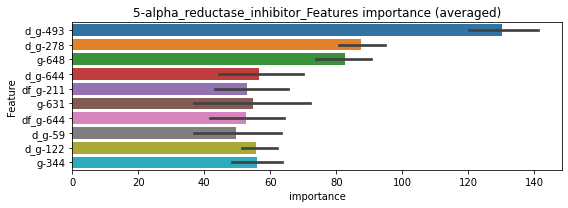

len(train_index) : 3895
len(valid_index) : 3896
================================= fold 1/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0105737	valid_1's binary_logloss: 0.0138538
[200]	training's binary_logloss: 0.00109862	valid_1's binary_logloss: 0.00369873
Early stopping, best iteration is:
[258]	training's binary_logloss: 0.000462504	valid_1's binary_logloss: 0.00331581


len(train_index) : 3896
len(valid_index) : 3895
================================= fold 2/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0104081	valid_1's binary_logloss: 0.0158013
[200]	training's binary_logloss: 0.0010626	valid_1's binary_logloss: 0.00503484
[300]	training's binary_logloss: 0.000303963	valid_1's binary_logloss: 0.00395481
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.000291424	valid_1's binary_logloss: 0.00394463


5-alpha_reductase_inhibitor logloss: 0.0036301802400599465


neg labels: 3289 → selected neg labels: 3286


11-beta-hsd1_inhibitor, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232893	valid_1's binary_logloss: 0.0298357
[200]	training's binary_logloss: 0.0027393	valid_1's binary_logloss: 0.00511141
[300]	training's binary_logloss: 0.000771783	valid_1's binary_logloss: 0.00183615
[400]	training's binary_logloss: 0.000410591	valid_1's binary_logloss: 0.00110731
[500]	training's binary_logloss: 0.00032899	valid_1's binary_logloss: 0.000930427
Early stopping, best iteration is:
[548]	training's binary_logloss: 0.000324671	valid_1's binary_logloss: 0.000921197
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023346	valid_1's binary_logloss: 0.0354294
[200]	training's binary_logloss: 0.00274058	valid_1's binary_logloss: 0.00650166
[300]	training's binary_logloss: 0.000775468	valid_1's binary_logloss: 0.00261879
[400]	training's binary_logloss: 0.000415274	valid_1's binary_logloss: 0.00177209
Early stopping, best iteration i

1 / 3 AUC score:1.000
y_Threshold: 0.0018420, Threshold: 0.0028824, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00259, conf_1:0.00317
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0028824
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_2: 0.0128824
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_3: 0.0228824
threshold: 0.0228824, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0224844	valid_1's binary_logloss: 0.0268388
[200]	training's binary_logloss: 0.0025858	valid_1's binary_logloss: 0.00416857
[300]	training's binary_logloss: 0.000740995	valid_1's binary_logloss: 0.00142828
[400]	training's binary_logloss: 0.000402853	valid_1's binary_logloss: 0.000828229
[500]	training's binary_logloss: 0.000334092	valid_1's binary_logloss: 0.000708223
[600]	training's binary_logloss: 0.000322297	valid_1's binary_logloss: 0.000688982
Early stopping, best iteration is:
[618]	training's binary_logloss: 0.000321246	valid_1's binary_logloss: 0.000687633
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227078	valid_1's binary_logloss: 0.0357666
[200]	training's binary_logloss: 0.00257175	valid_1's binary_logloss: 0.00759546
[300]	training's binary_logloss: 0.000733215	valid_1's binary_logloss: 0.00338293
Early stopping, best iterati

2 / 3 AUC score:1.000
y_Threshold: 0.0952516, Threshold: 0.0228824, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0045203 Vs.target_rate: 0.00076
Num_p_label: 18.0, conf_0:0.02059, conf_1:0.02517
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_1: 0.0228824
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_2: 0.0328824
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_3: 0.0428824
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_4: 0.0528824
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_5: 0.0628824
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_6: 0.0728824
threshold: 0.0728824, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0224844	valid_1's binary_logloss: 0.0268388
[200]	training's binary_logloss: 0.0025858	valid_1's binary_logloss: 0.00416857
[300]	training's binary_logloss: 0.000740995	valid_1's binary_logloss: 0.00142828
[400]	training's binary_logloss: 0.000402853	valid_1's binary_logloss: 0.000828229
[500]	training's binary_logloss: 0.000334092	valid_1's binary_logloss: 0.000708223
[600]	training's binary_logloss: 0.000322297	valid_1's binary_logloss: 0.000688982
Early stopping, best iteration is:
[618]	training's binary_logloss: 0.000321246	valid_1's binary_logloss: 0.000687633
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227078	valid_1's binary_logloss: 0.0357666
[200]	training's binary_logloss: 0.00257175	valid_1's binary_logloss: 0.00759546
[300]	training's binary_logloss: 0.000733215	valid_1's binary_logloss: 0.00338293
Early stopping, best iterati

3 / 3 AUC score:1.000
y_Threshold: 0.0952516, Threshold: 0.0728824, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0012557 Vs.target_rate: 0.00076
Num_p_label: 5.0, conf_0:0.06559, conf_1:0.08017
threshold: 0.0728824, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 662.0/7793, y_label_rate: 0.0849480


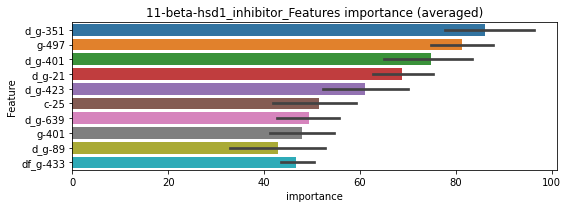

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0127028	valid_1's binary_logloss: 0.0190814
[200]	training's binary_logloss: 0.00143836	valid_1's binary_logloss: 0.0060294
[300]	training's binary_logloss: 0.000396098	valid_1's binary_logloss: 0.00469387
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.000379319	valid_1's binary_logloss: 0.00467587


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0128509	valid_1's binary_logloss: 0.0194455
[200]	training's binary_logloss: 0.00151064	valid_1's binary_logloss: 0.00540788
[300]	training's binary_logloss: 0.000415288	valid_1's binary_logloss: 0.00333749
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.000232875	valid_1's binary_logloss: 0.00299116


11-beta-hsd1_inhibitor logloss: 0.003833627103697172


neg labels: 3289 → selected neg labels: 3285


acat_inhibitor, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0306635	valid_1's binary_logloss: 0.0500311
[200]	training's binary_logloss: 0.00418183	valid_1's binary_logloss: 0.0149059
[300]	training's binary_logloss: 0.00111823	valid_1's binary_logloss: 0.00851365
[400]	training's binary_logloss: 0.000547659	valid_1's binary_logloss: 0.00714532
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.000558777	valid_1's binary_logloss: 0.007138
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.030218	valid_1's binary_logloss: 0.0491946
[200]	training's binary_logloss: 0.0040097	valid_1's binary_logloss: 0.0124451
[300]	training's binary_logloss: 0.00109874	valid_1's binary_logloss: 0.00715299
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000607617	valid_1's binary_logloss: 0.00590543


1 / 3 AUC score:1.000
y_Threshold: 0.0030077, Threshold: 0.0043101, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00101
Num_p_label: 80.0, conf_0:0.00388, conf_1:0.00474
Num_p_label: 80.0, Expected: 4.0, Adj_threshold_1: 0.0043101
Num_p_label: 8.0, Expected: 4.0, Adj_threshold_2: 0.0143101
threshold: 0.0143101, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302538	valid_1's binary_logloss: 0.0457923
[200]	training's binary_logloss: 0.00403704	valid_1's binary_logloss: 0.0117565
[300]	training's binary_logloss: 0.0011004	valid_1's binary_logloss: 0.0065988
[400]	training's binary_logloss: 0.000546101	valid_1's binary_logloss: 0.00549507
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.000525341	valid_1's binary_logloss: 0.00547065
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0300856	valid_1's binary_logloss: 0.0484492
[200]	training's binary_logloss: 0.0039659	valid_1's binary_logloss: 0.0115586
[300]	training's binary_logloss: 0.0010892	valid_1's binary_logloss: 0.00591844
[400]	training's binary_logloss: 0.000542476	valid_1's binary_logloss: 0.00440484
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.000405596	valid_1's binary_logloss: 0.00415603


2 / 3 AUC score:1.000
y_Threshold: 0.0159967, Threshold: 0.0143101, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0037670 Vs.target_rate: 0.00101
Num_p_label: 15.0, conf_0:0.01288, conf_1:0.01574
Num_p_label: 15.0, Expected: 4.0, Adj_threshold_1: 0.0143101
Num_p_label: 6.0, Expected: 4.0, Adj_threshold_2: 0.0243101
threshold: 0.0243101, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302538	valid_1's binary_logloss: 0.0457923
[200]	training's binary_logloss: 0.00403704	valid_1's binary_logloss: 0.0117565
[300]	training's binary_logloss: 0.0011004	valid_1's binary_logloss: 0.0065988
[400]	training's binary_logloss: 0.000546101	valid_1's binary_logloss: 0.00549507
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.000525341	valid_1's binary_logloss: 0.00547065
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0300856	valid_1's binary_logloss: 0.0484492
[200]	training's binary_logloss: 0.0039659	valid_1's binary_logloss: 0.0115586
[300]	training's binary_logloss: 0.0010892	valid_1's binary_logloss: 0.00591844
[400]	training's binary_logloss: 0.000542476	valid_1's binary_logloss: 0.00440484
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.000405596	valid_1's binary_logloss: 0.00415603


3 / 3 AUC score:1.000
y_Threshold: 0.0159967, Threshold: 0.0243101, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0015068 Vs.target_rate: 0.00101
Num_p_label: 6.0, conf_0:0.02188, conf_1:0.02674
threshold: 0.0243101, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7792, y_label_rate: 0.0850873


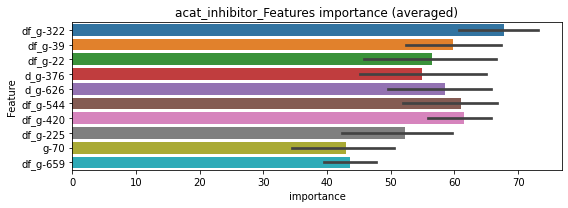

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 acat_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168193	valid_1's binary_logloss: 0.0291113
[200]	training's binary_logloss: 0.00216737	valid_1's binary_logloss: 0.0119216
[300]	training's binary_logloss: 0.000568812	valid_1's binary_logloss: 0.0102091
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.000557917	valid_1's binary_logloss: 0.0101883


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 acat_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180202	valid_1's binary_logloss: 0.0250002
[200]	training's binary_logloss: 0.00259699	valid_1's binary_logloss: 0.00561075
[300]	training's binary_logloss: 0.00074203	valid_1's binary_logloss: 0.00295167
[400]	training's binary_logloss: 0.000362177	valid_1's binary_logloss: 0.00233836
[500]	training's binary_logloss: 0.000235699	valid_1's binary_logloss: 0.00202702
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.000197131	valid_1's binary_logloss: 0.0019639


acat_inhibitor logloss: 0.006076100891338105


neg labels: 3289 → selected neg labels: 3259


acetylcholine_receptor_agonist, len(trt): 190, len(othr): 3259, target_rate: 0.0079785 → Adj_target_rate: 0.0072634
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0864042	valid_1's binary_logloss: 0.251305
[200]	training's binary_logloss: 0.0261927	valid_1's binary_logloss: 0.228714
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.024754	valid_1's binary_logloss: 0.227984
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0908921	valid_1's binary_logloss: 0.23205
[200]	training's binary_logloss: 0.0280122	valid_1's binary_logloss: 0.193495
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.0163777	valid_1's binary_logloss: 0.188998


1 / 3 AUC score:0.926
y_Threshold: 0.0691588, Threshold: 0.1146781, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 357 → Positive_corect_labels: 538/3553
p_label_rate: 0.0200904 Vs.target_rate: 0.00798
Num_p_label: 80.0, conf_0:0.10321, conf_1:0.12615
threshold: 0.1146781, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 538.0/3553, y_label_rate: 0.1514213
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0633286	valid_1's binary_logloss: 0.185568
[200]	training's binary_logloss: 0.0152903	valid_1's binary_logloss: 0.14436
Early stopping, best iteration is:
[289]	training's binary_logloss: 0.00551727	valid_1's binary_logloss: 0.137288
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.071205	valid_1's binary_logloss: 0.16415
[200]	training's binary_logloss: 0.0186199	valid_1's binary_logloss: 0.114026
[300]	training's binary_logloss: 0.00588915	valid_1's binary_logloss: 0.100241
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.00491033	valid_1's binary_logloss: 0.0990748


2 / 3 AUC score:0.983
y_Threshold: 0.0629307, Threshold: 0.1146781, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 106 → Positive_corect_labels: 485.0/3447
p_label_rate: 0.0128076 Vs.target_rate: 0.00798
Num_p_label: 51.0, conf_0:0.10321, conf_1:0.12615
threshold: 0.1146781, positive_p_label: 51.0/3982, p_label_rate: 0.0128076
positive_y_label: 485.0/3447, y_label_rate: 0.1407021
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.054745	valid_1's binary_logloss: 0.154233
[200]	training's binary_logloss: 0.0127314	valid_1's binary_logloss: 0.118773
[300]	training's binary_logloss: 0.00405228	valid_1's binary_logloss: 0.112297
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.00447688	valid_1's binary_logloss: 0.111907
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0586099	valid_1's binary_logloss: 0.148718
[200]	training's binary_logloss: 0.0139385	valid_1's binary_logloss: 0.107521
[300]	training's binary_logloss: 0.00444746	valid_1's binary_logloss: 0.0968421
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.00410778	valid_1's binary_logloss: 0.096147


3 / 3 AUC score:0.979
y_Threshold: 0.0663643, Threshold: 0.1146781, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 78 → Positive_corect_labels: 446.0/3369
p_label_rate: 0.0153189 Vs.target_rate: 0.00798
Num_p_label: 61.0, conf_0:0.10321, conf_1:0.12615
threshold: 0.1146781, positive_p_label: 61.0/3982, p_label_rate: 0.0153189
positive_y_label: 507.0/7351, y_label_rate: 0.0689702


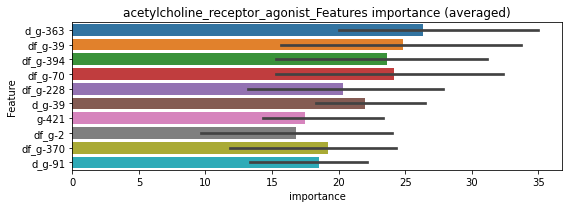

len(train_index) : 3675
len(valid_index) : 3676
================================= fold 1/2 acetylcholine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0326244	valid_1's binary_logloss: 0.0930345
[200]	training's binary_logloss: 0.00787666	valid_1's binary_logloss: 0.0745698
Early stopping, best iteration is:
[210]	training's binary_logloss: 0.00691911	valid_1's binary_logloss: 0.0740155


len(train_index) : 3676
len(valid_index) : 3675
================================= fold 2/2 acetylcholine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295109	valid_1's binary_logloss: 0.099592
[200]	training's binary_logloss: 0.00698625	valid_1's binary_logloss: 0.0819723
Early stopping, best iteration is:
[193]	training's binary_logloss: 0.00765226	valid_1's binary_logloss: 0.081576


acetylcholine_receptor_agonist logloss: 0.07779521069849031


neg labels: 3289 → selected neg labels: 3241


acetylcholine_receptor_antagonist, len(trt): 301, len(othr): 3241, target_rate: 0.0126396 → Adj_target_rate: 0.0107394
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112421	valid_1's binary_logloss: 0.313623
[200]	training's binary_logloss: 0.0410402	valid_1's binary_logloss: 0.297579
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.0387147	valid_1's binary_logloss: 0.297347
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122617	valid_1's binary_logloss: 0.290646
[200]	training's binary_logloss: 0.0455397	valid_1's binary_logloss: 0.260494
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.0344464	valid_1's binary_logloss: 0.257814


1 / 3 AUC score:0.852
y_Threshold: 0.1057809, Threshold: 0.1559444, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 538 → Positive_corect_labels: 444/3351
p_label_rate: 0.0200904 Vs.target_rate: 0.01264
Num_p_label: 80.0, conf_0:0.14035, conf_1:0.17154
threshold: 0.1559444, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 444.0/3351, y_label_rate: 0.1324978
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0705506	valid_1's binary_logloss: 0.198665
[200]	training's binary_logloss: 0.019162	valid_1's binary_logloss: 0.163676
Early stopping, best iteration is:
[234]	training's binary_logloss: 0.0128567	valid_1's binary_logloss: 0.159026
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0683056	valid_1's binary_logloss: 0.200607
[200]	training's binary_logloss: 0.018335	valid_1's binary_logloss: 0.172429
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.0172992	valid_1's binary_logloss: 0.17211


2 / 3 AUC score:0.954
y_Threshold: 0.0995860, Threshold: 0.1559444, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 182 → Positive_corect_labels: 353.0/3169
p_label_rate: 0.0213461 Vs.target_rate: 0.01264
Num_p_label: 85.0, conf_0:0.14035, conf_1:0.17154
threshold: 0.1559444, positive_p_label: 85.0/3982, p_label_rate: 0.0213461
positive_y_label: 353.0/3169, y_label_rate: 0.1113916
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0474482	valid_1's binary_logloss: 0.149161
Early stopping, best iteration is:
[186]	training's binary_logloss: 0.0137114	valid_1's binary_logloss: 0.124204
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0526946	valid_1's binary_logloss: 0.133117
[200]	training's binary_logloss: 0.0125176	valid_1's binary_logloss: 0.0939282
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.00683906	valid_1's binary_logloss: 0.0883957


3 / 3 AUC score:0.980
y_Threshold: 0.0872429, Threshold: 0.1559444, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 78 → Positive_corect_labels: 314.0/3091
p_label_rate: 0.0178302 Vs.target_rate: 0.01264
Num_p_label: 71.0, conf_0:0.14035, conf_1:0.17154
threshold: 0.1559444, positive_p_label: 71.0/3982, p_label_rate: 0.0178302
positive_y_label: 385.0/7073, y_label_rate: 0.0544323


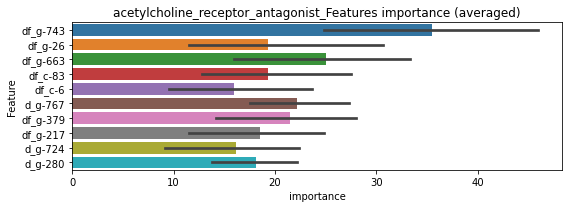

len(train_index) : 3536
len(valid_index) : 3537
================================= fold 1/2 acetylcholine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261675	valid_1's binary_logloss: 0.0917151
[200]	training's binary_logloss: 0.00641359	valid_1's binary_logloss: 0.0781242
Early stopping, best iteration is:
[197]	training's binary_logloss: 0.00666958	valid_1's binary_logloss: 0.0779951


len(train_index) : 3537
len(valid_index) : 3536
================================= fold 2/2 acetylcholine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0266089	valid_1's binary_logloss: 0.0935126
[200]	training's binary_logloss: 0.00653306	valid_1's binary_logloss: 0.0791598
Early stopping, best iteration is:
[213]	training's binary_logloss: 0.0055052	valid_1's binary_logloss: 0.0788333


acetylcholine_receptor_antagonist logloss: 0.07841412898124527


neg labels: 3289 → selected neg labels: 3276


acetylcholinesterase_inhibitor, len(trt): 73, len(othr): 3276, target_rate: 0.0030654 → Adj_target_rate: 0.0032212
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0657436	valid_1's binary_logloss: 0.129909
[200]	training's binary_logloss: 0.0153397	valid_1's binary_logloss: 0.0755131
[300]	training's binary_logloss: 0.00430292	valid_1's binary_logloss: 0.0643776
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00265484	valid_1's binary_logloss: 0.0620721
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.069815	valid_1's binary_logloss: 0.126757
[200]	training's binary_logloss: 0.0160898	valid_1's binary_logloss: 0.0603103
[300]	training's binary_logloss: 0.00458869	valid_1's binary_logloss: 0.0395756
[400]	training's binary_logloss: 0.00189101	valid_1's binary_logloss: 0.0323911
[500]	training's binary_logloss: 0.00108091	valid_1's binary_logloss: 0.0294502
[600]	training's binary_logloss: 0.000759342	valid_1's binary_logloss: 0.0280415
Early stopping, best iteration is:
[615]	training

1 / 3 AUC score:0.996
y_Threshold: 0.0156871, Threshold: 0.0189210, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 160 → Positive_corect_labels: 641/3771
p_label_rate: 0.0200904 Vs.target_rate: 0.00307
Num_p_label: 80.0, conf_0:0.01703, conf_1:0.02081
Num_p_label: 80.0, Expected: 12.2, Adj_threshold_1: 0.0189210
Num_p_label: 34.0, Expected: 12.2, Adj_threshold_2: 0.0289210
Num_p_label: 21.0, Expected: 12.2, Adj_threshold_3: 0.0389210
threshold: 0.0389210, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 641.0/3771, y_label_rate: 0.1699814
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0610312	valid_1's binary_logloss: 0.139837
[200]	training's binary_logloss: 0.0133745	valid_1's binary_logloss: 0.0885957
[300]	training's binary_logloss: 0.00381623	valid_1's binary_logloss: 0.0796279
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00260027	valid_1's binary_logloss: 0.0780306
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0651193	valid_1's binary_logloss: 0.119704
[200]	training's binary_logloss: 0.0141085	valid_1's binary_logloss: 0.0564647
[300]	training's binary_logloss: 0.0039647	valid_1's binary_logloss: 0.0405246
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00196108	valid_1's binary_logloss: 0.0361822


2 / 3 AUC score:0.991
y_Threshold: 0.0423613, Threshold: 0.0389210, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 46 → Positive_corect_labels: 618.0/3725
p_label_rate: 0.0165746 Vs.target_rate: 0.00307
Num_p_label: 66.0, conf_0:0.03503, conf_1:0.04281
Num_p_label: 66.0, Expected: 12.2, Adj_threshold_1: 0.0389210
Num_p_label: 43.0, Expected: 12.2, Adj_threshold_2: 0.0489210
Num_p_label: 24.0, Expected: 12.2, Adj_threshold_3: 0.0589210
threshold: 0.0589210, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 618.0/3725, y_label_rate: 0.1659060
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0576556	valid_1's binary_logloss: 0.122316
[200]	training's binary_logloss: 0.0121104	valid_1's binary_logloss: 0.0649672
[300]	training's binary_logloss: 0.00345386	valid_1's binary_logloss: 0.0490998
Early stopping, best iteration is:
[342]	training's binary_logloss: 0.00231385	valid_1's binary_logloss: 0.0464631
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0609217	valid_1's binary_logloss: 0.111959
[200]	training's binary_logloss: 0.013349	valid_1's binary_logloss: 0.0526597
[300]	training's binary_logloss: 0.00374189	valid_1's binary_logloss: 0.0347967
[400]	training's binary_logloss: 0.00162595	valid_1's binary_logloss: 0.0294968
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00119012	valid_1's binary_logloss: 0.0284686


3 / 3 AUC score:0.999
y_Threshold: 0.0493540, Threshold: 0.0589210, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 607.0/3703
p_label_rate: 0.0070316 Vs.target_rate: 0.00307
Num_p_label: 28.0, conf_0:0.05303, conf_1:0.06481
threshold: 0.0589210, positive_p_label: 28.0/3982, p_label_rate: 0.0070316
positive_y_label: 635.0/7685, y_label_rate: 0.0826285


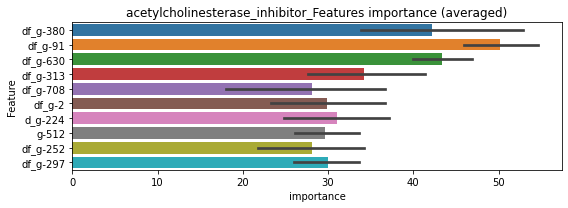

len(train_index) : 3842
len(valid_index) : 3843
================================= fold 1/2 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0341973	valid_1's binary_logloss: 0.0712018
[200]	training's binary_logloss: 0.00755377	valid_1's binary_logloss: 0.0413519
[300]	training's binary_logloss: 0.00207715	valid_1's binary_logloss: 0.0351613
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.00114724	valid_1's binary_logloss: 0.0339077


len(train_index) : 3843
len(valid_index) : 3842
================================= fold 2/2 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0337603	valid_1's binary_logloss: 0.0726129
[200]	training's binary_logloss: 0.00722866	valid_1's binary_logloss: 0.0416008
[300]	training's binary_logloss: 0.00199141	valid_1's binary_logloss: 0.0337554
Early stopping, best iteration is:
[347]	training's binary_logloss: 0.00126598	valid_1's binary_logloss: 0.0326711


acetylcholinesterase_inhibitor logloss: 0.03328951599458544


neg labels: 3289 → selected neg labels: 3281


adenosine_receptor_agonist, len(trt): 54, len(othr): 3281, target_rate: 0.0022676 → Adj_target_rate: 0.0024931
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0462303	valid_1's binary_logloss: 0.101553
[200]	training's binary_logloss: 0.00889983	valid_1's binary_logloss: 0.0555677
[300]	training's binary_logloss: 0.00244782	valid_1's binary_logloss: 0.044456
[400]	training's binary_logloss: 0.00110828	valid_1's binary_logloss: 0.0400026
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.000938451	valid_1's binary_logloss: 0.0394433
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0438247	valid_1's binary_logloss: 0.0990205
[200]	training's binary_logloss: 0.00819835	valid_1's binary_logloss: 0.0589589
[300]	training's binary_logloss: 0.00234788	valid_1's binary_logloss: 0.0511829
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.00174255	valid_1's binary_logloss: 0.0500734


1 / 3 AUC score:0.995
y_Threshold: 0.0113437, Threshold: 0.0169941, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 164 → Positive_corect_labels: 640/3773
p_label_rate: 0.0200904 Vs.target_rate: 0.00227
Num_p_label: 80.0, conf_0:0.01529, conf_1:0.01869
Num_p_label: 80.0, Expected: 9.0, Adj_threshold_1: 0.0169941
Num_p_label: 42.0, Expected: 9.0, Adj_threshold_2: 0.0269941
Num_p_label: 24.0, Expected: 9.0, Adj_threshold_3: 0.0369941
Num_p_label: 15.0, Expected: 9.0, Adj_threshold_4: 0.0469941
threshold: 0.0469941, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 640.0/3773, y_label_rate: 0.1696263
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0442607	valid_1's binary_logloss: 0.0830607
[200]	training's binary_logloss: 0.00786136	valid_1's binary_logloss: 0.0328479
[300]	training's binary_logloss: 0.00223829	valid_1's binary_logloss: 0.0197644
[400]	training's binary_logloss: 0.00103969	valid_1's binary_logloss: 0.0161215
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.000790434	valid_1's binary_logloss: 0.0150665
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0439115	valid_1's binary_logloss: 0.0814051
[200]	training's binary_logloss: 0.00765228	valid_1's binary_logloss: 0.0348181
[300]	training's binary_logloss: 0.00217781	valid_1's binary_logloss: 0.025911
[400]	training's binary_logloss: 0.00101455	valid_1's binary_logloss: 0.0235885
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.000949528	valid_1's binary_logloss: 0.023437


2 / 3 AUC score:0.999
y_Threshold: 0.0364706, Threshold: 0.0469941, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 635.0/3763
p_label_rate: 0.0060271 Vs.target_rate: 0.00227
Num_p_label: 24.0, conf_0:0.04229, conf_1:0.05169
threshold: 0.0469941, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 635.0/3763, y_label_rate: 0.1687483
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0413314	valid_1's binary_logloss: 0.0975936
[200]	training's binary_logloss: 0.00724352	valid_1's binary_logloss: 0.0576581
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.0031375	valid_1's binary_logloss: 0.0520607
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0421916	valid_1's binary_logloss: 0.0801013
[200]	training's binary_logloss: 0.00723675	valid_1's binary_logloss: 0.032436
[300]	training's binary_logloss: 0.00207989	valid_1's binary_logloss: 0.0218652
[400]	training's binary_logloss: 0.000972504	valid_1's binary_logloss: 0.0187911
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000753565	valid_1's binary_logloss: 0.0183373


3 / 3 AUC score:0.998
y_Threshold: 0.0431936, Threshold: 0.0469941, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 24 → Positive_corect_labels: 623.0/3739
p_label_rate: 0.0128076 Vs.target_rate: 0.00227
Num_p_label: 51.0, conf_0:0.04229, conf_1:0.05169
Num_p_label: 51.0, Expected: 9.0, Adj_threshold_1: 0.0469941
Num_p_label: 41.0, Expected: 9.0, Adj_threshold_2: 0.0569941
Num_p_label: 28.0, Expected: 9.0, Adj_threshold_3: 0.0669941
Num_p_label: 21.0, Expected: 9.0, Adj_threshold_4: 0.0769941
Num_p_label: 19.0, Expected: 9.0, Adj_threshold_5: 0.0869941
Num_p_label: 17.0, Expected: 9.0, Adj_threshold_6: 0.0969941
threshold: 0.0969941, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 640.0/7721, y_label_rate: 0.0828908


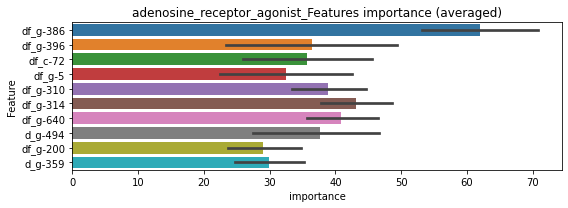

len(train_index) : 3860
len(valid_index) : 3861
================================= fold 1/2 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0240921	valid_1's binary_logloss: 0.0493272
[200]	training's binary_logloss: 0.00425308	valid_1's binary_logloss: 0.0250335
[300]	training's binary_logloss: 0.00117581	valid_1's binary_logloss: 0.0202556
Early stopping, best iteration is:
[367]	training's binary_logloss: 0.000660225	valid_1's binary_logloss: 0.0195315


len(train_index) : 3861
len(valid_index) : 3860
================================= fold 2/2 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241509	valid_1's binary_logloss: 0.0583361
[200]	training's binary_logloss: 0.0042583	valid_1's binary_logloss: 0.0345697
[300]	training's binary_logloss: 0.0012029	valid_1's binary_logloss: 0.0304655
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.00131161	valid_1's binary_logloss: 0.0301606


adenosine_receptor_agonist logloss: 0.024845397564977476


neg labels: 3289 → selected neg labels: 3273


adenosine_receptor_antagonist, len(trt): 96, len(othr): 3273, target_rate: 0.0040312 → Adj_target_rate: 0.0040656
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0629352	valid_1's binary_logloss: 0.14639
[200]	training's binary_logloss: 0.0145199	valid_1's binary_logloss: 0.0995389
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00532441	valid_1's binary_logloss: 0.0901089
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0633238	valid_1's binary_logloss: 0.138351
[200]	training's binary_logloss: 0.0148466	valid_1's binary_logloss: 0.0828352
[300]	training's binary_logloss: 0.00445313	valid_1's binary_logloss: 0.070041
[400]	training's binary_logloss: 0.00194159	valid_1's binary_logloss: 0.0666887
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.00174562	valid_1's binary_logloss: 0.0662483


1 / 3 AUC score:0.982
y_Threshold: 0.0225271, Threshold: 0.0361971, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 196 → Positive_corect_labels: 622/3731
p_label_rate: 0.0200904 Vs.target_rate: 0.00403
Num_p_label: 80.0, conf_0:0.03258, conf_1:0.03982
Num_p_label: 80.0, Expected: 16.1, Adj_threshold_1: 0.0361971
Num_p_label: 42.0, Expected: 16.1, Adj_threshold_2: 0.0461971
Num_p_label: 24.0, Expected: 16.1, Adj_threshold_3: 0.0561971
threshold: 0.0561971, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 622.0/3731, y_label_rate: 0.1667113
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0567964	valid_1's binary_logloss: 0.125119
[200]	training's binary_logloss: 0.0118682	valid_1's binary_logloss: 0.0738861
[300]	training's binary_logloss: 0.00359182	valid_1's binary_logloss: 0.0611985
[400]	training's binary_logloss: 0.00164448	valid_1's binary_logloss: 0.0585622
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00174099	valid_1's binary_logloss: 0.0585196
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0583239	valid_1's binary_logloss: 0.129171
[200]	training's binary_logloss: 0.0124284	valid_1's binary_logloss: 0.0777111
[300]	training's binary_logloss: 0.00357469	valid_1's binary_logloss: 0.0662982
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.00310997	valid_1's binary_logloss: 0.066039


2 / 3 AUC score:0.991
y_Threshold: 0.0416821, Threshold: 0.0561971, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 42 → Positive_corect_labels: 601.0/3689
p_label_rate: 0.0125565 Vs.target_rate: 0.00403
Num_p_label: 50.0, conf_0:0.05058, conf_1:0.06182
Num_p_label: 50.0, Expected: 16.1, Adj_threshold_1: 0.0561971
Num_p_label: 42.0, Expected: 16.1, Adj_threshold_2: 0.0661971
Num_p_label: 26.0, Expected: 16.1, Adj_threshold_3: 0.0761971
threshold: 0.0761971, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 601.0/3689, y_label_rate: 0.1629168
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0546894	valid_1's binary_logloss: 0.125366
[200]	training's binary_logloss: 0.0110441	valid_1's binary_logloss: 0.0766084
[300]	training's binary_logloss: 0.00321436	valid_1's binary_logloss: 0.0660505
Early stopping, best iteration is:
[362]	training's binary_logloss: 0.00187517	valid_1's binary_logloss: 0.0634857
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0539604	valid_1's binary_logloss: 0.111435
[200]	training's binary_logloss: 0.0107004	valid_1's binary_logloss: 0.061951
[300]	training's binary_logloss: 0.00321072	valid_1's binary_logloss: 0.049804
[400]	training's binary_logloss: 0.0014525	valid_1's binary_logloss: 0.0462891
Early stopping, best iteration is:
[398]	training's binary_logloss: 0.00147177	valid_1's binary_logloss: 0.0462875


3 / 3 AUC score:0.995
y_Threshold: 0.0328426, Threshold: 0.0761971, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 34 → Positive_corect_labels: 584.0/3655
p_label_rate: 0.0062783 Vs.target_rate: 0.00403
Num_p_label: 25.0, conf_0:0.06858, conf_1:0.08382
threshold: 0.0761971, positive_p_label: 25.0/3982, p_label_rate: 0.0062783
positive_y_label: 609.0/7637, y_label_rate: 0.0797434


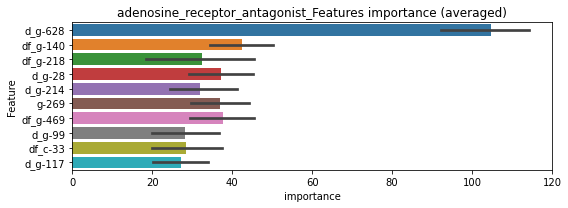

len(train_index) : 3818
len(valid_index) : 3819
================================= fold 1/2 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0291295	valid_1's binary_logloss: 0.0761168
[200]	training's binary_logloss: 0.00563445	valid_1's binary_logloss: 0.0520328
[300]	training's binary_logloss: 0.00160522	valid_1's binary_logloss: 0.0477728
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.00162026	valid_1's binary_logloss: 0.0477613


len(train_index) : 3819
len(valid_index) : 3818
================================= fold 2/2 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303928	valid_1's binary_logloss: 0.0663796
[200]	training's binary_logloss: 0.00632551	valid_1's binary_logloss: 0.0388122
[300]	training's binary_logloss: 0.00181128	valid_1's binary_logloss: 0.0328047
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00107109	valid_1's binary_logloss: 0.0313519


adenosine_receptor_antagonist logloss: 0.039557666053069505


neg labels: 3289 → selected neg labels: 3286


adenylyl_cyclase_activator, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0210979	valid_1's binary_logloss: 0.0257477
[200]	training's binary_logloss: 0.00227013	valid_1's binary_logloss: 0.00375044
[300]	training's binary_logloss: 0.00062575	valid_1's binary_logloss: 0.00126077
[400]	training's binary_logloss: 0.000340929	valid_1's binary_logloss: 0.000770173
[500]	training's binary_logloss: 0.000281187	valid_1's binary_logloss: 0.000662554
Early stopping, best iteration is:
[567]	training's binary_logloss: 0.000278863	valid_1's binary_logloss: 0.000658321
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213387	valid_1's binary_logloss: 0.0270277
[200]	training's binary_logloss: 0.00226631	valid_1's binary_logloss: 0.00392566
[300]	training's binary_logloss: 0.00063115	valid_1's binary_logloss: 0.00141884
[400]	training's binary_logloss: 0.000339453	valid_1's binary_logloss: 0.000873332
[500]	training's binary_loglo

1 / 3 AUC score:1.000
y_Threshold: 0.0013364, Threshold: 0.0022799, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00205, conf_1:0.00251
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0022799
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_2: 0.0122799
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_3: 0.0222799
threshold: 0.0222799, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0210184	valid_1's binary_logloss: 0.0253258
[200]	training's binary_logloss: 0.00222423	valid_1's binary_logloss: 0.00346679
[300]	training's binary_logloss: 0.00061478	valid_1's binary_logloss: 0.00109696
[400]	training's binary_logloss: 0.000335141	valid_1's binary_logloss: 0.000638756
[500]	training's binary_logloss: 0.000282684	valid_1's binary_logloss: 0.000554836
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.000279226	valid_1's binary_logloss: 0.000548353
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209266	valid_1's binary_logloss: 0.026531
[200]	training's binary_logloss: 0.00220023	valid_1's binary_logloss: 0.0037712
[300]	training's binary_logloss: 0.00059658	valid_1's binary_logloss: 0.00128635
[400]	training's binary_logloss: 0.000320539	valid_1's binary_logloss: 0.000787396
Early stopping, best iteration 

2 / 3 AUC score:1.000
y_Threshold: 0.1719623, Threshold: 0.0222799, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0052737 Vs.target_rate: 0.00076
Num_p_label: 21.0, conf_0:0.02005, conf_1:0.02451
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_1: 0.0222799
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_2: 0.0322799
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_3: 0.0422799
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_4: 0.0522799
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_5: 0.0622799
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_6: 0.0722799
threshold: 0.0722799, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0210184	valid_1's binary_logloss: 0.0253258
[200]	training's binary_logloss: 0.00222423	valid_1's binary_logloss: 0.00346679
[300]	training's binary_logloss: 0.00061478	valid_1's binary_logloss: 0.00109696
[400]	training's binary_logloss: 0.000335141	valid_1's binary_logloss: 0.000638756
[500]	training's binary_logloss: 0.000282684	valid_1's binary_logloss: 0.000554836
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.000279226	valid_1's binary_logloss: 0.000548353
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209266	valid_1's binary_logloss: 0.026531
[200]	training's binary_logloss: 0.00220023	valid_1's binary_logloss: 0.0037712
[300]	training's binary_logloss: 0.00059658	valid_1's binary_logloss: 0.00128635
[400]	training's binary_logloss: 0.000320539	valid_1's binary_logloss: 0.000787396
Early stopping, best iteration 

3 / 3 AUC score:1.000
y_Threshold: 0.1719623, Threshold: 0.0722799, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0015068 Vs.target_rate: 0.00076
Num_p_label: 6.0, conf_0:0.06505, conf_1:0.07951
threshold: 0.0722799, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7793, y_label_rate: 0.0850764


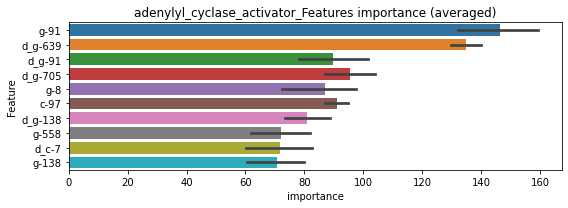

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0105274	valid_1's binary_logloss: 0.0187687
[200]	training's binary_logloss: 0.00107337	valid_1's binary_logloss: 0.00672238
[300]	training's binary_logloss: 0.000296153	valid_1's binary_logloss: 0.00556527
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.000309826	valid_1's binary_logloss: 0.00556031


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.011043	valid_1's binary_logloss: 0.014072
[200]	training's binary_logloss: 0.00117479	valid_1's binary_logloss: 0.00268996
[300]	training's binary_logloss: 0.000329437	valid_1's binary_logloss: 0.00163029
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.000189535	valid_1's binary_logloss: 0.00148781


adenylyl_cyclase_activator logloss: 0.0035243190824013116


neg labels: 3289 → selected neg labels: 3244


adrenergic_receptor_agonist, len(trt): 270, len(othr): 3244, target_rate: 0.0113379 → Adj_target_rate: 0.0097917
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.097347	valid_1's binary_logloss: 0.280143
[200]	training's binary_logloss: 0.031407	valid_1's binary_logloss: 0.257581
Early stopping, best iteration is:
[204]	training's binary_logloss: 0.0300107	valid_1's binary_logloss: 0.257439
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106909	valid_1's binary_logloss: 0.264088
[200]	training's binary_logloss: 0.0370055	valid_1's binary_logloss: 0.225589
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.0213457	valid_1's binary_logloss: 0.221758


1 / 3 AUC score:0.910
y_Threshold: 0.0790332, Threshold: 0.1277885, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 413 → Positive_corect_labels: 507/3479
p_label_rate: 0.0200904 Vs.target_rate: 0.01134
Num_p_label: 80.0, conf_0:0.11501, conf_1:0.14057
threshold: 0.1277885, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 507.0/3479, y_label_rate: 0.1457315
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0692801	valid_1's binary_logloss: 0.213939
[200]	training's binary_logloss: 0.0182849	valid_1's binary_logloss: 0.184144
Early stopping, best iteration is:
[227]	training's binary_logloss: 0.0133692	valid_1's binary_logloss: 0.182044
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0709317	valid_1's binary_logloss: 0.212873
[200]	training's binary_logloss: 0.0190326	valid_1's binary_logloss: 0.189513
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.0141167	valid_1's binary_logloss: 0.187294


2 / 3 AUC score:0.945
y_Threshold: 0.0740768, Threshold: 0.1277885, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 180 → Positive_corect_labels: 417.0/3299
p_label_rate: 0.0170768 Vs.target_rate: 0.01134
Num_p_label: 68.0, conf_0:0.11501, conf_1:0.14057
threshold: 0.1277885, positive_p_label: 68.0/3982, p_label_rate: 0.0170768
positive_y_label: 417.0/3299, y_label_rate: 0.1264019
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0533737	valid_1's binary_logloss: 0.17028
[200]	training's binary_logloss: 0.0131456	valid_1's binary_logloss: 0.142924
Early stopping, best iteration is:
[211]	training's binary_logloss: 0.0113841	valid_1's binary_logloss: 0.142315
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0573646	valid_1's binary_logloss: 0.154372
[200]	training's binary_logloss: 0.0134957	valid_1's binary_logloss: 0.119504
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.00857304	valid_1's binary_logloss: 0.115955


3 / 3 AUC score:0.978
y_Threshold: 0.0691729, Threshold: 0.1277885, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 108 → Positive_corect_labels: 363.0/3191
p_label_rate: 0.0233551 Vs.target_rate: 0.01134
Num_p_label: 93.0, conf_0:0.11501, conf_1:0.14057
threshold: 0.1277885, positive_p_label: 93.0/3982, p_label_rate: 0.0233551
positive_y_label: 456.0/7173, y_label_rate: 0.0635717


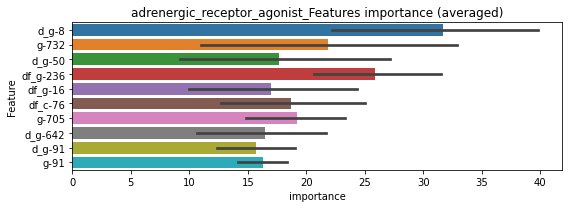

len(train_index) : 3586
len(valid_index) : 3587
================================= fold 1/2 adrenergic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0314903	valid_1's binary_logloss: 0.101826
[200]	training's binary_logloss: 0.00767209	valid_1's binary_logloss: 0.090275
Early stopping, best iteration is:
[196]	training's binary_logloss: 0.00807029	valid_1's binary_logloss: 0.0900778


len(train_index) : 3587
len(valid_index) : 3586
================================= fold 2/2 adrenergic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303549	valid_1's binary_logloss: 0.107333
Early stopping, best iteration is:
[175]	training's binary_logloss: 0.0107681	valid_1's binary_logloss: 0.0960992


adrenergic_receptor_agonist logloss: 0.09308809298799046


neg labels: 3289 → selected neg labels: 3229


adrenergic_receptor_antagonist, len(trt): 360, len(othr): 3229, target_rate: 0.0151172 → Adj_target_rate: 0.0125042
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125441	valid_1's binary_logloss: 0.355026
Early stopping, best iteration is:
[153]	training's binary_logloss: 0.0715545	valid_1's binary_logloss: 0.348439
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137486	valid_1's binary_logloss: 0.338494
Early stopping, best iteration is:
[172]	training's binary_logloss: 0.0677762	valid_1's binary_logloss: 0.319909


1 / 3 AUC score:0.799
y_Threshold: 0.1320675, Threshold: 0.1785232, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 632 → Positive_corect_labels: 394/3242
p_label_rate: 0.0200904 Vs.target_rate: 0.01512
Num_p_label: 80.0, conf_0:0.16067, conf_1:0.19638
threshold: 0.1785232, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 394.0/3242, y_label_rate: 0.1215299
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0755586	valid_1's binary_logloss: 0.214664
[200]	training's binary_logloss: 0.0209655	valid_1's binary_logloss: 0.183061
Early stopping, best iteration is:
[223]	training's binary_logloss: 0.0155704	valid_1's binary_logloss: 0.180421
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0688695	valid_1's binary_logloss: 0.213423
[200]	training's binary_logloss: 0.0204252	valid_1's binary_logloss: 0.1872
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.0194963	valid_1's binary_logloss: 0.186371


2 / 3 AUC score:0.946
y_Threshold: 0.0838656, Threshold: 0.1785232, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 184 → Positive_corect_labels: 302.0/3058
p_label_rate: 0.0060271 Vs.target_rate: 0.01512
Num_p_label: 24.0, conf_0:0.16067, conf_1:0.19638
threshold: 0.1785232, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 302.0/3058, y_label_rate: 0.0987574
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0501977	valid_1's binary_logloss: 0.150058
[200]	training's binary_logloss: 0.0120015	valid_1's binary_logloss: 0.116322
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.00834853	valid_1's binary_logloss: 0.114073
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0509556	valid_1's binary_logloss: 0.146301
[200]	training's binary_logloss: 0.013131	valid_1's binary_logloss: 0.114549
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00678958	valid_1's binary_logloss: 0.109883


3 / 3 AUC score:0.985
y_Threshold: 0.0600041, Threshold: 0.1785232, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 62 → Positive_corect_labels: 271.0/2996
p_label_rate: 0.0030136 Vs.target_rate: 0.01512
Num_p_label: 12.0, conf_0:0.16067, conf_1:0.19638
Num_p_label: 12.0, Expected: 60.2, Adj_threshold_1: 0.1785232
Num_p_label: 15.0, Expected: 60.2, Adj_threshold_2: 0.1685232
Num_p_label: 16.0, Expected: 60.2, Adj_threshold_3: 0.1585232
Num_p_label: 18.0, Expected: 60.2, Adj_threshold_4: 0.1485232
Num_p_label: 23.0, Expected: 60.2, Adj_threshold_5: 0.1385232
Num_p_label: 28.0, Expected: 60.2, Adj_threshold_6: 0.1285232
Num_p_label: 32.0, Expected: 60.2, Adj_threshold_7: 0.1185232
threshold: 0.1185232, positive_p_label: 32.0/3982, p_label_rate: 0.0080362
positive_y_label: 303.0/6978, y_label_rate: 0.0434222


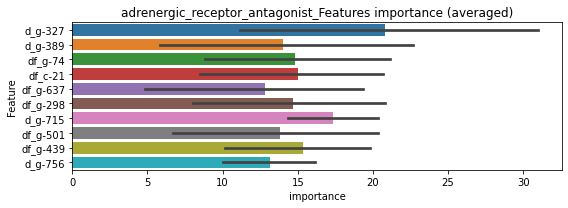

len(train_index) : 3489
len(valid_index) : 3489
================================= fold 1/2 adrenergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229619	valid_1's binary_logloss: 0.0932824
Early stopping, best iteration is:
[166]	training's binary_logloss: 0.00863581	valid_1's binary_logloss: 0.0846702


len(train_index) : 3489
len(valid_index) : 3489
================================= fold 2/2 adrenergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0224868	valid_1's binary_logloss: 0.100533
Early stopping, best iteration is:
[158]	training's binary_logloss: 0.00947045	valid_1's binary_logloss: 0.0940817


adrenergic_receptor_antagonist logloss: 0.08937593369817987


neg labels: 3289 → selected neg labels: 3278


akt_inhibitor, len(trt): 66, len(othr): 3278, target_rate: 0.0027715 → Adj_target_rate: 0.0029567
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0361592	valid_1's binary_logloss: 0.0774668
[200]	training's binary_logloss: 0.00606002	valid_1's binary_logloss: 0.0350881
[300]	training's binary_logloss: 0.00182704	valid_1's binary_logloss: 0.0252425
[400]	training's binary_logloss: 0.000894836	valid_1's binary_logloss: 0.0226876
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000871334	valid_1's binary_logloss: 0.0226568
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0389787	valid_1's binary_logloss: 0.0666116
[200]	training's binary_logloss: 0.00669842	valid_1's binary_logloss: 0.0239355
[300]	training's binary_logloss: 0.00196719	valid_1's binary_logloss: 0.0145625
[400]	training's binary_logloss: 0.000954291	valid_1's binary_logloss: 0.0114459
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.000949728	valid_1's binary_logloss: 0.0114413


1 / 3 AUC score:1.000
y_Threshold: 0.0070909, Threshold: 0.0232740, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 654/3799
p_label_rate: 0.0200904 Vs.target_rate: 0.00277
Num_p_label: 80.0, conf_0:0.02095, conf_1:0.02560
Num_p_label: 80.0, Expected: 11.0, Adj_threshold_1: 0.0232740
Num_p_label: 65.0, Expected: 11.0, Adj_threshold_2: 0.0332740
Num_p_label: 55.0, Expected: 11.0, Adj_threshold_3: 0.0432740
Num_p_label: 48.0, Expected: 11.0, Adj_threshold_4: 0.0532740
Num_p_label: 41.0, Expected: 11.0, Adj_threshold_5: 0.0632740
Num_p_label: 37.0, Expected: 11.0, Adj_threshold_6: 0.0732740
Num_p_label: 35.0, Expected: 11.0, Adj_threshold_7: 0.0832740
Num_p_label: 31.0, Expected: 11.0, Adj_threshold_8: 0.0932740
Num_p_label: 27.0, Expected: 11.0, Adj_threshold_9: 0.1032740
Num_p_label: 27.0, Expected: 11.0, Adj_threshold_10: 0.1132740
threshold: 0.1232740, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 654.0/3799, y_label_rate: 0.1721506

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0371905	valid_1's binary_logloss: 0.0715085
[200]	training's binary_logloss: 0.00598677	valid_1's binary_logloss: 0.0282214
[300]	training's binary_logloss: 0.00176013	valid_1's binary_logloss: 0.0187496
[400]	training's binary_logloss: 0.000858313	valid_1's binary_logloss: 0.0161554
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000601819	valid_1's binary_logloss: 0.0154068
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0341345	valid_1's binary_logloss: 0.0701345
[200]	training's binary_logloss: 0.00538476	valid_1's binary_logloss: 0.0323614
[300]	training's binary_logloss: 0.00163034	valid_1's binary_logloss: 0.0261023
Early stopping, best iteration is:
[342]	training's binary_logloss: 0.00116197	valid_1's binary_logloss: 0.0252077


2 / 3 AUC score:1.000
y_Threshold: 0.0539805, Threshold: 0.1232740, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 647.0/3785
p_label_rate: 0.0218483 Vs.target_rate: 0.00277
Num_p_label: 87.0, conf_0:0.11095, conf_1:0.13560
Num_p_label: 87.0, Expected: 11.0, Adj_threshold_1: 0.1232740
Num_p_label: 85.0, Expected: 11.0, Adj_threshold_2: 0.1332740
Num_p_label: 84.0, Expected: 11.0, Adj_threshold_3: 0.1432740
Num_p_label: 81.0, Expected: 11.0, Adj_threshold_4: 0.1532740
Num_p_label: 74.0, Expected: 11.0, Adj_threshold_5: 0.1632740
Num_p_label: 71.0, Expected: 11.0, Adj_threshold_6: 0.1732740
Num_p_label: 68.0, Expected: 11.0, Adj_threshold_7: 0.1832740
Num_p_label: 62.0, Expected: 11.0, Adj_threshold_8: 0.1932740
Num_p_label: 61.0, Expected: 11.0, Adj_threshold_9: 0.2032740
Num_p_label: 61.0, Expected: 11.0, Adj_threshold_10: 0.2132740
threshold: 0.2232740, positive_p_label: 61.0/3982, p_label_rate: 0.0153189
positive_y_label: 647.0/3785, y_label_rate: 0.170937

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.036844	valid_1's binary_logloss: 0.0603393
[200]	training's binary_logloss: 0.00592877	valid_1's binary_logloss: 0.0186624
[300]	training's binary_logloss: 0.0017351	valid_1's binary_logloss: 0.00942088
[400]	training's binary_logloss: 0.000843558	valid_1's binary_logloss: 0.00641665
[500]	training's binary_logloss: 0.000556174	valid_1's binary_logloss: 0.00530277
Early stopping, best iteration is:
[564]	training's binary_logloss: 0.0004896	valid_1's binary_logloss: 0.00498402
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.034625	valid_1's binary_logloss: 0.0712334
[200]	training's binary_logloss: 0.00545473	valid_1's binary_logloss: 0.0313442
Early stopping, best iteration is:
[284]	training's binary_logloss: 0.00188317	valid_1's binary_logloss: 0.0248047


3 / 3 AUC score:1.000
y_Threshold: 0.0720477, Threshold: 0.2232740, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 643.0/3777
p_label_rate: 0.0178302 Vs.target_rate: 0.00277
Num_p_label: 71.0, conf_0:0.20095, conf_1:0.24560
Num_p_label: 71.0, Expected: 11.0, Adj_threshold_1: 0.2232740
Num_p_label: 66.0, Expected: 11.0, Adj_threshold_2: 0.2332740
Num_p_label: 65.0, Expected: 11.0, Adj_threshold_3: 0.2432740
Num_p_label: 63.0, Expected: 11.0, Adj_threshold_4: 0.2532740
Num_p_label: 59.0, Expected: 11.0, Adj_threshold_5: 0.2632740
Num_p_label: 58.0, Expected: 11.0, Adj_threshold_6: 0.2732740
Num_p_label: 57.0, Expected: 11.0, Adj_threshold_7: 0.2832740
Num_p_label: 55.0, Expected: 11.0, Adj_threshold_8: 0.2932740
Num_p_label: 54.0, Expected: 11.0, Adj_threshold_9: 0.3032740
Num_p_label: 52.0, Expected: 11.0, Adj_threshold_10: 0.3132740
threshold: 0.3232740, positive_p_label: 52.0/3982, p_label_rate: 0.0130588
positive_y_label: 695.0/7759, y_label_rate: 0.0895734

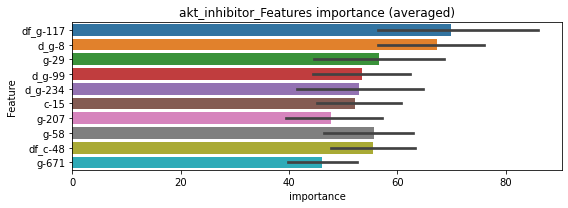

len(train_index) : 3879
len(valid_index) : 3880
================================= fold 1/2 akt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0208254	valid_1's binary_logloss: 0.0505576
[200]	training's binary_logloss: 0.00340062	valid_1's binary_logloss: 0.0286712
Early stopping, best iteration is:
[283]	training's binary_logloss: 0.0011239	valid_1's binary_logloss: 0.0240014


len(train_index) : 3880
len(valid_index) : 3879
================================= fold 2/2 akt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0206577	valid_1's binary_logloss: 0.0464909
[200]	training's binary_logloss: 0.00335098	valid_1's binary_logloss: 0.0215049
[300]	training's binary_logloss: 0.000991386	valid_1's binary_logloss: 0.0150545
[400]	training's binary_logloss: 0.00048485	valid_1's binary_logloss: 0.0132484
[500]	training's binary_logloss: 0.000317845	valid_1's binary_logloss: 0.0122446
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.000288283	valid_1's binary_logloss: 0.0121673


akt_inhibitor logloss: 0.01808510903517025


neg labels: 3289 → selected neg labels: 3286


aldehyde_dehydrogenase_inhibitor, len(trt): 19, len(othr): 3286, target_rate: 0.0007979 → Adj_target_rate: 0.0010260
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229557	valid_1's binary_logloss: 0.036165
[200]	training's binary_logloss: 0.00270306	valid_1's binary_logloss: 0.00803912
[300]	training's binary_logloss: 0.000748576	valid_1's binary_logloss: 0.0037094
[400]	training's binary_logloss: 0.000393565	valid_1's binary_logloss: 0.00255775
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.000322254	valid_1's binary_logloss: 0.00237017
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0236877	valid_1's binary_logloss: 0.0295988
[200]	training's binary_logloss: 0.00272558	valid_1's binary_logloss: 0.00432904
[300]	training's binary_logloss: 0.000757153	valid_1's binary_logloss: 0.00144353
[400]	training's binary_logloss: 0.000406933	valid_1's binary_logloss: 0.000862938
[500]	training's binary_logloss: 0.000318642	valid_1's binary_logloss: 0.000704536
Early stopping, best iteration 

1 / 3 AUC score:1.000
y_Threshold: 0.0015293, Threshold: 0.0022604, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00080
Num_p_label: 80.0, conf_0:0.00203, conf_1:0.00249
Num_p_label: 80.0, Expected: 3.2, Adj_threshold_1: 0.0022604
Num_p_label: 5.0, Expected: 3.2, Adj_threshold_2: 0.0122604
threshold: 0.0122604, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226628	valid_1's binary_logloss: 0.0356972
[200]	training's binary_logloss: 0.0025753	valid_1's binary_logloss: 0.0080606
[300]	training's binary_logloss: 0.000716984	valid_1's binary_logloss: 0.00367819
[400]	training's binary_logloss: 0.000384546	valid_1's binary_logloss: 0.00258069
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000328009	valid_1's binary_logloss: 0.00236591
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233835	valid_1's binary_logloss: 0.0282041
[200]	training's binary_logloss: 0.00265071	valid_1's binary_logloss: 0.0040805
[300]	training's binary_logloss: 0.000747641	valid_1's binary_logloss: 0.00143973
[400]	training's binary_logloss: 0.00039779	valid_1's binary_logloss: 0.000867937
[500]	training's binary_logloss: 0.000319649	valid_1's binary_logloss: 0.000729872
Early stopping, best iteration is

2 / 3 AUC score:1.000
y_Threshold: 0.0517729, Threshold: 0.0122604, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0052737 Vs.target_rate: 0.00080
Num_p_label: 21.0, conf_0:0.01103, conf_1:0.01349
Num_p_label: 21.0, Expected: 3.2, Adj_threshold_1: 0.0122604
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_2: 0.0222604
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_3: 0.0322604
Num_p_label: 5.0, Expected: 3.2, Adj_threshold_4: 0.0422604
threshold: 0.0422604, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226628	valid_1's binary_logloss: 0.0356972
[200]	training's binary_logloss: 0.0025753	valid_1's binary_logloss: 0.0080606
[300]	training's binary_logloss: 0.000716984	valid_1's binary_logloss: 0.00367819
[400]	training's binary_logloss: 0.000384546	valid_1's binary_logloss: 0.00258069
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000328009	valid_1's binary_logloss: 0.00236591
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233835	valid_1's binary_logloss: 0.0282041
[200]	training's binary_logloss: 0.00265071	valid_1's binary_logloss: 0.0040805
[300]	training's binary_logloss: 0.000747641	valid_1's binary_logloss: 0.00143973
[400]	training's binary_logloss: 0.00039779	valid_1's binary_logloss: 0.000867937
[500]	training's binary_logloss: 0.000319649	valid_1's binary_logloss: 0.000729872
Early stopping, best iteration is

3 / 3 AUC score:1.000
y_Threshold: 0.0517729, Threshold: 0.0422604, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0012557 Vs.target_rate: 0.00080
Num_p_label: 5.0, conf_0:0.03803, conf_1:0.04649
threshold: 0.0422604, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 662.0/7793, y_label_rate: 0.0849480


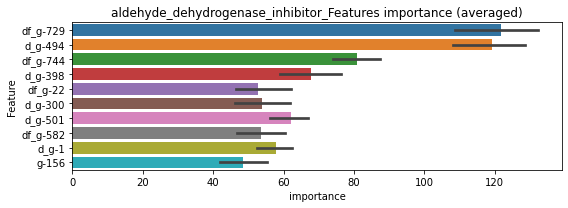

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0124631	valid_1's binary_logloss: 0.0183072
[200]	training's binary_logloss: 0.00139766	valid_1's binary_logloss: 0.00593962
[300]	training's binary_logloss: 0.000377767	valid_1's binary_logloss: 0.00489345
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.000380299	valid_1's binary_logloss: 0.00488954


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0125913	valid_1's binary_logloss: 0.0176253
[200]	training's binary_logloss: 0.00147171	valid_1's binary_logloss: 0.00403405
[300]	training's binary_logloss: 0.000407985	valid_1's binary_logloss: 0.0022389
[400]	training's binary_logloss: 0.00020992	valid_1's binary_logloss: 0.00175064
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000170664	valid_1's binary_logloss: 0.00168693


aldehyde_dehydrogenase_inhibitor logloss: 0.0032884431431592


neg labels: 3289 → selected neg labels: 3282


alk_inhibitor, len(trt): 42, len(othr): 3282, target_rate: 0.0017637 → Adj_target_rate: 0.0020135
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0326615	valid_1's binary_logloss: 0.0651159
[200]	training's binary_logloss: 0.00471832	valid_1's binary_logloss: 0.0288968
[300]	training's binary_logloss: 0.00137798	valid_1's binary_logloss: 0.0214955
[400]	training's binary_logloss: 0.000687958	valid_1's binary_logloss: 0.0184119
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000529697	valid_1's binary_logloss: 0.0176398
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330112	valid_1's binary_logloss: 0.0578931
[200]	training's binary_logloss: 0.00511501	valid_1's binary_logloss: 0.0201109
[300]	training's binary_logloss: 0.00147014	valid_1's binary_logloss: 0.0132352
[400]	training's binary_logloss: 0.000715798	valid_1's binary_logloss: 0.0110968
[500]	training's binary_logloss: 0.000484833	valid_1's binary_logloss: 0.0104735
Early stopping, best iteration is:
[490]	

1 / 3 AUC score:1.000
y_Threshold: 0.0054164, Threshold: 0.0138833, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3806
p_label_rate: 0.0200904 Vs.target_rate: 0.00176
Num_p_label: 80.0, conf_0:0.01249, conf_1:0.01527
Num_p_label: 80.0, Expected: 7.0, Adj_threshold_1: 0.0138833
Num_p_label: 46.0, Expected: 7.0, Adj_threshold_2: 0.0238833
Num_p_label: 36.0, Expected: 7.0, Adj_threshold_3: 0.0338833
Num_p_label: 30.0, Expected: 7.0, Adj_threshold_4: 0.0438833
Num_p_label: 24.0, Expected: 7.0, Adj_threshold_5: 0.0538833
Num_p_label: 18.0, Expected: 7.0, Adj_threshold_6: 0.0638833
Num_p_label: 17.0, Expected: 7.0, Adj_threshold_7: 0.0738833
Num_p_label: 16.0, Expected: 7.0, Adj_threshold_8: 0.0838833
Num_p_label: 13.0, Expected: 7.0, Adj_threshold_9: 0.0938833
threshold: 0.0938833, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0311035	valid_1's binary_logloss: 0.0592777
[200]	training's binary_logloss: 0.00440967	valid_1's binary_logloss: 0.0238811
[300]	training's binary_logloss: 0.00127518	valid_1's binary_logloss: 0.017376
[400]	training's binary_logloss: 0.000643984	valid_1's binary_logloss: 0.0151138
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.000673327	valid_1's binary_logloss: 0.0151096
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0313927	valid_1's binary_logloss: 0.0523373
[200]	training's binary_logloss: 0.00453724	valid_1's binary_logloss: 0.0156993
[300]	training's binary_logloss: 0.00130666	valid_1's binary_logloss: 0.00886252
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000752149	valid_1's binary_logloss: 0.00734752


2 / 3 AUC score:1.000
y_Threshold: 0.0855872, Threshold: 0.0938833, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 653.0/3800
p_label_rate: 0.0168257 Vs.target_rate: 0.00176
Num_p_label: 67.0, conf_0:0.08449, conf_1:0.10327
Num_p_label: 67.0, Expected: 7.0, Adj_threshold_1: 0.0938833
Num_p_label: 60.0, Expected: 7.0, Adj_threshold_2: 0.1038833
Num_p_label: 55.0, Expected: 7.0, Adj_threshold_3: 0.1138833
Num_p_label: 53.0, Expected: 7.0, Adj_threshold_4: 0.1238833
Num_p_label: 50.0, Expected: 7.0, Adj_threshold_5: 0.1338833
Num_p_label: 45.0, Expected: 7.0, Adj_threshold_6: 0.1438833
Num_p_label: 41.0, Expected: 7.0, Adj_threshold_7: 0.1538833
Num_p_label: 39.0, Expected: 7.0, Adj_threshold_8: 0.1638833
Num_p_label: 39.0, Expected: 7.0, Adj_threshold_9: 0.1738833
Num_p_label: 39.0, Expected: 7.0, Adj_threshold_10: 0.1838833
threshold: 0.1938833, positive_p_label: 38.0/3982, p_label_rate: 0.0095429
positive_y_label: 653.0/3800, y_label_rate: 0.1718421
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0308617	valid_1's binary_logloss: 0.0513363
[200]	training's binary_logloss: 0.00437373	valid_1's binary_logloss: 0.0144792
[300]	training's binary_logloss: 0.00128327	valid_1's binary_logloss: 0.00753588
[400]	training's binary_logloss: 0.00064703	valid_1's binary_logloss: 0.00578147
[500]	training's binary_logloss: 0.000452225	valid_1's binary_logloss: 0.00513285
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.000431551	valid_1's binary_logloss: 0.00501294
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0311942	valid_1's binary_logloss: 0.0512064
[200]	training's binary_logloss: 0.00448803	valid_1's binary_logloss: 0.0165493
[300]	training's binary_logloss: 0.00129394	valid_1's binary_logloss: 0.0105843
[400]	training's binary_logloss: 0.000652071	valid_1's binary_logloss: 0.00930325
Early stopping, best iteration is:
[4

3 / 3 AUC score:1.000
y_Threshold: 0.0743033, Threshold: 0.1938833, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 651.0/3796
p_label_rate: 0.0130588 Vs.target_rate: 0.00176
Num_p_label: 52.0, conf_0:0.17449, conf_1:0.21327
Num_p_label: 52.0, Expected: 7.0, Adj_threshold_1: 0.1938833
Num_p_label: 49.0, Expected: 7.0, Adj_threshold_2: 0.2038833
Num_p_label: 49.0, Expected: 7.0, Adj_threshold_3: 0.2138833
Num_p_label: 45.0, Expected: 7.0, Adj_threshold_4: 0.2238833
Num_p_label: 42.0, Expected: 7.0, Adj_threshold_5: 0.2338833
Num_p_label: 41.0, Expected: 7.0, Adj_threshold_6: 0.2438833
Num_p_label: 39.0, Expected: 7.0, Adj_threshold_7: 0.2538833
Num_p_label: 38.0, Expected: 7.0, Adj_threshold_8: 0.2638833
Num_p_label: 37.0, Expected: 7.0, Adj_threshold_9: 0.2738833
Num_p_label: 32.0, Expected: 7.0, Adj_threshold_10: 0.2838833
threshold: 0.2938833, positive_p_label: 30.0/3982, p_label_rate: 0.0075339
positive_y_label: 681.0/7778, y_label_rate: 0.0875546


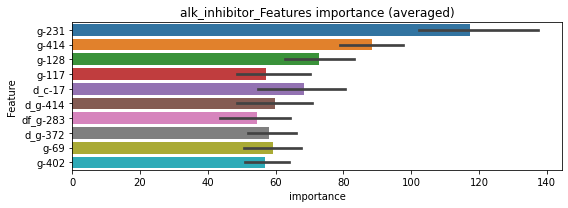

len(train_index) : 3889
len(valid_index) : 3889
================================= fold 1/2 alk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0177558	valid_1's binary_logloss: 0.032433
[200]	training's binary_logloss: 0.00261022	valid_1's binary_logloss: 0.0135038
[300]	training's binary_logloss: 0.000755334	valid_1's binary_logloss: 0.0101581
Early stopping, best iteration is:
[359]	training's binary_logloss: 0.00047458	valid_1's binary_logloss: 0.00964439


len(train_index) : 3889
len(valid_index) : 3889
================================= fold 2/2 alk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0181978	valid_1's binary_logloss: 0.0393471
[200]	training's binary_logloss: 0.00286397	valid_1's binary_logloss: 0.0179044
[300]	training's binary_logloss: 0.000788249	valid_1's binary_logloss: 0.0141283
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000418751	valid_1's binary_logloss: 0.0130721


alk_inhibitor logloss: 0.011358240780378287


neg labels: 3289 → selected neg labels: 3287


ampk_activator, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190671	valid_1's binary_logloss: 0.0241298
[200]	training's binary_logloss: 0.00194888	valid_1's binary_logloss: 0.00363986
[300]	training's binary_logloss: 0.000542458	valid_1's binary_logloss: 0.00135179
[400]	training's binary_logloss: 0.000305012	valid_1's binary_logloss: 0.000869741
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.000266186	valid_1's binary_logloss: 0.000809282
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186976	valid_1's binary_logloss: 0.0223283
[200]	training's binary_logloss: 0.00192602	valid_1's binary_logloss: 0.00348768
[300]	training's binary_logloss: 0.000550473	valid_1's binary_logloss: 0.00151568
[400]	training's binary_logloss: 0.000308687	valid_1's binary_logloss: 0.00109816
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000266667	valid_1's binary_logloss: 0.001

1 / 3 AUC score:1.000
y_Threshold: 0.0010024, Threshold: 0.0015526, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050
Num_p_label: 80.0, conf_0:0.00140, conf_1:0.00171
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0015526
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_2: 0.0115526
Num_p_label: 2.0, Expected: 2.0, Adj_threshold_3: 0.0215526
threshold: 0.0215526, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193262	valid_1's binary_logloss: 0.0241017
[200]	training's binary_logloss: 0.00190789	valid_1's binary_logloss: 0.0038179
[300]	training's binary_logloss: 0.000537139	valid_1's binary_logloss: 0.001391
[400]	training's binary_logloss: 0.000303737	valid_1's binary_logloss: 0.00092838
[500]	training's binary_logloss: 0.000263633	valid_1's binary_logloss: 0.000852636
Early stopping, best iteration is:
[551]	training's binary_logloss: 0.000259461	valid_1's binary_logloss: 0.000844552
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188516	valid_1's binary_logloss: 0.0224759
[200]	training's binary_logloss: 0.00188517	valid_1's binary_logloss: 0.0032893
[300]	training's binary_logloss: 0.000538897	valid_1's binary_logloss: 0.00141392
[400]	training's binary_logloss: 0.000309378	valid_1's binary_logloss: 0.00108256
Early stopping, best iteration is

2 / 3 AUC score:1.000
y_Threshold: 0.0682152, Threshold: 0.0215526, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0037670 Vs.target_rate: 0.00050
Num_p_label: 15.0, conf_0:0.01940, conf_1:0.02371
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_1: 0.0215526
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_2: 0.0315526
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_3: 0.0415526
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_4: 0.0515526
threshold: 0.0515526, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193262	valid_1's binary_logloss: 0.0241017
[200]	training's binary_logloss: 0.00190789	valid_1's binary_logloss: 0.0038179
[300]	training's binary_logloss: 0.000537139	valid_1's binary_logloss: 0.001391
[400]	training's binary_logloss: 0.000303737	valid_1's binary_logloss: 0.00092838
[500]	training's binary_logloss: 0.000263633	valid_1's binary_logloss: 0.000852636
Early stopping, best iteration is:
[551]	training's binary_logloss: 0.000259461	valid_1's binary_logloss: 0.000844552
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188516	valid_1's binary_logloss: 0.0224759
[200]	training's binary_logloss: 0.00188517	valid_1's binary_logloss: 0.0032893
[300]	training's binary_logloss: 0.000538897	valid_1's binary_logloss: 0.00141392
[400]	training's binary_logloss: 0.000309378	valid_1's binary_logloss: 0.00108256
Early stopping, best iteration is

3 / 3 AUC score:1.000
y_Threshold: 0.0682152, Threshold: 0.0515526, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0007534 Vs.target_rate: 0.00050
Num_p_label: 3.0, conf_0:0.04640, conf_1:0.05671
threshold: 0.0515526, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 660.0/7794, y_label_rate: 0.0846805


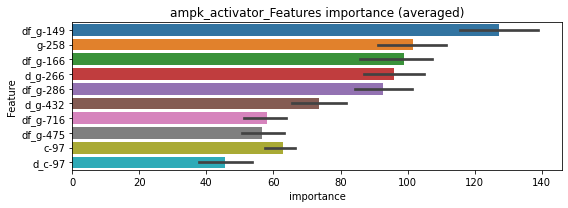

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 ampk_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0100198	valid_1's binary_logloss: 0.0148759
[200]	training's binary_logloss: 0.000988014	valid_1's binary_logloss: 0.00444504
[300]	training's binary_logloss: 0.000272238	valid_1's binary_logloss: 0.0036597
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.000191509	valid_1's binary_logloss: 0.00361591


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 ampk_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0103698	valid_1's binary_logloss: 0.0138632
[200]	training's binary_logloss: 0.00102598	valid_1's binary_logloss: 0.00283331
[300]	training's binary_logloss: 0.000282706	valid_1's binary_logloss: 0.00192584
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.000164642	valid_1's binary_logloss: 0.00182235


ampk_activator logloss: 0.002719133832280653


neg labels: 3289 → selected neg labels: 3287


analgesic, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179456	valid_1's binary_logloss: 0.0231354
[200]	training's binary_logloss: 0.0017942	valid_1's binary_logloss: 0.00369998
[300]	training's binary_logloss: 0.000506102	valid_1's binary_logloss: 0.00134628
[400]	training's binary_logloss: 0.000289006	valid_1's binary_logloss: 0.000863456
[500]	training's binary_logloss: 0.000255271	valid_1's binary_logloss: 0.000787015
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.000255271	valid_1's binary_logloss: 0.000787015
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179067	valid_1's binary_logloss: 0.0196834
[200]	training's binary_logloss: 0.00180074	valid_1's binary_logloss: 0.00234542
[300]	training's binary_logloss: 0.000509123	valid_1's binary_logloss: 0.000732018
[400]	training's binary_logloss: 0.000293452	valid_1's binary_logloss: 0.000438687
[500]	training's binary_log

1 / 3 AUC score:1.000
y_Threshold: 0.0010384, Threshold: 0.0016501, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050
Num_p_label: 80.0, conf_0:0.00149, conf_1:0.00182
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0016501
Num_p_label: 2.0, Expected: 2.0, Adj_threshold_2: 0.0116501
threshold: 0.0116501, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0178925	valid_1's binary_logloss: 0.0214562
[200]	training's binary_logloss: 0.00174976	valid_1's binary_logloss: 0.00284277
[300]	training's binary_logloss: 0.000499974	valid_1's binary_logloss: 0.000956366
[400]	training's binary_logloss: 0.000290312	valid_1's binary_logloss: 0.000608953
[500]	training's binary_logloss: 0.000250712	valid_1's binary_logloss: 0.000542421
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.000248309	valid_1's binary_logloss: 0.000539195
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182133	valid_1's binary_logloss: 0.0195853
[200]	training's binary_logloss: 0.00178654	valid_1's binary_logloss: 0.00211247
[300]	training's binary_logloss: 0.000505881	valid_1's binary_logloss: 0.00063457
[400]	training's binary_logloss: 0.000291362	valid_1's binary_logloss: 0.000374217
[500]	training's binary_lo

2 / 3 AUC score:1.000
y_Threshold: 0.1627482, Threshold: 0.0116501, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0047715 Vs.target_rate: 0.00050
Num_p_label: 19.0, conf_0:0.01049, conf_1:0.01282
Num_p_label: 19.0, Expected: 2.0, Adj_threshold_1: 0.0116501
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_2: 0.0216501
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_3: 0.0316501
threshold: 0.0316501, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0178925	valid_1's binary_logloss: 0.0214562
[200]	training's binary_logloss: 0.00174976	valid_1's binary_logloss: 0.00284277
[300]	training's binary_logloss: 0.000499974	valid_1's binary_logloss: 0.000956366
[400]	training's binary_logloss: 0.000290312	valid_1's binary_logloss: 0.000608953
[500]	training's binary_logloss: 0.000250712	valid_1's binary_logloss: 0.000542421
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.000248309	valid_1's binary_logloss: 0.000539195
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182133	valid_1's binary_logloss: 0.0195853
[200]	training's binary_logloss: 0.00178654	valid_1's binary_logloss: 0.00211247
[300]	training's binary_logloss: 0.000505881	valid_1's binary_logloss: 0.00063457
[400]	training's binary_logloss: 0.000291362	valid_1's binary_logloss: 0.000374217
[500]	training's binary_lo

3 / 3 AUC score:1.000
y_Threshold: 0.1627482, Threshold: 0.0316501, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0010045 Vs.target_rate: 0.00050
Num_p_label: 4.0, conf_0:0.02849, conf_1:0.03482
threshold: 0.0316501, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 661.0/7794, y_label_rate: 0.0848088


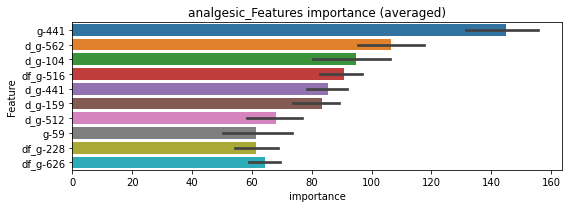

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 analgesic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00937104	valid_1's binary_logloss: 0.0141892
[200]	training's binary_logloss: 0.000888539	valid_1's binary_logloss: 0.00521565
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.000315363	valid_1's binary_logloss: 0.00468437


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 analgesic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00979896	valid_1's binary_logloss: 0.0117199
[200]	training's binary_logloss: 0.000967358	valid_1's binary_logloss: 0.00249643
[300]	training's binary_logloss: 0.000268786	valid_1's binary_logloss: 0.00182781
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.000190524	valid_1's binary_logloss: 0.00176562


analgesic logloss: 0.0032249946639927416


neg labels: 3289 → selected neg labels: 3281


androgen_receptor_agonist, len(trt): 48, len(othr): 3281, target_rate: 0.0020156 → Adj_target_rate: 0.0022556
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0442205	valid_1's binary_logloss: 0.0988838
[200]	training's binary_logloss: 0.00774248	valid_1's binary_logloss: 0.0594844
[300]	training's binary_logloss: 0.00214057	valid_1's binary_logloss: 0.0528164
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.00197729	valid_1's binary_logloss: 0.052526
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0479965	valid_1's binary_logloss: 0.0777535
[200]	training's binary_logloss: 0.00871368	valid_1's binary_logloss: 0.0265407
[300]	training's binary_logloss: 0.00240407	valid_1's binary_logloss: 0.014768
[400]	training's binary_logloss: 0.00108191	valid_1's binary_logloss: 0.0109983
[500]	training's binary_logloss: 0.000676399	valid_1's binary_logloss: 0.00987726
Early stopping, best iteration is:
[549]	training's binary_logloss: 0.000575347	valid_1's binary_logloss: 0.0094897


1 / 3 AUC score:0.997
y_Threshold: 0.0114598, Threshold: 0.0177769, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 146 → Positive_corect_labels: 649/3791
p_label_rate: 0.0200904 Vs.target_rate: 0.00202
Num_p_label: 80.0, conf_0:0.01600, conf_1:0.01955
Num_p_label: 80.0, Expected: 8.0, Adj_threshold_1: 0.0177769
Num_p_label: 30.0, Expected: 8.0, Adj_threshold_2: 0.0277769
Num_p_label: 24.0, Expected: 8.0, Adj_threshold_3: 0.0377769
Num_p_label: 15.0, Expected: 8.0, Adj_threshold_4: 0.0477769
threshold: 0.0477769, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 649.0/3791, y_label_rate: 0.1711949
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0419038	valid_1's binary_logloss: 0.0883908
[200]	training's binary_logloss: 0.00708333	valid_1's binary_logloss: 0.0432266
[300]	training's binary_logloss: 0.00200025	valid_1's binary_logloss: 0.0331643
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00109543	valid_1's binary_logloss: 0.0304045
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0461444	valid_1's binary_logloss: 0.0823301
[200]	training's binary_logloss: 0.00804713	valid_1's binary_logloss: 0.0320246
[300]	training's binary_logloss: 0.00222611	valid_1's binary_logloss: 0.0199409
[400]	training's binary_logloss: 0.00102128	valid_1's binary_logloss: 0.0156605
[500]	training's binary_logloss: 0.000639852	valid_1's binary_logloss: 0.0135002
Early stopping, best iteration is:
[562]	training's binary_logloss: 0.000535702	valid_1's binary_logloss: 0.0129011


2 / 3 AUC score:0.999
y_Threshold: 0.0346251, Threshold: 0.0477769, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 645.0/3783
p_label_rate: 0.0080362 Vs.target_rate: 0.00202
Num_p_label: 32.0, conf_0:0.04300, conf_1:0.05255
Num_p_label: 32.0, Expected: 8.0, Adj_threshold_1: 0.0477769
Num_p_label: 28.0, Expected: 8.0, Adj_threshold_2: 0.0577769
Num_p_label: 20.0, Expected: 8.0, Adj_threshold_3: 0.0677769
Num_p_label: 17.0, Expected: 8.0, Adj_threshold_4: 0.0777769
Num_p_label: 15.0, Expected: 8.0, Adj_threshold_5: 0.0877769
threshold: 0.0877769, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 645.0/3783, y_label_rate: 0.1704996
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0431255	valid_1's binary_logloss: 0.0745746
[200]	training's binary_logloss: 0.00755843	valid_1's binary_logloss: 0.0265908
[300]	training's binary_logloss: 0.00211374	valid_1's binary_logloss: 0.0152139
[400]	training's binary_logloss: 0.000985999	valid_1's binary_logloss: 0.0118911
[500]	training's binary_logloss: 0.000626688	valid_1's binary_logloss: 0.0105477
Early stopping, best iteration is:
[522]	training's binary_logloss: 0.000586866	valid_1's binary_logloss: 0.0103918
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0422069	valid_1's binary_logloss: 0.088453
[200]	training's binary_logloss: 0.00701546	valid_1's binary_logloss: 0.0444434
[300]	training's binary_logloss: 0.00196897	valid_1's binary_logloss: 0.0348332
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.00169458	valid_1's binary_logloss: 0.0339891


3 / 3 AUC score:1.000
y_Threshold: 0.0429260, Threshold: 0.0877769, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 641.0/3775
p_label_rate: 0.0052737 Vs.target_rate: 0.00202
Num_p_label: 21.0, conf_0:0.07900, conf_1:0.09655
threshold: 0.0877769, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 662.0/7757, y_label_rate: 0.0853423


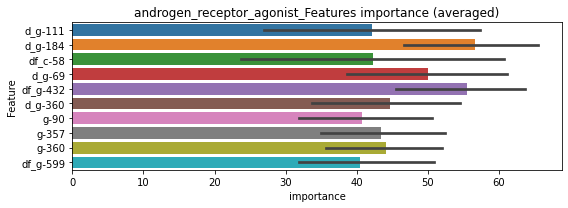

len(train_index) : 3878
len(valid_index) : 3879
================================= fold 1/2 androgen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024612	valid_1's binary_logloss: 0.0473463
[200]	training's binary_logloss: 0.00441934	valid_1's binary_logloss: 0.0249065
[300]	training's binary_logloss: 0.00120443	valid_1's binary_logloss: 0.0214457
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.00101313	valid_1's binary_logloss: 0.021197


len(train_index) : 3879
len(valid_index) : 3878
================================= fold 2/2 androgen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0262674	valid_1's binary_logloss: 0.0526155
[200]	training's binary_logloss: 0.00456286	valid_1's binary_logloss: 0.0260438
[300]	training's binary_logloss: 0.00118319	valid_1's binary_logloss: 0.0202014
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.000658627	valid_1's binary_logloss: 0.0189645


androgen_receptor_agonist logloss: 0.020080905301952588


neg labels: 3289 → selected neg labels: 3274


androgen_receptor_antagonist, len(trt): 89, len(othr): 3274, target_rate: 0.0037373 → Adj_target_rate: 0.0038122
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0665263	valid_1's binary_logloss: 0.137824
[200]	training's binary_logloss: 0.0158206	valid_1's binary_logloss: 0.0863007
[300]	training's binary_logloss: 0.00461485	valid_1's binary_logloss: 0.0740706
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.00219419	valid_1's binary_logloss: 0.0717154
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0706476	valid_1's binary_logloss: 0.144201
[200]	training's binary_logloss: 0.0162965	valid_1's binary_logloss: 0.0858296
[300]	training's binary_logloss: 0.00459111	valid_1's binary_logloss: 0.0719158
[400]	training's binary_logloss: 0.00191586	valid_1's binary_logloss: 0.0684814
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.00196575	valid_1's binary_logloss: 0.0683521


1 / 3 AUC score:0.990
y_Threshold: 0.0179054, Threshold: 0.0257815, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 174 → Positive_corect_labels: 633/3754
p_label_rate: 0.0200904 Vs.target_rate: 0.00374
Num_p_label: 80.0, conf_0:0.02320, conf_1:0.02836
Num_p_label: 80.0, Expected: 14.9, Adj_threshold_1: 0.0257815
Num_p_label: 42.0, Expected: 14.9, Adj_threshold_2: 0.0357815
Num_p_label: 23.0, Expected: 14.9, Adj_threshold_3: 0.0457815
threshold: 0.0457815, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 633.0/3754, y_label_rate: 0.1686201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0646694	valid_1's binary_logloss: 0.132706
[200]	training's binary_logloss: 0.0147775	valid_1's binary_logloss: 0.0722892
[300]	training's binary_logloss: 0.00430036	valid_1's binary_logloss: 0.0514663
[400]	training's binary_logloss: 0.00186048	valid_1's binary_logloss: 0.0438633
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.00116107	valid_1's binary_logloss: 0.0414075
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0640606	valid_1's binary_logloss: 0.130172
[200]	training's binary_logloss: 0.0144909	valid_1's binary_logloss: 0.0670603
[300]	training's binary_logloss: 0.00417012	valid_1's binary_logloss: 0.048756
[400]	training's binary_logloss: 0.00178223	valid_1's binary_logloss: 0.0431631
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.00144863	valid_1's binary_logloss: 0.0419806


2 / 3 AUC score:0.999
y_Threshold: 0.0564595, Threshold: 0.0457815, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 18 → Positive_corect_labels: 624.0/3736
p_label_rate: 0.0107986 Vs.target_rate: 0.00374
Num_p_label: 43.0, conf_0:0.04120, conf_1:0.05036
threshold: 0.0457815, positive_p_label: 43.0/3982, p_label_rate: 0.0107986
positive_y_label: 624.0/3736, y_label_rate: 0.1670236
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0619556	valid_1's binary_logloss: 0.124508
[200]	training's binary_logloss: 0.0135806	valid_1's binary_logloss: 0.0679789
[300]	training's binary_logloss: 0.00385622	valid_1's binary_logloss: 0.0523622
[400]	training's binary_logloss: 0.0016552	valid_1's binary_logloss: 0.0487682
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00121012	valid_1's binary_logloss: 0.0479169
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0609257	valid_1's binary_logloss: 0.128077
[200]	training's binary_logloss: 0.0135949	valid_1's binary_logloss: 0.0729146
[300]	training's binary_logloss: 0.00390986	valid_1's binary_logloss: 0.0603143
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00268484	valid_1's binary_logloss: 0.0587932


3 / 3 AUC score:0.996
y_Threshold: 0.0360731, Threshold: 0.0457815, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 40 → Positive_corect_labels: 604.0/3696
p_label_rate: 0.0150678 Vs.target_rate: 0.00374
Num_p_label: 60.0, conf_0:0.04120, conf_1:0.05036
Num_p_label: 60.0, Expected: 14.9, Adj_threshold_1: 0.0457815
Num_p_label: 42.0, Expected: 14.9, Adj_threshold_2: 0.0557815
Num_p_label: 32.0, Expected: 14.9, Adj_threshold_3: 0.0657815
Num_p_label: 23.0, Expected: 14.9, Adj_threshold_4: 0.0757815
threshold: 0.0757815, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 627.0/7678, y_label_rate: 0.0816619


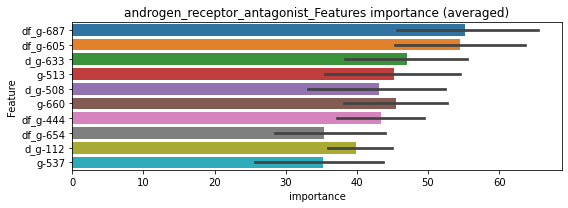

len(train_index) : 3839
len(valid_index) : 3839
================================= fold 1/2 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0344131	valid_1's binary_logloss: 0.0837773
[200]	training's binary_logloss: 0.00779329	valid_1's binary_logloss: 0.0524184
[300]	training's binary_logloss: 0.00220024	valid_1's binary_logloss: 0.0446364
Early stopping, best iteration is:
[358]	training's binary_logloss: 0.00126245	valid_1's binary_logloss: 0.0431854


len(train_index) : 3839
len(valid_index) : 3839
================================= fold 2/2 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0358292	valid_1's binary_logloss: 0.0798163
[200]	training's binary_logloss: 0.00806277	valid_1's binary_logloss: 0.048284
[300]	training's binary_logloss: 0.00225844	valid_1's binary_logloss: 0.0422125
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.0025237	valid_1's binary_logloss: 0.0421722


androgen_receptor_antagonist logloss: 0.0426788292505579


neg labels: 3289 → selected neg labels: 3276


anesthetic_-_local, len(trt): 80, len(othr): 3276, target_rate: 0.0033594 → Adj_target_rate: 0.0034820
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0570462	valid_1's binary_logloss: 0.127382
[200]	training's binary_logloss: 0.0124869	valid_1's binary_logloss: 0.076997
[300]	training's binary_logloss: 0.00368962	valid_1's binary_logloss: 0.0634802
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.0017639	valid_1's binary_logloss: 0.0594952
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0593783	valid_1's binary_logloss: 0.12863
[200]	training's binary_logloss: 0.0134221	valid_1's binary_logloss: 0.0793308
[300]	training's binary_logloss: 0.00380389	valid_1's binary_logloss: 0.0671923
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00231134	valid_1's binary_logloss: 0.0653218


1 / 3 AUC score:0.992
y_Threshold: 0.0162985, Threshold: 0.0220928, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 172 → Positive_corect_labels: 635/3759
p_label_rate: 0.0200904 Vs.target_rate: 0.00336
Num_p_label: 80.0, conf_0:0.01988, conf_1:0.02430
Num_p_label: 80.0, Expected: 13.4, Adj_threshold_1: 0.0220928
Num_p_label: 34.0, Expected: 13.4, Adj_threshold_2: 0.0320928
Num_p_label: 19.0, Expected: 13.4, Adj_threshold_3: 0.0420928
threshold: 0.0420928, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 635.0/3759, y_label_rate: 0.1689279
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0537354	valid_1's binary_logloss: 0.11025
[200]	training's binary_logloss: 0.0116148	valid_1's binary_logloss: 0.0561467
[300]	training's binary_logloss: 0.00340675	valid_1's binary_logloss: 0.0399129
[400]	training's binary_logloss: 0.00152528	valid_1's binary_logloss: 0.0348609
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.00112847	valid_1's binary_logloss: 0.0337206
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0531829	valid_1's binary_logloss: 0.116595
[200]	training's binary_logloss: 0.0116047	valid_1's binary_logloss: 0.0682505
[300]	training's binary_logloss: 0.00332493	valid_1's binary_logloss: 0.0554213
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00176316	valid_1's binary_logloss: 0.0527077


2 / 3 AUC score:0.999
y_Threshold: 0.0392076, Threshold: 0.0420928, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 624.0/3737
p_label_rate: 0.0065294 Vs.target_rate: 0.00336
Num_p_label: 26.0, conf_0:0.03788, conf_1:0.04630
threshold: 0.0420928, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 624.0/3737, y_label_rate: 0.1669789
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0510724	valid_1's binary_logloss: 0.129152
[200]	training's binary_logloss: 0.0105925	valid_1's binary_logloss: 0.0881591
[300]	training's binary_logloss: 0.0030978	valid_1's binary_logloss: 0.0788742
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.00172658	valid_1's binary_logloss: 0.0761193
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0547172	valid_1's binary_logloss: 0.0980932
[200]	training's binary_logloss: 0.0119671	valid_1's binary_logloss: 0.0440552
[300]	training's binary_logloss: 0.00347843	valid_1's binary_logloss: 0.0290017
[400]	training's binary_logloss: 0.00154964	valid_1's binary_logloss: 0.0233443
[500]	training's binary_logloss: 0.000947454	valid_1's binary_logloss: 0.0211914
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000983889	valid_1's binary_logloss: 0.021143


3 / 3 AUC score:0.996
y_Threshold: 0.0305011, Threshold: 0.0420928, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 32 → Positive_corect_labels: 608.0/3705
p_label_rate: 0.0057760 Vs.target_rate: 0.00336
Num_p_label: 23.0, conf_0:0.03788, conf_1:0.04630
threshold: 0.0420928, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 631.0/7687, y_label_rate: 0.0820866


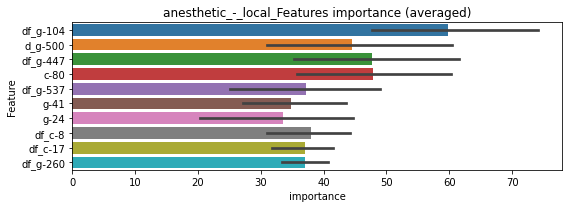

len(train_index) : 3843
len(valid_index) : 3844
================================= fold 1/2 anesthetic_-_local=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286537	valid_1's binary_logloss: 0.0715997
[200]	training's binary_logloss: 0.00605754	valid_1's binary_logloss: 0.0493738
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00213387	valid_1's binary_logloss: 0.0454726


len(train_index) : 3844
len(valid_index) : 3843
================================= fold 2/2 anesthetic_-_local=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293381	valid_1's binary_logloss: 0.0721911
[200]	training's binary_logloss: 0.00610152	valid_1's binary_logloss: 0.0490569
[300]	training's binary_logloss: 0.00179048	valid_1's binary_logloss: 0.0460669
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.00198429	valid_1's binary_logloss: 0.0459496


anesthetic_-_local logloss: 0.04571105599457639


neg labels: 3289 → selected neg labels: 3283


angiogenesis_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0385718	valid_1's binary_logloss: 0.0570247
[200]	training's binary_logloss: 0.00648506	valid_1's binary_logloss: 0.0166463
[300]	training's binary_logloss: 0.00173365	valid_1's binary_logloss: 0.00753865
[400]	training's binary_logloss: 0.000808949	valid_1's binary_logloss: 0.00496062
[500]	training's binary_logloss: 0.000527908	valid_1's binary_logloss: 0.00404849
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00045007	valid_1's binary_logloss: 0.00373566
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0369804	valid_1's binary_logloss: 0.0659572
[200]	training's binary_logloss: 0.00580638	valid_1's binary_logloss: 0.0241358
[300]	training's binary_logloss: 0.00160816	valid_1's binary_logloss: 0.0161464
[400]	training's binary_logloss: 0.000763725	valid_1's binary_logloss: 0.0146809
Early stopping, best iteration is:
[40

1 / 3 AUC score:1.000
y_Threshold: 0.0044295, Threshold: 0.0065546, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151
Num_p_label: 80.0, conf_0:0.00590, conf_1:0.00721
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0065546
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_2: 0.0165546
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_3: 0.0265546
threshold: 0.0265546, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0378286	valid_1's binary_logloss: 0.0554015
[200]	training's binary_logloss: 0.00582017	valid_1's binary_logloss: 0.0148484
[300]	training's binary_logloss: 0.00160429	valid_1's binary_logloss: 0.00673767
[400]	training's binary_logloss: 0.000764307	valid_1's binary_logloss: 0.00452746
[500]	training's binary_logloss: 0.000506654	valid_1's binary_logloss: 0.00368398
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.000471381	valid_1's binary_logloss: 0.00353984
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.037388	valid_1's binary_logloss: 0.0634414
[200]	training's binary_logloss: 0.00570947	valid_1's binary_logloss: 0.0208853
[300]	training's binary_logloss: 0.0015563	valid_1's binary_logloss: 0.0131206
[400]	training's binary_logloss: 0.000742572	valid_1's binary_logloss: 0.0117742
Early stopping, best iteration is:
[400

2 / 3 AUC score:1.000
y_Threshold: 0.0527636, Threshold: 0.0265546, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0047715 Vs.target_rate: 0.00151
Num_p_label: 19.0, conf_0:0.02390, conf_1:0.02921
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_1: 0.0265546
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_2: 0.0365546
Num_p_label: 7.0, Expected: 6.0, Adj_threshold_3: 0.0465546
threshold: 0.0465546, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0371049	valid_1's binary_logloss: 0.0690358
[200]	training's binary_logloss: 0.00567896	valid_1's binary_logloss: 0.0272114
[300]	training's binary_logloss: 0.0015663	valid_1's binary_logloss: 0.0200727
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.000859531	valid_1's binary_logloss: 0.0182905
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0362886	valid_1's binary_logloss: 0.0592834
[200]	training's binary_logloss: 0.00554408	valid_1's binary_logloss: 0.0164025
[300]	training's binary_logloss: 0.00153894	valid_1's binary_logloss: 0.00817742
[400]	training's binary_logloss: 0.000741239	valid_1's binary_logloss: 0.00616544
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000572032	valid_1's binary_logloss: 0.00584659


3 / 3 AUC score:1.000
y_Threshold: 0.0236997, Threshold: 0.0465546, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 651.0/3797
p_label_rate: 0.0020090 Vs.target_rate: 0.00151
Num_p_label: 8.0, conf_0:0.04190, conf_1:0.05121
threshold: 0.0465546, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 659.0/7779, y_label_rate: 0.0847153


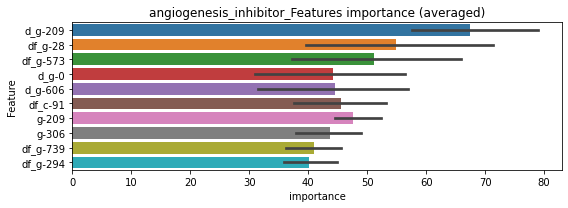

len(train_index) : 3889
len(valid_index) : 3890
================================= fold 1/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0216042	valid_1's binary_logloss: 0.0429535
[200]	training's binary_logloss: 0.00329284	valid_1's binary_logloss: 0.0211117
[300]	training's binary_logloss: 0.00086657	valid_1's binary_logloss: 0.0182135
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.000951631	valid_1's binary_logloss: 0.0181981


len(train_index) : 3890
len(valid_index) : 3889
================================= fold 2/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0216303	valid_1's binary_logloss: 0.0440533
[200]	training's binary_logloss: 0.00342643	valid_1's binary_logloss: 0.0226956
[300]	training's binary_logloss: 0.000896551	valid_1's binary_logloss: 0.0185279
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.000654284	valid_1's binary_logloss: 0.0180948


angiogenesis_inhibitor logloss: 0.01814643527724621


neg labels: 3289 → selected neg labels: 3283


angiotensin_receptor_antagonist, len(trt): 37, len(othr): 3283, target_rate: 0.0015537 → Adj_target_rate: 0.0018079
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0365624	valid_1's binary_logloss: 0.0677119
[200]	training's binary_logloss: 0.00564297	valid_1's binary_logloss: 0.0285706
[300]	training's binary_logloss: 0.00153169	valid_1's binary_logloss: 0.0189713
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.000998101	valid_1's binary_logloss: 0.0168437
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0379489	valid_1's binary_logloss: 0.0631384
[200]	training's binary_logloss: 0.00605023	valid_1's binary_logloss: 0.0224136
[300]	training's binary_logloss: 0.00166898	valid_1's binary_logloss: 0.012447
[400]	training's binary_logloss: 0.000786911	valid_1's binary_logloss: 0.00952171
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.000760154	valid_1's binary_logloss: 0.00940534


1 / 3 AUC score:1.000
y_Threshold: 0.0058706, Threshold: 0.0076209, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00155
Num_p_label: 80.0, conf_0:0.00686, conf_1:0.00838
Num_p_label: 80.0, Expected: 6.2, Adj_threshold_1: 0.0076209
Num_p_label: 15.0, Expected: 6.2, Adj_threshold_2: 0.0176209
Num_p_label: 5.0, Expected: 6.2, Adj_threshold_3: 0.0276209
threshold: 0.0276209, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0358463	valid_1's binary_logloss: 0.0663115
[200]	training's binary_logloss: 0.00546728	valid_1's binary_logloss: 0.0275977
[300]	training's binary_logloss: 0.00149183	valid_1's binary_logloss: 0.018296
[400]	training's binary_logloss: 0.000714867	valid_1's binary_logloss: 0.0153223
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.000667856	valid_1's binary_logloss: 0.0152091
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0385062	valid_1's binary_logloss: 0.0641254
[200]	training's binary_logloss: 0.00597585	valid_1's binary_logloss: 0.0226788
[300]	training's binary_logloss: 0.00162595	valid_1's binary_logloss: 0.0135708
[400]	training's binary_logloss: 0.000770991	valid_1's binary_logloss: 0.0110069
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.000575427	valid_1's binary_logloss: 0.0102106


2 / 3 AUC score:1.000
y_Threshold: 0.0303087, Threshold: 0.0276209, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0050226 Vs.target_rate: 0.00155
Num_p_label: 20.0, conf_0:0.02486, conf_1:0.03038
Num_p_label: 20.0, Expected: 6.2, Adj_threshold_1: 0.0276209
Num_p_label: 14.0, Expected: 6.2, Adj_threshold_2: 0.0376209
Num_p_label: 7.0, Expected: 6.2, Adj_threshold_3: 0.0476209
threshold: 0.0476209, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0358463	valid_1's binary_logloss: 0.0663115
[200]	training's binary_logloss: 0.00546728	valid_1's binary_logloss: 0.0275977
[300]	training's binary_logloss: 0.00149183	valid_1's binary_logloss: 0.018296
[400]	training's binary_logloss: 0.000714867	valid_1's binary_logloss: 0.0153223
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.000667856	valid_1's binary_logloss: 0.0152091
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0385062	valid_1's binary_logloss: 0.0641254
[200]	training's binary_logloss: 0.00597585	valid_1's binary_logloss: 0.0226788
[300]	training's binary_logloss: 0.00162595	valid_1's binary_logloss: 0.0135708
[400]	training's binary_logloss: 0.000770991	valid_1's binary_logloss: 0.0110069
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.000575427	valid_1's binary_logloss: 0.0102106


3 / 3 AUC score:1.000
y_Threshold: 0.0303087, Threshold: 0.0476209, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0017579 Vs.target_rate: 0.00155
Num_p_label: 7.0, conf_0:0.04286, conf_1:0.05238
threshold: 0.0476209, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 663.0/7789, y_label_rate: 0.0851200


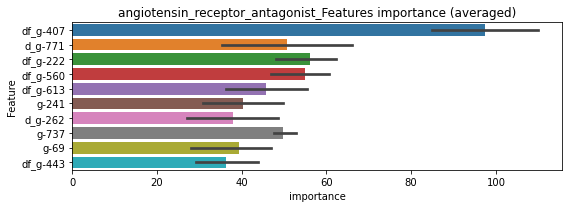

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0210846	valid_1's binary_logloss: 0.0400812
[200]	training's binary_logloss: 0.00322077	valid_1's binary_logloss: 0.0165937
[300]	training's binary_logloss: 0.000851695	valid_1's binary_logloss: 0.0124031
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.000448652	valid_1's binary_logloss: 0.0115258


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022395	valid_1's binary_logloss: 0.0350342
[200]	training's binary_logloss: 0.00347245	valid_1's binary_logloss: 0.0125459
[300]	training's binary_logloss: 0.000937597	valid_1's binary_logloss: 0.00869606
[400]	training's binary_logloss: 0.000418219	valid_1's binary_logloss: 0.00787823
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.000341115	valid_1's binary_logloss: 0.00767319


angiotensin_receptor_antagonist logloss: 0.009599752606942687


neg labels: 3289 → selected neg labels: 3277


anti-inflammatory, len(trt): 73, len(othr): 3277, target_rate: 0.0030654 → Adj_target_rate: 0.0032212
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0543734	valid_1's binary_logloss: 0.0980099
[200]	training's binary_logloss: 0.0109257	valid_1's binary_logloss: 0.0446019
[300]	training's binary_logloss: 0.00309494	valid_1's binary_logloss: 0.0306515
[400]	training's binary_logloss: 0.00137626	valid_1's binary_logloss: 0.025909
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.000985013	valid_1's binary_logloss: 0.0246002
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0503283	valid_1's binary_logloss: 0.101898
[200]	training's binary_logloss: 0.0100269	valid_1's binary_logloss: 0.0524909
[300]	training's binary_logloss: 0.0029256	valid_1's binary_logloss: 0.0400857
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.0015107	valid_1's binary_logloss: 0.0368543


1 / 3 AUC score:0.996
y_Threshold: 0.0125395, Threshold: 0.0234049, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 148 → Positive_corect_labels: 647/3784
p_label_rate: 0.0200904 Vs.target_rate: 0.00307
Num_p_label: 80.0, conf_0:0.02106, conf_1:0.02575
Num_p_label: 80.0, Expected: 12.2, Adj_threshold_1: 0.0234049
Num_p_label: 49.0, Expected: 12.2, Adj_threshold_2: 0.0334049
Num_p_label: 30.0, Expected: 12.2, Adj_threshold_3: 0.0434049
Num_p_label: 23.0, Expected: 12.2, Adj_threshold_4: 0.0534049
threshold: 0.0534049, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 647.0/3784, y_label_rate: 0.1709831
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.050685	valid_1's binary_logloss: 0.0997542
[200]	training's binary_logloss: 0.00963961	valid_1's binary_logloss: 0.0470411
[300]	training's binary_logloss: 0.00271585	valid_1's binary_logloss: 0.0350247
[400]	training's binary_logloss: 0.00122122	valid_1's binary_logloss: 0.0319889
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00112161	valid_1's binary_logloss: 0.0318639
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0484815	valid_1's binary_logloss: 0.0940786
[200]	training's binary_logloss: 0.00896413	valid_1's binary_logloss: 0.0432226
[300]	training's binary_logloss: 0.00258963	valid_1's binary_logloss: 0.0313074
[400]	training's binary_logloss: 0.00120344	valid_1's binary_logloss: 0.0277757
Early stopping, best iteration is:
[427]	training's binary_logloss: 0.00103053	valid_1's binary_logloss: 0.0273923


2 / 3 AUC score:0.999
y_Threshold: 0.0335877, Threshold: 0.0534049, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 20 → Positive_corect_labels: 637.0/3764
p_label_rate: 0.0113009 Vs.target_rate: 0.00307
Num_p_label: 45.0, conf_0:0.04806, conf_1:0.05875
Num_p_label: 45.0, Expected: 12.2, Adj_threshold_1: 0.0534049
Num_p_label: 36.0, Expected: 12.2, Adj_threshold_2: 0.0634049
Num_p_label: 26.0, Expected: 12.2, Adj_threshold_3: 0.0734049
Num_p_label: 24.0, Expected: 12.2, Adj_threshold_4: 0.0834049
threshold: 0.0834049, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 637.0/3764, y_label_rate: 0.1692349
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0462465	valid_1's binary_logloss: 0.091873
[200]	training's binary_logloss: 0.0088285	valid_1's binary_logloss: 0.047317
[300]	training's binary_logloss: 0.00253325	valid_1's binary_logloss: 0.0358125
[400]	training's binary_logloss: 0.00114951	valid_1's binary_logloss: 0.0323201
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000829762	valid_1's binary_logloss: 0.0306777
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0473818	valid_1's binary_logloss: 0.0975996
[200]	training's binary_logloss: 0.00855331	valid_1's binary_logloss: 0.0503539
[300]	training's binary_logloss: 0.00247156	valid_1's binary_logloss: 0.0384144
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.00130055	valid_1's binary_logloss: 0.0357659


3 / 3 AUC score:1.000
y_Threshold: 0.0284309, Threshold: 0.0834049, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 18 → Positive_corect_labels: 628.0/3746
p_label_rate: 0.0072828 Vs.target_rate: 0.00307
Num_p_label: 29.0, conf_0:0.07506, conf_1:0.09175
threshold: 0.0834049, positive_p_label: 29.0/3982, p_label_rate: 0.0072828
positive_y_label: 657.0/7728, y_label_rate: 0.0850155


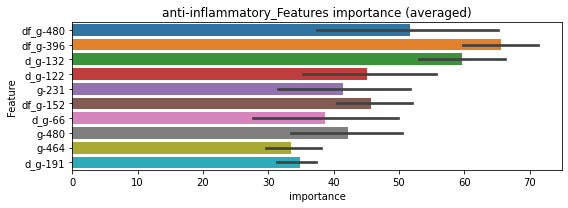

len(train_index) : 3864
len(valid_index) : 3864
================================= fold 1/2 anti-inflammatory=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0273506	valid_1's binary_logloss: 0.0693749
[200]	training's binary_logloss: 0.00494296	valid_1's binary_logloss: 0.0436983
[300]	training's binary_logloss: 0.00138605	valid_1's binary_logloss: 0.0381747
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.000846733	valid_1's binary_logloss: 0.0370487


len(train_index) : 3864
len(valid_index) : 3864
================================= fold 2/2 anti-inflammatory=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271555	valid_1's binary_logloss: 0.0515655
[200]	training's binary_logloss: 0.00525959	valid_1's binary_logloss: 0.0249818
[300]	training's binary_logloss: 0.00150536	valid_1's binary_logloss: 0.0193295
[400]	training's binary_logloss: 0.000687319	valid_1's binary_logloss: 0.0179064
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.000626816	valid_1's binary_logloss: 0.017728


anti-inflammatory logloss: 0.027388319424469832


neg labels: 3289 → selected neg labels: 3285


antiarrhythmic, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0267404	valid_1's binary_logloss: 0.0475265
[200]	training's binary_logloss: 0.00349994	valid_1's binary_logloss: 0.0176223
[300]	training's binary_logloss: 0.000969642	valid_1's binary_logloss: 0.0119884
[400]	training's binary_logloss: 0.000492389	valid_1's binary_logloss: 0.0104074
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.000411611	valid_1's binary_logloss: 0.0100448
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0279033	valid_1's binary_logloss: 0.0378971
[200]	training's binary_logloss: 0.00363563	valid_1's binary_logloss: 0.00740393
[300]	training's binary_logloss: 0.00100884	valid_1's binary_logloss: 0.0029359
[400]	training's binary_logloss: 0.000503059	valid_1's binary_logloss: 0.00185593
[500]	training's binary_logloss: 0.000385694	valid_1's binary_logloss: 0.00161992
Early stopping, best iteration is:
[5

1 / 3 AUC score:1.000
y_Threshold: 0.0018055, Threshold: 0.0127371, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00101
Num_p_label: 80.0, conf_0:0.01146, conf_1:0.01401
Num_p_label: 80.0, Expected: 4.0, Adj_threshold_1: 0.0127371
Num_p_label: 46.0, Expected: 4.0, Adj_threshold_2: 0.0227371
Num_p_label: 30.0, Expected: 4.0, Adj_threshold_3: 0.0327371
Num_p_label: 24.0, Expected: 4.0, Adj_threshold_4: 0.0427371
Num_p_label: 17.0, Expected: 4.0, Adj_threshold_5: 0.0527371
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_6: 0.0627371
Num_p_label: 8.0, Expected: 4.0, Adj_threshold_7: 0.0727371
threshold: 0.0727371, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261392	valid_1's binary_logloss: 0.0447142
[200]	training's binary_logloss: 0.00329252	valid_1's binary_logloss: 0.0145682
[300]	training's binary_logloss: 0.000930282	valid_1's binary_logloss: 0.0101325
[400]	training's binary_logloss: 0.000471246	valid_1's binary_logloss: 0.00840678
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.000387582	valid_1's binary_logloss: 0.00801993
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0273876	valid_1's binary_logloss: 0.0364702
[200]	training's binary_logloss: 0.00342345	valid_1's binary_logloss: 0.00605506
[300]	training's binary_logloss: 0.000956208	valid_1's binary_logloss: 0.00207034
[400]	training's binary_logloss: 0.00048652	valid_1's binary_logloss: 0.00119658
[500]	training's binary_logloss: 0.000370969	valid_1's binary_logloss: 0.00097306
Early stopping, best iteration is:

2 / 3 AUC score:1.000
y_Threshold: 0.0214020, Threshold: 0.0727371, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0351582 Vs.target_rate: 0.00101
Num_p_label: 140.0, conf_0:0.06546, conf_1:0.08001
Num_p_label: 140.0, Expected: 4.0, Adj_threshold_1: 0.0727371
Num_p_label: 136.0, Expected: 4.0, Adj_threshold_2: 0.0827371
Num_p_label: 132.0, Expected: 4.0, Adj_threshold_3: 0.0927371
Num_p_label: 122.0, Expected: 4.0, Adj_threshold_4: 0.1027371
Num_p_label: 116.0, Expected: 4.0, Adj_threshold_5: 0.1127371
Num_p_label: 110.0, Expected: 4.0, Adj_threshold_6: 0.1227371
Num_p_label: 105.0, Expected: 4.0, Adj_threshold_7: 0.1327371
Num_p_label: 99.0, Expected: 4.0, Adj_threshold_8: 0.1427371
Num_p_label: 91.0, Expected: 4.0, Adj_threshold_9: 0.1527371
Num_p_label: 88.0, Expected: 4.0, Adj_threshold_10: 0.1627371
threshold: 0.1727371, positive_p_label: 84.0/3982, p_label_rate: 0.0210949
positive_y_label: 655.0/3806, y_label_rate: 0.1720967
=

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0262222	valid_1's binary_logloss: 0.04137
[200]	training's binary_logloss: 0.00326808	valid_1's binary_logloss: 0.0103481
[300]	training's binary_logloss: 0.00091646	valid_1's binary_logloss: 0.00545886
[400]	training's binary_logloss: 0.00046745	valid_1's binary_logloss: 0.0040511
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.000379867	valid_1's binary_logloss: 0.00375522
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0269019	valid_1's binary_logloss: 0.036376
[200]	training's binary_logloss: 0.00334918	valid_1's binary_logloss: 0.00779895
[300]	training's binary_logloss: 0.00094457	valid_1's binary_logloss: 0.00357853
[400]	training's binary_logloss: 0.000472907	valid_1's binary_logloss: 0.00253484
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.000378587	valid_1's binary_logloss: 0.00223715


3 / 3 AUC score:1.000
y_Threshold: 0.0550766, Threshold: 0.1727371, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0241085 Vs.target_rate: 0.00101
Num_p_label: 96.0, conf_0:0.15546, conf_1:0.19001
Num_p_label: 96.0, Expected: 4.0, Adj_threshold_1: 0.1727371
Num_p_label: 96.0, Expected: 4.0, Adj_threshold_2: 0.1827371
Num_p_label: 92.0, Expected: 4.0, Adj_threshold_3: 0.1927371
Num_p_label: 89.0, Expected: 4.0, Adj_threshold_4: 0.2027371
Num_p_label: 86.0, Expected: 4.0, Adj_threshold_5: 0.2127371
Num_p_label: 83.0, Expected: 4.0, Adj_threshold_6: 0.2227371
Num_p_label: 79.0, Expected: 4.0, Adj_threshold_7: 0.2327371
Num_p_label: 75.0, Expected: 4.0, Adj_threshold_8: 0.2427371
Num_p_label: 74.0, Expected: 4.0, Adj_threshold_9: 0.2527371
Num_p_label: 69.0, Expected: 4.0, Adj_threshold_10: 0.2627371
threshold: 0.2727371, positive_p_label: 65.0/3982, p_label_rate: 0.0163235
positive_y_label: 720.0/7788, y_label_rate: 0.0924499


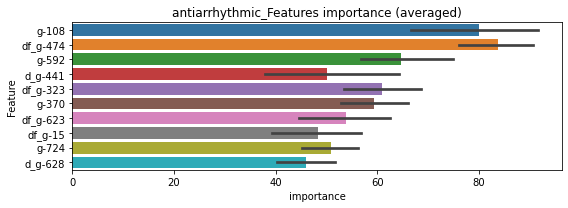

len(train_index) : 3894
len(valid_index) : 3894
================================= fold 1/2 antiarrhythmic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183373	valid_1's binary_logloss: 0.0312143
[200]	training's binary_logloss: 0.00269564	valid_1's binary_logloss: 0.0127066
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00100437	valid_1's binary_logloss: 0.0102408


len(train_index) : 3894
len(valid_index) : 3894
================================= fold 2/2 antiarrhythmic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187255	valid_1's binary_logloss: 0.0335748
[200]	training's binary_logloss: 0.00281285	valid_1's binary_logloss: 0.0163404
[300]	training's binary_logloss: 0.000765485	valid_1's binary_logloss: 0.0138368
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.000568918	valid_1's binary_logloss: 0.0134719


antiarrhythmic logloss: 0.011856341108561052


neg labels: 3289 → selected neg labels: 3281


antibiotic, len(trt): 43, len(othr): 3281, target_rate: 0.0018057 → Adj_target_rate: 0.0020542
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0413861	valid_1's binary_logloss: 0.0651653
[200]	training's binary_logloss: 0.00676699	valid_1's binary_logloss: 0.0176526
[300]	training's binary_logloss: 0.00187754	valid_1's binary_logloss: 0.0081911
[400]	training's binary_logloss: 0.000880431	valid_1's binary_logloss: 0.00535088
[500]	training's binary_logloss: 0.000574264	valid_1's binary_logloss: 0.00441607
Early stopping, best iteration is:
[571]	training's binary_logloss: 0.000495002	valid_1's binary_logloss: 0.00415774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0423983	valid_1's binary_logloss: 0.0704348
[200]	training's binary_logloss: 0.00690599	valid_1's binary_logloss: 0.021091
[300]	training's binary_logloss: 0.00189021	valid_1's binary_logloss: 0.0105414
[400]	training's binary_logloss: 0.000879787	valid_1's binary_logloss: 0.00752788
[500]	training's binary_logloss: 0.000

1 / 3 AUC score:1.000
y_Threshold: 0.0039409, Threshold: 0.0069699, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3805
p_label_rate: 0.0200904 Vs.target_rate: 0.00181
Num_p_label: 80.0, conf_0:0.00627, conf_1:0.00767
Num_p_label: 80.0, Expected: 7.2, Adj_threshold_1: 0.0069699
Num_p_label: 22.0, Expected: 7.2, Adj_threshold_2: 0.0169699
Num_p_label: 10.0, Expected: 7.2, Adj_threshold_3: 0.0269699
threshold: 0.0269699, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0406716	valid_1's binary_logloss: 0.0656158
[200]	training's binary_logloss: 0.00661111	valid_1's binary_logloss: 0.0165376
[300]	training's binary_logloss: 0.0018344	valid_1's binary_logloss: 0.0069408
[400]	training's binary_logloss: 0.000875484	valid_1's binary_logloss: 0.00491286
[500]	training's binary_logloss: 0.000561005	valid_1's binary_logloss: 0.00370143
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.000492699	valid_1's binary_logloss: 0.00341842
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0410455	valid_1's binary_logloss: 0.0712204
[200]	training's binary_logloss: 0.00682671	valid_1's binary_logloss: 0.0207012
[300]	training's binary_logloss: 0.00183426	valid_1's binary_logloss: 0.00945602
[400]	training's binary_logloss: 0.000861233	valid_1's binary_logloss: 0.00656353
[500]	training's binary_logloss: 0.00

2 / 3 AUC score:1.000
y_Threshold: 0.0383737, Threshold: 0.0269699, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3805
p_label_rate: 0.0067805 Vs.target_rate: 0.00181
Num_p_label: 27.0, conf_0:0.02427, conf_1:0.02967
Num_p_label: 27.0, Expected: 7.2, Adj_threshold_1: 0.0269699
Num_p_label: 17.0, Expected: 7.2, Adj_threshold_2: 0.0369699
Num_p_label: 15.0, Expected: 7.2, Adj_threshold_3: 0.0469699
Num_p_label: 11.0, Expected: 7.2, Adj_threshold_4: 0.0569699
threshold: 0.0569699, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0406716	valid_1's binary_logloss: 0.0656158
[200]	training's binary_logloss: 0.00661111	valid_1's binary_logloss: 0.0165376
[300]	training's binary_logloss: 0.0018344	valid_1's binary_logloss: 0.0069408
[400]	training's binary_logloss: 0.000875484	valid_1's binary_logloss: 0.00491286
[500]	training's binary_logloss: 0.000561005	valid_1's binary_logloss: 0.00370143
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.000492699	valid_1's binary_logloss: 0.00341842
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0410455	valid_1's binary_logloss: 0.0712204
[200]	training's binary_logloss: 0.00682671	valid_1's binary_logloss: 0.0207012
[300]	training's binary_logloss: 0.00183426	valid_1's binary_logloss: 0.00945602
[400]	training's binary_logloss: 0.000861233	valid_1's binary_logloss: 0.00656353
[500]	training's binary_logloss: 0.00

3 / 3 AUC score:1.000
y_Threshold: 0.0383737, Threshold: 0.0569699, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3805
p_label_rate: 0.0027624 Vs.target_rate: 0.00181
Num_p_label: 11.0, conf_0:0.05127, conf_1:0.06267
threshold: 0.0569699, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 667.0/7787, y_label_rate: 0.0856556


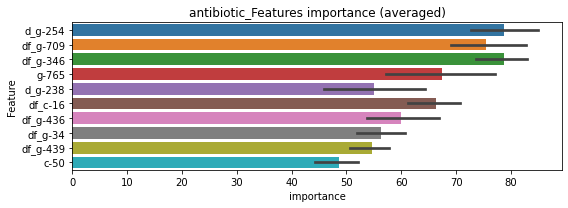

len(train_index) : 3893
len(valid_index) : 3894
================================= fold 1/2 antibiotic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232851	valid_1's binary_logloss: 0.0464321
[200]	training's binary_logloss: 0.00365587	valid_1's binary_logloss: 0.0207009
[300]	training's binary_logloss: 0.000985391	valid_1's binary_logloss: 0.0159994
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.000741883	valid_1's binary_logloss: 0.0153598


len(train_index) : 3894
len(valid_index) : 3893
================================= fold 2/2 antibiotic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241336	valid_1's binary_logloss: 0.0396821
[200]	training's binary_logloss: 0.00416479	valid_1's binary_logloss: 0.0148382
[300]	training's binary_logloss: 0.00109311	valid_1's binary_logloss: 0.00827358
[400]	training's binary_logloss: 0.000474552	valid_1's binary_logloss: 0.00649541
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000329553	valid_1's binary_logloss: 0.00595853


antibiotic logloss: 0.010659767579055015


neg labels: 3289 → selected neg labels: 3286


anticonvulsant, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228679	valid_1's binary_logloss: 0.029298
[200]	training's binary_logloss: 0.00267016	valid_1's binary_logloss: 0.00535912
[300]	training's binary_logloss: 0.000758672	valid_1's binary_logloss: 0.00208477
[400]	training's binary_logloss: 0.000406394	valid_1's binary_logloss: 0.00130602
[500]	training's binary_logloss: 0.000326774	valid_1's binary_logloss: 0.00113772
Early stopping, best iteration is:
[554]	training's binary_logloss: 0.000322318	valid_1's binary_logloss: 0.00113178
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229225	valid_1's binary_logloss: 0.0302053
[200]	training's binary_logloss: 0.00265547	valid_1's binary_logloss: 0.00511832
[300]	training's binary_logloss: 0.000741442	valid_1's binary_logloss: 0.00192453
[400]	training's binary_logloss: 0.000398439	valid_1's binary_logloss: 0.00124496
[500]	training's binary_logloss:

1 / 3 AUC score:1.000
y_Threshold: 0.0016526, Threshold: 0.0025560, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00230, conf_1:0.00281
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0025560
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_2: 0.0125560
threshold: 0.0125560, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218448	valid_1's binary_logloss: 0.0280927
[200]	training's binary_logloss: 0.00247886	valid_1's binary_logloss: 0.00538299
[300]	training's binary_logloss: 0.00071407	valid_1's binary_logloss: 0.00241394
[400]	training's binary_logloss: 0.000387916	valid_1's binary_logloss: 0.00154793
Early stopping, best iteration is:
[468]	training's binary_logloss: 0.00033181	valid_1's binary_logloss: 0.00140809
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228208	valid_1's binary_logloss: 0.0291226
[200]	training's binary_logloss: 0.0026037	valid_1's binary_logloss: 0.00451834
[300]	training's binary_logloss: 0.000739732	valid_1's binary_logloss: 0.00157942
[400]	training's binary_logloss: 0.000398572	valid_1's binary_logloss: 0.000990529
[500]	training's binary_logloss: 0.000321614	valid_1's binary_logloss: 0.000849009
Early stopping, best iteration i

2 / 3 AUC score:1.000
y_Threshold: 0.1047703, Threshold: 0.0125560, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0052737 Vs.target_rate: 0.00076
Num_p_label: 21.0, conf_0:0.01130, conf_1:0.01381
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_1: 0.0125560
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_2: 0.0225560
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_3: 0.0325560
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_4: 0.0425560
threshold: 0.0425560, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218448	valid_1's binary_logloss: 0.0280927
[200]	training's binary_logloss: 0.00247886	valid_1's binary_logloss: 0.00538299
[300]	training's binary_logloss: 0.00071407	valid_1's binary_logloss: 0.00241394
[400]	training's binary_logloss: 0.000387916	valid_1's binary_logloss: 0.00154793
Early stopping, best iteration is:
[468]	training's binary_logloss: 0.00033181	valid_1's binary_logloss: 0.00140809
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228208	valid_1's binary_logloss: 0.0291226
[200]	training's binary_logloss: 0.0026037	valid_1's binary_logloss: 0.00451834
[300]	training's binary_logloss: 0.000739732	valid_1's binary_logloss: 0.00157942
[400]	training's binary_logloss: 0.000398572	valid_1's binary_logloss: 0.000990529
[500]	training's binary_logloss: 0.000321614	valid_1's binary_logloss: 0.000849009
Early stopping, best iteration i

3 / 3 AUC score:1.000
y_Threshold: 0.1047703, Threshold: 0.0425560, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0015068 Vs.target_rate: 0.00076
Num_p_label: 6.0, conf_0:0.03830, conf_1:0.04681
threshold: 0.0425560, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7793, y_label_rate: 0.0850764


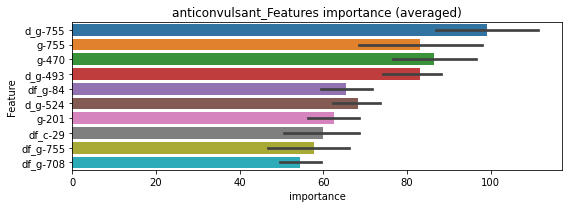

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 anticonvulsant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0127977	valid_1's binary_logloss: 0.0186102
[200]	training's binary_logloss: 0.00144411	valid_1's binary_logloss: 0.00615247
[300]	training's binary_logloss: 0.000391326	valid_1's binary_logloss: 0.00528722
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.000380604	valid_1's binary_logloss: 0.00527475


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 anticonvulsant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0130046	valid_1's binary_logloss: 0.0172003
[200]	training's binary_logloss: 0.0015054	valid_1's binary_logloss: 0.00302977
[300]	training's binary_logloss: 0.00041428	valid_1's binary_logloss: 0.0016068
[400]	training's binary_logloss: 0.000214094	valid_1's binary_logloss: 0.00139603
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.000221248	valid_1's binary_logloss: 0.0013937


anticonvulsant logloss: 0.0033344728721761956


neg labels: 3289 → selected neg labels: 3284


antifungal, len(trt): 26, len(othr): 3284, target_rate: 0.0010918 → Adj_target_rate: 0.0013394
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287463	valid_1's binary_logloss: 0.0423619
[200]	training's binary_logloss: 0.00382308	valid_1's binary_logloss: 0.00946398
[300]	training's binary_logloss: 0.00106597	valid_1's binary_logloss: 0.0041124
[400]	training's binary_logloss: 0.000538306	valid_1's binary_logloss: 0.00270958
[500]	training's binary_logloss: 0.000391559	valid_1's binary_logloss: 0.00221335
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.000377737	valid_1's binary_logloss: 0.00217151
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290746	valid_1's binary_logloss: 0.0460493
[200]	training's binary_logloss: 0.00388848	valid_1's binary_logloss: 0.0108189
[300]	training's binary_logloss: 0.00107585	valid_1's binary_logloss: 0.00458112
[400]	training's binary_logloss: 0.000541219	valid_1's binary_logloss: 0.00297625
Early stopping, best iteration is:


1 / 3 AUC score:1.000
y_Threshold: 0.0018664, Threshold: 0.0027079, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00109
Num_p_label: 80.0, conf_0:0.00244, conf_1:0.00298
Num_p_label: 80.0, Expected: 4.3, Adj_threshold_1: 0.0027079
Num_p_label: 6.0, Expected: 4.3, Adj_threshold_2: 0.0127079
threshold: 0.0127079, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293744	valid_1's binary_logloss: 0.041349
[200]	training's binary_logloss: 0.00384323	valid_1's binary_logloss: 0.00927914
[300]	training's binary_logloss: 0.00106379	valid_1's binary_logloss: 0.00390281
[400]	training's binary_logloss: 0.000537952	valid_1's binary_logloss: 0.00251192
[500]	training's binary_logloss: 0.000394286	valid_1's binary_logloss: 0.00214608
Early stopping, best iteration is:
[519]	training's binary_logloss: 0.000386103	valid_1's binary_logloss: 0.00211977
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.029621	valid_1's binary_logloss: 0.044442
[200]	training's binary_logloss: 0.00381649	valid_1's binary_logloss: 0.0100212
[300]	training's binary_logloss: 0.00105624	valid_1's binary_logloss: 0.00439172
[400]	training's binary_logloss: 0.000533323	valid_1's binary_logloss: 0.00280413
Early stopping, best iteration is:
[4

2 / 3 AUC score:1.000
y_Threshold: 0.1085423, Threshold: 0.0127079, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0022602 Vs.target_rate: 0.00109
Num_p_label: 9.0, conf_0:0.01144, conf_1:0.01398
threshold: 0.0127079, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293744	valid_1's binary_logloss: 0.041349
[200]	training's binary_logloss: 0.00384323	valid_1's binary_logloss: 0.00927914
[300]	training's binary_logloss: 0.00106379	valid_1's binary_logloss: 0.00390281
[400]	training's binary_logloss: 0.000537952	valid_1's binary_logloss: 0.00251192
[500]	training's binary_logloss: 0.000394286	valid_1's binary_logloss: 0.00214608
Early stopping, best iteration is:
[519]	training's binary_logloss: 0.000386103	valid_1's binary_logloss: 0.00211977
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.029621	valid_1's binary_logloss: 0.044442
[200]	training's binary_logloss: 0.00381649	valid_1's binary_logloss: 0.0100212
[300]	training's binary_logloss: 0.00105624	valid_1's binary_logloss: 0.00439172
[400]	training's binary_logloss: 0.000533323	valid_1's binary_logloss: 0.00280413
Early stopping, best iteration is:
[4

3 / 3 AUC score:1.000
y_Threshold: 0.1085423, Threshold: 0.0127079, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0022602 Vs.target_rate: 0.00109
Num_p_label: 9.0, conf_0:0.01144, conf_1:0.01398
threshold: 0.0127079, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 665.0/7790, y_label_rate: 0.0853659


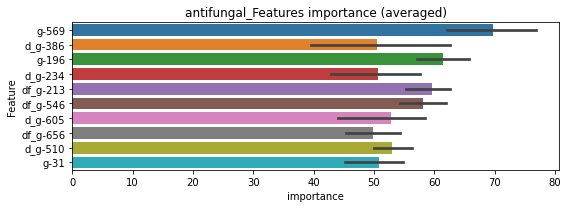

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 antifungal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162369	valid_1's binary_logloss: 0.028552
[200]	training's binary_logloss: 0.00204672	valid_1's binary_logloss: 0.0107126
[300]	training's binary_logloss: 0.000557979	valid_1's binary_logloss: 0.00886891
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.000426231	valid_1's binary_logloss: 0.0087021


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 antifungal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.017249	valid_1's binary_logloss: 0.0270727
[200]	training's binary_logloss: 0.00230512	valid_1's binary_logloss: 0.00913964
[300]	training's binary_logloss: 0.000615562	valid_1's binary_logloss: 0.00644452
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.000673121	valid_1's binary_logloss: 0.00643093


antifungal logloss: 0.007566512274013137


neg labels: 3289 → selected neg labels: 3286


antihistamine, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228747	valid_1's binary_logloss: 0.0307429
[200]	training's binary_logloss: 0.00267782	valid_1's binary_logloss: 0.00569124
[300]	training's binary_logloss: 0.000758453	valid_1's binary_logloss: 0.00214933
[400]	training's binary_logloss: 0.000402377	valid_1's binary_logloss: 0.00131219
[500]	training's binary_logloss: 0.000323936	valid_1's binary_logloss: 0.00113028
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.000318442	valid_1's binary_logloss: 0.00112268
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232781	valid_1's binary_logloss: 0.0337098
[200]	training's binary_logloss: 0.00274394	valid_1's binary_logloss: 0.00642853
[300]	training's binary_logloss: 0.000760166	valid_1's binary_logloss: 0.00293734
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.000546729	valid_1's binary_logloss: 0.00244

1 / 3 AUC score:1.000
y_Threshold: 0.0019513, Threshold: 0.0033858, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00305, conf_1:0.00372
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0033858
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_2: 0.0133858
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_3: 0.0233858
threshold: 0.0233858, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022587	valid_1's binary_logloss: 0.0298461
[200]	training's binary_logloss: 0.00259875	valid_1's binary_logloss: 0.00493666
[300]	training's binary_logloss: 0.000742913	valid_1's binary_logloss: 0.00184549
[400]	training's binary_logloss: 0.000399969	valid_1's binary_logloss: 0.00111005
[500]	training's binary_logloss: 0.000325772	valid_1's binary_logloss: 0.00095856
Early stopping, best iteration is:
[538]	training's binary_logloss: 0.00032134	valid_1's binary_logloss: 0.000950252
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229596	valid_1's binary_logloss: 0.0322788
[200]	training's binary_logloss: 0.00263397	valid_1's binary_logloss: 0.00582161
[300]	training's binary_logloss: 0.000739112	valid_1's binary_logloss: 0.0023145
[400]	training's binary_logloss: 0.000398954	valid_1's binary_logloss: 0.0015553
[500]	training's binary_logloss: 0

2 / 3 AUC score:1.000
y_Threshold: 0.1308346, Threshold: 0.0233858, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0022602 Vs.target_rate: 0.00076
Num_p_label: 9.0, conf_0:0.02105, conf_1:0.02572
threshold: 0.0233858, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022587	valid_1's binary_logloss: 0.0298461
[200]	training's binary_logloss: 0.00259875	valid_1's binary_logloss: 0.00493666
[300]	training's binary_logloss: 0.000742913	valid_1's binary_logloss: 0.00184549
[400]	training's binary_logloss: 0.000399969	valid_1's binary_logloss: 0.00111005
[500]	training's binary_logloss: 0.000325772	valid_1's binary_logloss: 0.00095856
Early stopping, best iteration is:
[538]	training's binary_logloss: 0.00032134	valid_1's binary_logloss: 0.000950252
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229596	valid_1's binary_logloss: 0.0322788
[200]	training's binary_logloss: 0.00263397	valid_1's binary_logloss: 0.00582161
[300]	training's binary_logloss: 0.000739112	valid_1's binary_logloss: 0.0023145
[400]	training's binary_logloss: 0.000398954	valid_1's binary_logloss: 0.0015553
[500]	training's binary_logloss: 0

3 / 3 AUC score:1.000
y_Threshold: 0.1308346, Threshold: 0.0233858, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0022602 Vs.target_rate: 0.00076
Num_p_label: 9.0, conf_0:0.02105, conf_1:0.02572
threshold: 0.0233858, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 666.0/7793, y_label_rate: 0.0854613


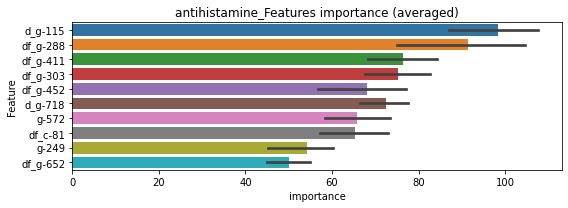

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 antihistamine=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0129661	valid_1's binary_logloss: 0.0216786
[200]	training's binary_logloss: 0.00155577	valid_1's binary_logloss: 0.00877861
[300]	training's binary_logloss: 0.000414573	valid_1's binary_logloss: 0.00765564
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.000414573	valid_1's binary_logloss: 0.00765564


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 antihistamine=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0131741	valid_1's binary_logloss: 0.0189568
[200]	training's binary_logloss: 0.00158601	valid_1's binary_logloss: 0.00528629
[300]	training's binary_logloss: 0.000438225	valid_1's binary_logloss: 0.00369832
Early stopping, best iteration is:
[359]	training's binary_logloss: 0.000280091	valid_1's binary_logloss: 0.00353831


antihistamine logloss: 0.005597239667974002


neg labels: 3289 → selected neg labels: 3286


antimalarial, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225505	valid_1's binary_logloss: 0.0280767
[200]	training's binary_logloss: 0.00260818	valid_1's binary_logloss: 0.00397525
[300]	training's binary_logloss: 0.000735535	valid_1's binary_logloss: 0.00129779
[400]	training's binary_logloss: 0.000401647	valid_1's binary_logloss: 0.000769754
[500]	training's binary_logloss: 0.000324743	valid_1's binary_logloss: 0.000647473
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000323735	valid_1's binary_logloss: 0.000646152
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227221	valid_1's binary_logloss: 0.0303458
[200]	training's binary_logloss: 0.00263404	valid_1's binary_logloss: 0.00486297
[300]	training's binary_logloss: 0.000744612	valid_1's binary_logloss: 0.00175108
[400]	training's binary_logloss: 0.00040324	valid_1's binary_logloss: 0.00107488
[500]	training's binary_loglo

1 / 3 AUC score:1.000
y_Threshold: 0.0013224, Threshold: 0.0020151, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00181, conf_1:0.00222
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0020151
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_2: 0.0120151
threshold: 0.0120151, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0223809	valid_1's binary_logloss: 0.0285958
[200]	training's binary_logloss: 0.00256514	valid_1's binary_logloss: 0.00392276
[300]	training's binary_logloss: 0.000730602	valid_1's binary_logloss: 0.00125656
[400]	training's binary_logloss: 0.000395452	valid_1's binary_logloss: 0.000729191
[500]	training's binary_logloss: 0.000324141	valid_1's binary_logloss: 0.000618411
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.000320926	valid_1's binary_logloss: 0.000613703
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231791	valid_1's binary_logloss: 0.0303521
[200]	training's binary_logloss: 0.00262473	valid_1's binary_logloss: 0.00485232
[300]	training's binary_logloss: 0.00074016	valid_1's binary_logloss: 0.00182142
[400]	training's binary_logloss: 0.000400169	valid_1's binary_logloss: 0.00118184
[500]	training's binary_loglo

2 / 3 AUC score:1.000
y_Threshold: 0.1171986, Threshold: 0.0120151, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0027624 Vs.target_rate: 0.00076
Num_p_label: 11.0, conf_0:0.01081, conf_1:0.01322
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_1: 0.0120151
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_2: 0.0220151
threshold: 0.0220151, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0223809	valid_1's binary_logloss: 0.0285958
[200]	training's binary_logloss: 0.00256514	valid_1's binary_logloss: 0.00392276
[300]	training's binary_logloss: 0.000730602	valid_1's binary_logloss: 0.00125656
[400]	training's binary_logloss: 0.000395452	valid_1's binary_logloss: 0.000729191
[500]	training's binary_logloss: 0.000324141	valid_1's binary_logloss: 0.000618411
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.000320926	valid_1's binary_logloss: 0.000613703
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231791	valid_1's binary_logloss: 0.0303521
[200]	training's binary_logloss: 0.00262473	valid_1's binary_logloss: 0.00485232
[300]	training's binary_logloss: 0.00074016	valid_1's binary_logloss: 0.00182142
[400]	training's binary_logloss: 0.000400169	valid_1's binary_logloss: 0.00118184
[500]	training's binary_loglo

3 / 3 AUC score:1.000
y_Threshold: 0.1171986, Threshold: 0.0220151, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0010045 Vs.target_rate: 0.00076
Num_p_label: 4.0, conf_0:0.01981, conf_1:0.02422
threshold: 0.0220151, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 661.0/7793, y_label_rate: 0.0848197


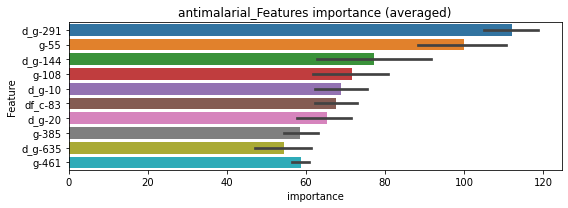

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 antimalarial=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0122525	valid_1's binary_logloss: 0.0189391
[200]	training's binary_logloss: 0.00136695	valid_1's binary_logloss: 0.00578056
[300]	training's binary_logloss: 0.000374925	valid_1's binary_logloss: 0.00437359
Early stopping, best iteration is:
[347]	training's binary_logloss: 0.000260144	valid_1's binary_logloss: 0.00422691


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 antimalarial=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0128535	valid_1's binary_logloss: 0.0159307
[200]	training's binary_logloss: 0.00145241	valid_1's binary_logloss: 0.00282761
[300]	training's binary_logloss: 0.00039723	valid_1's binary_logloss: 0.00149068
[400]	training's binary_logloss: 0.000209868	valid_1's binary_logloss: 0.00124821
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000176666	valid_1's binary_logloss: 0.00119187


antimalarial logloss: 0.0027095872414755373


neg labels: 3289 → selected neg labels: 3278


antioxidant, len(trt): 73, len(othr): 3278, target_rate: 0.0030654 → Adj_target_rate: 0.0032212
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0554518	valid_1's binary_logloss: 0.117643
[200]	training's binary_logloss: 0.0118528	valid_1's binary_logloss: 0.0676384
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.00575679	valid_1's binary_logloss: 0.0612698
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0565812	valid_1's binary_logloss: 0.116567
[200]	training's binary_logloss: 0.0128131	valid_1's binary_logloss: 0.0600188
[300]	training's binary_logloss: 0.00350623	valid_1's binary_logloss: 0.0400234
[400]	training's binary_logloss: 0.00146181	valid_1's binary_logloss: 0.0341461
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00101431	valid_1's binary_logloss: 0.0325401


1 / 3 AUC score:0.995
y_Threshold: 0.0218804, Threshold: 0.0252672, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 158 → Positive_corect_labels: 642/3775
p_label_rate: 0.0200904 Vs.target_rate: 0.00307
Num_p_label: 80.0, conf_0:0.02274, conf_1:0.02779
Num_p_label: 80.0, Expected: 12.2, Adj_threshold_1: 0.0252672
Num_p_label: 39.0, Expected: 12.2, Adj_threshold_2: 0.0352672
Num_p_label: 28.0, Expected: 12.2, Adj_threshold_3: 0.0452672
Num_p_label: 18.0, Expected: 12.2, Adj_threshold_4: 0.0552672
threshold: 0.0552672, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 642.0/3775, y_label_rate: 0.1700662
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0491044	valid_1's binary_logloss: 0.126445
[200]	training's binary_logloss: 0.00975101	valid_1's binary_logloss: 0.084503
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00387603	valid_1's binary_logloss: 0.0771995
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0515657	valid_1's binary_logloss: 0.108878
[200]	training's binary_logloss: 0.0105328	valid_1's binary_logloss: 0.060607
[300]	training's binary_logloss: 0.00308246	valid_1's binary_logloss: 0.0481057
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.0023671	valid_1's binary_logloss: 0.0467037


2 / 3 AUC score:0.994
y_Threshold: 0.0496639, Threshold: 0.0552672, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 58 → Positive_corect_labels: 613.0/3717
p_label_rate: 0.0140633 Vs.target_rate: 0.00307
Num_p_label: 56.0, conf_0:0.04974, conf_1:0.06079
Num_p_label: 56.0, Expected: 12.2, Adj_threshold_1: 0.0552672
Num_p_label: 39.0, Expected: 12.2, Adj_threshold_2: 0.0652672
Num_p_label: 33.0, Expected: 12.2, Adj_threshold_3: 0.0752672
Num_p_label: 28.0, Expected: 12.2, Adj_threshold_4: 0.0852672
Num_p_label: 24.0, Expected: 12.2, Adj_threshold_5: 0.0952672
threshold: 0.0952672, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 613.0/3717, y_label_rate: 0.1649179
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0480313	valid_1's binary_logloss: 0.0990276
[200]	training's binary_logloss: 0.00941838	valid_1's binary_logloss: 0.0581682
[300]	training's binary_logloss: 0.00270945	valid_1's binary_logloss: 0.0500463
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00234491	valid_1's binary_logloss: 0.0496044
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0447383	valid_1's binary_logloss: 0.113034
[200]	training's binary_logloss: 0.00833133	valid_1's binary_logloss: 0.0755518
Early stopping, best iteration is:
[284]	training's binary_logloss: 0.00287273	valid_1's binary_logloss: 0.0712576


3 / 3 AUC score:0.992
y_Threshold: 0.0474883, Threshold: 0.0952672, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 50 → Positive_corect_labels: 588.0/3667
p_label_rate: 0.0082873 Vs.target_rate: 0.00307
Num_p_label: 33.0, conf_0:0.08574, conf_1:0.10479
threshold: 0.0952672, positive_p_label: 33.0/3982, p_label_rate: 0.0082873
positive_y_label: 621.0/7649, y_label_rate: 0.0811871


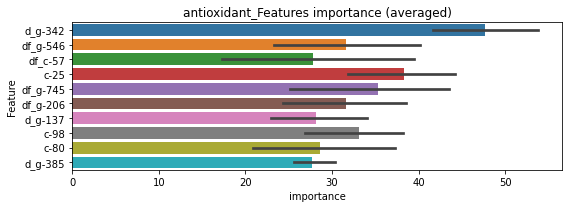

len(train_index) : 3824
len(valid_index) : 3825
================================= fold 1/2 antioxidant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0265873	valid_1's binary_logloss: 0.0714529
[200]	training's binary_logloss: 0.00549845	valid_1's binary_logloss: 0.0475094
[300]	training's binary_logloss: 0.00143574	valid_1's binary_logloss: 0.0421616
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.000922064	valid_1's binary_logloss: 0.0408419


len(train_index) : 3825
len(valid_index) : 3824
================================= fold 2/2 antioxidant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261379	valid_1's binary_logloss: 0.0673614
[200]	training's binary_logloss: 0.00493184	valid_1's binary_logloss: 0.0450141
Early stopping, best iteration is:
[287]	training's binary_logloss: 0.0016295	valid_1's binary_logloss: 0.0411238


antioxidant logloss: 0.04098283249105152


neg labels: 3289 → selected neg labels: 3283


antiprotozoal, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0351407	valid_1's binary_logloss: 0.0559043
[200]	training's binary_logloss: 0.00540028	valid_1's binary_logloss: 0.0171248
[300]	training's binary_logloss: 0.0014783	valid_1's binary_logloss: 0.0086399
[400]	training's binary_logloss: 0.000719516	valid_1's binary_logloss: 0.00607177
[500]	training's binary_logloss: 0.000477561	valid_1's binary_logloss: 0.00493222
Early stopping, best iteration is:
[553]	training's binary_logloss: 0.000434084	valid_1's binary_logloss: 0.00476145
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0344189	valid_1's binary_logloss: 0.060496
[200]	training's binary_logloss: 0.00530271	valid_1's binary_logloss: 0.0247891
[300]	training's binary_logloss: 0.00147086	valid_1's binary_logloss: 0.0180448
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00154466	valid_1's binary_logloss: 0.0179553


1 / 3 AUC score:1.000
y_Threshold: 0.0057495, Threshold: 0.0086620, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151
Num_p_label: 80.0, conf_0:0.00780, conf_1:0.00953
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0086620
Num_p_label: 29.0, Expected: 6.0, Adj_threshold_2: 0.0186620
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_3: 0.0286620
Num_p_label: 8.0, Expected: 6.0, Adj_threshold_4: 0.0386620
threshold: 0.0386620, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345122	valid_1's binary_logloss: 0.0559158
[200]	training's binary_logloss: 0.00514967	valid_1's binary_logloss: 0.0174272
[300]	training's binary_logloss: 0.00142565	valid_1's binary_logloss: 0.00886106
[400]	training's binary_logloss: 0.000707845	valid_1's binary_logloss: 0.00646957
[500]	training's binary_logloss: 0.000470405	valid_1's binary_logloss: 0.00524186
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.000456111	valid_1's binary_logloss: 0.00519117
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339144	valid_1's binary_logloss: 0.0598852
[200]	training's binary_logloss: 0.00499975	valid_1's binary_logloss: 0.0242318
[300]	training's binary_logloss: 0.00142918	valid_1's binary_logloss: 0.017295
[400]	training's binary_logloss: 0.000694475	valid_1's binary_logloss: 0.0156641
Early stopping, best iteration is:
[41

2 / 3 AUC score:1.000
y_Threshold: 0.0283892, Threshold: 0.0386620, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0045203 Vs.target_rate: 0.00151
Num_p_label: 18.0, conf_0:0.03480, conf_1:0.04253
threshold: 0.0386620, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0342465	valid_1's binary_logloss: 0.0549271
[200]	training's binary_logloss: 0.00498033	valid_1's binary_logloss: 0.0165978
[300]	training's binary_logloss: 0.00142302	valid_1's binary_logloss: 0.0104484
[400]	training's binary_logloss: 0.000703692	valid_1's binary_logloss: 0.00887053
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000685324	valid_1's binary_logloss: 0.0088448
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0353748	valid_1's binary_logloss: 0.0601141
[200]	training's binary_logloss: 0.00511642	valid_1's binary_logloss: 0.0189647
[300]	training's binary_logloss: 0.00144819	valid_1's binary_logloss: 0.0115863
[400]	training's binary_logloss: 0.000699389	valid_1's binary_logloss: 0.00922489
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.000540527	valid_1's binary_logloss: 0.00867436


3 / 3 AUC score:1.000
y_Threshold: 0.0291462, Threshold: 0.0386620, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 654.0/3803
p_label_rate: 0.0040181 Vs.target_rate: 0.00151
Num_p_label: 16.0, conf_0:0.03480, conf_1:0.04253
threshold: 0.0386620, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 670.0/7785, y_label_rate: 0.0860629


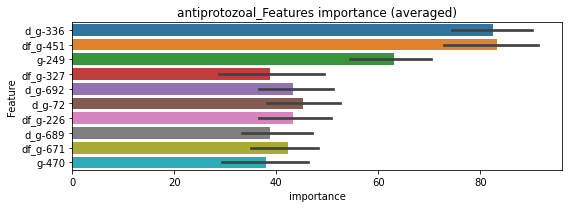

len(train_index) : 3892
len(valid_index) : 3893
================================= fold 1/2 antiprotozoal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197934	valid_1's binary_logloss: 0.0418219
[200]	training's binary_logloss: 0.00291559	valid_1's binary_logloss: 0.0230921
[300]	training's binary_logloss: 0.00078337	valid_1's binary_logloss: 0.0205894
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.00079956	valid_1's binary_logloss: 0.0205781


len(train_index) : 3893
len(valid_index) : 3892
================================= fold 2/2 antiprotozoal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0200594	valid_1's binary_logloss: 0.0368806
[200]	training's binary_logloss: 0.00294654	valid_1's binary_logloss: 0.0164094
[300]	training's binary_logloss: 0.000813727	valid_1's binary_logloss: 0.0118813
Early stopping, best iteration is:
[359]	training's binary_logloss: 0.000500191	valid_1's binary_logloss: 0.0111255


antiprotozoal logloss: 0.015852423739330622


neg labels: 3289 → selected neg labels: 3286


antiviral, len(trt): 23, len(othr): 3286, target_rate: 0.0009658 → Adj_target_rate: 0.0012069
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257087	valid_1's binary_logloss: 0.0448072
[200]	training's binary_logloss: 0.00318463	valid_1's binary_logloss: 0.0127484
[300]	training's binary_logloss: 0.000891723	valid_1's binary_logloss: 0.00692531
[400]	training's binary_logloss: 0.000457248	valid_1's binary_logloss: 0.00523642
[500]	training's binary_logloss: 0.000347894	valid_1's binary_logloss: 0.0047354
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.000346714	valid_1's binary_logloss: 0.00472562
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0265425	valid_1's binary_logloss: 0.0347418
[200]	training's binary_logloss: 0.00333631	valid_1's binary_logloss: 0.00601433
[300]	training's binary_logloss: 0.000926826	valid_1's binary_logloss: 0.00204219
[400]	training's binary_logloss: 0.000466654	valid_1's binary_logloss: 0.00116167
[500]	training's binary_logloss: 

1 / 3 AUC score:1.000
y_Threshold: 0.0020224, Threshold: 0.0027320, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00097
Num_p_label: 80.0, conf_0:0.00246, conf_1:0.00301
Num_p_label: 80.0, Expected: 3.8, Adj_threshold_1: 0.0027320
Num_p_label: 9.0, Expected: 3.8, Adj_threshold_2: 0.0127320
Num_p_label: 1.0, Expected: 3.8, Adj_threshold_3: 0.0227320
threshold: 0.0227320, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0258364	valid_1's binary_logloss: 0.0452455
[200]	training's binary_logloss: 0.00315673	valid_1's binary_logloss: 0.0124424
[300]	training's binary_logloss: 0.000875465	valid_1's binary_logloss: 0.00660045
[400]	training's binary_logloss: 0.000447146	valid_1's binary_logloss: 0.00499052
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.000367794	valid_1's binary_logloss: 0.0046326
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264582	valid_1's binary_logloss: 0.0333921
[200]	training's binary_logloss: 0.00324503	valid_1's binary_logloss: 0.00516623
[300]	training's binary_logloss: 0.000903093	valid_1's binary_logloss: 0.00170147
[400]	training's binary_logloss: 0.00046162	valid_1's binary_logloss: 0.000979454
[500]	training's binary_logloss: 0.000354829	valid_1's binary_logloss: 0.000805336
[600]	training's binary_logloss:

2 / 3 AUC score:1.000
y_Threshold: 0.0415129, Threshold: 0.0227320, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0032647 Vs.target_rate: 0.00097
Num_p_label: 13.0, conf_0:0.02046, conf_1:0.02501
Num_p_label: 13.0, Expected: 3.8, Adj_threshold_1: 0.0227320
Num_p_label: 5.0, Expected: 3.8, Adj_threshold_2: 0.0327320
threshold: 0.0327320, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0258364	valid_1's binary_logloss: 0.0452455
[200]	training's binary_logloss: 0.00315673	valid_1's binary_logloss: 0.0124424
[300]	training's binary_logloss: 0.000875465	valid_1's binary_logloss: 0.00660045
[400]	training's binary_logloss: 0.000447146	valid_1's binary_logloss: 0.00499052
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.000367794	valid_1's binary_logloss: 0.0046326
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264582	valid_1's binary_logloss: 0.0333921
[200]	training's binary_logloss: 0.00324503	valid_1's binary_logloss: 0.00516623
[300]	training's binary_logloss: 0.000903093	valid_1's binary_logloss: 0.00170147
[400]	training's binary_logloss: 0.00046162	valid_1's binary_logloss: 0.000979454
[500]	training's binary_logloss: 0.000354829	valid_1's binary_logloss: 0.000805336
[600]	training's binary_logloss:

3 / 3 AUC score:1.000
y_Threshold: 0.0415129, Threshold: 0.0327320, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0012557 Vs.target_rate: 0.00097
Num_p_label: 5.0, conf_0:0.02946, conf_1:0.03601
threshold: 0.0327320, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 662.0/7793, y_label_rate: 0.0849480


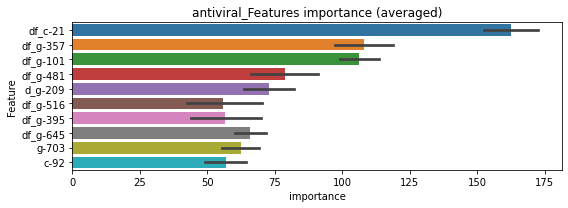

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 antiviral=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.013716	valid_1's binary_logloss: 0.0226549
[200]	training's binary_logloss: 0.00161565	valid_1's binary_logloss: 0.00676538
[300]	training's binary_logloss: 0.000447481	valid_1's binary_logloss: 0.00513795
[400]	training's binary_logloss: 0.000227829	valid_1's binary_logloss: 0.00481976
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.000237579	valid_1's binary_logloss: 0.00480701


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 antiviral=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0144199	valid_1's binary_logloss: 0.0213385
[200]	training's binary_logloss: 0.00176205	valid_1's binary_logloss: 0.00465837
[300]	training's binary_logloss: 0.000484564	valid_1's binary_logloss: 0.00243852
[400]	training's binary_logloss: 0.000242737	valid_1's binary_logloss: 0.00193442
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.000186532	valid_1's binary_logloss: 0.00182568


antiviral logloss: 0.0033165378870217673


neg labels: 3289 → selected neg labels: 3281


apoptosis_stimulant, len(trt): 49, len(othr): 3281, target_rate: 0.0020576 → Adj_target_rate: 0.0022954
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0446628	valid_1's binary_logloss: 0.0795119
[200]	training's binary_logloss: 0.00736433	valid_1's binary_logloss: 0.0289031
[300]	training's binary_logloss: 0.00211111	valid_1's binary_logloss: 0.0174552
[400]	training's binary_logloss: 0.000996695	valid_1's binary_logloss: 0.0133585
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000732392	valid_1's binary_logloss: 0.0124636
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.045505	valid_1's binary_logloss: 0.0770989
[200]	training's binary_logloss: 0.00792659	valid_1's binary_logloss: 0.0260351
[300]	training's binary_logloss: 0.00222465	valid_1's binary_logloss: 0.015263
[400]	training's binary_logloss: 0.0010288	valid_1's binary_logloss: 0.0109131
[500]	training's binary_logloss: 0.000649441	valid_1's binary_logloss: 0.00927415
Early stopping, best iteration is:
[569]	tra

1 / 3 AUC score:1.000
y_Threshold: 0.0049594, Threshold: 0.0512154, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3805
p_label_rate: 0.0200904 Vs.target_rate: 0.00206
Num_p_label: 80.0, conf_0:0.04609, conf_1:0.05634
Num_p_label: 80.0, Expected: 8.2, Adj_threshold_1: 0.0512154
Num_p_label: 64.0, Expected: 8.2, Adj_threshold_2: 0.0612154
Num_p_label: 57.0, Expected: 8.2, Adj_threshold_3: 0.0712154
Num_p_label: 49.0, Expected: 8.2, Adj_threshold_4: 0.0812154
Num_p_label: 46.0, Expected: 8.2, Adj_threshold_5: 0.0912154
Num_p_label: 42.0, Expected: 8.2, Adj_threshold_6: 0.1012154
Num_p_label: 38.0, Expected: 8.2, Adj_threshold_7: 0.1112154
Num_p_label: 36.0, Expected: 8.2, Adj_threshold_8: 0.1212154
Num_p_label: 33.0, Expected: 8.2, Adj_threshold_9: 0.1312154
Num_p_label: 33.0, Expected: 8.2, Adj_threshold_10: 0.1412154
threshold: 0.1512154, positive_p_label: 32.0/3982, p_label_rate: 0.0080362
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0452147	valid_1's binary_logloss: 0.0787354
[200]	training's binary_logloss: 0.00699955	valid_1's binary_logloss: 0.0275669
[300]	training's binary_logloss: 0.00197153	valid_1's binary_logloss: 0.0160343
[400]	training's binary_logloss: 0.000955171	valid_1's binary_logloss: 0.0128703
[500]	training's binary_logloss: 0.000611593	valid_1's binary_logloss: 0.0118509
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.000630507	valid_1's binary_logloss: 0.0117672
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.042279	valid_1's binary_logloss: 0.0728701
[200]	training's binary_logloss: 0.0070669	valid_1's binary_logloss: 0.02556
[300]	training's binary_logloss: 0.00202444	valid_1's binary_logloss: 0.014521
[400]	training's binary_logloss: 0.000957423	valid_1's binary_logloss: 0.0110174
[500]	training's binary_logloss: 0.000611752	v

2 / 3 AUC score:1.000
y_Threshold: 0.0821364, Threshold: 0.1512154, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 654.0/3801
p_label_rate: 0.0243596 Vs.target_rate: 0.00206
Num_p_label: 97.0, conf_0:0.13609, conf_1:0.16634
Num_p_label: 97.0, Expected: 8.2, Adj_threshold_1: 0.1512154
Num_p_label: 92.0, Expected: 8.2, Adj_threshold_2: 0.1612154
Num_p_label: 89.0, Expected: 8.2, Adj_threshold_3: 0.1712154
Num_p_label: 85.0, Expected: 8.2, Adj_threshold_4: 0.1812154
Num_p_label: 83.0, Expected: 8.2, Adj_threshold_5: 0.1912154
Num_p_label: 82.0, Expected: 8.2, Adj_threshold_6: 0.2012154
Num_p_label: 78.0, Expected: 8.2, Adj_threshold_7: 0.2112154
Num_p_label: 77.0, Expected: 8.2, Adj_threshold_8: 0.2212154
Num_p_label: 77.0, Expected: 8.2, Adj_threshold_9: 0.2312154
Num_p_label: 76.0, Expected: 8.2, Adj_threshold_10: 0.2412154
threshold: 0.2512154, positive_p_label: 76.0/3982, p_label_rate: 0.0190859
positive_y_label: 654.0/3801, y_label_rate: 0.1720600
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0437387	valid_1's binary_logloss: 0.0763788
[200]	training's binary_logloss: 0.00725862	valid_1's binary_logloss: 0.0302114
[300]	training's binary_logloss: 0.00203927	valid_1's binary_logloss: 0.0200504
[400]	training's binary_logloss: 0.000957829	valid_1's binary_logloss: 0.0171813
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000859229	valid_1's binary_logloss: 0.0168749
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0433873	valid_1's binary_logloss: 0.0795119
[200]	training's binary_logloss: 0.00707422	valid_1's binary_logloss: 0.0292314
[300]	training's binary_logloss: 0.00201555	valid_1's binary_logloss: 0.0173028
[400]	training's binary_logloss: 0.000950655	valid_1's binary_logloss: 0.0136266
[500]	training's binary_logloss: 0.000605933	valid_1's binary_logloss: 0.0123785
Early stopping, best iteration is:
[579]	

3 / 3 AUC score:1.000
y_Threshold: 0.0436763, Threshold: 0.2512154, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 649.0/3791
p_label_rate: 0.0185836 Vs.target_rate: 0.00206
Num_p_label: 74.0, conf_0:0.22609, conf_1:0.27634
Num_p_label: 74.0, Expected: 8.2, Adj_threshold_1: 0.2512154
Num_p_label: 72.0, Expected: 8.2, Adj_threshold_2: 0.2612154
Num_p_label: 71.0, Expected: 8.2, Adj_threshold_3: 0.2712154
Num_p_label: 71.0, Expected: 8.2, Adj_threshold_4: 0.2812154
Num_p_label: 69.0, Expected: 8.2, Adj_threshold_5: 0.2912154
Num_p_label: 68.0, Expected: 8.2, Adj_threshold_6: 0.3012154
Num_p_label: 67.0, Expected: 8.2, Adj_threshold_7: 0.3112154
Num_p_label: 67.0, Expected: 8.2, Adj_threshold_8: 0.3212154
Num_p_label: 66.0, Expected: 8.2, Adj_threshold_9: 0.3312154
Num_p_label: 65.0, Expected: 8.2, Adj_threshold_10: 0.3412154
threshold: 0.3512154, positive_p_label: 62.0/3982, p_label_rate: 0.0155701
positive_y_label: 711.0/7773, y_label_rate: 0.0914705


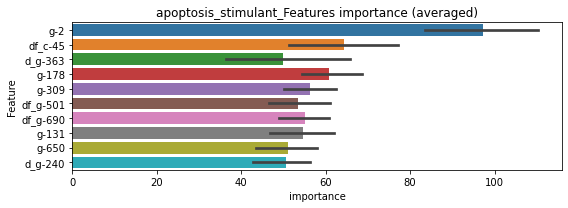

len(train_index) : 3886
len(valid_index) : 3887
================================= fold 1/2 apoptosis_stimulant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256672	valid_1's binary_logloss: 0.0487004
[200]	training's binary_logloss: 0.00435794	valid_1's binary_logloss: 0.0221971
[300]	training's binary_logloss: 0.00120688	valid_1's binary_logloss: 0.0165372
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.000702984	valid_1's binary_logloss: 0.0153622


len(train_index) : 3887
len(valid_index) : 3886
================================= fold 2/2 apoptosis_stimulant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026644	valid_1's binary_logloss: 0.0466947
[200]	training's binary_logloss: 0.00462313	valid_1's binary_logloss: 0.0179463
[300]	training's binary_logloss: 0.0012857	valid_1's binary_logloss: 0.0115827
[400]	training's binary_logloss: 0.00058655	valid_1's binary_logloss: 0.00981609
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000388969	valid_1's binary_logloss: 0.00929639


apoptosis_stimulant logloss: 0.012329690686587784


neg labels: 3289 → selected neg labels: 3281


aromatase_inhibitor, len(trt): 47, len(othr): 3281, target_rate: 0.0019736 → Adj_target_rate: 0.0022155
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0442114	valid_1's binary_logloss: 0.0786473
[200]	training's binary_logloss: 0.00761664	valid_1's binary_logloss: 0.0312221
[300]	training's binary_logloss: 0.00212194	valid_1's binary_logloss: 0.020448
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.00169876	valid_1's binary_logloss: 0.0196468
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0469848	valid_1's binary_logloss: 0.0749196
[200]	training's binary_logloss: 0.00840405	valid_1's binary_logloss: 0.0245705
[300]	training's binary_logloss: 0.00227192	valid_1's binary_logloss: 0.0128174
[400]	training's binary_logloss: 0.00103245	valid_1's binary_logloss: 0.00959162
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00071341	valid_1's binary_logloss: 0.00871871


1 / 3 AUC score:1.000
y_Threshold: 0.0091997, Threshold: 0.0144975, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3805
p_label_rate: 0.0200904 Vs.target_rate: 0.00197
Num_p_label: 80.0, conf_0:0.01305, conf_1:0.01595
Num_p_label: 80.0, Expected: 7.9, Adj_threshold_1: 0.0144975
Num_p_label: 20.0, Expected: 7.9, Adj_threshold_2: 0.0244975
Num_p_label: 10.0, Expected: 7.9, Adj_threshold_3: 0.0344975
threshold: 0.0344975, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0437291	valid_1's binary_logloss: 0.0803106
[200]	training's binary_logloss: 0.00756038	valid_1's binary_logloss: 0.034985
[300]	training's binary_logloss: 0.00209196	valid_1's binary_logloss: 0.0242647
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.00143001	valid_1's binary_logloss: 0.0225962
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.045777	valid_1's binary_logloss: 0.073545
[200]	training's binary_logloss: 0.00798126	valid_1's binary_logloss: 0.0227722
[300]	training's binary_logloss: 0.00219671	valid_1's binary_logloss: 0.0109263
[400]	training's binary_logloss: 0.00101353	valid_1's binary_logloss: 0.00787015
[500]	training's binary_logloss: 0.000639722	valid_1's binary_logloss: 0.0067014
[600]	training's binary_logloss: 0.000514097	valid_1's binary_logloss: 0.0062111
Early stopping, best iteration is:
[591]	trai

2 / 3 AUC score:1.000
y_Threshold: 0.0438086, Threshold: 0.0344975, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 654.0/3801
p_label_rate: 0.0085384 Vs.target_rate: 0.00197
Num_p_label: 34.0, conf_0:0.03105, conf_1:0.03795
Num_p_label: 34.0, Expected: 7.9, Adj_threshold_1: 0.0344975
Num_p_label: 23.0, Expected: 7.9, Adj_threshold_2: 0.0444975
Num_p_label: 18.0, Expected: 7.9, Adj_threshold_3: 0.0544975
Num_p_label: 10.0, Expected: 7.9, Adj_threshold_4: 0.0644975
threshold: 0.0644975, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 654.0/3801, y_label_rate: 0.1720600
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0436748	valid_1's binary_logloss: 0.0843754
[200]	training's binary_logloss: 0.00738739	valid_1's binary_logloss: 0.0345595
[300]	training's binary_logloss: 0.00204977	valid_1's binary_logloss: 0.0239558
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.00106408	valid_1's binary_logloss: 0.0208705
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0464498	valid_1's binary_logloss: 0.0692346
[200]	training's binary_logloss: 0.00810981	valid_1's binary_logloss: 0.019541
[300]	training's binary_logloss: 0.0022426	valid_1's binary_logloss: 0.00822428
[400]	training's binary_logloss: 0.00103977	valid_1's binary_logloss: 0.00508132
[500]	training's binary_logloss: 0.000654774	valid_1's binary_logloss: 0.00395054
[600]	training's binary_logloss: 0.000521939	valid_1's binary_logloss: 0.00344428
Early stopping, best iteration is:
[594]	

3 / 3 AUC score:1.000
y_Threshold: 0.0431519, Threshold: 0.0644975, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 650.0/3793
p_label_rate: 0.0017579 Vs.target_rate: 0.00197
Num_p_label: 7.0, conf_0:0.05805, conf_1:0.07095
threshold: 0.0644975, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/7775, y_label_rate: 0.0845016


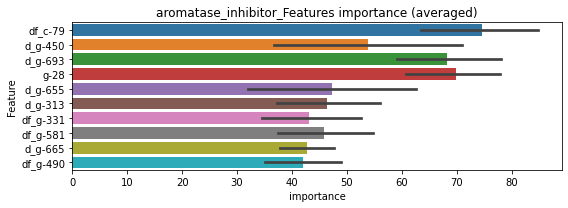

len(train_index) : 3887
len(valid_index) : 3888
================================= fold 1/2 aromatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0255996	valid_1's binary_logloss: 0.0535425
[200]	training's binary_logloss: 0.00435553	valid_1's binary_logloss: 0.0283195
[300]	training's binary_logloss: 0.0011402	valid_1's binary_logloss: 0.0230398
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000739751	valid_1's binary_logloss: 0.0219586


len(train_index) : 3888
len(valid_index) : 3887
================================= fold 2/2 aromatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0267004	valid_1's binary_logloss: 0.0447965
[200]	training's binary_logloss: 0.00459977	valid_1's binary_logloss: 0.0164648
[300]	training's binary_logloss: 0.00122219	valid_1's binary_logloss: 0.0111733
[400]	training's binary_logloss: 0.00054708	valid_1's binary_logloss: 0.0097248
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.000442152	valid_1's binary_logloss: 0.00948706


aromatase_inhibitor logloss: 0.01572363108131918


neg labels: 3289 → selected neg labels: 3288


atm_kinase_inhibitor, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0151368	valid_1's binary_logloss: 0.0158032
[200]	training's binary_logloss: 0.00118718	valid_1's binary_logloss: 0.00137959
[300]	training's binary_logloss: 0.000319795	valid_1's binary_logloss: 0.000426901
[400]	training's binary_logloss: 0.000200809	valid_1's binary_logloss: 0.000277219
[500]	training's binary_logloss: 0.000174836	valid_1's binary_logloss: 0.000242526
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.000171408	valid_1's binary_logloss: 0.000237672
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015448	valid_1's binary_logloss: 0.0164089
[200]	training's binary_logloss: 0.00119977	valid_1's binary_logloss: 0.0014243
[300]	training's binary_logloss: 0.000320366	valid_1's binary_logloss: 0.000456841
[400]	training's binary_logloss: 0.000202396	valid_1's binary_logloss: 0.000297706
[500]	training's binary_log

1 / 3 AUC score:1.000
y_Threshold: 0.0005923, Threshold: 0.0015199, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0200904 Vs.target_rate: 0.00025
Num_p_label: 80.0, conf_0:0.00137, conf_1:0.00167
Num_p_label: 80.0, Expected: 1.0, Adj_threshold_1: 0.0015199
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_2: 0.0115199
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_3: 0.0215199
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_4: 0.0315199
threshold: 0.0315199, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156234	valid_1's binary_logloss: 0.016064
[200]	training's binary_logloss: 0.00120341	valid_1's binary_logloss: 0.00132586
[300]	training's binary_logloss: 0.000308839	valid_1's binary_logloss: 0.000376325
[400]	training's binary_logloss: 0.000196525	valid_1's binary_logloss: 0.000249311
[500]	training's binary_logloss: 0.00017212	valid_1's binary_logloss: 0.000218557
[600]	training's binary_logloss: 0.000166934	valid_1's binary_logloss: 0.000212
[700]	training's binary_logloss: 0.000164378	valid_1's binary_logloss: 0.000208647
Early stopping, best iteration is:
[748]	training's binary_logloss: 0.000163991	valid_1's binary_logloss: 0.00020812
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157079	valid_1's binary_logloss: 0.0162264
[200]	training's binary_logloss: 0.00120784	valid_1's binary_logloss: 0.00128082
[300]	training's binary_logloss

2 / 3 AUC score:1.000
y_Threshold: 0.1846887, Threshold: 0.0315199, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0065294 Vs.target_rate: 0.00025
Num_p_label: 26.0, conf_0:0.02837, conf_1:0.03467
Num_p_label: 26.0, Expected: 1.0, Adj_threshold_1: 0.0315199
Num_p_label: 19.0, Expected: 1.0, Adj_threshold_2: 0.0415199
Num_p_label: 16.0, Expected: 1.0, Adj_threshold_3: 0.0515199
Num_p_label: 14.0, Expected: 1.0, Adj_threshold_4: 0.0615199
Num_p_label: 13.0, Expected: 1.0, Adj_threshold_5: 0.0715199
Num_p_label: 11.0, Expected: 1.0, Adj_threshold_6: 0.0815199
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_7: 0.0915199
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_8: 0.1015199
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_9: 0.1115199
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_10: 0.1215199
threshold: 0.1315199, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
==============

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156234	valid_1's binary_logloss: 0.016064
[200]	training's binary_logloss: 0.00120341	valid_1's binary_logloss: 0.00132586
[300]	training's binary_logloss: 0.000308839	valid_1's binary_logloss: 0.000376325
[400]	training's binary_logloss: 0.000196525	valid_1's binary_logloss: 0.000249311
[500]	training's binary_logloss: 0.00017212	valid_1's binary_logloss: 0.000218557
[600]	training's binary_logloss: 0.000166934	valid_1's binary_logloss: 0.000212
[700]	training's binary_logloss: 0.000164378	valid_1's binary_logloss: 0.000208647
Early stopping, best iteration is:
[744]	training's binary_logloss: 0.000163991	valid_1's binary_logloss: 0.00020812
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157079	valid_1's binary_logloss: 0.0162264
[200]	training's binary_logloss: 0.00120784	valid_1's binary_logloss: 0.00128082
[300]	training's binary_logloss

3 / 3 AUC score:1.000
y_Threshold: 0.1846887, Threshold: 0.1315199, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0020090 Vs.target_rate: 0.00025
Num_p_label: 8.0, conf_0:0.11837, conf_1:0.14467
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_1: 0.1315199
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_2: 0.1415199
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_3: 0.1515199
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_4: 0.1615199
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_5: 0.1715199
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_6: 0.1815199
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_7: 0.1915199
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_8: 0.2015199
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_9: 0.2115199
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_10: 0.2215199
threshold: 0.2315199, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 660.0/7795, y_label_rate: 0.0846697


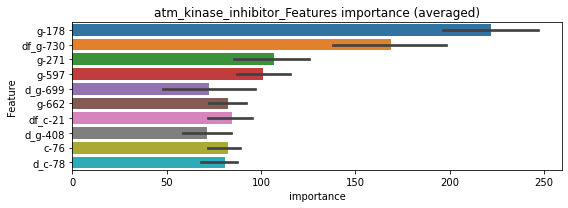

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00832956	valid_1's binary_logloss: 0.00983886
[200]	training's binary_logloss: 0.000641115	valid_1's binary_logloss: 0.00237396
Early stopping, best iteration is:
[274]	training's binary_logloss: 0.000209062	valid_1's binary_logloss: 0.00198312


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00837344	valid_1's binary_logloss: 0.00899888
[200]	training's binary_logloss: 0.000658034	valid_1's binary_logloss: 0.00125983
Early stopping, best iteration is:
[284]	training's binary_logloss: 0.000196526	valid_1's binary_logloss: 0.000810708


atm_kinase_inhibitor logloss: 0.0013969909365672993


neg labels: 3289 → selected neg labels: 3287


atp-sensitive_potassium_channel_antagonist, len(trt): 7, len(othr): 3287, target_rate: 0.0002939 → Adj_target_rate: 0.0004391
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161204	valid_1's binary_logloss: 0.0173975
[200]	training's binary_logloss: 0.00136233	valid_1's binary_logloss: 0.00170812
[300]	training's binary_logloss: 0.000372987	valid_1's binary_logloss: 0.000544047
[400]	training's binary_logloss: 0.000225163	valid_1's binary_logloss: 0.000343591
[500]	training's binary_logloss: 0.000199899	valid_1's binary_logloss: 0.000308277
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.000198254	valid_1's binary_logloss: 0.000305909
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161177	valid_1's binary_logloss: 0.0181019
[200]	training's binary_logloss: 0.00136831	valid_1's binary_logloss: 0.00258289
[300]	training's binary_logloss: 0.000372616	valid_1's binary_logloss: 0.00109525
[400]	training's binary_logloss: 0.000226007	valid_1's binary_logloss: 0.000819228
[500]	training's binary_lo

1 / 3 AUC score:1.000
y_Threshold: 0.0005744, Threshold: 0.0009289, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00029
Num_p_label: 80.0, conf_0:0.00084, conf_1:0.00102
Num_p_label: 80.0, Expected: 1.2, Adj_threshold_1: 0.0009289
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_2: 0.0109289
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_3: 0.0209289
Num_p_label: 1.0, Expected: 1.2, Adj_threshold_4: 0.0309289
threshold: 0.0309289, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163261	valid_1's binary_logloss: 0.0173632
[200]	training's binary_logloss: 0.00135201	valid_1's binary_logloss: 0.00152997
[300]	training's binary_logloss: 0.000368032	valid_1's binary_logloss: 0.000441961
[400]	training's binary_logloss: 0.0002263	valid_1's binary_logloss: 0.000278058
[500]	training's binary_logloss: 0.00019503	valid_1's binary_logloss: 0.000241904
Early stopping, best iteration is:
[556]	training's binary_logloss: 0.000192275	valid_1's binary_logloss: 0.000238728
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164415	valid_1's binary_logloss: 0.0180607
[200]	training's binary_logloss: 0.00134952	valid_1's binary_logloss: 0.00213992
[300]	training's binary_logloss: 0.000364876	valid_1's binary_logloss: 0.000749189
[400]	training's binary_logloss: 0.00022368	valid_1's binary_logloss: 0.000526309
[500]	training's binary_loglo

2 / 3 AUC score:1.000
y_Threshold: 0.1394520, Threshold: 0.0309289, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0012557 Vs.target_rate: 0.00029
Num_p_label: 5.0, conf_0:0.02784, conf_1:0.03402
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_1: 0.0309289
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_2: 0.0409289
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_3: 0.0509289
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_4: 0.0609289
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_5: 0.0709289
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_6: 0.0809289
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_7: 0.0909289
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_8: 0.1009289
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_9: 0.1109289
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_10: 0.1209289
threshold: 0.1309289, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pse

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163261	valid_1's binary_logloss: 0.0173632
[200]	training's binary_logloss: 0.00135201	valid_1's binary_logloss: 0.00152997
[300]	training's binary_logloss: 0.000368032	valid_1's binary_logloss: 0.000441961
[400]	training's binary_logloss: 0.0002263	valid_1's binary_logloss: 0.000278058
[500]	training's binary_logloss: 0.00019503	valid_1's binary_logloss: 0.000241904
Early stopping, best iteration is:
[556]	training's binary_logloss: 0.000192275	valid_1's binary_logloss: 0.000238728
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164415	valid_1's binary_logloss: 0.0180607
[200]	training's binary_logloss: 0.00134952	valid_1's binary_logloss: 0.00213992
[300]	training's binary_logloss: 0.000364876	valid_1's binary_logloss: 0.000749189
[400]	training's binary_logloss: 0.00022368	valid_1's binary_logloss: 0.000526309
[500]	training's binary_loglo

3 / 3 AUC score:1.000
y_Threshold: 0.1394520, Threshold: 0.1309289, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0007534 Vs.target_rate: 0.00029
Num_p_label: 3.0, conf_0:0.11784, conf_1:0.14402
threshold: 0.1309289, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 660.0/7794, y_label_rate: 0.0846805


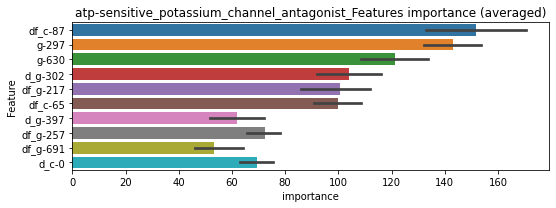

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00858821	valid_1's binary_logloss: 0.011018
[200]	training's binary_logloss: 0.000711446	valid_1's binary_logloss: 0.00285319
[300]	training's binary_logloss: 0.000187752	valid_1's binary_logloss: 0.00216689
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.000172062	valid_1's binary_logloss: 0.00214934


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00860261	valid_1's binary_logloss: 0.0104918
[200]	training's binary_logloss: 0.000714272	valid_1's binary_logloss: 0.002119
[300]	training's binary_logloss: 0.000190537	valid_1's binary_logloss: 0.00129142
[400]	training's binary_logloss: 0.00011431	valid_1's binary_logloss: 0.00115105
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000117268	valid_1's binary_logloss: 0.00114817


atp-sensitive_potassium_channel_antagonist logloss: 0.0016487556163304858


neg labels: 3289 → selected neg labels: 3287


atp_synthase_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152602	valid_1's binary_logloss: 0.0180877
[200]	training's binary_logloss: 0.00117061	valid_1's binary_logloss: 0.00347207
Early stopping, best iteration is:
[266]	training's binary_logloss: 0.000401854	valid_1's binary_logloss: 0.00264209
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155758	valid_1's binary_logloss: 0.0170851
[200]	training's binary_logloss: 0.00121155	valid_1's binary_logloss: 0.00268835
[300]	training's binary_logloss: 0.000306317	valid_1's binary_logloss: 0.00156099
[400]	training's binary_logloss: 0.000194922	valid_1's binary_logloss: 0.0012968
[500]	training's binary_logloss: 0.000174153	valid_1's binary_logloss: 0.00121212
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.000171938	valid_1's binary_logloss: 0.00120115


1 / 3 AUC score:1.000
y_Threshold: 0.0007313, Threshold: 0.0023318, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050
Num_p_label: 80.0, conf_0:0.00210, conf_1:0.00256
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0023318
Num_p_label: 22.0, Expected: 2.0, Adj_threshold_2: 0.0123318
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_3: 0.0223318
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_4: 0.0323318
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_5: 0.0423318
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_6: 0.0523318
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_7: 0.0623318
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_8: 0.0723318
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_9: 0.0823318
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_10: 0.0923318
threshold: 0.1023318, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
============

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159364	valid_1's binary_logloss: 0.0178759
[200]	training's binary_logloss: 0.00118186	valid_1's binary_logloss: 0.00226918
[300]	training's binary_logloss: 0.000273865	valid_1's binary_logloss: 0.000934946
[400]	training's binary_logloss: 0.000173004	valid_1's binary_logloss: 0.000682771
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000159322	valid_1's binary_logloss: 0.000646065
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160804	valid_1's binary_logloss: 0.0165016
[200]	training's binary_logloss: 0.00116869	valid_1's binary_logloss: 0.00129137
[300]	training's binary_logloss: 0.000273422	valid_1's binary_logloss: 0.000329753
[400]	training's binary_logloss: 0.000176515	valid_1's binary_logloss: 0.000217232
[500]	training's binary_logloss: 0.000157518	valid_1's binary_logloss: 0.000195555
[600]	training's binary_l

2 / 3 AUC score:1.000
y_Threshold: 0.3903750, Threshold: 0.1023318, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0298845 Vs.target_rate: 0.00050
Num_p_label: 119.0, conf_0:0.09210, conf_1:0.11256
Num_p_label: 119.0, Expected: 2.0, Adj_threshold_1: 0.1023318
Num_p_label: 110.0, Expected: 2.0, Adj_threshold_2: 0.1123318
Num_p_label: 100.0, Expected: 2.0, Adj_threshold_3: 0.1223318
Num_p_label: 88.0, Expected: 2.0, Adj_threshold_4: 0.1323318
Num_p_label: 75.0, Expected: 2.0, Adj_threshold_5: 0.1423318
Num_p_label: 65.0, Expected: 2.0, Adj_threshold_6: 0.1523318
Num_p_label: 51.0, Expected: 2.0, Adj_threshold_7: 0.1623318
Num_p_label: 44.0, Expected: 2.0, Adj_threshold_8: 0.1723318
Num_p_label: 36.0, Expected: 2.0, Adj_threshold_9: 0.1823318
Num_p_label: 32.0, Expected: 2.0, Adj_threshold_10: 0.1923318
threshold: 0.2023318, positive_p_label: 31.0/3982, p_label_rate: 0.0077850
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
=====

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159364	valid_1's binary_logloss: 0.0178759
[200]	training's binary_logloss: 0.00118186	valid_1's binary_logloss: 0.00226918
[300]	training's binary_logloss: 0.000273865	valid_1's binary_logloss: 0.000934946
[400]	training's binary_logloss: 0.000173004	valid_1's binary_logloss: 0.000682771
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000159322	valid_1's binary_logloss: 0.000646065
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160804	valid_1's binary_logloss: 0.0165016
[200]	training's binary_logloss: 0.00116869	valid_1's binary_logloss: 0.00129137
[300]	training's binary_logloss: 0.000273422	valid_1's binary_logloss: 0.000329753
[400]	training's binary_logloss: 0.000176515	valid_1's binary_logloss: 0.000217232
[500]	training's binary_logloss: 0.000157518	valid_1's binary_logloss: 0.000195555
[600]	training's binary_l

3 / 3 AUC score:1.000
y_Threshold: 0.3903750, Threshold: 0.2023318, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0077850 Vs.target_rate: 0.00050
Num_p_label: 31.0, conf_0:0.18210, conf_1:0.22256
Num_p_label: 31.0, Expected: 2.0, Adj_threshold_1: 0.2023318
Num_p_label: 25.0, Expected: 2.0, Adj_threshold_2: 0.2123318
Num_p_label: 21.0, Expected: 2.0, Adj_threshold_3: 0.2223318
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_4: 0.2323318
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_5: 0.2423318
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_6: 0.2523318
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_7: 0.2623318
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_8: 0.2723318
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_9: 0.2823318
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_10: 0.2923318
threshold: 0.3023318, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 671.0/7794, y_label_rate: 0.0860919


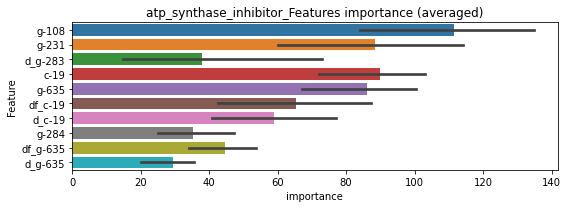

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00869388	valid_1's binary_logloss: 0.0113016
[200]	training's binary_logloss: 0.000700767	valid_1's binary_logloss: 0.00336003
Early stopping, best iteration is:
[272]	training's binary_logloss: 0.000226555	valid_1's binary_logloss: 0.00278465


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00887627	valid_1's binary_logloss: 0.0100703
[200]	training's binary_logloss: 0.000728476	valid_1's binary_logloss: 0.00260369
[300]	training's binary_logloss: 0.000182567	valid_1's binary_logloss: 0.00201444
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.000176128	valid_1's binary_logloss: 0.00200026


atp_synthase_inhibitor logloss: 0.002392457172953516


neg labels: 3289 → selected neg labels: 3273


atpase_inhibitor, len(trt): 97, len(othr): 3273, target_rate: 0.0040732 → Adj_target_rate: 0.0041016
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0598587	valid_1's binary_logloss: 0.129498
[200]	training's binary_logloss: 0.0134169	valid_1's binary_logloss: 0.0808848
Early stopping, best iteration is:
[287]	training's binary_logloss: 0.00451345	valid_1's binary_logloss: 0.0692795
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0527753	valid_1's binary_logloss: 0.138012
[200]	training's binary_logloss: 0.0116014	valid_1's binary_logloss: 0.0931819
[300]	training's binary_logloss: 0.00343641	valid_1's binary_logloss: 0.0857432
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.00260296	valid_1's binary_logloss: 0.084779


1 / 3 AUC score:0.988
y_Threshold: 0.0219441, Threshold: 0.0597073, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 180 → Positive_corect_labels: 630/3747
p_label_rate: 0.0200904 Vs.target_rate: 0.00407
Num_p_label: 80.0, conf_0:0.05374, conf_1:0.06568
Num_p_label: 80.0, Expected: 16.2, Adj_threshold_1: 0.0597073
Num_p_label: 71.0, Expected: 16.2, Adj_threshold_2: 0.0697073
Num_p_label: 51.0, Expected: 16.2, Adj_threshold_3: 0.0797073
Num_p_label: 42.0, Expected: 16.2, Adj_threshold_4: 0.0897073
Num_p_label: 34.0, Expected: 16.2, Adj_threshold_5: 0.0997073
Num_p_label: 26.0, Expected: 16.2, Adj_threshold_6: 0.1097073
threshold: 0.1097073, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 630.0/3747, y_label_rate: 0.1681345
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0497006	valid_1's binary_logloss: 0.122082
[200]	training's binary_logloss: 0.0105403	valid_1's binary_logloss: 0.0726719
[300]	training's binary_logloss: 0.0030912	valid_1's binary_logloss: 0.0607575
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.00220019	valid_1's binary_logloss: 0.0587505
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0523211	valid_1's binary_logloss: 0.117879
[200]	training's binary_logloss: 0.0107769	valid_1's binary_logloss: 0.0639576
[300]	training's binary_logloss: 0.00314994	valid_1's binary_logloss: 0.0515655
[400]	training's binary_logloss: 0.0014297	valid_1's binary_logloss: 0.0486635
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00138724	valid_1's binary_logloss: 0.0485088


2 / 3 AUC score:0.994
y_Threshold: 0.0539664, Threshold: 0.1097073, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 48 → Positive_corect_labels: 606.0/3699
p_label_rate: 0.0406831 Vs.target_rate: 0.00407
Num_p_label: 162.0, conf_0:0.09874, conf_1:0.12068
Num_p_label: 162.0, Expected: 16.2, Adj_threshold_1: 0.1097073
Num_p_label: 151.0, Expected: 16.2, Adj_threshold_2: 0.1197073
Num_p_label: 148.0, Expected: 16.2, Adj_threshold_3: 0.1297073
Num_p_label: 139.0, Expected: 16.2, Adj_threshold_4: 0.1397073
Num_p_label: 134.0, Expected: 16.2, Adj_threshold_5: 0.1497073
Num_p_label: 127.0, Expected: 16.2, Adj_threshold_6: 0.1597073
Num_p_label: 122.0, Expected: 16.2, Adj_threshold_7: 0.1697073
Num_p_label: 116.0, Expected: 16.2, Adj_threshold_8: 0.1797073
Num_p_label: 111.0, Expected: 16.2, Adj_threshold_9: 0.1897073
Num_p_label: 106.0, Expected: 16.2, Adj_threshold_10: 0.1997073
threshold: 0.2097073, positive_p_label: 105.0/3982, p_label_rate: 0.0263687
positive_y_label: 606.0/3699, y_label_ra

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0451428	valid_1's binary_logloss: 0.103992
[200]	training's binary_logloss: 0.00866722	valid_1's binary_logloss: 0.0599014
Early stopping, best iteration is:
[273]	training's binary_logloss: 0.00340574	valid_1's binary_logloss: 0.0511918
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.046569	valid_1's binary_logloss: 0.106442
[200]	training's binary_logloss: 0.00885131	valid_1's binary_logloss: 0.0641091
[300]	training's binary_logloss: 0.00262122	valid_1's binary_logloss: 0.0558225
Early stopping, best iteration is:
[342]	training's binary_logloss: 0.00181823	valid_1's binary_logloss: 0.0548719


3 / 3 AUC score:0.995
y_Threshold: 0.0645735, Threshold: 0.2097073, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 44 → Positive_corect_labels: 584.0/3655
p_label_rate: 0.0381718 Vs.target_rate: 0.00407
Num_p_label: 152.0, conf_0:0.18874, conf_1:0.23068
Num_p_label: 152.0, Expected: 16.2, Adj_threshold_1: 0.2097073
Num_p_label: 149.0, Expected: 16.2, Adj_threshold_2: 0.2197073
Num_p_label: 145.0, Expected: 16.2, Adj_threshold_3: 0.2297073
Num_p_label: 141.0, Expected: 16.2, Adj_threshold_4: 0.2397073
Num_p_label: 138.0, Expected: 16.2, Adj_threshold_5: 0.2497073
Num_p_label: 132.0, Expected: 16.2, Adj_threshold_6: 0.2597073
Num_p_label: 128.0, Expected: 16.2, Adj_threshold_7: 0.2697073
Num_p_label: 126.0, Expected: 16.2, Adj_threshold_8: 0.2797073
Num_p_label: 122.0, Expected: 16.2, Adj_threshold_9: 0.2897073
Num_p_label: 116.0, Expected: 16.2, Adj_threshold_10: 0.2997073
threshold: 0.3097073, positive_p_label: 113.0/3982, p_label_rate: 0.0283777
positive_y_label: 697.0/7637, y_label_ra

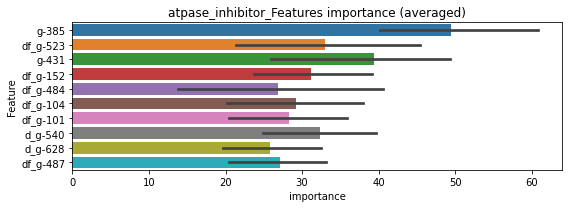

len(train_index) : 3818
len(valid_index) : 3819
================================= fold 1/2 atpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294676	valid_1's binary_logloss: 0.0684027
[200]	training's binary_logloss: 0.00615913	valid_1's binary_logloss: 0.0432245
[300]	training's binary_logloss: 0.00181426	valid_1's binary_logloss: 0.0378368
Early stopping, best iteration is:
[342]	training's binary_logloss: 0.00124639	valid_1's binary_logloss: 0.0369576


len(train_index) : 3819
len(valid_index) : 3818
================================= fold 2/2 atpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0308048	valid_1's binary_logloss: 0.0780661
[200]	training's binary_logloss: 0.006675	valid_1's binary_logloss: 0.0537898
[300]	training's binary_logloss: 0.00178953	valid_1's binary_logloss: 0.0472903
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.00184797	valid_1's binary_logloss: 0.0471771


atpase_inhibitor logloss: 0.042066722200228036


neg labels: 3289 → selected neg labels: 3286


atr_kinase_inhibitor, len(trt): 19, len(othr): 3286, target_rate: 0.0007979 → Adj_target_rate: 0.0010260
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188756	valid_1's binary_logloss: 0.0228723
[200]	training's binary_logloss: 0.00189816	valid_1's binary_logloss: 0.0037902
[300]	training's binary_logloss: 0.000532699	valid_1's binary_logloss: 0.00168308
[400]	training's binary_logloss: 0.000310743	valid_1's binary_logloss: 0.00123012
[500]	training's binary_logloss: 0.000267545	valid_1's binary_logloss: 0.00113365
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000264598	valid_1's binary_logloss: 0.00112722
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189501	valid_1's binary_logloss: 0.0234434
[200]	training's binary_logloss: 0.00188227	valid_1's binary_logloss: 0.00398032
[300]	training's binary_logloss: 0.000533551	valid_1's binary_logloss: 0.0017821
[400]	training's binary_logloss: 0.000312904	valid_1's binary_logloss: 0.00125201
[500]	training's binary_logloss: 

1 / 3 AUC score:1.000
y_Threshold: 0.0015928, Threshold: 0.0048421, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00080
Num_p_label: 80.0, conf_0:0.00436, conf_1:0.00533
Num_p_label: 80.0, Expected: 3.2, Adj_threshold_1: 0.0048421
Num_p_label: 36.0, Expected: 3.2, Adj_threshold_2: 0.0148421
Num_p_label: 24.0, Expected: 3.2, Adj_threshold_3: 0.0248421
Num_p_label: 20.0, Expected: 3.2, Adj_threshold_4: 0.0348421
Num_p_label: 17.0, Expected: 3.2, Adj_threshold_5: 0.0448421
Num_p_label: 16.0, Expected: 3.2, Adj_threshold_6: 0.0548421
Num_p_label: 15.0, Expected: 3.2, Adj_threshold_7: 0.0648421
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_8: 0.0748421
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_9: 0.0848421
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_10: 0.0948421
threshold: 0.1048421, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185883	valid_1's binary_logloss: 0.0208777
[200]	training's binary_logloss: 0.0017276	valid_1's binary_logloss: 0.00277125
[300]	training's binary_logloss: 0.000466959	valid_1's binary_logloss: 0.00100327
[400]	training's binary_logloss: 0.000275102	valid_1's binary_logloss: 0.000699162
[500]	training's binary_logloss: 0.000241751	valid_1's binary_logloss: 0.000646878
Early stopping, best iteration is:
[519]	training's binary_logloss: 0.000240229	valid_1's binary_logloss: 0.000644929
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185348	valid_1's binary_logloss: 0.0214794
[200]	training's binary_logloss: 0.0017413	valid_1's binary_logloss: 0.00313731
[300]	training's binary_logloss: 0.000466823	valid_1's binary_logloss: 0.00114125
[400]	training's binary_logloss: 0.000278894	valid_1's binary_logloss: 0.000789836
[500]	training's binary_loglo

2 / 3 AUC score:1.000
y_Threshold: 0.1390437, Threshold: 0.1048421, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0145655 Vs.target_rate: 0.00080
Num_p_label: 58.0, conf_0:0.09436, conf_1:0.11533
Num_p_label: 58.0, Expected: 3.2, Adj_threshold_1: 0.1048421
Num_p_label: 57.0, Expected: 3.2, Adj_threshold_2: 0.1148421
Num_p_label: 57.0, Expected: 3.2, Adj_threshold_3: 0.1248421
Num_p_label: 57.0, Expected: 3.2, Adj_threshold_4: 0.1348421
Num_p_label: 57.0, Expected: 3.2, Adj_threshold_5: 0.1448421
Num_p_label: 57.0, Expected: 3.2, Adj_threshold_6: 0.1548421
Num_p_label: 55.0, Expected: 3.2, Adj_threshold_7: 0.1648421
Num_p_label: 55.0, Expected: 3.2, Adj_threshold_8: 0.1748421
Num_p_label: 52.0, Expected: 3.2, Adj_threshold_9: 0.1848421
Num_p_label: 50.0, Expected: 3.2, Adj_threshold_10: 0.1948421
threshold: 0.2048421, positive_p_label: 49.0/3982, p_label_rate: 0.0123054
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185883	valid_1's binary_logloss: 0.0208777
[200]	training's binary_logloss: 0.0017276	valid_1's binary_logloss: 0.00277125
[300]	training's binary_logloss: 0.000466959	valid_1's binary_logloss: 0.00100327
[400]	training's binary_logloss: 0.000275102	valid_1's binary_logloss: 0.000699162
[500]	training's binary_logloss: 0.000241751	valid_1's binary_logloss: 0.000646878
Early stopping, best iteration is:
[519]	training's binary_logloss: 0.000240229	valid_1's binary_logloss: 0.000644929
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185348	valid_1's binary_logloss: 0.0214794
[200]	training's binary_logloss: 0.0017413	valid_1's binary_logloss: 0.00313731
[300]	training's binary_logloss: 0.000466823	valid_1's binary_logloss: 0.00114125
[400]	training's binary_logloss: 0.000278894	valid_1's binary_logloss: 0.000789836
[500]	training's binary_loglo

3 / 3 AUC score:1.000
y_Threshold: 0.1390437, Threshold: 0.2048421, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0123054 Vs.target_rate: 0.00080
Num_p_label: 49.0, conf_0:0.18436, conf_1:0.22533
Num_p_label: 49.0, Expected: 3.2, Adj_threshold_1: 0.2048421
Num_p_label: 49.0, Expected: 3.2, Adj_threshold_2: 0.2148421
Num_p_label: 48.0, Expected: 3.2, Adj_threshold_3: 0.2248421
Num_p_label: 47.0, Expected: 3.2, Adj_threshold_4: 0.2348421
Num_p_label: 47.0, Expected: 3.2, Adj_threshold_5: 0.2448421
Num_p_label: 46.0, Expected: 3.2, Adj_threshold_6: 0.2548421
Num_p_label: 43.0, Expected: 3.2, Adj_threshold_7: 0.2648421
Num_p_label: 43.0, Expected: 3.2, Adj_threshold_8: 0.2748421
Num_p_label: 41.0, Expected: 3.2, Adj_threshold_9: 0.2848421
Num_p_label: 41.0, Expected: 3.2, Adj_threshold_10: 0.2948421
threshold: 0.3048421, positive_p_label: 41.0/3982, p_label_rate: 0.0102963
positive_y_label: 698.0/7793, y_label_rate: 0.0895676


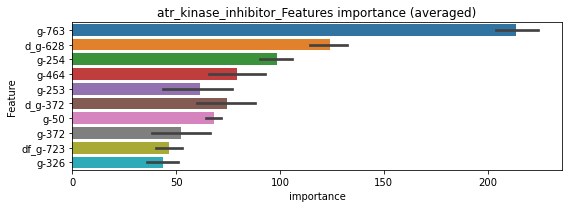

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0114886	valid_1's binary_logloss: 0.0188672
[200]	training's binary_logloss: 0.00124648	valid_1's binary_logloss: 0.00768421
[300]	training's binary_logloss: 0.000335805	valid_1's binary_logloss: 0.00609118
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.000257838	valid_1's binary_logloss: 0.00582347


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0114871	valid_1's binary_logloss: 0.0203919
[200]	training's binary_logloss: 0.00123985	valid_1's binary_logloss: 0.00885243
[300]	training's binary_logloss: 0.000342083	valid_1's binary_logloss: 0.00713652
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.000263728	valid_1's binary_logloss: 0.0070126


atr_kinase_inhibitor logloss: 0.0064179579859630215


neg labels: 3289 → selected neg labels: 3273


aurora_kinase_inhibitor, len(trt): 96, len(othr): 3273, target_rate: 0.0040312 → Adj_target_rate: 0.0040656
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0360138	valid_1's binary_logloss: 0.0751969
[200]	training's binary_logloss: 0.0058571	valid_1's binary_logloss: 0.0387767
[300]	training's binary_logloss: 0.00167257	valid_1's binary_logloss: 0.0312128
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.00128731	valid_1's binary_logloss: 0.0297657
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0358578	valid_1's binary_logloss: 0.0686277
[200]	training's binary_logloss: 0.00589449	valid_1's binary_logloss: 0.0315879
[300]	training's binary_logloss: 0.00176523	valid_1's binary_logloss: 0.022451
[400]	training's binary_logloss: 0.000864607	valid_1's binary_logloss: 0.0191945
[500]	training's binary_logloss: 0.00056633	valid_1's binary_logloss: 0.018255
Early stopping, best iteration is:
[554]	training's binary_logloss: 0.00050201	valid_1's binary_logloss: 0.0179185


1 / 3 AUC score:0.999
y_Threshold: 0.0161813, Threshold: 0.0486370, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → Positive_corect_labels: 651/3789
p_label_rate: 0.0200904 Vs.target_rate: 0.00403
Num_p_label: 80.0, conf_0:0.04377, conf_1:0.05350
Num_p_label: 80.0, Expected: 16.1, Adj_threshold_1: 0.0486370
Num_p_label: 76.0, Expected: 16.1, Adj_threshold_2: 0.0586370
Num_p_label: 70.0, Expected: 16.1, Adj_threshold_3: 0.0686370
Num_p_label: 60.0, Expected: 16.1, Adj_threshold_4: 0.0786370
Num_p_label: 59.0, Expected: 16.1, Adj_threshold_5: 0.0886370
Num_p_label: 57.0, Expected: 16.1, Adj_threshold_6: 0.0986370
Num_p_label: 54.0, Expected: 16.1, Adj_threshold_7: 0.1086370
Num_p_label: 50.0, Expected: 16.1, Adj_threshold_8: 0.1186370
Num_p_label: 44.0, Expected: 16.1, Adj_threshold_9: 0.1286370
Num_p_label: 43.0, Expected: 16.1, Adj_threshold_10: 0.1386370
threshold: 0.1486370, positive_p_label: 42.0/3982, p_label_rate: 0.0105475
positive_y_label: 651.0/3789, y_label_rate: 0.1718131

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0326965	valid_1's binary_logloss: 0.0597333
[200]	training's binary_logloss: 0.00480058	valid_1's binary_logloss: 0.0230506
[300]	training's binary_logloss: 0.00137875	valid_1's binary_logloss: 0.0151807
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.000839586	valid_1's binary_logloss: 0.0130043
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0316902	valid_1's binary_logloss: 0.0622151
[200]	training's binary_logloss: 0.00456424	valid_1's binary_logloss: 0.0314929
Early stopping, best iteration is:
[283]	training's binary_logloss: 0.00156597	valid_1's binary_logloss: 0.0274938


2 / 3 AUC score:1.000
y_Threshold: 0.1149957, Threshold: 0.1486370, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 644.0/3775
p_label_rate: 0.0220994 Vs.target_rate: 0.00403
Num_p_label: 88.0, conf_0:0.13377, conf_1:0.16350
Num_p_label: 88.0, Expected: 16.1, Adj_threshold_1: 0.1486370
Num_p_label: 85.0, Expected: 16.1, Adj_threshold_2: 0.1586370
Num_p_label: 84.0, Expected: 16.1, Adj_threshold_3: 0.1686370
Num_p_label: 82.0, Expected: 16.1, Adj_threshold_4: 0.1786370
Num_p_label: 81.0, Expected: 16.1, Adj_threshold_5: 0.1886370
Num_p_label: 81.0, Expected: 16.1, Adj_threshold_6: 0.1986370
Num_p_label: 79.0, Expected: 16.1, Adj_threshold_7: 0.2086370
Num_p_label: 75.0, Expected: 16.1, Adj_threshold_8: 0.2186370
Num_p_label: 72.0, Expected: 16.1, Adj_threshold_9: 0.2286370
Num_p_label: 70.0, Expected: 16.1, Adj_threshold_10: 0.2386370
threshold: 0.2486370, positive_p_label: 69.0/3982, p_label_rate: 0.0173280
positive_y_label: 644.0/3775, y_label_rate: 0.170596

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0314473	valid_1's binary_logloss: 0.0684678
[200]	training's binary_logloss: 0.00438371	valid_1's binary_logloss: 0.0359615
[300]	training's binary_logloss: 0.00128366	valid_1's binary_logloss: 0.0317621
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.000978619	valid_1's binary_logloss: 0.0310577
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304659	valid_1's binary_logloss: 0.0613424
[200]	training's binary_logloss: 0.00440551	valid_1's binary_logloss: 0.0267658
[300]	training's binary_logloss: 0.0012627	valid_1's binary_logloss: 0.0184581
[400]	training's binary_logloss: 0.000634417	valid_1's binary_logloss: 0.0160929
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.000498141	valid_1's binary_logloss: 0.0155087


3 / 3 AUC score:0.999
y_Threshold: 0.0594089, Threshold: 0.2486370, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 20 → Positive_corect_labels: 634.0/3755
p_label_rate: 0.0188348 Vs.target_rate: 0.00403
Num_p_label: 75.0, conf_0:0.22377, conf_1:0.27350
Num_p_label: 75.0, Expected: 16.1, Adj_threshold_1: 0.2486370
Num_p_label: 75.0, Expected: 16.1, Adj_threshold_2: 0.2586370
Num_p_label: 74.0, Expected: 16.1, Adj_threshold_3: 0.2686370
Num_p_label: 72.0, Expected: 16.1, Adj_threshold_4: 0.2786370
Num_p_label: 72.0, Expected: 16.1, Adj_threshold_5: 0.2886370
Num_p_label: 70.0, Expected: 16.1, Adj_threshold_6: 0.2986370
Num_p_label: 69.0, Expected: 16.1, Adj_threshold_7: 0.3086370
Num_p_label: 68.0, Expected: 16.1, Adj_threshold_8: 0.3186370
Num_p_label: 66.0, Expected: 16.1, Adj_threshold_9: 0.3286370
Num_p_label: 65.0, Expected: 16.1, Adj_threshold_10: 0.3386370
threshold: 0.3486370, positive_p_label: 65.0/3982, p_label_rate: 0.0163235
positive_y_label: 699.0/7737, y_label_rate: 0.090345

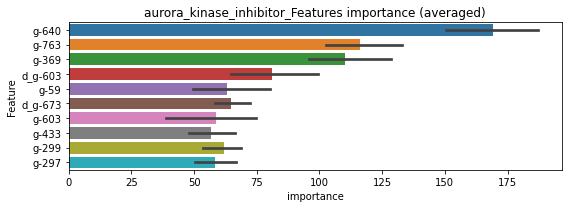

len(train_index) : 3868
len(valid_index) : 3869
================================= fold 1/2 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0177307	valid_1's binary_logloss: 0.0419891
[200]	training's binary_logloss: 0.00254437	valid_1's binary_logloss: 0.0242264
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.000852129	valid_1's binary_logloss: 0.0218449


len(train_index) : 3869
len(valid_index) : 3868
================================= fold 2/2 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0174036	valid_1's binary_logloss: 0.0449905
[200]	training's binary_logloss: 0.00270108	valid_1's binary_logloss: 0.0259768
[300]	training's binary_logloss: 0.000781032	valid_1's binary_logloss: 0.0204373
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.000441699	valid_1's binary_logloss: 0.0194651


aurora_kinase_inhibitor logloss: 0.020655157649883828


neg labels: 3289 → selected neg labels: 3288


autotaxin_inhibitor, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161549	valid_1's binary_logloss: 0.0174139
[200]	training's binary_logloss: 0.00134084	valid_1's binary_logloss: 0.00169914
[300]	training's binary_logloss: 0.000356108	valid_1's binary_logloss: 0.000558852
[400]	training's binary_logloss: 0.000215242	valid_1's binary_logloss: 0.000382317
[500]	training's binary_logloss: 0.000189545	valid_1's binary_logloss: 0.000351255
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.000188534	valid_1's binary_logloss: 0.000350117
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162993	valid_1's binary_logloss: 0.017807
[200]	training's binary_logloss: 0.00134607	valid_1's binary_logloss: 0.00164862
[300]	training's binary_logloss: 0.000353547	valid_1's binary_logloss: 0.000490196
[400]	training's binary_logloss: 0.000213889	valid_1's binary_logloss: 0.000307805
[500]	training's binary_lo

1 / 3 AUC score:1.000
y_Threshold: 0.0005086, Threshold: 0.0008905, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0200904 Vs.target_rate: 0.00025
Num_p_label: 80.0, conf_0:0.00080, conf_1:0.00098
Num_p_label: 80.0, Expected: 1.0, Adj_threshold_1: 0.0008905
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_2: 0.0108905
threshold: 0.0108905, positive_p_label: 0.0/3982, p_label_rate: 0.0000000
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163775	valid_1's binary_logloss: 0.0185701
[200]	training's binary_logloss: 0.00133276	valid_1's binary_logloss: 0.00263022
[300]	training's binary_logloss: 0.000347884	valid_1's binary_logloss: 0.00120818
[400]	training's binary_logloss: 0.000213033	valid_1's binary_logloss: 0.000934057
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.000188325	valid_1's binary_logloss: 0.00088245
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165276	valid_1's binary_logloss: 0.0175848
[200]	training's binary_logloss: 0.00134351	valid_1's binary_logloss: 0.00153946
[300]	training's binary_logloss: 0.000348206	valid_1's binary_logloss: 0.00041961
[400]	training's binary_logloss: 0.000214148	valid_1's binary_logloss: 0.000261613
[500]	training's binary_logloss: 0.00018617	valid_1's binary_logloss: 0.000227878
Early stopping, best iteratio

2 / 3 AUC score:1.000
y_Threshold: 0.0829303, Threshold: 0.0108905, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0027624 Vs.target_rate: 0.00025
Num_p_label: 11.0, conf_0:0.00980, conf_1:0.01198
Num_p_label: 11.0, Expected: 1.0, Adj_threshold_1: 0.0108905
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_2: 0.0208905
threshold: 0.0208905, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163775	valid_1's binary_logloss: 0.0185701
[200]	training's binary_logloss: 0.00133276	valid_1's binary_logloss: 0.00263022
[300]	training's binary_logloss: 0.000347884	valid_1's binary_logloss: 0.00120818
[400]	training's binary_logloss: 0.000213033	valid_1's binary_logloss: 0.000934057
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.000188325	valid_1's binary_logloss: 0.00088245
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165276	valid_1's binary_logloss: 0.0175848
[200]	training's binary_logloss: 0.00134351	valid_1's binary_logloss: 0.00153946
[300]	training's binary_logloss: 0.000348206	valid_1's binary_logloss: 0.00041961
[400]	training's binary_logloss: 0.000214148	valid_1's binary_logloss: 0.000261613
[500]	training's binary_logloss: 0.00018617	valid_1's binary_logloss: 0.000227878
Early stopping, best iteratio

3 / 3 AUC score:1.000
y_Threshold: 0.0829303, Threshold: 0.0208905, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0005023 Vs.target_rate: 0.00025
Num_p_label: 2.0, conf_0:0.01880, conf_1:0.02298
threshold: 0.0208905, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 659.0/7795, y_label_rate: 0.0845414


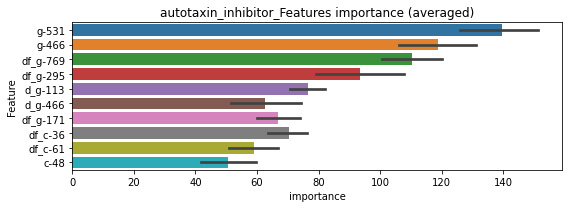

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 autotaxin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00891683	valid_1's binary_logloss: 0.0110872
[200]	training's binary_logloss: 0.000712154	valid_1's binary_logloss: 0.00226803
Early stopping, best iteration is:
[263]	training's binary_logloss: 0.000262995	valid_1's binary_logloss: 0.00189409


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 autotaxin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00880068	valid_1's binary_logloss: 0.00977209
[200]	training's binary_logloss: 0.000719387	valid_1's binary_logloss: 0.00147558
[300]	training's binary_logloss: 0.000184604	valid_1's binary_logloss: 0.000962807
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.000192181	valid_1's binary_logloss: 0.000954572


autotaxin_inhibitor logloss: 0.0014243914783246957


neg labels: 3289 → selected neg labels: 3279


bacterial_30s_ribosomal_subunit_inhibitor, len(trt): 60, len(othr): 3279, target_rate: 0.0025195 → Adj_target_rate: 0.0027266
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0492403	valid_1's binary_logloss: 0.103499
[200]	training's binary_logloss: 0.00967515	valid_1's binary_logloss: 0.0627936
Early stopping, best iteration is:
[279]	training's binary_logloss: 0.00336101	valid_1's binary_logloss: 0.0554072
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0497458	valid_1's binary_logloss: 0.101558
[200]	training's binary_logloss: 0.00944631	valid_1's binary_logloss: 0.0475059
[300]	training's binary_logloss: 0.00271142	valid_1's binary_logloss: 0.0345726
[400]	training's binary_logloss: 0.0012231	valid_1's binary_logloss: 0.0295179
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000910453	valid_1's binary_logloss: 0.0284969


1 / 3 AUC score:0.997
y_Threshold: 0.0148641, Threshold: 0.0205894, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 152 → Positive_corect_labels: 645/3782
p_label_rate: 0.0200904 Vs.target_rate: 0.00252
Num_p_label: 80.0, conf_0:0.01853, conf_1:0.02265
Num_p_label: 80.0, Expected: 10.0, Adj_threshold_1: 0.0205894
Num_p_label: 31.0, Expected: 10.0, Adj_threshold_2: 0.0305894
Num_p_label: 21.0, Expected: 10.0, Adj_threshold_3: 0.0405894
Num_p_label: 9.0, Expected: 10.0, Adj_threshold_4: 0.0505894
threshold: 0.0505894, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 645.0/3782, y_label_rate: 0.1705447
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0480978	valid_1's binary_logloss: 0.0947378
[200]	training's binary_logloss: 0.00902353	valid_1's binary_logloss: 0.0468794
[300]	training's binary_logloss: 0.00256613	valid_1's binary_logloss: 0.0383715
Early stopping, best iteration is:
[373]	training's binary_logloss: 0.00137967	valid_1's binary_logloss: 0.0368696
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0488771	valid_1's binary_logloss: 0.0826609
[200]	training's binary_logloss: 0.00936543	valid_1's binary_logloss: 0.0350601
[300]	training's binary_logloss: 0.00271568	valid_1's binary_logloss: 0.0225506
[400]	training's binary_logloss: 0.00123371	valid_1's binary_logloss: 0.0190053
[500]	training's binary_logloss: 0.000759472	valid_1's binary_logloss: 0.0175307
Early stopping, best iteration is:
[562]	training's binary_logloss: 0.000624348	valid_1's binary_logloss: 0.0168319


2 / 3 AUC score:0.996
y_Threshold: 0.0278635, Threshold: 0.0505894, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 18 → Positive_corect_labels: 636.0/3764
p_label_rate: 0.0030136 Vs.target_rate: 0.00252
Num_p_label: 12.0, conf_0:0.04553, conf_1:0.05565
threshold: 0.0505894, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 636.0/3764, y_label_rate: 0.1689692
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0455517	valid_1's binary_logloss: 0.0908309
[200]	training's binary_logloss: 0.00829204	valid_1's binary_logloss: 0.0461048
[300]	training's binary_logloss: 0.00237362	valid_1's binary_logloss: 0.0366061
[400]	training's binary_logloss: 0.00110062	valid_1's binary_logloss: 0.0343835
Early stopping, best iteration is:
[423]	training's binary_logloss: 0.000963225	valid_1's binary_logloss: 0.0340543
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.045769	valid_1's binary_logloss: 0.0923878
[200]	training's binary_logloss: 0.00826563	valid_1's binary_logloss: 0.0494884
Early stopping, best iteration is:
[283]	training's binary_logloss: 0.00278286	valid_1's binary_logloss: 0.0437799


3 / 3 AUC score:0.993
y_Threshold: 0.0284863, Threshold: 0.0505894, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 30 → Positive_corect_labels: 621.0/3734
p_label_rate: 0.0060271 Vs.target_rate: 0.00252
Num_p_label: 24.0, conf_0:0.04553, conf_1:0.05565
threshold: 0.0505894, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 645.0/7716, y_label_rate: 0.0835925


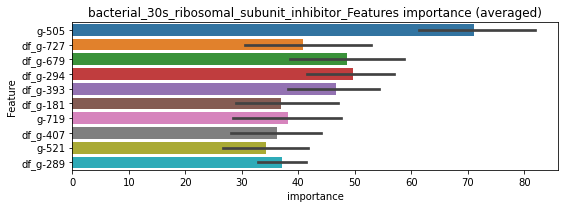

len(train_index) : 3858
len(valid_index) : 3858
================================= fold 1/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252279	valid_1's binary_logloss: 0.0558404
[200]	training's binary_logloss: 0.00447754	valid_1's binary_logloss: 0.0329
Early stopping, best iteration is:
[284]	training's binary_logloss: 0.0014994	valid_1's binary_logloss: 0.0296632


len(train_index) : 3858
len(valid_index) : 3858
================================= fold 2/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261257	valid_1's binary_logloss: 0.0604221
[200]	training's binary_logloss: 0.00473937	valid_1's binary_logloss: 0.0382648
Early stopping, best iteration is:
[245]	training's binary_logloss: 0.00252396	valid_1's binary_logloss: 0.0361113


bacterial_30s_ribosomal_subunit_inhibitor logloss: 0.03288729363991586


neg labels: 3289 → selected neg labels: 3277


bacterial_50s_ribosomal_subunit_inhibitor, len(trt): 80, len(othr): 3277, target_rate: 0.0033594 → Adj_target_rate: 0.0034820
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0576466	valid_1's binary_logloss: 0.121677
[200]	training's binary_logloss: 0.0133321	valid_1's binary_logloss: 0.0730676
[300]	training's binary_logloss: 0.00393808	valid_1's binary_logloss: 0.0599347
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.00333276	valid_1's binary_logloss: 0.0590517
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0600405	valid_1's binary_logloss: 0.134272
[200]	training's binary_logloss: 0.0137726	valid_1's binary_logloss: 0.0837619
[300]	training's binary_logloss: 0.00397797	valid_1's binary_logloss: 0.071668
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00339643	valid_1's binary_logloss: 0.0704745


1 / 3 AUC score:0.991
y_Threshold: 0.0214561, Threshold: 0.0278141, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 166 → Positive_corect_labels: 638/3766
p_label_rate: 0.0200904 Vs.target_rate: 0.00336
Num_p_label: 80.0, conf_0:0.02503, conf_1:0.03060
Num_p_label: 80.0, Expected: 13.4, Adj_threshold_1: 0.0278141
Num_p_label: 34.0, Expected: 13.4, Adj_threshold_2: 0.0378141
Num_p_label: 21.0, Expected: 13.4, Adj_threshold_3: 0.0478141
threshold: 0.0478141, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 638.0/3766, y_label_rate: 0.1694105
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0568955	valid_1's binary_logloss: 0.121778
[200]	training's binary_logloss: 0.0128444	valid_1's binary_logloss: 0.0732618
[300]	training's binary_logloss: 0.00371698	valid_1's binary_logloss: 0.0609634
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.00343305	valid_1's binary_logloss: 0.0603569
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0573158	valid_1's binary_logloss: 0.118334
[200]	training's binary_logloss: 0.0119794	valid_1's binary_logloss: 0.0648188
[300]	training's binary_logloss: 0.00340138	valid_1's binary_logloss: 0.0531905
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.00305695	valid_1's binary_logloss: 0.0528178


2 / 3 AUC score:0.995
y_Threshold: 0.0394415, Threshold: 0.0478141, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 34 → Positive_corect_labels: 621.0/3732
p_label_rate: 0.0123054 Vs.target_rate: 0.00336
Num_p_label: 49.0, conf_0:0.04303, conf_1:0.05260
Num_p_label: 49.0, Expected: 13.4, Adj_threshold_1: 0.0478141
Num_p_label: 34.0, Expected: 13.4, Adj_threshold_2: 0.0578141
Num_p_label: 19.0, Expected: 13.4, Adj_threshold_3: 0.0678141
threshold: 0.0678141, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 621.0/3732, y_label_rate: 0.1663987
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0562932	valid_1's binary_logloss: 0.109535
[200]	training's binary_logloss: 0.0120616	valid_1's binary_logloss: 0.0549172
[300]	training's binary_logloss: 0.00354311	valid_1's binary_logloss: 0.0397757
[400]	training's binary_logloss: 0.00157094	valid_1's binary_logloss: 0.0354111
[500]	training's binary_logloss: 0.000937713	valid_1's binary_logloss: 0.0339413
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000956413	valid_1's binary_logloss: 0.03379
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0537204	valid_1's binary_logloss: 0.116417
[200]	training's binary_logloss: 0.0114654	valid_1's binary_logloss: 0.0650522
[300]	training's binary_logloss: 0.00331636	valid_1's binary_logloss: 0.052029
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.00189831	valid_1's binary_logloss: 0.048333


3 / 3 AUC score:0.999
y_Threshold: 0.0351477, Threshold: 0.0678141, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 20 → Positive_corect_labels: 611.0/3712
p_label_rate: 0.0032647 Vs.target_rate: 0.00336
Num_p_label: 13.0, conf_0:0.06103, conf_1:0.07460
threshold: 0.0678141, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 624.0/7694, y_label_rate: 0.0811022


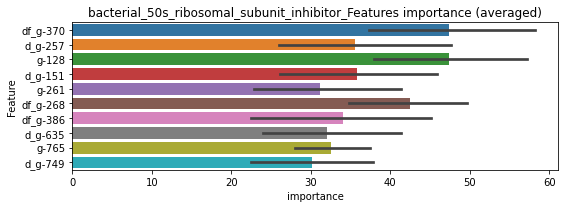

len(train_index) : 3847
len(valid_index) : 3847
================================= fold 1/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0284735	valid_1's binary_logloss: 0.0709827
[200]	training's binary_logloss: 0.00624552	valid_1's binary_logloss: 0.0471785
[300]	training's binary_logloss: 0.00163414	valid_1's binary_logloss: 0.0419588
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00133545	valid_1's binary_logloss: 0.041698


len(train_index) : 3847
len(valid_index) : 3847
================================= fold 2/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0301651	valid_1's binary_logloss: 0.0677527
[200]	training's binary_logloss: 0.00628725	valid_1's binary_logloss: 0.0409478
[300]	training's binary_logloss: 0.00181502	valid_1's binary_logloss: 0.0352314
[400]	training's binary_logloss: 0.000782072	valid_1's binary_logloss: 0.0334895
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.000830451	valid_1's binary_logloss: 0.0334258


bacterial_50s_ribosomal_subunit_inhibitor logloss: 0.03756188033850405


neg labels: 3289 → selected neg labels: 3283


bacterial_antifolate, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0347179	valid_1's binary_logloss: 0.0513765
[200]	training's binary_logloss: 0.00526957	valid_1's binary_logloss: 0.0122857
[300]	training's binary_logloss: 0.00145618	valid_1's binary_logloss: 0.00511297
[400]	training's binary_logloss: 0.000698786	valid_1's binary_logloss: 0.00335981
[500]	training's binary_logloss: 0.000467891	valid_1's binary_logloss: 0.00270502
Early stopping, best iteration is:
[574]	training's binary_logloss: 0.000424834	valid_1's binary_logloss: 0.00258038
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0342342	valid_1's binary_logloss: 0.0662164
[200]	training's binary_logloss: 0.00504785	valid_1's binary_logloss: 0.0265455
[300]	training's binary_logloss: 0.00140371	valid_1's binary_logloss: 0.0190636
[400]	training's binary_logloss: 0.000678535	valid_1's binary_logloss: 0.0168963
Early stopping, best iteration is:
[4

1 / 3 AUC score:1.000
y_Threshold: 0.0045462, Threshold: 0.0073018, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 655/3805
p_label_rate: 0.0200904 Vs.target_rate: 0.00151
Num_p_label: 80.0, conf_0:0.00657, conf_1:0.00803
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0073018
Num_p_label: 29.0, Expected: 6.0, Adj_threshold_2: 0.0173018
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_3: 0.0273018
Num_p_label: 8.0, Expected: 6.0, Adj_threshold_4: 0.0373018
threshold: 0.0373018, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0332839	valid_1's binary_logloss: 0.0451383
[200]	training's binary_logloss: 0.00487774	valid_1's binary_logloss: 0.00935119
[300]	training's binary_logloss: 0.00138115	valid_1's binary_logloss: 0.00342772
[400]	training's binary_logloss: 0.000678274	valid_1's binary_logloss: 0.00196214
[500]	training's binary_logloss: 0.000459811	valid_1's binary_logloss: 0.00146528
[600]	training's binary_logloss: 0.000418791	valid_1's binary_logloss: 0.00136794
Early stopping, best iteration is:
[597]	training's binary_logloss: 0.000419001	valid_1's binary_logloss: 0.00136792
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330169	valid_1's binary_logloss: 0.0559913
[200]	training's binary_logloss: 0.0046744	valid_1's binary_logloss: 0.0179616
[300]	training's binary_logloss: 0.00132277	valid_1's binary_logloss: 0.0110072
[400]	training's binary_logloss: 0.0

2 / 3 AUC score:1.000
y_Threshold: 0.0494296, Threshold: 0.0373018, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0065294 Vs.target_rate: 0.00151
Num_p_label: 26.0, conf_0:0.03357, conf_1:0.04103
Num_p_label: 26.0, Expected: 6.0, Adj_threshold_1: 0.0373018
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_2: 0.0473018
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_3: 0.0573018
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_4: 0.0673018
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_5: 0.0773018
threshold: 0.0773018, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0332839	valid_1's binary_logloss: 0.0451383
[200]	training's binary_logloss: 0.00487774	valid_1's binary_logloss: 0.00935119
[300]	training's binary_logloss: 0.00138115	valid_1's binary_logloss: 0.00342772
[400]	training's binary_logloss: 0.000678274	valid_1's binary_logloss: 0.00196214
[500]	training's binary_logloss: 0.000459811	valid_1's binary_logloss: 0.00146528
[600]	training's binary_logloss: 0.000418791	valid_1's binary_logloss: 0.00136794
Early stopping, best iteration is:
[597]	training's binary_logloss: 0.000419001	valid_1's binary_logloss: 0.00136792
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330169	valid_1's binary_logloss: 0.0559913
[200]	training's binary_logloss: 0.0046744	valid_1's binary_logloss: 0.0179616
[300]	training's binary_logloss: 0.00132277	valid_1's binary_logloss: 0.0110072
[400]	training's binary_logloss: 0.0

3 / 3 AUC score:1.000
y_Threshold: 0.0494296, Threshold: 0.0773018, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0030136 Vs.target_rate: 0.00151
Num_p_label: 12.0, conf_0:0.06957, conf_1:0.08503
threshold: 0.0773018, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 667.0/7787, y_label_rate: 0.0856556


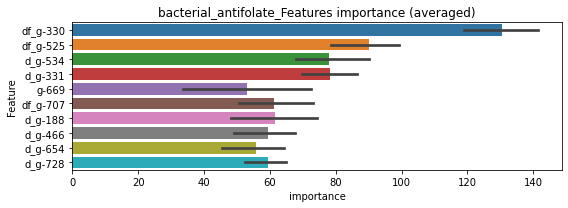

len(train_index) : 3893
len(valid_index) : 3894
================================= fold 1/2 bacterial_antifolate=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191423	valid_1's binary_logloss: 0.0377625
[200]	training's binary_logloss: 0.00283685	valid_1's binary_logloss: 0.0166754
[300]	training's binary_logloss: 0.000748925	valid_1's binary_logloss: 0.0130447
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.000701818	valid_1's binary_logloss: 0.0129351


len(train_index) : 3894
len(valid_index) : 3893
================================= fold 2/2 bacterial_antifolate=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189143	valid_1's binary_logloss: 0.0315088
[200]	training's binary_logloss: 0.00278171	valid_1's binary_logloss: 0.0109522
[300]	training's binary_logloss: 0.000758164	valid_1's binary_logloss: 0.00726731
[400]	training's binary_logloss: 0.000362262	valid_1's binary_logloss: 0.00644183
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000353115	valid_1's binary_logloss: 0.00641311


bacterial_antifolate logloss: 0.009674536570469662


neg labels: 3289 → selected neg labels: 3259


bacterial_cell_wall_synthesis_inhibitor, len(trt): 192, len(othr): 3259, target_rate: 0.0080625 → Adj_target_rate: 0.0073283
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0819197	valid_1's binary_logloss: 0.248634
[200]	training's binary_logloss: 0.0251928	valid_1's binary_logloss: 0.217997
Early stopping, best iteration is:
[219]	training's binary_logloss: 0.0208106	valid_1's binary_logloss: 0.216576
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0943844	valid_1's binary_logloss: 0.226816
[200]	training's binary_logloss: 0.0320125	valid_1's binary_logloss: 0.188741
Early stopping, best iteration is:
[254]	training's binary_logloss: 0.0180332	valid_1's binary_logloss: 0.183365


1 / 3 AUC score:0.933
y_Threshold: 0.0685741, Threshold: 0.1024609, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 359 → Positive_corect_labels: 537/3551
p_label_rate: 0.0200904 Vs.target_rate: 0.00806
Num_p_label: 80.0, conf_0:0.09221, conf_1:0.11271
threshold: 0.1024609, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 537.0/3551, y_label_rate: 0.1512250
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.068143	valid_1's binary_logloss: 0.178273
[200]	training's binary_logloss: 0.0175011	valid_1's binary_logloss: 0.137322
Early stopping, best iteration is:
[257]	training's binary_logloss: 0.00893054	valid_1's binary_logloss: 0.132422
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0652931	valid_1's binary_logloss: 0.181087
[200]	training's binary_logloss: 0.0172023	valid_1's binary_logloss: 0.131574
[300]	training's binary_logloss: 0.00536521	valid_1's binary_logloss: 0.118113
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.00430514	valid_1's binary_logloss: 0.116633


2 / 3 AUC score:0.978
y_Threshold: 0.0624768, Threshold: 0.1024609, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 108 → Positive_corect_labels: 483.0/3443
p_label_rate: 0.0107986 Vs.target_rate: 0.00806
Num_p_label: 43.0, conf_0:0.09221, conf_1:0.11271
threshold: 0.1024609, positive_p_label: 43.0/3982, p_label_rate: 0.0107986
positive_y_label: 483.0/3443, y_label_rate: 0.1402846
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0586097	valid_1's binary_logloss: 0.151724
[200]	training's binary_logloss: 0.0138716	valid_1's binary_logloss: 0.109788
Early stopping, best iteration is:
[273]	training's binary_logloss: 0.00563061	valid_1's binary_logloss: 0.102512
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0594492	valid_1's binary_logloss: 0.154185
[200]	training's binary_logloss: 0.0138692	valid_1's binary_logloss: 0.121516
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.0084765	valid_1's binary_logloss: 0.118849


3 / 3 AUC score:0.978
y_Threshold: 0.0729419, Threshold: 0.1024609, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 90 → Positive_corect_labels: 438.0/3353
p_label_rate: 0.0180814 Vs.target_rate: 0.00806
Num_p_label: 72.0, conf_0:0.09221, conf_1:0.11271
threshold: 0.1024609, positive_p_label: 72.0/3982, p_label_rate: 0.0180814
positive_y_label: 510.0/7335, y_label_rate: 0.0695297


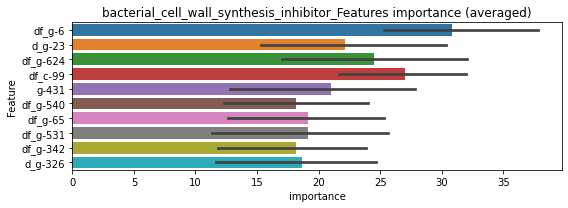

len(train_index) : 3667
len(valid_index) : 3668
================================= fold 1/2 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0332964	valid_1's binary_logloss: 0.0901976
[200]	training's binary_logloss: 0.00808918	valid_1's binary_logloss: 0.0683337
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.00547808	valid_1's binary_logloss: 0.06727


len(train_index) : 3668
len(valid_index) : 3667
================================= fold 2/2 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0318233	valid_1's binary_logloss: 0.101393
[200]	training's binary_logloss: 0.00733782	valid_1's binary_logloss: 0.085457
Early stopping, best iteration is:
[206]	training's binary_logloss: 0.00678726	valid_1's binary_logloss: 0.0853145


bacterial_cell_wall_synthesis_inhibitor logloss: 0.07629104559859567


neg labels: 3289 → selected neg labels: 3274


bacterial_dna_gyrase_inhibitor, len(trt): 89, len(othr): 3274, target_rate: 0.0037373 → Adj_target_rate: 0.0038122
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0553154	valid_1's binary_logloss: 0.133951
[200]	training's binary_logloss: 0.0118339	valid_1's binary_logloss: 0.0907541
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.00793753	valid_1's binary_logloss: 0.0864194
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0608732	valid_1's binary_logloss: 0.128593
[200]	training's binary_logloss: 0.0145487	valid_1's binary_logloss: 0.0766544
[300]	training's binary_logloss: 0.00425948	valid_1's binary_logloss: 0.0588748
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00217249	valid_1's binary_logloss: 0.0551134


1 / 3 AUC score:0.990
y_Threshold: 0.0325540, Threshold: 0.0411286, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 174 → Positive_corect_labels: 633/3754
p_label_rate: 0.0200904 Vs.target_rate: 0.00374
Num_p_label: 80.0, conf_0:0.03702, conf_1:0.04524
Num_p_label: 80.0, Expected: 14.9, Adj_threshold_1: 0.0411286
Num_p_label: 40.0, Expected: 14.9, Adj_threshold_2: 0.0511286
Num_p_label: 27.0, Expected: 14.9, Adj_threshold_3: 0.0611286
threshold: 0.0611286, positive_p_label: 27.0/3982, p_label_rate: 0.0067805
positive_y_label: 633.0/3754, y_label_rate: 0.1686201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0543072	valid_1's binary_logloss: 0.119181
[200]	training's binary_logloss: 0.0110428	valid_1's binary_logloss: 0.0696612
[300]	training's binary_logloss: 0.0032676	valid_1's binary_logloss: 0.0581166
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.002822	valid_1's binary_logloss: 0.0572138
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0536035	valid_1's binary_logloss: 0.124965
[200]	training's binary_logloss: 0.0116008	valid_1's binary_logloss: 0.0769927
[300]	training's binary_logloss: 0.00350349	valid_1's binary_logloss: 0.0676169
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.00183242	valid_1's binary_logloss: 0.0651344


2 / 3 AUC score:0.993
y_Threshold: 0.0467956, Threshold: 0.0611286, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 52 → Positive_corect_labels: 607.0/3702
p_label_rate: 0.0087896 Vs.target_rate: 0.00374
Num_p_label: 35.0, conf_0:0.05502, conf_1:0.06724
threshold: 0.0611286, positive_p_label: 35.0/3982, p_label_rate: 0.0087896
positive_y_label: 607.0/3702, y_label_rate: 0.1639654
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0490181	valid_1's binary_logloss: 0.11864
[200]	training's binary_logloss: 0.00948251	valid_1's binary_logloss: 0.0700441
[300]	training's binary_logloss: 0.00288093	valid_1's binary_logloss: 0.0594208
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00250736	valid_1's binary_logloss: 0.0582314
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0512707	valid_1's binary_logloss: 0.109501
[200]	training's binary_logloss: 0.0104929	valid_1's binary_logloss: 0.0621359
Early stopping, best iteration is:
[279]	training's binary_logloss: 0.00386293	valid_1's binary_logloss: 0.0540574


3 / 3 AUC score:0.995
y_Threshold: 0.0555279, Threshold: 0.0611286, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 46 → Positive_corect_labels: 584.0/3656
p_label_rate: 0.0123054 Vs.target_rate: 0.00374
Num_p_label: 49.0, conf_0:0.05502, conf_1:0.06724
Num_p_label: 49.0, Expected: 14.9, Adj_threshold_1: 0.0611286
Num_p_label: 41.0, Expected: 14.9, Adj_threshold_2: 0.0711286
Num_p_label: 32.0, Expected: 14.9, Adj_threshold_3: 0.0811286
Num_p_label: 26.0, Expected: 14.9, Adj_threshold_4: 0.0911286
threshold: 0.0911286, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 610.0/7638, y_label_rate: 0.0798638


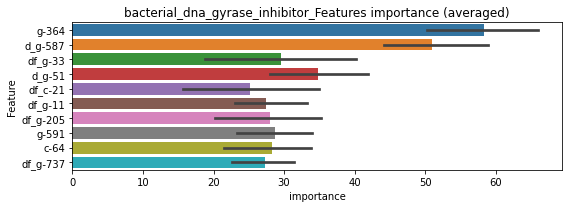

len(train_index) : 3819
len(valid_index) : 3819
================================= fold 1/2 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270489	valid_1's binary_logloss: 0.0796051
[200]	training's binary_logloss: 0.00526126	valid_1's binary_logloss: 0.0561393
Early stopping, best iteration is:
[247]	training's binary_logloss: 0.00276616	valid_1's binary_logloss: 0.0533138


len(train_index) : 3819
len(valid_index) : 3819
================================= fold 2/2 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274661	valid_1's binary_logloss: 0.0589424
[200]	training's binary_logloss: 0.00586649	valid_1's binary_logloss: 0.0354442
[300]	training's binary_logloss: 0.00172522	valid_1's binary_logloss: 0.0309357
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00141703	valid_1's binary_logloss: 0.0304125


bacterial_dna_gyrase_inhibitor logloss: 0.04186314675365732


neg labels: 3289 → selected neg labels: 3271


bacterial_dna_inhibitor, len(trt): 115, len(othr): 3271, target_rate: 0.0048291 → Adj_target_rate: 0.0047401
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0689848	valid_1's binary_logloss: 0.159199
[200]	training's binary_logloss: 0.0181782	valid_1's binary_logloss: 0.110277
[300]	training's binary_logloss: 0.00555395	valid_1's binary_logloss: 0.0984322
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00426376	valid_1's binary_logloss: 0.0973441
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0695374	valid_1's binary_logloss: 0.15302
[200]	training's binary_logloss: 0.0187481	valid_1's binary_logloss: 0.0961721
[300]	training's binary_logloss: 0.00580144	valid_1's binary_logloss: 0.0772922
[400]	training's binary_logloss: 0.00250321	valid_1's binary_logloss: 0.071099
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.00168013	valid_1's binary_logloss: 0.0692867


1 / 3 AUC score:0.990
y_Threshold: 0.0233806, Threshold: 0.0313470, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 181 → Positive_corect_labels: 629/3744
p_label_rate: 0.0200904 Vs.target_rate: 0.00483
Num_p_label: 80.0, conf_0:0.02821, conf_1:0.03448
Num_p_label: 80.0, Expected: 19.2, Adj_threshold_1: 0.0313470
Num_p_label: 60.0, Expected: 19.2, Adj_threshold_2: 0.0413470
Num_p_label: 35.0, Expected: 19.2, Adj_threshold_3: 0.0513470
threshold: 0.0513470, positive_p_label: 35.0/3982, p_label_rate: 0.0087896
positive_y_label: 629.0/3744, y_label_rate: 0.1680021
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0629462	valid_1's binary_logloss: 0.139871
[200]	training's binary_logloss: 0.014312	valid_1's binary_logloss: 0.0875674
[300]	training's binary_logloss: 0.00447426	valid_1's binary_logloss: 0.0717781
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.00234184	valid_1's binary_logloss: 0.0671826
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.06208	valid_1's binary_logloss: 0.136497
[200]	training's binary_logloss: 0.0152969	valid_1's binary_logloss: 0.0858391
[300]	training's binary_logloss: 0.00480411	valid_1's binary_logloss: 0.0710187
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.00255248	valid_1's binary_logloss: 0.0683873


2 / 3 AUC score:0.994
y_Threshold: 0.0489617, Threshold: 0.0513470, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 56 → Positive_corect_labels: 601.0/3688
p_label_rate: 0.0100452 Vs.target_rate: 0.00483
Num_p_label: 40.0, conf_0:0.04621, conf_1:0.05648
threshold: 0.0513470, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 601.0/3688, y_label_rate: 0.1629610
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0555729	valid_1's binary_logloss: 0.123058
[200]	training's binary_logloss: 0.0126171	valid_1's binary_logloss: 0.07394
[300]	training's binary_logloss: 0.00376119	valid_1's binary_logloss: 0.0628047
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.00307002	valid_1's binary_logloss: 0.0622489
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0576811	valid_1's binary_logloss: 0.135813
[200]	training's binary_logloss: 0.0139932	valid_1's binary_logloss: 0.0886073
[300]	training's binary_logloss: 0.00426446	valid_1's binary_logloss: 0.0738982
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.00269194	valid_1's binary_logloss: 0.0711762


3 / 3 AUC score:0.994
y_Threshold: 0.0552376, Threshold: 0.0513470, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 50 → Positive_corect_labels: 576.0/3638
p_label_rate: 0.0133099 Vs.target_rate: 0.00483
Num_p_label: 53.0, conf_0:0.04621, conf_1:0.05648
threshold: 0.0513470, positive_p_label: 53.0/3982, p_label_rate: 0.0133099
positive_y_label: 629.0/7620, y_label_rate: 0.0825459


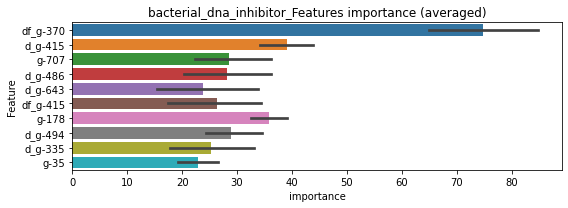

len(train_index) : 3810
len(valid_index) : 3810
================================= fold 1/2 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0324864	valid_1's binary_logloss: 0.0853514
[200]	training's binary_logloss: 0.00788607	valid_1's binary_logloss: 0.0621635
[300]	training's binary_logloss: 0.00238685	valid_1's binary_logloss: 0.0589925
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00251051	valid_1's binary_logloss: 0.0589313


len(train_index) : 3810
len(valid_index) : 3810
================================= fold 2/2 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0352421	valid_1's binary_logloss: 0.0858061
[200]	training's binary_logloss: 0.00877153	valid_1's binary_logloss: 0.0593282
[300]	training's binary_logloss: 0.00260867	valid_1's binary_logloss: 0.0526793
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.00252878	valid_1's binary_logloss: 0.0526184


bacterial_dna_inhibitor logloss: 0.05577483206153094


neg labels: 3289 → selected neg labels: 3285


bacterial_membrane_integrity_inhibitor, len(trt): 19, len(othr): 3285, target_rate: 0.0007979 → Adj_target_rate: 0.0010260
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0236468	valid_1's binary_logloss: 0.0331913
[200]	training's binary_logloss: 0.00272383	valid_1's binary_logloss: 0.00628219
[300]	training's binary_logloss: 0.000743284	valid_1's binary_logloss: 0.00276025
[400]	training's binary_logloss: 0.000388316	valid_1's binary_logloss: 0.00198032
Early stopping, best iteration is:
[473]	training's binary_logloss: 0.000324073	valid_1's binary_logloss: 0.00180399
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0236016	valid_1's binary_logloss: 0.0296343
[200]	training's binary_logloss: 0.00269471	valid_1's binary_logloss: 0.00442056
[300]	training's binary_logloss: 0.000751398	valid_1's binary_logloss: 0.00151442
[400]	training's binary_logloss: 0.000397233	valid_1's binary_logloss: 0.000924556
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000326697	valid_1's binary_logloss: 0.0007

1 / 3 AUC score:1.000
y_Threshold: 0.0014008, Threshold: 0.0027236, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00080
Num_p_label: 80.0, conf_0:0.00245, conf_1:0.00300
Num_p_label: 80.0, Expected: 3.2, Adj_threshold_1: 0.0027236
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_2: 0.0127236
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_3: 0.0227236
Num_p_label: 5.0, Expected: 3.2, Adj_threshold_4: 0.0327236
threshold: 0.0327236, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023244	valid_1's binary_logloss: 0.0322845
[200]	training's binary_logloss: 0.00259181	valid_1's binary_logloss: 0.0055518
[300]	training's binary_logloss: 0.000711102	valid_1's binary_logloss: 0.00236676
[400]	training's binary_logloss: 0.000375148	valid_1's binary_logloss: 0.00166008
Early stopping, best iteration is:
[473]	training's binary_logloss: 0.00031296	valid_1's binary_logloss: 0.00153788
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233796	valid_1's binary_logloss: 0.0285006
[200]	training's binary_logloss: 0.00263021	valid_1's binary_logloss: 0.00377394
[300]	training's binary_logloss: 0.000725606	valid_1's binary_logloss: 0.00116129
[400]	training's binary_logloss: 0.000387446	valid_1's binary_logloss: 0.000665598
[500]	training's binary_logloss: 0.000323841	valid_1's binary_logloss: 0.000563959
Early stopping, best iteration i

2 / 3 AUC score:1.000
y_Threshold: 0.0959718, Threshold: 0.0327236, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0055249 Vs.target_rate: 0.00080
Num_p_label: 22.0, conf_0:0.02945, conf_1:0.03600
Num_p_label: 22.0, Expected: 3.2, Adj_threshold_1: 0.0327236
Num_p_label: 20.0, Expected: 3.2, Adj_threshold_2: 0.0427236
Num_p_label: 16.0, Expected: 3.2, Adj_threshold_3: 0.0527236
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_4: 0.0627236
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_5: 0.0727236
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_6: 0.0827236
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_7: 0.0927236
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_8: 0.1027236
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_9: 0.1127236
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_10: 0.1227236
threshold: 0.1327236, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
==========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023244	valid_1's binary_logloss: 0.0322845
[200]	training's binary_logloss: 0.00259181	valid_1's binary_logloss: 0.0055518
[300]	training's binary_logloss: 0.000711102	valid_1's binary_logloss: 0.00236676
[400]	training's binary_logloss: 0.000375148	valid_1's binary_logloss: 0.00166008
Early stopping, best iteration is:
[473]	training's binary_logloss: 0.00031296	valid_1's binary_logloss: 0.00153788
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233796	valid_1's binary_logloss: 0.0285006
[200]	training's binary_logloss: 0.00263021	valid_1's binary_logloss: 0.00377394
[300]	training's binary_logloss: 0.000725606	valid_1's binary_logloss: 0.00116129
[400]	training's binary_logloss: 0.000387446	valid_1's binary_logloss: 0.000665598
[500]	training's binary_logloss: 0.000323841	valid_1's binary_logloss: 0.000563959
Early stopping, best iteration i

3 / 3 AUC score:1.000
y_Threshold: 0.0959718, Threshold: 0.1327236, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0022602 Vs.target_rate: 0.00080
Num_p_label: 9.0, conf_0:0.11945, conf_1:0.14600
threshold: 0.1327236, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 666.0/7792, y_label_rate: 0.0854723


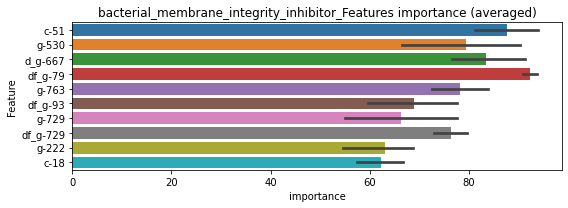

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.012468	valid_1's binary_logloss: 0.0185799
[200]	training's binary_logloss: 0.00141925	valid_1's binary_logloss: 0.00631006
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.000495647	valid_1's binary_logloss: 0.00532001


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0128517	valid_1's binary_logloss: 0.01995
[200]	training's binary_logloss: 0.00152296	valid_1's binary_logloss: 0.00624008
[300]	training's binary_logloss: 0.000433574	valid_1's binary_logloss: 0.00418484
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.00026974	valid_1's binary_logloss: 0.00378373


bacterial_membrane_integrity_inhibitor logloss: 0.004551871617460978


neg labels: 3289 → selected neg labels: 3283


bcl_inhibitor, len(trt): 31, len(othr): 3283, target_rate: 0.0013018 → Adj_target_rate: 0.0015554
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286763	valid_1's binary_logloss: 0.0426808
[200]	training's binary_logloss: 0.00382623	valid_1's binary_logloss: 0.0101117
[300]	training's binary_logloss: 0.00109231	valid_1's binary_logloss: 0.00442754
[400]	training's binary_logloss: 0.000553826	valid_1's binary_logloss: 0.00302008
[500]	training's binary_logloss: 0.000403343	valid_1's binary_logloss: 0.00251962
Early stopping, best iteration is:
[582]	training's binary_logloss: 0.000390341	valid_1's binary_logloss: 0.00246894
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285469	valid_1's binary_logloss: 0.0453828
[200]	training's binary_logloss: 0.00379814	valid_1's binary_logloss: 0.012509
[300]	training's binary_logloss: 0.00108612	valid_1's binary_logloss: 0.00765142
[400]	training's binary_logloss: 0.000545163	valid_1's binary_logloss: 0.00641046
Early stopping, best iteration is:
[

1 / 3 AUC score:1.000
y_Threshold: 0.0033802, Threshold: 0.0872681, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00130
Num_p_label: 80.0, conf_0:0.07854, conf_1:0.09599
Num_p_label: 80.0, Expected: 5.2, Adj_threshold_1: 0.0872681
Num_p_label: 74.0, Expected: 5.2, Adj_threshold_2: 0.0972681
Num_p_label: 71.0, Expected: 5.2, Adj_threshold_3: 0.1072681
Num_p_label: 62.0, Expected: 5.2, Adj_threshold_4: 0.1172681
Num_p_label: 60.0, Expected: 5.2, Adj_threshold_5: 0.1272681
Num_p_label: 57.0, Expected: 5.2, Adj_threshold_6: 0.1372681
Num_p_label: 56.0, Expected: 5.2, Adj_threshold_7: 0.1472681
Num_p_label: 53.0, Expected: 5.2, Adj_threshold_8: 0.1572681
Num_p_label: 50.0, Expected: 5.2, Adj_threshold_9: 0.1672681
Num_p_label: 50.0, Expected: 5.2, Adj_threshold_10: 0.1772681
threshold: 0.1872681, positive_p_label: 49.0/3982, p_label_rate: 0.0123054
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0273598	valid_1's binary_logloss: 0.040104
[200]	training's binary_logloss: 0.00348473	valid_1's binary_logloss: 0.00794883
[300]	training's binary_logloss: 0.000985517	valid_1's binary_logloss: 0.00306351
[400]	training's binary_logloss: 0.000505534	valid_1's binary_logloss: 0.00189183
[500]	training's binary_logloss: 0.000380145	valid_1's binary_logloss: 0.00155994
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00036625	valid_1's binary_logloss: 0.00152612
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0273387	valid_1's binary_logloss: 0.0393506
[200]	training's binary_logloss: 0.00348287	valid_1's binary_logloss: 0.00785234
[300]	training's binary_logloss: 0.000990487	valid_1's binary_logloss: 0.00342709
[400]	training's binary_logloss: 0.000502724	valid_1's binary_logloss: 0.00226215
[500]	training's binary_logloss: 

2 / 3 AUC score:1.000
y_Threshold: 0.6501663, Threshold: 0.1872681, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0351582 Vs.target_rate: 0.00130
Num_p_label: 140.0, conf_0:0.16854, conf_1:0.20599
Num_p_label: 140.0, Expected: 5.2, Adj_threshold_1: 0.1872681
Num_p_label: 139.0, Expected: 5.2, Adj_threshold_2: 0.1972681
Num_p_label: 138.0, Expected: 5.2, Adj_threshold_3: 0.2072681
Num_p_label: 135.0, Expected: 5.2, Adj_threshold_4: 0.2172681
Num_p_label: 132.0, Expected: 5.2, Adj_threshold_5: 0.2272681
Num_p_label: 129.0, Expected: 5.2, Adj_threshold_6: 0.2372681
Num_p_label: 128.0, Expected: 5.2, Adj_threshold_7: 0.2472681
Num_p_label: 127.0, Expected: 5.2, Adj_threshold_8: 0.2572681
Num_p_label: 126.0, Expected: 5.2, Adj_threshold_9: 0.2672681
Num_p_label: 123.0, Expected: 5.2, Adj_threshold_10: 0.2772681
threshold: 0.2872681, positive_p_label: 122.0/3982, p_label_rate: 0.0306379
positive_y_label: 656.0/3807, y_label_rate: 0.17231

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0273598	valid_1's binary_logloss: 0.040104
[200]	training's binary_logloss: 0.00348473	valid_1's binary_logloss: 0.00794883
[300]	training's binary_logloss: 0.000985517	valid_1's binary_logloss: 0.00306351
[400]	training's binary_logloss: 0.000505534	valid_1's binary_logloss: 0.00189183
[500]	training's binary_logloss: 0.000380145	valid_1's binary_logloss: 0.00155994
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00036625	valid_1's binary_logloss: 0.00152612
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0273387	valid_1's binary_logloss: 0.0393506
[200]	training's binary_logloss: 0.00348287	valid_1's binary_logloss: 0.00785234
[300]	training's binary_logloss: 0.000990487	valid_1's binary_logloss: 0.00342709
[400]	training's binary_logloss: 0.000502724	valid_1's binary_logloss: 0.00226215
[500]	training's binary_logloss: 

3 / 3 AUC score:1.000
y_Threshold: 0.6501663, Threshold: 0.2872681, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0306379 Vs.target_rate: 0.00130
Num_p_label: 122.0, conf_0:0.25854, conf_1:0.31599
Num_p_label: 122.0, Expected: 5.2, Adj_threshold_1: 0.2872681
Num_p_label: 120.0, Expected: 5.2, Adj_threshold_2: 0.2972681
Num_p_label: 120.0, Expected: 5.2, Adj_threshold_3: 0.3072681
Num_p_label: 120.0, Expected: 5.2, Adj_threshold_4: 0.3172681
Num_p_label: 120.0, Expected: 5.2, Adj_threshold_5: 0.3272681
Num_p_label: 118.0, Expected: 5.2, Adj_threshold_6: 0.3372681
Num_p_label: 118.0, Expected: 5.2, Adj_threshold_7: 0.3472681
Num_p_label: 118.0, Expected: 5.2, Adj_threshold_8: 0.3572681
Num_p_label: 117.0, Expected: 5.2, Adj_threshold_9: 0.3672681
Num_p_label: 117.0, Expected: 5.2, Adj_threshold_10: 0.3772681
threshold: 0.3872681, positive_p_label: 115.0/3982, p_label_rate: 0.0288800
positive_y_label: 771.0/7789, y_label_rate: 0.09898

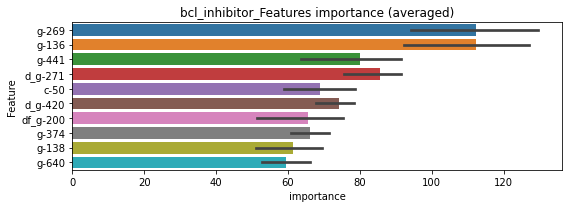

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 bcl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184903	valid_1's binary_logloss: 0.0336806
[200]	training's binary_logloss: 0.00259102	valid_1's binary_logloss: 0.0121708
[300]	training's binary_logloss: 0.000708039	valid_1's binary_logloss: 0.00802368
[400]	training's binary_logloss: 0.000348115	valid_1's binary_logloss: 0.00719369
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.000334933	valid_1's binary_logloss: 0.00715189


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 bcl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0176594	valid_1's binary_logloss: 0.0348077
[200]	training's binary_logloss: 0.00250001	valid_1's binary_logloss: 0.0136284
[300]	training's binary_logloss: 0.000689161	valid_1's binary_logloss: 0.0100764
Early stopping, best iteration is:
[358]	training's binary_logloss: 0.000422204	valid_1's binary_logloss: 0.00941882


bcl_inhibitor logloss: 0.008285206303804428


neg labels: 3289 → selected neg labels: 3283


bcr-abl_inhibitor, len(trt): 38, len(othr): 3283, target_rate: 0.0015957 → Adj_target_rate: 0.0018493
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0333133	valid_1's binary_logloss: 0.0514743
[200]	training's binary_logloss: 0.00511859	valid_1's binary_logloss: 0.0143104
[300]	training's binary_logloss: 0.00142295	valid_1's binary_logloss: 0.00646692
[400]	training's binary_logloss: 0.000692859	valid_1's binary_logloss: 0.00429417
[500]	training's binary_logloss: 0.000469669	valid_1's binary_logloss: 0.00353176
Early stopping, best iteration is:
[544]	training's binary_logloss: 0.000440534	valid_1's binary_logloss: 0.00341711
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0331796	valid_1's binary_logloss: 0.0568217
[200]	training's binary_logloss: 0.00483691	valid_1's binary_logloss: 0.0162227
[300]	training's binary_logloss: 0.00134622	valid_1's binary_logloss: 0.0084593
[400]	training's binary_logloss: 0.000658313	valid_1's binary_logloss: 0.00620183
[500]	training's binary_logloss: 0.0

1 / 3 AUC score:1.000
y_Threshold: 0.0037617, Threshold: 0.0077481, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00160
Num_p_label: 80.0, conf_0:0.00697, conf_1:0.00852
Num_p_label: 80.0, Expected: 6.4, Adj_threshold_1: 0.0077481
Num_p_label: 40.0, Expected: 6.4, Adj_threshold_2: 0.0177481
Num_p_label: 27.0, Expected: 6.4, Adj_threshold_3: 0.0277481
Num_p_label: 21.0, Expected: 6.4, Adj_threshold_4: 0.0377481
Num_p_label: 19.0, Expected: 6.4, Adj_threshold_5: 0.0477481
Num_p_label: 14.0, Expected: 6.4, Adj_threshold_6: 0.0577481
Num_p_label: 9.0, Expected: 6.4, Adj_threshold_7: 0.0677481
threshold: 0.0677481, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309024	valid_1's binary_logloss: 0.0471198
[200]	training's binary_logloss: 0.0044613	valid_1's binary_logloss: 0.0120985
[300]	training's binary_logloss: 0.00126544	valid_1's binary_logloss: 0.00545726
[400]	training's binary_logloss: 0.00063593	valid_1's binary_logloss: 0.00364612
[500]	training's binary_logloss: 0.000447416	valid_1's binary_logloss: 0.00305083
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.000424981	valid_1's binary_logloss: 0.00299959
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0308877	valid_1's binary_logloss: 0.0506574
[200]	training's binary_logloss: 0.00439041	valid_1's binary_logloss: 0.0133188
[300]	training's binary_logloss: 0.00125393	valid_1's binary_logloss: 0.00625002
[400]	training's binary_logloss: 0.000629217	valid_1's binary_logloss: 0.00452932
Early stopping, best iteration is:
[4

2 / 3 AUC score:1.000
y_Threshold: 0.0948844, Threshold: 0.0677481, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0090407 Vs.target_rate: 0.00160
Num_p_label: 36.0, conf_0:0.06097, conf_1:0.07452
Num_p_label: 36.0, Expected: 6.4, Adj_threshold_1: 0.0677481
Num_p_label: 32.0, Expected: 6.4, Adj_threshold_2: 0.0777481
Num_p_label: 30.0, Expected: 6.4, Adj_threshold_3: 0.0877481
Num_p_label: 30.0, Expected: 6.4, Adj_threshold_4: 0.0977481
Num_p_label: 29.0, Expected: 6.4, Adj_threshold_5: 0.1077481
Num_p_label: 26.0, Expected: 6.4, Adj_threshold_6: 0.1177481
Num_p_label: 22.0, Expected: 6.4, Adj_threshold_7: 0.1277481
Num_p_label: 20.0, Expected: 6.4, Adj_threshold_8: 0.1377481
Num_p_label: 17.0, Expected: 6.4, Adj_threshold_9: 0.1477481
Num_p_label: 15.0, Expected: 6.4, Adj_threshold_10: 0.1577481
threshold: 0.1677481, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309024	valid_1's binary_logloss: 0.0471198
[200]	training's binary_logloss: 0.0044613	valid_1's binary_logloss: 0.0120985
[300]	training's binary_logloss: 0.00126544	valid_1's binary_logloss: 0.00545726
[400]	training's binary_logloss: 0.00063593	valid_1's binary_logloss: 0.00364612
[500]	training's binary_logloss: 0.000447416	valid_1's binary_logloss: 0.00305083
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.000424981	valid_1's binary_logloss: 0.00299959
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0308877	valid_1's binary_logloss: 0.0506574
[200]	training's binary_logloss: 0.00439041	valid_1's binary_logloss: 0.0133188
[300]	training's binary_logloss: 0.00125393	valid_1's binary_logloss: 0.00625002
[400]	training's binary_logloss: 0.000629217	valid_1's binary_logloss: 0.00452932
Early stopping, best iteration is:
[4

3 / 3 AUC score:1.000
y_Threshold: 0.0948844, Threshold: 0.1677481, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0037670 Vs.target_rate: 0.00160
Num_p_label: 15.0, conf_0:0.15097, conf_1:0.18452
threshold: 0.1677481, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 671.0/7789, y_label_rate: 0.0861471


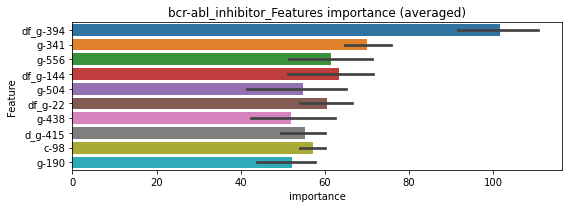

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0175659	valid_1's binary_logloss: 0.0354904
[200]	training's binary_logloss: 0.00258147	valid_1's binary_logloss: 0.0162144
Early stopping, best iteration is:
[273]	training's binary_logloss: 0.00092735	valid_1's binary_logloss: 0.0132777


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183107	valid_1's binary_logloss: 0.0298242
[200]	training's binary_logloss: 0.00265487	valid_1's binary_logloss: 0.00901076
[300]	training's binary_logloss: 0.000757946	valid_1's binary_logloss: 0.00489552
[400]	training's binary_logloss: 0.00036785	valid_1's binary_logloss: 0.00384373
[500]	training's binary_logloss: 0.000252543	valid_1's binary_logloss: 0.00357092
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000246564	valid_1's binary_logloss: 0.00354656


bcr-abl_inhibitor logloss: 0.008412775198366428


neg labels: 3289 → selected neg labels: 3277


benzodiazepine_receptor_agonist, len(trt): 67, len(othr): 3277, target_rate: 0.0028135 → Adj_target_rate: 0.0029948
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0539193	valid_1's binary_logloss: 0.109791
[200]	training's binary_logloss: 0.0112375	valid_1's binary_logloss: 0.0555857
[300]	training's binary_logloss: 0.00312198	valid_1's binary_logloss: 0.0415019
[400]	training's binary_logloss: 0.00137413	valid_1's binary_logloss: 0.0378999
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00141825	valid_1's binary_logloss: 0.0377951
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0540006	valid_1's binary_logloss: 0.104812
[200]	training's binary_logloss: 0.01104	valid_1's binary_logloss: 0.0508936
[300]	training's binary_logloss: 0.00299684	valid_1's binary_logloss: 0.0363131
[400]	training's binary_logloss: 0.00134538	valid_1's binary_logloss: 0.0321888
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00104603	valid_1's binary_logloss: 0.0318239


1 / 3 AUC score:0.999
y_Threshold: 0.0125870, Threshold: 0.0213503, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 140 → Positive_corect_labels: 651/3792
p_label_rate: 0.0200904 Vs.target_rate: 0.00281
Num_p_label: 80.0, conf_0:0.01922, conf_1:0.02349
Num_p_label: 80.0, Expected: 11.2, Adj_threshold_1: 0.0213503
Num_p_label: 41.0, Expected: 11.2, Adj_threshold_2: 0.0313503
Num_p_label: 25.0, Expected: 11.2, Adj_threshold_3: 0.0413503
Num_p_label: 20.0, Expected: 11.2, Adj_threshold_4: 0.0513503
threshold: 0.0513503, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 651.0/3792, y_label_rate: 0.1716772
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0518629	valid_1's binary_logloss: 0.108016
[200]	training's binary_logloss: 0.0102863	valid_1's binary_logloss: 0.0600317
[300]	training's binary_logloss: 0.00292144	valid_1's binary_logloss: 0.0479922
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.00146427	valid_1's binary_logloss: 0.0445747
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0514909	valid_1's binary_logloss: 0.0967359
[200]	training's binary_logloss: 0.00996047	valid_1's binary_logloss: 0.0409123
[300]	training's binary_logloss: 0.0028954	valid_1's binary_logloss: 0.0270285
[400]	training's binary_logloss: 0.00132675	valid_1's binary_logloss: 0.0236199
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.000953351	valid_1's binary_logloss: 0.0225602


2 / 3 AUC score:0.998
y_Threshold: 0.0485829, Threshold: 0.0513503, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 20 → Positive_corect_labels: 641.0/3772
p_label_rate: 0.0092918 Vs.target_rate: 0.00281
Num_p_label: 37.0, conf_0:0.04622, conf_1:0.05649
Num_p_label: 37.0, Expected: 11.2, Adj_threshold_1: 0.0513503
Num_p_label: 29.0, Expected: 11.2, Adj_threshold_2: 0.0613503
Num_p_label: 23.0, Expected: 11.2, Adj_threshold_3: 0.0713503
Num_p_label: 20.0, Expected: 11.2, Adj_threshold_4: 0.0813503
threshold: 0.0813503, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 641.0/3772, y_label_rate: 0.1699364
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0518932	valid_1's binary_logloss: 0.0912665
[200]	training's binary_logloss: 0.0101725	valid_1's binary_logloss: 0.0382355
[300]	training's binary_logloss: 0.00292247	valid_1's binary_logloss: 0.0239995
[400]	training's binary_logloss: 0.00133385	valid_1's binary_logloss: 0.0197356
[500]	training's binary_logloss: 0.000821881	valid_1's binary_logloss: 0.0180599
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.000713063	valid_1's binary_logloss: 0.0174473
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0500445	valid_1's binary_logloss: 0.106078
[200]	training's binary_logloss: 0.00959173	valid_1's binary_logloss: 0.0612524
[300]	training's binary_logloss: 0.00273313	valid_1's binary_logloss: 0.0511482
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.00167206	valid_1's binary_logloss: 0.0501137


3 / 3 AUC score:0.995
y_Threshold: 0.0364661, Threshold: 0.0813503, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 20 → Positive_corect_labels: 631.0/3752
p_label_rate: 0.0050226 Vs.target_rate: 0.00281
Num_p_label: 20.0, conf_0:0.07322, conf_1:0.08949
threshold: 0.0813503, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 651.0/7734, y_label_rate: 0.0841738


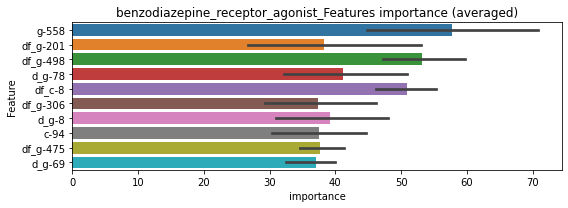

len(train_index) : 3867
len(valid_index) : 3867
================================= fold 1/2 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0291874	valid_1's binary_logloss: 0.0684495
[200]	training's binary_logloss: 0.00514866	valid_1's binary_logloss: 0.0380612
Early stopping, best iteration is:
[266]	training's binary_logloss: 0.00212877	valid_1's binary_logloss: 0.0341114


len(train_index) : 3867
len(valid_index) : 3867
================================= fold 2/2 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0296308	valid_1's binary_logloss: 0.0628872
[200]	training's binary_logloss: 0.00580689	valid_1's binary_logloss: 0.0364093
[300]	training's binary_logloss: 0.00156326	valid_1's binary_logloss: 0.0321313
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.00149802	valid_1's binary_logloss: 0.0319988


benzodiazepine_receptor_agonist logloss: 0.03305510005581472


neg labels: 3289 → selected neg labels: 3285


beta_amyloid_inhibitor, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0288069	valid_1's binary_logloss: 0.0395571
[200]	training's binary_logloss: 0.00391167	valid_1's binary_logloss: 0.0100835
[300]	training's binary_logloss: 0.00108113	valid_1's binary_logloss: 0.00588812
[400]	training's binary_logloss: 0.000540156	valid_1's binary_logloss: 0.00504698
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000458009	valid_1's binary_logloss: 0.0049274
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0291658	valid_1's binary_logloss: 0.049754
[200]	training's binary_logloss: 0.00390845	valid_1's binary_logloss: 0.0130155
[300]	training's binary_logloss: 0.00107351	valid_1's binary_logloss: 0.00760071
[400]	training's binary_logloss: 0.000545172	valid_1's binary_logloss: 0.00652822
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.00042332	valid_1's binary_logloss: 0.00616251


1 / 3 AUC score:1.000
y_Threshold: 0.0023591, Threshold: 0.0039207, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00101
Num_p_label: 80.0, conf_0:0.00353, conf_1:0.00431
Num_p_label: 80.0, Expected: 4.0, Adj_threshold_1: 0.0039207
Num_p_label: 7.0, Expected: 4.0, Adj_threshold_2: 0.0139207
threshold: 0.0139207, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283356	valid_1's binary_logloss: 0.038686
[200]	training's binary_logloss: 0.00370965	valid_1's binary_logloss: 0.00909083
[300]	training's binary_logloss: 0.00105492	valid_1's binary_logloss: 0.00539663
[400]	training's binary_logloss: 0.00053215	valid_1's binary_logloss: 0.00459061
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.000523552	valid_1's binary_logloss: 0.00455921
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028299	valid_1's binary_logloss: 0.0471083
[200]	training's binary_logloss: 0.00367574	valid_1's binary_logloss: 0.0115288
[300]	training's binary_logloss: 0.00102072	valid_1's binary_logloss: 0.0057625
[400]	training's binary_logloss: 0.000526034	valid_1's binary_logloss: 0.00438129
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.000428672	valid_1's binary_logloss: 0.00416654


2 / 3 AUC score:1.000
y_Threshold: 0.0184101, Threshold: 0.0139207, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0052737 Vs.target_rate: 0.00101
Num_p_label: 21.0, conf_0:0.01253, conf_1:0.01531
Num_p_label: 21.0, Expected: 4.0, Adj_threshold_1: 0.0139207
Num_p_label: 8.0, Expected: 4.0, Adj_threshold_2: 0.0239207
threshold: 0.0239207, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283356	valid_1's binary_logloss: 0.038686
[200]	training's binary_logloss: 0.00370965	valid_1's binary_logloss: 0.00909083
[300]	training's binary_logloss: 0.00105492	valid_1's binary_logloss: 0.00539663
[400]	training's binary_logloss: 0.00053215	valid_1's binary_logloss: 0.00459061
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.000523552	valid_1's binary_logloss: 0.00455921
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028299	valid_1's binary_logloss: 0.0471083
[200]	training's binary_logloss: 0.00367574	valid_1's binary_logloss: 0.0115288
[300]	training's binary_logloss: 0.00102072	valid_1's binary_logloss: 0.0057625
[400]	training's binary_logloss: 0.000526034	valid_1's binary_logloss: 0.00438129
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.000428672	valid_1's binary_logloss: 0.00416654


3 / 3 AUC score:1.000
y_Threshold: 0.0184101, Threshold: 0.0239207, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0020090 Vs.target_rate: 0.00101
Num_p_label: 8.0, conf_0:0.02153, conf_1:0.02631
threshold: 0.0239207, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 665.0/7792, y_label_rate: 0.0853439


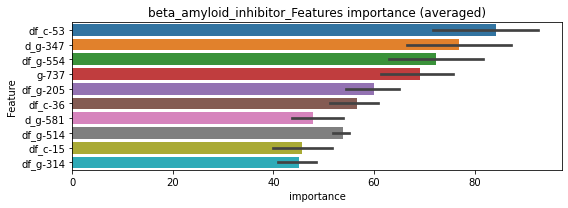

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160399	valid_1's binary_logloss: 0.0315328
[200]	training's binary_logloss: 0.00215667	valid_1's binary_logloss: 0.0130822
[300]	training's binary_logloss: 0.000574755	valid_1's binary_logloss: 0.0105104
Early stopping, best iteration is:
[373]	training's binary_logloss: 0.000324736	valid_1's binary_logloss: 0.0101689


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168211	valid_1's binary_logloss: 0.0248571
[200]	training's binary_logloss: 0.00234698	valid_1's binary_logloss: 0.00732273
[300]	training's binary_logloss: 0.000621779	valid_1's binary_logloss: 0.00478561
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.000321833	valid_1's binary_logloss: 0.00432244


beta_amyloid_inhibitor logloss: 0.00724565849166953


neg labels: 3289 → selected neg labels: 3276


bromodomain_inhibitor, len(trt): 68, len(othr): 3276, target_rate: 0.0028555 → Adj_target_rate: 0.0030327
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0372316	valid_1's binary_logloss: 0.0660927
[200]	training's binary_logloss: 0.00607809	valid_1's binary_logloss: 0.0274076
[300]	training's binary_logloss: 0.00172697	valid_1's binary_logloss: 0.0193532
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.000922712	valid_1's binary_logloss: 0.0179219
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0354655	valid_1's binary_logloss: 0.0797471
[200]	training's binary_logloss: 0.00555276	valid_1's binary_logloss: 0.0453219
[300]	training's binary_logloss: 0.00157848	valid_1's binary_logloss: 0.0397304
Early stopping, best iteration is:
[327]	training's binary_logloss: 0.00124628	valid_1's binary_logloss: 0.0389875


1 / 3 AUC score:0.999
y_Threshold: 0.0067092, Threshold: 0.0105888, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 140 → Positive_corect_labels: 651/3791
p_label_rate: 0.0200904 Vs.target_rate: 0.00286
Num_p_label: 80.0, conf_0:0.00953, conf_1:0.01165
Num_p_label: 80.0, Expected: 11.4, Adj_threshold_1: 0.0105888
Num_p_label: 28.0, Expected: 11.4, Adj_threshold_2: 0.0205888
Num_p_label: 20.0, Expected: 11.4, Adj_threshold_3: 0.0305888
threshold: 0.0305888, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 651.0/3791, y_label_rate: 0.1717225
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0350312	valid_1's binary_logloss: 0.0643317
[200]	training's binary_logloss: 0.00532464	valid_1's binary_logloss: 0.0216162
[300]	training's binary_logloss: 0.00152002	valid_1's binary_logloss: 0.0110927
[400]	training's binary_logloss: 0.000747371	valid_1's binary_logloss: 0.00840316
[500]	training's binary_logloss: 0.00050032	valid_1's binary_logloss: 0.00754544
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00051577	valid_1's binary_logloss: 0.00750814
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0356072	valid_1's binary_logloss: 0.0601405
[200]	training's binary_logloss: 0.00533522	valid_1's binary_logloss: 0.0216843
[300]	training's binary_logloss: 0.00153177	valid_1's binary_logloss: 0.0153297
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.00117125	valid_1's binary_logloss: 0.0149085


2 / 3 AUC score:1.000
y_Threshold: 0.0309684, Threshold: 0.0305888, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 649.0/3787
p_label_rate: 0.0082873 Vs.target_rate: 0.00286
Num_p_label: 33.0, conf_0:0.02753, conf_1:0.03365
threshold: 0.0305888, positive_p_label: 33.0/3982, p_label_rate: 0.0082873
positive_y_label: 649.0/3787, y_label_rate: 0.1713758
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0362184	valid_1's binary_logloss: 0.0635322
[200]	training's binary_logloss: 0.00551301	valid_1's binary_logloss: 0.0189567
[300]	training's binary_logloss: 0.00156648	valid_1's binary_logloss: 0.00921011
[400]	training's binary_logloss: 0.00075998	valid_1's binary_logloss: 0.00631403
[500]	training's binary_logloss: 0.000505126	valid_1's binary_logloss: 0.00533937
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.000477548	valid_1's binary_logloss: 0.00521201
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345545	valid_1's binary_logloss: 0.0670711
[200]	training's binary_logloss: 0.00521853	valid_1's binary_logloss: 0.0281938
[300]	training's binary_logloss: 0.00149328	valid_1's binary_logloss: 0.0206736
[400]	training's binary_logloss: 0.000730993	valid_1's binary_logloss: 0.0180265
Early stopping, best iteration is:
[45

3 / 3 AUC score:1.000
y_Threshold: 0.0340930, Threshold: 0.0305888, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 648.0/3785
p_label_rate: 0.0055249 Vs.target_rate: 0.00286
Num_p_label: 22.0, conf_0:0.02753, conf_1:0.03365
threshold: 0.0305888, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 670.0/7767, y_label_rate: 0.0862624


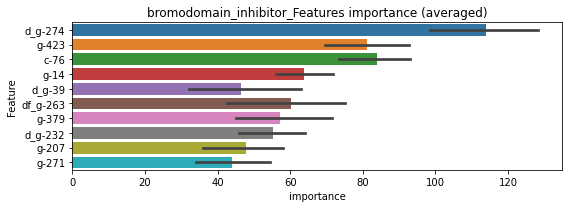

len(train_index) : 3883
len(valid_index) : 3884
================================= fold 1/2 bromodomain_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197489	valid_1's binary_logloss: 0.0435291
[200]	training's binary_logloss: 0.00292357	valid_1's binary_logloss: 0.0228707
[300]	training's binary_logloss: 0.000826796	valid_1's binary_logloss: 0.0189587
[400]	training's binary_logloss: 0.000394459	valid_1's binary_logloss: 0.0175331
Early stopping, best iteration is:
[423]	training's binary_logloss: 0.00034985	valid_1's binary_logloss: 0.0174225


len(train_index) : 3884
len(valid_index) : 3883
================================= fold 2/2 bromodomain_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195071	valid_1's binary_logloss: 0.0408042
[200]	training's binary_logloss: 0.00294948	valid_1's binary_logloss: 0.0206616
[300]	training's binary_logloss: 0.000821911	valid_1's binary_logloss: 0.018146
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.00088473	valid_1's binary_logloss: 0.0180475


bromodomain_inhibitor logloss: 0.01773499347927202


neg labels: 3289 → selected neg labels: 3284


btk_inhibitor, len(trt): 29, len(othr): 3284, target_rate: 0.0012178 → Adj_target_rate: 0.0014697
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0296913	valid_1's binary_logloss: 0.0501232
[200]	training's binary_logloss: 0.00394514	valid_1's binary_logloss: 0.0142455
[300]	training's binary_logloss: 0.00109267	valid_1's binary_logloss: 0.00859706
[400]	training's binary_logloss: 0.000548532	valid_1's binary_logloss: 0.00674913
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.000545707	valid_1's binary_logloss: 0.00673687
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028848	valid_1's binary_logloss: 0.0497995
[200]	training's binary_logloss: 0.00383978	valid_1's binary_logloss: 0.0174636
[300]	training's binary_logloss: 0.00106526	valid_1's binary_logloss: 0.0127948
[400]	training's binary_logloss: 0.000532891	valid_1's binary_logloss: 0.0119505
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.000557539	valid_1's binary_logloss: 0.0119235


1 / 3 AUC score:1.000
y_Threshold: 0.0037505, Threshold: 0.0064825, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → Positive_corect_labels: 653/3802
p_label_rate: 0.0200904 Vs.target_rate: 0.00122
Num_p_label: 80.0, conf_0:0.00583, conf_1:0.00713
Num_p_label: 80.0, Expected: 4.8, Adj_threshold_1: 0.0064825
Num_p_label: 25.0, Expected: 4.8, Adj_threshold_2: 0.0164825
Num_p_label: 14.0, Expected: 4.8, Adj_threshold_3: 0.0264825
Num_p_label: 7.0, Expected: 4.8, Adj_threshold_4: 0.0364825
threshold: 0.0364825, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 653.0/3802, y_label_rate: 0.1717517
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282562	valid_1's binary_logloss: 0.0462113
[200]	training's binary_logloss: 0.00364539	valid_1's binary_logloss: 0.0108656
[300]	training's binary_logloss: 0.00102874	valid_1's binary_logloss: 0.00496966
[400]	training's binary_logloss: 0.000516122	valid_1's binary_logloss: 0.00326914
[500]	training's binary_logloss: 0.000382959	valid_1's binary_logloss: 0.00298656
Early stopping, best iteration is:
[539]	training's binary_logloss: 0.000371672	valid_1's binary_logloss: 0.00295223
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028305	valid_1's binary_logloss: 0.041524
[200]	training's binary_logloss: 0.00376136	valid_1's binary_logloss: 0.00845678
[300]	training's binary_logloss: 0.0010416	valid_1's binary_logloss: 0.00331668
[400]	training's binary_logloss: 0.000527986	valid_1's binary_logloss: 0.00203579
[500]	training's binary_logloss: 0.00

2 / 3 AUC score:1.000
y_Threshold: 0.0796332, Threshold: 0.0364825, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 653.0/3802
p_label_rate: 0.0045203 Vs.target_rate: 0.00122
Num_p_label: 18.0, conf_0:0.03283, conf_1:0.04013
Num_p_label: 18.0, Expected: 4.8, Adj_threshold_1: 0.0364825
Num_p_label: 12.0, Expected: 4.8, Adj_threshold_2: 0.0464825
Num_p_label: 11.0, Expected: 4.8, Adj_threshold_3: 0.0564825
Num_p_label: 6.0, Expected: 4.8, Adj_threshold_4: 0.0664825
threshold: 0.0664825, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 653.0/3802, y_label_rate: 0.1717517
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282562	valid_1's binary_logloss: 0.0462113
[200]	training's binary_logloss: 0.00364539	valid_1's binary_logloss: 0.0108656
[300]	training's binary_logloss: 0.00102874	valid_1's binary_logloss: 0.00496966
[400]	training's binary_logloss: 0.000516122	valid_1's binary_logloss: 0.00326914
[500]	training's binary_logloss: 0.000382959	valid_1's binary_logloss: 0.00298656
Early stopping, best iteration is:
[539]	training's binary_logloss: 0.000371672	valid_1's binary_logloss: 0.00295223
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028305	valid_1's binary_logloss: 0.041524
[200]	training's binary_logloss: 0.00376136	valid_1's binary_logloss: 0.00845678
[300]	training's binary_logloss: 0.0010416	valid_1's binary_logloss: 0.00331668
[400]	training's binary_logloss: 0.000527986	valid_1's binary_logloss: 0.00203579
[500]	training's binary_logloss: 0.00

3 / 3 AUC score:1.000
y_Threshold: 0.0796332, Threshold: 0.0664825, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 653.0/3802
p_label_rate: 0.0015068 Vs.target_rate: 0.00122
Num_p_label: 6.0, conf_0:0.05983, conf_1:0.07313
threshold: 0.0664825, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 659.0/7784, y_label_rate: 0.0846608


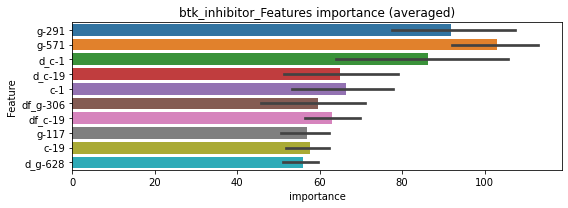

len(train_index) : 3892
len(valid_index) : 3892
================================= fold 1/2 btk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156877	valid_1's binary_logloss: 0.0321445
[200]	training's binary_logloss: 0.00207539	valid_1's binary_logloss: 0.0165363
[300]	training's binary_logloss: 0.000534476	valid_1's binary_logloss: 0.0121435
[400]	training's binary_logloss: 0.000262044	valid_1's binary_logloss: 0.0111777
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.000258142	valid_1's binary_logloss: 0.01115


len(train_index) : 3892
len(valid_index) : 3892
================================= fold 2/2 btk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164413	valid_1's binary_logloss: 0.0235309
[200]	training's binary_logloss: 0.00214701	valid_1's binary_logloss: 0.00569744
[300]	training's binary_logloss: 0.000582193	valid_1's binary_logloss: 0.00329957
[400]	training's binary_logloss: 0.0002869	valid_1's binary_logloss: 0.00273351
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000302113	valid_1's binary_logloss: 0.00273263


btk_inhibitor logloss: 0.00694129721510588


neg labels: 3289 → selected neg labels: 3287


calcineurin_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183484	valid_1's binary_logloss: 0.0217332
[200]	training's binary_logloss: 0.00178845	valid_1's binary_logloss: 0.0028256
[300]	training's binary_logloss: 0.000492881	valid_1's binary_logloss: 0.000977677
[400]	training's binary_logloss: 0.000280053	valid_1's binary_logloss: 0.000614789
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.000245529	valid_1's binary_logloss: 0.000559664
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187804	valid_1's binary_logloss: 0.0211308
[200]	training's binary_logloss: 0.00183295	valid_1's binary_logloss: 0.00229409
[300]	training's binary_logloss: 0.000501524	valid_1's binary_logloss: 0.000701724
[400]	training's binary_logloss: 0.000284984	valid_1's binary_logloss: 0.000419248
[500]	training's binary_logloss: 0.000244217	valid_1's binary_logloss: 0.000365977
Early stopping, best itera

1 / 3 AUC score:1.000
y_Threshold: 0.0008041, Threshold: 0.0011996, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050
Num_p_label: 80.0, conf_0:0.00108, conf_1:0.00132
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0011996
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_2: 0.0111996
threshold: 0.0111996, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187974	valid_1's binary_logloss: 0.022667
[200]	training's binary_logloss: 0.00179264	valid_1's binary_logloss: 0.00306049
[300]	training's binary_logloss: 0.000488168	valid_1's binary_logloss: 0.000983505
[400]	training's binary_logloss: 0.000281326	valid_1's binary_logloss: 0.000608569
[500]	training's binary_logloss: 0.000240722	valid_1's binary_logloss: 0.000545674
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.000239499	valid_1's binary_logloss: 0.000544573
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019072	valid_1's binary_logloss: 0.0222672
[200]	training's binary_logloss: 0.0018258	valid_1's binary_logloss: 0.00236325
[300]	training's binary_logloss: 0.000495873	valid_1's binary_logloss: 0.000689063
[400]	training's binary_logloss: 0.000280842	valid_1's binary_logloss: 0.000404736
[500]	training's binary_logl

2 / 3 AUC score:1.000
y_Threshold: 0.1620955, Threshold: 0.0111996, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0022602 Vs.target_rate: 0.00050
Num_p_label: 9.0, conf_0:0.01008, conf_1:0.01232
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_1: 0.0111996
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_2: 0.0211996
threshold: 0.0211996, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187974	valid_1's binary_logloss: 0.022667
[200]	training's binary_logloss: 0.00179264	valid_1's binary_logloss: 0.00306049
[300]	training's binary_logloss: 0.000488168	valid_1's binary_logloss: 0.000983505
[400]	training's binary_logloss: 0.000281326	valid_1's binary_logloss: 0.000608569
[500]	training's binary_logloss: 0.000240722	valid_1's binary_logloss: 0.000545674
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.000239499	valid_1's binary_logloss: 0.000544573
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019072	valid_1's binary_logloss: 0.0222672
[200]	training's binary_logloss: 0.0018258	valid_1's binary_logloss: 0.00236325
[300]	training's binary_logloss: 0.000495873	valid_1's binary_logloss: 0.000689063
[400]	training's binary_logloss: 0.000280842	valid_1's binary_logloss: 0.000404736
[500]	training's binary_logl

3 / 3 AUC score:1.000
y_Threshold: 0.1620955, Threshold: 0.0211996, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0007534 Vs.target_rate: 0.00050
Num_p_label: 3.0, conf_0:0.01908, conf_1:0.02332
threshold: 0.0211996, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 660.0/7794, y_label_rate: 0.0846805


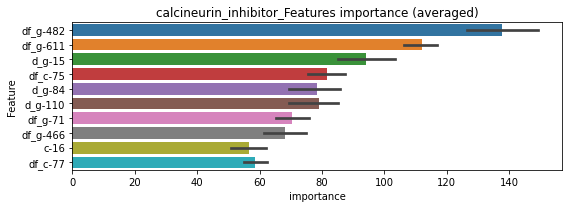

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 calcineurin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0100501	valid_1's binary_logloss: 0.0140634
[200]	training's binary_logloss: 0.000957449	valid_1's binary_logloss: 0.0039722
[300]	training's binary_logloss: 0.000252447	valid_1's binary_logloss: 0.00340068
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.000202984	valid_1's binary_logloss: 0.00333755


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 calcineurin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00983735	valid_1's binary_logloss: 0.0131929
[200]	training's binary_logloss: 0.000927477	valid_1's binary_logloss: 0.00297321
[300]	training's binary_logloss: 0.000251493	valid_1's binary_logloss: 0.00211727
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.000155005	valid_1's binary_logloss: 0.00203204


calcineurin_inhibitor logloss: 0.002684795249184804


neg labels: 3289 → selected neg labels: 3243


calcium_channel_blocker, len(trt): 281, len(othr): 3243, target_rate: 0.0117998 → Adj_target_rate: 0.0101297
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105036	valid_1's binary_logloss: 0.302356
[200]	training's binary_logloss: 0.0352575	valid_1's binary_logloss: 0.275018
Early stopping, best iteration is:
[211]	training's binary_logloss: 0.0313574	valid_1's binary_logloss: 0.274377
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111323	valid_1's binary_logloss: 0.285575
[200]	training's binary_logloss: 0.0396903	valid_1's binary_logloss: 0.249086
Early stopping, best iteration is:
[221]	training's binary_logloss: 0.0323475	valid_1's binary_logloss: 0.247157


1 / 3 AUC score:0.881
y_Threshold: 0.0870858, Threshold: 0.1250336, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 471 → Positive_corect_labels: 478/3420
p_label_rate: 0.0200904 Vs.target_rate: 0.01180
Num_p_label: 80.0, conf_0:0.11253, conf_1:0.13754
threshold: 0.1250336, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 478.0/3420, y_label_rate: 0.1397661
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0743538	valid_1's binary_logloss: 0.224081
[200]	training's binary_logloss: 0.0204694	valid_1's binary_logloss: 0.189242
Early stopping, best iteration is:
[241]	training's binary_logloss: 0.0126739	valid_1's binary_logloss: 0.186118
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0711619	valid_1's binary_logloss: 0.209477
[200]	training's binary_logloss: 0.0203528	valid_1's binary_logloss: 0.169651
Early stopping, best iteration is:
[237]	training's binary_logloss: 0.0132626	valid_1's binary_logloss: 0.163663


2 / 3 AUC score:0.949
y_Threshold: 0.0775413, Threshold: 0.1250336, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 168 → Positive_corect_labels: 394.0/3252
p_label_rate: 0.0140633 Vs.target_rate: 0.01180
Num_p_label: 56.0, conf_0:0.11253, conf_1:0.13754
threshold: 0.1250336, positive_p_label: 56.0/3982, p_label_rate: 0.0140633
positive_y_label: 394.0/3252, y_label_rate: 0.1211562
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0612672	valid_1's binary_logloss: 0.16575
[200]	training's binary_logloss: 0.0168814	valid_1's binary_logloss: 0.126148
[300]	training's binary_logloss: 0.00541579	valid_1's binary_logloss: 0.116157
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.00454665	valid_1's binary_logloss: 0.115503
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0573682	valid_1's binary_logloss: 0.159623
[200]	training's binary_logloss: 0.0144771	valid_1's binary_logloss: 0.120769
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.00892026	valid_1's binary_logloss: 0.115608


3 / 3 AUC score:0.977
y_Threshold: 0.0669859, Threshold: 0.1250336, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 96 → Positive_corect_labels: 346.0/3156
p_label_rate: 0.0113009 Vs.target_rate: 0.01180
Num_p_label: 45.0, conf_0:0.11253, conf_1:0.13754
threshold: 0.1250336, positive_p_label: 45.0/3982, p_label_rate: 0.0113009
positive_y_label: 391.0/7138, y_label_rate: 0.0547772


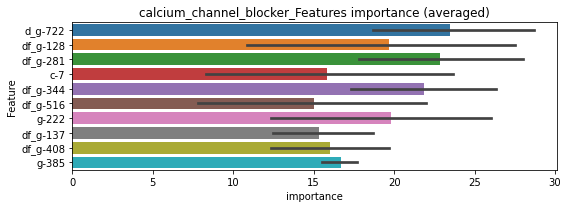

len(train_index) : 3569
len(valid_index) : 3569
================================= fold 1/2 calcium_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285746	valid_1's binary_logloss: 0.0987308
[200]	training's binary_logloss: 0.00703361	valid_1's binary_logloss: 0.0867467
Early stopping, best iteration is:
[195]	training's binary_logloss: 0.00750063	valid_1's binary_logloss: 0.0863843


len(train_index) : 3569
len(valid_index) : 3569
================================= fold 2/2 calcium_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0268571	valid_1's binary_logloss: 0.102875
[200]	training's binary_logloss: 0.00633288	valid_1's binary_logloss: 0.0900126
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.00633288	valid_1's binary_logloss: 0.0900126


calcium_channel_blocker logloss: 0.08819845091859854


neg labels: 3289 → selected neg labels: 3282


cannabinoid_receptor_agonist, len(trt): 42, len(othr): 3282, target_rate: 0.0017637 → Adj_target_rate: 0.0020135
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0398506	valid_1's binary_logloss: 0.0725306
[200]	training's binary_logloss: 0.00637421	valid_1's binary_logloss: 0.031143
[300]	training's binary_logloss: 0.00179729	valid_1's binary_logloss: 0.0214403
[400]	training's binary_logloss: 0.000846614	valid_1's binary_logloss: 0.0179806
[500]	training's binary_logloss: 0.000552019	valid_1's binary_logloss: 0.0168773
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000566776	valid_1's binary_logloss: 0.0167894
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0411667	valid_1's binary_logloss: 0.0758518
[200]	training's binary_logloss: 0.00701203	valid_1's binary_logloss: 0.0299308
[300]	training's binary_logloss: 0.00192906	valid_1's binary_logloss: 0.0177545
[400]	training's binary_logloss: 0.00090277	valid_1's binary_logloss: 0.0136839
[500]	training's binary_logloss: 0.00057874

1 / 3 AUC score:1.000
y_Threshold: 0.0044658, Threshold: 0.0073843, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3806
p_label_rate: 0.0200904 Vs.target_rate: 0.00176
Num_p_label: 80.0, conf_0:0.00665, conf_1:0.00812
Num_p_label: 80.0, Expected: 7.0, Adj_threshold_1: 0.0073843
Num_p_label: 20.0, Expected: 7.0, Adj_threshold_2: 0.0173843
Num_p_label: 8.0, Expected: 7.0, Adj_threshold_3: 0.0273843
threshold: 0.0273843, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0387385	valid_1's binary_logloss: 0.069274
[200]	training's binary_logloss: 0.00621124	valid_1's binary_logloss: 0.0279682
[300]	training's binary_logloss: 0.00173852	valid_1's binary_logloss: 0.0186649
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00138992	valid_1's binary_logloss: 0.0176074
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0403222	valid_1's binary_logloss: 0.071996
[200]	training's binary_logloss: 0.00660599	valid_1's binary_logloss: 0.0265852
[300]	training's binary_logloss: 0.0018241	valid_1's binary_logloss: 0.0154771
[400]	training's binary_logloss: 0.000859694	valid_1's binary_logloss: 0.0117466
[500]	training's binary_logloss: 0.000563915	valid_1's binary_logloss: 0.0103896
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000581178	valid_1's binary_logloss: 0.0103571


2 / 3 AUC score:1.000
y_Threshold: 0.0329209, Threshold: 0.0273843, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3804
p_label_rate: 0.0092918 Vs.target_rate: 0.00176
Num_p_label: 37.0, conf_0:0.02465, conf_1:0.03012
Num_p_label: 37.0, Expected: 7.0, Adj_threshold_1: 0.0273843
Num_p_label: 18.0, Expected: 7.0, Adj_threshold_2: 0.0373843
Num_p_label: 10.0, Expected: 7.0, Adj_threshold_3: 0.0473843
threshold: 0.0473843, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 655.0/3804, y_label_rate: 0.1721872
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0399152	valid_1's binary_logloss: 0.0720793
[200]	training's binary_logloss: 0.00643551	valid_1's binary_logloss: 0.0298679
[300]	training's binary_logloss: 0.00178137	valid_1's binary_logloss: 0.0215489
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00178137	valid_1's binary_logloss: 0.0215489
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0393874	valid_1's binary_logloss: 0.0696432
[200]	training's binary_logloss: 0.00645337	valid_1's binary_logloss: 0.0264587
[300]	training's binary_logloss: 0.00181898	valid_1's binary_logloss: 0.0171648
[400]	training's binary_logloss: 0.000861913	valid_1's binary_logloss: 0.0143319
Early stopping, best iteration is:
[428]	training's binary_logloss: 0.000744014	valid_1's binary_logloss: 0.0140885


3 / 3 AUC score:1.000
y_Threshold: 0.0400750, Threshold: 0.0473843, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 651.0/3796
p_label_rate: 0.0035158 Vs.target_rate: 0.00176
Num_p_label: 14.0, conf_0:0.04265, conf_1:0.05212
threshold: 0.0473843, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 665.0/7778, y_label_rate: 0.0854976


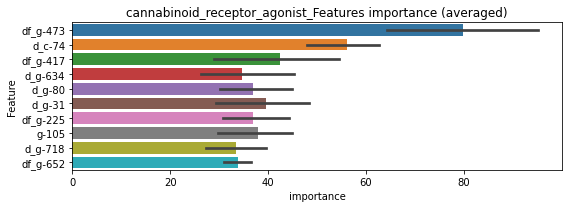

len(train_index) : 3889
len(valid_index) : 3889
================================= fold 1/2 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226222	valid_1's binary_logloss: 0.0512242
[200]	training's binary_logloss: 0.00372691	valid_1's binary_logloss: 0.0315824
Early stopping, best iteration is:
[258]	training's binary_logloss: 0.00160306	valid_1's binary_logloss: 0.029532


len(train_index) : 3889
len(valid_index) : 3889
================================= fold 2/2 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242536	valid_1's binary_logloss: 0.0459911
[200]	training's binary_logloss: 0.0040125	valid_1's binary_logloss: 0.0201002
[300]	training's binary_logloss: 0.00108829	valid_1's binary_logloss: 0.0145984
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.00116416	valid_1's binary_logloss: 0.0145832


cannabinoid_receptor_agonist logloss: 0.022057588241612205


neg labels: 3289 → selected neg labels: 3280


cannabinoid_receptor_antagonist, len(trt): 55, len(othr): 3280, target_rate: 0.0023096 → Adj_target_rate: 0.0025322
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0457903	valid_1's binary_logloss: 0.095289
[200]	training's binary_logloss: 0.00829523	valid_1's binary_logloss: 0.0504325
[300]	training's binary_logloss: 0.00233262	valid_1's binary_logloss: 0.040077
[400]	training's binary_logloss: 0.00107207	valid_1's binary_logloss: 0.0369624
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00078022	valid_1's binary_logloss: 0.0361411
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.046768	valid_1's binary_logloss: 0.101427
[200]	training's binary_logloss: 0.00853648	valid_1's binary_logloss: 0.0595533
[300]	training's binary_logloss: 0.00240788	valid_1's binary_logloss: 0.0514823
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00252249	valid_1's binary_logloss: 0.0513163


1 / 3 AUC score:0.995
y_Threshold: 0.0111979, Threshold: 0.0140682, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 154 → Positive_corect_labels: 645/3782
p_label_rate: 0.0200904 Vs.target_rate: 0.00231
Num_p_label: 80.0, conf_0:0.01266, conf_1:0.01547
Num_p_label: 80.0, Expected: 9.2, Adj_threshold_1: 0.0140682
Num_p_label: 28.0, Expected: 9.2, Adj_threshold_2: 0.0240682
Num_p_label: 15.0, Expected: 9.2, Adj_threshold_3: 0.0340682
threshold: 0.0340682, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 645.0/3782, y_label_rate: 0.1705447
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0454322	valid_1's binary_logloss: 0.0867295
[200]	training's binary_logloss: 0.00837078	valid_1's binary_logloss: 0.0372014
[300]	training's binary_logloss: 0.00236106	valid_1's binary_logloss: 0.0250418
[400]	training's binary_logloss: 0.00107315	valid_1's binary_logloss: 0.0201243
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000864622	valid_1's binary_logloss: 0.0193003
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0469925	valid_1's binary_logloss: 0.0805787
[200]	training's binary_logloss: 0.00829092	valid_1's binary_logloss: 0.0326984
[300]	training's binary_logloss: 0.00229638	valid_1's binary_logloss: 0.0226865
[400]	training's binary_logloss: 0.00105643	valid_1's binary_logloss: 0.0202243
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.000985706	valid_1's binary_logloss: 0.0200638


2 / 3 AUC score:1.000
y_Threshold: 0.0408199, Threshold: 0.0340682, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 639.0/3770
p_label_rate: 0.0070316 Vs.target_rate: 0.00231
Num_p_label: 28.0, conf_0:0.03066, conf_1:0.03747
Num_p_label: 28.0, Expected: 9.2, Adj_threshold_1: 0.0340682
Num_p_label: 18.0, Expected: 9.2, Adj_threshold_2: 0.0440682
threshold: 0.0440682, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 639.0/3770, y_label_rate: 0.1694960
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0442482	valid_1's binary_logloss: 0.0831927
[200]	training's binary_logloss: 0.00775533	valid_1's binary_logloss: 0.0339596
[300]	training's binary_logloss: 0.00219461	valid_1's binary_logloss: 0.0229453
[400]	training's binary_logloss: 0.0010322	valid_1's binary_logloss: 0.0192928
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000791062	valid_1's binary_logloss: 0.0182931
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0433901	valid_1's binary_logloss: 0.0848256
[200]	training's binary_logloss: 0.00747564	valid_1's binary_logloss: 0.0389649
[300]	training's binary_logloss: 0.00212509	valid_1's binary_logloss: 0.0278293
[400]	training's binary_logloss: 0.000979473	valid_1's binary_logloss: 0.0245691
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.000979473	valid_1's binary_logloss: 0.0245691


3 / 3 AUC score:1.000
y_Threshold: 0.0308324, Threshold: 0.0440682, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 636.0/3764
p_label_rate: 0.0055249 Vs.target_rate: 0.00231
Num_p_label: 22.0, conf_0:0.03966, conf_1:0.04847
threshold: 0.0440682, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 658.0/7746, y_label_rate: 0.0849471


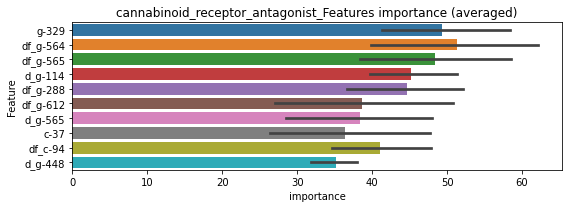

len(train_index) : 3873
len(valid_index) : 3873
================================= fold 1/2 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.025522	valid_1's binary_logloss: 0.0542844
[200]	training's binary_logloss: 0.00435628	valid_1's binary_logloss: 0.0322051
Early stopping, best iteration is:
[256]	training's binary_logloss: 0.00194815	valid_1's binary_logloss: 0.030533


len(train_index) : 3873
len(valid_index) : 3873
================================= fold 2/2 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0259764	valid_1's binary_logloss: 0.0527612
[200]	training's binary_logloss: 0.00481118	valid_1's binary_logloss: 0.0261499
[300]	training's binary_logloss: 0.00127157	valid_1's binary_logloss: 0.0200915
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.000742307	valid_1's binary_logloss: 0.0190256


cannabinoid_receptor_antagonist logloss: 0.02477927317803284


neg labels: 3289 → selected neg labels: 3283


carbonic_anhydrase_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0372825	valid_1's binary_logloss: 0.0616586
[200]	training's binary_logloss: 0.0059527	valid_1's binary_logloss: 0.01889
[300]	training's binary_logloss: 0.00165432	valid_1's binary_logloss: 0.0104778
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00112372	valid_1's binary_logloss: 0.00902524
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0359393	valid_1's binary_logloss: 0.062873
[200]	training's binary_logloss: 0.00580178	valid_1's binary_logloss: 0.0236891
[300]	training's binary_logloss: 0.00163392	valid_1's binary_logloss: 0.0156277
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.00126434	valid_1's binary_logloss: 0.0150417


1 / 3 AUC score:1.000
y_Threshold: 0.0069884, Threshold: 0.0104909, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151
Num_p_label: 80.0, conf_0:0.00944, conf_1:0.01154
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0104909
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_2: 0.0204909
Num_p_label: 8.0, Expected: 6.0, Adj_threshold_3: 0.0304909
threshold: 0.0304909, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.036865	valid_1's binary_logloss: 0.0595856
[200]	training's binary_logloss: 0.00540433	valid_1's binary_logloss: 0.0175533
[300]	training's binary_logloss: 0.0015424	valid_1's binary_logloss: 0.00959474
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.000846211	valid_1's binary_logloss: 0.0082183
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0369564	valid_1's binary_logloss: 0.0642226
[200]	training's binary_logloss: 0.00574635	valid_1's binary_logloss: 0.0245369
[300]	training's binary_logloss: 0.0015996	valid_1's binary_logloss: 0.0157791
[400]	training's binary_logloss: 0.000776506	valid_1's binary_logloss: 0.0139557
Early stopping, best iteration is:
[429]	training's binary_logloss: 0.000667704	valid_1's binary_logloss: 0.0134358


2 / 3 AUC score:1.000
y_Threshold: 0.0335140, Threshold: 0.0304909, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0042692 Vs.target_rate: 0.00151
Num_p_label: 17.0, conf_0:0.02744, conf_1:0.03354
threshold: 0.0304909, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.036865	valid_1's binary_logloss: 0.0595856
[200]	training's binary_logloss: 0.00540433	valid_1's binary_logloss: 0.0175533
[300]	training's binary_logloss: 0.0015424	valid_1's binary_logloss: 0.00959474
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.000846211	valid_1's binary_logloss: 0.0082183
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0369564	valid_1's binary_logloss: 0.0642226
[200]	training's binary_logloss: 0.00574635	valid_1's binary_logloss: 0.0245369
[300]	training's binary_logloss: 0.0015996	valid_1's binary_logloss: 0.0157791
[400]	training's binary_logloss: 0.000776506	valid_1's binary_logloss: 0.0139557
Early stopping, best iteration is:
[429]	training's binary_logloss: 0.000667704	valid_1's binary_logloss: 0.0134358


3 / 3 AUC score:1.000
y_Threshold: 0.0335140, Threshold: 0.0304909, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0042692 Vs.target_rate: 0.00151
Num_p_label: 17.0, conf_0:0.02744, conf_1:0.03354
threshold: 0.0304909, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 673.0/7789, y_label_rate: 0.0864039


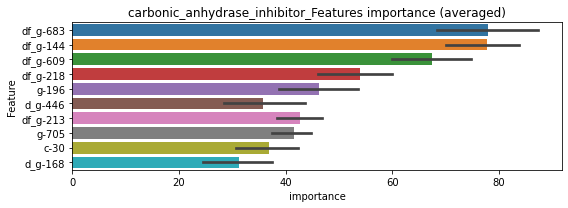

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212044	valid_1's binary_logloss: 0.0455981
[200]	training's binary_logloss: 0.00319247	valid_1's binary_logloss: 0.0218689
[300]	training's binary_logloss: 0.000876154	valid_1's binary_logloss: 0.0183508
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.000757024	valid_1's binary_logloss: 0.0181648


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232117	valid_1's binary_logloss: 0.0347549
[200]	training's binary_logloss: 0.00379629	valid_1's binary_logloss: 0.0114726
[300]	training's binary_logloss: 0.00102866	valid_1's binary_logloss: 0.00803688
[400]	training's binary_logloss: 0.000472534	valid_1's binary_logloss: 0.00736448
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.000425136	valid_1's binary_logloss: 0.00727456


carbonic_anhydrase_inhibitor logloss: 0.012720397941468415


neg labels: 3289 → selected neg labels: 3283


casein_kinase_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0358671	valid_1's binary_logloss: 0.0560127
[200]	training's binary_logloss: 0.00558751	valid_1's binary_logloss: 0.0151535
[300]	training's binary_logloss: 0.00155953	valid_1's binary_logloss: 0.00658928
[400]	training's binary_logloss: 0.000745013	valid_1's binary_logloss: 0.0042374
[500]	training's binary_logloss: 0.000495609	valid_1's binary_logloss: 0.00344715
Early stopping, best iteration is:
[586]	training's binary_logloss: 0.000433961	valid_1's binary_logloss: 0.00321963
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0344282	valid_1's binary_logloss: 0.0628001
[200]	training's binary_logloss: 0.00518263	valid_1's binary_logloss: 0.0249198
[300]	training's binary_logloss: 0.00143358	valid_1's binary_logloss: 0.0177445
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.000769327	valid_1's binary_logloss: 0.0156378


1 / 3 AUC score:1.000
y_Threshold: 0.0043690, Threshold: 0.0066103, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151
Num_p_label: 80.0, conf_0:0.00595, conf_1:0.00727
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0066103
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_2: 0.0166103
Num_p_label: 7.0, Expected: 6.0, Adj_threshold_3: 0.0266103
threshold: 0.0266103, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0347395	valid_1's binary_logloss: 0.0537139
[200]	training's binary_logloss: 0.00514246	valid_1's binary_logloss: 0.0139649
[300]	training's binary_logloss: 0.0014664	valid_1's binary_logloss: 0.00646635
[400]	training's binary_logloss: 0.0007176	valid_1's binary_logloss: 0.0043178
[500]	training's binary_logloss: 0.000482149	valid_1's binary_logloss: 0.00350657
Early stopping, best iteration is:
[567]	training's binary_logloss: 0.000435801	valid_1's binary_logloss: 0.00335335
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339568	valid_1's binary_logloss: 0.0589476
[200]	training's binary_logloss: 0.00502494	valid_1's binary_logloss: 0.0235747
[300]	training's binary_logloss: 0.00141529	valid_1's binary_logloss: 0.0177141
[400]	training's binary_logloss: 0.000698164	valid_1's binary_logloss: 0.0154908
Early stopping, best iteration is:
[428]	

2 / 3 AUC score:1.000
y_Threshold: 0.0228531, Threshold: 0.0266103, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0057760 Vs.target_rate: 0.00151
Num_p_label: 23.0, conf_0:0.02395, conf_1:0.02927
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_1: 0.0266103
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_2: 0.0366103
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_3: 0.0466103
threshold: 0.0466103, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0355196	valid_1's binary_logloss: 0.0525669
[200]	training's binary_logloss: 0.00530074	valid_1's binary_logloss: 0.0140685
[300]	training's binary_logloss: 0.00149124	valid_1's binary_logloss: 0.00732479
[400]	training's binary_logloss: 0.000728544	valid_1's binary_logloss: 0.0054617
[500]	training's binary_logloss: 0.000491652	valid_1's binary_logloss: 0.00470843
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.000437157	valid_1's binary_logloss: 0.00437507
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0341144	valid_1's binary_logloss: 0.060453
[200]	training's binary_logloss: 0.0050392	valid_1's binary_logloss: 0.0178042
[300]	training's binary_logloss: 0.00143097	valid_1's binary_logloss: 0.00850268
[400]	training's binary_logloss: 0.000699087	valid_1's binary_logloss: 0.00552079
Early stopping, best iteration is:
[45

3 / 3 AUC score:1.000
y_Threshold: 0.0468648, Threshold: 0.0466103, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0020090 Vs.target_rate: 0.00151
Num_p_label: 8.0, conf_0:0.04195, conf_1:0.05127
threshold: 0.0466103, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 663.0/7787, y_label_rate: 0.0851419


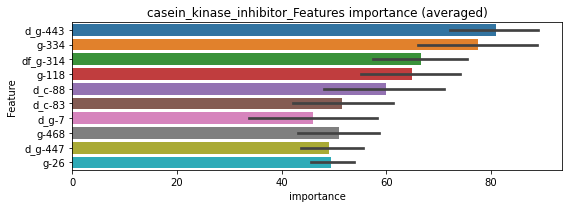

len(train_index) : 3893
len(valid_index) : 3894
================================= fold 1/2 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190016	valid_1's binary_logloss: 0.0427459
[200]	training's binary_logloss: 0.00290868	valid_1's binary_logloss: 0.0202278
[300]	training's binary_logloss: 0.000791371	valid_1's binary_logloss: 0.0159364
[400]	training's binary_logloss: 0.000369389	valid_1's binary_logloss: 0.0145005
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.000355642	valid_1's binary_logloss: 0.01447


len(train_index) : 3894
len(valid_index) : 3893
================================= fold 2/2 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0202501	valid_1's binary_logloss: 0.0333272
[200]	training's binary_logloss: 0.00298153	valid_1's binary_logloss: 0.00889853
[300]	training's binary_logloss: 0.000815417	valid_1's binary_logloss: 0.00476686
[400]	training's binary_logloss: 0.000386282	valid_1's binary_logloss: 0.00395378
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000276115	valid_1's binary_logloss: 0.00372781


casein_kinase_inhibitor logloss: 0.009099616661479435


neg labels: 3289 → selected neg labels: 3287


caspase_activator, len(trt): 18, len(othr): 3287, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023135	valid_1's binary_logloss: 0.0287343
[200]	training's binary_logloss: 0.00269321	valid_1's binary_logloss: 0.00401437
[300]	training's binary_logloss: 0.000761482	valid_1's binary_logloss: 0.00126773
[400]	training's binary_logloss: 0.000402626	valid_1's binary_logloss: 0.000716557
[500]	training's binary_logloss: 0.00032548	valid_1's binary_logloss: 0.000600184
Early stopping, best iteration is:
[549]	training's binary_logloss: 0.000321009	valid_1's binary_logloss: 0.000594406
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233613	valid_1's binary_logloss: 0.0332133
[200]	training's binary_logloss: 0.0026849	valid_1's binary_logloss: 0.00671262
[300]	training's binary_logloss: 0.000752882	valid_1's binary_logloss: 0.00289352
[400]	training's binary_logloss: 0.000397736	valid_1's binary_logloss: 0.00198466
[500]	training's binary_logloss

1 / 3 AUC score:1.000
y_Threshold: 0.0013400, Threshold: 0.0018622, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00168, conf_1:0.00205
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0018622
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_2: 0.0118622
threshold: 0.0118622, positive_p_label: 0.0/3982, p_label_rate: 0.0000000
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230844	valid_1's binary_logloss: 0.0290927
[200]	training's binary_logloss: 0.00265177	valid_1's binary_logloss: 0.00428162
[300]	training's binary_logloss: 0.000740941	valid_1's binary_logloss: 0.00140059
[400]	training's binary_logloss: 0.0003945	valid_1's binary_logloss: 0.000812213
[500]	training's binary_logloss: 0.00032262	valid_1's binary_logloss: 0.000691898
Early stopping, best iteration is:
[559]	training's binary_logloss: 0.000316974	valid_1's binary_logloss: 0.000683406
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233845	valid_1's binary_logloss: 0.0343017
[200]	training's binary_logloss: 0.0026689	valid_1's binary_logloss: 0.00782825
[300]	training's binary_logloss: 0.000749565	valid_1's binary_logloss: 0.00378036
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.000472326	valid_1's binary_logloss: 0.002890

2 / 3 AUC score:1.000
y_Threshold: 0.0459843, Threshold: 0.0118622, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0025113 Vs.target_rate: 0.00076
Num_p_label: 10.0, conf_0:0.01068, conf_1:0.01305
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_1: 0.0118622
Num_p_label: 2.0, Expected: 3.0, Adj_threshold_2: 0.0218622
threshold: 0.0218622, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230844	valid_1's binary_logloss: 0.0290927
[200]	training's binary_logloss: 0.00265177	valid_1's binary_logloss: 0.00428162
[300]	training's binary_logloss: 0.000740941	valid_1's binary_logloss: 0.00140059
[400]	training's binary_logloss: 0.0003945	valid_1's binary_logloss: 0.000812213
[500]	training's binary_logloss: 0.00032262	valid_1's binary_logloss: 0.000691898
Early stopping, best iteration is:
[559]	training's binary_logloss: 0.000316974	valid_1's binary_logloss: 0.000683406
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233845	valid_1's binary_logloss: 0.0343017
[200]	training's binary_logloss: 0.0026689	valid_1's binary_logloss: 0.00782825
[300]	training's binary_logloss: 0.000749565	valid_1's binary_logloss: 0.00378036
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.000472326	valid_1's binary_logloss: 0.002890

3 / 3 AUC score:1.000
y_Threshold: 0.0459843, Threshold: 0.0218622, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0005023 Vs.target_rate: 0.00076
Num_p_label: 2.0, conf_0:0.01968, conf_1:0.02405
threshold: 0.0218622, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 659.0/7794, y_label_rate: 0.0845522


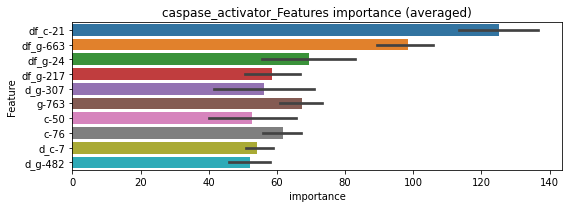

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 caspase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0123313	valid_1's binary_logloss: 0.0193279
[200]	training's binary_logloss: 0.00137878	valid_1's binary_logloss: 0.00584343
[300]	training's binary_logloss: 0.000374538	valid_1's binary_logloss: 0.0038443
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.000293184	valid_1's binary_logloss: 0.00363042


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 caspase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0127448	valid_1's binary_logloss: 0.0190783
[200]	training's binary_logloss: 0.00143095	valid_1's binary_logloss: 0.00466151
[300]	training's binary_logloss: 0.000385539	valid_1's binary_logloss: 0.00277965
[400]	training's binary_logloss: 0.000200946	valid_1's binary_logloss: 0.00245455
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.000169293	valid_1's binary_logloss: 0.00239355


caspase_activator logloss: 0.003011981344829498


neg labels: 3289 → selected neg labels: 3286


catechol_o_methyltransferase_inhibitor, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229546	valid_1's binary_logloss: 0.031844
[200]	training's binary_logloss: 0.0026876	valid_1's binary_logloss: 0.00666186
[300]	training's binary_logloss: 0.000773517	valid_1's binary_logloss: 0.0028754
[400]	training's binary_logloss: 0.000406687	valid_1's binary_logloss: 0.00195006
[500]	training's binary_logloss: 0.000328237	valid_1's binary_logloss: 0.00174221
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.000325814	valid_1's binary_logloss: 0.00173628
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0238648	valid_1's binary_logloss: 0.0313416
[200]	training's binary_logloss: 0.00271827	valid_1's binary_logloss: 0.00528514
[300]	training's binary_logloss: 0.000767066	valid_1's binary_logloss: 0.00207274
[400]	training's binary_logloss: 0.000411073	valid_1's binary_logloss: 0.00137189
Early stopping, best iteration is:

1 / 3 AUC score:1.000
y_Threshold: 0.0014625, Threshold: 0.0024264, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00218, conf_1:0.00267
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0024264
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_2: 0.0124264
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_3: 0.0224264
threshold: 0.0224264, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230453	valid_1's binary_logloss: 0.030757
[200]	training's binary_logloss: 0.00262626	valid_1's binary_logloss: 0.00532734
[300]	training's binary_logloss: 0.000758599	valid_1's binary_logloss: 0.00209407
[400]	training's binary_logloss: 0.000407061	valid_1's binary_logloss: 0.00130483
[500]	training's binary_logloss: 0.000328649	valid_1's binary_logloss: 0.00113943
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.000323932	valid_1's binary_logloss: 0.00113369
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233185	valid_1's binary_logloss: 0.0304736
[200]	training's binary_logloss: 0.00262478	valid_1's binary_logloss: 0.00504496
[300]	training's binary_logloss: 0.000740048	valid_1's binary_logloss: 0.00189729
[400]	training's binary_logloss: 0.000399858	valid_1's binary_logloss: 0.00123147
Early stopping, best iteration i

2 / 3 AUC score:1.000
y_Threshold: 0.1111263, Threshold: 0.0224264, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0025113 Vs.target_rate: 0.00076
Num_p_label: 10.0, conf_0:0.02018, conf_1:0.02467
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_1: 0.0224264
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_2: 0.0324264
threshold: 0.0324264, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230453	valid_1's binary_logloss: 0.030757
[200]	training's binary_logloss: 0.00262626	valid_1's binary_logloss: 0.00532734
[300]	training's binary_logloss: 0.000758599	valid_1's binary_logloss: 0.00209407
[400]	training's binary_logloss: 0.000407061	valid_1's binary_logloss: 0.00130483
[500]	training's binary_logloss: 0.000328649	valid_1's binary_logloss: 0.00113943
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.000323932	valid_1's binary_logloss: 0.00113369
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233185	valid_1's binary_logloss: 0.0304736
[200]	training's binary_logloss: 0.00262478	valid_1's binary_logloss: 0.00504496
[300]	training's binary_logloss: 0.000740048	valid_1's binary_logloss: 0.00189729
[400]	training's binary_logloss: 0.000399858	valid_1's binary_logloss: 0.00123147
Early stopping, best iteration i

3 / 3 AUC score:1.000
y_Threshold: 0.1111263, Threshold: 0.0324264, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0012557 Vs.target_rate: 0.00076
Num_p_label: 5.0, conf_0:0.02918, conf_1:0.03567
threshold: 0.0324264, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 662.0/7793, y_label_rate: 0.0849480


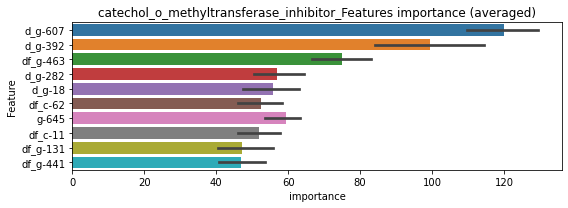

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0125093	valid_1's binary_logloss: 0.0214301
[200]	training's binary_logloss: 0.00139239	valid_1's binary_logloss: 0.00710443
[300]	training's binary_logloss: 0.000379676	valid_1's binary_logloss: 0.0056239
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00022501	valid_1's binary_logloss: 0.00547963


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0130462	valid_1's binary_logloss: 0.0179592
[200]	training's binary_logloss: 0.00152696	valid_1's binary_logloss: 0.00359671
[300]	training's binary_logloss: 0.000414953	valid_1's binary_logloss: 0.00176883
[400]	training's binary_logloss: 0.000213344	valid_1's binary_logloss: 0.00133427
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.000183769	valid_1's binary_logloss: 0.00126048


catechol_o_methyltransferase_inhibitor logloss: 0.003370323584664615


neg labels: 3289 → selected neg labels: 3272


cc_chemokine_receptor_antagonist, len(trt): 102, len(othr): 3272, target_rate: 0.0042832 → Adj_target_rate: 0.0042806
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.064918	valid_1's binary_logloss: 0.165095
[200]	training's binary_logloss: 0.0160515	valid_1's binary_logloss: 0.128867
Early stopping, best iteration is:
[284]	training's binary_logloss: 0.00559253	valid_1's binary_logloss: 0.121922
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0662077	valid_1's binary_logloss: 0.137225
[200]	training's binary_logloss: 0.0168781	valid_1's binary_logloss: 0.0848975
[300]	training's binary_logloss: 0.00523598	valid_1's binary_logloss: 0.0722255
[400]	training's binary_logloss: 0.00226467	valid_1's binary_logloss: 0.0678545
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.00220472	valid_1's binary_logloss: 0.0676857


1 / 3 AUC score:0.984
y_Threshold: 0.0216728, Threshold: 0.0353122, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 198 → Positive_corect_labels: 621/3728
p_label_rate: 0.0200904 Vs.target_rate: 0.00428
Num_p_label: 80.0, conf_0:0.03178, conf_1:0.03884
Num_p_label: 80.0, Expected: 17.1, Adj_threshold_1: 0.0353122
Num_p_label: 42.0, Expected: 17.1, Adj_threshold_2: 0.0453122
Num_p_label: 27.0, Expected: 17.1, Adj_threshold_3: 0.0553122
threshold: 0.0553122, positive_p_label: 27.0/3982, p_label_rate: 0.0067805
positive_y_label: 621.0/3728, y_label_rate: 0.1665773
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0614559	valid_1's binary_logloss: 0.134689
[200]	training's binary_logloss: 0.0140695	valid_1's binary_logloss: 0.0845663
[300]	training's binary_logloss: 0.00424244	valid_1's binary_logloss: 0.0726223
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00367843	valid_1's binary_logloss: 0.0715627
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0584104	valid_1's binary_logloss: 0.131985
[200]	training's binary_logloss: 0.013515	valid_1's binary_logloss: 0.0869858
[300]	training's binary_logloss: 0.00412566	valid_1's binary_logloss: 0.0773399
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.00334958	valid_1's binary_logloss: 0.0765685


2 / 3 AUC score:0.991
y_Threshold: 0.0450151, Threshold: 0.0553122, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 54 → Positive_corect_labels: 594.0/3674
p_label_rate: 0.0120542 Vs.target_rate: 0.00428
Num_p_label: 48.0, conf_0:0.04978, conf_1:0.06084
threshold: 0.0553122, positive_p_label: 48.0/3982, p_label_rate: 0.0120542
positive_y_label: 594.0/3674, y_label_rate: 0.1616766
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.056031	valid_1's binary_logloss: 0.126677
[200]	training's binary_logloss: 0.0130003	valid_1's binary_logloss: 0.0778878
[300]	training's binary_logloss: 0.00393858	valid_1's binary_logloss: 0.0648675
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.00249314	valid_1's binary_logloss: 0.0625814
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0529984	valid_1's binary_logloss: 0.131915
[200]	training's binary_logloss: 0.0119086	valid_1's binary_logloss: 0.0905792
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00504065	valid_1's binary_logloss: 0.0838965


3 / 3 AUC score:0.992
y_Threshold: 0.0422596, Threshold: 0.0553122, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 56 → Positive_corect_labels: 566.0/3618
p_label_rate: 0.0128076 Vs.target_rate: 0.00428
Num_p_label: 51.0, conf_0:0.04978, conf_1:0.06084
threshold: 0.0553122, positive_p_label: 51.0/3982, p_label_rate: 0.0128076
positive_y_label: 617.0/7600, y_label_rate: 0.0811842


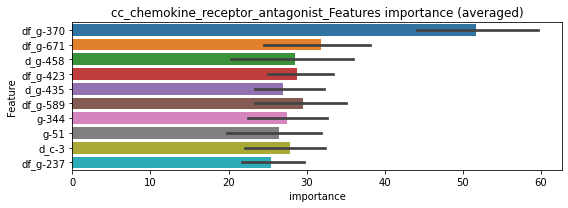

len(train_index) : 3800
len(valid_index) : 3800
================================= fold 1/2 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0311144	valid_1's binary_logloss: 0.0820763
[200]	training's binary_logloss: 0.00721397	valid_1's binary_logloss: 0.0588054
[300]	training's binary_logloss: 0.0022043	valid_1's binary_logloss: 0.0545864
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00232192	valid_1's binary_logloss: 0.0543269


len(train_index) : 3800
len(valid_index) : 3800
================================= fold 2/2 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319552	valid_1's binary_logloss: 0.0772257
[200]	training's binary_logloss: 0.00770748	valid_1's binary_logloss: 0.0501873
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.00253856	valid_1's binary_logloss: 0.046242


cc_chemokine_receptor_antagonist logloss: 0.050284456676455105


neg labels: 3289 → selected neg labels: 3286


cck_receptor_antagonist, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225256	valid_1's binary_logloss: 0.0290443
[200]	training's binary_logloss: 0.00259773	valid_1's binary_logloss: 0.00422574
[300]	training's binary_logloss: 0.000733365	valid_1's binary_logloss: 0.00141093
[400]	training's binary_logloss: 0.000392617	valid_1's binary_logloss: 0.000820374
[500]	training's binary_logloss: 0.000314514	valid_1's binary_logloss: 0.000676981
Early stopping, best iteration is:
[567]	training's binary_logloss: 0.000307596	valid_1's binary_logloss: 0.000665755
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228659	valid_1's binary_logloss: 0.0301112
[200]	training's binary_logloss: 0.00261079	valid_1's binary_logloss: 0.00477151
[300]	training's binary_logloss: 0.000731745	valid_1's binary_logloss: 0.00182015
[400]	training's binary_logloss: 0.000391246	valid_1's binary_logloss: 0.00112135
[500]	training's binary_logl

1 / 3 AUC score:1.000
y_Threshold: 0.0016097, Threshold: 0.0024266, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00218, conf_1:0.00267
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0024266
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_2: 0.0124266
threshold: 0.0124266, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0223325	valid_1's binary_logloss: 0.0276091
[200]	training's binary_logloss: 0.00253187	valid_1's binary_logloss: 0.00385208
[300]	training's binary_logloss: 0.000718028	valid_1's binary_logloss: 0.00124904
[400]	training's binary_logloss: 0.000390976	valid_1's binary_logloss: 0.000716757
[500]	training's binary_logloss: 0.000320818	valid_1's binary_logloss: 0.000604187
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00031381	valid_1's binary_logloss: 0.000593264
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.02248	valid_1's binary_logloss: 0.0317249
[200]	training's binary_logloss: 0.00251062	valid_1's binary_logloss: 0.0051516
[300]	training's binary_logloss: 0.000710493	valid_1's binary_logloss: 0.00195148
[400]	training's binary_logloss: 0.000384949	valid_1's binary_logloss: 0.0012129
[500]	training's binary_logloss: 

2 / 3 AUC score:1.000
y_Threshold: 0.1285511, Threshold: 0.0124266, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0057760 Vs.target_rate: 0.00076
Num_p_label: 23.0, conf_0:0.01118, conf_1:0.01367
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_1: 0.0124266
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_2: 0.0224266
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_3: 0.0324266
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_4: 0.0424266
threshold: 0.0424266, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0223325	valid_1's binary_logloss: 0.0276091
[200]	training's binary_logloss: 0.00253187	valid_1's binary_logloss: 0.00385208
[300]	training's binary_logloss: 0.000718028	valid_1's binary_logloss: 0.00124904
[400]	training's binary_logloss: 0.000390976	valid_1's binary_logloss: 0.000716757
[500]	training's binary_logloss: 0.000320818	valid_1's binary_logloss: 0.000604187
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00031381	valid_1's binary_logloss: 0.000593264
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.02248	valid_1's binary_logloss: 0.0317249
[200]	training's binary_logloss: 0.00251062	valid_1's binary_logloss: 0.0051516
[300]	training's binary_logloss: 0.000710493	valid_1's binary_logloss: 0.00195148
[400]	training's binary_logloss: 0.000384949	valid_1's binary_logloss: 0.0012129
[500]	training's binary_logloss: 

3 / 3 AUC score:1.000
y_Threshold: 0.1285511, Threshold: 0.0424266, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0007534 Vs.target_rate: 0.00076
Num_p_label: 3.0, conf_0:0.03818, conf_1:0.04667
threshold: 0.0424266, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 660.0/7793, y_label_rate: 0.0846914


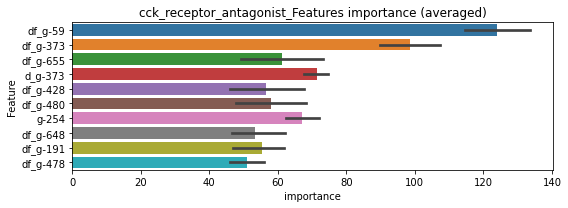

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 cck_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0120444	valid_1's binary_logloss: 0.016853
[200]	training's binary_logloss: 0.00133159	valid_1's binary_logloss: 0.00430416
[300]	training's binary_logloss: 0.00036627	valid_1's binary_logloss: 0.00303943
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.000223774	valid_1's binary_logloss: 0.00285413


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 cck_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0121508	valid_1's binary_logloss: 0.0174249
[200]	training's binary_logloss: 0.00138291	valid_1's binary_logloss: 0.00438863
[300]	training's binary_logloss: 0.000373878	valid_1's binary_logloss: 0.00260729
[400]	training's binary_logloss: 0.000196242	valid_1's binary_logloss: 0.00221057
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.000175224	valid_1's binary_logloss: 0.00214736


cck_receptor_antagonist logloss: 0.002500792777305913


neg labels: 3289 → selected neg labels: 3263


cdk_inhibitor, len(trt): 352, len(othr): 3263, target_rate: 0.0147812 → Adj_target_rate: 0.0122676
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0429495	valid_1's binary_logloss: 0.120651
Early stopping, best iteration is:
[170]	training's binary_logloss: 0.0126413	valid_1's binary_logloss: 0.109052
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0431004	valid_1's binary_logloss: 0.116775
Early stopping, best iteration is:
[187]	training's binary_logloss: 0.0095024	valid_1's binary_logloss: 0.0994163


1 / 3 AUC score:0.980
y_Threshold: 0.0409697, Threshold: 0.3896439, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 213 → Positive_corect_labels: 611/3702
p_label_rate: 0.0200904 Vs.target_rate: 0.01478
Num_p_label: 80.0, conf_0:0.35068, conf_1:0.42861
threshold: 0.3896439, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 611.0/3702, y_label_rate: 0.1650459
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0349981	valid_1's binary_logloss: 0.0744353
[200]	training's binary_logloss: 0.00529175	valid_1's binary_logloss: 0.04757
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0018877	valid_1's binary_logloss: 0.0432998
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339458	valid_1's binary_logloss: 0.0818254
[200]	training's binary_logloss: 0.00497711	valid_1's binary_logloss: 0.0616441
Early stopping, best iteration is:
[243]	training's binary_logloss: 0.0026464	valid_1's binary_logloss: 0.0599129


2 / 3 AUC score:0.995
y_Threshold: 0.1038241, Threshold: 0.3896439, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 58 → Positive_corect_labels: 582.0/3644
p_label_rate: 0.0554997 Vs.target_rate: 0.01478
Num_p_label: 221.0, conf_0:0.35068, conf_1:0.42861
Num_p_label: 221.0, Expected: 58.9, Adj_threshold_1: 0.3896439
Num_p_label: 221.0, Expected: 58.9, Adj_threshold_2: 0.3996439
Num_p_label: 220.0, Expected: 58.9, Adj_threshold_3: 0.4096439
Num_p_label: 216.0, Expected: 58.9, Adj_threshold_4: 0.4196439
Num_p_label: 214.0, Expected: 58.9, Adj_threshold_5: 0.4296439
Num_p_label: 212.0, Expected: 58.9, Adj_threshold_6: 0.4396439
Num_p_label: 208.0, Expected: 58.9, Adj_threshold_7: 0.4496439
Num_p_label: 205.0, Expected: 58.9, Adj_threshold_8: 0.4596439
Num_p_label: 203.0, Expected: 58.9, Adj_threshold_9: 0.4696439
Num_p_label: 200.0, Expected: 58.9, Adj_threshold_10: 0.4796439
threshold: 0.4896439, positive_p_label: 196.0/3982, p_label_rate: 0.0492215
positive_y_label: 582.0/3644, y_label_ra

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281839	valid_1's binary_logloss: 0.0606105
[200]	training's binary_logloss: 0.00393381	valid_1's binary_logloss: 0.0424752
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.00361885	valid_1's binary_logloss: 0.0421227
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276881	valid_1's binary_logloss: 0.0693741
Early stopping, best iteration is:
[186]	training's binary_logloss: 0.00463755	valid_1's binary_logloss: 0.0557703


3 / 3 AUC score:0.991
y_Threshold: 0.0924520, Threshold: 0.4896439, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 42 → Positive_corect_labels: 561.0/3602
p_label_rate: 0.0688096 Vs.target_rate: 0.01478
Num_p_label: 274.0, conf_0:0.44068, conf_1:0.53861
Num_p_label: 274.0, Expected: 58.9, Adj_threshold_1: 0.4896439
Num_p_label: 273.0, Expected: 58.9, Adj_threshold_2: 0.4996439
Num_p_label: 271.0, Expected: 58.9, Adj_threshold_3: 0.5096439
Num_p_label: 264.0, Expected: 58.9, Adj_threshold_4: 0.5196439
Num_p_label: 264.0, Expected: 58.9, Adj_threshold_5: 0.5296439
Num_p_label: 263.0, Expected: 58.9, Adj_threshold_6: 0.5396439
Num_p_label: 262.0, Expected: 58.9, Adj_threshold_7: 0.5496439
Num_p_label: 261.0, Expected: 58.9, Adj_threshold_8: 0.5596439
Num_p_label: 259.0, Expected: 58.9, Adj_threshold_9: 0.5696439
Num_p_label: 255.0, Expected: 58.9, Adj_threshold_10: 0.5796439
threshold: 0.5896439, positive_p_label: 253.0/3982, p_label_rate: 0.0635359
positive_y_label: 814.0/7584, y_label_ra

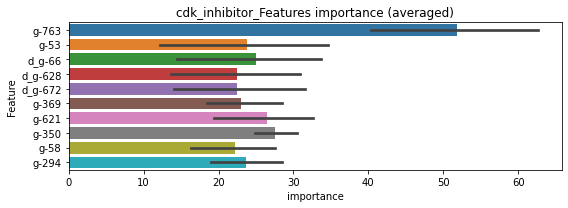

len(train_index) : 3792
len(valid_index) : 3792
================================= fold 1/2 cdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0171069	valid_1's binary_logloss: 0.0329976
[200]	training's binary_logloss: 0.00215722	valid_1's binary_logloss: 0.0216698
Early stopping, best iteration is:
[223]	training's binary_logloss: 0.00149747	valid_1's binary_logloss: 0.0212946


len(train_index) : 3792
len(valid_index) : 3792
================================= fold 2/2 cdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0170147	valid_1's binary_logloss: 0.0374488
[200]	training's binary_logloss: 0.0021778	valid_1's binary_logloss: 0.0273929
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.00104592	valid_1's binary_logloss: 0.0263679


cdk_inhibitor logloss: 0.023831214405549542


neg labels: 3289 → selected neg labels: 3280


chelating_agent, len(trt): 54, len(othr): 3280, target_rate: 0.0022676 → Adj_target_rate: 0.0024931
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0477315	valid_1's binary_logloss: 0.0977855
[200]	training's binary_logloss: 0.00834193	valid_1's binary_logloss: 0.0473401
[300]	training's binary_logloss: 0.00232929	valid_1's binary_logloss: 0.0317875
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.00197408	valid_1's binary_logloss: 0.030592
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0463033	valid_1's binary_logloss: 0.0922061
[200]	training's binary_logloss: 0.00859285	valid_1's binary_logloss: 0.0439528
[300]	training's binary_logloss: 0.00241339	valid_1's binary_logloss: 0.0340808
[400]	training's binary_logloss: 0.00110914	valid_1's binary_logloss: 0.0306764
[500]	training's binary_logloss: 0.000693296	valid_1's binary_logloss: 0.0297466
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.000667296	valid_1's binary_logloss: 0.0296014


1 / 3 AUC score:0.999
y_Threshold: 0.0088762, Threshold: 0.0123595, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → Positive_corect_labels: 653/3798
p_label_rate: 0.0200904 Vs.target_rate: 0.00227
Num_p_label: 80.0, conf_0:0.01112, conf_1:0.01360
Num_p_label: 80.0, Expected: 9.0, Adj_threshold_1: 0.0123595
Num_p_label: 17.0, Expected: 9.0, Adj_threshold_2: 0.0223595
threshold: 0.0223595, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 653.0/3798, y_label_rate: 0.1719326
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0487336	valid_1's binary_logloss: 0.0850008
[200]	training's binary_logloss: 0.00860947	valid_1's binary_logloss: 0.0307909
[300]	training's binary_logloss: 0.00240239	valid_1's binary_logloss: 0.0172781
[400]	training's binary_logloss: 0.00111041	valid_1's binary_logloss: 0.0135437
[500]	training's binary_logloss: 0.000688605	valid_1's binary_logloss: 0.0123566
Early stopping, best iteration is:
[566]	training's binary_logloss: 0.000568796	valid_1's binary_logloss: 0.0117977
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0458536	valid_1's binary_logloss: 0.107975
[200]	training's binary_logloss: 0.0076203	valid_1's binary_logloss: 0.0643228
Early stopping, best iteration is:
[237]	training's binary_logloss: 0.00447568	valid_1's binary_logloss: 0.0611739


2 / 3 AUC score:0.998
y_Threshold: 0.0389526, Threshold: 0.0223595, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 24 → Positive_corect_labels: 641.0/3774
p_label_rate: 0.0226017 Vs.target_rate: 0.00227
Num_p_label: 90.0, conf_0:0.02012, conf_1:0.02460
Num_p_label: 90.0, Expected: 9.0, Adj_threshold_1: 0.0223595
Num_p_label: 39.0, Expected: 9.0, Adj_threshold_2: 0.0323595
Num_p_label: 17.0, Expected: 9.0, Adj_threshold_3: 0.0423595
threshold: 0.0423595, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 641.0/3774, y_label_rate: 0.1698463
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0450478	valid_1's binary_logloss: 0.092966
[200]	training's binary_logloss: 0.00805482	valid_1's binary_logloss: 0.0485045
[300]	training's binary_logloss: 0.00226255	valid_1's binary_logloss: 0.0366556
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.001577	valid_1's binary_logloss: 0.034973
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0451606	valid_1's binary_logloss: 0.0832546
[200]	training's binary_logloss: 0.00802324	valid_1's binary_logloss: 0.0347698
[300]	training's binary_logloss: 0.00224793	valid_1's binary_logloss: 0.0245182
[400]	training's binary_logloss: 0.00104492	valid_1's binary_logloss: 0.0221296
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.00102239	valid_1's binary_logloss: 0.0220877


3 / 3 AUC score:0.999
y_Threshold: 0.0263242, Threshold: 0.0423595, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 634.0/3760
p_label_rate: 0.0030136 Vs.target_rate: 0.00227
Num_p_label: 12.0, conf_0:0.03812, conf_1:0.04660
threshold: 0.0423595, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 646.0/7742, y_label_rate: 0.0834410


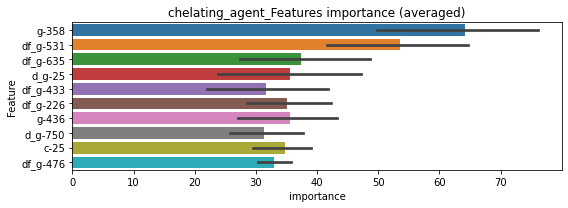

len(train_index) : 3871
len(valid_index) : 3871
================================= fold 1/2 chelating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0248387	valid_1's binary_logloss: 0.0461874
[200]	training's binary_logloss: 0.00454797	valid_1's binary_logloss: 0.0209066
[300]	training's binary_logloss: 0.00124433	valid_1's binary_logloss: 0.0152998
[400]	training's binary_logloss: 0.000565072	valid_1's binary_logloss: 0.0139126
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000502556	valid_1's binary_logloss: 0.0137289


len(train_index) : 3871
len(valid_index) : 3871
================================= fold 2/2 chelating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251434	valid_1's binary_logloss: 0.0507661
[200]	training's binary_logloss: 0.00444447	valid_1's binary_logloss: 0.0231298
[300]	training's binary_logloss: 0.0012118	valid_1's binary_logloss: 0.0168766
[400]	training's binary_logloss: 0.000552236	valid_1's binary_logloss: 0.0153891
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.000522777	valid_1's binary_logloss: 0.0152783


chelating_agent logloss: 0.01450364235532246


neg labels: 3289 → selected neg labels: 3285


chk_inhibitor, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189213	valid_1's binary_logloss: 0.0264258
[200]	training's binary_logloss: 0.00189902	valid_1's binary_logloss: 0.00528447
[300]	training's binary_logloss: 0.000520984	valid_1's binary_logloss: 0.00233128
[400]	training's binary_logloss: 0.000295147	valid_1's binary_logloss: 0.00168189
[500]	training's binary_logloss: 0.000253721	valid_1's binary_logloss: 0.00152421
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.000253721	valid_1's binary_logloss: 0.00152421
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186477	valid_1's binary_logloss: 0.0216693
[200]	training's binary_logloss: 0.001869	valid_1's binary_logloss: 0.00353677
[300]	training's binary_logloss: 0.000524756	valid_1's binary_logloss: 0.00165513
[400]	training's binary_logloss: 0.000299035	valid_1's binary_logloss: 0.00123659
Early stopping, best iteration is

1 / 3 AUC score:1.000
y_Threshold: 0.0014424, Threshold: 0.0081611, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00101
Num_p_label: 80.0, conf_0:0.00734, conf_1:0.00898
Num_p_label: 80.0, Expected: 4.0, Adj_threshold_1: 0.0081611
Num_p_label: 53.0, Expected: 4.0, Adj_threshold_2: 0.0181611
Num_p_label: 37.0, Expected: 4.0, Adj_threshold_3: 0.0281611
Num_p_label: 34.0, Expected: 4.0, Adj_threshold_4: 0.0381611
Num_p_label: 29.0, Expected: 4.0, Adj_threshold_5: 0.0481611
Num_p_label: 27.0, Expected: 4.0, Adj_threshold_6: 0.0581611
Num_p_label: 26.0, Expected: 4.0, Adj_threshold_7: 0.0681611
Num_p_label: 25.0, Expected: 4.0, Adj_threshold_8: 0.0781611
Num_p_label: 24.0, Expected: 4.0, Adj_threshold_9: 0.0881611
Num_p_label: 24.0, Expected: 4.0, Adj_threshold_10: 0.0981611
threshold: 0.1081611, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.018707	valid_1's binary_logloss: 0.0246735
[200]	training's binary_logloss: 0.00170513	valid_1's binary_logloss: 0.00371739
[300]	training's binary_logloss: 0.000449084	valid_1's binary_logloss: 0.00139669
[400]	training's binary_logloss: 0.000262489	valid_1's binary_logloss: 0.000961776
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000237901	valid_1's binary_logloss: 0.000902206
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182168	valid_1's binary_logloss: 0.020961
[200]	training's binary_logloss: 0.00165515	valid_1's binary_logloss: 0.0026054
[300]	training's binary_logloss: 0.000439551	valid_1's binary_logloss: 0.000935459
[400]	training's binary_logloss: 0.000258605	valid_1's binary_logloss: 0.000630598
[500]	training's binary_logloss: 0.000226376	valid_1's binary_logloss: 0.00057526
Early stopping, best iteration

2 / 3 AUC score:1.000
y_Threshold: 0.2157406, Threshold: 0.1081611, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0203415 Vs.target_rate: 0.00101
Num_p_label: 81.0, conf_0:0.09734, conf_1:0.11898
Num_p_label: 81.0, Expected: 4.0, Adj_threshold_1: 0.1081611
Num_p_label: 79.0, Expected: 4.0, Adj_threshold_2: 0.1181611
Num_p_label: 77.0, Expected: 4.0, Adj_threshold_3: 0.1281611
Num_p_label: 71.0, Expected: 4.0, Adj_threshold_4: 0.1381611
Num_p_label: 69.0, Expected: 4.0, Adj_threshold_5: 0.1481611
Num_p_label: 67.0, Expected: 4.0, Adj_threshold_6: 0.1581611
Num_p_label: 67.0, Expected: 4.0, Adj_threshold_7: 0.1681611
Num_p_label: 65.0, Expected: 4.0, Adj_threshold_8: 0.1781611
Num_p_label: 63.0, Expected: 4.0, Adj_threshold_9: 0.1881611
Num_p_label: 62.0, Expected: 4.0, Adj_threshold_10: 0.1981611
threshold: 0.2081611, positive_p_label: 59.0/3982, p_label_rate: 0.0148167
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.018707	valid_1's binary_logloss: 0.0246735
[200]	training's binary_logloss: 0.00170513	valid_1's binary_logloss: 0.00371739
[300]	training's binary_logloss: 0.000449084	valid_1's binary_logloss: 0.00139669
[400]	training's binary_logloss: 0.000262489	valid_1's binary_logloss: 0.000961776
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000237901	valid_1's binary_logloss: 0.000902206
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182168	valid_1's binary_logloss: 0.020961
[200]	training's binary_logloss: 0.00165515	valid_1's binary_logloss: 0.0026054
[300]	training's binary_logloss: 0.000439551	valid_1's binary_logloss: 0.000935459
[400]	training's binary_logloss: 0.000258605	valid_1's binary_logloss: 0.000630598
[500]	training's binary_logloss: 0.000226376	valid_1's binary_logloss: 0.00057526
Early stopping, best iteration

3 / 3 AUC score:1.000
y_Threshold: 0.2157406, Threshold: 0.2081611, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0148167 Vs.target_rate: 0.00101
Num_p_label: 59.0, conf_0:0.18734, conf_1:0.22898
Num_p_label: 59.0, Expected: 4.0, Adj_threshold_1: 0.2081611
Num_p_label: 57.0, Expected: 4.0, Adj_threshold_2: 0.2181611
Num_p_label: 55.0, Expected: 4.0, Adj_threshold_3: 0.2281611
Num_p_label: 55.0, Expected: 4.0, Adj_threshold_4: 0.2381611
Num_p_label: 54.0, Expected: 4.0, Adj_threshold_5: 0.2481611
Num_p_label: 53.0, Expected: 4.0, Adj_threshold_6: 0.2581611
Num_p_label: 53.0, Expected: 4.0, Adj_threshold_7: 0.2681611
Num_p_label: 53.0, Expected: 4.0, Adj_threshold_8: 0.2781611
Num_p_label: 50.0, Expected: 4.0, Adj_threshold_9: 0.2881611
Num_p_label: 48.0, Expected: 4.0, Adj_threshold_10: 0.2981611
threshold: 0.3081611, positive_p_label: 48.0/3982, p_label_rate: 0.0120542
positive_y_label: 705.0/7792, y_label_rate: 0.0904774


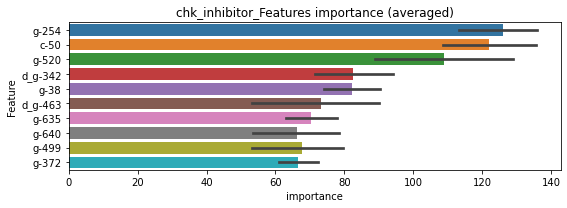

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 chk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0116574	valid_1's binary_logloss: 0.0211157
[200]	training's binary_logloss: 0.00126872	valid_1's binary_logloss: 0.0106422
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.000509647	valid_1's binary_logloss: 0.0099568


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 chk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0117578	valid_1's binary_logloss: 0.0204609
[200]	training's binary_logloss: 0.00133539	valid_1's binary_logloss: 0.00847677
Early stopping, best iteration is:
[267]	training's binary_logloss: 0.000532104	valid_1's binary_logloss: 0.00725919


chk_inhibitor logloss: 0.00860799636035861


neg labels: 3289 → selected neg labels: 3282


chloride_channel_blocker, len(trt): 42, len(othr): 3282, target_rate: 0.0017637 → Adj_target_rate: 0.0020135
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0406779	valid_1's binary_logloss: 0.0805422
[200]	training's binary_logloss: 0.00651343	valid_1's binary_logloss: 0.035509
[300]	training's binary_logloss: 0.00178519	valid_1's binary_logloss: 0.0245612
[400]	training's binary_logloss: 0.000841161	valid_1's binary_logloss: 0.0209969
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.000841161	valid_1's binary_logloss: 0.0209969
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0401316	valid_1's binary_logloss: 0.0755884
[200]	training's binary_logloss: 0.00654278	valid_1's binary_logloss: 0.0301615
[300]	training's binary_logloss: 0.00182092	valid_1's binary_logloss: 0.019495
[400]	training's binary_logloss: 0.000861461	valid_1's binary_logloss: 0.0170345
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000885793	valid_1's binary_logloss: 0.0169792


1 / 3 AUC score:1.000
y_Threshold: 0.0078001, Threshold: 0.0130878, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 136 → Positive_corect_labels: 654/3802
p_label_rate: 0.0200904 Vs.target_rate: 0.00176
Num_p_label: 80.0, conf_0:0.01178, conf_1:0.01440
Num_p_label: 80.0, Expected: 7.0, Adj_threshold_1: 0.0130878
Num_p_label: 33.0, Expected: 7.0, Adj_threshold_2: 0.0230878
Num_p_label: 22.0, Expected: 7.0, Adj_threshold_3: 0.0330878
Num_p_label: 11.0, Expected: 7.0, Adj_threshold_4: 0.0430878
threshold: 0.0430878, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 654.0/3802, y_label_rate: 0.1720147
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0378642	valid_1's binary_logloss: 0.0740487
[200]	training's binary_logloss: 0.00610175	valid_1's binary_logloss: 0.0305401
[300]	training's binary_logloss: 0.00168192	valid_1's binary_logloss: 0.0203372
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.00111267	valid_1's binary_logloss: 0.019351
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03983	valid_1's binary_logloss: 0.0607778
[200]	training's binary_logloss: 0.00645612	valid_1's binary_logloss: 0.0190463
[300]	training's binary_logloss: 0.00181838	valid_1's binary_logloss: 0.0114565
[400]	training's binary_logloss: 0.000869684	valid_1's binary_logloss: 0.00943931
Early stopping, best iteration is:
[473]	training's binary_logloss: 0.000617305	valid_1's binary_logloss: 0.00884463


2 / 3 AUC score:1.000
y_Threshold: 0.0423845, Threshold: 0.0430878, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 651.0/3796
p_label_rate: 0.0062783 Vs.target_rate: 0.00176
Num_p_label: 25.0, conf_0:0.03878, conf_1:0.04740
Num_p_label: 25.0, Expected: 7.0, Adj_threshold_1: 0.0430878
Num_p_label: 19.0, Expected: 7.0, Adj_threshold_2: 0.0530878
Num_p_label: 16.0, Expected: 7.0, Adj_threshold_3: 0.0630878
Num_p_label: 13.0, Expected: 7.0, Adj_threshold_4: 0.0730878
threshold: 0.0730878, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 651.0/3796, y_label_rate: 0.1714963
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0379277	valid_1's binary_logloss: 0.0721686
[200]	training's binary_logloss: 0.00591968	valid_1's binary_logloss: 0.0272365
[300]	training's binary_logloss: 0.00168048	valid_1's binary_logloss: 0.0185282
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.000872418	valid_1's binary_logloss: 0.0166401
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395409	valid_1's binary_logloss: 0.0625269
[200]	training's binary_logloss: 0.00627036	valid_1's binary_logloss: 0.0203461
[300]	training's binary_logloss: 0.0017669	valid_1's binary_logloss: 0.0123464
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.000913518	valid_1's binary_logloss: 0.0105874


3 / 3 AUC score:0.999
y_Threshold: 0.0356639, Threshold: 0.0730878, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 645.0/3784
p_label_rate: 0.0035158 Vs.target_rate: 0.00176
Num_p_label: 14.0, conf_0:0.06578, conf_1:0.08040
threshold: 0.0730878, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 659.0/7766, y_label_rate: 0.0848571


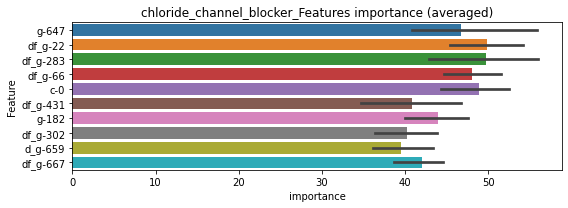

len(train_index) : 3883
len(valid_index) : 3883
================================= fold 1/2 chloride_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021608	valid_1's binary_logloss: 0.0463762
[200]	training's binary_logloss: 0.00348702	valid_1's binary_logloss: 0.0245601
[300]	training's binary_logloss: 0.000951772	valid_1's binary_logloss: 0.0214811
Early stopping, best iteration is:
[347]	training's binary_logloss: 0.000625498	valid_1's binary_logloss: 0.0207841


len(train_index) : 3883
len(valid_index) : 3883
================================= fold 2/2 chloride_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226427	valid_1's binary_logloss: 0.0397004
[200]	training's binary_logloss: 0.00371331	valid_1's binary_logloss: 0.0147448
[300]	training's binary_logloss: 0.00101701	valid_1's binary_logloss: 0.00983752
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.000595761	valid_1's binary_logloss: 0.00906412


chloride_channel_blocker logloss: 0.014924098419987587


neg labels: 3289 → selected neg labels: 3281


cholesterol_inhibitor, len(trt): 48, len(othr): 3281, target_rate: 0.0020156 → Adj_target_rate: 0.0022556
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0420006	valid_1's binary_logloss: 0.103833
[200]	training's binary_logloss: 0.00740777	valid_1's binary_logloss: 0.0690009
Early stopping, best iteration is:
[271]	training's binary_logloss: 0.00282241	valid_1's binary_logloss: 0.0650965
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.04428	valid_1's binary_logloss: 0.0867312
[200]	training's binary_logloss: 0.00785042	valid_1's binary_logloss: 0.0412385
[300]	training's binary_logloss: 0.00218425	valid_1's binary_logloss: 0.0314819
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.00170905	valid_1's binary_logloss: 0.0302504


1 / 3 AUC score:0.994
y_Threshold: 0.0121439, Threshold: 0.0152536, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 156 → Positive_corect_labels: 644/3781
p_label_rate: 0.0200904 Vs.target_rate: 0.00202
Num_p_label: 80.0, conf_0:0.01373, conf_1:0.01678
Num_p_label: 80.0, Expected: 8.0, Adj_threshold_1: 0.0152536
Num_p_label: 22.0, Expected: 8.0, Adj_threshold_2: 0.0252536
Num_p_label: 9.0, Expected: 8.0, Adj_threshold_3: 0.0352536
threshold: 0.0352536, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 644.0/3781, y_label_rate: 0.1703253
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.040735	valid_1's binary_logloss: 0.0895163
[200]	training's binary_logloss: 0.00697888	valid_1's binary_logloss: 0.0479162
[300]	training's binary_logloss: 0.00197468	valid_1's binary_logloss: 0.0400788
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00121247	valid_1's binary_logloss: 0.0373899
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0424528	valid_1's binary_logloss: 0.0716515
[200]	training's binary_logloss: 0.00739403	valid_1's binary_logloss: 0.0250592
[300]	training's binary_logloss: 0.00210557	valid_1's binary_logloss: 0.0146061
[400]	training's binary_logloss: 0.000984627	valid_1's binary_logloss: 0.011856
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000698372	valid_1's binary_logloss: 0.0109205


2 / 3 AUC score:1.000
y_Threshold: 0.0239552, Threshold: 0.0352536, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 637.0/3767
p_label_rate: 0.0035158 Vs.target_rate: 0.00202
Num_p_label: 14.0, conf_0:0.03173, conf_1:0.03878
threshold: 0.0352536, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 637.0/3767, y_label_rate: 0.1691001
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0400214	valid_1's binary_logloss: 0.0711628
[200]	training's binary_logloss: 0.00676848	valid_1's binary_logloss: 0.0274268
[300]	training's binary_logloss: 0.00192508	valid_1's binary_logloss: 0.0172266
[400]	training's binary_logloss: 0.000934326	valid_1's binary_logloss: 0.0155203
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.000711496	valid_1's binary_logloss: 0.0146886
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0402196	valid_1's binary_logloss: 0.0823404
[200]	training's binary_logloss: 0.00673959	valid_1's binary_logloss: 0.0405244
[300]	training's binary_logloss: 0.00195677	valid_1's binary_logloss: 0.0327298
[400]	training's binary_logloss: 0.000923981	valid_1's binary_logloss: 0.0309037
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.000923981	valid_1's binary_logloss: 0.0309037


3 / 3 AUC score:0.998
y_Threshold: 0.0233420, Threshold: 0.0352536, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → Positive_corect_labels: 629.0/3751
p_label_rate: 0.0025113 Vs.target_rate: 0.00202
Num_p_label: 10.0, conf_0:0.03173, conf_1:0.03878
threshold: 0.0352536, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 639.0/7733, y_label_rate: 0.0826329


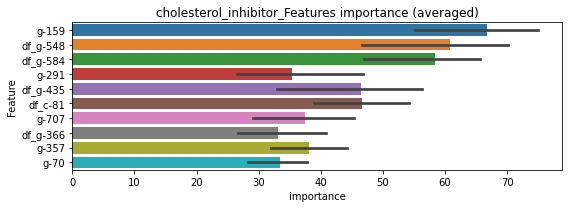

len(train_index) : 3866
len(valid_index) : 3867
================================= fold 1/2 cholesterol_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0208734	valid_1's binary_logloss: 0.0478832
[200]	training's binary_logloss: 0.003425	valid_1's binary_logloss: 0.0267997
[300]	training's binary_logloss: 0.000949372	valid_1's binary_logloss: 0.0230802
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.000940277	valid_1's binary_logloss: 0.0230749


len(train_index) : 3867
len(valid_index) : 3866
================================= fold 2/2 cholesterol_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0207802	valid_1's binary_logloss: 0.0437644
[200]	training's binary_logloss: 0.00359693	valid_1's binary_logloss: 0.0206637
[300]	training's binary_logloss: 0.00103906	valid_1's binary_logloss: 0.0165022
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.000619086	valid_1's binary_logloss: 0.0157507


cholesterol_inhibitor logloss: 0.019413295617359955


neg labels: 3289 → selected neg labels: 3280


cholinergic_receptor_antagonist, len(trt): 54, len(othr): 3280, target_rate: 0.0022676 → Adj_target_rate: 0.0024931
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.051225	valid_1's binary_logloss: 0.0984937
[200]	training's binary_logloss: 0.0101029	valid_1's binary_logloss: 0.0480492
[300]	training's binary_logloss: 0.00273754	valid_1's binary_logloss: 0.0321257
[400]	training's binary_logloss: 0.00121955	valid_1's binary_logloss: 0.0271676
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.000835457	valid_1's binary_logloss: 0.025506
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0524447	valid_1's binary_logloss: 0.111653
[200]	training's binary_logloss: 0.0093844	valid_1's binary_logloss: 0.063022
[300]	training's binary_logloss: 0.00250226	valid_1's binary_logloss: 0.0538563
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00142768	valid_1's binary_logloss: 0.0518634


1 / 3 AUC score:0.996
y_Threshold: 0.0094950, Threshold: 0.0144224, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 150 → Positive_corect_labels: 647/3786
p_label_rate: 0.0200904 Vs.target_rate: 0.00227
Num_p_label: 80.0, conf_0:0.01298, conf_1:0.01586
Num_p_label: 80.0, Expected: 9.0, Adj_threshold_1: 0.0144224
Num_p_label: 32.0, Expected: 9.0, Adj_threshold_2: 0.0244224
Num_p_label: 15.0, Expected: 9.0, Adj_threshold_3: 0.0344224
threshold: 0.0344224, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 647.0/3786, y_label_rate: 0.1708928
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0469813	valid_1's binary_logloss: 0.0915544
[200]	training's binary_logloss: 0.00896952	valid_1's binary_logloss: 0.0460687
[300]	training's binary_logloss: 0.00252678	valid_1's binary_logloss: 0.0352178
[400]	training's binary_logloss: 0.00113483	valid_1's binary_logloss: 0.0318009
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.0010244	valid_1's binary_logloss: 0.0314228
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0534274	valid_1's binary_logloss: 0.0873949
[200]	training's binary_logloss: 0.00974776	valid_1's binary_logloss: 0.0314055
[300]	training's binary_logloss: 0.00267298	valid_1's binary_logloss: 0.0173172
[400]	training's binary_logloss: 0.00120166	valid_1's binary_logloss: 0.0126129
[500]	training's binary_logloss: 0.000734	valid_1's binary_logloss: 0.0112077
Early stopping, best iteration is:
[555]	trainin

2 / 3 AUC score:1.000
y_Threshold: 0.0281812, Threshold: 0.0344224, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → Positive_corect_labels: 639.0/3770
p_label_rate: 0.0070316 Vs.target_rate: 0.00227
Num_p_label: 28.0, conf_0:0.03098, conf_1:0.03786
Num_p_label: 28.0, Expected: 9.0, Adj_threshold_1: 0.0344224
Num_p_label: 17.0, Expected: 9.0, Adj_threshold_2: 0.0444224
threshold: 0.0444224, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 639.0/3770, y_label_rate: 0.1694960
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0489477	valid_1's binary_logloss: 0.0787395
[200]	training's binary_logloss: 0.00910683	valid_1's binary_logloss: 0.024949
[300]	training's binary_logloss: 0.00257317	valid_1's binary_logloss: 0.0115722
[400]	training's binary_logloss: 0.00117723	valid_1's binary_logloss: 0.00754787
[500]	training's binary_logloss: 0.000724259	valid_1's binary_logloss: 0.00583964
[600]	training's binary_logloss: 0.00055867	valid_1's binary_logloss: 0.00524513
Early stopping, best iteration is:
[603]	training's binary_logloss: 0.000555759	valid_1's binary_logloss: 0.00524145
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0496913	valid_1's binary_logloss: 0.0902866
[200]	training's binary_logloss: 0.00913703	valid_1's binary_logloss: 0.036248
[300]	training's binary_logloss: 0.00254748	valid_1's binary_logloss: 0.0230564
[400]	training's binary_logloss: 0.001154

3 / 3 AUC score:1.000
y_Threshold: 0.0409048, Threshold: 0.0444224, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 637.0/3766
p_label_rate: 0.0050226 Vs.target_rate: 0.00227
Num_p_label: 20.0, conf_0:0.03998, conf_1:0.04886
threshold: 0.0444224, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 657.0/7748, y_label_rate: 0.0847961


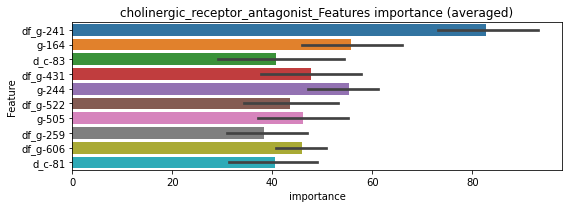

len(train_index) : 3874
len(valid_index) : 3874
================================= fold 1/2 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286494	valid_1's binary_logloss: 0.0570493
[200]	training's binary_logloss: 0.00569331	valid_1's binary_logloss: 0.0290027
[300]	training's binary_logloss: 0.00151778	valid_1's binary_logloss: 0.022947
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.000743255	valid_1's binary_logloss: 0.0218297


len(train_index) : 3874
len(valid_index) : 3874
================================= fold 2/2 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281768	valid_1's binary_logloss: 0.0570241
[200]	training's binary_logloss: 0.00546814	valid_1's binary_logloss: 0.0316996
[300]	training's binary_logloss: 0.00146364	valid_1's binary_logloss: 0.0258034
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.00134668	valid_1's binary_logloss: 0.0255585


cholinergic_receptor_antagonist logloss: 0.02369410170222307


neg labels: 3289 → selected neg labels: 3285


coagulation_factor_inhibitor, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027507	valid_1's binary_logloss: 0.0473807
[200]	training's binary_logloss: 0.00359796	valid_1's binary_logloss: 0.0133187
[300]	training's binary_logloss: 0.00100296	valid_1's binary_logloss: 0.00679494
Early stopping, best iteration is:
[387]	training's binary_logloss: 0.000546626	valid_1's binary_logloss: 0.00500042
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270573	valid_1's binary_logloss: 0.0389718
[200]	training's binary_logloss: 0.00353033	valid_1's binary_logloss: 0.00809078
[300]	training's binary_logloss: 0.000993246	valid_1's binary_logloss: 0.00337036
[400]	training's binary_logloss: 0.000504881	valid_1's binary_logloss: 0.0021353
[500]	training's binary_logloss: 0.000372658	valid_1's binary_logloss: 0.00175428
Early stopping, best iteration is:
[528]	training's binary_logloss: 0.000366092	valid_1's binary_logloss: 0.00173913


1 / 3 AUC score:1.000
y_Threshold: 0.0028766, Threshold: 0.0037877, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00101
Num_p_label: 80.0, conf_0:0.00341, conf_1:0.00417
Num_p_label: 80.0, Expected: 4.0, Adj_threshold_1: 0.0037877
Num_p_label: 5.0, Expected: 4.0, Adj_threshold_2: 0.0137877
threshold: 0.0137877, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264135	valid_1's binary_logloss: 0.0436955
[200]	training's binary_logloss: 0.00336851	valid_1's binary_logloss: 0.0113949
[300]	training's binary_logloss: 0.000957182	valid_1's binary_logloss: 0.0057301
[400]	training's binary_logloss: 0.000489362	valid_1's binary_logloss: 0.00407958
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.000428713	valid_1's binary_logloss: 0.00374293
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026987	valid_1's binary_logloss: 0.0366935
[200]	training's binary_logloss: 0.00342728	valid_1's binary_logloss: 0.00707293
[300]	training's binary_logloss: 0.000968373	valid_1's binary_logloss: 0.0028917
[400]	training's binary_logloss: 0.000499998	valid_1's binary_logloss: 0.00178944
[500]	training's binary_logloss: 0.000376185	valid_1's binary_logloss: 0.00148153
Early stopping, best iteration is:


2 / 3 AUC score:1.000
y_Threshold: 0.0872444, Threshold: 0.0137877, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0050226 Vs.target_rate: 0.00101
Num_p_label: 20.0, conf_0:0.01241, conf_1:0.01517
Num_p_label: 20.0, Expected: 4.0, Adj_threshold_1: 0.0137877
Num_p_label: 5.0, Expected: 4.0, Adj_threshold_2: 0.0237877
threshold: 0.0237877, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264135	valid_1's binary_logloss: 0.0436955
[200]	training's binary_logloss: 0.00336851	valid_1's binary_logloss: 0.0113949
[300]	training's binary_logloss: 0.000957182	valid_1's binary_logloss: 0.0057301
[400]	training's binary_logloss: 0.000489362	valid_1's binary_logloss: 0.00407958
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.000428713	valid_1's binary_logloss: 0.00374293
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026987	valid_1's binary_logloss: 0.0366935
[200]	training's binary_logloss: 0.00342728	valid_1's binary_logloss: 0.00707293
[300]	training's binary_logloss: 0.000968373	valid_1's binary_logloss: 0.0028917
[400]	training's binary_logloss: 0.000499998	valid_1's binary_logloss: 0.00178944
[500]	training's binary_logloss: 0.000376185	valid_1's binary_logloss: 0.00148153
Early stopping, best iteration is:


3 / 3 AUC score:1.000
y_Threshold: 0.0872444, Threshold: 0.0237877, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0012557 Vs.target_rate: 0.00101
Num_p_label: 5.0, conf_0:0.02141, conf_1:0.02617
threshold: 0.0237877, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 662.0/7792, y_label_rate: 0.0849589


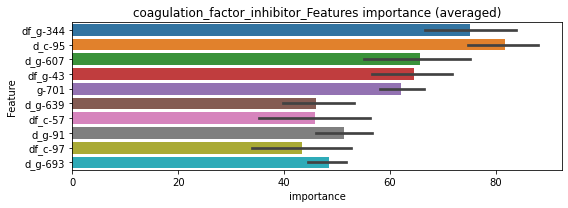

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0151293	valid_1's binary_logloss: 0.0261158
[200]	training's binary_logloss: 0.00190941	valid_1's binary_logloss: 0.0103172
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.000628709	valid_1's binary_logloss: 0.00860968


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0149564	valid_1's binary_logloss: 0.0260842
[200]	training's binary_logloss: 0.00190175	valid_1's binary_logloss: 0.0112187
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.000791806	valid_1's binary_logloss: 0.00960358


coagulation_factor_inhibitor logloss: 0.009106628538375194


neg labels: 3289 → selected neg labels: 3284


corticosteroid_agonist, len(trt): 36, len(othr): 3284, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250814	valid_1's binary_logloss: 0.0417824
[200]	training's binary_logloss: 0.00322826	valid_1's binary_logloss: 0.0147525
[300]	training's binary_logloss: 0.000943923	valid_1's binary_logloss: 0.00988694
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.000902926	valid_1's binary_logloss: 0.00972786
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251235	valid_1's binary_logloss: 0.0543139
[200]	training's binary_logloss: 0.00327263	valid_1's binary_logloss: 0.0343405
[300]	training's binary_logloss: 0.00096165	valid_1's binary_logloss: 0.0310575
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.000970342	valid_1's binary_logloss: 0.0310278


1 / 3 AUC score:1.000
y_Threshold: 0.0033997, Threshold: 0.0049066, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00151
Num_p_label: 80.0, conf_0:0.00442, conf_1:0.00540
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0049066
Num_p_label: 45.0, Expected: 6.0, Adj_threshold_2: 0.0149066
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_3: 0.0249066
Num_p_label: 36.0, Expected: 6.0, Adj_threshold_4: 0.0349066
Num_p_label: 35.0, Expected: 6.0, Adj_threshold_5: 0.0449066
Num_p_label: 35.0, Expected: 6.0, Adj_threshold_6: 0.0549066
Num_p_label: 34.0, Expected: 6.0, Adj_threshold_7: 0.0649066
Num_p_label: 29.0, Expected: 6.0, Adj_threshold_8: 0.0749066
Num_p_label: 29.0, Expected: 6.0, Adj_threshold_9: 0.0849066
Num_p_label: 26.0, Expected: 6.0, Adj_threshold_10: 0.0949066
threshold: 0.1049066, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229501	valid_1's binary_logloss: 0.033955
[200]	training's binary_logloss: 0.00274208	valid_1's binary_logloss: 0.00765943
[300]	training's binary_logloss: 0.000774907	valid_1's binary_logloss: 0.00342439
[400]	training's binary_logloss: 0.000417687	valid_1's binary_logloss: 0.00270818
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00033447	valid_1's binary_logloss: 0.00237293
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228068	valid_1's binary_logloss: 0.0436255
[200]	training's binary_logloss: 0.00262876	valid_1's binary_logloss: 0.0238579
Early stopping, best iteration is:
[239]	training's binary_logloss: 0.00144602	valid_1's binary_logloss: 0.0229169


2 / 3 AUC score:1.000
y_Threshold: 0.0238311, Threshold: 0.1049066, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 653.0/3802
p_label_rate: 0.0113009 Vs.target_rate: 0.00151
Num_p_label: 45.0, conf_0:0.09442, conf_1:0.11540
Num_p_label: 45.0, Expected: 6.0, Adj_threshold_1: 0.1049066
Num_p_label: 44.0, Expected: 6.0, Adj_threshold_2: 0.1149066
Num_p_label: 44.0, Expected: 6.0, Adj_threshold_3: 0.1249066
Num_p_label: 44.0, Expected: 6.0, Adj_threshold_4: 0.1349066
Num_p_label: 44.0, Expected: 6.0, Adj_threshold_5: 0.1449066
Num_p_label: 43.0, Expected: 6.0, Adj_threshold_6: 0.1549066
Num_p_label: 43.0, Expected: 6.0, Adj_threshold_7: 0.1649066
Num_p_label: 43.0, Expected: 6.0, Adj_threshold_8: 0.1749066
Num_p_label: 41.0, Expected: 6.0, Adj_threshold_9: 0.1849066
Num_p_label: 41.0, Expected: 6.0, Adj_threshold_10: 0.1949066
threshold: 0.2049066, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 653.0/3802, y_label_rate: 0.1717517
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232245	valid_1's binary_logloss: 0.0358382
[200]	training's binary_logloss: 0.00272006	valid_1's binary_logloss: 0.010538
[300]	training's binary_logloss: 0.000782667	valid_1's binary_logloss: 0.00645717
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.00064554	valid_1's binary_logloss: 0.00585072
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233907	valid_1's binary_logloss: 0.0369848
[200]	training's binary_logloss: 0.0026753	valid_1's binary_logloss: 0.0115922
[300]	training's binary_logloss: 0.00076122	valid_1's binary_logloss: 0.00839246
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.000562988	valid_1's binary_logloss: 0.0077128


3 / 3 AUC score:1.000
y_Threshold: 0.0162765, Threshold: 0.2049066, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 651.0/3798
p_label_rate: 0.0100452 Vs.target_rate: 0.00151
Num_p_label: 40.0, conf_0:0.18442, conf_1:0.22540
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_1: 0.2049066
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_2: 0.2149066
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_3: 0.2249066
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_4: 0.2349066
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_5: 0.2449066
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_6: 0.2549066
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_7: 0.2649066
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_8: 0.2749066
Num_p_label: 38.0, Expected: 6.0, Adj_threshold_9: 0.2849066
Num_p_label: 38.0, Expected: 6.0, Adj_threshold_10: 0.2949066
threshold: 0.3049066, positive_p_label: 38.0/3982, p_label_rate: 0.0095429
positive_y_label: 689.0/7780, y_label_rate: 0.0885604


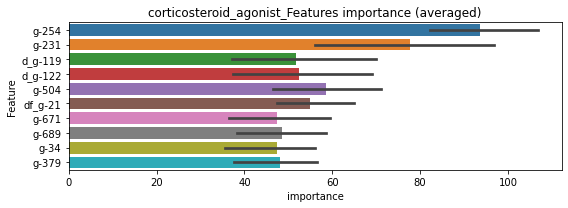

len(train_index) : 3890
len(valid_index) : 3890
================================= fold 1/2 corticosteroid_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0124943	valid_1's binary_logloss: 0.0235256
[200]	training's binary_logloss: 0.00137038	valid_1's binary_logloss: 0.00849801
[300]	training's binary_logloss: 0.000383583	valid_1's binary_logloss: 0.0067497
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.000219053	valid_1's binary_logloss: 0.00610334


len(train_index) : 3890
len(valid_index) : 3890
================================= fold 2/2 corticosteroid_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0126929	valid_1's binary_logloss: 0.0241517
[200]	training's binary_logloss: 0.00142461	valid_1's binary_logloss: 0.00826496
[300]	training's binary_logloss: 0.000401596	valid_1's binary_logloss: 0.0052264
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000286304	valid_1's binary_logloss: 0.00459318


corticosteroid_agonist logloss: 0.005348257655321609


neg labels: 3289 → selected neg labels: 3215


cyclooxygenase_inhibitor, len(trt): 435, len(othr): 3215, target_rate: 0.0182666 → Adj_target_rate: 0.0146863
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122109	valid_1's binary_logloss: 0.379265
Early stopping, best iteration is:
[145]	training's binary_logloss: 0.0776732	valid_1's binary_logloss: 0.375636
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133071	valid_1's binary_logloss: 0.366634
Early stopping, best iteration is:
[181]	training's binary_logloss: 0.0610165	valid_1's binary_logloss: 0.360017


1 / 3 AUC score:0.774
y_Threshold: 0.1310199, Threshold: 0.1907909, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 733 → Positive_corect_labels: 341/3125
p_label_rate: 0.0200904 Vs.target_rate: 0.01827
Num_p_label: 80.0, conf_0:0.17171, conf_1:0.20987
threshold: 0.1907909, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 341.0/3125, y_label_rate: 0.1091200
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0608971	valid_1's binary_logloss: 0.212103
Early stopping, best iteration is:
[150]	training's binary_logloss: 0.0338117	valid_1's binary_logloss: 0.201457
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0652537	valid_1's binary_logloss: 0.207152
Early stopping, best iteration is:
[165]	training's binary_logloss: 0.0269816	valid_1's binary_logloss: 0.190393


2 / 3 AUC score:0.922
y_Threshold: 0.0998062, Threshold: 0.1907909, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 210 → Positive_corect_labels: 236.0/2915
p_label_rate: 0.0185836 Vs.target_rate: 0.01827
Num_p_label: 74.0, conf_0:0.17171, conf_1:0.20987
threshold: 0.1907909, positive_p_label: 74.0/3982, p_label_rate: 0.0185836
positive_y_label: 236.0/2915, y_label_rate: 0.0809605
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03695	valid_1's binary_logloss: 0.150804
Early stopping, best iteration is:
[151]	training's binary_logloss: 0.0166211	valid_1's binary_logloss: 0.141465
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0346655	valid_1's binary_logloss: 0.148565
Early stopping, best iteration is:
[170]	training's binary_logloss: 0.011896	valid_1's binary_logloss: 0.141078


3 / 3 AUC score:0.947
y_Threshold: 0.0829813, Threshold: 0.1907909, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 122 → Positive_corect_labels: 175.0/2793
p_label_rate: 0.0193370 Vs.target_rate: 0.01827
Num_p_label: 77.0, conf_0:0.17171, conf_1:0.20987
threshold: 0.1907909, positive_p_label: 77.0/3982, p_label_rate: 0.0193370
positive_y_label: 252.0/6775, y_label_rate: 0.0371956


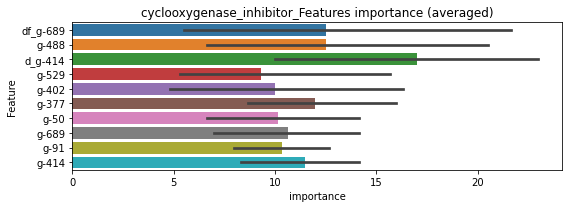

len(train_index) : 3387
len(valid_index) : 3388
================================= fold 1/2 cyclooxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163816	valid_1's binary_logloss: 0.0827899
Early stopping, best iteration is:
[166]	training's binary_logloss: 0.00605673	valid_1's binary_logloss: 0.0777663


len(train_index) : 3388
len(valid_index) : 3387
================================= fold 2/2 cyclooxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162338	valid_1's binary_logloss: 0.0788484
Early stopping, best iteration is:
[149]	training's binary_logloss: 0.00733128	valid_1's binary_logloss: 0.0730746


cyclooxygenase_inhibitor logloss: 0.07542077106371889


neg labels: 3289 → selected neg labels: 3274


cytochrome_p450_inhibitor, len(trt): 104, len(othr): 3274, target_rate: 0.0043672 → Adj_target_rate: 0.0043519
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0717281	valid_1's binary_logloss: 0.173934
[200]	training's binary_logloss: 0.0183318	valid_1's binary_logloss: 0.120065
[300]	training's binary_logloss: 0.00559749	valid_1's binary_logloss: 0.103299
Early stopping, best iteration is:
[373]	training's binary_logloss: 0.00287672	valid_1's binary_logloss: 0.098869
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0718666	valid_1's binary_logloss: 0.146495
[200]	training's binary_logloss: 0.0178815	valid_1's binary_logloss: 0.0818279
[300]	training's binary_logloss: 0.00544497	valid_1's binary_logloss: 0.0619057
[400]	training's binary_logloss: 0.00235753	valid_1's binary_logloss: 0.056928
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00174701	valid_1's binary_logloss: 0.0551789


1 / 3 AUC score:0.991
y_Threshold: 0.0209489, Threshold: 0.0266671, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 172 → Positive_corect_labels: 634/3756
p_label_rate: 0.0200904 Vs.target_rate: 0.00437
Num_p_label: 80.0, conf_0:0.02400, conf_1:0.02933
Num_p_label: 80.0, Expected: 17.4, Adj_threshold_1: 0.0266671
Num_p_label: 43.0, Expected: 17.4, Adj_threshold_2: 0.0366671
Num_p_label: 29.0, Expected: 17.4, Adj_threshold_3: 0.0466671
threshold: 0.0466671, positive_p_label: 29.0/3982, p_label_rate: 0.0072828
positive_y_label: 634.0/3756, y_label_rate: 0.1687966
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0684248	valid_1's binary_logloss: 0.143802
[200]	training's binary_logloss: 0.0168281	valid_1's binary_logloss: 0.0796043
[300]	training's binary_logloss: 0.0050442	valid_1's binary_logloss: 0.0604117
[400]	training's binary_logloss: 0.00218615	valid_1's binary_logloss: 0.0546555
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.0018578	valid_1's binary_logloss: 0.0535178
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0662529	valid_1's binary_logloss: 0.156211
[200]	training's binary_logloss: 0.0157018	valid_1's binary_logloss: 0.108457
[300]	training's binary_logloss: 0.00471075	valid_1's binary_logloss: 0.0945628
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00448634	valid_1's binary_logloss: 0.0942134


2 / 3 AUC score:0.993
y_Threshold: 0.0529567, Threshold: 0.0466671, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 54 → Positive_corect_labels: 607.0/3702
p_label_rate: 0.0178302 Vs.target_rate: 0.00437
Num_p_label: 71.0, conf_0:0.04200, conf_1:0.05133
Num_p_label: 71.0, Expected: 17.4, Adj_threshold_1: 0.0466671
Num_p_label: 44.0, Expected: 17.4, Adj_threshold_2: 0.0566671
Num_p_label: 33.0, Expected: 17.4, Adj_threshold_3: 0.0666671
threshold: 0.0666671, positive_p_label: 33.0/3982, p_label_rate: 0.0082873
positive_y_label: 607.0/3702, y_label_rate: 0.1639654
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0605203	valid_1's binary_logloss: 0.150645
[200]	training's binary_logloss: 0.0136518	valid_1's binary_logloss: 0.102713
[300]	training's binary_logloss: 0.00406385	valid_1's binary_logloss: 0.0921616
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.00289262	valid_1's binary_logloss: 0.0896778
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0665032	valid_1's binary_logloss: 0.137936
[200]	training's binary_logloss: 0.0154511	valid_1's binary_logloss: 0.0714326
[300]	training's binary_logloss: 0.00449098	valid_1's binary_logloss: 0.0491172
[400]	training's binary_logloss: 0.00193991	valid_1's binary_logloss: 0.0416967
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00182513	valid_1's binary_logloss: 0.0413451


3 / 3 AUC score:0.992
y_Threshold: 0.0483140, Threshold: 0.0666671, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 44 → Positive_corect_labels: 585.0/3658
p_label_rate: 0.0110497 Vs.target_rate: 0.00437
Num_p_label: 44.0, conf_0:0.06000, conf_1:0.07333
threshold: 0.0666671, positive_p_label: 44.0/3982, p_label_rate: 0.0110497
positive_y_label: 629.0/7640, y_label_rate: 0.0823298


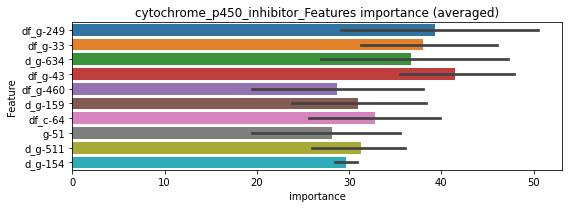

len(train_index) : 3820
len(valid_index) : 3820
================================= fold 1/2 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0362726	valid_1's binary_logloss: 0.0815677
[200]	training's binary_logloss: 0.0083262	valid_1's binary_logloss: 0.0496766
[300]	training's binary_logloss: 0.00245463	valid_1's binary_logloss: 0.0422172
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00210298	valid_1's binary_logloss: 0.0419595


len(train_index) : 3820
len(valid_index) : 3820
================================= fold 2/2 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0363566	valid_1's binary_logloss: 0.0897058
[200]	training's binary_logloss: 0.0088755	valid_1's binary_logloss: 0.0661964
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.0042692	valid_1's binary_logloss: 0.0631664


cytochrome_p450_inhibitor logloss: 0.05256293297286339


neg labels: 3289 → selected neg labels: 3283


dihydrofolate_reductase_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0307449	valid_1's binary_logloss: 0.0453206
[200]	training's binary_logloss: 0.00423008	valid_1's binary_logloss: 0.0111652
[300]	training's binary_logloss: 0.00118477	valid_1's binary_logloss: 0.00517729
[400]	training's binary_logloss: 0.000586503	valid_1's binary_logloss: 0.00360259
[500]	training's binary_logloss: 0.000412851	valid_1's binary_logloss: 0.003167
Early stopping, best iteration is:
[562]	training's binary_logloss: 0.000386797	valid_1's binary_logloss: 0.00310237
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0307845	valid_1's binary_logloss: 0.0581224
[200]	training's binary_logloss: 0.00427159	valid_1's binary_logloss: 0.0253746
[300]	training's binary_logloss: 0.00119479	valid_1's binary_logloss: 0.0183384
[400]	training's binary_logloss: 0.000586864	valid_1's binary_logloss: 0.01646
Early stopping, best iteration is:
[393]	

1 / 3 AUC score:1.000
y_Threshold: 0.0025379, Threshold: 0.0039640, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151
Num_p_label: 80.0, conf_0:0.00357, conf_1:0.00436
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0039640
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_2: 0.0139640
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_3: 0.0239640
threshold: 0.0239640, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304534	valid_1's binary_logloss: 0.0438784
[200]	training's binary_logloss: 0.00400631	valid_1's binary_logloss: 0.00895151
[300]	training's binary_logloss: 0.00113316	valid_1's binary_logloss: 0.00350282
[400]	training's binary_logloss: 0.000566008	valid_1's binary_logloss: 0.00209699
[500]	training's binary_logloss: 0.000401701	valid_1's binary_logloss: 0.00166902
Early stopping, best iteration is:
[547]	training's binary_logloss: 0.000385395	valid_1's binary_logloss: 0.00163897
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0299361	valid_1's binary_logloss: 0.0544379
[200]	training's binary_logloss: 0.00404977	valid_1's binary_logloss: 0.0218977
[300]	training's binary_logloss: 0.00113548	valid_1's binary_logloss: 0.0156407
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.000988669	valid_1's binary_logloss: 0.015023


2 / 3 AUC score:1.000
y_Threshold: 0.0203550, Threshold: 0.0239640, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0062783 Vs.target_rate: 0.00151
Num_p_label: 25.0, conf_0:0.02157, conf_1:0.02636
Num_p_label: 25.0, Expected: 6.0, Adj_threshold_1: 0.0239640
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_2: 0.0339640
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_3: 0.0439640
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_4: 0.0539640
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_5: 0.0639640
threshold: 0.0639640, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304534	valid_1's binary_logloss: 0.0438784
[200]	training's binary_logloss: 0.00400631	valid_1's binary_logloss: 0.00895151
[300]	training's binary_logloss: 0.00113316	valid_1's binary_logloss: 0.00350282
[400]	training's binary_logloss: 0.000566008	valid_1's binary_logloss: 0.00209699
[500]	training's binary_logloss: 0.000401701	valid_1's binary_logloss: 0.00166902
Early stopping, best iteration is:
[547]	training's binary_logloss: 0.000385395	valid_1's binary_logloss: 0.00163897
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0299361	valid_1's binary_logloss: 0.0544379
[200]	training's binary_logloss: 0.00404977	valid_1's binary_logloss: 0.0218977
[300]	training's binary_logloss: 0.00113548	valid_1's binary_logloss: 0.0156407
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.000988669	valid_1's binary_logloss: 0.015023


3 / 3 AUC score:1.000
y_Threshold: 0.0203550, Threshold: 0.0639640, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0027624 Vs.target_rate: 0.00151
Num_p_label: 11.0, conf_0:0.05757, conf_1:0.07036
threshold: 0.0639640, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 667.0/7789, y_label_rate: 0.0856336


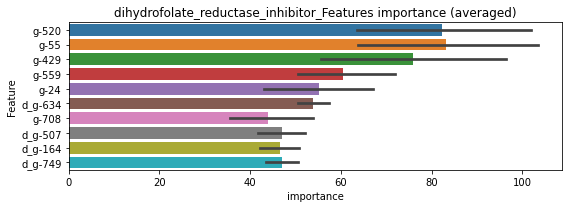

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160537	valid_1's binary_logloss: 0.030481
[200]	training's binary_logloss: 0.00213577	valid_1's binary_logloss: 0.0111201
[300]	training's binary_logloss: 0.000590663	valid_1's binary_logloss: 0.00767223
[400]	training's binary_logloss: 0.000291583	valid_1's binary_logloss: 0.00714044
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000242395	valid_1's binary_logloss: 0.00698035


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165529	valid_1's binary_logloss: 0.0250548
[200]	training's binary_logloss: 0.00223817	valid_1's binary_logloss: 0.00570398
[300]	training's binary_logloss: 0.000616439	valid_1's binary_logloss: 0.00251789
[400]	training's binary_logloss: 0.000302446	valid_1's binary_logloss: 0.00178136
[500]	training's binary_logloss: 0.000213168	valid_1's binary_logloss: 0.00154157
Early stopping, best iteration is:
[547]	training's binary_logloss: 0.000205366	valid_1's binary_logloss: 0.00152507


dihydrofolate_reductase_inhibitor logloss: 0.004253276790909554


neg labels: 3289 → selected neg labels: 3285


dipeptidyl_peptidase_inhibitor, len(trt): 25, len(othr): 3285, target_rate: 0.0010498 → Adj_target_rate: 0.0012955
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285204	valid_1's binary_logloss: 0.0447148
[200]	training's binary_logloss: 0.00365951	valid_1's binary_logloss: 0.0136719
[300]	training's binary_logloss: 0.00101825	valid_1's binary_logloss: 0.009149
[400]	training's binary_logloss: 0.00050498	valid_1's binary_logloss: 0.00775019
[500]	training's binary_logloss: 0.000369965	valid_1's binary_logloss: 0.00737301
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.000369376	valid_1's binary_logloss: 0.00737215
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282527	valid_1's binary_logloss: 0.0387956
[200]	training's binary_logloss: 0.00369353	valid_1's binary_logloss: 0.00688782
[300]	training's binary_logloss: 0.00103597	valid_1's binary_logloss: 0.00242798
[400]	training's binary_logloss: 0.00052068	valid_1's binary_logloss: 0.00138253
[500]	training's binary_logloss: 0.000

1 / 3 AUC score:1.000
y_Threshold: 0.0020372, Threshold: 0.0027224, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00105
Num_p_label: 80.0, conf_0:0.00245, conf_1:0.00299
Num_p_label: 80.0, Expected: 4.2, Adj_threshold_1: 0.0027224
Num_p_label: 6.0, Expected: 4.2, Adj_threshold_2: 0.0127224
threshold: 0.0127224, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281701	valid_1's binary_logloss: 0.0439261
[200]	training's binary_logloss: 0.00356971	valid_1's binary_logloss: 0.0125947
[300]	training's binary_logloss: 0.0010049	valid_1's binary_logloss: 0.00897177
[400]	training's binary_logloss: 0.000500056	valid_1's binary_logloss: 0.00786211
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.000485391	valid_1's binary_logloss: 0.00783535
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275041	valid_1's binary_logloss: 0.0365948
[200]	training's binary_logloss: 0.00348697	valid_1's binary_logloss: 0.0062631
[300]	training's binary_logloss: 0.000986388	valid_1's binary_logloss: 0.0022175
[400]	training's binary_logloss: 0.000505424	valid_1's binary_logloss: 0.00128856
[500]	training's binary_logloss: 0.000376927	valid_1's binary_logloss: 0.00102837
Early stopping, best iteration is:
[

2 / 3 AUC score:1.000
y_Threshold: 0.0130392, Threshold: 0.0127224, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0055249 Vs.target_rate: 0.00105
Num_p_label: 22.0, conf_0:0.01145, conf_1:0.01399
Num_p_label: 22.0, Expected: 4.2, Adj_threshold_1: 0.0127224
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_2: 0.0227224
Num_p_label: 6.0, Expected: 4.2, Adj_threshold_3: 0.0327224
threshold: 0.0327224, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281701	valid_1's binary_logloss: 0.0439261
[200]	training's binary_logloss: 0.00356971	valid_1's binary_logloss: 0.0125947
[300]	training's binary_logloss: 0.0010049	valid_1's binary_logloss: 0.00897177
[400]	training's binary_logloss: 0.000500056	valid_1's binary_logloss: 0.00786211
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.000485391	valid_1's binary_logloss: 0.00783535
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275041	valid_1's binary_logloss: 0.0365948
[200]	training's binary_logloss: 0.00348697	valid_1's binary_logloss: 0.0062631
[300]	training's binary_logloss: 0.000986388	valid_1's binary_logloss: 0.0022175
[400]	training's binary_logloss: 0.000505424	valid_1's binary_logloss: 0.00128856
[500]	training's binary_logloss: 0.000376927	valid_1's binary_logloss: 0.00102837
Early stopping, best iteration is:
[

3 / 3 AUC score:1.000
y_Threshold: 0.0130392, Threshold: 0.0327224, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0015068 Vs.target_rate: 0.00105
Num_p_label: 6.0, conf_0:0.02945, conf_1:0.03599
threshold: 0.0327224, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7792, y_label_rate: 0.0850873


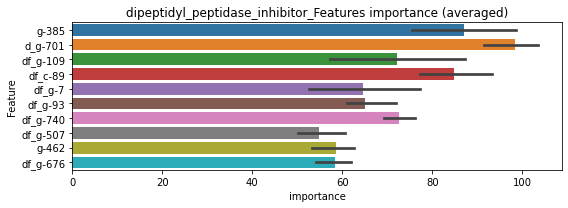

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0153079	valid_1's binary_logloss: 0.0257934
[200]	training's binary_logloss: 0.00192497	valid_1's binary_logloss: 0.00996097
[300]	training's binary_logloss: 0.000517044	valid_1's binary_logloss: 0.00823855
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.000552558	valid_1's binary_logloss: 0.00819931


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0151591	valid_1's binary_logloss: 0.0267921
[200]	training's binary_logloss: 0.00194562	valid_1's binary_logloss: 0.00898571
[300]	training's binary_logloss: 0.000530476	valid_1's binary_logloss: 0.00580823
[400]	training's binary_logloss: 0.000261659	valid_1's binary_logloss: 0.00496904
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.000242657	valid_1's binary_logloss: 0.00490658


dipeptidyl_peptidase_inhibitor logloss: 0.006552944869856739


neg labels: 3289 → selected neg labels: 3288


diuretic, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0153831	valid_1's binary_logloss: 0.0174115
[200]	training's binary_logloss: 0.0012441	valid_1's binary_logloss: 0.00231849
[300]	training's binary_logloss: 0.00033988	valid_1's binary_logloss: 0.00111381
[400]	training's binary_logloss: 0.000212111	valid_1's binary_logloss: 0.000904269
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000193692	valid_1's binary_logloss: 0.000872241
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154412	valid_1's binary_logloss: 0.0167383
[200]	training's binary_logloss: 0.00124857	valid_1's binary_logloss: 0.001829
[300]	training's binary_logloss: 0.000336804	valid_1's binary_logloss: 0.000719436
[400]	training's binary_logloss: 0.000209843	valid_1's binary_logloss: 0.000488638
[500]	training's binary_logloss: 0.00018341	valid_1's binary_logloss: 0.000434464
Early stopping, best iteration 

1 / 3 AUC score:1.000
y_Threshold: 0.0005617, Threshold: 0.0011220, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0200904 Vs.target_rate: 0.00025
Num_p_label: 80.0, conf_0:0.00101, conf_1:0.00123
Num_p_label: 80.0, Expected: 1.0, Adj_threshold_1: 0.0011220
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_2: 0.0111220
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_3: 0.0211220
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_4: 0.0311220
threshold: 0.0311220, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157384	valid_1's binary_logloss: 0.0186543
[200]	training's binary_logloss: 0.0012474	valid_1's binary_logloss: 0.0031307
[300]	training's binary_logloss: 0.000333163	valid_1's binary_logloss: 0.00177353
[400]	training's binary_logloss: 0.000210037	valid_1's binary_logloss: 0.00149433
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.000192725	valid_1's binary_logloss: 0.00143747
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157392	valid_1's binary_logloss: 0.0229394
[200]	training's binary_logloss: 0.00125255	valid_1's binary_logloss: 0.0104749
Early stopping, best iteration is:
[259]	training's binary_logloss: 0.000496314	valid_1's binary_logloss: 0.0097191


2 / 3 AUC score:1.000
y_Threshold: 0.0136960, Threshold: 0.0311220, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0037670 Vs.target_rate: 0.00025
Num_p_label: 15.0, conf_0:0.02801, conf_1:0.03423
Num_p_label: 15.0, Expected: 1.0, Adj_threshold_1: 0.0311220
Num_p_label: 12.0, Expected: 1.0, Adj_threshold_2: 0.0411220
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_3: 0.0511220
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_4: 0.0611220
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_5: 0.0711220
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_6: 0.0811220
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_7: 0.0911220
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_8: 0.1011220
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_9: 0.1111220
threshold: 0.1111220, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157384	valid_1's binary_logloss: 0.0186543
[200]	training's binary_logloss: 0.0012474	valid_1's binary_logloss: 0.0031307
[300]	training's binary_logloss: 0.000333163	valid_1's binary_logloss: 0.00177353
[400]	training's binary_logloss: 0.000210037	valid_1's binary_logloss: 0.00149433
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.000192725	valid_1's binary_logloss: 0.00143747
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157392	valid_1's binary_logloss: 0.0229394
[200]	training's binary_logloss: 0.00125255	valid_1's binary_logloss: 0.0104749
Early stopping, best iteration is:
[259]	training's binary_logloss: 0.000496314	valid_1's binary_logloss: 0.0097191


3 / 3 AUC score:1.000
y_Threshold: 0.0136960, Threshold: 0.1111220, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0005023 Vs.target_rate: 0.00025
Num_p_label: 2.0, conf_0:0.10001, conf_1:0.12223
threshold: 0.1111220, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 659.0/7795, y_label_rate: 0.0845414


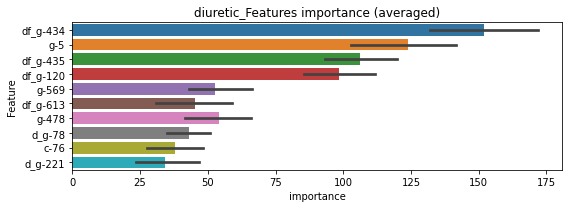

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 diuretic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00838265	valid_1's binary_logloss: 0.00899523
[200]	training's binary_logloss: 0.000669885	valid_1's binary_logloss: 0.00114768
[300]	training's binary_logloss: 0.000175437	valid_1's binary_logloss: 0.000723893
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.000182654	valid_1's binary_logloss: 0.000716784


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 diuretic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00839095	valid_1's binary_logloss: 0.0106387
[200]	training's binary_logloss: 0.000659406	valid_1's binary_logloss: 0.00284287
[300]	training's binary_logloss: 0.000173578	valid_1's binary_logloss: 0.00180736
[400]	training's binary_logloss: 0.000108455	valid_1's binary_logloss: 0.00164557
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000100201	valid_1's binary_logloss: 0.00161879


diuretic logloss: 0.0011677297666343595


neg labels: 3289 → selected neg labels: 3281


dna_alkylating_agent, len(trt): 48, len(othr): 3281, target_rate: 0.0020156 → Adj_target_rate: 0.0022556
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0408133	valid_1's binary_logloss: 0.0803317
[200]	training's binary_logloss: 0.00696539	valid_1's binary_logloss: 0.0314396
[300]	training's binary_logloss: 0.00195355	valid_1's binary_logloss: 0.0174395
[400]	training's binary_logloss: 0.000926797	valid_1's binary_logloss: 0.0129602
[500]	training's binary_logloss: 0.000602099	valid_1's binary_logloss: 0.0114514
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000610962	valid_1's binary_logloss: 0.0113916
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0410979	valid_1's binary_logloss: 0.0743173
[200]	training's binary_logloss: 0.00692313	valid_1's binary_logloss: 0.0267048
[300]	training's binary_logloss: 0.00199082	valid_1's binary_logloss: 0.0165915
[400]	training's binary_logloss: 0.000949362	valid_1's binary_logloss: 0.0141646
[500]	training's binary_logloss: 0.000612

1 / 3 AUC score:0.999
y_Threshold: 0.0054648, Threshold: 0.0099659, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 655/3803
p_label_rate: 0.0200904 Vs.target_rate: 0.00202
Num_p_label: 80.0, conf_0:0.00897, conf_1:0.01096
Num_p_label: 80.0, Expected: 8.0, Adj_threshold_1: 0.0099659
Num_p_label: 30.0, Expected: 8.0, Adj_threshold_2: 0.0199659
Num_p_label: 16.0, Expected: 8.0, Adj_threshold_3: 0.0299659
threshold: 0.0299659, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 655.0/3803, y_label_rate: 0.1722324
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0398238	valid_1's binary_logloss: 0.0789362
[200]	training's binary_logloss: 0.00655104	valid_1's binary_logloss: 0.0380488
[300]	training's binary_logloss: 0.00186519	valid_1's binary_logloss: 0.0288371
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.001266	valid_1's binary_logloss: 0.0267877
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395393	valid_1's binary_logloss: 0.0684337
[200]	training's binary_logloss: 0.00634247	valid_1's binary_logloss: 0.0227219
[300]	training's binary_logloss: 0.00183007	valid_1's binary_logloss: 0.0124734
[400]	training's binary_logloss: 0.000895034	valid_1's binary_logloss: 0.00959749
[500]	training's binary_logloss: 0.000575796	valid_1's binary_logloss: 0.00836606
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000544089	valid_1's binary_logloss: 0.00829706


2 / 3 AUC score:1.000
y_Threshold: 0.0338617, Threshold: 0.0299659, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 653.0/3799
p_label_rate: 0.0140633 Vs.target_rate: 0.00202
Num_p_label: 56.0, conf_0:0.02697, conf_1:0.03296
Num_p_label: 56.0, Expected: 8.0, Adj_threshold_1: 0.0299659
Num_p_label: 42.0, Expected: 8.0, Adj_threshold_2: 0.0399659
Num_p_label: 35.0, Expected: 8.0, Adj_threshold_3: 0.0499659
Num_p_label: 27.0, Expected: 8.0, Adj_threshold_4: 0.0599659
Num_p_label: 21.0, Expected: 8.0, Adj_threshold_5: 0.0699659
Num_p_label: 16.0, Expected: 8.0, Adj_threshold_6: 0.0799659
threshold: 0.0799659, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 653.0/3799, y_label_rate: 0.1718873
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0381948	valid_1's binary_logloss: 0.0751983
[200]	training's binary_logloss: 0.00629865	valid_1's binary_logloss: 0.0322149
[300]	training's binary_logloss: 0.00183959	valid_1's binary_logloss: 0.0224791
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.00182136	valid_1's binary_logloss: 0.0224169
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0413301	valid_1's binary_logloss: 0.073986
[200]	training's binary_logloss: 0.00659648	valid_1's binary_logloss: 0.027973
[300]	training's binary_logloss: 0.00187156	valid_1's binary_logloss: 0.0176072
[400]	training's binary_logloss: 0.000901012	valid_1's binary_logloss: 0.0141828
[500]	training's binary_logloss: 0.000580707	valid_1's binary_logloss: 0.0127374
Early stopping, best iteration is:
[518]	training's binary_logloss: 0.000550638	valid_1's binary_logloss: 0.0124936


3 / 3 AUC score:1.000
y_Threshold: 0.0649731, Threshold: 0.0799659, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 653.0/3799
p_label_rate: 0.0040181 Vs.target_rate: 0.00202
Num_p_label: 16.0, conf_0:0.07197, conf_1:0.08796
threshold: 0.0799659, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 669.0/7781, y_label_rate: 0.0859787


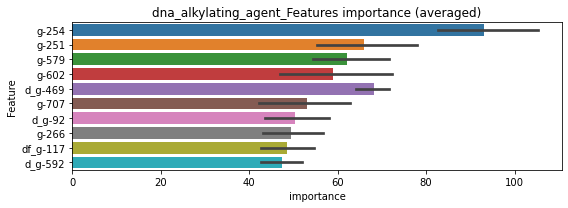

len(train_index) : 3890
len(valid_index) : 3891
================================= fold 1/2 dna_alkylating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225817	valid_1's binary_logloss: 0.0492081
[200]	training's binary_logloss: 0.00375691	valid_1's binary_logloss: 0.0254173
[300]	training's binary_logloss: 0.000993439	valid_1's binary_logloss: 0.0196124
[400]	training's binary_logloss: 0.000459501	valid_1's binary_logloss: 0.0181819
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000356963	valid_1's binary_logloss: 0.0177039


len(train_index) : 3891
len(valid_index) : 3890
================================= fold 2/2 dna_alkylating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0216831	valid_1's binary_logloss: 0.055387
[200]	training's binary_logloss: 0.00361115	valid_1's binary_logloss: 0.0335582
Early stopping, best iteration is:
[286]	training's binary_logloss: 0.00114905	valid_1's binary_logloss: 0.0301606


dna_alkylating_agent logloss: 0.023931444698130563


neg labels: 3289 → selected neg labels: 3229


dna_inhibitor, len(trt): 402, len(othr): 3229, target_rate: 0.0168808 → Adj_target_rate: 0.0137338
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11746	valid_1's binary_logloss: 0.355059
Early stopping, best iteration is:
[134]	training's binary_logloss: 0.0804244	valid_1's binary_logloss: 0.350075
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1091	valid_1's binary_logloss: 0.364379
Early stopping, best iteration is:
[132]	training's binary_logloss: 0.0756191	valid_1's binary_logloss: 0.360872


1 / 3 AUC score:0.792
y_Threshold: 0.1198871, Threshold: 0.1815939, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 686 → Positive_corect_labels: 367/3188
p_label_rate: 0.0200904 Vs.target_rate: 0.01688
Num_p_label: 80.0, conf_0:0.16343, conf_1:0.19975
threshold: 0.1815939, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 367.0/3188, y_label_rate: 0.1151192
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0551892	valid_1's binary_logloss: 0.223295
Early stopping, best iteration is:
[150]	training's binary_logloss: 0.0265773	valid_1's binary_logloss: 0.216661
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0522699	valid_1's binary_logloss: 0.215139
Early stopping, best iteration is:
[157]	training's binary_logloss: 0.0229149	valid_1's binary_logloss: 0.203776


2 / 3 AUC score:0.911
y_Threshold: 0.0717887, Threshold: 0.1815939, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 192 → Positive_corect_labels: 271.0/2996
p_label_rate: 0.0200904 Vs.target_rate: 0.01688
Num_p_label: 80.0, conf_0:0.16343, conf_1:0.19975
threshold: 0.1815939, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 271.0/2996, y_label_rate: 0.0904539
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0360014	valid_1's binary_logloss: 0.143688
Early stopping, best iteration is:
[165]	training's binary_logloss: 0.0129673	valid_1's binary_logloss: 0.130682
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0325778	valid_1's binary_logloss: 0.153787
Early stopping, best iteration is:
[162]	training's binary_logloss: 0.0126689	valid_1's binary_logloss: 0.146926


3 / 3 AUC score:0.957
y_Threshold: 0.0570459, Threshold: 0.1815939, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 98 → Positive_corect_labels: 222.0/2898
p_label_rate: 0.0371673 Vs.target_rate: 0.01688
Num_p_label: 148.0, conf_0:0.16343, conf_1:0.19975
threshold: 0.1815939, positive_p_label: 148.0/3982, p_label_rate: 0.0371673
positive_y_label: 370.0/6880, y_label_rate: 0.0537791


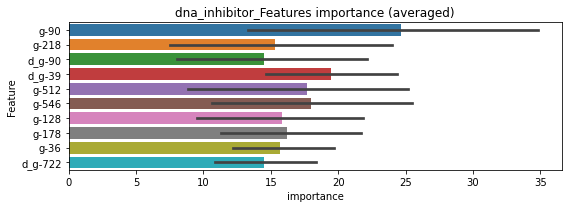

len(train_index) : 3440
len(valid_index) : 3440
================================= fold 1/2 dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160832	valid_1's binary_logloss: 0.0745055
Early stopping, best iteration is:
[167]	training's binary_logloss: 0.00507386	valid_1's binary_logloss: 0.0683305


len(train_index) : 3440
len(valid_index) : 3440
================================= fold 2/2 dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0169579	valid_1's binary_logloss: 0.0611621
[200]	training's binary_logloss: 0.00352378	valid_1's binary_logloss: 0.0499487
[300]	training's binary_logloss: 0.00121411	valid_1's binary_logloss: 0.0462111
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.0010682	valid_1's binary_logloss: 0.0458743


dna_inhibitor logloss: 0.05710239691233576


neg labels: 3289 → selected neg labels: 3267


dopamine_receptor_agonist, len(trt): 121, len(othr): 3267, target_rate: 0.0050810 → Adj_target_rate: 0.0049495
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0690886	valid_1's binary_logloss: 0.183541
[200]	training's binary_logloss: 0.0183575	valid_1's binary_logloss: 0.144077
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.0101116	valid_1's binary_logloss: 0.140288
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0736194	valid_1's binary_logloss: 0.164891
[200]	training's binary_logloss: 0.0210801	valid_1's binary_logloss: 0.115379
[300]	training's binary_logloss: 0.00661587	valid_1's binary_logloss: 0.102121
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00374287	valid_1's binary_logloss: 0.0998221


1 / 3 AUC score:0.967
y_Threshold: 0.0338176, Threshold: 0.0494854, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 229 → Positive_corect_labels: 604/3691
p_label_rate: 0.0200904 Vs.target_rate: 0.00508
Num_p_label: 80.0, conf_0:0.04454, conf_1:0.05443
Num_p_label: 80.0, Expected: 20.2, Adj_threshold_1: 0.0494854
Num_p_label: 46.0, Expected: 20.2, Adj_threshold_2: 0.0594854
Num_p_label: 28.0, Expected: 20.2, Adj_threshold_3: 0.0694854
threshold: 0.0694854, positive_p_label: 28.0/3982, p_label_rate: 0.0070316
positive_y_label: 604.0/3691, y_label_rate: 0.1636413
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0646136	valid_1's binary_logloss: 0.147077
[200]	training's binary_logloss: 0.0155827	valid_1's binary_logloss: 0.0973873
[300]	training's binary_logloss: 0.00475937	valid_1's binary_logloss: 0.0845599
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.00414996	valid_1's binary_logloss: 0.0836198
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0612771	valid_1's binary_logloss: 0.153573
[200]	training's binary_logloss: 0.0146313	valid_1's binary_logloss: 0.110102
[300]	training's binary_logloss: 0.00442478	valid_1's binary_logloss: 0.102166
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.00471861	valid_1's binary_logloss: 0.102055


2 / 3 AUC score:0.986
y_Threshold: 0.0511595, Threshold: 0.0694854, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 80 → Positive_corect_labels: 564.0/3611
p_label_rate: 0.0128076 Vs.target_rate: 0.00508
Num_p_label: 51.0, conf_0:0.06254, conf_1:0.07643
threshold: 0.0694854, positive_p_label: 51.0/3982, p_label_rate: 0.0128076
positive_y_label: 564.0/3611, y_label_rate: 0.1561894
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.051279	valid_1's binary_logloss: 0.135911
[200]	training's binary_logloss: 0.0117815	valid_1's binary_logloss: 0.0993146
[300]	training's binary_logloss: 0.00355862	valid_1's binary_logloss: 0.0914805
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.00326253	valid_1's binary_logloss: 0.0912835
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0524955	valid_1's binary_logloss: 0.123459
[200]	training's binary_logloss: 0.0117152	valid_1's binary_logloss: 0.0807912
[300]	training's binary_logloss: 0.00359006	valid_1's binary_logloss: 0.0710367
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.00355208	valid_1's binary_logloss: 0.0710364


3 / 3 AUC score:0.988
y_Threshold: 0.0468831, Threshold: 0.0694854, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 58 → Positive_corect_labels: 535.0/3553
p_label_rate: 0.0135610 Vs.target_rate: 0.00508
Num_p_label: 54.0, conf_0:0.06254, conf_1:0.07643
threshold: 0.0694854, positive_p_label: 54.0/3982, p_label_rate: 0.0135610
positive_y_label: 589.0/7535, y_label_rate: 0.0781685


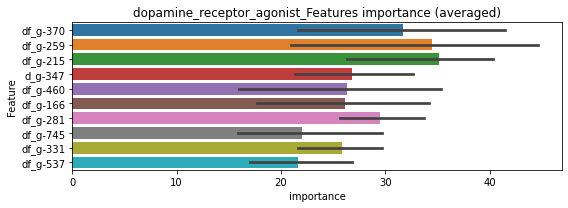

len(train_index) : 3767
len(valid_index) : 3768
================================= fold 1/2 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0300337	valid_1's binary_logloss: 0.0875085
[200]	training's binary_logloss: 0.00688746	valid_1's binary_logloss: 0.0691183
Early stopping, best iteration is:
[244]	training's binary_logloss: 0.00386682	valid_1's binary_logloss: 0.0672869


len(train_index) : 3768
len(valid_index) : 3767
================================= fold 2/2 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0322177	valid_1's binary_logloss: 0.0698399
[200]	training's binary_logloss: 0.00774137	valid_1's binary_logloss: 0.0449149
[300]	training's binary_logloss: 0.00234682	valid_1's binary_logloss: 0.0405986
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00246047	valid_1's binary_logloss: 0.0404938


dopamine_receptor_agonist logloss: 0.05389212063171894


neg labels: 3289 → selected neg labels: 3221


dopamine_receptor_antagonist, len(trt): 424, len(othr): 3221, target_rate: 0.0178047 → Adj_target_rate: 0.0143701
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123378	valid_1's binary_logloss: 0.375726
Early stopping, best iteration is:
[129]	training's binary_logloss: 0.0931308	valid_1's binary_logloss: 0.371276
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127017	valid_1's binary_logloss: 0.361145
Early stopping, best iteration is:
[141]	training's binary_logloss: 0.0838149	valid_1's binary_logloss: 0.356379


1 / 3 AUC score:0.775
y_Threshold: 0.1373494, Threshold: 0.1943595, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 713 → Positive_corect_labels: 352/3152
p_label_rate: 0.0200904 Vs.target_rate: 0.01780
Num_p_label: 80.0, conf_0:0.17492, conf_1:0.21380
threshold: 0.1943595, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 352.0/3152, y_label_rate: 0.1116751
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0590743	valid_1's binary_logloss: 0.229041
Early stopping, best iteration is:
[144]	training's binary_logloss: 0.0323208	valid_1's binary_logloss: 0.22013
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0537693	valid_1's binary_logloss: 0.211676
Early stopping, best iteration is:
[171]	training's binary_logloss: 0.0195138	valid_1's binary_logloss: 0.19986


2 / 3 AUC score:0.924
y_Threshold: 0.0833571, Threshold: 0.1943595, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 206 → Positive_corect_labels: 249.0/2946
p_label_rate: 0.0040181 Vs.target_rate: 0.01780
Num_p_label: 16.0, conf_0:0.17492, conf_1:0.21380
Num_p_label: 16.0, Expected: 70.9, Adj_threshold_1: 0.1943595
Num_p_label: 17.0, Expected: 70.9, Adj_threshold_2: 0.1843595
Num_p_label: 18.0, Expected: 70.9, Adj_threshold_3: 0.1743595
Num_p_label: 25.0, Expected: 70.9, Adj_threshold_4: 0.1643595
Num_p_label: 31.0, Expected: 70.9, Adj_threshold_5: 0.1543595
Num_p_label: 36.0, Expected: 70.9, Adj_threshold_6: 0.1443595
threshold: 0.1443595, positive_p_label: 36.0/3982, p_label_rate: 0.0090407
positive_y_label: 249.0/2946, y_label_rate: 0.0845214
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334286	valid_1's binary_logloss: 0.163722
Early stopping, best iteration is:
[142]	training's binary_logloss: 0.016578	valid_1's binary_logloss: 0.157095
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0337246	valid_1's binary_logloss: 0.158396
Early stopping, best iteration is:
[152]	training's binary_logloss: 0.0147478	valid_1's binary_logloss: 0.145805


3 / 3 AUC score:0.951
y_Threshold: 0.0638368, Threshold: 0.1443595, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 122 → Positive_corect_labels: 188.0/2824
p_label_rate: 0.0107986 Vs.target_rate: 0.01780
Num_p_label: 43.0, conf_0:0.12992, conf_1:0.15880
threshold: 0.1443595, positive_p_label: 43.0/3982, p_label_rate: 0.0107986
positive_y_label: 231.0/6806, y_label_rate: 0.0339406


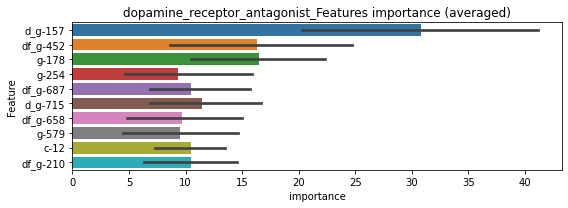

len(train_index) : 3403
len(valid_index) : 3403
================================= fold 1/2 dopamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.013902	valid_1's binary_logloss: 0.0726076
Early stopping, best iteration is:
[166]	training's binary_logloss: 0.00477409	valid_1's binary_logloss: 0.0676945


len(train_index) : 3403
len(valid_index) : 3403
================================= fold 2/2 dopamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0135054	valid_1's binary_logloss: 0.0768884
Early stopping, best iteration is:
[160]	training's binary_logloss: 0.00496883	valid_1's binary_logloss: 0.0741897


dopamine_receptor_antagonist logloss: 0.07094213244266222


neg labels: 3289 → selected neg labels: 3264


egfr_inhibitor, len(trt): 336, len(othr): 3264, target_rate: 0.0141093 → Adj_target_rate: 0.0117920
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0423627	valid_1's binary_logloss: 0.130857
[200]	training's binary_logloss: 0.00781532	valid_1's binary_logloss: 0.113276
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.00781532	valid_1's binary_logloss: 0.113276
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0447736	valid_1's binary_logloss: 0.114472
[200]	training's binary_logloss: 0.00868247	valid_1's binary_logloss: 0.0894371
Early stopping, best iteration is:
[263]	training's binary_logloss: 0.00395088	valid_1's binary_logloss: 0.0855478


1 / 3 AUC score:0.983
y_Threshold: 0.0316590, Threshold: 0.2348869, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 196 → Positive_corect_labels: 620/3720
p_label_rate: 0.0200904 Vs.target_rate: 0.01411
Num_p_label: 80.0, conf_0:0.21140, conf_1:0.25838
threshold: 0.2348869, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 620.0/3720, y_label_rate: 0.1666667
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0358136	valid_1's binary_logloss: 0.0875172
[200]	training's binary_logloss: 0.00593396	valid_1's binary_logloss: 0.0646276
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.00308865	valid_1's binary_logloss: 0.0629845
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339331	valid_1's binary_logloss: 0.0897788
[200]	training's binary_logloss: 0.00556734	valid_1's binary_logloss: 0.0608595
[300]	training's binary_logloss: 0.00167255	valid_1's binary_logloss: 0.0545234
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00119833	valid_1's binary_logloss: 0.0532386


2 / 3 AUC score:0.996
y_Threshold: 0.0719358, Threshold: 0.2348869, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 52 → Positive_corect_labels: 594.0/3668
p_label_rate: 0.0273732 Vs.target_rate: 0.01411
Num_p_label: 109.0, conf_0:0.21140, conf_1:0.25838
threshold: 0.2348869, positive_p_label: 109.0/3982, p_label_rate: 0.0273732
positive_y_label: 594.0/3668, y_label_rate: 0.1619411
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315608	valid_1's binary_logloss: 0.0751499
[200]	training's binary_logloss: 0.00500287	valid_1's binary_logloss: 0.0432432
[300]	training's binary_logloss: 0.00164696	valid_1's binary_logloss: 0.0353093
[400]	training's binary_logloss: 0.00092864	valid_1's binary_logloss: 0.0328866
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000967236	valid_1's binary_logloss: 0.032867
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319318	valid_1's binary_logloss: 0.0693562
[200]	training's binary_logloss: 0.00499503	valid_1's binary_logloss: 0.0407315
[300]	training's binary_logloss: 0.00148347	valid_1's binary_logloss: 0.0352113
Early stopping, best iteration is:
[327]	training's binary_logloss: 0.00117723	valid_1's binary_logloss: 0.0341906


3 / 3 AUC score:1.000
y_Threshold: 0.0602901, Threshold: 0.2348869, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 24 → Positive_corect_labels: 582.0/3644
p_label_rate: 0.0288800 Vs.target_rate: 0.01411
Num_p_label: 115.0, conf_0:0.21140, conf_1:0.25838
threshold: 0.2348869, positive_p_label: 115.0/3982, p_label_rate: 0.0288800
positive_y_label: 697.0/7626, y_label_rate: 0.0913978


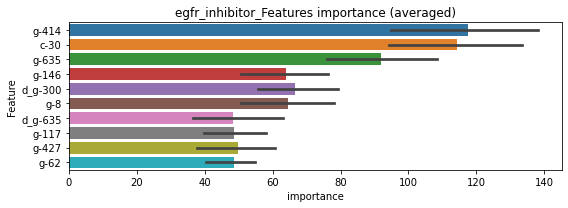

len(train_index) : 3813
len(valid_index) : 3813
================================= fold 1/2 egfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184822	valid_1's binary_logloss: 0.0518797
[200]	training's binary_logloss: 0.00307319	valid_1's binary_logloss: 0.0342013
[300]	training's binary_logloss: 0.00100205	valid_1's binary_logloss: 0.0301377
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.000666016	valid_1's binary_logloss: 0.0295397


len(train_index) : 3813
len(valid_index) : 3813
================================= fold 2/2 egfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183614	valid_1's binary_logloss: 0.0465212
[200]	training's binary_logloss: 0.00301022	valid_1's binary_logloss: 0.031123
[300]	training's binary_logloss: 0.000906371	valid_1's binary_logloss: 0.0278221
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.000623215	valid_1's binary_logloss: 0.0266688


egfr_inhibitor logloss: 0.028104261907563058


neg labels: 3289 → selected neg labels: 3287


elastase_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189077	valid_1's binary_logloss: 0.0261796
[200]	training's binary_logloss: 0.00193133	valid_1's binary_logloss: 0.00577038
[300]	training's binary_logloss: 0.000551777	valid_1's binary_logloss: 0.00256909
[400]	training's binary_logloss: 0.000312329	valid_1's binary_logloss: 0.00182085
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.000270662	valid_1's binary_logloss: 0.00169402
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188906	valid_1's binary_logloss: 0.0222369
[200]	training's binary_logloss: 0.00193145	valid_1's binary_logloss: 0.00300906
[300]	training's binary_logloss: 0.000555431	valid_1's binary_logloss: 0.00105389
[400]	training's binary_logloss: 0.000311275	valid_1's binary_logloss: 0.000639009
[500]	training's binary_logloss: 0.000273702	valid_1's binary_logloss: 0.000577148
Early stopping, best iteratio

1 / 3 AUC score:1.000
y_Threshold: 0.0009184, Threshold: 0.0012515, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050
Num_p_label: 80.0, conf_0:0.00113, conf_1:0.00138
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0012515
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_2: 0.0112515
threshold: 0.0112515, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192092	valid_1's binary_logloss: 0.0258036
[200]	training's binary_logloss: 0.00189972	valid_1's binary_logloss: 0.00551173
[300]	training's binary_logloss: 0.000544871	valid_1's binary_logloss: 0.00232374
[400]	training's binary_logloss: 0.000309292	valid_1's binary_logloss: 0.00158819
[500]	training's binary_logloss: 0.000270431	valid_1's binary_logloss: 0.00147219
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.000271362	valid_1's binary_logloss: 0.00146819
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190341	valid_1's binary_logloss: 0.0215816
[200]	training's binary_logloss: 0.00191273	valid_1's binary_logloss: 0.00247237
[300]	training's binary_logloss: 0.000554633	valid_1's binary_logloss: 0.000770218
[400]	training's binary_logloss: 0.000312905	valid_1's binary_logloss: 0.000449557
[500]	training's binary_loglo

2 / 3 AUC score:1.000
y_Threshold: 0.1044904, Threshold: 0.0112515, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0027624 Vs.target_rate: 0.00050
Num_p_label: 11.0, conf_0:0.01013, conf_1:0.01238
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_1: 0.0112515
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_2: 0.0212515
Num_p_label: 1.0, Expected: 2.0, Adj_threshold_3: 0.0312515
threshold: 0.0312515, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192092	valid_1's binary_logloss: 0.0258036
[200]	training's binary_logloss: 0.00189972	valid_1's binary_logloss: 0.00551173
[300]	training's binary_logloss: 0.000544871	valid_1's binary_logloss: 0.00232374
[400]	training's binary_logloss: 0.000309292	valid_1's binary_logloss: 0.00158819
[500]	training's binary_logloss: 0.000270431	valid_1's binary_logloss: 0.00147219
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.000271362	valid_1's binary_logloss: 0.00146819
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190341	valid_1's binary_logloss: 0.0215816
[200]	training's binary_logloss: 0.00191273	valid_1's binary_logloss: 0.00247237
[300]	training's binary_logloss: 0.000554633	valid_1's binary_logloss: 0.000770218
[400]	training's binary_logloss: 0.000312905	valid_1's binary_logloss: 0.000449557
[500]	training's binary_loglo

3 / 3 AUC score:1.000
y_Threshold: 0.1044904, Threshold: 0.0312515, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0002511 Vs.target_rate: 0.00050
Num_p_label: 1.0, conf_0:0.02813, conf_1:0.03438
threshold: 0.0312515, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 658.0/7794, y_label_rate: 0.0844239


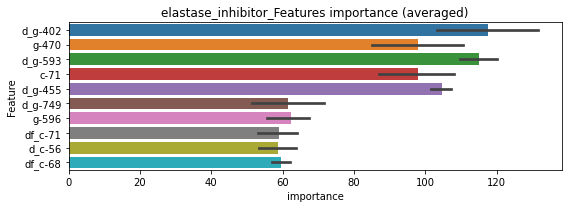

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 elastase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0100492	valid_1's binary_logloss: 0.0131438
[200]	training's binary_logloss: 0.000966823	valid_1's binary_logloss: 0.00267958
[300]	training's binary_logloss: 0.000270392	valid_1's binary_logloss: 0.00173632
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000161453	valid_1's binary_logloss: 0.00159737


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 elastase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0100899	valid_1's binary_logloss: 0.0131786
[200]	training's binary_logloss: 0.000993016	valid_1's binary_logloss: 0.00246725
[300]	training's binary_logloss: 0.00027926	valid_1's binary_logloss: 0.000996813
[400]	training's binary_logloss: 0.000155614	valid_1's binary_logloss: 0.000683897
[500]	training's binary_logloss: 0.000134936	valid_1's binary_logloss: 0.000643108
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.000135211	valid_1's binary_logloss: 0.000642946


elastase_inhibitor logloss: 0.001120201526820568


neg labels: 3289 → selected neg labels: 3284


erbb2_inhibitor, len(trt): 20, len(othr): 3284, target_rate: 0.0008398 → Adj_target_rate: 0.0010717
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261461	valid_1's binary_logloss: 0.0353983
[200]	training's binary_logloss: 0.00328809	valid_1's binary_logloss: 0.00610725
[300]	training's binary_logloss: 0.000913485	valid_1's binary_logloss: 0.00210707
[400]	training's binary_logloss: 0.000464093	valid_1's binary_logloss: 0.0012088
[500]	training's binary_logloss: 0.000359607	valid_1's binary_logloss: 0.000998101
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000355791	valid_1's binary_logloss: 0.000996072
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261041	valid_1's binary_logloss: 0.0360293
[200]	training's binary_logloss: 0.00322608	valid_1's binary_logloss: 0.00729202
[300]	training's binary_logloss: 0.000900976	valid_1's binary_logloss: 0.00305407
[400]	training's binary_logloss: 0.00046167	valid_1's binary_logloss: 0.00186705
[500]	training's binary_logloss

1 / 3 AUC score:1.000
y_Threshold: 0.0013502, Threshold: 0.0019575, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00084
Num_p_label: 80.0, conf_0:0.00176, conf_1:0.00215
Num_p_label: 80.0, Expected: 3.3, Adj_threshold_1: 0.0019575
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_2: 0.0119575
threshold: 0.0119575, positive_p_label: 0.0/3982, p_label_rate: 0.0000000
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0255731	valid_1's binary_logloss: 0.0358041
[200]	training's binary_logloss: 0.00315955	valid_1's binary_logloss: 0.00639406
[300]	training's binary_logloss: 0.000888229	valid_1's binary_logloss: 0.00228886
[400]	training's binary_logloss: 0.000450997	valid_1's binary_logloss: 0.00135657
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000363526	valid_1's binary_logloss: 0.0011658
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0263019	valid_1's binary_logloss: 0.0357996
[200]	training's binary_logloss: 0.00327601	valid_1's binary_logloss: 0.00672541
[300]	training's binary_logloss: 0.000909127	valid_1's binary_logloss: 0.00251983
[400]	training's binary_logloss: 0.000468201	valid_1's binary_logloss: 0.00151089
[500]	training's binary_logloss: 0.000358691	valid_1's binary_logloss: 0.00126598
Early stopping, best iteration i

2 / 3 AUC score:1.000
y_Threshold: 0.1422121, Threshold: 0.0119575, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0020090 Vs.target_rate: 0.00084
Num_p_label: 8.0, conf_0:0.01076, conf_1:0.01315
threshold: 0.0119575, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0255731	valid_1's binary_logloss: 0.0358041
[200]	training's binary_logloss: 0.00315955	valid_1's binary_logloss: 0.00639406
[300]	training's binary_logloss: 0.000888229	valid_1's binary_logloss: 0.00228886
[400]	training's binary_logloss: 0.000450997	valid_1's binary_logloss: 0.00135657
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000363526	valid_1's binary_logloss: 0.0011658
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0263019	valid_1's binary_logloss: 0.0357996
[200]	training's binary_logloss: 0.00327601	valid_1's binary_logloss: 0.00672541
[300]	training's binary_logloss: 0.000909127	valid_1's binary_logloss: 0.00251983
[400]	training's binary_logloss: 0.000468201	valid_1's binary_logloss: 0.00151089
[500]	training's binary_logloss: 0.000358691	valid_1's binary_logloss: 0.00126598
Early stopping, best iteration i

3 / 3 AUC score:1.000
y_Threshold: 0.1422121, Threshold: 0.0119575, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0020090 Vs.target_rate: 0.00084
Num_p_label: 8.0, conf_0:0.01076, conf_1:0.01315
threshold: 0.0119575, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 664.0/7790, y_label_rate: 0.0852375


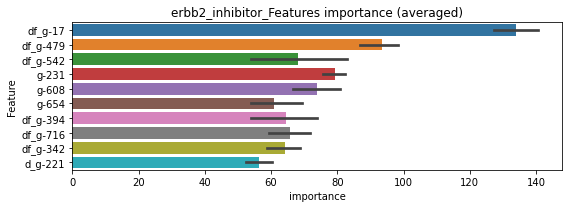

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 erbb2_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0138605	valid_1's binary_logloss: 0.0219204
[200]	training's binary_logloss: 0.00170717	valid_1's binary_logloss: 0.00833715
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.000718888	valid_1's binary_logloss: 0.00740788


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 erbb2_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0145359	valid_1's binary_logloss: 0.0203447
[200]	training's binary_logloss: 0.00187457	valid_1's binary_logloss: 0.0048692
[300]	training's binary_logloss: 0.000529308	valid_1's binary_logloss: 0.00310641
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000285997	valid_1's binary_logloss: 0.00281014


erbb2_inhibitor logloss: 0.0051090108780127465


neg labels: 3289 → selected neg labels: 3265


estrogen_receptor_agonist, len(trt): 158, len(othr): 3265, target_rate: 0.0066348 → Adj_target_rate: 0.0062095
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0839942	valid_1's binary_logloss: 0.2011
[200]	training's binary_logloss: 0.0246723	valid_1's binary_logloss: 0.15268
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00944604	valid_1's binary_logloss: 0.140491
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0812573	valid_1's binary_logloss: 0.1846
[200]	training's binary_logloss: 0.0238795	valid_1's binary_logloss: 0.1317
[300]	training's binary_logloss: 0.00871124	valid_1's binary_logloss: 0.117007
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00643273	valid_1's binary_logloss: 0.11513


1 / 3 AUC score:0.976
y_Threshold: 0.0416944, Threshold: 0.0598395, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 247 → Positive_corect_labels: 595/3671
p_label_rate: 0.0200904 Vs.target_rate: 0.00663
Num_p_label: 80.0, conf_0:0.05386, conf_1:0.06582
Num_p_label: 80.0, Expected: 26.4, Adj_threshold_1: 0.0598395
Num_p_label: 61.0, Expected: 26.4, Adj_threshold_2: 0.0698395
Num_p_label: 47.0, Expected: 26.4, Adj_threshold_3: 0.0798395
threshold: 0.0798395, positive_p_label: 47.0/3982, p_label_rate: 0.0118031
positive_y_label: 595.0/3671, y_label_rate: 0.1620812
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0683966	valid_1's binary_logloss: 0.168619
[200]	training's binary_logloss: 0.0170608	valid_1's binary_logloss: 0.125773
Early stopping, best iteration is:
[274]	training's binary_logloss: 0.00697343	valid_1's binary_logloss: 0.119143
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0696326	valid_1's binary_logloss: 0.158133
[200]	training's binary_logloss: 0.0183098	valid_1's binary_logloss: 0.103693
[300]	training's binary_logloss: 0.00562446	valid_1's binary_logloss: 0.0885557
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.00475912	valid_1's binary_logloss: 0.0873826


2 / 3 AUC score:0.987
y_Threshold: 0.0653838, Threshold: 0.0798395, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 86 → Positive_corect_labels: 552.0/3585
p_label_rate: 0.0168257 Vs.target_rate: 0.00663
Num_p_label: 67.0, conf_0:0.07186, conf_1:0.08782
threshold: 0.0798395, positive_p_label: 67.0/3982, p_label_rate: 0.0168257
positive_y_label: 552.0/3585, y_label_rate: 0.1539749
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0595591	valid_1's binary_logloss: 0.152727
[200]	training's binary_logloss: 0.0144174	valid_1's binary_logloss: 0.110601
Early stopping, best iteration is:
[269]	training's binary_logloss: 0.00620291	valid_1's binary_logloss: 0.101993
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0639572	valid_1's binary_logloss: 0.149703
[200]	training's binary_logloss: 0.0152767	valid_1's binary_logloss: 0.0986827
[300]	training's binary_logloss: 0.00473674	valid_1's binary_logloss: 0.0844631
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.00361084	valid_1's binary_logloss: 0.0826375


3 / 3 AUC score:0.991
y_Threshold: 0.0675304, Threshold: 0.0798395, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 70 → Positive_corect_labels: 517.0/3515
p_label_rate: 0.0271220 Vs.target_rate: 0.00663
Num_p_label: 108.0, conf_0:0.07186, conf_1:0.08782
Num_p_label: 108.0, Expected: 26.4, Adj_threshold_1: 0.0798395
Num_p_label: 88.0, Expected: 26.4, Adj_threshold_2: 0.0898395
Num_p_label: 67.0, Expected: 26.4, Adj_threshold_3: 0.0998395
Num_p_label: 62.0, Expected: 26.4, Adj_threshold_4: 0.1098395
Num_p_label: 49.0, Expected: 26.4, Adj_threshold_5: 0.1198395
threshold: 0.1198395, positive_p_label: 49.0/3982, p_label_rate: 0.0123054
positive_y_label: 566.0/7497, y_label_rate: 0.0754969


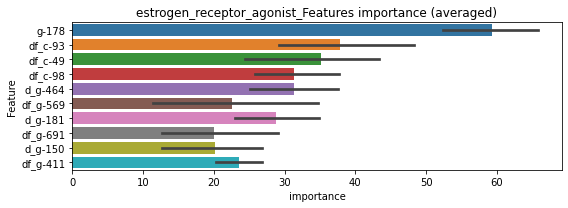

len(train_index) : 3748
len(valid_index) : 3749
================================= fold 1/2 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0348906	valid_1's binary_logloss: 0.0987225
[200]	training's binary_logloss: 0.0083087	valid_1's binary_logloss: 0.080155
Early stopping, best iteration is:
[228]	training's binary_logloss: 0.00577943	valid_1's binary_logloss: 0.0789155


len(train_index) : 3749
len(valid_index) : 3748
================================= fold 2/2 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0349494	valid_1's binary_logloss: 0.0928187
[200]	training's binary_logloss: 0.00875422	valid_1's binary_logloss: 0.0703497
Early stopping, best iteration is:
[267]	training's binary_logloss: 0.00373937	valid_1's binary_logloss: 0.0668143


estrogen_receptor_agonist logloss: 0.07286568994545932


neg labels: 3289 → selected neg labels: 3283


estrogen_receptor_antagonist, len(trt): 48, len(othr): 3283, target_rate: 0.0020156 → Adj_target_rate: 0.0022556
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0447304	valid_1's binary_logloss: 0.089664
[200]	training's binary_logloss: 0.00794568	valid_1's binary_logloss: 0.0446757
[300]	training's binary_logloss: 0.00218468	valid_1's binary_logloss: 0.035982
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.00109203	valid_1's binary_logloss: 0.0339458
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0458499	valid_1's binary_logloss: 0.0739928
[200]	training's binary_logloss: 0.00830152	valid_1's binary_logloss: 0.0233565
[300]	training's binary_logloss: 0.00230058	valid_1's binary_logloss: 0.0121857
[400]	training's binary_logloss: 0.00105666	valid_1's binary_logloss: 0.00913627
[500]	training's binary_logloss: 0.000653222	valid_1's binary_logloss: 0.00813416
[600]	training's binary_logloss: 0.000519372	valid_1's binary_logloss: 0.00777961
Early stopping, best iteration is:
[616]	t

1 / 3 AUC score:0.997
y_Threshold: 0.0059874, Threshold: 0.0076852, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 144 → Positive_corect_labels: 650/3795
p_label_rate: 0.0200904 Vs.target_rate: 0.00202
Num_p_label: 80.0, conf_0:0.00692, conf_1:0.00845
Num_p_label: 80.0, Expected: 8.0, Adj_threshold_1: 0.0076852
Num_p_label: 19.0, Expected: 8.0, Adj_threshold_2: 0.0176852
Num_p_label: 7.0, Expected: 8.0, Adj_threshold_3: 0.0276852
threshold: 0.0276852, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 650.0/3795, y_label_rate: 0.1712780
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0437344	valid_1's binary_logloss: 0.077833
[200]	training's binary_logloss: 0.00751399	valid_1's binary_logloss: 0.028171
[300]	training's binary_logloss: 0.0020947	valid_1's binary_logloss: 0.0171213
[400]	training's binary_logloss: 0.000983828	valid_1's binary_logloss: 0.0141173
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000697385	valid_1's binary_logloss: 0.01281
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.043349	valid_1's binary_logloss: 0.0926294
[200]	training's binary_logloss: 0.00714388	valid_1's binary_logloss: 0.0391989
[300]	training's binary_logloss: 0.00200467	valid_1's binary_logloss: 0.0309306
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.0016242	valid_1's binary_logloss: 0.0297527


2 / 3 AUC score:1.000
y_Threshold: 0.0357134, Threshold: 0.0276852, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → Positive_corect_labels: 642.0/3779
p_label_rate: 0.0090407 Vs.target_rate: 0.00202
Num_p_label: 36.0, conf_0:0.02492, conf_1:0.03045
Num_p_label: 36.0, Expected: 8.0, Adj_threshold_1: 0.0276852
Num_p_label: 19.0, Expected: 8.0, Adj_threshold_2: 0.0376852
Num_p_label: 13.0, Expected: 8.0, Adj_threshold_3: 0.0476852
threshold: 0.0476852, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 642.0/3779, y_label_rate: 0.1698862
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0413479	valid_1's binary_logloss: 0.0829624
[200]	training's binary_logloss: 0.00680739	valid_1's binary_logloss: 0.036912
[300]	training's binary_logloss: 0.00190574	valid_1's binary_logloss: 0.0277696
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.00110075	valid_1's binary_logloss: 0.0262963
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.043199	valid_1's binary_logloss: 0.072143
[200]	training's binary_logloss: 0.00717014	valid_1's binary_logloss: 0.0229785
[300]	training's binary_logloss: 0.00202659	valid_1's binary_logloss: 0.0115048
[400]	training's binary_logloss: 0.000964532	valid_1's binary_logloss: 0.00864318
[500]	training's binary_logloss: 0.000616194	valid_1's binary_logloss: 0.00752152
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.000608071	valid_1's binary_logloss: 0.00749077


3 / 3 AUC score:1.000
y_Threshold: 0.0235940, Threshold: 0.0476852, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 639.0/3773
p_label_rate: 0.0035158 Vs.target_rate: 0.00202
Num_p_label: 14.0, conf_0:0.04292, conf_1:0.05245
threshold: 0.0476852, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 653.0/7755, y_label_rate: 0.0842037


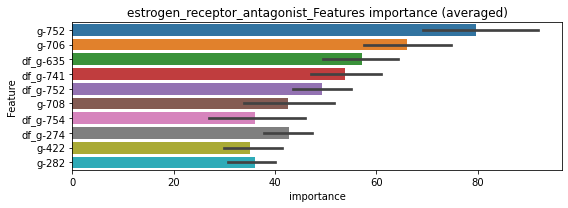

len(train_index) : 3877
len(valid_index) : 3878
================================= fold 1/2 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0238083	valid_1's binary_logloss: 0.0473677
[200]	training's binary_logloss: 0.00394837	valid_1's binary_logloss: 0.022796
[300]	training's binary_logloss: 0.00107096	valid_1's binary_logloss: 0.0177467
[400]	training's binary_logloss: 0.000490196	valid_1's binary_logloss: 0.0170092
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000519886	valid_1's binary_logloss: 0.0169765


len(train_index) : 3878
len(valid_index) : 3877
================================= fold 2/2 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0238682	valid_1's binary_logloss: 0.05384
[200]	training's binary_logloss: 0.00422312	valid_1's binary_logloss: 0.0305384
[300]	training's binary_logloss: 0.00112523	valid_1's binary_logloss: 0.0253124
[400]	training's binary_logloss: 0.000498741	valid_1's binary_logloss: 0.0237035
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.000498741	valid_1's binary_logloss: 0.0237035


estrogen_receptor_antagonist logloss: 0.020339585865543006


neg labels: 3289 → selected neg labels: 3283


faah_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334122	valid_1's binary_logloss: 0.0538728
[200]	training's binary_logloss: 0.00508124	valid_1's binary_logloss: 0.0156715
[300]	training's binary_logloss: 0.00141157	valid_1's binary_logloss: 0.00769341
[400]	training's binary_logloss: 0.000688416	valid_1's binary_logloss: 0.00504278
[500]	training's binary_logloss: 0.000463326	valid_1's binary_logloss: 0.0039845
Early stopping, best iteration is:
[587]	training's binary_logloss: 0.000422808	valid_1's binary_logloss: 0.00379804
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0333984	valid_1's binary_logloss: 0.0558402
[200]	training's binary_logloss: 0.00506472	valid_1's binary_logloss: 0.0176651
[300]	training's binary_logloss: 0.00139289	valid_1's binary_logloss: 0.00940043
[400]	training's binary_logloss: 0.000684125	valid_1's binary_logloss: 0.00718081
[500]	training's binary_logloss: 0.0

1 / 3 AUC score:1.000
y_Threshold: 0.0055553, Threshold: 0.0138886, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151
Num_p_label: 80.0, conf_0:0.01250, conf_1:0.01528
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0138886
Num_p_label: 38.0, Expected: 6.0, Adj_threshold_2: 0.0238886
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_3: 0.0338886
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_4: 0.0438886
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_5: 0.0538886
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_6: 0.0638886
threshold: 0.0638886, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0312568	valid_1's binary_logloss: 0.0482799
[200]	training's binary_logloss: 0.0045027	valid_1's binary_logloss: 0.0122505
[300]	training's binary_logloss: 0.00127294	valid_1's binary_logloss: 0.00544653
[400]	training's binary_logloss: 0.000640313	valid_1's binary_logloss: 0.00363561
[500]	training's binary_logloss: 0.000438911	valid_1's binary_logloss: 0.00286316
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.000411561	valid_1's binary_logloss: 0.00278117
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0324337	valid_1's binary_logloss: 0.0522296
[200]	training's binary_logloss: 0.00465018	valid_1's binary_logloss: 0.0150219
[300]	training's binary_logloss: 0.0012947	valid_1's binary_logloss: 0.00740461
[400]	training's binary_logloss: 0.000639028	valid_1's binary_logloss: 0.00538209
[500]	training's binary_logloss: 0.00

2 / 3 AUC score:1.000
y_Threshold: 0.0954574, Threshold: 0.0638886, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0130588 Vs.target_rate: 0.00151
Num_p_label: 52.0, conf_0:0.05750, conf_1:0.07028
Num_p_label: 52.0, Expected: 6.0, Adj_threshold_1: 0.0638886
Num_p_label: 47.0, Expected: 6.0, Adj_threshold_2: 0.0738886
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_3: 0.0838886
Num_p_label: 36.0, Expected: 6.0, Adj_threshold_4: 0.0938886
Num_p_label: 33.0, Expected: 6.0, Adj_threshold_5: 0.1038886
Num_p_label: 29.0, Expected: 6.0, Adj_threshold_6: 0.1138886
Num_p_label: 26.0, Expected: 6.0, Adj_threshold_7: 0.1238886
Num_p_label: 25.0, Expected: 6.0, Adj_threshold_8: 0.1338886
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_9: 0.1438886
Num_p_label: 22.0, Expected: 6.0, Adj_threshold_10: 0.1538886
threshold: 0.1638886, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0312568	valid_1's binary_logloss: 0.0482799
[200]	training's binary_logloss: 0.0045027	valid_1's binary_logloss: 0.0122505
[300]	training's binary_logloss: 0.00127294	valid_1's binary_logloss: 0.00544653
[400]	training's binary_logloss: 0.000640313	valid_1's binary_logloss: 0.00363561
[500]	training's binary_logloss: 0.000438911	valid_1's binary_logloss: 0.00286316
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.000411561	valid_1's binary_logloss: 0.00278117
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0324337	valid_1's binary_logloss: 0.0522296
[200]	training's binary_logloss: 0.00465018	valid_1's binary_logloss: 0.0150219
[300]	training's binary_logloss: 0.0012947	valid_1's binary_logloss: 0.00740461
[400]	training's binary_logloss: 0.000639028	valid_1's binary_logloss: 0.00538209
[500]	training's binary_logloss: 0.00

3 / 3 AUC score:1.000
y_Threshold: 0.0954574, Threshold: 0.1638886, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0047715 Vs.target_rate: 0.00151
Num_p_label: 19.0, conf_0:0.14750, conf_1:0.18028
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_1: 0.1638886
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_2: 0.1738886
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_3: 0.1838886
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_4: 0.1938886
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_5: 0.2038886
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_6: 0.2138886
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_7: 0.2238886
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_8: 0.2338886
threshold: 0.2338886, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 667.0/7789, y_label_rate: 0.0856336


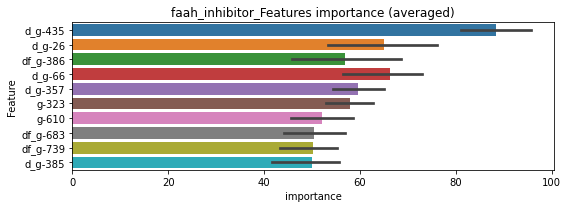

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 faah_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186162	valid_1's binary_logloss: 0.0350283
[200]	training's binary_logloss: 0.002701	valid_1's binary_logloss: 0.0151
[300]	training's binary_logloss: 0.000737604	valid_1's binary_logloss: 0.0123555
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000505594	valid_1's binary_logloss: 0.011866


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 faah_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182129	valid_1's binary_logloss: 0.0303649
[200]	training's binary_logloss: 0.00270065	valid_1's binary_logloss: 0.0100653
[300]	training's binary_logloss: 0.000746722	valid_1's binary_logloss: 0.00641476
[400]	training's binary_logloss: 0.000362995	valid_1's binary_logloss: 0.00572629
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.00026721	valid_1's binary_logloss: 0.00551751


faah_inhibitor logloss: 0.008692148072200912


neg labels: 3289 → selected neg labels: 3286


farnesyltransferase_inhibitor, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.018144	valid_1's binary_logloss: 0.0222003
[200]	training's binary_logloss: 0.00172818	valid_1's binary_logloss: 0.00320299
[300]	training's binary_logloss: 0.000468751	valid_1's binary_logloss: 0.00124902
[400]	training's binary_logloss: 0.000272836	valid_1's binary_logloss: 0.000844186
[500]	training's binary_logloss: 0.000232794	valid_1's binary_logloss: 0.000762022
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.000231974	valid_1's binary_logloss: 0.000761016
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182251	valid_1's binary_logloss: 0.0218236
[200]	training's binary_logloss: 0.00174519	valid_1's binary_logloss: 0.00367725
[300]	training's binary_logloss: 0.000472621	valid_1's binary_logloss: 0.0019398
[400]	training's binary_logloss: 0.00027399	valid_1's binary_logloss: 0.00158824
[500]	training's binary_logloss

1 / 3 AUC score:1.000
y_Threshold: 0.0012998, Threshold: 0.0034964, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00315, conf_1:0.00385
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0034964
Num_p_label: 29.0, Expected: 3.0, Adj_threshold_2: 0.0134964
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_3: 0.0234964
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_4: 0.0334964
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_5: 0.0434964
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_6: 0.0534964
threshold: 0.0534964, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182794	valid_1's binary_logloss: 0.0213351
[200]	training's binary_logloss: 0.00168541	valid_1's binary_logloss: 0.0026617
[300]	training's binary_logloss: 0.000438172	valid_1's binary_logloss: 0.000974425
[400]	training's binary_logloss: 0.000258863	valid_1's binary_logloss: 0.000641315
[500]	training's binary_logloss: 0.000224273	valid_1's binary_logloss: 0.0005916
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.000222587	valid_1's binary_logloss: 0.000589251
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0181302	valid_1's binary_logloss: 0.0213575
[200]	training's binary_logloss: 0.00166816	valid_1's binary_logloss: 0.0032005
[300]	training's binary_logloss: 0.000435282	valid_1's binary_logloss: 0.00144351
[400]	training's binary_logloss: 0.000256412	valid_1's binary_logloss: 0.00110654
[500]	training's binary_logloss

2 / 3 AUC score:1.000
y_Threshold: 0.1434730, Threshold: 0.0534964, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0105475 Vs.target_rate: 0.00076
Num_p_label: 42.0, conf_0:0.04815, conf_1:0.05885
Num_p_label: 42.0, Expected: 3.0, Adj_threshold_1: 0.0534964
Num_p_label: 33.0, Expected: 3.0, Adj_threshold_2: 0.0634964
Num_p_label: 29.0, Expected: 3.0, Adj_threshold_3: 0.0734964
Num_p_label: 27.0, Expected: 3.0, Adj_threshold_4: 0.0834964
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_5: 0.0934964
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_6: 0.1034964
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_7: 0.1134964
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_8: 0.1234964
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_9: 0.1334964
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_10: 0.1434964
threshold: 0.1534964, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182794	valid_1's binary_logloss: 0.0213351
[200]	training's binary_logloss: 0.00168541	valid_1's binary_logloss: 0.0026617
[300]	training's binary_logloss: 0.000438172	valid_1's binary_logloss: 0.000974425
[400]	training's binary_logloss: 0.000258863	valid_1's binary_logloss: 0.000641315
[500]	training's binary_logloss: 0.000224273	valid_1's binary_logloss: 0.0005916
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.000222587	valid_1's binary_logloss: 0.000589251
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0181302	valid_1's binary_logloss: 0.0213575
[200]	training's binary_logloss: 0.00166816	valid_1's binary_logloss: 0.0032005
[300]	training's binary_logloss: 0.000435282	valid_1's binary_logloss: 0.00144351
[400]	training's binary_logloss: 0.000256412	valid_1's binary_logloss: 0.00110654
[500]	training's binary_logloss

3 / 3 AUC score:1.000
y_Threshold: 0.1434730, Threshold: 0.1534964, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0057760 Vs.target_rate: 0.00076
Num_p_label: 23.0, conf_0:0.13815, conf_1:0.16885
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_1: 0.1534964
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_2: 0.1634964
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_3: 0.1734964
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_4: 0.1834964
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_5: 0.1934964
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_6: 0.2034964
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_7: 0.2134964
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_8: 0.2234964
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_9: 0.2334964
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_10: 0.2434964
threshold: 0.2534964, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 673.0/7793, y_label_rate: 0.0863596


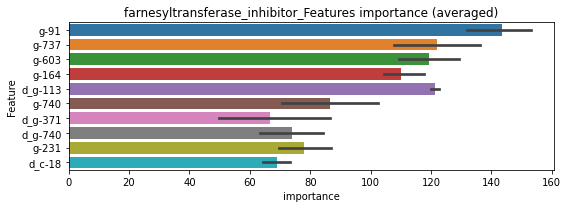

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00991995	valid_1's binary_logloss: 0.0167973
[200]	training's binary_logloss: 0.000948636	valid_1's binary_logloss: 0.00799526
Early stopping, best iteration is:
[269]	training's binary_logloss: 0.000350777	valid_1's binary_logloss: 0.00747683


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0102574	valid_1's binary_logloss: 0.0135919
[200]	training's binary_logloss: 0.0010196	valid_1's binary_logloss: 0.00363223
[300]	training's binary_logloss: 0.000271953	valid_1's binary_logloss: 0.00277729
[400]	training's binary_logloss: 0.000154589	valid_1's binary_logloss: 0.0026392
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.000156084	valid_1's binary_logloss: 0.00263553


farnesyltransferase_inhibitor logloss: 0.005056493217215957


neg labels: 3289 → selected neg labels: 3285


fatty_acid_receptor_agonist, len(trt): 25, len(othr): 3285, target_rate: 0.0010498 → Adj_target_rate: 0.0012955
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0277786	valid_1's binary_logloss: 0.0411022
[200]	training's binary_logloss: 0.0035743	valid_1's binary_logloss: 0.00792501
[300]	training's binary_logloss: 0.00100499	valid_1's binary_logloss: 0.00293232
[400]	training's binary_logloss: 0.000507926	valid_1's binary_logloss: 0.00173795
[500]	training's binary_logloss: 0.000375838	valid_1's binary_logloss: 0.00140173
Early stopping, best iteration is:
[544]	training's binary_logloss: 0.00036751	valid_1's binary_logloss: 0.00138452
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286285	valid_1's binary_logloss: 0.0400866
[200]	training's binary_logloss: 0.00380247	valid_1's binary_logloss: 0.00753
[300]	training's binary_logloss: 0.00104731	valid_1's binary_logloss: 0.00260657
[400]	training's binary_logloss: 0.000523609	valid_1's binary_logloss: 0.00149466
[500]	training's binary_logloss: 0.000

1 / 3 AUC score:1.000
y_Threshold: 0.0023210, Threshold: 0.0038150, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00105
Num_p_label: 80.0, conf_0:0.00343, conf_1:0.00420
Num_p_label: 80.0, Expected: 4.2, Adj_threshold_1: 0.0038150
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_2: 0.0138150
Num_p_label: 3.0, Expected: 4.2, Adj_threshold_3: 0.0238150
threshold: 0.0238150, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270487	valid_1's binary_logloss: 0.0390018
[200]	training's binary_logloss: 0.00343622	valid_1's binary_logloss: 0.00761104
[300]	training's binary_logloss: 0.000971537	valid_1's binary_logloss: 0.00289117
[400]	training's binary_logloss: 0.000498973	valid_1's binary_logloss: 0.00176283
[500]	training's binary_logloss: 0.000377531	valid_1's binary_logloss: 0.00149587
Early stopping, best iteration is:
[542]	training's binary_logloss: 0.000365296	valid_1's binary_logloss: 0.00145949
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0269157	valid_1's binary_logloss: 0.0382422
[200]	training's binary_logloss: 0.00342723	valid_1's binary_logloss: 0.00695295
[300]	training's binary_logloss: 0.000974642	valid_1's binary_logloss: 0.00257951
[400]	training's binary_logloss: 0.000496659	valid_1's binary_logloss: 0.00151484
[500]	training's binary_logloss

2 / 3 AUC score:1.000
y_Threshold: 0.1501886, Threshold: 0.0238150, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0042692 Vs.target_rate: 0.00105
Num_p_label: 17.0, conf_0:0.02143, conf_1:0.02620
Num_p_label: 17.0, Expected: 4.2, Adj_threshold_1: 0.0238150
Num_p_label: 12.0, Expected: 4.2, Adj_threshold_2: 0.0338150
Num_p_label: 7.0, Expected: 4.2, Adj_threshold_3: 0.0438150
threshold: 0.0438150, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270487	valid_1's binary_logloss: 0.0390018
[200]	training's binary_logloss: 0.00343622	valid_1's binary_logloss: 0.00761104
[300]	training's binary_logloss: 0.000971537	valid_1's binary_logloss: 0.00289117
[400]	training's binary_logloss: 0.000498973	valid_1's binary_logloss: 0.00176283
[500]	training's binary_logloss: 0.000377531	valid_1's binary_logloss: 0.00149587
Early stopping, best iteration is:
[542]	training's binary_logloss: 0.000365296	valid_1's binary_logloss: 0.00145949
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0269157	valid_1's binary_logloss: 0.0382422
[200]	training's binary_logloss: 0.00342723	valid_1's binary_logloss: 0.00695295
[300]	training's binary_logloss: 0.000974642	valid_1's binary_logloss: 0.00257951
[400]	training's binary_logloss: 0.000496659	valid_1's binary_logloss: 0.00151484
[500]	training's binary_logloss

3 / 3 AUC score:1.000
y_Threshold: 0.1501886, Threshold: 0.0438150, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0017579 Vs.target_rate: 0.00105
Num_p_label: 7.0, conf_0:0.03943, conf_1:0.04820
threshold: 0.0438150, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 664.0/7792, y_label_rate: 0.0852156


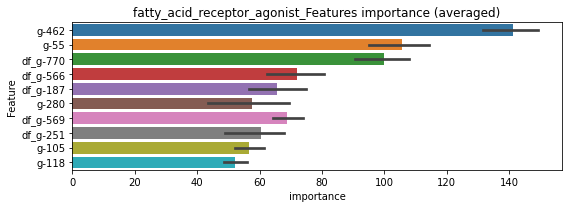

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0150105	valid_1's binary_logloss: 0.0250687
[200]	training's binary_logloss: 0.00191545	valid_1's binary_logloss: 0.00805841
[300]	training's binary_logloss: 0.000523546	valid_1's binary_logloss: 0.00602993
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.000519237	valid_1's binary_logloss: 0.00602552


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154787	valid_1's binary_logloss: 0.0234689
[200]	training's binary_logloss: 0.00201084	valid_1's binary_logloss: 0.00647651
[300]	training's binary_logloss: 0.000545272	valid_1's binary_logloss: 0.00396435
[400]	training's binary_logloss: 0.000267224	valid_1's binary_logloss: 0.00345368
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000227622	valid_1's binary_logloss: 0.0033651


fatty_acid_receptor_agonist logloss: 0.0046953088039198435


neg labels: 3289 → selected neg labels: 3279


fgfr_inhibitor, len(trt): 50, len(othr): 3279, target_rate: 0.0020996 → Adj_target_rate: 0.0023352
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0355103	valid_1's binary_logloss: 0.0700702
[200]	training's binary_logloss: 0.00547829	valid_1's binary_logloss: 0.034232
[300]	training's binary_logloss: 0.00156338	valid_1's binary_logloss: 0.0290039
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.00114202	valid_1's binary_logloss: 0.0281714
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0355406	valid_1's binary_logloss: 0.0689307
[200]	training's binary_logloss: 0.00538373	valid_1's binary_logloss: 0.0294891
[300]	training's binary_logloss: 0.00154287	valid_1's binary_logloss: 0.019593
[400]	training's binary_logloss: 0.000775628	valid_1's binary_logloss: 0.016887
[500]	training's binary_logloss: 0.000508434	valid_1's binary_logloss: 0.0154242
[600]	training's binary_logloss: 0.000413944	valid_1's binary_logloss: 0.0147454
Early stopping, best iteration is:
[612]	trai

1 / 3 AUC score:0.999
y_Threshold: 0.0072445, Threshold: 0.0176226, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 142 → Positive_corect_labels: 650/3792
p_label_rate: 0.0200904 Vs.target_rate: 0.00210
Num_p_label: 80.0, conf_0:0.01586, conf_1:0.01938
Num_p_label: 80.0, Expected: 8.4, Adj_threshold_1: 0.0176226
Num_p_label: 57.0, Expected: 8.4, Adj_threshold_2: 0.0276226
Num_p_label: 45.0, Expected: 8.4, Adj_threshold_3: 0.0376226
Num_p_label: 39.0, Expected: 8.4, Adj_threshold_4: 0.0476226
Num_p_label: 36.0, Expected: 8.4, Adj_threshold_5: 0.0576226
Num_p_label: 31.0, Expected: 8.4, Adj_threshold_6: 0.0676226
Num_p_label: 26.0, Expected: 8.4, Adj_threshold_7: 0.0776226
Num_p_label: 23.0, Expected: 8.4, Adj_threshold_8: 0.0876226
Num_p_label: 20.0, Expected: 8.4, Adj_threshold_9: 0.0976226
Num_p_label: 17.0, Expected: 8.4, Adj_threshold_10: 0.1076226
threshold: 0.1176226, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 650.0/3792, y_label_rate: 0.1714135
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0325961	valid_1's binary_logloss: 0.0660502
[200]	training's binary_logloss: 0.00488107	valid_1's binary_logloss: 0.0237646
[300]	training's binary_logloss: 0.00137592	valid_1's binary_logloss: 0.0142861
[400]	training's binary_logloss: 0.00067263	valid_1's binary_logloss: 0.0116246
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.000487834	valid_1's binary_logloss: 0.0109237
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0348403	valid_1's binary_logloss: 0.0553238
[200]	training's binary_logloss: 0.00512968	valid_1's binary_logloss: 0.0182757
[300]	training's binary_logloss: 0.0014522	valid_1's binary_logloss: 0.0114796
[400]	training's binary_logloss: 0.000705236	valid_1's binary_logloss: 0.00933372
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000552728	valid_1's binary_logloss: 0.00871204


2 / 3 AUC score:1.000
y_Threshold: 0.1244675, Threshold: 0.1176226, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 648.0/3788
p_label_rate: 0.0138122 Vs.target_rate: 0.00210
Num_p_label: 55.0, conf_0:0.10586, conf_1:0.12938
Num_p_label: 55.0, Expected: 8.4, Adj_threshold_1: 0.1176226
Num_p_label: 54.0, Expected: 8.4, Adj_threshold_2: 0.1276226
Num_p_label: 52.0, Expected: 8.4, Adj_threshold_3: 0.1376226
Num_p_label: 50.0, Expected: 8.4, Adj_threshold_4: 0.1476226
Num_p_label: 47.0, Expected: 8.4, Adj_threshold_5: 0.1576226
Num_p_label: 46.0, Expected: 8.4, Adj_threshold_6: 0.1676226
Num_p_label: 46.0, Expected: 8.4, Adj_threshold_7: 0.1776226
Num_p_label: 43.0, Expected: 8.4, Adj_threshold_8: 0.1876226
Num_p_label: 40.0, Expected: 8.4, Adj_threshold_9: 0.1976226
Num_p_label: 38.0, Expected: 8.4, Adj_threshold_10: 0.2076226
threshold: 0.2176226, positive_p_label: 37.0/3982, p_label_rate: 0.0092918
positive_y_label: 648.0/3788, y_label_rate: 0.1710665
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0331203	valid_1's binary_logloss: 0.059992
[200]	training's binary_logloss: 0.0048148	valid_1's binary_logloss: 0.0231773
[300]	training's binary_logloss: 0.00137785	valid_1's binary_logloss: 0.0166131
[400]	training's binary_logloss: 0.00067917	valid_1's binary_logloss: 0.0149894
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000698057	valid_1's binary_logloss: 0.0148815
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.032889	valid_1's binary_logloss: 0.0587873
[200]	training's binary_logloss: 0.00480693	valid_1's binary_logloss: 0.0238332
[300]	training's binary_logloss: 0.0013614	valid_1's binary_logloss: 0.015896
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.00117833	valid_1's binary_logloss: 0.0152837


3 / 3 AUC score:1.000
y_Threshold: 0.0606393, Threshold: 0.2176226, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 642.0/3776
p_label_rate: 0.0105475 Vs.target_rate: 0.00210
Num_p_label: 42.0, conf_0:0.19586, conf_1:0.23938
Num_p_label: 42.0, Expected: 8.4, Adj_threshold_1: 0.2176226
Num_p_label: 41.0, Expected: 8.4, Adj_threshold_2: 0.2276226
Num_p_label: 40.0, Expected: 8.4, Adj_threshold_3: 0.2376226
Num_p_label: 40.0, Expected: 8.4, Adj_threshold_4: 0.2476226
Num_p_label: 37.0, Expected: 8.4, Adj_threshold_5: 0.2576226
Num_p_label: 37.0, Expected: 8.4, Adj_threshold_6: 0.2676226
Num_p_label: 36.0, Expected: 8.4, Adj_threshold_7: 0.2776226
Num_p_label: 36.0, Expected: 8.4, Adj_threshold_8: 0.2876226
Num_p_label: 34.0, Expected: 8.4, Adj_threshold_9: 0.2976226
Num_p_label: 33.0, Expected: 8.4, Adj_threshold_10: 0.3076226
threshold: 0.3176226, positive_p_label: 32.0/3982, p_label_rate: 0.0080362
positive_y_label: 674.0/7758, y_label_rate: 0.0868781


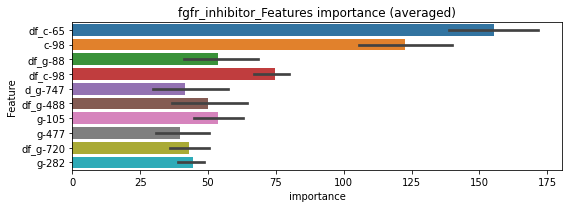

len(train_index) : 3879
len(valid_index) : 3879
================================= fold 1/2 fgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0177063	valid_1's binary_logloss: 0.0367349
[200]	training's binary_logloss: 0.00253683	valid_1's binary_logloss: 0.0175526
[300]	training's binary_logloss: 0.000726807	valid_1's binary_logloss: 0.0141986
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.000445861	valid_1's binary_logloss: 0.0131828


len(train_index) : 3879
len(valid_index) : 3879
================================= fold 2/2 fgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180901	valid_1's binary_logloss: 0.0379284
[200]	training's binary_logloss: 0.00273474	valid_1's binary_logloss: 0.0174697
[300]	training's binary_logloss: 0.000791375	valid_1's binary_logloss: 0.0129523
[400]	training's binary_logloss: 0.000396888	valid_1's binary_logloss: 0.0115499
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000293023	valid_1's binary_logloss: 0.0112007


fgfr_inhibitor logloss: 0.01219174033794939


neg labels: 3289 → selected neg labels: 3272


flt3_inhibitor, len(trt): 279, len(othr): 3272, target_rate: 0.0117158 → Adj_target_rate: 0.0100684
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0510157	valid_1's binary_logloss: 0.13713
[200]	training's binary_logloss: 0.0103921	valid_1's binary_logloss: 0.115004
Early stopping, best iteration is:
[216]	training's binary_logloss: 0.00846675	valid_1's binary_logloss: 0.114273
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0494927	valid_1's binary_logloss: 0.14268
[200]	training's binary_logloss: 0.0103958	valid_1's binary_logloss: 0.119992
Early stopping, best iteration is:
[203]	training's binary_logloss: 0.009988	valid_1's binary_logloss: 0.119839


1 / 3 AUC score:0.973
y_Threshold: 0.0670906, Threshold: 0.2271695, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 238 → Positive_corect_labels: 601/3688
p_label_rate: 0.0200904 Vs.target_rate: 0.01172
Num_p_label: 80.0, conf_0:0.20445, conf_1:0.24989
threshold: 0.2271695, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 601.0/3688, y_label_rate: 0.1629610
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0370791	valid_1's binary_logloss: 0.0870862
[200]	training's binary_logloss: 0.00658397	valid_1's binary_logloss: 0.0587872
Early stopping, best iteration is:
[258]	training's binary_logloss: 0.00321925	valid_1's binary_logloss: 0.0557001
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0374949	valid_1's binary_logloss: 0.0802738
[200]	training's binary_logloss: 0.00689098	valid_1's binary_logloss: 0.0428807
[300]	training's binary_logloss: 0.00209667	valid_1's binary_logloss: 0.0335462
[400]	training's binary_logloss: 0.000995816	valid_1's binary_logloss: 0.0302595
[500]	training's binary_logloss: 0.000657726	valid_1's binary_logloss: 0.0283613
Early stopping, best iteration is:
[563]	training's binary_logloss: 0.000568727	valid_1's binary_logloss: 0.027871


2 / 3 AUC score:0.998
y_Threshold: 0.1305223, Threshold: 0.2271695, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 42 → Positive_corect_labels: 580.0/3646
p_label_rate: 0.0354093 Vs.target_rate: 0.01172
Num_p_label: 141.0, conf_0:0.20445, conf_1:0.24989
Num_p_label: 141.0, Expected: 46.7, Adj_threshold_1: 0.2271695
Num_p_label: 138.0, Expected: 46.7, Adj_threshold_2: 0.2371695
Num_p_label: 134.0, Expected: 46.7, Adj_threshold_3: 0.2471695
Num_p_label: 134.0, Expected: 46.7, Adj_threshold_4: 0.2571695
Num_p_label: 130.0, Expected: 46.7, Adj_threshold_5: 0.2671695
Num_p_label: 126.0, Expected: 46.7, Adj_threshold_6: 0.2771695
Num_p_label: 124.0, Expected: 46.7, Adj_threshold_7: 0.2871695
Num_p_label: 123.0, Expected: 46.7, Adj_threshold_8: 0.2971695
Num_p_label: 122.0, Expected: 46.7, Adj_threshold_9: 0.3071695
Num_p_label: 118.0, Expected: 46.7, Adj_threshold_10: 0.3171695
threshold: 0.3271695, positive_p_label: 116.0/3982, p_label_rate: 0.0291311
positive_y_label: 580.0/3646, y_label_ra

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335867	valid_1's binary_logloss: 0.074689
[200]	training's binary_logloss: 0.00568362	valid_1's binary_logloss: 0.0416161
[300]	training's binary_logloss: 0.00173857	valid_1's binary_logloss: 0.0359458
Early stopping, best iteration is:
[327]	training's binary_logloss: 0.00138531	valid_1's binary_logloss: 0.0353613
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0363907	valid_1's binary_logloss: 0.0623673
[200]	training's binary_logloss: 0.00617496	valid_1's binary_logloss: 0.0307399
[300]	training's binary_logloss: 0.00188505	valid_1's binary_logloss: 0.0246828
[400]	training's binary_logloss: 0.000917028	valid_1's binary_logloss: 0.0222407
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000681989	valid_1's binary_logloss: 0.0212886


3 / 3 AUC score:0.999
y_Threshold: 0.1504032, Threshold: 0.3271695, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 569.0/3624
p_label_rate: 0.0323958 Vs.target_rate: 0.01172
Num_p_label: 129.0, conf_0:0.29445, conf_1:0.35989
threshold: 0.3271695, positive_p_label: 129.0/3982, p_label_rate: 0.0323958
positive_y_label: 698.0/7606, y_label_rate: 0.0917697


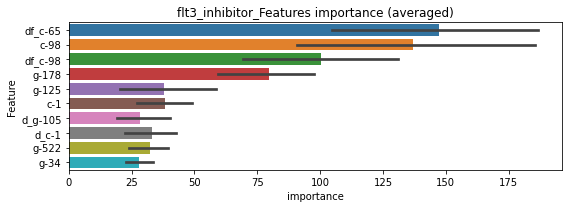

len(train_index) : 3803
len(valid_index) : 3803
================================= fold 1/2 flt3_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0205199	valid_1's binary_logloss: 0.0484675
[200]	training's binary_logloss: 0.00343652	valid_1's binary_logloss: 0.028105
[300]	training's binary_logloss: 0.00106674	valid_1's binary_logloss: 0.0235118
[400]	training's binary_logloss: 0.000539486	valid_1's binary_logloss: 0.0221362
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.00051028	valid_1's binary_logloss: 0.021971


len(train_index) : 3803
len(valid_index) : 3803
================================= fold 2/2 flt3_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0199037	valid_1's binary_logloss: 0.0515112
[200]	training's binary_logloss: 0.00326752	valid_1's binary_logloss: 0.0336346
[300]	training's binary_logloss: 0.000987155	valid_1's binary_logloss: 0.0306506
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.000903958	valid_1's binary_logloss: 0.0305498


flt3_inhibitor logloss: 0.02626042049588569


neg labels: 3289 → selected neg labels: 3286


focal_adhesion_kinase_inhibitor, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0178521	valid_1's binary_logloss: 0.0222105
[200]	training's binary_logloss: 0.00170726	valid_1's binary_logloss: 0.00441428
[300]	training's binary_logloss: 0.000451117	valid_1's binary_logloss: 0.00289079
[400]	training's binary_logloss: 0.000260409	valid_1's binary_logloss: 0.00265156
[500]	training's binary_logloss: 0.000230304	valid_1's binary_logloss: 0.00256199
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.000230263	valid_1's binary_logloss: 0.00256194
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179385	valid_1's binary_logloss: 0.0225039
[200]	training's binary_logloss: 0.00172224	valid_1's binary_logloss: 0.00378984
[300]	training's binary_logloss: 0.000465996	valid_1's binary_logloss: 0.0016004
[400]	training's binary_logloss: 0.000267779	valid_1's binary_logloss: 0.00111791
[500]	training's binary_logloss:

1 / 3 AUC score:1.000
y_Threshold: 0.0009819, Threshold: 0.0027702, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00249, conf_1:0.00305
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0027702
Num_p_label: 31.0, Expected: 3.0, Adj_threshold_2: 0.0127702
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_3: 0.0227702
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_4: 0.0327702
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_5: 0.0427702
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_6: 0.0527702
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_7: 0.0627702
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_8: 0.0727702
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_9: 0.0827702
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_10: 0.0927702
threshold: 0.1027702, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
==========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0176015	valid_1's binary_logloss: 0.0199567
[200]	training's binary_logloss: 0.00158673	valid_1's binary_logloss: 0.00220516
[300]	training's binary_logloss: 0.000408641	valid_1's binary_logloss: 0.000687837
[400]	training's binary_logloss: 0.000241527	valid_1's binary_logloss: 0.000442346
[500]	training's binary_logloss: 0.000213327	valid_1's binary_logloss: 0.000397085
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.000211649	valid_1's binary_logloss: 0.000394717
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0176552	valid_1's binary_logloss: 0.0205176
[200]	training's binary_logloss: 0.00158493	valid_1's binary_logloss: 0.00215413
[300]	training's binary_logloss: 0.000406009	valid_1's binary_logloss: 0.000615575
[400]	training's binary_logloss: 0.000238281	valid_1's binary_logloss: 0.000383523
[500]	training's binary_l

2 / 3 AUC score:1.000
y_Threshold: 0.2283627, Threshold: 0.1027702, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0080362 Vs.target_rate: 0.00076
Num_p_label: 32.0, conf_0:0.09249, conf_1:0.11305
Num_p_label: 32.0, Expected: 3.0, Adj_threshold_1: 0.1027702
Num_p_label: 31.0, Expected: 3.0, Adj_threshold_2: 0.1127702
Num_p_label: 31.0, Expected: 3.0, Adj_threshold_3: 0.1227702
Num_p_label: 29.0, Expected: 3.0, Adj_threshold_4: 0.1327702
Num_p_label: 28.0, Expected: 3.0, Adj_threshold_5: 0.1427702
Num_p_label: 28.0, Expected: 3.0, Adj_threshold_6: 0.1527702
Num_p_label: 25.0, Expected: 3.0, Adj_threshold_7: 0.1627702
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_8: 0.1727702
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_9: 0.1827702
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_10: 0.1927702
threshold: 0.2027702, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0176015	valid_1's binary_logloss: 0.0199567
[200]	training's binary_logloss: 0.00158673	valid_1's binary_logloss: 0.00220516
[300]	training's binary_logloss: 0.000408641	valid_1's binary_logloss: 0.000687837
[400]	training's binary_logloss: 0.000241527	valid_1's binary_logloss: 0.000442346
[500]	training's binary_logloss: 0.000213327	valid_1's binary_logloss: 0.000397085
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.000211649	valid_1's binary_logloss: 0.000394717
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0176552	valid_1's binary_logloss: 0.0205176
[200]	training's binary_logloss: 0.00158493	valid_1's binary_logloss: 0.00215413
[300]	training's binary_logloss: 0.000406009	valid_1's binary_logloss: 0.000615575
[400]	training's binary_logloss: 0.000238281	valid_1's binary_logloss: 0.000383523
[500]	training's binary_l

3 / 3 AUC score:1.000
y_Threshold: 0.2283627, Threshold: 0.2027702, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0057760 Vs.target_rate: 0.00076
Num_p_label: 23.0, conf_0:0.18249, conf_1:0.22305
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_1: 0.2027702
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_2: 0.2127702
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_3: 0.2227702
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_4: 0.2327702
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_5: 0.2427702
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_6: 0.2527702
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_7: 0.2627702
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_8: 0.2727702
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_9: 0.2827702
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_10: 0.2927702
threshold: 0.3027702, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 675.0/7793, y_label_rate: 0.0866162


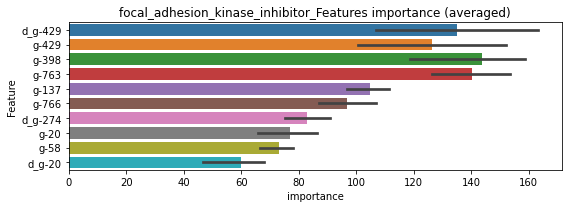

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0097188	valid_1's binary_logloss: 0.0156478
[200]	training's binary_logloss: 0.000895679	valid_1's binary_logloss: 0.0056791
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.000286507	valid_1's binary_logloss: 0.00501136


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00998798	valid_1's binary_logloss: 0.0122154
[200]	training's binary_logloss: 0.000977043	valid_1's binary_logloss: 0.00299994
[300]	training's binary_logloss: 0.000262253	valid_1's binary_logloss: 0.00238625
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.000271691	valid_1's binary_logloss: 0.00237601


focal_adhesion_kinase_inhibitor logloss: 0.0036938550373241783


neg labels: 3289 → selected neg labels: 3286


free_radical_scavenger, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0223951	valid_1's binary_logloss: 0.0303189
[200]	training's binary_logloss: 0.00255013	valid_1's binary_logloss: 0.00497157
[300]	training's binary_logloss: 0.000728251	valid_1's binary_logloss: 0.00181648
[400]	training's binary_logloss: 0.000392458	valid_1's binary_logloss: 0.00112832
[500]	training's binary_logloss: 0.000316846	valid_1's binary_logloss: 0.000997106
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000318676	valid_1's binary_logloss: 0.000996816
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229255	valid_1's binary_logloss: 0.0321543
[200]	training's binary_logloss: 0.00263461	valid_1's binary_logloss: 0.00602267
[300]	training's binary_logloss: 0.000739132	valid_1's binary_logloss: 0.00271894
[400]	training's binary_logloss: 0.000391386	valid_1's binary_logloss: 0.00193308
Early stopping, best iteratio

1 / 3 AUC score:1.000
y_Threshold: 0.0013064, Threshold: 0.0019278, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00174, conf_1:0.00212
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0019278
Num_p_label: 1.0, Expected: 3.0, Adj_threshold_2: 0.0119278
threshold: 0.0119278, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227477	valid_1's binary_logloss: 0.0304107
[200]	training's binary_logloss: 0.00255726	valid_1's binary_logloss: 0.00504404
[300]	training's binary_logloss: 0.000723375	valid_1's binary_logloss: 0.00183806
[400]	training's binary_logloss: 0.000392409	valid_1's binary_logloss: 0.00115605
[500]	training's binary_logloss: 0.000315408	valid_1's binary_logloss: 0.00102097
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.000306599	valid_1's binary_logloss: 0.00100355
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022977	valid_1's binary_logloss: 0.0316099
[200]	training's binary_logloss: 0.00260455	valid_1's binary_logloss: 0.00594501
[300]	training's binary_logloss: 0.000735002	valid_1's binary_logloss: 0.00271446
[400]	training's binary_logloss: 0.000390937	valid_1's binary_logloss: 0.00196894
Early stopping, best iteration i

2 / 3 AUC score:1.000
y_Threshold: 0.0684880, Threshold: 0.0119278, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0005023 Vs.target_rate: 0.00076
Num_p_label: 2.0, conf_0:0.01074, conf_1:0.01312
threshold: 0.0119278, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227477	valid_1's binary_logloss: 0.0304107
[200]	training's binary_logloss: 0.00255726	valid_1's binary_logloss: 0.00504404
[300]	training's binary_logloss: 0.000723375	valid_1's binary_logloss: 0.00183806
[400]	training's binary_logloss: 0.000392409	valid_1's binary_logloss: 0.00115605
[500]	training's binary_logloss: 0.000315408	valid_1's binary_logloss: 0.00102097
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.000306599	valid_1's binary_logloss: 0.00100355
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022977	valid_1's binary_logloss: 0.0316099
[200]	training's binary_logloss: 0.00260455	valid_1's binary_logloss: 0.00594501
[300]	training's binary_logloss: 0.000735002	valid_1's binary_logloss: 0.00271446
[400]	training's binary_logloss: 0.000390937	valid_1's binary_logloss: 0.00196894
Early stopping, best iteration i

3 / 3 AUC score:1.000
y_Threshold: 0.0684880, Threshold: 0.0119278, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0005023 Vs.target_rate: 0.00076
Num_p_label: 2.0, conf_0:0.01074, conf_1:0.01312
threshold: 0.0119278, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 659.0/7793, y_label_rate: 0.0845631


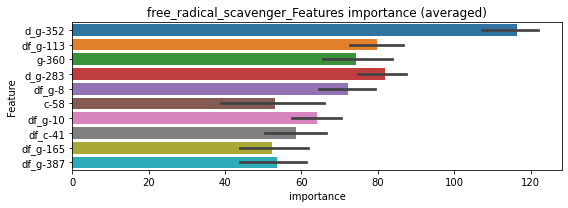

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 free_radical_scavenger=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0124562	valid_1's binary_logloss: 0.0172174
[200]	training's binary_logloss: 0.00138717	valid_1's binary_logloss: 0.00337398
[300]	training's binary_logloss: 0.000378294	valid_1's binary_logloss: 0.00205326
[400]	training's binary_logloss: 0.000198452	valid_1's binary_logloss: 0.0018743
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000207857	valid_1's binary_logloss: 0.00186656


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 free_radical_scavenger=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0121396	valid_1's binary_logloss: 0.0186659
[200]	training's binary_logloss: 0.00133706	valid_1's binary_logloss: 0.00435373
[300]	training's binary_logloss: 0.00036771	valid_1's binary_logloss: 0.00257134
[400]	training's binary_logloss: 0.000193479	valid_1's binary_logloss: 0.00224872
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000170586	valid_1's binary_logloss: 0.00220376


free_radical_scavenger logloss: 0.002035136229781562


neg labels: 3289 → selected neg labels: 3285


fungal_squalene_epoxidase_inhibitor, len(trt): 23, len(othr): 3285, target_rate: 0.0009658 → Adj_target_rate: 0.0012069
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254234	valid_1's binary_logloss: 0.0439013
[200]	training's binary_logloss: 0.00317342	valid_1's binary_logloss: 0.0144346
[300]	training's binary_logloss: 0.000889178	valid_1's binary_logloss: 0.0082563
[400]	training's binary_logloss: 0.000464872	valid_1's binary_logloss: 0.0065375
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.000451432	valid_1's binary_logloss: 0.00647587
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0263463	valid_1's binary_logloss: 0.0350738
[200]	training's binary_logloss: 0.00319211	valid_1's binary_logloss: 0.00557984
[300]	training's binary_logloss: 0.000895983	valid_1's binary_logloss: 0.00187923
[400]	training's binary_logloss: 0.000464394	valid_1's binary_logloss: 0.00108984
[500]	training's binary_logloss: 0.000348657	valid_1's binary_logloss: 0.000880927
Early stopping, best iteration is

1 / 3 AUC score:1.000
y_Threshold: 0.0016962, Threshold: 0.0026053, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00097
Num_p_label: 80.0, conf_0:0.00234, conf_1:0.00287
Num_p_label: 80.0, Expected: 3.8, Adj_threshold_1: 0.0026053
Num_p_label: 11.0, Expected: 3.8, Adj_threshold_2: 0.0126053
Num_p_label: 5.0, Expected: 3.8, Adj_threshold_3: 0.0226053
threshold: 0.0226053, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0260153	valid_1's binary_logloss: 0.0438266
[200]	training's binary_logloss: 0.00311289	valid_1's binary_logloss: 0.0121032
[300]	training's binary_logloss: 0.000869939	valid_1's binary_logloss: 0.00683197
[400]	training's binary_logloss: 0.00045958	valid_1's binary_logloss: 0.00538624
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000398674	valid_1's binary_logloss: 0.0051838
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261677	valid_1's binary_logloss: 0.0351339
[200]	training's binary_logloss: 0.00319425	valid_1's binary_logloss: 0.00572629
[300]	training's binary_logloss: 0.000891261	valid_1's binary_logloss: 0.00194498
[400]	training's binary_logloss: 0.000463328	valid_1's binary_logloss: 0.00112381
[500]	training's binary_logloss: 0.000353201	valid_1's binary_logloss: 0.000925697
Early stopping, best iteration is

2 / 3 AUC score:1.000
y_Threshold: 0.0231907, Threshold: 0.0226053, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0015068 Vs.target_rate: 0.00097
Num_p_label: 6.0, conf_0:0.02034, conf_1:0.02487
threshold: 0.0226053, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0260153	valid_1's binary_logloss: 0.0438266
[200]	training's binary_logloss: 0.00311289	valid_1's binary_logloss: 0.0121032
[300]	training's binary_logloss: 0.000869939	valid_1's binary_logloss: 0.00683197
[400]	training's binary_logloss: 0.00045958	valid_1's binary_logloss: 0.00538624
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000398674	valid_1's binary_logloss: 0.0051838
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261677	valid_1's binary_logloss: 0.0351339
[200]	training's binary_logloss: 0.00319425	valid_1's binary_logloss: 0.00572629
[300]	training's binary_logloss: 0.000891261	valid_1's binary_logloss: 0.00194498
[400]	training's binary_logloss: 0.000463328	valid_1's binary_logloss: 0.00112381
[500]	training's binary_logloss: 0.000353201	valid_1's binary_logloss: 0.000925697
Early stopping, best iteration is

3 / 3 AUC score:1.000
y_Threshold: 0.0231907, Threshold: 0.0226053, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0015068 Vs.target_rate: 0.00097
Num_p_label: 6.0, conf_0:0.02034, conf_1:0.02487
threshold: 0.0226053, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7792, y_label_rate: 0.0850873


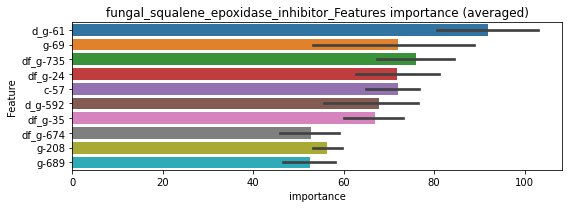

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0143412	valid_1's binary_logloss: 0.0249015
[200]	training's binary_logloss: 0.00168228	valid_1's binary_logloss: 0.00829445
[300]	training's binary_logloss: 0.000457658	valid_1's binary_logloss: 0.00639458
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.000409979	valid_1's binary_logloss: 0.00634625


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0146093	valid_1's binary_logloss: 0.0204155
[200]	training's binary_logloss: 0.00178049	valid_1's binary_logloss: 0.00535596
[300]	training's binary_logloss: 0.000485543	valid_1's binary_logloss: 0.00293694
[400]	training's binary_logloss: 0.000244613	valid_1's binary_logloss: 0.00235521
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.000217718	valid_1's binary_logloss: 0.00228895


fungal_squalene_epoxidase_inhibitor logloss: 0.00431760080814137


neg labels: 3289 → selected neg labels: 3272


gaba_receptor_agonist, len(trt): 106, len(othr): 3272, target_rate: 0.0044512 → Adj_target_rate: 0.0044229
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0707346	valid_1's binary_logloss: 0.156943
[200]	training's binary_logloss: 0.0166227	valid_1's binary_logloss: 0.10426
[300]	training's binary_logloss: 0.00501333	valid_1's binary_logloss: 0.0927753
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.0034421	valid_1's binary_logloss: 0.0907886
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0732822	valid_1's binary_logloss: 0.152536
[200]	training's binary_logloss: 0.0178876	valid_1's binary_logloss: 0.0935192
[300]	training's binary_logloss: 0.00523364	valid_1's binary_logloss: 0.0787046
Early stopping, best iteration is:
[357]	training's binary_logloss: 0.00310239	valid_1's binary_logloss: 0.0764741


1 / 3 AUC score:0.987
y_Threshold: 0.0230837, Threshold: 0.0303540, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 188 → Positive_corect_labels: 626/3738
p_label_rate: 0.0200904 Vs.target_rate: 0.00445
Num_p_label: 80.0, conf_0:0.02732, conf_1:0.03339
Num_p_label: 80.0, Expected: 17.7, Adj_threshold_1: 0.0303540
Num_p_label: 34.0, Expected: 17.7, Adj_threshold_2: 0.0403540
threshold: 0.0403540, positive_p_label: 34.0/3982, p_label_rate: 0.0085384
positive_y_label: 626.0/3738, y_label_rate: 0.1674692
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0683981	valid_1's binary_logloss: 0.143693
[200]	training's binary_logloss: 0.0153294	valid_1's binary_logloss: 0.0854812
[300]	training's binary_logloss: 0.00458526	valid_1's binary_logloss: 0.0706929
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.00248802	valid_1's binary_logloss: 0.0671087
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0674008	valid_1's binary_logloss: 0.143686
[200]	training's binary_logloss: 0.0162172	valid_1's binary_logloss: 0.083448
[300]	training's binary_logloss: 0.00496799	valid_1's binary_logloss: 0.0673509
[400]	training's binary_logloss: 0.00213239	valid_1's binary_logloss: 0.0613471
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.00134502	valid_1's binary_logloss: 0.0590372


2 / 3 AUC score:0.994
y_Threshold: 0.0390152, Threshold: 0.0403540, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 50 → Positive_corect_labels: 601.0/3688
p_label_rate: 0.0135610 Vs.target_rate: 0.00445
Num_p_label: 54.0, conf_0:0.03632, conf_1:0.04439
Num_p_label: 54.0, Expected: 17.7, Adj_threshold_1: 0.0403540
Num_p_label: 34.0, Expected: 17.7, Adj_threshold_2: 0.0503540
threshold: 0.0503540, positive_p_label: 34.0/3982, p_label_rate: 0.0085384
positive_y_label: 601.0/3688, y_label_rate: 0.1629610
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0621855	valid_1's binary_logloss: 0.142157
[200]	training's binary_logloss: 0.0136484	valid_1's binary_logloss: 0.0815675
[300]	training's binary_logloss: 0.00400031	valid_1's binary_logloss: 0.0651472
[400]	training's binary_logloss: 0.00177568	valid_1's binary_logloss: 0.061044
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00143627	valid_1's binary_logloss: 0.0603434
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0622938	valid_1's binary_logloss: 0.128159
[200]	training's binary_logloss: 0.0142217	valid_1's binary_logloss: 0.0699214
[300]	training's binary_logloss: 0.00426911	valid_1's binary_logloss: 0.0548413
[400]	training's binary_logloss: 0.00187907	valid_1's binary_logloss: 0.0503021
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00181869	valid_1's binary_logloss: 0.0501598


3 / 3 AUC score:0.993
y_Threshold: 0.0336721, Threshold: 0.0503540, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 30 → Positive_corect_labels: 586.0/3658
p_label_rate: 0.0087896 Vs.target_rate: 0.00445
Num_p_label: 35.0, conf_0:0.04532, conf_1:0.05539
threshold: 0.0503540, positive_p_label: 35.0/3982, p_label_rate: 0.0087896
positive_y_label: 621.0/7640, y_label_rate: 0.0812827


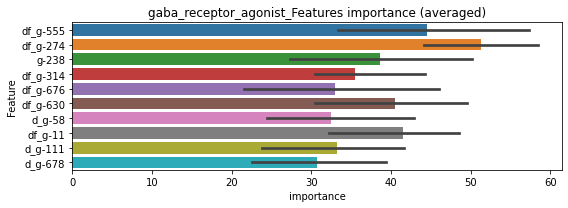

len(train_index) : 3820
len(valid_index) : 3820
================================= fold 1/2 gaba_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.035148	valid_1's binary_logloss: 0.0877716
[200]	training's binary_logloss: 0.00756512	valid_1's binary_logloss: 0.0578097
[300]	training's binary_logloss: 0.00219353	valid_1's binary_logloss: 0.0539672
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.0023988	valid_1's binary_logloss: 0.0536402


len(train_index) : 3820
len(valid_index) : 3820
================================= fold 2/2 gaba_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0367746	valid_1's binary_logloss: 0.0860476
[200]	training's binary_logloss: 0.00816077	valid_1's binary_logloss: 0.0594935
[300]	training's binary_logloss: 0.00240257	valid_1's binary_logloss: 0.0550921
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.00230192	valid_1's binary_logloss: 0.054837


gaba_receptor_agonist logloss: 0.05423856739342703


neg labels: 3289 → selected neg labels: 3263


gaba_receptor_antagonist, len(trt): 165, len(othr): 3263, target_rate: 0.0069287 → Adj_target_rate: 0.0064426
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0858669	valid_1's binary_logloss: 0.230195
[200]	training's binary_logloss: 0.0260872	valid_1's binary_logloss: 0.193849
Early stopping, best iteration is:
[242]	training's binary_logloss: 0.0164401	valid_1's binary_logloss: 0.189498
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0914429	valid_1's binary_logloss: 0.210352
[200]	training's binary_logloss: 0.0279779	valid_1's binary_logloss: 0.158831
[300]	training's binary_logloss: 0.00936645	valid_1's binary_logloss: 0.142064
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00475274	valid_1's binary_logloss: 0.138642


1 / 3 AUC score:0.953
y_Threshold: 0.0510446, Threshold: 0.0722131, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 297 → Positive_corect_labels: 569/3618
p_label_rate: 0.0200904 Vs.target_rate: 0.00693
Num_p_label: 80.0, conf_0:0.06499, conf_1:0.07943
threshold: 0.0722131, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 569.0/3618, y_label_rate: 0.1572692
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0703277	valid_1's binary_logloss: 0.20051
[200]	training's binary_logloss: 0.019153	valid_1's binary_logloss: 0.155026
[300]	training's binary_logloss: 0.00608356	valid_1's binary_logloss: 0.145262
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00638182	valid_1's binary_logloss: 0.144687
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0743699	valid_1's binary_logloss: 0.180791
[200]	training's binary_logloss: 0.0198819	valid_1's binary_logloss: 0.132158
[300]	training's binary_logloss: 0.00616936	valid_1's binary_logloss: 0.120162
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.0042693	valid_1's binary_logloss: 0.118435


2 / 3 AUC score:0.975
y_Threshold: 0.0675268, Threshold: 0.0722131, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 116 → Positive_corect_labels: 511.0/3502
p_label_rate: 0.0195881 Vs.target_rate: 0.00693
Num_p_label: 78.0, conf_0:0.06499, conf_1:0.07943
threshold: 0.0722131, positive_p_label: 78.0/3982, p_label_rate: 0.0195881
positive_y_label: 511.0/3502, y_label_rate: 0.1459166
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0624794	valid_1's binary_logloss: 0.181418
[200]	training's binary_logloss: 0.0145644	valid_1's binary_logloss: 0.148814
Early stopping, best iteration is:
[232]	training's binary_logloss: 0.00967229	valid_1's binary_logloss: 0.147222
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0636674	valid_1's binary_logloss: 0.161258
[200]	training's binary_logloss: 0.0144678	valid_1's binary_logloss: 0.110574
[300]	training's binary_logloss: 0.00441185	valid_1's binary_logloss: 0.0997316
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00380821	valid_1's binary_logloss: 0.0992288


3 / 3 AUC score:0.977
y_Threshold: 0.0675579, Threshold: 0.0722131, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 116 → Positive_corect_labels: 453.0/3386
p_label_rate: 0.0258664 Vs.target_rate: 0.00693
Num_p_label: 103.0, conf_0:0.06499, conf_1:0.07943
Num_p_label: 103.0, Expected: 27.6, Adj_threshold_1: 0.0722131
Num_p_label: 77.0, Expected: 27.6, Adj_threshold_2: 0.0822131
Num_p_label: 61.0, Expected: 27.6, Adj_threshold_3: 0.0922131
Num_p_label: 48.0, Expected: 27.6, Adj_threshold_4: 0.1022131
threshold: 0.1022131, positive_p_label: 48.0/3982, p_label_rate: 0.0120542
positive_y_label: 501.0/7368, y_label_rate: 0.0679967


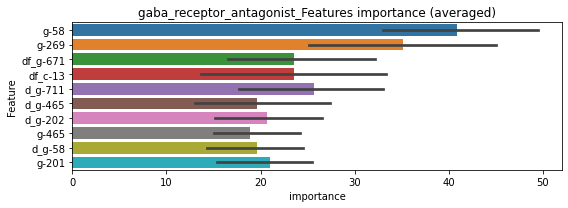

len(train_index) : 3684
len(valid_index) : 3684
================================= fold 1/2 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0318958	valid_1's binary_logloss: 0.0885802
[200]	training's binary_logloss: 0.00746216	valid_1's binary_logloss: 0.0676324
[300]	training's binary_logloss: 0.00225325	valid_1's binary_logloss: 0.0633245
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.00222873	valid_1's binary_logloss: 0.0633013


len(train_index) : 3684
len(valid_index) : 3684
================================= fold 2/2 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031086	valid_1's binary_logloss: 0.0928947
[200]	training's binary_logloss: 0.00706729	valid_1's binary_logloss: 0.0737729
Early stopping, best iteration is:
[241]	training's binary_logloss: 0.00398678	valid_1's binary_logloss: 0.0717607


gaba_receptor_antagonist logloss: 0.06753098506950872


neg labels: 3289 → selected neg labels: 3279


gamma_secretase_inhibitor, len(trt): 56, len(othr): 3279, target_rate: 0.0023516 → Adj_target_rate: 0.0025713
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315358	valid_1's binary_logloss: 0.066247
[200]	training's binary_logloss: 0.00473855	valid_1's binary_logloss: 0.033031
[300]	training's binary_logloss: 0.00141092	valid_1's binary_logloss: 0.0270643
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.000855567	valid_1's binary_logloss: 0.0256239
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0314366	valid_1's binary_logloss: 0.0599131
[200]	training's binary_logloss: 0.00464305	valid_1's binary_logloss: 0.0245457
[300]	training's binary_logloss: 0.00137332	valid_1's binary_logloss: 0.017344
[400]	training's binary_logloss: 0.000693666	valid_1's binary_logloss: 0.0155251
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.000679433	valid_1's binary_logloss: 0.0155156


1 / 3 AUC score:0.999
y_Threshold: 0.0057391, Threshold: 0.0085119, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → Positive_corect_labels: 652/3796
p_label_rate: 0.0200904 Vs.target_rate: 0.00235
Num_p_label: 80.0, conf_0:0.00766, conf_1:0.00936
Num_p_label: 80.0, Expected: 9.4, Adj_threshold_1: 0.0085119
Num_p_label: 26.0, Expected: 9.4, Adj_threshold_2: 0.0185119
Num_p_label: 14.0, Expected: 9.4, Adj_threshold_3: 0.0285119
threshold: 0.0285119, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 652.0/3796, y_label_rate: 0.1717597
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303839	valid_1's binary_logloss: 0.058397
[200]	training's binary_logloss: 0.00450995	valid_1's binary_logloss: 0.021411
[300]	training's binary_logloss: 0.00131786	valid_1's binary_logloss: 0.012497
[400]	training's binary_logloss: 0.000653807	valid_1's binary_logloss: 0.00958095
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000546185	valid_1's binary_logloss: 0.00911351
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0317187	valid_1's binary_logloss: 0.0519595
[200]	training's binary_logloss: 0.00460582	valid_1's binary_logloss: 0.0176484
[300]	training's binary_logloss: 0.00133624	valid_1's binary_logloss: 0.0114443
[400]	training's binary_logloss: 0.000668107	valid_1's binary_logloss: 0.00956238
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000485883	valid_1's binary_logloss: 0.00912938


2 / 3 AUC score:1.000
y_Threshold: 0.0620202, Threshold: 0.0285119, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 651.0/3794
p_label_rate: 0.0113009 Vs.target_rate: 0.00235
Num_p_label: 45.0, conf_0:0.02566, conf_1:0.03136
Num_p_label: 45.0, Expected: 9.4, Adj_threshold_1: 0.0285119
Num_p_label: 39.0, Expected: 9.4, Adj_threshold_2: 0.0385119
Num_p_label: 25.0, Expected: 9.4, Adj_threshold_3: 0.0485119
Num_p_label: 20.0, Expected: 9.4, Adj_threshold_4: 0.0585119
Num_p_label: 17.0, Expected: 9.4, Adj_threshold_5: 0.0685119
threshold: 0.0685119, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 651.0/3794, y_label_rate: 0.1715867
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0310345	valid_1's binary_logloss: 0.0553268
[200]	training's binary_logloss: 0.00447846	valid_1's binary_logloss: 0.0178839
[300]	training's binary_logloss: 0.00131916	valid_1's binary_logloss: 0.0104503
[400]	training's binary_logloss: 0.000662638	valid_1's binary_logloss: 0.00820356
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000529583	valid_1's binary_logloss: 0.00782629
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0311533	valid_1's binary_logloss: 0.0601134
[200]	training's binary_logloss: 0.00457912	valid_1's binary_logloss: 0.0228334
[300]	training's binary_logloss: 0.00135154	valid_1's binary_logloss: 0.0151581
[400]	training's binary_logloss: 0.000654815	valid_1's binary_logloss: 0.0119978
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000638167	valid_1's binary_logloss: 0.0118541


3 / 3 AUC score:1.000
y_Threshold: 0.0549220, Threshold: 0.0685119, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 648.0/3788
p_label_rate: 0.0050226 Vs.target_rate: 0.00235
Num_p_label: 20.0, conf_0:0.06166, conf_1:0.07536
threshold: 0.0685119, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 668.0/7770, y_label_rate: 0.0859717


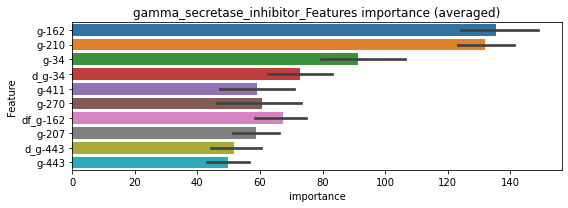

len(train_index) : 3885
len(valid_index) : 3885
================================= fold 1/2 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162498	valid_1's binary_logloss: 0.0412493
[200]	training's binary_logloss: 0.00225368	valid_1's binary_logloss: 0.025216
Early stopping, best iteration is:
[267]	training's binary_logloss: 0.000917035	valid_1's binary_logloss: 0.0233596


len(train_index) : 3885
len(valid_index) : 3885
================================= fold 2/2 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161595	valid_1's binary_logloss: 0.0396065
[200]	training's binary_logloss: 0.00228978	valid_1's binary_logloss: 0.0212586
[300]	training's binary_logloss: 0.000677759	valid_1's binary_logloss: 0.0181642
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.000507732	valid_1's binary_logloss: 0.0177215


gamma_secretase_inhibitor logloss: 0.020540542977095996


neg labels: 3289 → selected neg labels: 3253


glucocorticoid_receptor_agonist, len(trt): 266, len(othr): 3253, target_rate: 0.0111699 → Adj_target_rate: 0.0096682
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304169	valid_1's binary_logloss: 0.0667754
[200]	training's binary_logloss: 0.00454178	valid_1's binary_logloss: 0.0486743
Early stopping, best iteration is:
[234]	training's binary_logloss: 0.00279393	valid_1's binary_logloss: 0.0479068
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0313464	valid_1's binary_logloss: 0.063082
[200]	training's binary_logloss: 0.0049618	valid_1's binary_logloss: 0.0408902
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.00247783	valid_1's binary_logloss: 0.0380936


1 / 3 AUC score:0.995
y_Threshold: 0.0077879, Threshold: 0.0239231, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 149 → Positive_corect_labels: 641/3754
p_label_rate: 0.0200904 Vs.target_rate: 0.01117
Num_p_label: 80.0, conf_0:0.02153, conf_1:0.02632
threshold: 0.0239231, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 641.0/3754, y_label_rate: 0.1707512
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270335	valid_1's binary_logloss: 0.0418197
[200]	training's binary_logloss: 0.00349124	valid_1's binary_logloss: 0.018769
Early stopping, best iteration is:
[246]	training's binary_logloss: 0.00188019	valid_1's binary_logloss: 0.0174024
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0262141	valid_1's binary_logloss: 0.0469577
[200]	training's binary_logloss: 0.00335913	valid_1's binary_logloss: 0.0262293
Early stopping, best iteration is:
[224]	training's binary_logloss: 0.00230898	valid_1's binary_logloss: 0.0251733


2 / 3 AUC score:0.999
y_Threshold: 0.0276576, Threshold: 0.0239231, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 635.0/3742
p_label_rate: 0.0321447 Vs.target_rate: 0.01117
Num_p_label: 128.0, conf_0:0.02153, conf_1:0.02632
threshold: 0.0239231, positive_p_label: 128.0/3982, p_label_rate: 0.0321447
positive_y_label: 635.0/3742, y_label_rate: 0.1696954
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0243555	valid_1's binary_logloss: 0.0458642
Early stopping, best iteration is:
[189]	training's binary_logloss: 0.00368523	valid_1's binary_logloss: 0.0285281
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0239821	valid_1's binary_logloss: 0.0433835
[200]	training's binary_logloss: 0.00326288	valid_1's binary_logloss: 0.0252943
Early stopping, best iteration is:
[243]	training's binary_logloss: 0.00160028	valid_1's binary_logloss: 0.0238252


3 / 3 AUC score:0.996
y_Threshold: 0.0376477, Threshold: 0.0239231, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → Positive_corect_labels: 627.0/3726
p_label_rate: 0.0426921 Vs.target_rate: 0.01117
Num_p_label: 170.0, conf_0:0.02153, conf_1:0.02632
Num_p_label: 170.0, Expected: 44.5, Adj_threshold_1: 0.0239231
Num_p_label: 136.0, Expected: 44.5, Adj_threshold_2: 0.0339231
Num_p_label: 109.0, Expected: 44.5, Adj_threshold_3: 0.0439231
Num_p_label: 94.0, Expected: 44.5, Adj_threshold_4: 0.0539231
Num_p_label: 87.0, Expected: 44.5, Adj_threshold_5: 0.0639231
threshold: 0.0639231, positive_p_label: 87.0/3982, p_label_rate: 0.0218483
positive_y_label: 714.0/7708, y_label_rate: 0.0926310


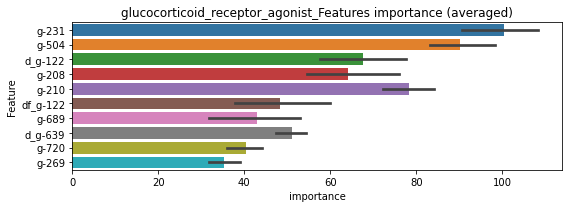

len(train_index) : 3854
len(valid_index) : 3854
================================= fold 1/2 glucocorticoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0145722	valid_1's binary_logloss: 0.0362412
[200]	training's binary_logloss: 0.00184217	valid_1's binary_logloss: 0.0263601
Early stopping, best iteration is:
[197]	training's binary_logloss: 0.00193354	valid_1's binary_logloss: 0.0263044


len(train_index) : 3854
len(valid_index) : 3854
================================= fold 2/2 glucocorticoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0150596	valid_1's binary_logloss: 0.0332811
[200]	training's binary_logloss: 0.00195979	valid_1's binary_logloss: 0.0221389
Early stopping, best iteration is:
[198]	training's binary_logloss: 0.00202354	valid_1's binary_logloss: 0.0221029


glucocorticoid_receptor_agonist logloss: 0.024203660156674318


neg labels: 3289 → selected neg labels: 3287


glutamate_inhibitor, len(trt): 13, len(othr): 3287, target_rate: 0.0005459 → Adj_target_rate: 0.0007431
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188204	valid_1's binary_logloss: 0.0250416
[200]	training's binary_logloss: 0.00191233	valid_1's binary_logloss: 0.00506956
[300]	training's binary_logloss: 0.000540495	valid_1's binary_logloss: 0.00212953
[400]	training's binary_logloss: 0.000305332	valid_1's binary_logloss: 0.00145396
[500]	training's binary_logloss: 0.000263089	valid_1's binary_logloss: 0.00134947
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.0002602	valid_1's binary_logloss: 0.00134391
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193457	valid_1's binary_logloss: 0.0228982
[200]	training's binary_logloss: 0.00197891	valid_1's binary_logloss: 0.00281949
[300]	training's binary_logloss: 0.000548143	valid_1's binary_logloss: 0.000903036
[400]	training's binary_logloss: 0.000307685	valid_1's binary_logloss: 0.000542693
[500]	training's binary_logloss

1 / 3 AUC score:1.000
y_Threshold: 0.0010075, Threshold: 0.0015075, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00055
Num_p_label: 80.0, conf_0:0.00136, conf_1:0.00166
Num_p_label: 80.0, Expected: 2.2, Adj_threshold_1: 0.0015075
Num_p_label: 6.0, Expected: 2.2, Adj_threshold_2: 0.0115075
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_3: 0.0215075
threshold: 0.0215075, positive_p_label: 0.0/3982, p_label_rate: 0.0000000
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192395	valid_1's binary_logloss: 0.0258057
[200]	training's binary_logloss: 0.00192668	valid_1's binary_logloss: 0.00602948
[300]	training's binary_logloss: 0.000536483	valid_1's binary_logloss: 0.00319542
[400]	training's binary_logloss: 0.000302647	valid_1's binary_logloss: 0.00245504
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.000263279	valid_1's binary_logloss: 0.00235525
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190577	valid_1's binary_logloss: 0.021929
[200]	training's binary_logloss: 0.00190639	valid_1's binary_logloss: 0.00255889
[300]	training's binary_logloss: 0.000534612	valid_1's binary_logloss: 0.000796999
[400]	training's binary_logloss: 0.000304115	valid_1's binary_logloss: 0.000476407
[500]	training's binary_logloss: 0.000263755	valid_1's binary_logloss: 0.000419775
Early stopping, best iteratio

2 / 3 AUC score:1.000
y_Threshold: 0.0587003, Threshold: 0.0215075, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0037670 Vs.target_rate: 0.00055
Num_p_label: 15.0, conf_0:0.01936, conf_1:0.02366
Num_p_label: 15.0, Expected: 2.2, Adj_threshold_1: 0.0215075
Num_p_label: 7.0, Expected: 2.2, Adj_threshold_2: 0.0315075
Num_p_label: 5.0, Expected: 2.2, Adj_threshold_3: 0.0415075
Num_p_label: 5.0, Expected: 2.2, Adj_threshold_4: 0.0515075
Num_p_label: 3.0, Expected: 2.2, Adj_threshold_5: 0.0615075
threshold: 0.0615075, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192395	valid_1's binary_logloss: 0.0258057
[200]	training's binary_logloss: 0.00192668	valid_1's binary_logloss: 0.00602948
[300]	training's binary_logloss: 0.000536483	valid_1's binary_logloss: 0.00319542
[400]	training's binary_logloss: 0.000302647	valid_1's binary_logloss: 0.00245504
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.000263279	valid_1's binary_logloss: 0.00235525
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190577	valid_1's binary_logloss: 0.021929
[200]	training's binary_logloss: 0.00190639	valid_1's binary_logloss: 0.00255889
[300]	training's binary_logloss: 0.000534612	valid_1's binary_logloss: 0.000796999
[400]	training's binary_logloss: 0.000304115	valid_1's binary_logloss: 0.000476407
[500]	training's binary_logloss: 0.000263755	valid_1's binary_logloss: 0.000419775
Early stopping, best iteratio

3 / 3 AUC score:1.000
y_Threshold: 0.0587003, Threshold: 0.0615075, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0007534 Vs.target_rate: 0.00055
Num_p_label: 3.0, conf_0:0.05536, conf_1:0.06766
threshold: 0.0615075, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 660.0/7794, y_label_rate: 0.0846805


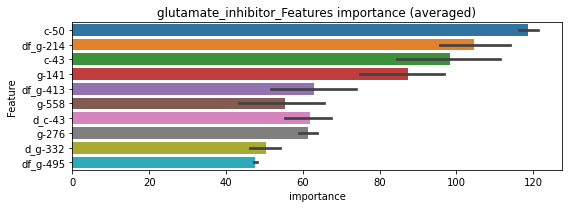

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 glutamate_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0100802	valid_1's binary_logloss: 0.0137311
[200]	training's binary_logloss: 0.000973502	valid_1's binary_logloss: 0.00378716
Early stopping, best iteration is:
[269]	training's binary_logloss: 0.000362444	valid_1's binary_logloss: 0.00317717


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 glutamate_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.010235	valid_1's binary_logloss: 0.013821
[200]	training's binary_logloss: 0.000999307	valid_1's binary_logloss: 0.00359195
[300]	training's binary_logloss: 0.000273705	valid_1's binary_logloss: 0.00233823
[400]	training's binary_logloss: 0.000156756	valid_1's binary_logloss: 0.00216106
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000162091	valid_1's binary_logloss: 0.00215911


glutamate_inhibitor logloss: 0.002668135369398344


neg labels: 3289 → selected neg labels: 3277


glutamate_receptor_agonist, len(trt): 74, len(othr): 3277, target_rate: 0.0031074 → Adj_target_rate: 0.0032587
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0560035	valid_1's binary_logloss: 0.124517
[200]	training's binary_logloss: 0.012533	valid_1's binary_logloss: 0.0743815
[300]	training's binary_logloss: 0.00362922	valid_1's binary_logloss: 0.0578765
[400]	training's binary_logloss: 0.00157743	valid_1's binary_logloss: 0.0533427
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00124887	valid_1's binary_logloss: 0.0526025
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.059286	valid_1's binary_logloss: 0.11763
[200]	training's binary_logloss: 0.0131967	valid_1's binary_logloss: 0.0590509
[300]	training's binary_logloss: 0.00378319	valid_1's binary_logloss: 0.0442251
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.00185989	valid_1's binary_logloss: 0.0410881


1 / 3 AUC score:0.995
y_Threshold: 0.0156810, Threshold: 0.0217782, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 156 → Positive_corect_labels: 643/3776
p_label_rate: 0.0200904 Vs.target_rate: 0.00311
Num_p_label: 80.0, conf_0:0.01960, conf_1:0.02396
Num_p_label: 80.0, Expected: 12.4, Adj_threshold_1: 0.0217782
Num_p_label: 32.0, Expected: 12.4, Adj_threshold_2: 0.0317782
Num_p_label: 15.0, Expected: 12.4, Adj_threshold_3: 0.0417782
threshold: 0.0417782, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 643.0/3776, y_label_rate: 0.1702860
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0577318	valid_1's binary_logloss: 0.114396
[200]	training's binary_logloss: 0.0124217	valid_1's binary_logloss: 0.0580605
[300]	training's binary_logloss: 0.00353113	valid_1's binary_logloss: 0.0407827
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.00183622	valid_1's binary_logloss: 0.0359942
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0553797	valid_1's binary_logloss: 0.112032
[200]	training's binary_logloss: 0.0115947	valid_1's binary_logloss: 0.0568953
[300]	training's binary_logloss: 0.00337527	valid_1's binary_logloss: 0.044345
[400]	training's binary_logloss: 0.0014948	valid_1's binary_logloss: 0.0402733
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00144016	valid_1's binary_logloss: 0.0402012


2 / 3 AUC score:0.999
y_Threshold: 0.0574631, Threshold: 0.0417782, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 632.0/3754
p_label_rate: 0.0092918 Vs.target_rate: 0.00311
Num_p_label: 37.0, conf_0:0.03760, conf_1:0.04596
threshold: 0.0417782, positive_p_label: 37.0/3982, p_label_rate: 0.0092918
positive_y_label: 632.0/3754, y_label_rate: 0.1683538
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0541235	valid_1's binary_logloss: 0.111884
[200]	training's binary_logloss: 0.0112719	valid_1's binary_logloss: 0.0578999
[300]	training's binary_logloss: 0.00320706	valid_1's binary_logloss: 0.0421564
[400]	training's binary_logloss: 0.00144498	valid_1's binary_logloss: 0.037024
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.0013076	valid_1's binary_logloss: 0.0368977
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0550202	valid_1's binary_logloss: 0.103944
[200]	training's binary_logloss: 0.0112985	valid_1's binary_logloss: 0.0423833
[300]	training's binary_logloss: 0.00330808	valid_1's binary_logloss: 0.0255186
[400]	training's binary_logloss: 0.00149748	valid_1's binary_logloss: 0.0206078
[500]	training's binary_logloss: 0.000901544	valid_1's binary_logloss: 0.0186607
Early stopping, best iteration is:
[541]	training'

3 / 3 AUC score:0.999
y_Threshold: 0.0461612, Threshold: 0.0417782, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → Positive_corect_labels: 624.0/3738
p_label_rate: 0.0072828 Vs.target_rate: 0.00311
Num_p_label: 29.0, conf_0:0.03760, conf_1:0.04596
threshold: 0.0417782, positive_p_label: 29.0/3982, p_label_rate: 0.0072828
positive_y_label: 653.0/7720, y_label_rate: 0.0845855


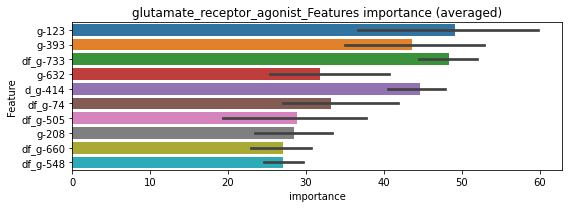

len(train_index) : 3860
len(valid_index) : 3860
================================= fold 1/2 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0322794	valid_1's binary_logloss: 0.0746464
[200]	training's binary_logloss: 0.00687823	valid_1's binary_logloss: 0.0467059
[300]	training's binary_logloss: 0.00192866	valid_1's binary_logloss: 0.0409752
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.00170229	valid_1's binary_logloss: 0.0407806


len(train_index) : 3860
len(valid_index) : 3860
================================= fold 2/2 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335199	valid_1's binary_logloss: 0.074166
[200]	training's binary_logloss: 0.00751365	valid_1's binary_logloss: 0.0441156
[300]	training's binary_logloss: 0.00214566	valid_1's binary_logloss: 0.0361788
[400]	training's binary_logloss: 0.000897118	valid_1's binary_logloss: 0.0340856
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.000943061	valid_1's binary_logloss: 0.0339896


glutamate_receptor_agonist logloss: 0.03738506499296895


neg labels: 3289 → selected neg labels: 3226


glutamate_receptor_antagonist, len(trt): 367, len(othr): 3226, target_rate: 0.0154111 → Adj_target_rate: 0.0127105
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127239	valid_1's binary_logloss: 0.367618
Early stopping, best iteration is:
[140]	training's binary_logloss: 0.0847978	valid_1's binary_logloss: 0.361802
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126815	valid_1's binary_logloss: 0.350033
Early stopping, best iteration is:
[180]	training's binary_logloss: 0.059497	valid_1's binary_logloss: 0.336172


1 / 3 AUC score:0.775
y_Threshold: 0.1330100, Threshold: 0.1806037, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 702 → Positive_corect_labels: 359/3169
p_label_rate: 0.0200904 Vs.target_rate: 0.01541
Num_p_label: 80.0, conf_0:0.16254, conf_1:0.19866
threshold: 0.1806037, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 359.0/3169, y_label_rate: 0.1132849
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0653688	valid_1's binary_logloss: 0.192335
[200]	training's binary_logloss: 0.0194842	valid_1's binary_logloss: 0.163406
Early stopping, best iteration is:
[254]	training's binary_logloss: 0.0109843	valid_1's binary_logloss: 0.160372
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0677342	valid_1's binary_logloss: 0.186793
[200]	training's binary_logloss: 0.0194367	valid_1's binary_logloss: 0.158496
Early stopping, best iteration is:
[236]	training's binary_logloss: 0.0128033	valid_1's binary_logloss: 0.155652


2 / 3 AUC score:0.960
y_Threshold: 0.0707188, Threshold: 0.1806037, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 142 → Positive_corect_labels: 288.0/3027
p_label_rate: 0.0055249 Vs.target_rate: 0.01541
Num_p_label: 22.0, conf_0:0.16254, conf_1:0.19866
threshold: 0.1806037, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 288.0/3027, y_label_rate: 0.0951437
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0471076	valid_1's binary_logloss: 0.158578
[200]	training's binary_logloss: 0.0110763	valid_1's binary_logloss: 0.135038
Early stopping, best iteration is:
[218]	training's binary_logloss: 0.00884289	valid_1's binary_logloss: 0.134733
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0461638	valid_1's binary_logloss: 0.164917
Early stopping, best iteration is:
[181]	training's binary_logloss: 0.0156843	valid_1's binary_logloss: 0.148082


3 / 3 AUC score:0.965
y_Threshold: 0.0649556, Threshold: 0.1806037, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 118 → Positive_corect_labels: 229.0/2909
p_label_rate: 0.0037670 Vs.target_rate: 0.01541
Num_p_label: 15.0, conf_0:0.16254, conf_1:0.19866
Num_p_label: 15.0, Expected: 61.4, Adj_threshold_1: 0.1806037
Num_p_label: 19.0, Expected: 61.4, Adj_threshold_2: 0.1706037
Num_p_label: 23.0, Expected: 61.4, Adj_threshold_3: 0.1606037
Num_p_label: 25.0, Expected: 61.4, Adj_threshold_4: 0.1506037
Num_p_label: 27.0, Expected: 61.4, Adj_threshold_5: 0.1406037
Num_p_label: 36.0, Expected: 61.4, Adj_threshold_6: 0.1306037
threshold: 0.1306037, positive_p_label: 36.0/3982, p_label_rate: 0.0090407
positive_y_label: 265.0/6891, y_label_rate: 0.0384560


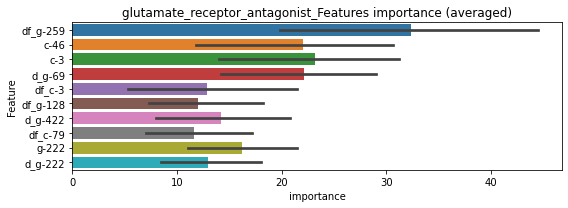

len(train_index) : 3445
len(valid_index) : 3446
================================= fold 1/2 glutamate_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0178335	valid_1's binary_logloss: 0.0875343
Early stopping, best iteration is:
[137]	training's binary_logloss: 0.00990657	valid_1's binary_logloss: 0.0852225


len(train_index) : 3446
len(valid_index) : 3445
================================= fold 2/2 glutamate_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180182	valid_1's binary_logloss: 0.0917848
Early stopping, best iteration is:
[163]	training's binary_logloss: 0.00712431	valid_1's binary_logloss: 0.0865033


glutamate_receptor_antagonist logloss: 0.0858628240099429


neg labels: 3289 → selected neg labels: 3286


gonadotropin_receptor_agonist, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0220905	valid_1's binary_logloss: 0.0290835
[200]	training's binary_logloss: 0.00252107	valid_1's binary_logloss: 0.00464574
[300]	training's binary_logloss: 0.000724909	valid_1's binary_logloss: 0.00169125
[400]	training's binary_logloss: 0.000387506	valid_1's binary_logloss: 0.0010261
[500]	training's binary_logloss: 0.000315278	valid_1's binary_logloss: 0.000878619
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000313552	valid_1's binary_logloss: 0.000874918
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0223286	valid_1's binary_logloss: 0.030713
[200]	training's binary_logloss: 0.00258028	valid_1's binary_logloss: 0.00520951
[300]	training's binary_logloss: 0.00072513	valid_1's binary_logloss: 0.00225175
[400]	training's binary_logloss: 0.000388108	valid_1's binary_logloss: 0.00157489
[500]	training's binary_logloss:

1 / 3 AUC score:1.000
y_Threshold: 0.0015803, Threshold: 0.0029086, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00262, conf_1:0.00320
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0029086
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_2: 0.0129086
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_3: 0.0229086
threshold: 0.0229086, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221128	valid_1's binary_logloss: 0.028007
[200]	training's binary_logloss: 0.00246841	valid_1's binary_logloss: 0.00391787
[300]	training's binary_logloss: 0.000696167	valid_1's binary_logloss: 0.00131
[400]	training's binary_logloss: 0.000376827	valid_1's binary_logloss: 0.000766758
[500]	training's binary_logloss: 0.000312375	valid_1's binary_logloss: 0.000656571
Early stopping, best iteration is:
[556]	training's binary_logloss: 0.000307393	valid_1's binary_logloss: 0.000649949
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222337	valid_1's binary_logloss: 0.0277005
[200]	training's binary_logloss: 0.00248771	valid_1's binary_logloss: 0.00388717
[300]	training's binary_logloss: 0.000716087	valid_1's binary_logloss: 0.0014115
[400]	training's binary_logloss: 0.000388014	valid_1's binary_logloss: 0.000913204
[500]	training's binary_logloss:

2 / 3 AUC score:1.000
y_Threshold: 0.1546111, Threshold: 0.0229086, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0027624 Vs.target_rate: 0.00076
Num_p_label: 11.0, conf_0:0.02062, conf_1:0.02520
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_1: 0.0229086
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_2: 0.0329086
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_3: 0.0429086
threshold: 0.0429086, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221128	valid_1's binary_logloss: 0.028007
[200]	training's binary_logloss: 0.00246841	valid_1's binary_logloss: 0.00391787
[300]	training's binary_logloss: 0.000696167	valid_1's binary_logloss: 0.00131
[400]	training's binary_logloss: 0.000376827	valid_1's binary_logloss: 0.000766758
[500]	training's binary_logloss: 0.000312375	valid_1's binary_logloss: 0.000656571
Early stopping, best iteration is:
[556]	training's binary_logloss: 0.000307393	valid_1's binary_logloss: 0.000649949
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222337	valid_1's binary_logloss: 0.0277005
[200]	training's binary_logloss: 0.00248771	valid_1's binary_logloss: 0.00388717
[300]	training's binary_logloss: 0.000716087	valid_1's binary_logloss: 0.0014115
[400]	training's binary_logloss: 0.000388014	valid_1's binary_logloss: 0.000913204
[500]	training's binary_logloss:

3 / 3 AUC score:1.000
y_Threshold: 0.1546111, Threshold: 0.0429086, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0015068 Vs.target_rate: 0.00076
Num_p_label: 6.0, conf_0:0.03862, conf_1:0.04720
threshold: 0.0429086, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7793, y_label_rate: 0.0850764


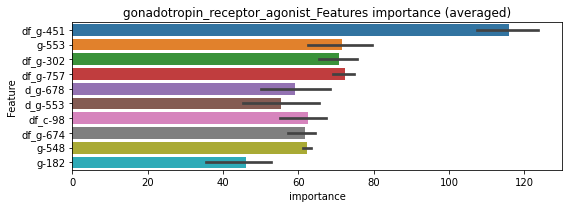

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0116812	valid_1's binary_logloss: 0.020166
[200]	training's binary_logloss: 0.00130586	valid_1's binary_logloss: 0.00781523
[300]	training's binary_logloss: 0.000363615	valid_1's binary_logloss: 0.00683482
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.000316916	valid_1's binary_logloss: 0.0067874


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.01244	valid_1's binary_logloss: 0.0210678
[200]	training's binary_logloss: 0.00142717	valid_1's binary_logloss: 0.00705582
[300]	training's binary_logloss: 0.000391942	valid_1's binary_logloss: 0.0046747
[400]	training's binary_logloss: 0.00020358	valid_1's binary_logloss: 0.00392967
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000165957	valid_1's binary_logloss: 0.00377201


gonadotropin_receptor_agonist logloss: 0.005279898000657087


neg labels: 3289 → selected neg labels: 3279


gsk_inhibitor, len(trt): 60, len(othr): 3279, target_rate: 0.0025195 → Adj_target_rate: 0.0027266
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0323794	valid_1's binary_logloss: 0.0642763
[200]	training's binary_logloss: 0.00488456	valid_1's binary_logloss: 0.0275751
[300]	training's binary_logloss: 0.00143443	valid_1's binary_logloss: 0.0197409
[400]	training's binary_logloss: 0.000698142	valid_1's binary_logloss: 0.0176105
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000522959	valid_1's binary_logloss: 0.0169344
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0322281	valid_1's binary_logloss: 0.0638574
[200]	training's binary_logloss: 0.00475424	valid_1's binary_logloss: 0.0255484
[300]	training's binary_logloss: 0.00138513	valid_1's binary_logloss: 0.0183968
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.000760069	valid_1's binary_logloss: 0.0164415


1 / 3 AUC score:1.000
y_Threshold: 0.0040225, Threshold: 0.0060041, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 654/3800
p_label_rate: 0.0200904 Vs.target_rate: 0.00252
Num_p_label: 80.0, conf_0:0.00540, conf_1:0.00660
Num_p_label: 80.0, Expected: 10.0, Adj_threshold_1: 0.0060041
Num_p_label: 23.0, Expected: 10.0, Adj_threshold_2: 0.0160041
Num_p_label: 11.0, Expected: 10.0, Adj_threshold_3: 0.0260041
threshold: 0.0260041, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 654.0/3800, y_label_rate: 0.1721053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0325699	valid_1's binary_logloss: 0.0577488
[200]	training's binary_logloss: 0.00481577	valid_1's binary_logloss: 0.0166504
[300]	training's binary_logloss: 0.0014019	valid_1's binary_logloss: 0.0085393
[400]	training's binary_logloss: 0.000684934	valid_1's binary_logloss: 0.00577072
[500]	training's binary_logloss: 0.000467881	valid_1's binary_logloss: 0.00490676
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.000471601	valid_1's binary_logloss: 0.0048988
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.033128	valid_1's binary_logloss: 0.0637736
[200]	training's binary_logloss: 0.00476006	valid_1's binary_logloss: 0.0258078
[300]	training's binary_logloss: 0.00135323	valid_1's binary_logloss: 0.0190776
[400]	training's binary_logloss: 0.000665676	valid_1's binary_logloss: 0.0172816
Early stopping, best iteration is:
[404]	

2 / 3 AUC score:1.000
y_Threshold: 0.0175040, Threshold: 0.0260041, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 652.0/3796
p_label_rate: 0.0057760 Vs.target_rate: 0.00252
Num_p_label: 23.0, conf_0:0.02340, conf_1:0.02860
threshold: 0.0260041, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 652.0/3796, y_label_rate: 0.1717597
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031832	valid_1's binary_logloss: 0.059595
[200]	training's binary_logloss: 0.00458253	valid_1's binary_logloss: 0.0207828
[300]	training's binary_logloss: 0.00133068	valid_1's binary_logloss: 0.0129475
[400]	training's binary_logloss: 0.000661816	valid_1's binary_logloss: 0.0103829
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.000531735	valid_1's binary_logloss: 0.00968801
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0332706	valid_1's binary_logloss: 0.0550214
[200]	training's binary_logloss: 0.00492098	valid_1's binary_logloss: 0.015236
[300]	training's binary_logloss: 0.00141054	valid_1's binary_logloss: 0.00774495
[400]	training's binary_logloss: 0.000692786	valid_1's binary_logloss: 0.00556444
[500]	training's binary_logloss: 0.000466884	valid_1's binary_logloss: 0.00478817
Early stopping, best iteration is:
[542]

3 / 3 AUC score:1.000
y_Threshold: 0.0224310, Threshold: 0.0260041, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 652.0/3796
p_label_rate: 0.0060271 Vs.target_rate: 0.00252
Num_p_label: 24.0, conf_0:0.02340, conf_1:0.02860
threshold: 0.0260041, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 676.0/7778, y_label_rate: 0.0869118


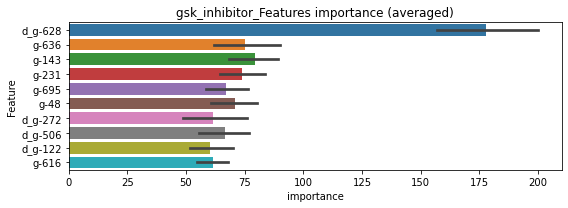

len(train_index) : 3889
len(valid_index) : 3889
================================= fold 1/2 gsk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0171282	valid_1's binary_logloss: 0.0504282
[200]	training's binary_logloss: 0.00240426	valid_1's binary_logloss: 0.0324428
[300]	training's binary_logloss: 0.00068052	valid_1's binary_logloss: 0.0306401
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.000748369	valid_1's binary_logloss: 0.030631


len(train_index) : 3889
len(valid_index) : 3889
================================= fold 2/2 gsk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0178474	valid_1's binary_logloss: 0.0382558
[200]	training's binary_logloss: 0.00260385	valid_1's binary_logloss: 0.0194103
[300]	training's binary_logloss: 0.000761514	valid_1's binary_logloss: 0.0159457
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.000546209	valid_1's binary_logloss: 0.0152825


gsk_inhibitor logloss: 0.022956717429838455


neg labels: 3289 → selected neg labels: 3277


hcv_inhibitor, len(trt): 72, len(othr): 3277, target_rate: 0.0030234 → Adj_target_rate: 0.0031837
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0572459	valid_1's binary_logloss: 0.118227
[200]	training's binary_logloss: 0.01302	valid_1's binary_logloss: 0.0702627
[300]	training's binary_logloss: 0.00368556	valid_1's binary_logloss: 0.0561071
[400]	training's binary_logloss: 0.00160789	valid_1's binary_logloss: 0.0507403
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00154213	valid_1's binary_logloss: 0.0503428
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0553482	valid_1's binary_logloss: 0.115325
[200]	training's binary_logloss: 0.0117387	valid_1's binary_logloss: 0.0674718
[300]	training's binary_logloss: 0.003411	valid_1's binary_logloss: 0.056289
Early stopping, best iteration is:
[352]	training's binary_logloss: 0.00215328	valid_1's binary_logloss: 0.0534831


1 / 3 AUC score:0.995
y_Threshold: 0.0131555, Threshold: 0.0161242, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 150 → Positive_corect_labels: 646/3782
p_label_rate: 0.0200904 Vs.target_rate: 0.00302
Num_p_label: 80.0, conf_0:0.01451, conf_1:0.01774
Num_p_label: 80.0, Expected: 12.0, Adj_threshold_1: 0.0161242
Num_p_label: 25.0, Expected: 12.0, Adj_threshold_2: 0.0261242
Num_p_label: 12.0, Expected: 12.0, Adj_threshold_3: 0.0361242
threshold: 0.0361242, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 646.0/3782, y_label_rate: 0.1708091
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0510873	valid_1's binary_logloss: 0.113213
[200]	training's binary_logloss: 0.0106277	valid_1's binary_logloss: 0.0670813
[300]	training's binary_logloss: 0.00305735	valid_1's binary_logloss: 0.0557548
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.0014686	valid_1's binary_logloss: 0.0524606
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0526919	valid_1's binary_logloss: 0.106292
[200]	training's binary_logloss: 0.0107498	valid_1's binary_logloss: 0.054709
[300]	training's binary_logloss: 0.00311004	valid_1's binary_logloss: 0.0417119
[400]	training's binary_logloss: 0.00140285	valid_1's binary_logloss: 0.03712
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00121697	valid_1's binary_logloss: 0.0367739


2 / 3 AUC score:0.997
y_Threshold: 0.0380239, Threshold: 0.0361242, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 26 → Positive_corect_labels: 633.0/3756
p_label_rate: 0.0075339 Vs.target_rate: 0.00302
Num_p_label: 30.0, conf_0:0.03251, conf_1:0.03974
threshold: 0.0361242, positive_p_label: 30.0/3982, p_label_rate: 0.0075339
positive_y_label: 633.0/3756, y_label_rate: 0.1685304
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0498618	valid_1's binary_logloss: 0.101765
[200]	training's binary_logloss: 0.0101145	valid_1's binary_logloss: 0.0529833
[300]	training's binary_logloss: 0.00292807	valid_1's binary_logloss: 0.0407363
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00187936	valid_1's binary_logloss: 0.0383132
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.050556	valid_1's binary_logloss: 0.111787
[200]	training's binary_logloss: 0.00989662	valid_1's binary_logloss: 0.0635285
[300]	training's binary_logloss: 0.00284012	valid_1's binary_logloss: 0.0522128
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.00200736	valid_1's binary_logloss: 0.0501076


3 / 3 AUC score:0.996
y_Threshold: 0.0382662, Threshold: 0.0361242, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 26 → Positive_corect_labels: 620.0/3730
p_label_rate: 0.0113009 Vs.target_rate: 0.00302
Num_p_label: 45.0, conf_0:0.03251, conf_1:0.03974
Num_p_label: 45.0, Expected: 12.0, Adj_threshold_1: 0.0361242
Num_p_label: 29.0, Expected: 12.0, Adj_threshold_2: 0.0461242
Num_p_label: 19.0, Expected: 12.0, Adj_threshold_3: 0.0561242
threshold: 0.0561242, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 639.0/7712, y_label_rate: 0.0828579


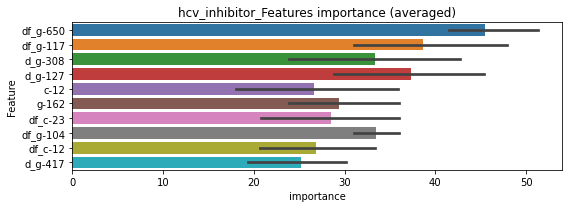

len(train_index) : 3856
len(valid_index) : 3856
================================= fold 1/2 hcv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289004	valid_1's binary_logloss: 0.059671
[200]	training's binary_logloss: 0.00556632	valid_1's binary_logloss: 0.0344337
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00185506	valid_1's binary_logloss: 0.0304252


len(train_index) : 3856
len(valid_index) : 3856
================================= fold 2/2 hcv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285471	valid_1's binary_logloss: 0.0664604
[200]	training's binary_logloss: 0.00564741	valid_1's binary_logloss: 0.0420836
[300]	training's binary_logloss: 0.00150876	valid_1's binary_logloss: 0.0371331
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00113529	valid_1's binary_logloss: 0.0365942


hcv_inhibitor logloss: 0.0335096863171146


neg labels: 3289 → selected neg labels: 3271


hdac_inhibitor, len(trt): 106, len(othr): 3271, target_rate: 0.0044512 → Adj_target_rate: 0.0044229
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304108	valid_1's binary_logloss: 0.0697136
[200]	training's binary_logloss: 0.00457716	valid_1's binary_logloss: 0.0380208
[300]	training's binary_logloss: 0.00134655	valid_1's binary_logloss: 0.0330856
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.000815363	valid_1's binary_logloss: 0.0318705
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297496	valid_1's binary_logloss: 0.0594232
[200]	training's binary_logloss: 0.00442242	valid_1's binary_logloss: 0.0328827
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00222477	valid_1's binary_logloss: 0.0304932


1 / 3 AUC score:0.997
y_Threshold: 0.0077856, Threshold: 0.0179122, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 141 → Positive_corect_labels: 649/3784
p_label_rate: 0.0200904 Vs.target_rate: 0.00445
Num_p_label: 80.0, conf_0:0.01612, conf_1:0.01970
Num_p_label: 80.0, Expected: 17.7, Adj_threshold_1: 0.0179122
Num_p_label: 50.0, Expected: 17.7, Adj_threshold_2: 0.0279122
Num_p_label: 31.0, Expected: 17.7, Adj_threshold_3: 0.0379122
threshold: 0.0379122, positive_p_label: 31.0/3982, p_label_rate: 0.0077850
positive_y_label: 649.0/3784, y_label_rate: 0.1715116
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286086	valid_1's binary_logloss: 0.0590256
[200]	training's binary_logloss: 0.0038647	valid_1's binary_logloss: 0.0274798
Early stopping, best iteration is:
[256]	training's binary_logloss: 0.00177498	valid_1's binary_logloss: 0.023363
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295962	valid_1's binary_logloss: 0.0524639
[200]	training's binary_logloss: 0.00414037	valid_1's binary_logloss: 0.0232749
[300]	training's binary_logloss: 0.00119584	valid_1's binary_logloss: 0.0178157
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.000961118	valid_1's binary_logloss: 0.0173157


2 / 3 AUC score:1.000
y_Threshold: 0.0367429, Threshold: 0.0379122, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 645.0/3776
p_label_rate: 0.0228528 Vs.target_rate: 0.00445
Num_p_label: 91.0, conf_0:0.03412, conf_1:0.04170
Num_p_label: 91.0, Expected: 17.7, Adj_threshold_1: 0.0379122
Num_p_label: 71.0, Expected: 17.7, Adj_threshold_2: 0.0479122
Num_p_label: 63.0, Expected: 17.7, Adj_threshold_3: 0.0579122
Num_p_label: 51.0, Expected: 17.7, Adj_threshold_4: 0.0679122
Num_p_label: 47.0, Expected: 17.7, Adj_threshold_5: 0.0779122
Num_p_label: 41.0, Expected: 17.7, Adj_threshold_6: 0.0879122
Num_p_label: 40.0, Expected: 17.7, Adj_threshold_7: 0.0979122
Num_p_label: 38.0, Expected: 17.7, Adj_threshold_8: 0.1079122
Num_p_label: 36.0, Expected: 17.7, Adj_threshold_9: 0.1179122
Num_p_label: 35.0, Expected: 17.7, Adj_threshold_10: 0.1279122
threshold: 0.1279122, positive_p_label: 35.0/3982, p_label_rate: 0.0087896
positive_y_label: 645.0/3776, y_label_rate: 0.1708157

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281879	valid_1's binary_logloss: 0.0513094
[200]	training's binary_logloss: 0.00393226	valid_1's binary_logloss: 0.0218385
[300]	training's binary_logloss: 0.00114775	valid_1's binary_logloss: 0.0157237
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.000894209	valid_1's binary_logloss: 0.0150808
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027945	valid_1's binary_logloss: 0.0541523
[200]	training's binary_logloss: 0.00392904	valid_1's binary_logloss: 0.0250685
[300]	training's binary_logloss: 0.00113879	valid_1's binary_logloss: 0.0194273
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.000719062	valid_1's binary_logloss: 0.0179791


3 / 3 AUC score:1.000
y_Threshold: 0.0342266, Threshold: 0.1279122, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 642.0/3770
p_label_rate: 0.0087896 Vs.target_rate: 0.00445
Num_p_label: 35.0, conf_0:0.11512, conf_1:0.14070
threshold: 0.1279122, positive_p_label: 35.0/3982, p_label_rate: 0.0087896
positive_y_label: 677.0/7752, y_label_rate: 0.0873323


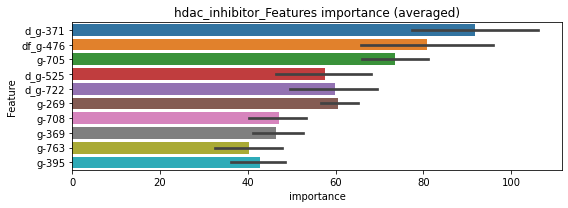

len(train_index) : 3876
len(valid_index) : 3876
================================= fold 1/2 hdac_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156391	valid_1's binary_logloss: 0.0374885
[200]	training's binary_logloss: 0.00227425	valid_1's binary_logloss: 0.0234282
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.000782012	valid_1's binary_logloss: 0.0212714


len(train_index) : 3876
len(valid_index) : 3876
================================= fold 2/2 hdac_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155119	valid_1's binary_logloss: 0.043473
[200]	training's binary_logloss: 0.00221812	valid_1's binary_logloss: 0.030252
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.00131124	valid_1's binary_logloss: 0.0285851


hdac_inhibitor logloss: 0.02492820446704874


neg labels: 3289 → selected neg labels: 3279


histamine_receptor_agonist, len(trt): 59, len(othr): 3279, target_rate: 0.0024775 → Adj_target_rate: 0.0026880
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0516652	valid_1's binary_logloss: 0.0909657
[200]	training's binary_logloss: 0.00988915	valid_1's binary_logloss: 0.0348537
[300]	training's binary_logloss: 0.00278976	valid_1's binary_logloss: 0.0214176
[400]	training's binary_logloss: 0.00125781	valid_1's binary_logloss: 0.0167119
[500]	training's binary_logloss: 0.0007771	valid_1's binary_logloss: 0.0146824
Early stopping, best iteration is:
[553]	training's binary_logloss: 0.000644068	valid_1's binary_logloss: 0.0141272
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0511649	valid_1's binary_logloss: 0.0928799
[200]	training's binary_logloss: 0.0103692	valid_1's binary_logloss: 0.0405044
[300]	training's binary_logloss: 0.00287495	valid_1's binary_logloss: 0.0276893
[400]	training's binary_logloss: 0.00128582	valid_1's binary_logloss: 0.0229624
Early stopping, best iteration is:
[430]	train

1 / 3 AUC score:1.000
y_Threshold: 0.0079618, Threshold: 0.0112442, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 654/3800
p_label_rate: 0.0200904 Vs.target_rate: 0.00248
Num_p_label: 80.0, conf_0:0.01012, conf_1:0.01237
Num_p_label: 80.0, Expected: 9.9, Adj_threshold_1: 0.0112442
Num_p_label: 25.0, Expected: 9.9, Adj_threshold_2: 0.0212442
Num_p_label: 12.0, Expected: 9.9, Adj_threshold_3: 0.0312442
threshold: 0.0312442, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 654.0/3800, y_label_rate: 0.1721053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0481923	valid_1's binary_logloss: 0.0951652
[200]	training's binary_logloss: 0.00928697	valid_1's binary_logloss: 0.0458014
[300]	training's binary_logloss: 0.00262425	valid_1's binary_logloss: 0.0333236
[400]	training's binary_logloss: 0.00119775	valid_1's binary_logloss: 0.0300812
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000983579	valid_1's binary_logloss: 0.0290808
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0504275	valid_1's binary_logloss: 0.0986675
[200]	training's binary_logloss: 0.00895898	valid_1's binary_logloss: 0.0482801
[300]	training's binary_logloss: 0.00255929	valid_1's binary_logloss: 0.0383654
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.00180721	valid_1's binary_logloss: 0.0371242


2 / 3 AUC score:0.999
y_Threshold: 0.0366980, Threshold: 0.0312442, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 20 → Positive_corect_labels: 644.0/3780
p_label_rate: 0.0120542 Vs.target_rate: 0.00248
Num_p_label: 48.0, conf_0:0.02812, conf_1:0.03437
Num_p_label: 48.0, Expected: 9.9, Adj_threshold_1: 0.0312442
Num_p_label: 25.0, Expected: 9.9, Adj_threshold_2: 0.0412442
Num_p_label: 15.0, Expected: 9.9, Adj_threshold_3: 0.0512442
threshold: 0.0512442, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 644.0/3780, y_label_rate: 0.1703704
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0489157	valid_1's binary_logloss: 0.0868462
[200]	training's binary_logloss: 0.00916537	valid_1's binary_logloss: 0.0375696
[300]	training's binary_logloss: 0.00256551	valid_1's binary_logloss: 0.0257489
[400]	training's binary_logloss: 0.00116406	valid_1's binary_logloss: 0.0210404
[500]	training's binary_logloss: 0.000728996	valid_1's binary_logloss: 0.0195388
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000740328	valid_1's binary_logloss: 0.0195365
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0483792	valid_1's binary_logloss: 0.0864402
[200]	training's binary_logloss: 0.00896469	valid_1's binary_logloss: 0.0341739
[300]	training's binary_logloss: 0.00255298	valid_1's binary_logloss: 0.021323
[400]	training's binary_logloss: 0.0011703	valid_1's binary_logloss: 0.0180823
Early stopping, best iteration is:
[416]	trai

3 / 3 AUC score:1.000
y_Threshold: 0.0316685, Threshold: 0.0512442, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 641.0/3774
p_label_rate: 0.0032647 Vs.target_rate: 0.00248
Num_p_label: 13.0, conf_0:0.04612, conf_1:0.05637
threshold: 0.0512442, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 654.0/7756, y_label_rate: 0.0843218


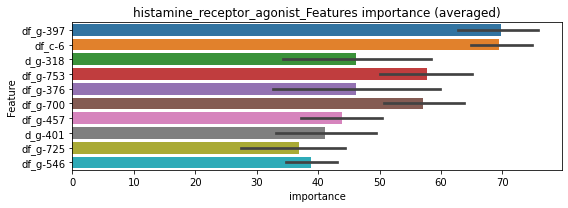

len(train_index) : 3878
len(valid_index) : 3878
================================= fold 1/2 histamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027994	valid_1's binary_logloss: 0.0574306
[200]	training's binary_logloss: 0.00521503	valid_1's binary_logloss: 0.0288318
[300]	training's binary_logloss: 0.00143482	valid_1's binary_logloss: 0.0232242
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.000796954	valid_1's binary_logloss: 0.0223342


len(train_index) : 3878
len(valid_index) : 3878
================================= fold 2/2 histamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0267755	valid_1's binary_logloss: 0.0697474
[200]	training's binary_logloss: 0.00498422	valid_1's binary_logloss: 0.0466861
[300]	training's binary_logloss: 0.00137166	valid_1's binary_logloss: 0.0442227
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.00131267	valid_1's binary_logloss: 0.0441491


histamine_receptor_agonist logloss: 0.03324165522282041


neg labels: 3289 → selected neg labels: 3249


histamine_receptor_antagonist, len(trt): 241, len(othr): 3249, target_rate: 0.0101201 → Adj_target_rate: 0.0088902
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105598	valid_1's binary_logloss: 0.268554
[200]	training's binary_logloss: 0.0365716	valid_1's binary_logloss: 0.234729
Early stopping, best iteration is:
[208]	training's binary_logloss: 0.0336099	valid_1's binary_logloss: 0.233708
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103321	valid_1's binary_logloss: 0.272649
[200]	training's binary_logloss: 0.0350746	valid_1's binary_logloss: 0.240883
Early stopping, best iteration is:
[242]	training's binary_logloss: 0.0228037	valid_1's binary_logloss: 0.237039


1 / 3 AUC score:0.900
y_Threshold: 0.0889445, Threshold: 0.1277707, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 413 → Positive_corect_labels: 508/3485
p_label_rate: 0.0200904 Vs.target_rate: 0.01012
Num_p_label: 80.0, conf_0:0.11499, conf_1:0.14055
threshold: 0.1277707, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 508.0/3485, y_label_rate: 0.1457676
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.07352	valid_1's binary_logloss: 0.192775
[200]	training's binary_logloss: 0.0202382	valid_1's binary_logloss: 0.150606
Early stopping, best iteration is:
[287]	training's binary_logloss: 0.00759849	valid_1's binary_logloss: 0.141296
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0744882	valid_1's binary_logloss: 0.182153
[200]	training's binary_logloss: 0.0200103	valid_1's binary_logloss: 0.140213
[300]	training's binary_logloss: 0.00626927	valid_1's binary_logloss: 0.131368
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.0067841	valid_1's binary_logloss: 0.130997


2 / 3 AUC score:0.975
y_Threshold: 0.0684817, Threshold: 0.1277707, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 118 → Positive_corect_labels: 449.0/3367
p_label_rate: 0.0105475 Vs.target_rate: 0.01012
Num_p_label: 42.0, conf_0:0.11499, conf_1:0.14055
threshold: 0.1277707, positive_p_label: 42.0/3982, p_label_rate: 0.0105475
positive_y_label: 449.0/3367, y_label_rate: 0.1333531
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.057158	valid_1's binary_logloss: 0.165782
[200]	training's binary_logloss: 0.0137951	valid_1's binary_logloss: 0.127087
Early stopping, best iteration is:
[233]	training's binary_logloss: 0.00906232	valid_1's binary_logloss: 0.122713
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0626773	valid_1's binary_logloss: 0.169814
[200]	training's binary_logloss: 0.0154583	valid_1's binary_logloss: 0.135973
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.00947319	valid_1's binary_logloss: 0.132371


3 / 3 AUC score:0.977
y_Threshold: 0.0740180, Threshold: 0.1277707, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 104 → Positive_corect_labels: 397.0/3263
p_label_rate: 0.0123054 Vs.target_rate: 0.01012
Num_p_label: 49.0, conf_0:0.11499, conf_1:0.14055
threshold: 0.1277707, positive_p_label: 49.0/3982, p_label_rate: 0.0123054
positive_y_label: 446.0/7245, y_label_rate: 0.0615597


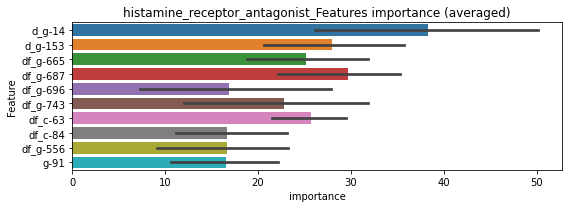

len(train_index) : 3622
len(valid_index) : 3623
================================= fold 1/2 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0322143	valid_1's binary_logloss: 0.0964658
[200]	training's binary_logloss: 0.00811046	valid_1's binary_logloss: 0.0791994
Early stopping, best iteration is:
[232]	training's binary_logloss: 0.00531357	valid_1's binary_logloss: 0.0779267


len(train_index) : 3623
len(valid_index) : 3622
================================= fold 2/2 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031501	valid_1's binary_logloss: 0.0998277
[200]	training's binary_logloss: 0.00805832	valid_1's binary_logloss: 0.0806036
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.00560738	valid_1's binary_logloss: 0.0789248


histamine_receptor_antagonist logloss: 0.07842565672265579


neg labels: 3289 → selected neg labels: 3285


histone_lysine_demethylase_inhibitor, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234277	valid_1's binary_logloss: 0.0316267
[200]	training's binary_logloss: 0.00275382	valid_1's binary_logloss: 0.00515001
[300]	training's binary_logloss: 0.000770401	valid_1's binary_logloss: 0.00181513
[400]	training's binary_logloss: 0.00040429	valid_1's binary_logloss: 0.00111888
[500]	training's binary_logloss: 0.000315461	valid_1's binary_logloss: 0.00093528
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000313462	valid_1's binary_logloss: 0.000933156
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237969	valid_1's binary_logloss: 0.0333937
[200]	training's binary_logloss: 0.00278849	valid_1's binary_logloss: 0.00562762
[300]	training's binary_logloss: 0.000773989	valid_1's binary_logloss: 0.00201976
[400]	training's binary_logloss: 0.000409725	valid_1's binary_logloss: 0.00126753
[500]	training's binary_logloss

1 / 3 AUC score:1.000
y_Threshold: 0.0011864, Threshold: 0.0018077, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00101
Num_p_label: 80.0, conf_0:0.00163, conf_1:0.00199
Num_p_label: 80.0, Expected: 4.0, Adj_threshold_1: 0.0018077
Num_p_label: 3.0, Expected: 4.0, Adj_threshold_2: 0.0118077
threshold: 0.0118077, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234952	valid_1's binary_logloss: 0.0312865
[200]	training's binary_logloss: 0.00270579	valid_1's binary_logloss: 0.00472642
[300]	training's binary_logloss: 0.000763633	valid_1's binary_logloss: 0.00159732
[400]	training's binary_logloss: 0.000403681	valid_1's binary_logloss: 0.000946225
[500]	training's binary_logloss: 0.000317073	valid_1's binary_logloss: 0.000779936
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.000311839	valid_1's binary_logloss: 0.000773664
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0236914	valid_1's binary_logloss: 0.0346065
[200]	training's binary_logloss: 0.00271125	valid_1's binary_logloss: 0.0057047
[300]	training's binary_logloss: 0.000757866	valid_1's binary_logloss: 0.00209208
[400]	training's binary_logloss: 0.000399664	valid_1's binary_logloss: 0.0013047
Early stopping, best iteration

2 / 3 AUC score:1.000
y_Threshold: 0.1433889, Threshold: 0.0118077, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0030136 Vs.target_rate: 0.00101
Num_p_label: 12.0, conf_0:0.01063, conf_1:0.01299
threshold: 0.0118077, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234952	valid_1's binary_logloss: 0.0312865
[200]	training's binary_logloss: 0.00270579	valid_1's binary_logloss: 0.00472642
[300]	training's binary_logloss: 0.000763633	valid_1's binary_logloss: 0.00159732
[400]	training's binary_logloss: 0.000403681	valid_1's binary_logloss: 0.000946225
[500]	training's binary_logloss: 0.000317073	valid_1's binary_logloss: 0.000779936
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.000311839	valid_1's binary_logloss: 0.000773664
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0236914	valid_1's binary_logloss: 0.0346065
[200]	training's binary_logloss: 0.00271125	valid_1's binary_logloss: 0.0057047
[300]	training's binary_logloss: 0.000757866	valid_1's binary_logloss: 0.00209208
[400]	training's binary_logloss: 0.000399664	valid_1's binary_logloss: 0.0013047
Early stopping, best iteration

3 / 3 AUC score:1.000
y_Threshold: 0.1433889, Threshold: 0.0118077, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0030136 Vs.target_rate: 0.00101
Num_p_label: 12.0, conf_0:0.01063, conf_1:0.01299
threshold: 0.0118077, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 669.0/7792, y_label_rate: 0.0858573


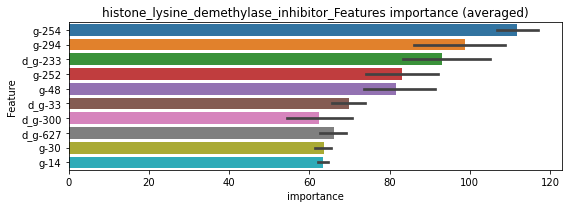

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0127668	valid_1's binary_logloss: 0.0270533
[200]	training's binary_logloss: 0.00145171	valid_1's binary_logloss: 0.0139285
[300]	training's binary_logloss: 0.000393282	valid_1's binary_logloss: 0.0127714
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.000413413	valid_1's binary_logloss: 0.0127274


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0129037	valid_1's binary_logloss: 0.0222313
[200]	training's binary_logloss: 0.00157469	valid_1's binary_logloss: 0.0100098
Early stopping, best iteration is:
[276]	training's binary_logloss: 0.000542876	valid_1's binary_logloss: 0.00864578


histone_lysine_demethylase_inhibitor logloss: 0.010686575375223566


neg labels: 3289 → selected neg labels: 3283


histone_lysine_methyltransferase_inhibitor, len(trt): 32, len(othr): 3283, target_rate: 0.0013437 → Adj_target_rate: 0.0015980
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286603	valid_1's binary_logloss: 0.0506934
[200]	training's binary_logloss: 0.00382102	valid_1's binary_logloss: 0.0128378
[300]	training's binary_logloss: 0.00107711	valid_1's binary_logloss: 0.00658277
[400]	training's binary_logloss: 0.000541995	valid_1's binary_logloss: 0.00488745
[500]	training's binary_logloss: 0.00038671	valid_1's binary_logloss: 0.00430117
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.000372763	valid_1's binary_logloss: 0.00427166
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287119	valid_1's binary_logloss: 0.0513552
[200]	training's binary_logloss: 0.00382292	valid_1's binary_logloss: 0.02013
[300]	training's binary_logloss: 0.0010701	valid_1's binary_logloss: 0.0157559
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00102251	valid_1's binary_logloss: 0.0157016


1 / 3 AUC score:1.000
y_Threshold: 0.0040944, Threshold: 0.0060171, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00134
Num_p_label: 80.0, conf_0:0.00542, conf_1:0.00662
Num_p_label: 80.0, Expected: 5.4, Adj_threshold_1: 0.0060171
Num_p_label: 14.0, Expected: 5.4, Adj_threshold_2: 0.0160171
Num_p_label: 8.0, Expected: 5.4, Adj_threshold_3: 0.0260171
threshold: 0.0260171, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289492	valid_1's binary_logloss: 0.0477609
[200]	training's binary_logloss: 0.00377134	valid_1's binary_logloss: 0.0116266
[300]	training's binary_logloss: 0.00106753	valid_1's binary_logloss: 0.0058663
[400]	training's binary_logloss: 0.000536031	valid_1's binary_logloss: 0.00438795
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.000462363	valid_1's binary_logloss: 0.00419244
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028414	valid_1's binary_logloss: 0.0512098
[200]	training's binary_logloss: 0.00366587	valid_1's binary_logloss: 0.0199096
Early stopping, best iteration is:
[272]	training's binary_logloss: 0.00139316	valid_1's binary_logloss: 0.0165157


2 / 3 AUC score:1.000
y_Threshold: 0.0194348, Threshold: 0.0260171, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 652.0/3799
p_label_rate: 0.0047715 Vs.target_rate: 0.00134
Num_p_label: 19.0, conf_0:0.02342, conf_1:0.02862
Num_p_label: 19.0, Expected: 5.4, Adj_threshold_1: 0.0260171
Num_p_label: 14.0, Expected: 5.4, Adj_threshold_2: 0.0360171
Num_p_label: 10.0, Expected: 5.4, Adj_threshold_3: 0.0460171
threshold: 0.0460171, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 652.0/3799, y_label_rate: 0.1716241
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0280957	valid_1's binary_logloss: 0.0449277
[200]	training's binary_logloss: 0.00368746	valid_1's binary_logloss: 0.0132362
[300]	training's binary_logloss: 0.00104496	valid_1's binary_logloss: 0.00862249
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.000591349	valid_1's binary_logloss: 0.00777655
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283985	valid_1's binary_logloss: 0.0477364
[200]	training's binary_logloss: 0.00371168	valid_1's binary_logloss: 0.0133832
[300]	training's binary_logloss: 0.00104188	valid_1's binary_logloss: 0.00774114
[400]	training's binary_logloss: 0.000524724	valid_1's binary_logloss: 0.00607076
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.000412912	valid_1's binary_logloss: 0.00565681


3 / 3 AUC score:1.000
y_Threshold: 0.0273276, Threshold: 0.0460171, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 651.0/3797
p_label_rate: 0.0017579 Vs.target_rate: 0.00134
Num_p_label: 7.0, conf_0:0.04142, conf_1:0.05062
threshold: 0.0460171, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 658.0/7779, y_label_rate: 0.0845867


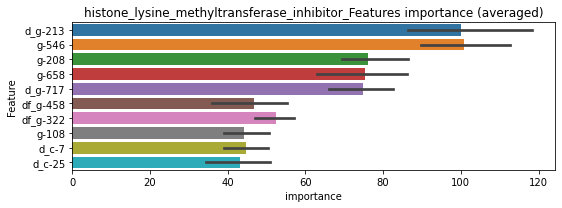

len(train_index) : 3889
len(valid_index) : 3890
================================= fold 1/2 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152201	valid_1's binary_logloss: 0.0262876
[200]	training's binary_logloss: 0.00198389	valid_1's binary_logloss: 0.0087501
[300]	training's binary_logloss: 0.000550048	valid_1's binary_logloss: 0.00652122
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.000412489	valid_1's binary_logloss: 0.00631343


len(train_index) : 3890
len(valid_index) : 3889
================================= fold 2/2 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0146091	valid_1's binary_logloss: 0.029301
[200]	training's binary_logloss: 0.0019404	valid_1's binary_logloss: 0.0126374
[300]	training's binary_logloss: 0.000545113	valid_1's binary_logloss: 0.0102147
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.000480225	valid_1's binary_logloss: 0.0100253


histone_lysine_methyltransferase_inhibitor logloss: 0.008169135514307911


neg labels: 3289 → selected neg labels: 3278


hiv_inhibitor, len(trt): 72, len(othr): 3278, target_rate: 0.0030234 → Adj_target_rate: 0.0031837
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0553228	valid_1's binary_logloss: 0.120137
[200]	training's binary_logloss: 0.0112968	valid_1's binary_logloss: 0.0679464
[300]	training's binary_logloss: 0.00315562	valid_1's binary_logloss: 0.0559792
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.00153987	valid_1's binary_logloss: 0.0537714
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0551859	valid_1's binary_logloss: 0.120114
[200]	training's binary_logloss: 0.0116645	valid_1's binary_logloss: 0.0747611
[300]	training's binary_logloss: 0.00327391	valid_1's binary_logloss: 0.0650528
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.00277714	valid_1's binary_logloss: 0.0644082


1 / 3 AUC score:0.994
y_Threshold: 0.0158283, Threshold: 0.0233499, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 166 → Positive_corect_labels: 638/3767
p_label_rate: 0.0200904 Vs.target_rate: 0.00302
Num_p_label: 80.0, conf_0:0.02101, conf_1:0.02568
Num_p_label: 80.0, Expected: 12.0, Adj_threshold_1: 0.0233499
Num_p_label: 43.0, Expected: 12.0, Adj_threshold_2: 0.0333499
Num_p_label: 22.0, Expected: 12.0, Adj_threshold_3: 0.0433499
threshold: 0.0433499, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 638.0/3767, y_label_rate: 0.1693655
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0527949	valid_1's binary_logloss: 0.106242
[200]	training's binary_logloss: 0.0104055	valid_1's binary_logloss: 0.0558142
[300]	training's binary_logloss: 0.00301081	valid_1's binary_logloss: 0.045651
[400]	training's binary_logloss: 0.00135695	valid_1's binary_logloss: 0.0428463
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.00142952	valid_1's binary_logloss: 0.0426274
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0510127	valid_1's binary_logloss: 0.122226
[200]	training's binary_logloss: 0.0095534	valid_1's binary_logloss: 0.0762846
[300]	training's binary_logloss: 0.00273706	valid_1's binary_logloss: 0.0680064
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.00234741	valid_1's binary_logloss: 0.0669544


2 / 3 AUC score:0.995
y_Threshold: 0.0382202, Threshold: 0.0433499, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 42 → Positive_corect_labels: 617.0/3725
p_label_rate: 0.0160723 Vs.target_rate: 0.00302
Num_p_label: 64.0, conf_0:0.03901, conf_1:0.04768
Num_p_label: 64.0, Expected: 12.0, Adj_threshold_1: 0.0433499
Num_p_label: 43.0, Expected: 12.0, Adj_threshold_2: 0.0533499
Num_p_label: 34.0, Expected: 12.0, Adj_threshold_3: 0.0633499
Num_p_label: 26.0, Expected: 12.0, Adj_threshold_4: 0.0733499
Num_p_label: 21.0, Expected: 12.0, Adj_threshold_5: 0.0833499
threshold: 0.0833499, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 617.0/3725, y_label_rate: 0.1656376
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0492066	valid_1's binary_logloss: 0.111703
[200]	training's binary_logloss: 0.00927798	valid_1's binary_logloss: 0.0638797
[300]	training's binary_logloss: 0.00264608	valid_1's binary_logloss: 0.0523237
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.00193648	valid_1's binary_logloss: 0.0509198
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0496984	valid_1's binary_logloss: 0.100579
[200]	training's binary_logloss: 0.00940568	valid_1's binary_logloss: 0.0487878
[300]	training's binary_logloss: 0.00273823	valid_1's binary_logloss: 0.0376665
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.00160784	valid_1's binary_logloss: 0.0355634


3 / 3 AUC score:0.999
y_Threshold: 0.0451169, Threshold: 0.0833499, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 26 → Positive_corect_labels: 604.0/3699
p_label_rate: 0.0050226 Vs.target_rate: 0.00302
Num_p_label: 20.0, conf_0:0.07501, conf_1:0.09168
threshold: 0.0833499, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 624.0/7681, y_label_rate: 0.0812394


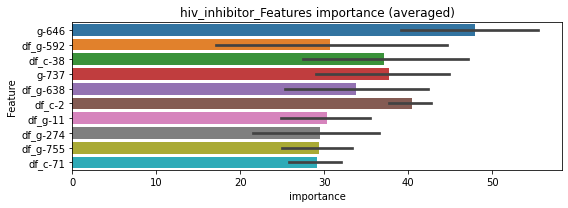

len(train_index) : 3840
len(valid_index) : 3841
================================= fold 1/2 hiv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.02759	valid_1's binary_logloss: 0.0661608
[200]	training's binary_logloss: 0.00534601	valid_1's binary_logloss: 0.0384632
[300]	training's binary_logloss: 0.00152346	valid_1's binary_logloss: 0.0338759
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00103625	valid_1's binary_logloss: 0.0329931


len(train_index) : 3841
len(valid_index) : 3840
================================= fold 2/2 hiv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0280181	valid_1's binary_logloss: 0.0688091
[200]	training's binary_logloss: 0.00542714	valid_1's binary_logloss: 0.0433859
[300]	training's binary_logloss: 0.00151795	valid_1's binary_logloss: 0.0372073
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.00142904	valid_1's binary_logloss: 0.0371588


hiv_inhibitor logloss: 0.03507566443486795


neg labels: 3289 → selected neg labels: 3282


hmgcr_inhibitor, len(trt): 283, len(othr): 3282, target_rate: 0.0118838 → Adj_target_rate: 0.0101910
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0396531	valid_1's binary_logloss: 0.0818926
[200]	training's binary_logloss: 0.00705781	valid_1's binary_logloss: 0.0530231
[300]	training's binary_logloss: 0.00220096	valid_1's binary_logloss: 0.0464293
[400]	training's binary_logloss: 0.00103182	valid_1's binary_logloss: 0.0447111
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.000836174	valid_1's binary_logloss: 0.0438777
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0370957	valid_1's binary_logloss: 0.100059
[200]	training's binary_logloss: 0.00632934	valid_1's binary_logloss: 0.0808285
Early stopping, best iteration is:
[232]	training's binary_logloss: 0.00403139	valid_1's binary_logloss: 0.0796983


1 / 3 AUC score:0.994
y_Threshold: 0.0308782, Threshold: 0.1823079, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 166 → Positive_corect_labels: 639/3772
p_label_rate: 0.0200904 Vs.target_rate: 0.01188
Num_p_label: 80.0, conf_0:0.16408, conf_1:0.20054
threshold: 0.1823079, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 639.0/3772, y_label_rate: 0.1694062
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0300104	valid_1's binary_logloss: 0.0599064
[200]	training's binary_logloss: 0.00443522	valid_1's binary_logloss: 0.0318905
Early stopping, best iteration is:
[256]	training's binary_logloss: 0.00195471	valid_1's binary_logloss: 0.028857
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0312583	valid_1's binary_logloss: 0.0550574
[200]	training's binary_logloss: 0.00463131	valid_1's binary_logloss: 0.0262293
[300]	training's binary_logloss: 0.00130788	valid_1's binary_logloss: 0.0224185
[400]	training's binary_logloss: 0.000631589	valid_1's binary_logloss: 0.0212577
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.000656851	valid_1's binary_logloss: 0.0212091


2 / 3 AUC score:0.999
y_Threshold: 0.1411819, Threshold: 0.1823079, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 28 → Positive_corect_labels: 625.0/3744
p_label_rate: 0.0421899 Vs.target_rate: 0.01188
Num_p_label: 168.0, conf_0:0.16408, conf_1:0.20054
Num_p_label: 168.0, Expected: 47.3, Adj_threshold_1: 0.1823079
Num_p_label: 163.0, Expected: 47.3, Adj_threshold_2: 0.1923079
Num_p_label: 161.0, Expected: 47.3, Adj_threshold_3: 0.2023079
Num_p_label: 159.0, Expected: 47.3, Adj_threshold_4: 0.2123079
Num_p_label: 156.0, Expected: 47.3, Adj_threshold_5: 0.2223079
Num_p_label: 156.0, Expected: 47.3, Adj_threshold_6: 0.2323079
Num_p_label: 154.0, Expected: 47.3, Adj_threshold_7: 0.2423079
Num_p_label: 153.0, Expected: 47.3, Adj_threshold_8: 0.2523079
Num_p_label: 150.0, Expected: 47.3, Adj_threshold_9: 0.2623079
Num_p_label: 149.0, Expected: 47.3, Adj_threshold_10: 0.2723079
threshold: 0.2823079, positive_p_label: 144.0/3982, p_label_rate: 0.0361627
positive_y_label: 625.0/3744, y_label_ra

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027289	valid_1's binary_logloss: 0.0504853
[200]	training's binary_logloss: 0.00366224	valid_1's binary_logloss: 0.0273754
Early stopping, best iteration is:
[239]	training's binary_logloss: 0.0020011	valid_1's binary_logloss: 0.0257912
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270184	valid_1's binary_logloss: 0.0453579
[200]	training's binary_logloss: 0.00361996	valid_1's binary_logloss: 0.0158408
[300]	training's binary_logloss: 0.000988671	valid_1's binary_logloss: 0.0113513
[400]	training's binary_logloss: 0.000511088	valid_1's binary_logloss: 0.0102677
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.000389228	valid_1's binary_logloss: 0.00979214


3 / 3 AUC score:1.000
y_Threshold: 0.1262301, Threshold: 0.2823079, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 24 → Positive_corect_labels: 613.0/3720
p_label_rate: 0.0416876 Vs.target_rate: 0.01188
Num_p_label: 166.0, conf_0:0.25408, conf_1:0.31054
Num_p_label: 166.0, Expected: 47.3, Adj_threshold_1: 0.2823079
Num_p_label: 164.0, Expected: 47.3, Adj_threshold_2: 0.2923079
Num_p_label: 164.0, Expected: 47.3, Adj_threshold_3: 0.3023079
Num_p_label: 163.0, Expected: 47.3, Adj_threshold_4: 0.3123079
Num_p_label: 163.0, Expected: 47.3, Adj_threshold_5: 0.3223079
Num_p_label: 160.0, Expected: 47.3, Adj_threshold_6: 0.3323079
Num_p_label: 157.0, Expected: 47.3, Adj_threshold_7: 0.3423079
Num_p_label: 154.0, Expected: 47.3, Adj_threshold_8: 0.3523079
Num_p_label: 151.0, Expected: 47.3, Adj_threshold_9: 0.3623079
Num_p_label: 150.0, Expected: 47.3, Adj_threshold_10: 0.3723079
threshold: 0.3823079, positive_p_label: 148.0/3982, p_label_rate: 0.0371673
positive_y_label: 761.0/7702, y_label_ra

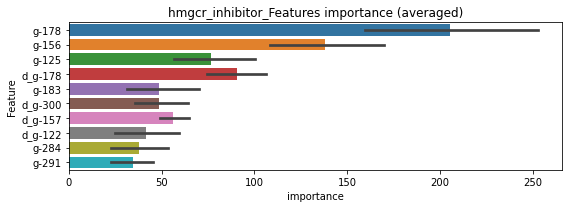

len(train_index) : 3851
len(valid_index) : 3851
================================= fold 1/2 hmgcr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165405	valid_1's binary_logloss: 0.0349325
[200]	training's binary_logloss: 0.00228641	valid_1's binary_logloss: 0.0176183
[300]	training's binary_logloss: 0.000648943	valid_1's binary_logloss: 0.0145319
[400]	training's binary_logloss: 0.000325122	valid_1's binary_logloss: 0.013381
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.000283469	valid_1's binary_logloss: 0.0131959


len(train_index) : 3851
len(valid_index) : 3851
================================= fold 2/2 hmgcr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0170943	valid_1's binary_logloss: 0.0301065
[200]	training's binary_logloss: 0.00249565	valid_1's binary_logloss: 0.0151851
[300]	training's binary_logloss: 0.00071427	valid_1's binary_logloss: 0.013162
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000483199	valid_1's binary_logloss: 0.012779


hmgcr_inhibitor logloss: 0.012987477323092293


neg labels: 3289 → selected neg labels: 3275


hsp_inhibitor, len(trt): 93, len(othr): 3275, target_rate: 0.0039053 → Adj_target_rate: 0.0039574
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0263301	valid_1's binary_logloss: 0.0525193
[200]	training's binary_logloss: 0.00335823	valid_1's binary_logloss: 0.0264306
[300]	training's binary_logloss: 0.000977282	valid_1's binary_logloss: 0.0206542
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.000749715	valid_1's binary_logloss: 0.0198967
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275577	valid_1's binary_logloss: 0.0487147
[200]	training's binary_logloss: 0.00340614	valid_1's binary_logloss: 0.0179153
[300]	training's binary_logloss: 0.000965251	valid_1's binary_logloss: 0.0113528
[400]	training's binary_logloss: 0.00050659	valid_1's binary_logloss: 0.0100696
Early stopping, best iteration is:
[431]	training's binary_logloss: 0.000439453	valid_1's binary_logloss: 0.00956843


1 / 3 AUC score:0.999
y_Threshold: 0.0026608, Threshold: 0.0108857, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 135 → Positive_corect_labels: 653/3795
p_label_rate: 0.0200904 Vs.target_rate: 0.00391
Num_p_label: 80.0, conf_0:0.00980, conf_1:0.01197
Num_p_label: 80.0, Expected: 15.6, Adj_threshold_1: 0.0108857
Num_p_label: 55.0, Expected: 15.6, Adj_threshold_2: 0.0208857
Num_p_label: 35.0, Expected: 15.6, Adj_threshold_3: 0.0308857
Num_p_label: 30.0, Expected: 15.6, Adj_threshold_4: 0.0408857
threshold: 0.0408857, positive_p_label: 30.0/3982, p_label_rate: 0.0075339
positive_y_label: 653.0/3795, y_label_rate: 0.1720685
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0273988	valid_1's binary_logloss: 0.051742
[200]	training's binary_logloss: 0.00337027	valid_1's binary_logloss: 0.0235406
[300]	training's binary_logloss: 0.00094991	valid_1's binary_logloss: 0.0181936
[400]	training's binary_logloss: 0.000490489	valid_1's binary_logloss: 0.0164979
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.000490489	valid_1's binary_logloss: 0.0164979
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0263855	valid_1's binary_logloss: 0.0576179
[200]	training's binary_logloss: 0.00319479	valid_1's binary_logloss: 0.034203
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.00185977	valid_1's binary_logloss: 0.0332745


2 / 3 AUC score:1.000
y_Threshold: 0.0268533, Threshold: 0.0408857, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 20 → Positive_corect_labels: 643.0/3775
p_label_rate: 0.0306379 Vs.target_rate: 0.00391
Num_p_label: 122.0, conf_0:0.03680, conf_1:0.04497
Num_p_label: 122.0, Expected: 15.6, Adj_threshold_1: 0.0408857
Num_p_label: 106.0, Expected: 15.6, Adj_threshold_2: 0.0508857
Num_p_label: 93.0, Expected: 15.6, Adj_threshold_3: 0.0608857
Num_p_label: 84.0, Expected: 15.6, Adj_threshold_4: 0.0708857
Num_p_label: 79.0, Expected: 15.6, Adj_threshold_5: 0.0808857
Num_p_label: 75.0, Expected: 15.6, Adj_threshold_6: 0.0908857
Num_p_label: 71.0, Expected: 15.6, Adj_threshold_7: 0.1008857
Num_p_label: 66.0, Expected: 15.6, Adj_threshold_8: 0.1108857
Num_p_label: 64.0, Expected: 15.6, Adj_threshold_9: 0.1208857
Num_p_label: 60.0, Expected: 15.6, Adj_threshold_10: 0.1308857
threshold: 0.1408857, positive_p_label: 57.0/3982, p_label_rate: 0.0143144
positive_y_label: 643.0/3775, y_label_rate: 0.170

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0269126	valid_1's binary_logloss: 0.0437011
[200]	training's binary_logloss: 0.00323678	valid_1's binary_logloss: 0.0145352
[300]	training's binary_logloss: 0.000890277	valid_1's binary_logloss: 0.00915797
[400]	training's binary_logloss: 0.000464446	valid_1's binary_logloss: 0.00799154
Early stopping, best iteration is:
[398]	training's binary_logloss: 0.00046976	valid_1's binary_logloss: 0.00797326
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0265196	valid_1's binary_logloss: 0.0414728
[200]	training's binary_logloss: 0.00317306	valid_1's binary_logloss: 0.0139854
[300]	training's binary_logloss: 0.000889462	valid_1's binary_logloss: 0.00931808
[400]	training's binary_logloss: 0.000468035	valid_1's binary_logloss: 0.00808821
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.000370371	valid_1's binary_logloss: 0.00754232

3 / 3 AUC score:1.000
y_Threshold: 0.0674999, Threshold: 0.1408857, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 642.0/3773
p_label_rate: 0.0168257 Vs.target_rate: 0.00391
Num_p_label: 67.0, conf_0:0.12680, conf_1:0.15497
Num_p_label: 67.0, Expected: 15.6, Adj_threshold_1: 0.1408857
Num_p_label: 65.0, Expected: 15.6, Adj_threshold_2: 0.1508857
Num_p_label: 60.0, Expected: 15.6, Adj_threshold_3: 0.1608857
Num_p_label: 58.0, Expected: 15.6, Adj_threshold_4: 0.1708857
Num_p_label: 57.0, Expected: 15.6, Adj_threshold_5: 0.1808857
Num_p_label: 56.0, Expected: 15.6, Adj_threshold_6: 0.1908857
Num_p_label: 53.0, Expected: 15.6, Adj_threshold_7: 0.2008857
Num_p_label: 51.0, Expected: 15.6, Adj_threshold_8: 0.2108857
Num_p_label: 51.0, Expected: 15.6, Adj_threshold_9: 0.2208857
Num_p_label: 50.0, Expected: 15.6, Adj_threshold_10: 0.2308857
threshold: 0.2408857, positive_p_label: 49.0/3982, p_label_rate: 0.0123054
positive_y_label: 691.0/7755, y_label_rate: 0.0891038

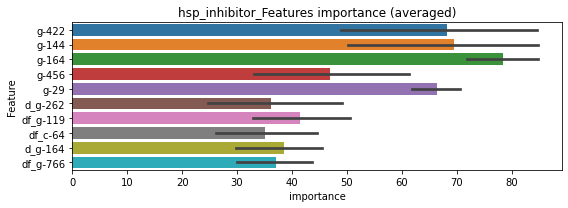

len(train_index) : 3877
len(valid_index) : 3878
================================= fold 1/2 hsp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152316	valid_1's binary_logloss: 0.0337117
[200]	training's binary_logloss: 0.00194304	valid_1's binary_logloss: 0.016008
[300]	training's binary_logloss: 0.000553074	valid_1's binary_logloss: 0.0123034
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.000443498	valid_1's binary_logloss: 0.011881


len(train_index) : 3878
len(valid_index) : 3877
================================= fold 2/2 hsp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0153204	valid_1's binary_logloss: 0.0295843
[200]	training's binary_logloss: 0.00187775	valid_1's binary_logloss: 0.014805
[300]	training's binary_logloss: 0.000527159	valid_1's binary_logloss: 0.0122735
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.000576088	valid_1's binary_logloss: 0.0121824


hsp_inhibitor logloss: 0.012031686639748112


neg labels: 3289 → selected neg labels: 3282


igf-1_inhibitor, len(trt): 37, len(othr): 3282, target_rate: 0.0015537 → Adj_target_rate: 0.0018079
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290941	valid_1's binary_logloss: 0.0507341
[200]	training's binary_logloss: 0.00417403	valid_1's binary_logloss: 0.0150226
[300]	training's binary_logloss: 0.00120902	valid_1's binary_logloss: 0.00882411
[400]	training's binary_logloss: 0.000612809	valid_1's binary_logloss: 0.00694418
[500]	training's binary_logloss: 0.000430735	valid_1's binary_logloss: 0.00660394
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000439223	valid_1's binary_logloss: 0.00657137
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297159	valid_1's binary_logloss: 0.0490916
[200]	training's binary_logloss: 0.00414477	valid_1's binary_logloss: 0.0137305
[300]	training's binary_logloss: 0.00120791	valid_1's binary_logloss: 0.00757975
[400]	training's binary_logloss: 0.000615206	valid_1's binary_logloss: 0.00584981
[500]	training's binary_logloss: 0.

1 / 3 AUC score:1.000
y_Threshold: 0.0043137, Threshold: 0.0084994, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3806
p_label_rate: 0.0200904 Vs.target_rate: 0.00155
Num_p_label: 80.0, conf_0:0.00765, conf_1:0.00935
Num_p_label: 80.0, Expected: 6.2, Adj_threshold_1: 0.0084994
Num_p_label: 42.0, Expected: 6.2, Adj_threshold_2: 0.0184994
Num_p_label: 31.0, Expected: 6.2, Adj_threshold_3: 0.0284994
Num_p_label: 22.0, Expected: 6.2, Adj_threshold_4: 0.0384994
Num_p_label: 17.0, Expected: 6.2, Adj_threshold_5: 0.0484994
Num_p_label: 14.0, Expected: 6.2, Adj_threshold_6: 0.0584994
Num_p_label: 14.0, Expected: 6.2, Adj_threshold_7: 0.0684994
Num_p_label: 11.0, Expected: 6.2, Adj_threshold_8: 0.0784994
threshold: 0.0784994, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0280825	valid_1's binary_logloss: 0.0495223
[200]	training's binary_logloss: 0.00374593	valid_1's binary_logloss: 0.0149047
[300]	training's binary_logloss: 0.00107594	valid_1's binary_logloss: 0.00873352
[400]	training's binary_logloss: 0.000555386	valid_1's binary_logloss: 0.00728674
Early stopping, best iteration is:
[431]	training's binary_logloss: 0.000485152	valid_1's binary_logloss: 0.00715122
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.02829	valid_1's binary_logloss: 0.0446352
[200]	training's binary_logloss: 0.00379155	valid_1's binary_logloss: 0.0107592
[300]	training's binary_logloss: 0.00109778	valid_1's binary_logloss: 0.00481807
[400]	training's binary_logloss: 0.000567454	valid_1's binary_logloss: 0.00323572
[500]	training's binary_logloss: 0.000419127	valid_1's binary_logloss: 0.00265092
Early stopping, best iteration is:
[5

2 / 3 AUC score:1.000
y_Threshold: 0.0604047, Threshold: 0.0784994, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3804
p_label_rate: 0.0125565 Vs.target_rate: 0.00155
Num_p_label: 50.0, conf_0:0.07065, conf_1:0.08635
Num_p_label: 50.0, Expected: 6.2, Adj_threshold_1: 0.0784994
Num_p_label: 47.0, Expected: 6.2, Adj_threshold_2: 0.0884994
Num_p_label: 45.0, Expected: 6.2, Adj_threshold_3: 0.0984994
Num_p_label: 41.0, Expected: 6.2, Adj_threshold_4: 0.1084994
Num_p_label: 39.0, Expected: 6.2, Adj_threshold_5: 0.1184994
Num_p_label: 35.0, Expected: 6.2, Adj_threshold_6: 0.1284994
Num_p_label: 35.0, Expected: 6.2, Adj_threshold_7: 0.1384994
Num_p_label: 34.0, Expected: 6.2, Adj_threshold_8: 0.1484994
Num_p_label: 34.0, Expected: 6.2, Adj_threshold_9: 0.1584994
Num_p_label: 34.0, Expected: 6.2, Adj_threshold_10: 0.1684994
threshold: 0.1784994, positive_p_label: 31.0/3982, p_label_rate: 0.0077850
positive_y_label: 655.0/3804, y_label_rate: 0.1721872
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281923	valid_1's binary_logloss: 0.0461058
[200]	training's binary_logloss: 0.00377193	valid_1's binary_logloss: 0.0107439
[300]	training's binary_logloss: 0.00108105	valid_1's binary_logloss: 0.00499371
[400]	training's binary_logloss: 0.000560134	valid_1's binary_logloss: 0.00337404
[500]	training's binary_logloss: 0.000408177	valid_1's binary_logloss: 0.00289455
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.000391182	valid_1's binary_logloss: 0.00283864
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028766	valid_1's binary_logloss: 0.0427099
[200]	training's binary_logloss: 0.00389447	valid_1's binary_logloss: 0.009595
[300]	training's binary_logloss: 0.00112718	valid_1's binary_logloss: 0.00407041
[400]	training's binary_logloss: 0.000580326	valid_1's binary_logloss: 0.00277676
[500]	training's binary_logloss: 0.00

3 / 3 AUC score:1.000
y_Threshold: 0.0876611, Threshold: 0.1784994, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3804
p_label_rate: 0.0070316 Vs.target_rate: 0.00155
Num_p_label: 28.0, conf_0:0.16065, conf_1:0.19635
Num_p_label: 28.0, Expected: 6.2, Adj_threshold_1: 0.1784994
Num_p_label: 27.0, Expected: 6.2, Adj_threshold_2: 0.1884994
Num_p_label: 27.0, Expected: 6.2, Adj_threshold_3: 0.1984994
Num_p_label: 26.0, Expected: 6.2, Adj_threshold_4: 0.2084994
Num_p_label: 25.0, Expected: 6.2, Adj_threshold_5: 0.2184994
Num_p_label: 21.0, Expected: 6.2, Adj_threshold_6: 0.2284994
Num_p_label: 19.0, Expected: 6.2, Adj_threshold_7: 0.2384994
Num_p_label: 19.0, Expected: 6.2, Adj_threshold_8: 0.2484994
Num_p_label: 17.0, Expected: 6.2, Adj_threshold_9: 0.2584994
Num_p_label: 17.0, Expected: 6.2, Adj_threshold_10: 0.2684994
threshold: 0.2784994, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 670.0/7786, y_label_rate: 0.0860519


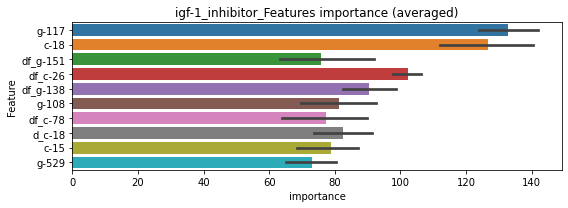

len(train_index) : 3893
len(valid_index) : 3893
================================= fold 1/2 igf-1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0146219	valid_1's binary_logloss: 0.0307691
[200]	training's binary_logloss: 0.0019484	valid_1's binary_logloss: 0.0123618
[300]	training's binary_logloss: 0.000571773	valid_1's binary_logloss: 0.00939593
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.000397417	valid_1's binary_logloss: 0.00889495


len(train_index) : 3893
len(valid_index) : 3893
================================= fold 2/2 igf-1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155557	valid_1's binary_logloss: 0.0250384
[200]	training's binary_logloss: 0.00216727	valid_1's binary_logloss: 0.00816572
[300]	training's binary_logloss: 0.000639265	valid_1's binary_logloss: 0.00529497
[400]	training's binary_logloss: 0.00032791	valid_1's binary_logloss: 0.00448061
Early stopping, best iteration is:
[447]	training's binary_logloss: 0.00026869	valid_1's binary_logloss: 0.00425326


igf-1_inhibitor logloss: 0.006574102894265211


neg labels: 3289 → selected neg labels: 3284


ikk_inhibitor, len(trt): 30, len(othr): 3284, target_rate: 0.0012598 → Adj_target_rate: 0.0015127
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026216	valid_1's binary_logloss: 0.0411242
[200]	training's binary_logloss: 0.00334359	valid_1's binary_logloss: 0.0116108
[300]	training's binary_logloss: 0.000939355	valid_1's binary_logloss: 0.00686918
[400]	training's binary_logloss: 0.000484441	valid_1's binary_logloss: 0.00521376
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.000402122	valid_1's binary_logloss: 0.00485163
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0269589	valid_1's binary_logloss: 0.0428533
[200]	training's binary_logloss: 0.00340788	valid_1's binary_logloss: 0.0129084
[300]	training's binary_logloss: 0.000956803	valid_1's binary_logloss: 0.00766573
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000547938	valid_1's binary_logloss: 0.00639813


1 / 3 AUC score:1.000
y_Threshold: 0.0033541, Threshold: 0.0703864, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00126
Num_p_label: 80.0, conf_0:0.06335, conf_1:0.07743
Num_p_label: 80.0, Expected: 5.0, Adj_threshold_1: 0.0703864
Num_p_label: 76.0, Expected: 5.0, Adj_threshold_2: 0.0803864
Num_p_label: 71.0, Expected: 5.0, Adj_threshold_3: 0.0903864
Num_p_label: 68.0, Expected: 5.0, Adj_threshold_4: 0.1003864
Num_p_label: 62.0, Expected: 5.0, Adj_threshold_5: 0.1103864
Num_p_label: 60.0, Expected: 5.0, Adj_threshold_6: 0.1203864
Num_p_label: 58.0, Expected: 5.0, Adj_threshold_7: 0.1303864
Num_p_label: 53.0, Expected: 5.0, Adj_threshold_8: 0.1403864
Num_p_label: 52.0, Expected: 5.0, Adj_threshold_9: 0.1503864
Num_p_label: 47.0, Expected: 5.0, Adj_threshold_10: 0.1603864
threshold: 0.1703864, positive_p_label: 46.0/3982, p_label_rate: 0.0115520
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0255601	valid_1's binary_logloss: 0.0408827
[200]	training's binary_logloss: 0.00312083	valid_1's binary_logloss: 0.0124641
[300]	training's binary_logloss: 0.000868664	valid_1's binary_logloss: 0.00769784
[400]	training's binary_logloss: 0.000448837	valid_1's binary_logloss: 0.00637323
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.00040038	valid_1's binary_logloss: 0.00626632
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254739	valid_1's binary_logloss: 0.0406561
[200]	training's binary_logloss: 0.00310021	valid_1's binary_logloss: 0.0117237
[300]	training's binary_logloss: 0.000867594	valid_1's binary_logloss: 0.00681593
[400]	training's binary_logloss: 0.000454215	valid_1's binary_logloss: 0.00541623
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.00044075	valid_1's binary_logloss: 0.00534572


2 / 3 AUC score:1.000
y_Threshold: 0.0599935, Threshold: 0.1703864, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0293822 Vs.target_rate: 0.00126
Num_p_label: 117.0, conf_0:0.15335, conf_1:0.18743
Num_p_label: 117.0, Expected: 5.0, Adj_threshold_1: 0.1703864
Num_p_label: 116.0, Expected: 5.0, Adj_threshold_2: 0.1803864
Num_p_label: 114.0, Expected: 5.0, Adj_threshold_3: 0.1903864
Num_p_label: 114.0, Expected: 5.0, Adj_threshold_4: 0.2003864
Num_p_label: 114.0, Expected: 5.0, Adj_threshold_5: 0.2103864
Num_p_label: 113.0, Expected: 5.0, Adj_threshold_6: 0.2203864
Num_p_label: 110.0, Expected: 5.0, Adj_threshold_7: 0.2303864
Num_p_label: 109.0, Expected: 5.0, Adj_threshold_8: 0.2403864
Num_p_label: 108.0, Expected: 5.0, Adj_threshold_9: 0.2503864
Num_p_label: 107.0, Expected: 5.0, Adj_threshold_10: 0.2603864
threshold: 0.2703864, positive_p_label: 105.0/3982, p_label_rate: 0.0263687
positive_y_label: 655.0/3806, y_label_rate: 0.17209

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257706	valid_1's binary_logloss: 0.0401412
[200]	training's binary_logloss: 0.00311367	valid_1's binary_logloss: 0.0105877
[300]	training's binary_logloss: 0.000874769	valid_1's binary_logloss: 0.00569548
[400]	training's binary_logloss: 0.00044792	valid_1's binary_logloss: 0.00424422
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.000372181	valid_1's binary_logloss: 0.00386556
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257364	valid_1's binary_logloss: 0.0362989
[200]	training's binary_logloss: 0.00317498	valid_1's binary_logloss: 0.00874833
[300]	training's binary_logloss: 0.000893301	valid_1's binary_logloss: 0.00471548
[400]	training's binary_logloss: 0.000460128	valid_1's binary_logloss: 0.00375001
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.000386247	valid_1's binary_logloss: 0.0035357

3 / 3 AUC score:1.000
y_Threshold: 0.0600786, Threshold: 0.2703864, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0236062 Vs.target_rate: 0.00126
Num_p_label: 94.0, conf_0:0.24335, conf_1:0.29743
Num_p_label: 94.0, Expected: 5.0, Adj_threshold_1: 0.2703864
Num_p_label: 94.0, Expected: 5.0, Adj_threshold_2: 0.2803864
Num_p_label: 94.0, Expected: 5.0, Adj_threshold_3: 0.2903864
Num_p_label: 94.0, Expected: 5.0, Adj_threshold_4: 0.3003864
Num_p_label: 92.0, Expected: 5.0, Adj_threshold_5: 0.3103864
Num_p_label: 92.0, Expected: 5.0, Adj_threshold_6: 0.3203864
Num_p_label: 91.0, Expected: 5.0, Adj_threshold_7: 0.3303864
Num_p_label: 88.0, Expected: 5.0, Adj_threshold_8: 0.3403864
Num_p_label: 86.0, Expected: 5.0, Adj_threshold_9: 0.3503864
Num_p_label: 85.0, Expected: 5.0, Adj_threshold_10: 0.3603864
threshold: 0.3703864, positive_p_label: 85.0/3982, p_label_rate: 0.0213461
positive_y_label: 740.0/7788, y_label_rate: 0.0950180


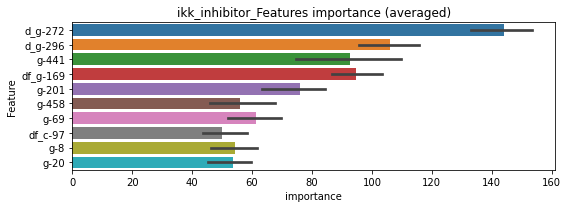

len(train_index) : 3894
len(valid_index) : 3894
================================= fold 1/2 ikk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164321	valid_1's binary_logloss: 0.0271723
[200]	training's binary_logloss: 0.00221631	valid_1's binary_logloss: 0.00979227
[300]	training's binary_logloss: 0.000626437	valid_1's binary_logloss: 0.00701936
[400]	training's binary_logloss: 0.00031479	valid_1's binary_logloss: 0.00633386
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.000311581	valid_1's binary_logloss: 0.00632602


len(train_index) : 3894
len(valid_index) : 3894
================================= fold 2/2 ikk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162872	valid_1's binary_logloss: 0.0265716
[200]	training's binary_logloss: 0.00216238	valid_1's binary_logloss: 0.00917218
[300]	training's binary_logloss: 0.000609509	valid_1's binary_logloss: 0.00634816
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000348899	valid_1's binary_logloss: 0.00574634


ikk_inhibitor logloss: 0.006036180712505938


neg labels: 3289 → selected neg labels: 3284


imidazoline_receptor_agonist, len(trt): 31, len(othr): 3284, target_rate: 0.0013018 → Adj_target_rate: 0.0015554
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339895	valid_1's binary_logloss: 0.0525259
[200]	training's binary_logloss: 0.00495602	valid_1's binary_logloss: 0.0148584
[300]	training's binary_logloss: 0.00134717	valid_1's binary_logloss: 0.00781101
Early stopping, best iteration is:
[372]	training's binary_logloss: 0.000763786	valid_1's binary_logloss: 0.00612977
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0329036	valid_1's binary_logloss: 0.0481923
[200]	training's binary_logloss: 0.00478128	valid_1's binary_logloss: 0.0108451
[300]	training's binary_logloss: 0.00133621	valid_1's binary_logloss: 0.00425847
[400]	training's binary_logloss: 0.000650235	valid_1's binary_logloss: 0.0025776
[500]	training's binary_logloss: 0.000445586	valid_1's binary_logloss: 0.00199813
[600]	training's binary_logloss: 0.000409168	valid_1's binary_logloss: 0.00190358
Early stopping, best iteration is:
[

1 / 3 AUC score:1.000
y_Threshold: 0.0035318, Threshold: 0.0074992, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00130
Num_p_label: 80.0, conf_0:0.00675, conf_1:0.00825
Num_p_label: 80.0, Expected: 5.2, Adj_threshold_1: 0.0074992
Num_p_label: 19.0, Expected: 5.2, Adj_threshold_2: 0.0174992
Num_p_label: 6.0, Expected: 5.2, Adj_threshold_3: 0.0274992
threshold: 0.0274992, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0336699	valid_1's binary_logloss: 0.0538775
[200]	training's binary_logloss: 0.00474618	valid_1's binary_logloss: 0.0144279
[300]	training's binary_logloss: 0.00129913	valid_1's binary_logloss: 0.00747513
[400]	training's binary_logloss: 0.000639826	valid_1's binary_logloss: 0.00556151
[500]	training's binary_logloss: 0.000439701	valid_1's binary_logloss: 0.00466847
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.000438407	valid_1's binary_logloss: 0.00466405
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334724	valid_1's binary_logloss: 0.0462948
[200]	training's binary_logloss: 0.00471659	valid_1's binary_logloss: 0.00938414
[300]	training's binary_logloss: 0.00132405	valid_1's binary_logloss: 0.00352741
[400]	training's binary_logloss: 0.000652362	valid_1's binary_logloss: 0.00210646
[500]	training's binary_logloss: 0

2 / 3 AUC score:1.000
y_Threshold: 0.0340444, Threshold: 0.0274992, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0032647 Vs.target_rate: 0.00130
Num_p_label: 13.0, conf_0:0.02475, conf_1:0.03025
threshold: 0.0274992, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0336699	valid_1's binary_logloss: 0.0538775
[200]	training's binary_logloss: 0.00474618	valid_1's binary_logloss: 0.0144279
[300]	training's binary_logloss: 0.00129913	valid_1's binary_logloss: 0.00747513
[400]	training's binary_logloss: 0.000639826	valid_1's binary_logloss: 0.00556151
[500]	training's binary_logloss: 0.000439701	valid_1's binary_logloss: 0.00466847
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.000438407	valid_1's binary_logloss: 0.00466405
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334724	valid_1's binary_logloss: 0.0462948
[200]	training's binary_logloss: 0.00471659	valid_1's binary_logloss: 0.00938414
[300]	training's binary_logloss: 0.00132405	valid_1's binary_logloss: 0.00352741
[400]	training's binary_logloss: 0.000652362	valid_1's binary_logloss: 0.00210646
[500]	training's binary_logloss: 0

3 / 3 AUC score:1.000
y_Threshold: 0.0340444, Threshold: 0.0274992, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0032647 Vs.target_rate: 0.00130
Num_p_label: 13.0, conf_0:0.02475, conf_1:0.03025
threshold: 0.0274992, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 669.0/7790, y_label_rate: 0.0858793


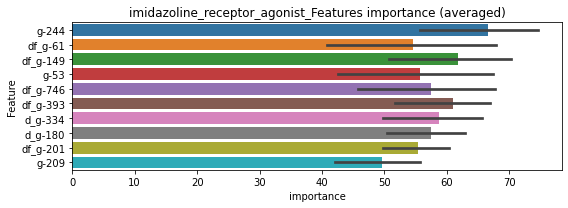

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193244	valid_1's binary_logloss: 0.0352497
[200]	training's binary_logloss: 0.00272544	valid_1's binary_logloss: 0.0139911
[300]	training's binary_logloss: 0.000736243	valid_1's binary_logloss: 0.0119226
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.000641207	valid_1's binary_logloss: 0.011839


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019399	valid_1's binary_logloss: 0.033395
[200]	training's binary_logloss: 0.00288695	valid_1's binary_logloss: 0.0121864
[300]	training's binary_logloss: 0.0007882	valid_1's binary_logloss: 0.00883421
[400]	training's binary_logloss: 0.000371428	valid_1's binary_logloss: 0.00798066
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.000334705	valid_1's binary_logloss: 0.00789653


imidazoline_receptor_agonist logloss: 0.009867766104431948


neg labels: 3289 → selected neg labels: 3278


immunosuppressant, len(trt): 73, len(othr): 3278, target_rate: 0.0030654 → Adj_target_rate: 0.0032212
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.046849	valid_1's binary_logloss: 0.0959455
[200]	training's binary_logloss: 0.00865529	valid_1's binary_logloss: 0.050602
[300]	training's binary_logloss: 0.00256835	valid_1's binary_logloss: 0.0391592
[400]	training's binary_logloss: 0.0012087	valid_1's binary_logloss: 0.0352187
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.00121636	valid_1's binary_logloss: 0.0351965
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0464908	valid_1's binary_logloss: 0.0898383
[200]	training's binary_logloss: 0.00958983	valid_1's binary_logloss: 0.0424584
[300]	training's binary_logloss: 0.00279803	valid_1's binary_logloss: 0.0306739
[400]	training's binary_logloss: 0.00122719	valid_1's binary_logloss: 0.0267093
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000904873	valid_1's binary_logloss: 0.0257655


1 / 3 AUC score:0.998
y_Threshold: 0.0104503, Threshold: 0.0210401, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 144 → Positive_corect_labels: 649/3789
p_label_rate: 0.0200904 Vs.target_rate: 0.00307
Num_p_label: 80.0, conf_0:0.01894, conf_1:0.02314
Num_p_label: 80.0, Expected: 12.2, Adj_threshold_1: 0.0210401
Num_p_label: 48.0, Expected: 12.2, Adj_threshold_2: 0.0310401
Num_p_label: 35.0, Expected: 12.2, Adj_threshold_3: 0.0410401
Num_p_label: 31.0, Expected: 12.2, Adj_threshold_4: 0.0510401
Num_p_label: 27.0, Expected: 12.2, Adj_threshold_5: 0.0610401
Num_p_label: 26.0, Expected: 12.2, Adj_threshold_6: 0.0710401
Num_p_label: 21.0, Expected: 12.2, Adj_threshold_7: 0.0810401
threshold: 0.0810401, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 649.0/3789, y_label_rate: 0.1712853
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0424378	valid_1's binary_logloss: 0.0872957
[200]	training's binary_logloss: 0.0078897	valid_1's binary_logloss: 0.0387273
[300]	training's binary_logloss: 0.00235581	valid_1's binary_logloss: 0.027581
[400]	training's binary_logloss: 0.00113868	valid_1's binary_logloss: 0.0243519
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.000956151	valid_1's binary_logloss: 0.0236281
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0419175	valid_1's binary_logloss: 0.0910926
[200]	training's binary_logloss: 0.00761755	valid_1's binary_logloss: 0.045412
[300]	training's binary_logloss: 0.00226671	valid_1's binary_logloss: 0.0353308
[400]	training's binary_logloss: 0.00108618	valid_1's binary_logloss: 0.0316497
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000809211	valid_1's binary_logloss: 0.0305861


2 / 3 AUC score:0.999
y_Threshold: 0.0306394, Threshold: 0.0810401, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → Positive_corect_labels: 641.0/3773
p_label_rate: 0.0100452 Vs.target_rate: 0.00307
Num_p_label: 40.0, conf_0:0.07294, conf_1:0.08914
Num_p_label: 40.0, Expected: 12.2, Adj_threshold_1: 0.0810401
Num_p_label: 36.0, Expected: 12.2, Adj_threshold_2: 0.0910401
Num_p_label: 34.0, Expected: 12.2, Adj_threshold_3: 0.1010401
Num_p_label: 33.0, Expected: 12.2, Adj_threshold_4: 0.1110401
Num_p_label: 33.0, Expected: 12.2, Adj_threshold_5: 0.1210401
Num_p_label: 32.0, Expected: 12.2, Adj_threshold_6: 0.1310401
Num_p_label: 30.0, Expected: 12.2, Adj_threshold_7: 0.1410401
Num_p_label: 28.0, Expected: 12.2, Adj_threshold_8: 0.1510401
Num_p_label: 26.0, Expected: 12.2, Adj_threshold_9: 0.1610401
Num_p_label: 26.0, Expected: 12.2, Adj_threshold_10: 0.1710401
threshold: 0.1810401, positive_p_label: 25.0/3982, p_label_rate: 0.0062783
positive_y_label: 641.0/3773, y_label_rate: 0.169891

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0420926	valid_1's binary_logloss: 0.092347
[200]	training's binary_logloss: 0.00776659	valid_1's binary_logloss: 0.0517944
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00263748	valid_1's binary_logloss: 0.0437701
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0420494	valid_1's binary_logloss: 0.0910114
[200]	training's binary_logloss: 0.00752591	valid_1's binary_logloss: 0.0401661
[300]	training's binary_logloss: 0.00223237	valid_1's binary_logloss: 0.0268383
[400]	training's binary_logloss: 0.00107584	valid_1's binary_logloss: 0.0230319
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000844212	valid_1's binary_logloss: 0.0221492


3 / 3 AUC score:0.998
y_Threshold: 0.0290680, Threshold: 0.1810401, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 30 → Positive_corect_labels: 626.0/3743
p_label_rate: 0.0077850 Vs.target_rate: 0.00307
Num_p_label: 31.0, conf_0:0.16294, conf_1:0.19914
threshold: 0.1810401, positive_p_label: 31.0/3982, p_label_rate: 0.0077850
positive_y_label: 657.0/7725, y_label_rate: 0.0850485


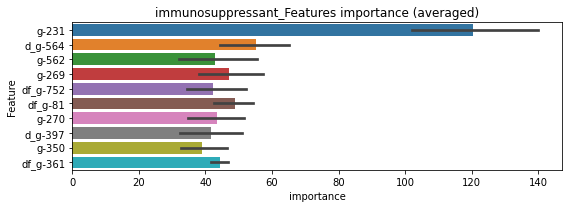

len(train_index) : 3862
len(valid_index) : 3863
================================= fold 1/2 immunosuppressant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218958	valid_1's binary_logloss: 0.0545082
[200]	training's binary_logloss: 0.00374235	valid_1's binary_logloss: 0.0331443
[300]	training's binary_logloss: 0.00108281	valid_1's binary_logloss: 0.0276202
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.00114216	valid_1's binary_logloss: 0.0275656


len(train_index) : 3863
len(valid_index) : 3862
================================= fold 2/2 immunosuppressant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229602	valid_1's binary_logloss: 0.0539722
[200]	training's binary_logloss: 0.0039664	valid_1's binary_logloss: 0.0319001
[300]	training's binary_logloss: 0.00115679	valid_1's binary_logloss: 0.0274631
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000598378	valid_1's binary_logloss: 0.0263886


immunosuppressant logloss: 0.026977189596991646


neg labels: 3289 → selected neg labels: 3284


insulin_secretagogue, len(trt): 30, len(othr): 3284, target_rate: 0.0012598 → Adj_target_rate: 0.0015127
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0314587	valid_1's binary_logloss: 0.0539227
[200]	training's binary_logloss: 0.00444937	valid_1's binary_logloss: 0.0180616
[300]	training's binary_logloss: 0.0012372	valid_1's binary_logloss: 0.0110914
[400]	training's binary_logloss: 0.000614846	valid_1's binary_logloss: 0.00928283
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000585984	valid_1's binary_logloss: 0.00909596
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031574	valid_1's binary_logloss: 0.054591
[200]	training's binary_logloss: 0.00448684	valid_1's binary_logloss: 0.0134666
[300]	training's binary_logloss: 0.00125704	valid_1's binary_logloss: 0.00629076
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.0010589	valid_1's binary_logloss: 0.00610993


1 / 3 AUC score:1.000
y_Threshold: 0.0044795, Threshold: 0.0067355, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00126
Num_p_label: 80.0, conf_0:0.00606, conf_1:0.00741
Num_p_label: 80.0, Expected: 5.0, Adj_threshold_1: 0.0067355
Num_p_label: 18.0, Expected: 5.0, Adj_threshold_2: 0.0167355
Num_p_label: 7.0, Expected: 5.0, Adj_threshold_3: 0.0267355
threshold: 0.0267355, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0312078	valid_1's binary_logloss: 0.0530644
[200]	training's binary_logloss: 0.00416793	valid_1's binary_logloss: 0.0155453
[300]	training's binary_logloss: 0.00119658	valid_1's binary_logloss: 0.010761
[400]	training's binary_logloss: 0.000595276	valid_1's binary_logloss: 0.00827616
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.000483713	valid_1's binary_logloss: 0.00782592
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0305741	valid_1's binary_logloss: 0.0512248
[200]	training's binary_logloss: 0.0043011	valid_1's binary_logloss: 0.013598
[300]	training's binary_logloss: 0.00126985	valid_1's binary_logloss: 0.00719059
[400]	training's binary_logloss: 0.000642367	valid_1's binary_logloss: 0.00551127
[500]	training's binary_logloss: 0.000430124	valid_1's binary_logloss: 0.00448467
Early stopping, best iteration is:
[579

2 / 3 AUC score:1.000
y_Threshold: 0.0240827, Threshold: 0.0267355, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0035158 Vs.target_rate: 0.00126
Num_p_label: 14.0, conf_0:0.02406, conf_1:0.02941
threshold: 0.0267355, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0312078	valid_1's binary_logloss: 0.0530644
[200]	training's binary_logloss: 0.00416793	valid_1's binary_logloss: 0.0155453
[300]	training's binary_logloss: 0.00119658	valid_1's binary_logloss: 0.010761
[400]	training's binary_logloss: 0.000595276	valid_1's binary_logloss: 0.00827616
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.000483713	valid_1's binary_logloss: 0.00782592
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0305741	valid_1's binary_logloss: 0.0512248
[200]	training's binary_logloss: 0.0043011	valid_1's binary_logloss: 0.013598
[300]	training's binary_logloss: 0.00126985	valid_1's binary_logloss: 0.00719059
[400]	training's binary_logloss: 0.000642367	valid_1's binary_logloss: 0.00551127
[500]	training's binary_logloss: 0.000430124	valid_1's binary_logloss: 0.00448467
Early stopping, best iteration is:
[579

3 / 3 AUC score:1.000
y_Threshold: 0.0240827, Threshold: 0.0267355, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0035158 Vs.target_rate: 0.00126
Num_p_label: 14.0, conf_0:0.02406, conf_1:0.02941
threshold: 0.0267355, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 670.0/7790, y_label_rate: 0.0860077


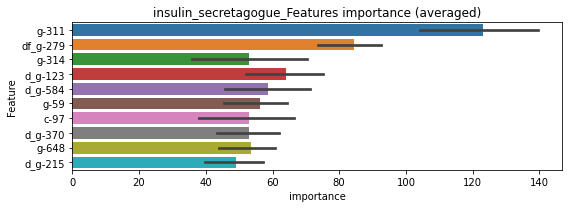

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 insulin_secretagogue=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0170976	valid_1's binary_logloss: 0.0357553
[200]	training's binary_logloss: 0.00236391	valid_1's binary_logloss: 0.016075
[300]	training's binary_logloss: 0.000653173	valid_1's binary_logloss: 0.0134828
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.000404052	valid_1's binary_logloss: 0.0131066


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 insulin_secretagogue=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.018169	valid_1's binary_logloss: 0.0317513
[200]	training's binary_logloss: 0.00247538	valid_1's binary_logloss: 0.0127911
[300]	training's binary_logloss: 0.000691777	valid_1's binary_logloss: 0.0103265
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.000764035	valid_1's binary_logloss: 0.0102622


insulin_secretagogue logloss: 0.011684410773976271


neg labels: 3289 → selected neg labels: 3281


insulin_sensitizer, len(trt): 51, len(othr): 3281, target_rate: 0.0021416 → Adj_target_rate: 0.0023748
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0344216	valid_1's binary_logloss: 0.0839287
[200]	training's binary_logloss: 0.00524337	valid_1's binary_logloss: 0.0568926
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.00264164	valid_1's binary_logloss: 0.054508
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0352871	valid_1's binary_logloss: 0.0677672
[200]	training's binary_logloss: 0.00559755	valid_1's binary_logloss: 0.0273898
[300]	training's binary_logloss: 0.001651	valid_1's binary_logloss: 0.0197352
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00123393	valid_1's binary_logloss: 0.0187627


1 / 3 AUC score:0.996
y_Threshold: 0.0122580, Threshold: 0.0227616, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 152 → Positive_corect_labels: 646/3785
p_label_rate: 0.0200904 Vs.target_rate: 0.00214
Num_p_label: 80.0, conf_0:0.02049, conf_1:0.02504
Num_p_label: 80.0, Expected: 8.5, Adj_threshold_1: 0.0227616
Num_p_label: 45.0, Expected: 8.5, Adj_threshold_2: 0.0327616
Num_p_label: 29.0, Expected: 8.5, Adj_threshold_3: 0.0427616
Num_p_label: 17.0, Expected: 8.5, Adj_threshold_4: 0.0527616
threshold: 0.0527616, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 646.0/3785, y_label_rate: 0.1706737
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0340742	valid_1's binary_logloss: 0.0686136
[200]	training's binary_logloss: 0.00502465	valid_1's binary_logloss: 0.030197
[300]	training's binary_logloss: 0.00147931	valid_1's binary_logloss: 0.0223397
[400]	training's binary_logloss: 0.000735837	valid_1's binary_logloss: 0.0199586
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000715393	valid_1's binary_logloss: 0.019797
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339447	valid_1's binary_logloss: 0.0600983
[200]	training's binary_logloss: 0.00516529	valid_1's binary_logloss: 0.0191767
[300]	training's binary_logloss: 0.001515	valid_1's binary_logloss: 0.0113988
[400]	training's binary_logloss: 0.000749796	valid_1's binary_logloss: 0.00932132
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.000592412	valid_1's binary_logloss: 0.0087889


2 / 3 AUC score:1.000
y_Threshold: 0.0385920, Threshold: 0.0527616, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 643.0/3779
p_label_rate: 0.0072828 Vs.target_rate: 0.00214
Num_p_label: 29.0, conf_0:0.04749, conf_1:0.05804
Num_p_label: 29.0, Expected: 8.5, Adj_threshold_1: 0.0527616
Num_p_label: 22.0, Expected: 8.5, Adj_threshold_2: 0.0627616
Num_p_label: 22.0, Expected: 8.5, Adj_threshold_3: 0.0727616
Num_p_label: 17.0, Expected: 8.5, Adj_threshold_4: 0.0827616
threshold: 0.0827616, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 643.0/3779, y_label_rate: 0.1701508
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0321356	valid_1's binary_logloss: 0.0659825
[200]	training's binary_logloss: 0.00478976	valid_1's binary_logloss: 0.0315557
[300]	training's binary_logloss: 0.00141429	valid_1's binary_logloss: 0.0252419
[400]	training's binary_logloss: 0.000708128	valid_1's binary_logloss: 0.0229799
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.000682567	valid_1's binary_logloss: 0.0227845
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0338125	valid_1's binary_logloss: 0.0585412
[200]	training's binary_logloss: 0.00508855	valid_1's binary_logloss: 0.0169699
[300]	training's binary_logloss: 0.0014834	valid_1's binary_logloss: 0.00861074
[400]	training's binary_logloss: 0.000741759	valid_1's binary_logloss: 0.00657203
[500]	training's binary_logloss: 0.000500481	valid_1's binary_logloss: 0.00573906
Early stopping, best iteration is:
[493

3 / 3 AUC score:1.000
y_Threshold: 0.0341851, Threshold: 0.0827616, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 639.0/3771
p_label_rate: 0.0047715 Vs.target_rate: 0.00214
Num_p_label: 19.0, conf_0:0.07449, conf_1:0.09104
threshold: 0.0827616, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 658.0/7753, y_label_rate: 0.0848704


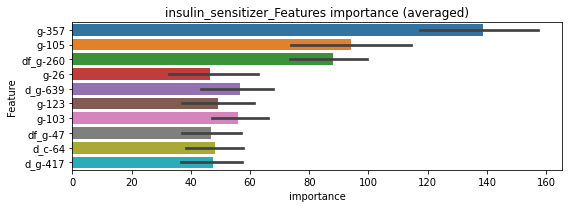

len(train_index) : 3876
len(valid_index) : 3877
================================= fold 1/2 insulin_sensitizer=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0174484	valid_1's binary_logloss: 0.0447465
[200]	training's binary_logloss: 0.00259958	valid_1's binary_logloss: 0.021305
[300]	training's binary_logloss: 0.000779979	valid_1's binary_logloss: 0.0175221
[400]	training's binary_logloss: 0.000383141	valid_1's binary_logloss: 0.0165246
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.000333116	valid_1's binary_logloss: 0.0161721


len(train_index) : 3877
len(valid_index) : 3876
================================= fold 2/2 insulin_sensitizer=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179412	valid_1's binary_logloss: 0.0366089
[200]	training's binary_logloss: 0.00263759	valid_1's binary_logloss: 0.0171613
[300]	training's binary_logloss: 0.000779422	valid_1's binary_logloss: 0.0134257
[400]	training's binary_logloss: 0.000391518	valid_1's binary_logloss: 0.0127209
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.000409244	valid_1's binary_logloss: 0.0127064


insulin_sensitizer logloss: 0.014439443071571337


neg labels: 3289 → selected neg labels: 3282


integrin_inhibitor, len(trt): 42, len(othr): 3282, target_rate: 0.0017637 → Adj_target_rate: 0.0020135
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0405572	valid_1's binary_logloss: 0.0787992
[200]	training's binary_logloss: 0.00688218	valid_1's binary_logloss: 0.0328962
[300]	training's binary_logloss: 0.00186314	valid_1's binary_logloss: 0.0232387
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.00100796	valid_1's binary_logloss: 0.0209619
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0413808	valid_1's binary_logloss: 0.0764225
[200]	training's binary_logloss: 0.00739188	valid_1's binary_logloss: 0.0288647
[300]	training's binary_logloss: 0.00199707	valid_1's binary_logloss: 0.016172
[400]	training's binary_logloss: 0.000906697	valid_1's binary_logloss: 0.0119745
[500]	training's binary_logloss: 0.00057976	valid_1's binary_logloss: 0.0103864
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00058738	valid_1's binary_logloss: 0.010336


1 / 3 AUC score:1.000
y_Threshold: 0.0049049, Threshold: 0.0061227, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 655/3804
p_label_rate: 0.0200904 Vs.target_rate: 0.00176
Num_p_label: 80.0, conf_0:0.00551, conf_1:0.00673
Num_p_label: 80.0, Expected: 7.0, Adj_threshold_1: 0.0061227
Num_p_label: 10.0, Expected: 7.0, Adj_threshold_2: 0.0161227
threshold: 0.0161227, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 655.0/3804, y_label_rate: 0.1721872
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0412128	valid_1's binary_logloss: 0.0714806
[200]	training's binary_logloss: 0.00690646	valid_1's binary_logloss: 0.0261543
[300]	training's binary_logloss: 0.00191335	valid_1's binary_logloss: 0.0171964
[400]	training's binary_logloss: 0.000900118	valid_1's binary_logloss: 0.0144987
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.000687801	valid_1's binary_logloss: 0.0136852
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0418948	valid_1's binary_logloss: 0.073827
[200]	training's binary_logloss: 0.00690165	valid_1's binary_logloss: 0.0251769
[300]	training's binary_logloss: 0.00189604	valid_1's binary_logloss: 0.0143312
[400]	training's binary_logloss: 0.000892045	valid_1's binary_logloss: 0.0109807
[500]	training's binary_logloss: 0.000567744	valid_1's binary_logloss: 0.0100035
Early stopping, best iteration is:
[490]	t

2 / 3 AUC score:1.000
y_Threshold: 0.0177345, Threshold: 0.0161227, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 654.0/3802
p_label_rate: 0.0057760 Vs.target_rate: 0.00176
Num_p_label: 23.0, conf_0:0.01451, conf_1:0.01773
Num_p_label: 23.0, Expected: 7.0, Adj_threshold_1: 0.0161227
Num_p_label: 9.0, Expected: 7.0, Adj_threshold_2: 0.0261227
threshold: 0.0261227, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 654.0/3802, y_label_rate: 0.1720147
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395809	valid_1's binary_logloss: 0.0745085
[200]	training's binary_logloss: 0.00643781	valid_1's binary_logloss: 0.0299795
[300]	training's binary_logloss: 0.00179884	valid_1's binary_logloss: 0.0209878
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000998931	valid_1's binary_logloss: 0.0187982
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0414756	valid_1's binary_logloss: 0.0784562
[200]	training's binary_logloss: 0.00691617	valid_1's binary_logloss: 0.0327483
[300]	training's binary_logloss: 0.00191806	valid_1's binary_logloss: 0.023016
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00107139	valid_1's binary_logloss: 0.020944


3 / 3 AUC score:0.999
y_Threshold: 0.0181723, Threshold: 0.0261227, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 648.0/3790
p_label_rate: 0.0035158 Vs.target_rate: 0.00176
Num_p_label: 14.0, conf_0:0.02351, conf_1:0.02873
threshold: 0.0261227, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 662.0/7772, y_label_rate: 0.0851776


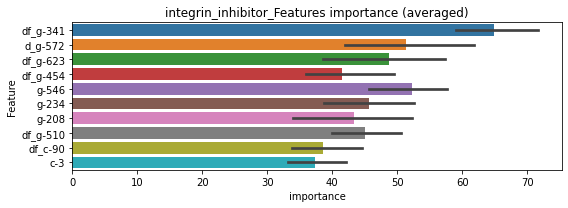

len(train_index) : 3886
len(valid_index) : 3886
================================= fold 1/2 integrin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228359	valid_1's binary_logloss: 0.0524842
[200]	training's binary_logloss: 0.0038054	valid_1's binary_logloss: 0.0332585
Early stopping, best iteration is:
[267]	training's binary_logloss: 0.00148797	valid_1's binary_logloss: 0.030918


len(train_index) : 3886
len(valid_index) : 3886
================================= fold 2/2 integrin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0220433	valid_1's binary_logloss: 0.0472331
[200]	training's binary_logloss: 0.00367076	valid_1's binary_logloss: 0.0268689
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.00125	valid_1's binary_logloss: 0.024647


integrin_inhibitor logloss: 0.027782526202874126


neg labels: 3289 → selected neg labels: 3274


jak_inhibitor, len(trt): 92, len(othr): 3274, target_rate: 0.0038633 → Adj_target_rate: 0.0039212
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0368621	valid_1's binary_logloss: 0.0859321
[200]	training's binary_logloss: 0.00608531	valid_1's binary_logloss: 0.0468573
[300]	training's binary_logloss: 0.00184583	valid_1's binary_logloss: 0.0361171
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.00138951	valid_1's binary_logloss: 0.0347947
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0376472	valid_1's binary_logloss: 0.076793
[200]	training's binary_logloss: 0.00639433	valid_1's binary_logloss: 0.0381954
[300]	training's binary_logloss: 0.00191378	valid_1's binary_logloss: 0.0293236
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00124332	valid_1's binary_logloss: 0.0270689


1 / 3 AUC score:0.999
y_Threshold: 0.0194294, Threshold: 0.0520728, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 140 → Positive_corect_labels: 650/3788
p_label_rate: 0.0200904 Vs.target_rate: 0.00386
Num_p_label: 80.0, conf_0:0.04687, conf_1:0.05728
Num_p_label: 80.0, Expected: 15.4, Adj_threshold_1: 0.0520728
Num_p_label: 60.0, Expected: 15.4, Adj_threshold_2: 0.0620728
Num_p_label: 48.0, Expected: 15.4, Adj_threshold_3: 0.0720728
Num_p_label: 39.0, Expected: 15.4, Adj_threshold_4: 0.0820728
Num_p_label: 35.0, Expected: 15.4, Adj_threshold_5: 0.0920728
Num_p_label: 30.0, Expected: 15.4, Adj_threshold_6: 0.1020728
threshold: 0.1020728, positive_p_label: 30.0/3982, p_label_rate: 0.0075339
positive_y_label: 650.0/3788, y_label_rate: 0.1715945
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345616	valid_1's binary_logloss: 0.078911
[200]	training's binary_logloss: 0.00528391	valid_1's binary_logloss: 0.0428051
[300]	training's binary_logloss: 0.00155371	valid_1's binary_logloss: 0.0358745
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.0010519	valid_1's binary_logloss: 0.0346831
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0356165	valid_1's binary_logloss: 0.0636985
[200]	training's binary_logloss: 0.00562036	valid_1's binary_logloss: 0.0239304
[300]	training's binary_logloss: 0.00164676	valid_1's binary_logloss: 0.0146436
[400]	training's binary_logloss: 0.000814861	valid_1's binary_logloss: 0.0114885
[500]	training's binary_logloss: 0.000555569	valid_1's binary_logloss: 0.010433
Early stopping, best iteration is:
[522]	training's binary_logloss: 0.000527313	valid_1's binary_logloss: 0.0103003


2 / 3 AUC score:0.998
y_Threshold: 0.1312254, Threshold: 0.1020728, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 639.0/3766
p_label_rate: 0.0306379 Vs.target_rate: 0.00386
Num_p_label: 122.0, conf_0:0.09187, conf_1:0.11228
Num_p_label: 122.0, Expected: 15.4, Adj_threshold_1: 0.1020728
Num_p_label: 105.0, Expected: 15.4, Adj_threshold_2: 0.1120728
Num_p_label: 97.0, Expected: 15.4, Adj_threshold_3: 0.1220728
Num_p_label: 91.0, Expected: 15.4, Adj_threshold_4: 0.1320728
Num_p_label: 85.0, Expected: 15.4, Adj_threshold_5: 0.1420728
Num_p_label: 80.0, Expected: 15.4, Adj_threshold_6: 0.1520728
Num_p_label: 74.0, Expected: 15.4, Adj_threshold_7: 0.1620728
Num_p_label: 69.0, Expected: 15.4, Adj_threshold_8: 0.1720728
Num_p_label: 64.0, Expected: 15.4, Adj_threshold_9: 0.1820728
Num_p_label: 62.0, Expected: 15.4, Adj_threshold_10: 0.1920728
threshold: 0.2020728, positive_p_label: 58.0/3982, p_label_rate: 0.0145655
positive_y_label: 639.0/3766, y_label_rate: 0.169

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0323111	valid_1's binary_logloss: 0.0739485
[200]	training's binary_logloss: 0.00477986	valid_1's binary_logloss: 0.0373888
[300]	training's binary_logloss: 0.0013873	valid_1's binary_logloss: 0.029518
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.00143719	valid_1's binary_logloss: 0.029391
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0344014	valid_1's binary_logloss: 0.0634294
[200]	training's binary_logloss: 0.00521697	valid_1's binary_logloss: 0.0254826
[300]	training's binary_logloss: 0.00151424	valid_1's binary_logloss: 0.0174204
[400]	training's binary_logloss: 0.000755509	valid_1's binary_logloss: 0.0152342
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000554602	valid_1's binary_logloss: 0.0143328


3 / 3 AUC score:0.999
y_Threshold: 0.1619448, Threshold: 0.2020728, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 633.0/3754
p_label_rate: 0.0238574 Vs.target_rate: 0.00386
Num_p_label: 95.0, conf_0:0.18187, conf_1:0.22228
Num_p_label: 95.0, Expected: 15.4, Adj_threshold_1: 0.2020728
Num_p_label: 90.0, Expected: 15.4, Adj_threshold_2: 0.2120728
Num_p_label: 81.0, Expected: 15.4, Adj_threshold_3: 0.2220728
Num_p_label: 78.0, Expected: 15.4, Adj_threshold_4: 0.2320728
Num_p_label: 76.0, Expected: 15.4, Adj_threshold_5: 0.2420728
Num_p_label: 74.0, Expected: 15.4, Adj_threshold_6: 0.2520728
Num_p_label: 72.0, Expected: 15.4, Adj_threshold_7: 0.2620728
Num_p_label: 68.0, Expected: 15.4, Adj_threshold_8: 0.2720728
Num_p_label: 65.0, Expected: 15.4, Adj_threshold_9: 0.2820728
Num_p_label: 62.0, Expected: 15.4, Adj_threshold_10: 0.2920728
threshold: 0.3020728, positive_p_label: 62.0/3982, p_label_rate: 0.0155701
positive_y_label: 695.0/7736, y_label_rate: 0.089839

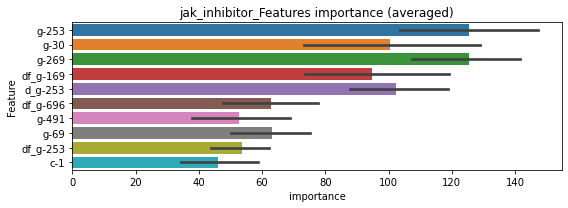

len(train_index) : 3868
len(valid_index) : 3868
================================= fold 1/2 jak_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189012	valid_1's binary_logloss: 0.045926
[200]	training's binary_logloss: 0.00303278	valid_1's binary_logloss: 0.0266306
[300]	training's binary_logloss: 0.000908707	valid_1's binary_logloss: 0.0229424
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.000841485	valid_1's binary_logloss: 0.0228225


len(train_index) : 3868
len(valid_index) : 3868
================================= fold 2/2 jak_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193875	valid_1's binary_logloss: 0.0475623
[200]	training's binary_logloss: 0.00315472	valid_1's binary_logloss: 0.0264595
[300]	training's binary_logloss: 0.000958258	valid_1's binary_logloss: 0.0209349
[400]	training's binary_logloss: 0.000481462	valid_1's binary_logloss: 0.0191728
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00050729	valid_1's binary_logloss: 0.0191461


jak_inhibitor logloss: 0.020984312532744045


neg labels: 3289 → selected neg labels: 3272


kit_inhibitor, len(trt): 273, len(othr): 3272, target_rate: 0.0114638 → Adj_target_rate: 0.0098841
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0435263	valid_1's binary_logloss: 0.117917
[200]	training's binary_logloss: 0.00852189	valid_1's binary_logloss: 0.0909863
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00441859	valid_1's binary_logloss: 0.0878047
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0427872	valid_1's binary_logloss: 0.110463
[200]	training's binary_logloss: 0.0079296	valid_1's binary_logloss: 0.0819678
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.0040739	valid_1's binary_logloss: 0.0797219


1 / 3 AUC score:0.987
y_Threshold: 0.0350545, Threshold: 0.1647421, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 170 → Positive_corect_labels: 635/3756
p_label_rate: 0.0200904 Vs.target_rate: 0.01146
Num_p_label: 80.0, conf_0:0.14827, conf_1:0.18122
threshold: 0.1647421, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 635.0/3756, y_label_rate: 0.1690628
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0363002	valid_1's binary_logloss: 0.0827005
[200]	training's binary_logloss: 0.00587777	valid_1's binary_logloss: 0.0521831
[300]	training's binary_logloss: 0.0017567	valid_1's binary_logloss: 0.0484953
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.0013523	valid_1's binary_logloss: 0.0478415
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0368044	valid_1's binary_logloss: 0.0835699
[200]	training's binary_logloss: 0.0059823	valid_1's binary_logloss: 0.0567784
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00235785	valid_1's binary_logloss: 0.0543633


2 / 3 AUC score:0.991
y_Threshold: 0.0998515, Threshold: 0.1647421, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 46 → Positive_corect_labels: 612.0/3710
p_label_rate: 0.0328980 Vs.target_rate: 0.01146
Num_p_label: 131.0, conf_0:0.14827, conf_1:0.18122
threshold: 0.1647421, positive_p_label: 131.0/3982, p_label_rate: 0.0328980
positive_y_label: 612.0/3710, y_label_rate: 0.1649596
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0331474	valid_1's binary_logloss: 0.0560277
[200]	training's binary_logloss: 0.00544899	valid_1's binary_logloss: 0.0228106
[300]	training's binary_logloss: 0.00164484	valid_1's binary_logloss: 0.0156408
[400]	training's binary_logloss: 0.000793114	valid_1's binary_logloss: 0.0130958
[500]	training's binary_logloss: 0.000523932	valid_1's binary_logloss: 0.0121579
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.000467101	valid_1's binary_logloss: 0.0118906
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0331371	valid_1's binary_logloss: 0.0580269
[200]	training's binary_logloss: 0.00525432	valid_1's binary_logloss: 0.023313
[300]	training's binary_logloss: 0.00152107	valid_1's binary_logloss: 0.0161809
[400]	training's binary_logloss: 0.000708124	valid_1's binary_logloss: 0.0136197
Early stopping, best iteration is:
[428]	t

3 / 3 AUC score:1.000
y_Threshold: 0.1170178, Threshold: 0.1647421, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 606.0/3698
p_label_rate: 0.0336514 Vs.target_rate: 0.01146
Num_p_label: 134.0, conf_0:0.14827, conf_1:0.18122
threshold: 0.1647421, positive_p_label: 134.0/3982, p_label_rate: 0.0336514
positive_y_label: 740.0/7680, y_label_rate: 0.0963542


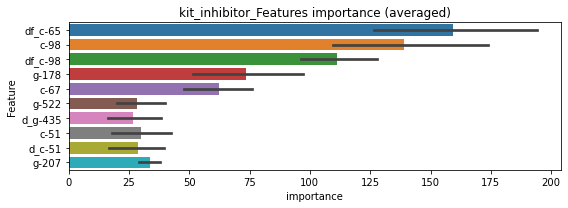

len(train_index) : 3840
len(valid_index) : 3840
================================= fold 1/2 kit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0199808	valid_1's binary_logloss: 0.0447522
[200]	training's binary_logloss: 0.00321752	valid_1's binary_logloss: 0.0260567
[300]	training's binary_logloss: 0.000941154	valid_1's binary_logloss: 0.0215676
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.000514242	valid_1's binary_logloss: 0.0201817


len(train_index) : 3840
len(valid_index) : 3840
================================= fold 2/2 kit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203345	valid_1's binary_logloss: 0.0422101
[200]	training's binary_logloss: 0.00332402	valid_1's binary_logloss: 0.0223546
[300]	training's binary_logloss: 0.000941753	valid_1's binary_logloss: 0.0186188
[400]	training's binary_logloss: 0.000449649	valid_1's binary_logloss: 0.0172941
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.000381562	valid_1's binary_logloss: 0.0170984


kit_inhibitor logloss: 0.01864004513820006


neg labels: 3289 → selected neg labels: 3288


laxative, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155417	valid_1's binary_logloss: 0.0170139
[200]	training's binary_logloss: 0.00131228	valid_1's binary_logloss: 0.00181327
[300]	training's binary_logloss: 0.000357804	valid_1's binary_logloss: 0.00059607
[400]	training's binary_logloss: 0.000218957	valid_1's binary_logloss: 0.000396664
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.000197786	valid_1's binary_logloss: 0.000365634
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156598	valid_1's binary_logloss: 0.0167319
[200]	training's binary_logloss: 0.00134823	valid_1's binary_logloss: 0.00176686
[300]	training's binary_logloss: 0.000381546	valid_1's binary_logloss: 0.000568257
[400]	training's binary_logloss: 0.000217241	valid_1's binary_logloss: 0.000338249
[500]	training's binary_logloss: 0.00018581	valid_1's binary_logloss: 0.000291156
Early stopping, best iterat

1 / 3 AUC score:1.000
y_Threshold: 0.0005229, Threshold: 0.0008520, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0200904 Vs.target_rate: 0.00025
Num_p_label: 80.0, conf_0:0.00077, conf_1:0.00094
Num_p_label: 80.0, Expected: 1.0, Adj_threshold_1: 0.0008520
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_2: 0.0108520
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_3: 0.0208520
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_4: 0.0308520
threshold: 0.0308520, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158044	valid_1's binary_logloss: 0.0171478
[200]	training's binary_logloss: 0.00129342	valid_1's binary_logloss: 0.00182211
[300]	training's binary_logloss: 0.000352357	valid_1's binary_logloss: 0.000621521
[400]	training's binary_logloss: 0.000218913	valid_1's binary_logloss: 0.000426096
[500]	training's binary_logloss: 0.000192816	valid_1's binary_logloss: 0.000389231
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.000192142	valid_1's binary_logloss: 0.000388087
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159292	valid_1's binary_logloss: 0.0165791
[200]	training's binary_logloss: 0.0013032	valid_1's binary_logloss: 0.00146342
[300]	training's binary_logloss: 0.000350566	valid_1's binary_logloss: 0.000419607
[400]	training's binary_logloss: 0.000216461	valid_1's binary_logloss: 0.000262255
Early stopping, best itera

2 / 3 AUC score:1.000
y_Threshold: 0.1370793, Threshold: 0.0308520, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0022602 Vs.target_rate: 0.00025
Num_p_label: 9.0, conf_0:0.02777, conf_1:0.03394
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_1: 0.0308520
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_2: 0.0408520
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_3: 0.0508520
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_4: 0.0608520
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_5: 0.0708520
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_6: 0.0808520
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_7: 0.0908520
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_8: 0.1008520
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_9: 0.1108520
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_10: 0.1208520
threshold: 0.1308520, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pse

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158044	valid_1's binary_logloss: 0.0171478
[200]	training's binary_logloss: 0.00129342	valid_1's binary_logloss: 0.00182211
[300]	training's binary_logloss: 0.000352357	valid_1's binary_logloss: 0.000621521
[400]	training's binary_logloss: 0.000218913	valid_1's binary_logloss: 0.000426096
[500]	training's binary_logloss: 0.000192816	valid_1's binary_logloss: 0.000389231
Early stopping, best iteration is:
[521]	training's binary_logloss: 0.000192142	valid_1's binary_logloss: 0.000388087
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159292	valid_1's binary_logloss: 0.0165791
[200]	training's binary_logloss: 0.0013032	valid_1's binary_logloss: 0.00146342
[300]	training's binary_logloss: 0.000350566	valid_1's binary_logloss: 0.000419607
[400]	training's binary_logloss: 0.000216461	valid_1's binary_logloss: 0.000262255
Early stopping, best itera

3 / 3 AUC score:1.000
y_Threshold: 0.1370793, Threshold: 0.1308520, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0007534 Vs.target_rate: 0.00025
Num_p_label: 3.0, conf_0:0.11777, conf_1:0.14394
threshold: 0.1308520, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 660.0/7795, y_label_rate: 0.0846697


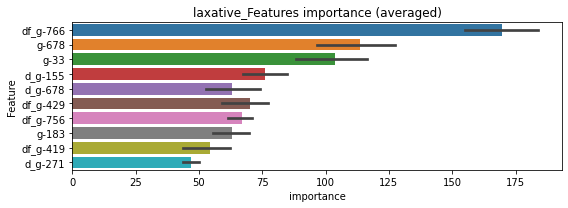

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 laxative=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00855661	valid_1's binary_logloss: 0.0104861
[200]	training's binary_logloss: 0.000697784	valid_1's binary_logloss: 0.00289152
Early stopping, best iteration is:
[228]	training's binary_logloss: 0.000424464	valid_1's binary_logloss: 0.00271117


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 laxative=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00857641	valid_1's binary_logloss: 0.00944095
[200]	training's binary_logloss: 0.000693691	valid_1's binary_logloss: 0.00146876
[300]	training's binary_logloss: 0.000187267	valid_1's binary_logloss: 0.00108769
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.00019045	valid_1's binary_logloss: 0.0010845


laxative logloss: 0.0018979400013600476


neg labels: 3289 → selected neg labels: 3288


leukotriene_inhibitor, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154972	valid_1's binary_logloss: 0.0160904
[200]	training's binary_logloss: 0.00128129	valid_1's binary_logloss: 0.00138637
[300]	training's binary_logloss: 0.000346104	valid_1's binary_logloss: 0.000392766
[400]	training's binary_logloss: 0.000213667	valid_1's binary_logloss: 0.00024695
[500]	training's binary_logloss: 0.00018829	valid_1's binary_logloss: 0.000218661
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.000186697	valid_1's binary_logloss: 0.000216859
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156323	valid_1's binary_logloss: 0.0166861
[200]	training's binary_logloss: 0.00126356	valid_1's binary_logloss: 0.00158614
[300]	training's binary_logloss: 0.000344038	valid_1's binary_logloss: 0.000507143
[400]	training's binary_logloss: 0.00021196	valid_1's binary_logloss: 0.000317006
Early stopping, best iterati

1 / 3 AUC score:1.000
y_Threshold: 0.0005770, Threshold: 0.0008950, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0200904 Vs.target_rate: 0.00025
Num_p_label: 80.0, conf_0:0.00081, conf_1:0.00098
Num_p_label: 80.0, Expected: 1.0, Adj_threshold_1: 0.0008950
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_2: 0.0108950
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_3: 0.0208950
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_4: 0.0308950
threshold: 0.0308950, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015841	valid_1's binary_logloss: 0.0165955
[200]	training's binary_logloss: 0.00126342	valid_1's binary_logloss: 0.00142992
[300]	training's binary_logloss: 0.000337003	valid_1's binary_logloss: 0.000411004
[400]	training's binary_logloss: 0.000210462	valid_1's binary_logloss: 0.000264301
[500]	training's binary_logloss: 0.000184088	valid_1's binary_logloss: 0.000232755
[600]	training's binary_logloss: 0.000181585	valid_1's binary_logloss: 0.000229503
Early stopping, best iteration is:
[631]	training's binary_logloss: 0.000181291	valid_1's binary_logloss: 0.000229142
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160522	valid_1's binary_logloss: 0.0164702
[200]	training's binary_logloss: 0.00128808	valid_1's binary_logloss: 0.00137316
[300]	training's binary_logloss: 0.000343858	valid_1's binary_logloss: 0.000382596
[400]	training's binary_lo

2 / 3 AUC score:1.000
y_Threshold: 0.1832754, Threshold: 0.0308950, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0030136 Vs.target_rate: 0.00025
Num_p_label: 12.0, conf_0:0.02781, conf_1:0.03398
Num_p_label: 12.0, Expected: 1.0, Adj_threshold_1: 0.0308950
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_2: 0.0408950
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_3: 0.0508950
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_4: 0.0608950
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_5: 0.0708950
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_6: 0.0808950
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_7: 0.0908950
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_8: 0.1008950
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_9: 0.1108950
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_10: 0.1208950
threshold: 0.1308950, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= P

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015841	valid_1's binary_logloss: 0.0165955
[200]	training's binary_logloss: 0.00126342	valid_1's binary_logloss: 0.00142992
[300]	training's binary_logloss: 0.000337003	valid_1's binary_logloss: 0.000411004
[400]	training's binary_logloss: 0.000210462	valid_1's binary_logloss: 0.000264301
[500]	training's binary_logloss: 0.000184088	valid_1's binary_logloss: 0.000232755
[600]	training's binary_logloss: 0.000181585	valid_1's binary_logloss: 0.000229503
Early stopping, best iteration is:
[624]	training's binary_logloss: 0.000181291	valid_1's binary_logloss: 0.000229142
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160522	valid_1's binary_logloss: 0.0164702
[200]	training's binary_logloss: 0.00128808	valid_1's binary_logloss: 0.00137316
[300]	training's binary_logloss: 0.000343858	valid_1's binary_logloss: 0.000382596
[400]	training's binary_lo

3 / 3 AUC score:1.000
y_Threshold: 0.1832754, Threshold: 0.1308950, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0010045 Vs.target_rate: 0.00025
Num_p_label: 4.0, conf_0:0.11781, conf_1:0.14398
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_1: 0.1308950
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_2: 0.1408950
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_3: 0.1508950
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_4: 0.1608950
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_5: 0.1708950
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_6: 0.1808950
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_7: 0.1908950
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_8: 0.2008950
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_9: 0.2108950
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_10: 0.2208950
threshold: 0.2308950, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 661.0/7795, y_label_rate: 0.0847979


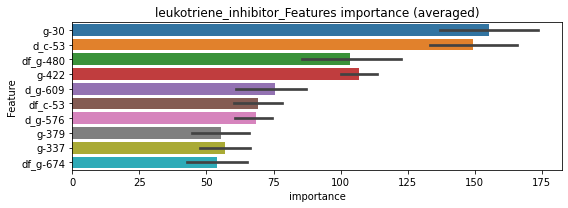

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 leukotriene_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00842282	valid_1's binary_logloss: 0.0105109
[200]	training's binary_logloss: 0.000662382	valid_1's binary_logloss: 0.00306578
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.000230149	valid_1's binary_logloss: 0.00274668


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 leukotriene_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00845079	valid_1's binary_logloss: 0.00889777
[200]	training's binary_logloss: 0.000680019	valid_1's binary_logloss: 0.000969966
[300]	training's binary_logloss: 0.000180054	valid_1's binary_logloss: 0.000440793
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.000123094	valid_1's binary_logloss: 0.000400012


leukotriene_inhibitor logloss: 0.001573498637225359


neg labels: 3289 → selected neg labels: 3280


leukotriene_receptor_antagonist, len(trt): 62, len(othr): 3280, target_rate: 0.0026035 → Adj_target_rate: 0.0028037
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0521033	valid_1's binary_logloss: 0.109621
[200]	training's binary_logloss: 0.0100374	valid_1's binary_logloss: 0.056284
[300]	training's binary_logloss: 0.00286809	valid_1's binary_logloss: 0.0423761
[400]	training's binary_logloss: 0.00131448	valid_1's binary_logloss: 0.0391226
[500]	training's binary_logloss: 0.000799767	valid_1's binary_logloss: 0.0373396
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.000735818	valid_1's binary_logloss: 0.036783
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0546804	valid_1's binary_logloss: 0.0931842
[200]	training's binary_logloss: 0.0112124	valid_1's binary_logloss: 0.0339653
[300]	training's binary_logloss: 0.00316458	valid_1's binary_logloss: 0.0171684
[400]	training's binary_logloss: 0.00141221	valid_1's binary_logloss: 0.0116591
[500]	training's binary_logloss: 0.000855376	val

1 / 3 AUC score:1.000
y_Threshold: 0.0074670, Threshold: 0.0095362, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 136 → Positive_corect_labels: 654/3800
p_label_rate: 0.0200904 Vs.target_rate: 0.00260
Num_p_label: 80.0, conf_0:0.00858, conf_1:0.01049
Num_p_label: 80.0, Expected: 10.4, Adj_threshold_1: 0.0095362
Num_p_label: 24.0, Expected: 10.4, Adj_threshold_2: 0.0195362
Num_p_label: 12.0, Expected: 10.4, Adj_threshold_3: 0.0295362
threshold: 0.0295362, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 654.0/3800, y_label_rate: 0.1721053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0509497	valid_1's binary_logloss: 0.106276
[200]	training's binary_logloss: 0.0101018	valid_1's binary_logloss: 0.0565172
[300]	training's binary_logloss: 0.00282915	valid_1's binary_logloss: 0.0454279
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.00237547	valid_1's binary_logloss: 0.044038
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0520238	valid_1's binary_logloss: 0.0925339
[200]	training's binary_logloss: 0.0101187	valid_1's binary_logloss: 0.0387662
[300]	training's binary_logloss: 0.00288354	valid_1's binary_logloss: 0.0234991
[400]	training's binary_logloss: 0.00131604	valid_1's binary_logloss: 0.0182131
[500]	training's binary_logloss: 0.000809852	valid_1's binary_logloss: 0.0165673
[600]	training's binary_logloss: 0.000609442	valid_1's binary_logloss: 0.0158071
Early stopping, best iteration is:
[590]	traini

2 / 3 AUC score:1.000
y_Threshold: 0.0292812, Threshold: 0.0295362, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → Positive_corect_labels: 646.0/3784
p_label_rate: 0.0107986 Vs.target_rate: 0.00260
Num_p_label: 43.0, conf_0:0.02658, conf_1:0.03249
Num_p_label: 43.0, Expected: 10.4, Adj_threshold_1: 0.0295362
Num_p_label: 25.0, Expected: 10.4, Adj_threshold_2: 0.0395362
Num_p_label: 15.0, Expected: 10.4, Adj_threshold_3: 0.0495362
threshold: 0.0495362, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 646.0/3784, y_label_rate: 0.1707188
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0500716	valid_1's binary_logloss: 0.0973751
[200]	training's binary_logloss: 0.00959682	valid_1's binary_logloss: 0.0451816
[300]	training's binary_logloss: 0.0027355	valid_1's binary_logloss: 0.0321541
[400]	training's binary_logloss: 0.00125956	valid_1's binary_logloss: 0.0281664
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.00109384	valid_1's binary_logloss: 0.0277721
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0504968	valid_1's binary_logloss: 0.0962638
[200]	training's binary_logloss: 0.00978094	valid_1's binary_logloss: 0.0453272
[300]	training's binary_logloss: 0.0027942	valid_1's binary_logloss: 0.0319992
[400]	training's binary_logloss: 0.00126562	valid_1's binary_logloss: 0.0278024
[500]	training's binary_logloss: 0.000785677	valid_1's binary_logloss: 0.025794
Early stopping, best iteration is:
[545]	traini

3 / 3 AUC score:1.000
y_Threshold: 0.0340881, Threshold: 0.0495362, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 640.0/3772
p_label_rate: 0.0040181 Vs.target_rate: 0.00260
Num_p_label: 16.0, conf_0:0.04458, conf_1:0.05449
threshold: 0.0495362, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 656.0/7754, y_label_rate: 0.0846015


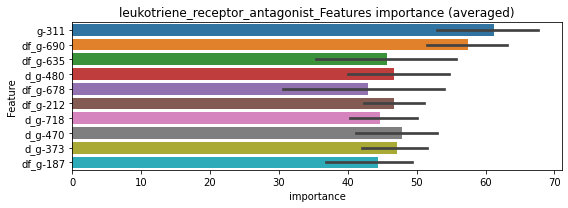

len(train_index) : 3877
len(valid_index) : 3877
================================= fold 1/2 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027878	valid_1's binary_logloss: 0.0619348
[200]	training's binary_logloss: 0.00541412	valid_1's binary_logloss: 0.0356635
[300]	training's binary_logloss: 0.00151277	valid_1's binary_logloss: 0.0313534
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.00105416	valid_1's binary_logloss: 0.0308703


len(train_index) : 3877
len(valid_index) : 3877
================================= fold 2/2 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0284665	valid_1's binary_logloss: 0.0580735
[200]	training's binary_logloss: 0.00544141	valid_1's binary_logloss: 0.0289248
[300]	training's binary_logloss: 0.00152692	valid_1's binary_logloss: 0.0223381
[400]	training's binary_logloss: 0.000681082	valid_1's binary_logloss: 0.0203803
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.000572776	valid_1's binary_logloss: 0.0201462


leukotriene_receptor_antagonist logloss: 0.025508209466949986


neg labels: 3289 → selected neg labels: 3287


lipase_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.018887	valid_1's binary_logloss: 0.0256017
[200]	training's binary_logloss: 0.00194842	valid_1's binary_logloss: 0.0059069
[300]	training's binary_logloss: 0.000548222	valid_1's binary_logloss: 0.00283796
[400]	training's binary_logloss: 0.000301067	valid_1's binary_logloss: 0.00208348
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.000269833	valid_1's binary_logloss: 0.00201957
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193173	valid_1's binary_logloss: 0.0237986
[200]	training's binary_logloss: 0.00195784	valid_1's binary_logloss: 0.00310456
[300]	training's binary_logloss: 0.000552147	valid_1's binary_logloss: 0.00107354
[400]	training's binary_logloss: 0.000308163	valid_1's binary_logloss: 0.000651622
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.000267897	valid_1's binary_logloss: 0.000586

1 / 3 AUC score:1.000
y_Threshold: 0.0010978, Threshold: 0.0020335, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050
Num_p_label: 80.0, conf_0:0.00183, conf_1:0.00224
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0020335
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_2: 0.0120335
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_3: 0.0220335
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_4: 0.0320335
threshold: 0.0320335, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194154	valid_1's binary_logloss: 0.0279838
[200]	training's binary_logloss: 0.00190147	valid_1's binary_logloss: 0.00924804
[300]	training's binary_logloss: 0.000524674	valid_1's binary_logloss: 0.00578557
[400]	training's binary_logloss: 0.000297635	valid_1's binary_logloss: 0.00479518
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.000272542	valid_1's binary_logloss: 0.00471919
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194941	valid_1's binary_logloss: 0.0230737
[200]	training's binary_logloss: 0.00194647	valid_1's binary_logloss: 0.0026835
[300]	training's binary_logloss: 0.000536065	valid_1's binary_logloss: 0.000816888
[400]	training's binary_logloss: 0.000298565	valid_1's binary_logloss: 0.000480358
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.000261786	valid_1's binary_logloss: 0.0004

2 / 3 AUC score:1.000
y_Threshold: 0.0429076, Threshold: 0.0320335, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0045203 Vs.target_rate: 0.00050
Num_p_label: 18.0, conf_0:0.02883, conf_1:0.03524
Num_p_label: 18.0, Expected: 2.0, Adj_threshold_1: 0.0320335
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_2: 0.0420335
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_3: 0.0520335
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_4: 0.0620335
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_5: 0.0720335
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_6: 0.0820335
threshold: 0.0820335, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194154	valid_1's binary_logloss: 0.0279838
[200]	training's binary_logloss: 0.00190147	valid_1's binary_logloss: 0.00924804
[300]	training's binary_logloss: 0.000524674	valid_1's binary_logloss: 0.00578557
[400]	training's binary_logloss: 0.000297635	valid_1's binary_logloss: 0.00479518
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.000272542	valid_1's binary_logloss: 0.00471919
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194941	valid_1's binary_logloss: 0.0230737
[200]	training's binary_logloss: 0.00194647	valid_1's binary_logloss: 0.0026835
[300]	training's binary_logloss: 0.000536065	valid_1's binary_logloss: 0.000816888
[400]	training's binary_logloss: 0.000298565	valid_1's binary_logloss: 0.000480358
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.000261786	valid_1's binary_logloss: 0.0004

3 / 3 AUC score:1.000
y_Threshold: 0.0429076, Threshold: 0.0820335, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0010045 Vs.target_rate: 0.00050
Num_p_label: 4.0, conf_0:0.07383, conf_1:0.09024
threshold: 0.0820335, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 661.0/7794, y_label_rate: 0.0848088


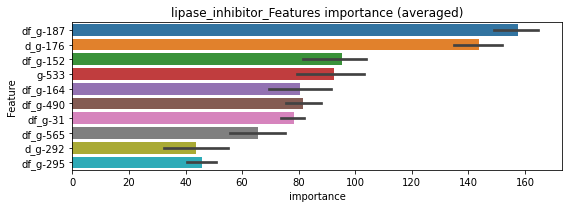

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101478	valid_1's binary_logloss: 0.0146865
[200]	training's binary_logloss: 0.000983204	valid_1's binary_logloss: 0.00386458
[300]	training's binary_logloss: 0.000270412	valid_1's binary_logloss: 0.00305364
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.000229808	valid_1's binary_logloss: 0.00300458


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0107966	valid_1's binary_logloss: 0.0127934
[200]	training's binary_logloss: 0.00105766	valid_1's binary_logloss: 0.00228677
[300]	training's binary_logloss: 0.000277183	valid_1's binary_logloss: 0.00146706
Early stopping, best iteration is:
[354]	training's binary_logloss: 0.00018907	valid_1's binary_logloss: 0.00138957


lipase_inhibitor logloss: 0.0021970731216909133


neg labels: 3289 → selected neg labels: 3278


lipoxygenase_inhibitor, len(trt): 61, len(othr): 3278, target_rate: 0.0025615 → Adj_target_rate: 0.0027652
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0516423	valid_1's binary_logloss: 0.108676
[200]	training's binary_logloss: 0.00995835	valid_1's binary_logloss: 0.0610664
[300]	training's binary_logloss: 0.00280819	valid_1's binary_logloss: 0.0522932
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.00161434	valid_1's binary_logloss: 0.0504384
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0521697	valid_1's binary_logloss: 0.0938619
[200]	training's binary_logloss: 0.00951835	valid_1's binary_logloss: 0.0375508
[300]	training's binary_logloss: 0.00270148	valid_1's binary_logloss: 0.0233005
[400]	training's binary_logloss: 0.00125181	valid_1's binary_logloss: 0.0187442
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.000864077	valid_1's binary_logloss: 0.0174279


1 / 3 AUC score:0.998
y_Threshold: 0.0098758, Threshold: 0.0138167, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 146 → Positive_corect_labels: 648/3787
p_label_rate: 0.0200904 Vs.target_rate: 0.00256
Num_p_label: 80.0, conf_0:0.01243, conf_1:0.01520
Num_p_label: 80.0, Expected: 10.2, Adj_threshold_1: 0.0138167
Num_p_label: 33.0, Expected: 10.2, Adj_threshold_2: 0.0238167
Num_p_label: 18.0, Expected: 10.2, Adj_threshold_3: 0.0338167
threshold: 0.0338167, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 648.0/3787, y_label_rate: 0.1711117
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0493265	valid_1's binary_logloss: 0.102483
[200]	training's binary_logloss: 0.00928549	valid_1's binary_logloss: 0.054452
[300]	training's binary_logloss: 0.00265762	valid_1's binary_logloss: 0.0456115
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.0017232	valid_1's binary_logloss: 0.0437292
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0521363	valid_1's binary_logloss: 0.0873127
[200]	training's binary_logloss: 0.00963985	valid_1's binary_logloss: 0.0309465
[300]	training's binary_logloss: 0.00273461	valid_1's binary_logloss: 0.0172491
[400]	training's binary_logloss: 0.00127823	valid_1's binary_logloss: 0.0134336
[500]	training's binary_logloss: 0.000792295	valid_1's binary_logloss: 0.0122527
[600]	training's binary_logloss: 0.000595496	valid_1's binary_logloss: 0.011654
Early stopping, best iteration is:
[621]	traini

2 / 3 AUC score:0.997
y_Threshold: 0.0287965, Threshold: 0.0338167, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 20 → Positive_corect_labels: 638.0/3767
p_label_rate: 0.0168257 Vs.target_rate: 0.00256
Num_p_label: 67.0, conf_0:0.03043, conf_1:0.03720
Num_p_label: 67.0, Expected: 10.2, Adj_threshold_1: 0.0338167
Num_p_label: 53.0, Expected: 10.2, Adj_threshold_2: 0.0438167
Num_p_label: 35.0, Expected: 10.2, Adj_threshold_3: 0.0538167
Num_p_label: 27.0, Expected: 10.2, Adj_threshold_4: 0.0638167
Num_p_label: 20.0, Expected: 10.2, Adj_threshold_5: 0.0738167
threshold: 0.0738167, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 638.0/3767, y_label_rate: 0.1693655
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0481819	valid_1's binary_logloss: 0.100395
[200]	training's binary_logloss: 0.00896189	valid_1's binary_logloss: 0.0477124
[300]	training's binary_logloss: 0.00251421	valid_1's binary_logloss: 0.0344336
[400]	training's binary_logloss: 0.00115547	valid_1's binary_logloss: 0.0307339
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00100694	valid_1's binary_logloss: 0.0302095
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0492378	valid_1's binary_logloss: 0.0857366
[200]	training's binary_logloss: 0.0093162	valid_1's binary_logloss: 0.0328674
[300]	training's binary_logloss: 0.00265597	valid_1's binary_logloss: 0.0196479
[400]	training's binary_logloss: 0.00122788	valid_1's binary_logloss: 0.015421
[500]	training's binary_logloss: 0.000757746	valid_1's binary_logloss: 0.0135023
Early stopping, best iteration is:
[556]	traini

3 / 3 AUC score:1.000
y_Threshold: 0.0346837, Threshold: 0.0738167, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 634.0/3759
p_label_rate: 0.0085384 Vs.target_rate: 0.00256
Num_p_label: 34.0, conf_0:0.06643, conf_1:0.08120
Num_p_label: 34.0, Expected: 10.2, Adj_threshold_1: 0.0738167
Num_p_label: 27.0, Expected: 10.2, Adj_threshold_2: 0.0838167
Num_p_label: 23.0, Expected: 10.2, Adj_threshold_3: 0.0938167
Num_p_label: 20.0, Expected: 10.2, Adj_threshold_4: 0.1038167
threshold: 0.1038167, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 654.0/7741, y_label_rate: 0.0844852


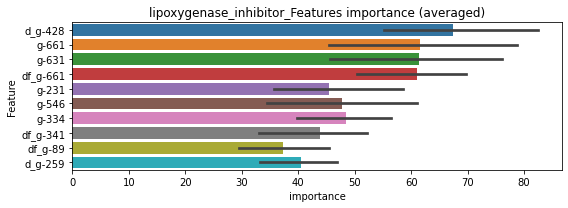

len(train_index) : 3870
len(valid_index) : 3871
================================= fold 1/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026277	valid_1's binary_logloss: 0.0574655
[200]	training's binary_logloss: 0.00497226	valid_1's binary_logloss: 0.0317201
[300]	training's binary_logloss: 0.00141495	valid_1's binary_logloss: 0.0264529
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.00104006	valid_1's binary_logloss: 0.0256733


len(train_index) : 3871
len(valid_index) : 3870
================================= fold 2/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293812	valid_1's binary_logloss: 0.0577789
[200]	training's binary_logloss: 0.00578898	valid_1's binary_logloss: 0.0291203
[300]	training's binary_logloss: 0.00156942	valid_1's binary_logloss: 0.0228614
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00111697	valid_1's binary_logloss: 0.0223853


lipoxygenase_inhibitor logloss: 0.024029537897695623


neg labels: 3289 → selected neg labels: 3288


lxr_agonist, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152356	valid_1's binary_logloss: 0.0173396
[200]	training's binary_logloss: 0.00116745	valid_1's binary_logloss: 0.00240279
[300]	training's binary_logloss: 0.000298297	valid_1's binary_logloss: 0.0012115
[400]	training's binary_logloss: 0.000191345	valid_1's binary_logloss: 0.00099286
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.000191078	valid_1's binary_logloss: 0.000992516
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154482	valid_1's binary_logloss: 0.0160309
[200]	training's binary_logloss: 0.00120205	valid_1's binary_logloss: 0.00132905
[300]	training's binary_logloss: 0.000300993	valid_1's binary_logloss: 0.000364976
[400]	training's binary_logloss: 0.000190485	valid_1's binary_logloss: 0.000241464
[500]	training's binary_logloss: 0.000172943	valid_1's binary_logloss: 0.000221659
[600]	training's binary_logl

1 / 3 AUC score:1.000
y_Threshold: 0.0005009, Threshold: 0.0021702, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0200904 Vs.target_rate: 0.00025
Num_p_label: 80.0, conf_0:0.00195, conf_1:0.00239
Num_p_label: 80.0, Expected: 1.0, Adj_threshold_1: 0.0021702
Num_p_label: 20.0, Expected: 1.0, Adj_threshold_2: 0.0121702
Num_p_label: 13.0, Expected: 1.0, Adj_threshold_3: 0.0221702
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_4: 0.0321702
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_5: 0.0421702
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_6: 0.0521702
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_7: 0.0621702
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_8: 0.0721702
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_9: 0.0821702
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_10: 0.0921702
threshold: 0.1021702, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
=================

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160025	valid_1's binary_logloss: 0.0173904
[200]	training's binary_logloss: 0.0012324	valid_1's binary_logloss: 0.0016187
[300]	training's binary_logloss: 0.000293198	valid_1's binary_logloss: 0.000456278
[400]	training's binary_logloss: 0.000184796	valid_1's binary_logloss: 0.000313254
[500]	training's binary_logloss: 0.000167091	valid_1's binary_logloss: 0.000290159
[600]	training's binary_logloss: 0.000162052	valid_1's binary_logloss: 0.000284491
[700]	training's binary_logloss: 0.000159667	valid_1's binary_logloss: 0.000282078
Early stopping, best iteration is:
[750]	training's binary_logloss: 0.000159074	valid_1's binary_logloss: 0.000281528
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160616	valid_1's binary_logloss: 0.0167646
[200]	training's binary_logloss: 0.00125448	valid_1's binary_logloss: 0.00146951
[300]	training's binary_log

2 / 3 AUC score:1.000
y_Threshold: 0.2121934, Threshold: 0.1021702, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0050226 Vs.target_rate: 0.00025
Num_p_label: 20.0, conf_0:0.09195, conf_1:0.11239
Num_p_label: 20.0, Expected: 1.0, Adj_threshold_1: 0.1021702
Num_p_label: 16.0, Expected: 1.0, Adj_threshold_2: 0.1121702
Num_p_label: 14.0, Expected: 1.0, Adj_threshold_3: 0.1221702
Num_p_label: 14.0, Expected: 1.0, Adj_threshold_4: 0.1321702
Num_p_label: 13.0, Expected: 1.0, Adj_threshold_5: 0.1421702
Num_p_label: 12.0, Expected: 1.0, Adj_threshold_6: 0.1521702
Num_p_label: 12.0, Expected: 1.0, Adj_threshold_7: 0.1621702
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_8: 0.1721702
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_9: 0.1821702
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_10: 0.1921702
threshold: 0.2021702, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
============

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160025	valid_1's binary_logloss: 0.0173904
[200]	training's binary_logloss: 0.0012324	valid_1's binary_logloss: 0.0016187
[300]	training's binary_logloss: 0.000293198	valid_1's binary_logloss: 0.000456278
[400]	training's binary_logloss: 0.000184796	valid_1's binary_logloss: 0.000313254
[500]	training's binary_logloss: 0.000167091	valid_1's binary_logloss: 0.000290159
[600]	training's binary_logloss: 0.000162052	valid_1's binary_logloss: 0.000284491
[700]	training's binary_logloss: 0.000159667	valid_1's binary_logloss: 0.000282078
Early stopping, best iteration is:
[750]	training's binary_logloss: 0.000159074	valid_1's binary_logloss: 0.000281528
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160616	valid_1's binary_logloss: 0.0167646
[200]	training's binary_logloss: 0.00125448	valid_1's binary_logloss: 0.00146951
[300]	training's binary_log

3 / 3 AUC score:1.000
y_Threshold: 0.2121934, Threshold: 0.2021702, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0020090 Vs.target_rate: 0.00025
Num_p_label: 8.0, conf_0:0.18195, conf_1:0.22239
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_1: 0.2021702
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_2: 0.2121702
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_3: 0.2221702
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_4: 0.2321702
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_5: 0.2421702
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_6: 0.2521702
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_7: 0.2621702
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_8: 0.2721702
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_9: 0.2821702
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_10: 0.2921702
threshold: 0.3021702, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7795, y_label_rate: 0.0850545


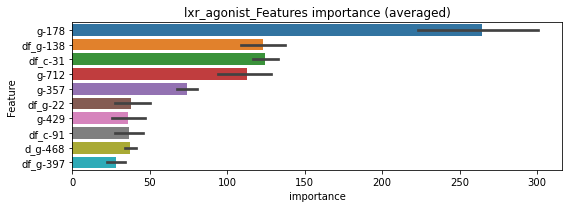

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 lxr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00853676	valid_1's binary_logloss: 0.0116889
[200]	training's binary_logloss: 0.000651345	valid_1's binary_logloss: 0.00391974
[300]	training's binary_logloss: 0.000160498	valid_1's binary_logloss: 0.0033347
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.000160498	valid_1's binary_logloss: 0.0033347


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 lxr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00874483	valid_1's binary_logloss: 0.00969626
[200]	training's binary_logloss: 0.000698308	valid_1's binary_logloss: 0.00178733
[300]	training's binary_logloss: 0.000173715	valid_1's binary_logloss: 0.00125058
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.000127277	valid_1's binary_logloss: 0.00119983


lxr_agonist logloss: 0.0022674009721781975


neg labels: 3289 → selected neg labels: 3284


mdm_inhibitor, len(trt): 31, len(othr): 3284, target_rate: 0.0013018 → Adj_target_rate: 0.0015554
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227613	valid_1's binary_logloss: 0.032652
[200]	training's binary_logloss: 0.00259645	valid_1's binary_logloss: 0.00674316
[300]	training's binary_logloss: 0.000741431	valid_1's binary_logloss: 0.00333187
[400]	training's binary_logloss: 0.000398852	valid_1's binary_logloss: 0.00240357
[500]	training's binary_logloss: 0.000319841	valid_1's binary_logloss: 0.00211655
Early stopping, best iteration is:
[506]	training's binary_logloss: 0.000318504	valid_1's binary_logloss: 0.00211213
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227947	valid_1's binary_logloss: 0.0295681
[200]	training's binary_logloss: 0.0026363	valid_1's binary_logloss: 0.00558045
[300]	training's binary_logloss: 0.000754483	valid_1's binary_logloss: 0.00265332
[400]	training's binary_logloss: 0.000400798	valid_1's binary_logloss: 0.0017992
[500]	training's binary_logloss: 0

1 / 3 AUC score:1.000
y_Threshold: 0.0031027, Threshold: 0.0056677, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00130
Num_p_label: 80.0, conf_0:0.00510, conf_1:0.00623
Num_p_label: 80.0, Expected: 5.2, Adj_threshold_1: 0.0056677
Num_p_label: 44.0, Expected: 5.2, Adj_threshold_2: 0.0156677
Num_p_label: 35.0, Expected: 5.2, Adj_threshold_3: 0.0256677
Num_p_label: 28.0, Expected: 5.2, Adj_threshold_4: 0.0356677
Num_p_label: 23.0, Expected: 5.2, Adj_threshold_5: 0.0456677
Num_p_label: 22.0, Expected: 5.2, Adj_threshold_6: 0.0556677
Num_p_label: 21.0, Expected: 5.2, Adj_threshold_7: 0.0656677
Num_p_label: 20.0, Expected: 5.2, Adj_threshold_8: 0.0756677
Num_p_label: 17.0, Expected: 5.2, Adj_threshold_9: 0.0856677
Num_p_label: 15.0, Expected: 5.2, Adj_threshold_10: 0.0956677
threshold: 0.1056677, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214312	valid_1's binary_logloss: 0.0286873
[200]	training's binary_logloss: 0.00231784	valid_1's binary_logloss: 0.00456807
[300]	training's binary_logloss: 0.000626966	valid_1's binary_logloss: 0.00164594
[400]	training's binary_logloss: 0.000340523	valid_1's binary_logloss: 0.00102439
[500]	training's binary_logloss: 0.000282195	valid_1's binary_logloss: 0.000891559
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.000279005	valid_1's binary_logloss: 0.000884214
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213575	valid_1's binary_logloss: 0.0263604
[200]	training's binary_logloss: 0.00228859	valid_1's binary_logloss: 0.00427696
[300]	training's binary_logloss: 0.000636678	valid_1's binary_logloss: 0.00177157
[400]	training's binary_logloss: 0.000353391	valid_1's binary_logloss: 0.00116127
Early stopping, best iteratio

2 / 3 AUC score:1.000
y_Threshold: 0.2127348, Threshold: 0.1056677, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0148167 Vs.target_rate: 0.00130
Num_p_label: 59.0, conf_0:0.09510, conf_1:0.11623
Num_p_label: 59.0, Expected: 5.2, Adj_threshold_1: 0.1056677
Num_p_label: 59.0, Expected: 5.2, Adj_threshold_2: 0.1156677
Num_p_label: 57.0, Expected: 5.2, Adj_threshold_3: 0.1256677
Num_p_label: 56.0, Expected: 5.2, Adj_threshold_4: 0.1356677
Num_p_label: 56.0, Expected: 5.2, Adj_threshold_5: 0.1456677
Num_p_label: 53.0, Expected: 5.2, Adj_threshold_6: 0.1556677
Num_p_label: 53.0, Expected: 5.2, Adj_threshold_7: 0.1656677
Num_p_label: 49.0, Expected: 5.2, Adj_threshold_8: 0.1756677
Num_p_label: 49.0, Expected: 5.2, Adj_threshold_9: 0.1856677
Num_p_label: 48.0, Expected: 5.2, Adj_threshold_10: 0.1956677
threshold: 0.2056677, positive_p_label: 48.0/3982, p_label_rate: 0.0120542
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214312	valid_1's binary_logloss: 0.0286873
[200]	training's binary_logloss: 0.00231784	valid_1's binary_logloss: 0.00456807
[300]	training's binary_logloss: 0.000626966	valid_1's binary_logloss: 0.00164594
[400]	training's binary_logloss: 0.000340523	valid_1's binary_logloss: 0.00102439
[500]	training's binary_logloss: 0.000282195	valid_1's binary_logloss: 0.000891559
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.000279005	valid_1's binary_logloss: 0.000884214
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213575	valid_1's binary_logloss: 0.0263604
[200]	training's binary_logloss: 0.00228859	valid_1's binary_logloss: 0.00427696
[300]	training's binary_logloss: 0.000636678	valid_1's binary_logloss: 0.00177157
[400]	training's binary_logloss: 0.000353391	valid_1's binary_logloss: 0.00116127
Early stopping, best iteratio

3 / 3 AUC score:1.000
y_Threshold: 0.2127348, Threshold: 0.2056677, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0120542 Vs.target_rate: 0.00130
Num_p_label: 48.0, conf_0:0.18510, conf_1:0.22623
Num_p_label: 48.0, Expected: 5.2, Adj_threshold_1: 0.2056677
Num_p_label: 46.0, Expected: 5.2, Adj_threshold_2: 0.2156677
Num_p_label: 44.0, Expected: 5.2, Adj_threshold_3: 0.2256677
Num_p_label: 42.0, Expected: 5.2, Adj_threshold_4: 0.2356677
Num_p_label: 41.0, Expected: 5.2, Adj_threshold_5: 0.2456677
Num_p_label: 41.0, Expected: 5.2, Adj_threshold_6: 0.2556677
Num_p_label: 38.0, Expected: 5.2, Adj_threshold_7: 0.2656677
Num_p_label: 37.0, Expected: 5.2, Adj_threshold_8: 0.2756677
Num_p_label: 36.0, Expected: 5.2, Adj_threshold_9: 0.2856677
Num_p_label: 34.0, Expected: 5.2, Adj_threshold_10: 0.2956677
threshold: 0.3056677, positive_p_label: 34.0/3982, p_label_rate: 0.0085384
positive_y_label: 690.0/7790, y_label_rate: 0.0885751


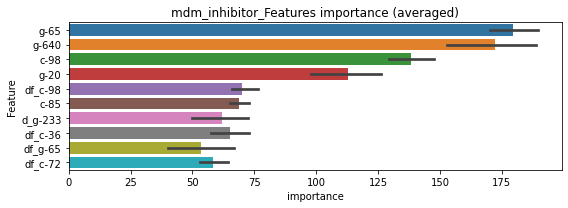

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 mdm_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0121858	valid_1's binary_logloss: 0.0201175
[200]	training's binary_logloss: 0.00138653	valid_1's binary_logloss: 0.00673652
[300]	training's binary_logloss: 0.000396706	valid_1's binary_logloss: 0.00515935
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.000330022	valid_1's binary_logloss: 0.00504114


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 mdm_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0125191	valid_1's binary_logloss: 0.0242771
[200]	training's binary_logloss: 0.00142453	valid_1's binary_logloss: 0.00940083
[300]	training's binary_logloss: 0.000406265	valid_1's binary_logloss: 0.00694055
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.000233139	valid_1's binary_logloss: 0.00624973


mdm_inhibitor logloss: 0.0056454359447014315


neg labels: 3289 → selected neg labels: 3278


mek_inhibitor, len(trt): 72, len(othr): 3278, target_rate: 0.0030234 → Adj_target_rate: 0.0031837
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0279848	valid_1's binary_logloss: 0.0417425
[200]	training's binary_logloss: 0.00384454	valid_1's binary_logloss: 0.01411
[300]	training's binary_logloss: 0.00111034	valid_1's binary_logloss: 0.00993904
[400]	training's binary_logloss: 0.000562357	valid_1's binary_logloss: 0.0091289
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.000501125	valid_1's binary_logloss: 0.00901177
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283841	valid_1's binary_logloss: 0.0565403
[200]	training's binary_logloss: 0.00374061	valid_1's binary_logloss: 0.0293337
[300]	training's binary_logloss: 0.00105403	valid_1's binary_logloss: 0.0256721
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.000938422	valid_1's binary_logloss: 0.0255245


1 / 3 AUC score:0.999
y_Threshold: 0.0036854, Threshold: 0.0091108, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 136 → Positive_corect_labels: 653/3797
p_label_rate: 0.0200904 Vs.target_rate: 0.00302
Num_p_label: 80.0, conf_0:0.00820, conf_1:0.01002
Num_p_label: 80.0, Expected: 12.0, Adj_threshold_1: 0.0091108
Num_p_label: 50.0, Expected: 12.0, Adj_threshold_2: 0.0191108
Num_p_label: 41.0, Expected: 12.0, Adj_threshold_3: 0.0291108
Num_p_label: 35.0, Expected: 12.0, Adj_threshold_4: 0.0391108
Num_p_label: 33.0, Expected: 12.0, Adj_threshold_5: 0.0491108
Num_p_label: 32.0, Expected: 12.0, Adj_threshold_6: 0.0591108
Num_p_label: 30.0, Expected: 12.0, Adj_threshold_7: 0.0691108
Num_p_label: 29.0, Expected: 12.0, Adj_threshold_8: 0.0791108
Num_p_label: 29.0, Expected: 12.0, Adj_threshold_9: 0.0891108
Num_p_label: 28.0, Expected: 12.0, Adj_threshold_10: 0.0991108
threshold: 0.1091108, positive_p_label: 28.0/3982, p_label_rate: 0.0070316
positive_y_label: 653.0/3797, y_label_rate: 0.1719779

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026835	valid_1's binary_logloss: 0.0457366
[200]	training's binary_logloss: 0.00337045	valid_1's binary_logloss: 0.0159927
[300]	training's binary_logloss: 0.000947368	valid_1's binary_logloss: 0.010809
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.000517254	valid_1's binary_logloss: 0.00964605
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0266746	valid_1's binary_logloss: 0.0468469
[200]	training's binary_logloss: 0.00339206	valid_1's binary_logloss: 0.0172766
[300]	training's binary_logloss: 0.000953234	valid_1's binary_logloss: 0.0114772
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000539012	valid_1's binary_logloss: 0.00973472


2 / 3 AUC score:1.000
y_Threshold: 0.0328719, Threshold: 0.1091108, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 651.0/3793
p_label_rate: 0.0123054 Vs.target_rate: 0.00302
Num_p_label: 49.0, conf_0:0.09820, conf_1:0.12002
Num_p_label: 49.0, Expected: 12.0, Adj_threshold_1: 0.1091108
Num_p_label: 48.0, Expected: 12.0, Adj_threshold_2: 0.1191108
Num_p_label: 48.0, Expected: 12.0, Adj_threshold_3: 0.1291108
Num_p_label: 47.0, Expected: 12.0, Adj_threshold_4: 0.1391108
Num_p_label: 46.0, Expected: 12.0, Adj_threshold_5: 0.1491108
Num_p_label: 45.0, Expected: 12.0, Adj_threshold_6: 0.1591108
Num_p_label: 44.0, Expected: 12.0, Adj_threshold_7: 0.1691108
Num_p_label: 43.0, Expected: 12.0, Adj_threshold_8: 0.1791108
Num_p_label: 43.0, Expected: 12.0, Adj_threshold_9: 0.1891108
Num_p_label: 41.0, Expected: 12.0, Adj_threshold_10: 0.1991108
threshold: 0.2091108, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 651.0/3793, y_label_rate: 0.1716320

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0277686	valid_1's binary_logloss: 0.035667
[200]	training's binary_logloss: 0.00351317	valid_1's binary_logloss: 0.00729283
[300]	training's binary_logloss: 0.000970456	valid_1's binary_logloss: 0.00300727
[400]	training's binary_logloss: 0.000497453	valid_1's binary_logloss: 0.00193603
[500]	training's binary_logloss: 0.000367816	valid_1's binary_logloss: 0.00163501
Early stopping, best iteration is:
[521]	training's binary_logloss: 0.000362914	valid_1's binary_logloss: 0.0016294
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0258994	valid_1's binary_logloss: 0.0615188
[200]	training's binary_logloss: 0.00316592	valid_1's binary_logloss: 0.0358349
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.0010524	valid_1's binary_logloss: 0.0333


3 / 3 AUC score:1.000
y_Threshold: 0.0175072, Threshold: 0.2091108, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 648.0/3787
p_label_rate: 0.0110497 Vs.target_rate: 0.00302
Num_p_label: 44.0, conf_0:0.18820, conf_1:0.23002
Num_p_label: 44.0, Expected: 12.0, Adj_threshold_1: 0.2091108
Num_p_label: 43.0, Expected: 12.0, Adj_threshold_2: 0.2191108
Num_p_label: 43.0, Expected: 12.0, Adj_threshold_3: 0.2291108
Num_p_label: 42.0, Expected: 12.0, Adj_threshold_4: 0.2391108
Num_p_label: 41.0, Expected: 12.0, Adj_threshold_5: 0.2491108
Num_p_label: 40.0, Expected: 12.0, Adj_threshold_6: 0.2591108
Num_p_label: 39.0, Expected: 12.0, Adj_threshold_7: 0.2691108
Num_p_label: 39.0, Expected: 12.0, Adj_threshold_8: 0.2791108
Num_p_label: 39.0, Expected: 12.0, Adj_threshold_9: 0.2891108
Num_p_label: 39.0, Expected: 12.0, Adj_threshold_10: 0.2991108
threshold: 0.3091108, positive_p_label: 39.0/3982, p_label_rate: 0.0097941
positive_y_label: 687.0/7769, y_label_rate: 0.0884284

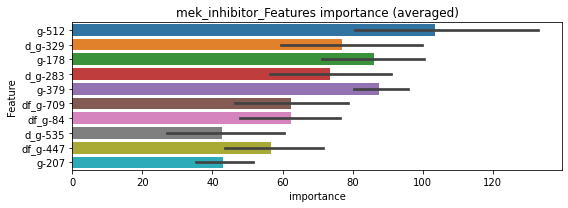

len(train_index) : 3884
len(valid_index) : 3885
================================= fold 1/2 mek_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0140649	valid_1's binary_logloss: 0.0255462
[200]	training's binary_logloss: 0.00169565	valid_1's binary_logloss: 0.0108675
[300]	training's binary_logloss: 0.000497004	valid_1's binary_logloss: 0.00874477
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000298481	valid_1's binary_logloss: 0.00808166


len(train_index) : 3885
len(valid_index) : 3884
================================= fold 2/2 mek_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.014327	valid_1's binary_logloss: 0.0282704
[200]	training's binary_logloss: 0.0017616	valid_1's binary_logloss: 0.0125101
[300]	training's binary_logloss: 0.000488331	valid_1's binary_logloss: 0.0095791
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.000467154	valid_1's binary_logloss: 0.00948808


mek_inhibitor logloss: 0.008784779286552878


neg labels: 3289 → selected neg labels: 3278


membrane_integrity_inhibitor, len(trt): 74, len(othr): 3278, target_rate: 0.0031074 → Adj_target_rate: 0.0032587
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0529435	valid_1's binary_logloss: 0.0967723
[200]	training's binary_logloss: 0.0116662	valid_1's binary_logloss: 0.0524544
[300]	training's binary_logloss: 0.00343856	valid_1's binary_logloss: 0.0403976
[400]	training's binary_logloss: 0.00152871	valid_1's binary_logloss: 0.0370314
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.00158706	valid_1's binary_logloss: 0.0368821
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0513269	valid_1's binary_logloss: 0.121089
[200]	training's binary_logloss: 0.0102336	valid_1's binary_logloss: 0.0735216
[300]	training's binary_logloss: 0.00299557	valid_1's binary_logloss: 0.0652026
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.00266055	valid_1's binary_logloss: 0.0649833


1 / 3 AUC score:0.993
y_Threshold: 0.0171434, Threshold: 0.0265430, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 164 → Positive_corect_labels: 639/3769
p_label_rate: 0.0200904 Vs.target_rate: 0.00311
Num_p_label: 80.0, conf_0:0.02389, conf_1:0.02920
Num_p_label: 80.0, Expected: 12.4, Adj_threshold_1: 0.0265430
Num_p_label: 45.0, Expected: 12.4, Adj_threshold_2: 0.0365430
Num_p_label: 19.0, Expected: 12.4, Adj_threshold_3: 0.0465430
threshold: 0.0465430, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 639.0/3769, y_label_rate: 0.1695410
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0483778	valid_1's binary_logloss: 0.0991181
[200]	training's binary_logloss: 0.00986478	valid_1's binary_logloss: 0.0519969
[300]	training's binary_logloss: 0.00289642	valid_1's binary_logloss: 0.0402884
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.00154277	valid_1's binary_logloss: 0.037511
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0508604	valid_1's binary_logloss: 0.103518
[200]	training's binary_logloss: 0.0102634	valid_1's binary_logloss: 0.0504838
[300]	training's binary_logloss: 0.0029215	valid_1's binary_logloss: 0.0376758
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.00154797	valid_1's binary_logloss: 0.0349052


2 / 3 AUC score:0.999
y_Threshold: 0.0373533, Threshold: 0.0465430, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 26 → Positive_corect_labels: 626.0/3743
p_label_rate: 0.0107986 Vs.target_rate: 0.00311
Num_p_label: 43.0, conf_0:0.04189, conf_1:0.05120
Num_p_label: 43.0, Expected: 12.4, Adj_threshold_1: 0.0465430
Num_p_label: 30.0, Expected: 12.4, Adj_threshold_2: 0.0565430
Num_p_label: 22.0, Expected: 12.4, Adj_threshold_3: 0.0665430
threshold: 0.0665430, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 626.0/3743, y_label_rate: 0.1672455
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0450007	valid_1's binary_logloss: 0.112505
[200]	training's binary_logloss: 0.0085046	valid_1's binary_logloss: 0.0700593
[300]	training's binary_logloss: 0.00251164	valid_1's binary_logloss: 0.0604373
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.00151622	valid_1's binary_logloss: 0.0587385
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0479157	valid_1's binary_logloss: 0.0944208
[200]	training's binary_logloss: 0.00935886	valid_1's binary_logloss: 0.0469346
[300]	training's binary_logloss: 0.00272678	valid_1's binary_logloss: 0.0362926
[400]	training's binary_logloss: 0.00126682	valid_1's binary_logloss: 0.0318607
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.000926277	valid_1's binary_logloss: 0.0310641


3 / 3 AUC score:0.997
y_Threshold: 0.0333598, Threshold: 0.0665430, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 615.0/3721
p_label_rate: 0.0052737 Vs.target_rate: 0.00311
Num_p_label: 21.0, conf_0:0.05989, conf_1:0.07320
threshold: 0.0665430, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 636.0/7703, y_label_rate: 0.0825652


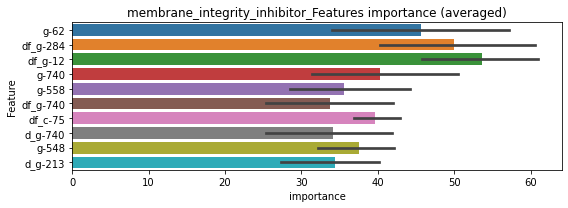

len(train_index) : 3851
len(valid_index) : 3852
================================= fold 1/2 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.025049	valid_1's binary_logloss: 0.068554
[200]	training's binary_logloss: 0.00483116	valid_1's binary_logloss: 0.0484823
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.00247269	valid_1's binary_logloss: 0.0471567


len(train_index) : 3852
len(valid_index) : 3851
================================= fold 2/2 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0263052	valid_1's binary_logloss: 0.0608665
[200]	training's binary_logloss: 0.0052503	valid_1's binary_logloss: 0.0369979
[300]	training's binary_logloss: 0.00142992	valid_1's binary_logloss: 0.0309449
Early stopping, best iteration is:
[358]	training's binary_logloss: 0.000866218	valid_1's binary_logloss: 0.0295955


membrane_integrity_inhibitor logloss: 0.038377273442332036


neg labels: 3289 → selected neg labels: 3285


mineralocorticoid_receptor_antagonist, len(trt): 25, len(othr): 3285, target_rate: 0.0010498 → Adj_target_rate: 0.0012955
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0288255	valid_1's binary_logloss: 0.0513419
[200]	training's binary_logloss: 0.00371986	valid_1's binary_logloss: 0.0161772
[300]	training's binary_logloss: 0.00101604	valid_1's binary_logloss: 0.009439
Early stopping, best iteration is:
[373]	training's binary_logloss: 0.000591065	valid_1's binary_logloss: 0.00790479
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0292822	valid_1's binary_logloss: 0.0400191
[200]	training's binary_logloss: 0.00393985	valid_1's binary_logloss: 0.00795335
[300]	training's binary_logloss: 0.00107423	valid_1's binary_logloss: 0.00294964
[400]	training's binary_logloss: 0.000537465	valid_1's binary_logloss: 0.00176841
[500]	training's binary_logloss: 0.00039121	valid_1's binary_logloss: 0.00146317
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.000379605	valid_1's binary_logloss: 0.00144239


1 / 3 AUC score:1.000
y_Threshold: 0.0026174, Threshold: 0.0047729, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00105
Num_p_label: 80.0, conf_0:0.00430, conf_1:0.00525
Num_p_label: 80.0, Expected: 4.2, Adj_threshold_1: 0.0047729
Num_p_label: 14.0, Expected: 4.2, Adj_threshold_2: 0.0147729
Num_p_label: 5.0, Expected: 4.2, Adj_threshold_3: 0.0247729
threshold: 0.0247729, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286165	valid_1's binary_logloss: 0.0487648
[200]	training's binary_logloss: 0.00363067	valid_1's binary_logloss: 0.0141008
[300]	training's binary_logloss: 0.00100566	valid_1's binary_logloss: 0.00887221
[400]	training's binary_logloss: 0.000509395	valid_1's binary_logloss: 0.00739895
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.000422566	valid_1's binary_logloss: 0.00708618
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027949	valid_1's binary_logloss: 0.0369214
[200]	training's binary_logloss: 0.00366139	valid_1's binary_logloss: 0.00715286
[300]	training's binary_logloss: 0.00103089	valid_1's binary_logloss: 0.00268634
[400]	training's binary_logloss: 0.000525566	valid_1's binary_logloss: 0.00163887
[500]	training's binary_logloss: 0.00038651	valid_1's binary_logloss: 0.00134209
Early stopping, best iteration is:
[

2 / 3 AUC score:1.000
y_Threshold: 0.0136574, Threshold: 0.0247729, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0030136 Vs.target_rate: 0.00105
Num_p_label: 12.0, conf_0:0.02230, conf_1:0.02725
threshold: 0.0247729, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286165	valid_1's binary_logloss: 0.0487648
[200]	training's binary_logloss: 0.00363067	valid_1's binary_logloss: 0.0141008
[300]	training's binary_logloss: 0.00100566	valid_1's binary_logloss: 0.00887221
[400]	training's binary_logloss: 0.000509395	valid_1's binary_logloss: 0.00739895
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.000422566	valid_1's binary_logloss: 0.00708618
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027949	valid_1's binary_logloss: 0.0369214
[200]	training's binary_logloss: 0.00366139	valid_1's binary_logloss: 0.00715286
[300]	training's binary_logloss: 0.00103089	valid_1's binary_logloss: 0.00268634
[400]	training's binary_logloss: 0.000525566	valid_1's binary_logloss: 0.00163887
[500]	training's binary_logloss: 0.00038651	valid_1's binary_logloss: 0.00134209
Early stopping, best iteration is:
[

3 / 3 AUC score:1.000
y_Threshold: 0.0136574, Threshold: 0.0247729, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0030136 Vs.target_rate: 0.00105
Num_p_label: 12.0, conf_0:0.02230, conf_1:0.02725
threshold: 0.0247729, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 669.0/7792, y_label_rate: 0.0858573


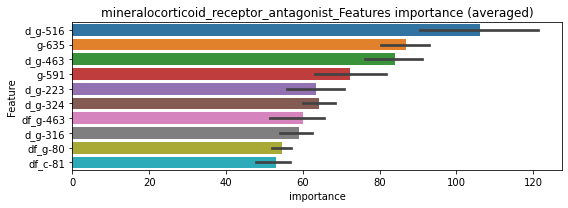

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016155	valid_1's binary_logloss: 0.026826
[200]	training's binary_logloss: 0.00214391	valid_1's binary_logloss: 0.0104624
Early stopping, best iteration is:
[266]	training's binary_logloss: 0.000821512	valid_1's binary_logloss: 0.00921853


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0170295	valid_1's binary_logloss: 0.0277642
[200]	training's binary_logloss: 0.00230851	valid_1's binary_logloss: 0.00880522
[300]	training's binary_logloss: 0.000627552	valid_1's binary_logloss: 0.00614373
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.000518072	valid_1's binary_logloss: 0.00596238


mineralocorticoid_receptor_antagonist logloss: 0.007590452831741524


neg labels: 3289 → selected neg labels: 3287


monoacylglycerol_lipase_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187478	valid_1's binary_logloss: 0.0228378
[200]	training's binary_logloss: 0.00195968	valid_1's binary_logloss: 0.00335648
[300]	training's binary_logloss: 0.000564449	valid_1's binary_logloss: 0.00115987
[400]	training's binary_logloss: 0.000314013	valid_1's binary_logloss: 0.000712164
[500]	training's binary_logloss: 0.000273948	valid_1's binary_logloss: 0.000642862
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.0002727	valid_1's binary_logloss: 0.000641482
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185682	valid_1's binary_logloss: 0.0211448
[200]	training's binary_logloss: 0.00191832	valid_1's binary_logloss: 0.00295307
[300]	training's binary_logloss: 0.000555965	valid_1's binary_logloss: 0.000975467
[400]	training's binary_logloss: 0.000311933	valid_1's binary_logloss: 0.000575061
Early stopping, best iterati

1 / 3 AUC score:1.000
y_Threshold: 0.0009038, Threshold: 0.0016372, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050
Num_p_label: 80.0, conf_0:0.00147, conf_1:0.00180
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0016372
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_2: 0.0116372
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_3: 0.0216372
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_4: 0.0316372
threshold: 0.0316372, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183675	valid_1's binary_logloss: 0.021836
[200]	training's binary_logloss: 0.00182469	valid_1's binary_logloss: 0.0029499
[300]	training's binary_logloss: 0.000539904	valid_1's binary_logloss: 0.00105387
[400]	training's binary_logloss: 0.000313799	valid_1's binary_logloss: 0.00068189
[500]	training's binary_logloss: 0.000273592	valid_1's binary_logloss: 0.000621615
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.000272816	valid_1's binary_logloss: 0.000621273
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.018758	valid_1's binary_logloss: 0.0203241
[200]	training's binary_logloss: 0.0018757	valid_1's binary_logloss: 0.00223577
[300]	training's binary_logloss: 0.000547007	valid_1's binary_logloss: 0.00071312
[400]	training's binary_logloss: 0.00031358	valid_1's binary_logloss: 0.000427071
Early stopping, best iteration is

2 / 3 AUC score:1.000
y_Threshold: 0.1442232, Threshold: 0.0316372, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0037670 Vs.target_rate: 0.00050
Num_p_label: 15.0, conf_0:0.02847, conf_1:0.03480
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_1: 0.0316372
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_2: 0.0416372
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_3: 0.0516372
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_4: 0.0616372
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_5: 0.0716372
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_6: 0.0816372
threshold: 0.0816372, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183675	valid_1's binary_logloss: 0.021836
[200]	training's binary_logloss: 0.00182469	valid_1's binary_logloss: 0.0029499
[300]	training's binary_logloss: 0.000539904	valid_1's binary_logloss: 0.00105387
[400]	training's binary_logloss: 0.000313799	valid_1's binary_logloss: 0.00068189
[500]	training's binary_logloss: 0.000273592	valid_1's binary_logloss: 0.000621615
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.000272816	valid_1's binary_logloss: 0.000621273
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.018758	valid_1's binary_logloss: 0.0203241
[200]	training's binary_logloss: 0.0018757	valid_1's binary_logloss: 0.00223577
[300]	training's binary_logloss: 0.000547007	valid_1's binary_logloss: 0.00071312
[400]	training's binary_logloss: 0.00031358	valid_1's binary_logloss: 0.000427071
Early stopping, best iteration is

3 / 3 AUC score:1.000
y_Threshold: 0.1442232, Threshold: 0.0816372, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0010045 Vs.target_rate: 0.00050
Num_p_label: 4.0, conf_0:0.07347, conf_1:0.08980
threshold: 0.0816372, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 661.0/7794, y_label_rate: 0.0848088


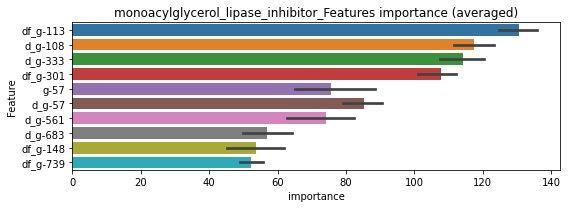

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.010125	valid_1's binary_logloss: 0.0138159
[200]	training's binary_logloss: 0.00100984	valid_1's binary_logloss: 0.00389823
[300]	training's binary_logloss: 0.000283367	valid_1's binary_logloss: 0.00334692
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.000269243	valid_1's binary_logloss: 0.00331257


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0105022	valid_1's binary_logloss: 0.0145714
[200]	training's binary_logloss: 0.00108465	valid_1's binary_logloss: 0.00335107
[300]	training's binary_logloss: 0.000292508	valid_1's binary_logloss: 0.00192034
[400]	training's binary_logloss: 0.000160081	valid_1's binary_logloss: 0.00168047
Early stopping, best iteration is:
[428]	training's binary_logloss: 0.000148661	valid_1's binary_logloss: 0.00166008


monoacylglycerol_lipase_inhibitor logloss: 0.0024863262490955377


neg labels: 3289 → selected neg labels: 3274


monoamine_oxidase_inhibitor, len(trt): 85, len(othr): 3274, target_rate: 0.0035693 → Adj_target_rate: 0.0036661
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0610269	valid_1's binary_logloss: 0.128941
[200]	training's binary_logloss: 0.0145484	valid_1's binary_logloss: 0.0716999
[300]	training's binary_logloss: 0.00438609	valid_1's binary_logloss: 0.0560541
[400]	training's binary_logloss: 0.00190526	valid_1's binary_logloss: 0.0515104
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.00175569	valid_1's binary_logloss: 0.0511544
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.066149	valid_1's binary_logloss: 0.131073
[200]	training's binary_logloss: 0.0151005	valid_1's binary_logloss: 0.0708872
[300]	training's binary_logloss: 0.00431369	valid_1's binary_logloss: 0.055158
[400]	training's binary_logloss: 0.00186889	valid_1's binary_logloss: 0.050496
[500]	training's binary_logloss: 0.00108097	valid_1's binary_logloss: 0.0496683
Early stopping, best iteration is:
[491]	training's 

1 / 3 AUC score:0.993
y_Threshold: 0.0153144, Threshold: 0.0219917, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 158 → Positive_corect_labels: 641/3770
p_label_rate: 0.0200904 Vs.target_rate: 0.00357
Num_p_label: 80.0, conf_0:0.01979, conf_1:0.02419
Num_p_label: 80.0, Expected: 14.2, Adj_threshold_1: 0.0219917
Num_p_label: 43.0, Expected: 14.2, Adj_threshold_2: 0.0319917
Num_p_label: 21.0, Expected: 14.2, Adj_threshold_3: 0.0419917
threshold: 0.0419917, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 641.0/3770, y_label_rate: 0.1700265
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0565617	valid_1's binary_logloss: 0.12241
[200]	training's binary_logloss: 0.0118655	valid_1's binary_logloss: 0.0720934
[300]	training's binary_logloss: 0.00352471	valid_1's binary_logloss: 0.0600597
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00265878	valid_1's binary_logloss: 0.0584601
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0581946	valid_1's binary_logloss: 0.120385
[200]	training's binary_logloss: 0.0125808	valid_1's binary_logloss: 0.061032
[300]	training's binary_logloss: 0.00365815	valid_1's binary_logloss: 0.0454257
[400]	training's binary_logloss: 0.00161646	valid_1's binary_logloss: 0.0405553
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.00160657	valid_1's binary_logloss: 0.0405435


2 / 3 AUC score:0.998
y_Threshold: 0.0481873, Threshold: 0.0419917, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 36 → Positive_corect_labels: 623.0/3734
p_label_rate: 0.0195881 Vs.target_rate: 0.00357
Num_p_label: 78.0, conf_0:0.03779, conf_1:0.04619
Num_p_label: 78.0, Expected: 14.2, Adj_threshold_1: 0.0419917
Num_p_label: 58.0, Expected: 14.2, Adj_threshold_2: 0.0519917
Num_p_label: 43.0, Expected: 14.2, Adj_threshold_3: 0.0619917
Num_p_label: 29.0, Expected: 14.2, Adj_threshold_4: 0.0719917
Num_p_label: 25.0, Expected: 14.2, Adj_threshold_5: 0.0819917
threshold: 0.0819917, positive_p_label: 25.0/3982, p_label_rate: 0.0062783
positive_y_label: 623.0/3734, y_label_rate: 0.1668452
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0543463	valid_1's binary_logloss: 0.115288
[200]	training's binary_logloss: 0.0111278	valid_1's binary_logloss: 0.0589251
[300]	training's binary_logloss: 0.00322083	valid_1's binary_logloss: 0.0445969
[400]	training's binary_logloss: 0.00145888	valid_1's binary_logloss: 0.0405591
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00109652	valid_1's binary_logloss: 0.0393909
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0533688	valid_1's binary_logloss: 0.116089
[200]	training's binary_logloss: 0.0106524	valid_1's binary_logloss: 0.0673407
[300]	training's binary_logloss: 0.00307864	valid_1's binary_logloss: 0.0569675
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.00208052	valid_1's binary_logloss: 0.055655


3 / 3 AUC score:0.997
y_Threshold: 0.0419957, Threshold: 0.0819917, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 28 → Positive_corect_labels: 609.0/3706
p_label_rate: 0.0050226 Vs.target_rate: 0.00357
Num_p_label: 20.0, conf_0:0.07379, conf_1:0.09019
threshold: 0.0819917, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 629.0/7688, y_label_rate: 0.0818158


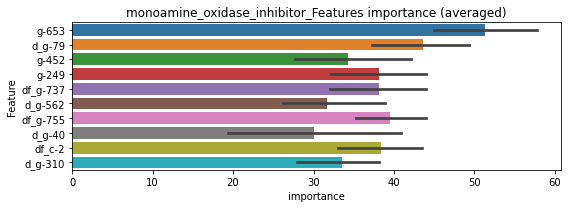

len(train_index) : 3844
len(valid_index) : 3844
================================= fold 1/2 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290669	valid_1's binary_logloss: 0.0768662
[200]	training's binary_logloss: 0.00604016	valid_1's binary_logloss: 0.0539634
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00241019	valid_1's binary_logloss: 0.0506912


len(train_index) : 3844
len(valid_index) : 3844
================================= fold 2/2 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.032195	valid_1's binary_logloss: 0.0689735
[200]	training's binary_logloss: 0.00657094	valid_1's binary_logloss: 0.0374504
[300]	training's binary_logloss: 0.00187088	valid_1's binary_logloss: 0.0300485
[400]	training's binary_logloss: 0.000810605	valid_1's binary_logloss: 0.0282242
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.000766333	valid_1's binary_logloss: 0.028046


monoamine_oxidase_inhibitor logloss: 0.03936861923483453


neg labels: 3289 → selected neg labels: 3286


monopolar_spindle_1_kinase_inhibitor, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0205219	valid_1's binary_logloss: 0.0255304
[200]	training's binary_logloss: 0.0022271	valid_1's binary_logloss: 0.00366398
[300]	training's binary_logloss: 0.000628999	valid_1's binary_logloss: 0.00132634
[400]	training's binary_logloss: 0.000351507	valid_1's binary_logloss: 0.000844649
[500]	training's binary_logloss: 0.000293275	valid_1's binary_logloss: 0.000734347
[600]	training's binary_logloss: 0.000284357	valid_1's binary_logloss: 0.000718743
Early stopping, best iteration is:
[637]	training's binary_logloss: 0.000283886	valid_1's binary_logloss: 0.000717812
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0207686	valid_1's binary_logloss: 0.0244756
[200]	training's binary_logloss: 0.00231702	valid_1's binary_logloss: 0.00334289
[300]	training's binary_logloss: 0.000657375	valid_1's binary_logloss: 0.00109195
[400]	training's binary_logl

1 / 3 AUC score:1.000
y_Threshold: 0.0014781, Threshold: 0.0025418, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00229, conf_1:0.00280
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0025418
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_2: 0.0125418
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_3: 0.0225418
threshold: 0.0225418, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0205265	valid_1's binary_logloss: 0.0243248
[200]	training's binary_logloss: 0.00219542	valid_1's binary_logloss: 0.00326939
[300]	training's binary_logloss: 0.00062516	valid_1's binary_logloss: 0.00107721
[400]	training's binary_logloss: 0.000347069	valid_1's binary_logloss: 0.000645576
[500]	training's binary_logloss: 0.000291288	valid_1's binary_logloss: 0.000561265
[600]	training's binary_logloss: 0.000283736	valid_1's binary_logloss: 0.000550636
Early stopping, best iteration is:
[619]	training's binary_logloss: 0.000283514	valid_1's binary_logloss: 0.000550235
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0210052	valid_1's binary_logloss: 0.0252868
[200]	training's binary_logloss: 0.00224996	valid_1's binary_logloss: 0.00336271
[300]	training's binary_logloss: 0.000628215	valid_1's binary_logloss: 0.00108791
[400]	training's binary_logl

2 / 3 AUC score:1.000
y_Threshold: 0.1630391, Threshold: 0.0225418, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0052737 Vs.target_rate: 0.00076
Num_p_label: 21.0, conf_0:0.02029, conf_1:0.02480
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_1: 0.0225418
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_2: 0.0325418
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_3: 0.0425418
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_4: 0.0525418
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_5: 0.0625418
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_6: 0.0725418
threshold: 0.0725418, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0205265	valid_1's binary_logloss: 0.0243248
[200]	training's binary_logloss: 0.00219542	valid_1's binary_logloss: 0.00326939
[300]	training's binary_logloss: 0.00062516	valid_1's binary_logloss: 0.00107721
[400]	training's binary_logloss: 0.000347069	valid_1's binary_logloss: 0.000645576
[500]	training's binary_logloss: 0.000291288	valid_1's binary_logloss: 0.000561265
[600]	training's binary_logloss: 0.000283736	valid_1's binary_logloss: 0.000550636
Early stopping, best iteration is:
[619]	training's binary_logloss: 0.000283514	valid_1's binary_logloss: 0.000550235
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0210052	valid_1's binary_logloss: 0.0252868
[200]	training's binary_logloss: 0.00224996	valid_1's binary_logloss: 0.00336271
[300]	training's binary_logloss: 0.000628215	valid_1's binary_logloss: 0.00108791
[400]	training's binary_logl

3 / 3 AUC score:1.000
y_Threshold: 0.1630391, Threshold: 0.0725418, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0015068 Vs.target_rate: 0.00076
Num_p_label: 6.0, conf_0:0.06529, conf_1:0.07980
threshold: 0.0725418, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7793, y_label_rate: 0.0850764


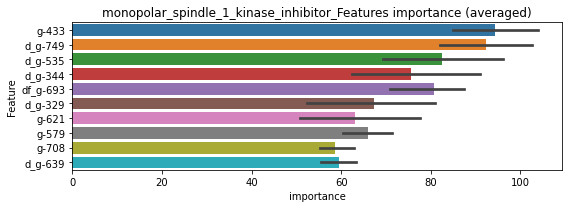

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0110082	valid_1's binary_logloss: 0.0173238
[200]	training's binary_logloss: 0.00114892	valid_1's binary_logloss: 0.00657521
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.000360404	valid_1's binary_logloss: 0.00584057


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.011169	valid_1's binary_logloss: 0.018525
[200]	training's binary_logloss: 0.00123141	valid_1's binary_logloss: 0.00503415
[300]	training's binary_logloss: 0.000345178	valid_1's binary_logloss: 0.00304396
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.00025656	valid_1's binary_logloss: 0.00275286


monopolar_spindle_1_kinase_inhibitor logloss: 0.004296912875667312


neg labels: 3289 → selected neg labels: 3267


mtor_inhibitor, len(trt): 130, len(othr): 3267, target_rate: 0.0054590 → Adj_target_rate: 0.0052608
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297312	valid_1's binary_logloss: 0.0771712
Early stopping, best iteration is:
[171]	training's binary_logloss: 0.00685873	valid_1's binary_logloss: 0.057281
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339216	valid_1's binary_logloss: 0.0638013
[200]	training's binary_logloss: 0.00531639	valid_1's binary_logloss: 0.0390527
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00206954	valid_1's binary_logloss: 0.0369321


1 / 3 AUC score:0.992
y_Threshold: 0.0108855, Threshold: 0.0787234, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 157 → Positive_corect_labels: 640/3763
p_label_rate: 0.0200904 Vs.target_rate: 0.00546
Num_p_label: 80.0, conf_0:0.07085, conf_1:0.08660
Num_p_label: 80.0, Expected: 21.7, Adj_threshold_1: 0.0787234
Num_p_label: 76.0, Expected: 21.7, Adj_threshold_2: 0.0887234
Num_p_label: 74.0, Expected: 21.7, Adj_threshold_3: 0.0987234
Num_p_label: 73.0, Expected: 21.7, Adj_threshold_4: 0.1087234
Num_p_label: 69.0, Expected: 21.7, Adj_threshold_5: 0.1187234
Num_p_label: 68.0, Expected: 21.7, Adj_threshold_6: 0.1287234
Num_p_label: 66.0, Expected: 21.7, Adj_threshold_7: 0.1387234
Num_p_label: 64.0, Expected: 21.7, Adj_threshold_8: 0.1487234
Num_p_label: 64.0, Expected: 21.7, Adj_threshold_9: 0.1587234
Num_p_label: 63.0, Expected: 21.7, Adj_threshold_10: 0.1687234
threshold: 0.1787234, positive_p_label: 63.0/3982, p_label_rate: 0.0158212
positive_y_label: 640.0/3763, y_label_rate: 0.1700771

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275259	valid_1's binary_logloss: 0.0396529
[200]	training's binary_logloss: 0.00363119	valid_1's binary_logloss: 0.0137307
[300]	training's binary_logloss: 0.00108216	valid_1's binary_logloss: 0.00919936
[400]	training's binary_logloss: 0.000557749	valid_1's binary_logloss: 0.00792578
[500]	training's binary_logloss: 0.000408095	valid_1's binary_logloss: 0.0073376
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.000395104	valid_1's binary_logloss: 0.00721607
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257193	valid_1's binary_logloss: 0.0619322
Early stopping, best iteration is:
[185]	training's binary_logloss: 0.00421686	valid_1's binary_logloss: 0.0440856


2 / 3 AUC score:0.998
y_Threshold: 0.0481649, Threshold: 0.1787234, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 20 → Positive_corect_labels: 630.0/3743
p_label_rate: 0.0369161 Vs.target_rate: 0.00546
Num_p_label: 147.0, conf_0:0.16085, conf_1:0.19660
Num_p_label: 147.0, Expected: 21.7, Adj_threshold_1: 0.1787234
Num_p_label: 141.0, Expected: 21.7, Adj_threshold_2: 0.1887234
Num_p_label: 138.0, Expected: 21.7, Adj_threshold_3: 0.1987234
Num_p_label: 133.0, Expected: 21.7, Adj_threshold_4: 0.2087234
Num_p_label: 129.0, Expected: 21.7, Adj_threshold_5: 0.2187234
Num_p_label: 126.0, Expected: 21.7, Adj_threshold_6: 0.2287234
Num_p_label: 121.0, Expected: 21.7, Adj_threshold_7: 0.2387234
Num_p_label: 116.0, Expected: 21.7, Adj_threshold_8: 0.2487234
Num_p_label: 111.0, Expected: 21.7, Adj_threshold_9: 0.2587234
Num_p_label: 108.0, Expected: 21.7, Adj_threshold_10: 0.2687234
threshold: 0.2787234, positive_p_label: 105.0/3982, p_label_rate: 0.0263687
positive_y_label: 630.0/3743, y_label_ra

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024894	valid_1's binary_logloss: 0.0465346
[200]	training's binary_logloss: 0.00311977	valid_1's binary_logloss: 0.0249697
[300]	training's binary_logloss: 0.000882742	valid_1's binary_logloss: 0.021916
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.000675284	valid_1's binary_logloss: 0.0215331
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257616	valid_1's binary_logloss: 0.0428254
[200]	training's binary_logloss: 0.00336486	valid_1's binary_logloss: 0.0162196
[300]	training's binary_logloss: 0.000952675	valid_1's binary_logloss: 0.0114569
[400]	training's binary_logloss: 0.000478165	valid_1's binary_logloss: 0.00954278
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.000428493	valid_1's binary_logloss: 0.00938904


3 / 3 AUC score:1.000
y_Threshold: 0.0274744, Threshold: 0.2787234, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 625.0/3733
p_label_rate: 0.0364139 Vs.target_rate: 0.00546
Num_p_label: 145.0, conf_0:0.25085, conf_1:0.30660
Num_p_label: 145.0, Expected: 21.7, Adj_threshold_1: 0.2787234
Num_p_label: 143.0, Expected: 21.7, Adj_threshold_2: 0.2887234
Num_p_label: 140.0, Expected: 21.7, Adj_threshold_3: 0.2987234
Num_p_label: 140.0, Expected: 21.7, Adj_threshold_4: 0.3087234
Num_p_label: 140.0, Expected: 21.7, Adj_threshold_5: 0.3187234
Num_p_label: 140.0, Expected: 21.7, Adj_threshold_6: 0.3287234
Num_p_label: 138.0, Expected: 21.7, Adj_threshold_7: 0.3387234
Num_p_label: 137.0, Expected: 21.7, Adj_threshold_8: 0.3487234
Num_p_label: 136.0, Expected: 21.7, Adj_threshold_9: 0.3587234
Num_p_label: 136.0, Expected: 21.7, Adj_threshold_10: 0.3687234
threshold: 0.3787234, positive_p_label: 136.0/3982, p_label_rate: 0.0341537
positive_y_label: 761.0/7715, y_label_ra

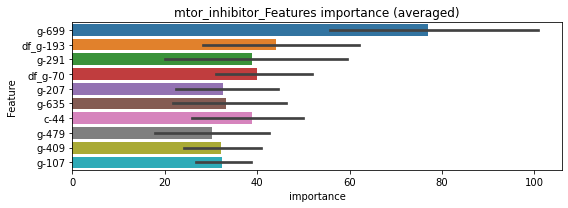

len(train_index) : 3857
len(valid_index) : 3858
================================= fold 1/2 mtor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162446	valid_1's binary_logloss: 0.0438794
[200]	training's binary_logloss: 0.00213865	valid_1's binary_logloss: 0.0313978
Early stopping, best iteration is:
[198]	training's binary_logloss: 0.00220296	valid_1's binary_logloss: 0.0313636


len(train_index) : 3858
len(valid_index) : 3857
================================= fold 2/2 mtor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159701	valid_1's binary_logloss: 0.0332039
[200]	training's binary_logloss: 0.00209873	valid_1's binary_logloss: 0.0213259
Early stopping, best iteration is:
[264]	training's binary_logloss: 0.000865086	valid_1's binary_logloss: 0.020346


mtor_inhibitor logloss: 0.025855484569903175


neg labels: 3289 → selected neg labels: 3281


mucolytic_agent, len(trt): 48, len(othr): 3281, target_rate: 0.0020156 → Adj_target_rate: 0.0022556
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0403125	valid_1's binary_logloss: 0.0882241
[200]	training's binary_logloss: 0.00692956	valid_1's binary_logloss: 0.0475328
[300]	training's binary_logloss: 0.00194288	valid_1's binary_logloss: 0.0407569
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00176515	valid_1's binary_logloss: 0.0402305
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0408055	valid_1's binary_logloss: 0.0675878
[200]	training's binary_logloss: 0.00714574	valid_1's binary_logloss: 0.0211911
[300]	training's binary_logloss: 0.00204428	valid_1's binary_logloss: 0.0103182
[400]	training's binary_logloss: 0.000957665	valid_1's binary_logloss: 0.007042
[500]	training's binary_logloss: 0.000613396	valid_1's binary_logloss: 0.00577146
[600]	training's binary_logloss: 0.000492981	valid_1's binary_logloss: 0.0052968
Early stopping, best iteration is:
[590]	t

1 / 3 AUC score:0.998
y_Threshold: 0.0085277, Threshold: 0.0145609, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 144 → Positive_corect_labels: 650/3793
p_label_rate: 0.0200904 Vs.target_rate: 0.00202
Num_p_label: 80.0, conf_0:0.01310, conf_1:0.01602
Num_p_label: 80.0, Expected: 8.0, Adj_threshold_1: 0.0145609
Num_p_label: 33.0, Expected: 8.0, Adj_threshold_2: 0.0245609
Num_p_label: 19.0, Expected: 8.0, Adj_threshold_3: 0.0345609
Num_p_label: 11.0, Expected: 8.0, Adj_threshold_4: 0.0445609
threshold: 0.0445609, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 650.0/3793, y_label_rate: 0.1713683
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0398622	valid_1's binary_logloss: 0.0797868
[200]	training's binary_logloss: 0.00671008	valid_1's binary_logloss: 0.0331153
[300]	training's binary_logloss: 0.00189617	valid_1's binary_logloss: 0.0214411
[400]	training's binary_logloss: 0.000890371	valid_1's binary_logloss: 0.0175196
[500]	training's binary_logloss: 0.000574327	valid_1's binary_logloss: 0.015956
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00055576	valid_1's binary_logloss: 0.0157619
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03929	valid_1's binary_logloss: 0.0700717
[200]	training's binary_logloss: 0.00659491	valid_1's binary_logloss: 0.0277693
[300]	training's binary_logloss: 0.00188733	valid_1's binary_logloss: 0.0181492
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00104734	valid_1's binary_logloss: 0.0154661


2 / 3 AUC score:1.000
y_Threshold: 0.0429737, Threshold: 0.0445609, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 648.0/3789
p_label_rate: 0.0075339 Vs.target_rate: 0.00202
Num_p_label: 30.0, conf_0:0.04010, conf_1:0.04902
Num_p_label: 30.0, Expected: 8.0, Adj_threshold_1: 0.0445609
Num_p_label: 25.0, Expected: 8.0, Adj_threshold_2: 0.0545609
Num_p_label: 22.0, Expected: 8.0, Adj_threshold_3: 0.0645609
Num_p_label: 18.0, Expected: 8.0, Adj_threshold_4: 0.0745609
Num_p_label: 17.0, Expected: 8.0, Adj_threshold_5: 0.0845609
Num_p_label: 13.0, Expected: 8.0, Adj_threshold_6: 0.0945609
threshold: 0.0945609, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 648.0/3789, y_label_rate: 0.1710214
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0386699	valid_1's binary_logloss: 0.0689946
[200]	training's binary_logloss: 0.00642759	valid_1's binary_logloss: 0.024592
[300]	training's binary_logloss: 0.00186153	valid_1's binary_logloss: 0.0140963
[400]	training's binary_logloss: 0.000871249	valid_1's binary_logloss: 0.0108637
[500]	training's binary_logloss: 0.00056565	valid_1's binary_logloss: 0.00969732
Early stopping, best iteration is:
[521]	training's binary_logloss: 0.000532116	valid_1's binary_logloss: 0.00958895
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0391806	valid_1's binary_logloss: 0.0925709
[200]	training's binary_logloss: 0.00632678	valid_1's binary_logloss: 0.0565557
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.00379713	valid_1's binary_logloss: 0.0536437


3 / 3 AUC score:1.000
y_Threshold: 0.0504603, Threshold: 0.0945609, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 18 → Positive_corect_labels: 639.0/3771
p_label_rate: 0.0027624 Vs.target_rate: 0.00202
Num_p_label: 11.0, conf_0:0.08510, conf_1:0.10402
threshold: 0.0945609, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 650.0/7753, y_label_rate: 0.0838385


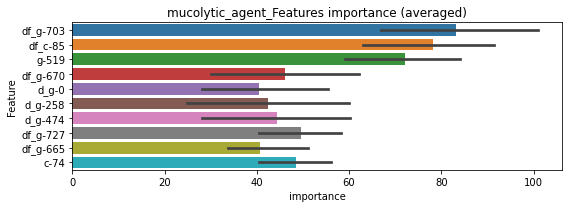

len(train_index) : 3876
len(valid_index) : 3877
================================= fold 1/2 mucolytic_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0224845	valid_1's binary_logloss: 0.0492596
[200]	training's binary_logloss: 0.00374992	valid_1's binary_logloss: 0.0278279
[300]	training's binary_logloss: 0.00103627	valid_1's binary_logloss: 0.0234259
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.0011114	valid_1's binary_logloss: 0.0233606


len(train_index) : 3877
len(valid_index) : 3876
================================= fold 2/2 mucolytic_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0219445	valid_1's binary_logloss: 0.0429616
[200]	training's binary_logloss: 0.0038978	valid_1's binary_logloss: 0.0186368
[300]	training's binary_logloss: 0.0010452	valid_1's binary_logloss: 0.0133807
[400]	training's binary_logloss: 0.000479845	valid_1's binary_logloss: 0.0119792
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000345977	valid_1's binary_logloss: 0.0117298


mucolytic_agent logloss: 0.01754596299604203


neg labels: 3289 → selected neg labels: 3283


neuropeptide_receptor_antagonist, len(trt): 37, len(othr): 3283, target_rate: 0.0015537 → Adj_target_rate: 0.0018079
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0362245	valid_1's binary_logloss: 0.0653913
[200]	training's binary_logloss: 0.00559675	valid_1's binary_logloss: 0.0210353
[300]	training's binary_logloss: 0.00153527	valid_1's binary_logloss: 0.0113282
[400]	training's binary_logloss: 0.000719922	valid_1's binary_logloss: 0.00884285
[500]	training's binary_logloss: 0.000477875	valid_1's binary_logloss: 0.0077743
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000489961	valid_1's binary_logloss: 0.00771553
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0366298	valid_1's binary_logloss: 0.0588676
[200]	training's binary_logloss: 0.00559789	valid_1's binary_logloss: 0.0144797
[300]	training's binary_logloss: 0.00160096	valid_1's binary_logloss: 0.00625034
[400]	training's binary_logloss: 0.0007274	valid_1's binary_logloss: 0.00374953
[500]	training's binary_logloss: 0.0004

1 / 3 AUC score:1.000
y_Threshold: 0.0032485, Threshold: 0.0053758, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00155
Num_p_label: 80.0, conf_0:0.00484, conf_1:0.00591
Num_p_label: 80.0, Expected: 6.2, Adj_threshold_1: 0.0053758
Num_p_label: 10.0, Expected: 6.2, Adj_threshold_2: 0.0153758
threshold: 0.0153758, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0361196	valid_1's binary_logloss: 0.0627484
[200]	training's binary_logloss: 0.00538838	valid_1's binary_logloss: 0.0185051
[300]	training's binary_logloss: 0.00147492	valid_1's binary_logloss: 0.0091834
[400]	training's binary_logloss: 0.000710622	valid_1's binary_logloss: 0.00685642
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.000496038	valid_1's binary_logloss: 0.00610159
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0354661	valid_1's binary_logloss: 0.0559851
[200]	training's binary_logloss: 0.00543199	valid_1's binary_logloss: 0.0132467
[300]	training's binary_logloss: 0.00151198	valid_1's binary_logloss: 0.00541588
[400]	training's binary_logloss: 0.000728705	valid_1's binary_logloss: 0.00346219
[500]	training's binary_logloss: 0.000484715	valid_1's binary_logloss: 0.00279719
Early stopping, best iteration is:
[

2 / 3 AUC score:1.000
y_Threshold: 0.0436033, Threshold: 0.0153758, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0092918 Vs.target_rate: 0.00155
Num_p_label: 37.0, conf_0:0.01384, conf_1:0.01691
Num_p_label: 37.0, Expected: 6.2, Adj_threshold_1: 0.0153758
Num_p_label: 20.0, Expected: 6.2, Adj_threshold_2: 0.0253758
Num_p_label: 13.0, Expected: 6.2, Adj_threshold_3: 0.0353758
Num_p_label: 8.0, Expected: 6.2, Adj_threshold_4: 0.0453758
threshold: 0.0453758, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0361196	valid_1's binary_logloss: 0.0627484
[200]	training's binary_logloss: 0.00538838	valid_1's binary_logloss: 0.0185051
[300]	training's binary_logloss: 0.00147492	valid_1's binary_logloss: 0.0091834
[400]	training's binary_logloss: 0.000710622	valid_1's binary_logloss: 0.00685642
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.000496038	valid_1's binary_logloss: 0.00610159
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0354661	valid_1's binary_logloss: 0.0559851
[200]	training's binary_logloss: 0.00543199	valid_1's binary_logloss: 0.0132467
[300]	training's binary_logloss: 0.00151198	valid_1's binary_logloss: 0.00541588
[400]	training's binary_logloss: 0.000728705	valid_1's binary_logloss: 0.00346219
[500]	training's binary_logloss: 0.000484715	valid_1's binary_logloss: 0.00279719
Early stopping, best iteration is:
[

3 / 3 AUC score:1.000
y_Threshold: 0.0436033, Threshold: 0.0453758, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0020090 Vs.target_rate: 0.00155
Num_p_label: 8.0, conf_0:0.04084, conf_1:0.04991
threshold: 0.0453758, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 664.0/7789, y_label_rate: 0.0852484


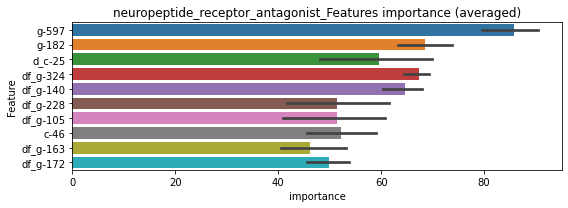

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0201473	valid_1's binary_logloss: 0.0393905
[200]	training's binary_logloss: 0.002968	valid_1's binary_logloss: 0.0189799
[300]	training's binary_logloss: 0.000802227	valid_1's binary_logloss: 0.0152107
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.000689653	valid_1's binary_logloss: 0.0149648


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0206767	valid_1's binary_logloss: 0.0344026
[200]	training's binary_logloss: 0.00310075	valid_1's binary_logloss: 0.0110877
[300]	training's binary_logloss: 0.000837229	valid_1's binary_logloss: 0.00704406
[400]	training's binary_logloss: 0.000392887	valid_1's binary_logloss: 0.0060936
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.000319113	valid_1's binary_logloss: 0.00588861


neuropeptide_receptor_antagonist logloss: 0.01042730535129316


neg labels: 3289 → selected neg labels: 3270


nfkb_inhibitor, len(trt): 832, len(othr): 3270, target_rate: 0.0349374 → Adj_target_rate: 0.0254860
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0504465	valid_1's binary_logloss: 0.119074
Early stopping, best iteration is:
[121]	training's binary_logloss: 0.0336925	valid_1's binary_logloss: 0.116319
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0421981	valid_1's binary_logloss: 0.151335
Early stopping, best iteration is:
[105]	training's binary_logloss: 0.0377206	valid_1's binary_logloss: 0.150852


1 / 3 AUC score:0.938
y_Threshold: 0.0325627, Threshold: 0.9653486, pos_neg_ratio: 0.7455657
Remove_noisy_labels: 412 → Positive_corect_labels: 732/3690
p_label_rate: 0.0200904 Vs.target_rate: 0.03494
Num_p_label: 80.0, conf_0:0.86881, conf_1:1.06188
threshold: 0.9653486, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 732.0/3690, y_label_rate: 0.1983740
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0175538	valid_1's binary_logloss: 0.0266212
Early stopping, best iteration is:
[179]	training's binary_logloss: 0.00206203	valid_1's binary_logloss: 0.0147784
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019321	valid_1's binary_logloss: 0.0208431
[200]	training's binary_logloss: 0.00165024	valid_1's binary_logloss: 0.00482892
[300]	training's binary_logloss: 0.000373575	valid_1's binary_logloss: 0.00420191
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.00040919	valid_1's binary_logloss: 0.0041792


2 / 3 AUC score:1.000
y_Threshold: 0.0595502, Threshold: 0.9653486, pos_neg_ratio: 0.7455657
Remove_noisy_labels: 10 → Positive_corect_labels: 727.0/3680
p_label_rate: 0.0389252 Vs.target_rate: 0.03494
Num_p_label: 155.0, conf_0:0.86881, conf_1:1.06188
threshold: 0.9653486, positive_p_label: 155.0/3982, p_label_rate: 0.0389252
positive_y_label: 727.0/3680, y_label_rate: 0.1975543
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162797	valid_1's binary_logloss: 0.0173342
[200]	training's binary_logloss: 0.00106481	valid_1's binary_logloss: 0.00135402
[300]	training's binary_logloss: 0.000235206	valid_1's binary_logloss: 0.000387054
[400]	training's binary_logloss: 0.000154755	valid_1's binary_logloss: 0.000286703
[500]	training's binary_logloss: 0.00014051	valid_1's binary_logloss: 0.000266426
[600]	training's binary_logloss: 0.00013708	valid_1's binary_logloss: 0.000261546
Early stopping, best iteration is:
[645]	training's binary_logloss: 0.00013653	valid_1's binary_logloss: 0.000261032
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163555	valid_1's binary_logloss: 0.0178846
[200]	training's binary_logloss: 0.00106867	valid_1's binary_logloss: 0.00277534


3 / 3 AUC score:1.000
y_Threshold: 0.1367363, Threshold: 0.9653486, pos_neg_ratio: 0.7455657


Early stopping, best iteration is:
[241]	training's binary_logloss: 0.000473511	valid_1's binary_logloss: 0.0022629


Remove_noisy_labels: 2 → Positive_corect_labels: 726.0/3678
p_label_rate: 0.0396786 Vs.target_rate: 0.03494
Num_p_label: 158.0, conf_0:0.86881, conf_1:1.06188
threshold: 0.9653486, positive_p_label: 158.0/3982, p_label_rate: 0.0396786
positive_y_label: 884.0/7660, y_label_rate: 0.1154047


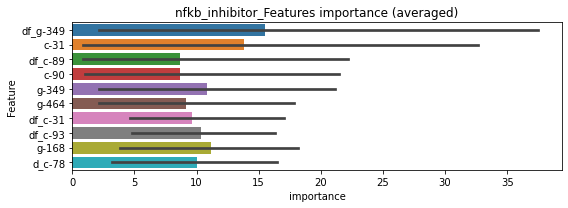

len(train_index) : 3830
len(valid_index) : 3830
================================= fold 1/2 nfkb_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0110882	valid_1's binary_logloss: 0.0118976
[200]	training's binary_logloss: 0.000798881	valid_1's binary_logloss: 0.00145568
[300]	training's binary_logloss: 0.000161606	valid_1's binary_logloss: 0.000708577
[400]	training's binary_logloss: 9.19175e-05	valid_1's binary_logloss: 0.000593191
Early stopping, best iteration is:
[435]	training's binary_logloss: 8.51093e-05	valid_1's binary_logloss: 0.000578952


len(train_index) : 3830
len(valid_index) : 3830
================================= fold 2/2 nfkb_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0110238	valid_1's binary_logloss: 0.0124308
[200]	training's binary_logloss: 0.000750577	valid_1's binary_logloss: 0.00291189
Early stopping, best iteration is:
[234]	training's binary_logloss: 0.000363502	valid_1's binary_logloss: 0.00279293


nfkb_inhibitor logloss: 0.0016859389672242505


neg labels: 3289 → selected neg labels: 3287


nicotinic_receptor_agonist, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019049	valid_1's binary_logloss: 0.0225703
[200]	training's binary_logloss: 0.0018698	valid_1's binary_logloss: 0.00304384
[300]	training's binary_logloss: 0.00051436	valid_1's binary_logloss: 0.00106967
[400]	training's binary_logloss: 0.00028892	valid_1's binary_logloss: 0.000695885
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.000253511	valid_1's binary_logloss: 0.000637049
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190467	valid_1's binary_logloss: 0.0249046
[200]	training's binary_logloss: 0.00188915	valid_1's binary_logloss: 0.00320538
[300]	training's binary_logloss: 0.000520738	valid_1's binary_logloss: 0.00104638
[400]	training's binary_logloss: 0.000291727	valid_1's binary_logloss: 0.000658759
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000256327	valid_1's binary_logloss: 0.000598

1 / 3 AUC score:1.000
y_Threshold: 0.0009305, Threshold: 0.0017779, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050
Num_p_label: 80.0, conf_0:0.00160, conf_1:0.00196
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0017779
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_2: 0.0117779
threshold: 0.0117779, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191556	valid_1's binary_logloss: 0.022544
[200]	training's binary_logloss: 0.00185484	valid_1's binary_logloss: 0.00279927
[300]	training's binary_logloss: 0.000503917	valid_1's binary_logloss: 0.000963498
[400]	training's binary_logloss: 0.000286951	valid_1's binary_logloss: 0.000627809
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000256039	valid_1's binary_logloss: 0.000579629
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191381	valid_1's binary_logloss: 0.0257458
[200]	training's binary_logloss: 0.00184608	valid_1's binary_logloss: 0.0032822
[300]	training's binary_logloss: 0.00050641	valid_1's binary_logloss: 0.00116595
[400]	training's binary_logloss: 0.000286678	valid_1's binary_logloss: 0.00076027
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000249817	valid_1's binary_logloss: 0.00069

2 / 3 AUC score:1.000
y_Threshold: 0.1444435, Threshold: 0.0117779, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0075339 Vs.target_rate: 0.00050
Num_p_label: 30.0, conf_0:0.01060, conf_1:0.01296
Num_p_label: 30.0, Expected: 2.0, Adj_threshold_1: 0.0117779
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_2: 0.0217779
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_3: 0.0317779
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_4: 0.0417779
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_5: 0.0517779
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_6: 0.0617779
threshold: 0.0617779, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191556	valid_1's binary_logloss: 0.022544
[200]	training's binary_logloss: 0.00185484	valid_1's binary_logloss: 0.00279927
[300]	training's binary_logloss: 0.000503917	valid_1's binary_logloss: 0.000963498
[400]	training's binary_logloss: 0.000286951	valid_1's binary_logloss: 0.000627809
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000256039	valid_1's binary_logloss: 0.000579629
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191381	valid_1's binary_logloss: 0.0257458
[200]	training's binary_logloss: 0.00184608	valid_1's binary_logloss: 0.0032822
[300]	training's binary_logloss: 0.00050641	valid_1's binary_logloss: 0.00116595
[400]	training's binary_logloss: 0.000286678	valid_1's binary_logloss: 0.00076027
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000249817	valid_1's binary_logloss: 0.00069

3 / 3 AUC score:1.000
y_Threshold: 0.1444435, Threshold: 0.0617779, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0010045 Vs.target_rate: 0.00050
Num_p_label: 4.0, conf_0:0.05560, conf_1:0.06796
threshold: 0.0617779, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 661.0/7794, y_label_rate: 0.0848088


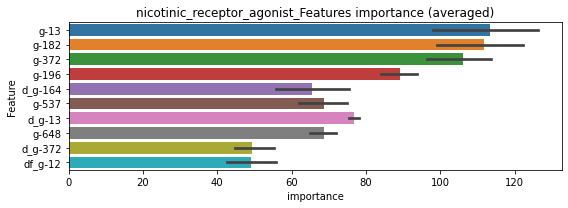

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00983001	valid_1's binary_logloss: 0.015902
[200]	training's binary_logloss: 0.000932456	valid_1's binary_logloss: 0.00556139
Early stopping, best iteration is:
[279]	training's binary_logloss: 0.00030641	valid_1's binary_logloss: 0.00485282


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101024	valid_1's binary_logloss: 0.0128966
[200]	training's binary_logloss: 0.000988547	valid_1's binary_logloss: 0.00265708
[300]	training's binary_logloss: 0.000275609	valid_1's binary_logloss: 0.00171583
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.000183156	valid_1's binary_logloss: 0.00165186


nicotinic_receptor_agonist logloss: 0.0032523366542450793


neg labels: 3289 → selected neg labels: 3285


nitric_oxide_donor, len(trt): 26, len(othr): 3285, target_rate: 0.0010918 → Adj_target_rate: 0.0013394
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289651	valid_1's binary_logloss: 0.0461221
[200]	training's binary_logloss: 0.00385304	valid_1's binary_logloss: 0.0109206
[300]	training's binary_logloss: 0.0010794	valid_1's binary_logloss: 0.0048792
[400]	training's binary_logloss: 0.00053747	valid_1's binary_logloss: 0.00344062
[500]	training's binary_logloss: 0.000389556	valid_1's binary_logloss: 0.00293298
Early stopping, best iteration is:
[539]	training's binary_logloss: 0.000375395	valid_1's binary_logloss: 0.0028742
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0291249	valid_1's binary_logloss: 0.0399458
[200]	training's binary_logloss: 0.00402634	valid_1's binary_logloss: 0.00893417
[300]	training's binary_logloss: 0.00109508	valid_1's binary_logloss: 0.00342228
[400]	training's binary_logloss: 0.000545967	valid_1's binary_logloss: 0.00208903
[500]	training's binary_logloss: 0.000

1 / 3 AUC score:1.000
y_Threshold: 0.0022436, Threshold: 0.0037320, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00109
Num_p_label: 80.0, conf_0:0.00336, conf_1:0.00411
Num_p_label: 80.0, Expected: 4.3, Adj_threshold_1: 0.0037320
Num_p_label: 10.0, Expected: 4.3, Adj_threshold_2: 0.0137320
Num_p_label: 6.0, Expected: 4.3, Adj_threshold_3: 0.0237320
threshold: 0.0237320, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0278612	valid_1's binary_logloss: 0.0425837
[200]	training's binary_logloss: 0.00372549	valid_1's binary_logloss: 0.00999991
[300]	training's binary_logloss: 0.00104104	valid_1's binary_logloss: 0.00409021
[400]	training's binary_logloss: 0.000528846	valid_1's binary_logloss: 0.0029128
[500]	training's binary_logloss: 0.000386394	valid_1's binary_logloss: 0.00244451
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.000389121	valid_1's binary_logloss: 0.00243826
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286381	valid_1's binary_logloss: 0.0394762
[200]	training's binary_logloss: 0.00379239	valid_1's binary_logloss: 0.00820619
[300]	training's binary_logloss: 0.0010603	valid_1's binary_logloss: 0.00337021
[400]	training's binary_logloss: 0.000536807	valid_1's binary_logloss: 0.00213194
[500]	training's binary_logloss: 0.

2 / 3 AUC score:1.000
y_Threshold: 0.0689241, Threshold: 0.0237320, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0032647 Vs.target_rate: 0.00109
Num_p_label: 13.0, conf_0:0.02136, conf_1:0.02611
threshold: 0.0237320, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0278612	valid_1's binary_logloss: 0.0425837
[200]	training's binary_logloss: 0.00372549	valid_1's binary_logloss: 0.00999991
[300]	training's binary_logloss: 0.00104104	valid_1's binary_logloss: 0.00409021
[400]	training's binary_logloss: 0.000528846	valid_1's binary_logloss: 0.0029128
[500]	training's binary_logloss: 0.000386394	valid_1's binary_logloss: 0.00244451
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.000389121	valid_1's binary_logloss: 0.00243826
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286381	valid_1's binary_logloss: 0.0394762
[200]	training's binary_logloss: 0.00379239	valid_1's binary_logloss: 0.00820619
[300]	training's binary_logloss: 0.0010603	valid_1's binary_logloss: 0.00337021
[400]	training's binary_logloss: 0.000536807	valid_1's binary_logloss: 0.00213194
[500]	training's binary_logloss: 0.

3 / 3 AUC score:1.000
y_Threshold: 0.0689241, Threshold: 0.0237320, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0032647 Vs.target_rate: 0.00109
Num_p_label: 13.0, conf_0:0.02136, conf_1:0.02611
threshold: 0.0237320, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 670.0/7792, y_label_rate: 0.0859856


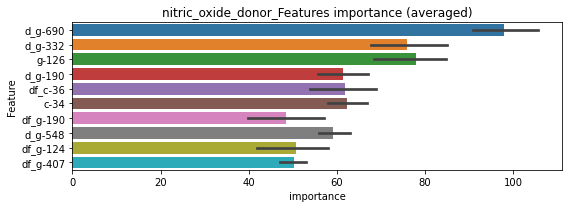

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 nitric_oxide_donor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161477	valid_1's binary_logloss: 0.0298194
[200]	training's binary_logloss: 0.00214031	valid_1's binary_logloss: 0.0142104
[300]	training's binary_logloss: 0.000584635	valid_1's binary_logloss: 0.0122817
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.000579259	valid_1's binary_logloss: 0.0122762


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 nitric_oxide_donor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0169565	valid_1's binary_logloss: 0.0264432
[200]	training's binary_logloss: 0.0023584	valid_1's binary_logloss: 0.00973327
[300]	training's binary_logloss: 0.0006497	valid_1's binary_logloss: 0.00753815
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.000599934	valid_1's binary_logloss: 0.00742907


nitric_oxide_donor logloss: 0.00985265400338597


neg labels: 3289 → selected neg labels: 3284


nitric_oxide_production_inhibitor, len(trt): 29, len(othr): 3284, target_rate: 0.0012178 → Adj_target_rate: 0.0014697
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0341728	valid_1's binary_logloss: 0.064126
[200]	training's binary_logloss: 0.00484468	valid_1's binary_logloss: 0.0221917
[300]	training's binary_logloss: 0.00128435	valid_1's binary_logloss: 0.0127483
[400]	training's binary_logloss: 0.000626406	valid_1's binary_logloss: 0.0100142
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000466925	valid_1's binary_logloss: 0.0093474
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0329113	valid_1's binary_logloss: 0.0509404
[200]	training's binary_logloss: 0.00477444	valid_1's binary_logloss: 0.013673
[300]	training's binary_logloss: 0.00129437	valid_1's binary_logloss: 0.00584508
[400]	training's binary_logloss: 0.000631248	valid_1's binary_logloss: 0.00367093
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.000466467	valid_1's binary_logloss: 0.00321071


1 / 3 AUC score:1.000
y_Threshold: 0.0027869, Threshold: 0.0628049, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00122
Num_p_label: 80.0, conf_0:0.05652, conf_1:0.06909
Num_p_label: 80.0, Expected: 4.8, Adj_threshold_1: 0.0628049
Num_p_label: 71.0, Expected: 4.8, Adj_threshold_2: 0.0728049
Num_p_label: 65.0, Expected: 4.8, Adj_threshold_3: 0.0828049
Num_p_label: 61.0, Expected: 4.8, Adj_threshold_4: 0.0928049
Num_p_label: 59.0, Expected: 4.8, Adj_threshold_5: 0.1028049
Num_p_label: 53.0, Expected: 4.8, Adj_threshold_6: 0.1128049
Num_p_label: 49.0, Expected: 4.8, Adj_threshold_7: 0.1228049
Num_p_label: 48.0, Expected: 4.8, Adj_threshold_8: 0.1328049
Num_p_label: 45.0, Expected: 4.8, Adj_threshold_9: 0.1428049
Num_p_label: 44.0, Expected: 4.8, Adj_threshold_10: 0.1528049
threshold: 0.1628049, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03291	valid_1's binary_logloss: 0.0567745
[200]	training's binary_logloss: 0.00458474	valid_1's binary_logloss: 0.01843
[300]	training's binary_logloss: 0.00124145	valid_1's binary_logloss: 0.0111061
[400]	training's binary_logloss: 0.000607011	valid_1's binary_logloss: 0.00933897
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.000444689	valid_1's binary_logloss: 0.00863573
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0322859	valid_1's binary_logloss: 0.0493021
[200]	training's binary_logloss: 0.0043952	valid_1's binary_logloss: 0.0116194
[300]	training's binary_logloss: 0.00121161	valid_1's binary_logloss: 0.00523611
[400]	training's binary_logloss: 0.000595353	valid_1's binary_logloss: 0.00343889
[500]	training's binary_logloss: 0.000430094	valid_1's binary_logloss: 0.00302985
Early stopping, best iteration is:
[494]	

2 / 3 AUC score:1.000
y_Threshold: 0.0461031, Threshold: 0.1628049, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 654.0/3804
p_label_rate: 0.0276243 Vs.target_rate: 0.00122
Num_p_label: 110.0, conf_0:0.14652, conf_1:0.17909
Num_p_label: 110.0, Expected: 4.8, Adj_threshold_1: 0.1628049
Num_p_label: 108.0, Expected: 4.8, Adj_threshold_2: 0.1728049
Num_p_label: 108.0, Expected: 4.8, Adj_threshold_3: 0.1828049
Num_p_label: 106.0, Expected: 4.8, Adj_threshold_4: 0.1928049
Num_p_label: 104.0, Expected: 4.8, Adj_threshold_5: 0.2028049
Num_p_label: 102.0, Expected: 4.8, Adj_threshold_6: 0.2128049
Num_p_label: 101.0, Expected: 4.8, Adj_threshold_7: 0.2228049
Num_p_label: 98.0, Expected: 4.8, Adj_threshold_8: 0.2328049
Num_p_label: 96.0, Expected: 4.8, Adj_threshold_9: 0.2428049
Num_p_label: 96.0, Expected: 4.8, Adj_threshold_10: 0.2528049
threshold: 0.2628049, positive_p_label: 96.0/3982, p_label_rate: 0.0241085
positive_y_label: 654.0/3804, y_label_rate: 0.1719243
=

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0327833	valid_1's binary_logloss: 0.0482943
[200]	training's binary_logloss: 0.00455442	valid_1's binary_logloss: 0.0120406
[300]	training's binary_logloss: 0.0012561	valid_1's binary_logloss: 0.00564977
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.000963857	valid_1's binary_logloss: 0.004797
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0317378	valid_1's binary_logloss: 0.0523142
[200]	training's binary_logloss: 0.00427862	valid_1's binary_logloss: 0.014649
[300]	training's binary_logloss: 0.00117669	valid_1's binary_logloss: 0.00827254
[400]	training's binary_logloss: 0.000583836	valid_1's binary_logloss: 0.00669843
Early stopping, best iteration is:
[429]	training's binary_logloss: 0.000510062	valid_1's binary_logloss: 0.0065829


3 / 3 AUC score:1.000
y_Threshold: 0.0590627, Threshold: 0.2628049, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 653.0/3802
p_label_rate: 0.0251130 Vs.target_rate: 0.00122
Num_p_label: 100.0, conf_0:0.23652, conf_1:0.28909
Num_p_label: 100.0, Expected: 4.8, Adj_threshold_1: 0.2628049
Num_p_label: 98.0, Expected: 4.8, Adj_threshold_2: 0.2728049
Num_p_label: 97.0, Expected: 4.8, Adj_threshold_3: 0.2828049
Num_p_label: 96.0, Expected: 4.8, Adj_threshold_4: 0.2928049
Num_p_label: 93.0, Expected: 4.8, Adj_threshold_5: 0.3028049
Num_p_label: 93.0, Expected: 4.8, Adj_threshold_6: 0.3128049
Num_p_label: 93.0, Expected: 4.8, Adj_threshold_7: 0.3228049
Num_p_label: 92.0, Expected: 4.8, Adj_threshold_8: 0.3328049
Num_p_label: 90.0, Expected: 4.8, Adj_threshold_9: 0.3428049
Num_p_label: 89.0, Expected: 4.8, Adj_threshold_10: 0.3528049
threshold: 0.3628049, positive_p_label: 86.0/3982, p_label_rate: 0.0215972
positive_y_label: 739.0/7784, y_label_rate: 0.0949383


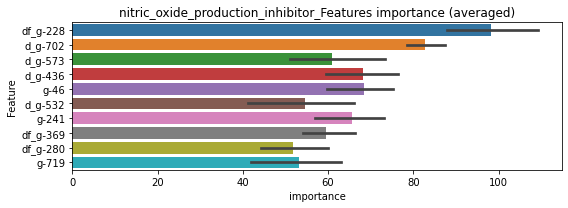

len(train_index) : 3892
len(valid_index) : 3892
================================= fold 1/2 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0210424	valid_1's binary_logloss: 0.0384834
[200]	training's binary_logloss: 0.00319994	valid_1's binary_logloss: 0.015156
[300]	training's binary_logloss: 0.000892815	valid_1's binary_logloss: 0.0111904
[400]	training's binary_logloss: 0.000424737	valid_1's binary_logloss: 0.0101332
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.000417852	valid_1's binary_logloss: 0.0101003


len(train_index) : 3892
len(valid_index) : 3892
================================= fold 2/2 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212172	valid_1's binary_logloss: 0.0375598
[200]	training's binary_logloss: 0.00325613	valid_1's binary_logloss: 0.0145531
[300]	training's binary_logloss: 0.000881794	valid_1's binary_logloss: 0.010797
Early stopping, best iteration is:
[373]	training's binary_logloss: 0.000486129	valid_1's binary_logloss: 0.0100545


nitric_oxide_production_inhibitor logloss: 0.01007740755909273


neg labels: 3289 → selected neg labels: 3284


nitric_oxide_synthase_inhibitor, len(trt): 26, len(othr): 3284, target_rate: 0.0010918 → Adj_target_rate: 0.0013394
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295427	valid_1's binary_logloss: 0.0485862
[200]	training's binary_logloss: 0.00397496	valid_1's binary_logloss: 0.0166653
[300]	training's binary_logloss: 0.00111561	valid_1's binary_logloss: 0.0115613
[400]	training's binary_logloss: 0.000561528	valid_1's binary_logloss: 0.0101203
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.00056417	valid_1's binary_logloss: 0.0101043
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0300185	valid_1's binary_logloss: 0.047875
[200]	training's binary_logloss: 0.00408942	valid_1's binary_logloss: 0.0142948
[300]	training's binary_logloss: 0.00111907	valid_1's binary_logloss: 0.00806373
[400]	training's binary_logloss: 0.000559542	valid_1's binary_logloss: 0.00649853
[500]	training's binary_logloss: 0.000399455	valid_1's binary_logloss: 0.00578365
Early stopping, best iteration is:
[521]

1 / 3 AUC score:1.000
y_Threshold: 0.0030574, Threshold: 0.0043714, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00109
Num_p_label: 80.0, conf_0:0.00393, conf_1:0.00481
Num_p_label: 80.0, Expected: 4.3, Adj_threshold_1: 0.0043714
Num_p_label: 8.0, Expected: 4.3, Adj_threshold_2: 0.0143714
threshold: 0.0143714, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283514	valid_1's binary_logloss: 0.0465573
[200]	training's binary_logloss: 0.00375405	valid_1's binary_logloss: 0.0165218
[300]	training's binary_logloss: 0.0010573	valid_1's binary_logloss: 0.0118899
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.000838224	valid_1's binary_logloss: 0.011203
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295706	valid_1's binary_logloss: 0.0467787
[200]	training's binary_logloss: 0.00392451	valid_1's binary_logloss: 0.0132932
[300]	training's binary_logloss: 0.00109072	valid_1's binary_logloss: 0.00805359
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.000752206	valid_1's binary_logloss: 0.00699471


2 / 3 AUC score:1.000
y_Threshold: 0.0236620, Threshold: 0.0143714, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0118031 Vs.target_rate: 0.00109
Num_p_label: 47.0, conf_0:0.01293, conf_1:0.01581
Num_p_label: 47.0, Expected: 4.3, Adj_threshold_1: 0.0143714
Num_p_label: 19.0, Expected: 4.3, Adj_threshold_2: 0.0243714
Num_p_label: 13.0, Expected: 4.3, Adj_threshold_3: 0.0343714
Num_p_label: 11.0, Expected: 4.3, Adj_threshold_4: 0.0443714
Num_p_label: 9.0, Expected: 4.3, Adj_threshold_5: 0.0543714
Num_p_label: 4.0, Expected: 4.3, Adj_threshold_6: 0.0643714
threshold: 0.0643714, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 655.0/3806, y_label_rate: 0.1720967
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.029121	valid_1's binary_logloss: 0.0458097
[200]	training's binary_logloss: 0.00389387	valid_1's binary_logloss: 0.0116511
[300]	training's binary_logloss: 0.00109438	valid_1's binary_logloss: 0.0055333
[400]	training's binary_logloss: 0.000551916	valid_1's binary_logloss: 0.00397332
[500]	training's binary_logloss: 0.000399179	valid_1's binary_logloss: 0.00343142
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.000391945	valid_1's binary_logloss: 0.00338994
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290129	valid_1's binary_logloss: 0.0414165
[200]	training's binary_logloss: 0.0039013	valid_1's binary_logloss: 0.00909157
[300]	training's binary_logloss: 0.0010919	valid_1's binary_logloss: 0.0037942
[400]	training's binary_logloss: 0.000550292	valid_1's binary_logloss: 0.00249016
[500]	training's binary_logloss: 0.0004

3 / 3 AUC score:1.000
y_Threshold: 0.0545330, Threshold: 0.0643714, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0002511 Vs.target_rate: 0.00109
Num_p_label: 1.0, conf_0:0.05793, conf_1:0.07081
Num_p_label: 1.0, Expected: 4.3, Adj_threshold_1: 0.0643714
Num_p_label: 2.0, Expected: 4.3, Adj_threshold_2: 0.0543714
Num_p_label: 3.0, Expected: 4.3, Adj_threshold_3: 0.0443714
threshold: 0.0443714, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 658.0/7788, y_label_rate: 0.0844890


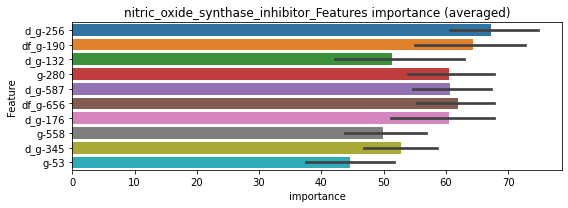

len(train_index) : 3894
len(valid_index) : 3894
================================= fold 1/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0170619	valid_1's binary_logloss: 0.0272116
[200]	training's binary_logloss: 0.00223114	valid_1's binary_logloss: 0.00799808
[300]	training's binary_logloss: 0.000587766	valid_1's binary_logloss: 0.00512658
[400]	training's binary_logloss: 0.000285802	valid_1's binary_logloss: 0.00448268
Early stopping, best iteration is:
[422]	training's binary_logloss: 0.000257005	valid_1's binary_logloss: 0.00440606


len(train_index) : 3894
len(valid_index) : 3894
================================= fold 2/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165893	valid_1's binary_logloss: 0.0247956
[200]	training's binary_logloss: 0.00222341	valid_1's binary_logloss: 0.00680748
[300]	training's binary_logloss: 0.000591108	valid_1's binary_logloss: 0.00411654
[400]	training's binary_logloss: 0.000287039	valid_1's binary_logloss: 0.00354287
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000223973	valid_1's binary_logloss: 0.00344043


nitric_oxide_synthase_inhibitor logloss: 0.0039232463410376825


neg labels: 3289 → selected neg labels: 3287


norepinephrine_reuptake_inhibitor, len(trt): 7, len(othr): 3287, target_rate: 0.0002939 → Adj_target_rate: 0.0004391
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016356	valid_1's binary_logloss: 0.0179848
[200]	training's binary_logloss: 0.00141254	valid_1's binary_logloss: 0.00172588
[300]	training's binary_logloss: 0.000383887	valid_1's binary_logloss: 0.000501561
[400]	training's binary_logloss: 0.00023151	valid_1's binary_logloss: 0.000310548
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.000208338	valid_1's binary_logloss: 0.00028142
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0166	valid_1's binary_logloss: 0.0180276
[200]	training's binary_logloss: 0.0014248	valid_1's binary_logloss: 0.00178946
[300]	training's binary_logloss: 0.000384497	valid_1's binary_logloss: 0.00054203
[400]	training's binary_logloss: 0.00023073	valid_1's binary_logloss: 0.000340479
[500]	training's binary_logloss: 0.000205275	valid_1's binary_logloss: 0.000304113
Early stopping, best iteration is:

1 / 3 AUC score:1.000
y_Threshold: 0.0005955, Threshold: 0.0009506, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00029
Num_p_label: 80.0, conf_0:0.00086, conf_1:0.00105
Num_p_label: 80.0, Expected: 1.2, Adj_threshold_1: 0.0009506
Num_p_label: 2.0, Expected: 1.2, Adj_threshold_2: 0.0109506
threshold: 0.0109506, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165343	valid_1's binary_logloss: 0.0189262
[200]	training's binary_logloss: 0.00139747	valid_1's binary_logloss: 0.00291106
[300]	training's binary_logloss: 0.000380179	valid_1's binary_logloss: 0.00133184
[400]	training's binary_logloss: 0.000230408	valid_1's binary_logloss: 0.00102526
[500]	training's binary_logloss: 0.000204011	valid_1's binary_logloss: 0.000974415
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.000202057	valid_1's binary_logloss: 0.000972154
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165135	valid_1's binary_logloss: 0.017793
[200]	training's binary_logloss: 0.00140632	valid_1's binary_logloss: 0.00161338
[300]	training's binary_logloss: 0.000379009	valid_1's binary_logloss: 0.000453577
[400]	training's binary_logloss: 0.000229653	valid_1's binary_logloss: 0.000280579
[500]	training's binary_logl

2 / 3 AUC score:1.000
y_Threshold: 0.0619119, Threshold: 0.0109506, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0042692 Vs.target_rate: 0.00029
Num_p_label: 17.0, conf_0:0.00986, conf_1:0.01205
Num_p_label: 17.0, Expected: 1.2, Adj_threshold_1: 0.0109506
Num_p_label: 7.0, Expected: 1.2, Adj_threshold_2: 0.0209506
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_3: 0.0309506
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_4: 0.0409506
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_5: 0.0509506
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_6: 0.0609506
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_7: 0.0709506
Num_p_label: 2.0, Expected: 1.2, Adj_threshold_8: 0.0809506
threshold: 0.0809506, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165343	valid_1's binary_logloss: 0.0189262
[200]	training's binary_logloss: 0.00139747	valid_1's binary_logloss: 0.00291106
[300]	training's binary_logloss: 0.000380179	valid_1's binary_logloss: 0.00133184
[400]	training's binary_logloss: 0.000230408	valid_1's binary_logloss: 0.00102526
[500]	training's binary_logloss: 0.000204011	valid_1's binary_logloss: 0.000974415
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.000202057	valid_1's binary_logloss: 0.000972154
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165135	valid_1's binary_logloss: 0.017793
[200]	training's binary_logloss: 0.00140632	valid_1's binary_logloss: 0.00161338
[300]	training's binary_logloss: 0.000379009	valid_1's binary_logloss: 0.000453577
[400]	training's binary_logloss: 0.000229653	valid_1's binary_logloss: 0.000280579
[500]	training's binary_logl

3 / 3 AUC score:1.000
y_Threshold: 0.0619119, Threshold: 0.0809506, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0005023 Vs.target_rate: 0.00029
Num_p_label: 2.0, conf_0:0.07286, conf_1:0.08905
threshold: 0.0809506, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 659.0/7794, y_label_rate: 0.0845522


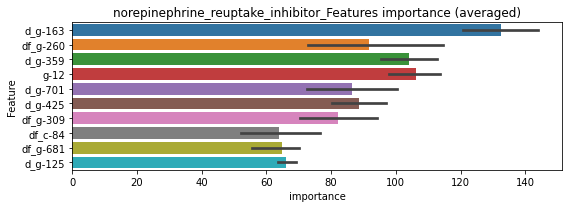

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00874884	valid_1's binary_logloss: 0.0107342
[200]	training's binary_logloss: 0.000723918	valid_1's binary_logloss: 0.00209982
[300]	training's binary_logloss: 0.000190842	valid_1's binary_logloss: 0.00144172
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000141372	valid_1's binary_logloss: 0.00139632


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00873327	valid_1's binary_logloss: 0.00990902
[200]	training's binary_logloss: 0.000727131	valid_1's binary_logloss: 0.00157277
Early stopping, best iteration is:
[271]	training's binary_logloss: 0.000255526	valid_1's binary_logloss: 0.00114486


norepinephrine_reuptake_inhibitor logloss: 0.0012705890792943525


neg labels: 3289 → selected neg labels: 3286


nrf2_activator, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203689	valid_1's binary_logloss: 0.0263609
[200]	training's binary_logloss: 0.00218703	valid_1's binary_logloss: 0.00684871
[300]	training's binary_logloss: 0.000608268	valid_1's binary_logloss: 0.00479139
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.000427081	valid_1's binary_logloss: 0.0042888
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0202258	valid_1's binary_logloss: 0.0257999
[200]	training's binary_logloss: 0.00215058	valid_1's binary_logloss: 0.00505847
[300]	training's binary_logloss: 0.000606372	valid_1's binary_logloss: 0.00284229
[400]	training's binary_logloss: 0.000332568	valid_1's binary_logloss: 0.0021714
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.000316352	valid_1's binary_logloss: 0.00213903


1 / 3 AUC score:1.000
y_Threshold: 0.0012363, Threshold: 0.1135410, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.10219, conf_1:0.12490
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.1135410
Num_p_label: 79.0, Expected: 3.0, Adj_threshold_2: 0.1235410
Num_p_label: 79.0, Expected: 3.0, Adj_threshold_3: 0.1335410
Num_p_label: 78.0, Expected: 3.0, Adj_threshold_4: 0.1435410
Num_p_label: 76.0, Expected: 3.0, Adj_threshold_5: 0.1535410
Num_p_label: 76.0, Expected: 3.0, Adj_threshold_6: 0.1635410
Num_p_label: 74.0, Expected: 3.0, Adj_threshold_7: 0.1735410
Num_p_label: 74.0, Expected: 3.0, Adj_threshold_8: 0.1835410
Num_p_label: 74.0, Expected: 3.0, Adj_threshold_9: 0.1935410
Num_p_label: 72.0, Expected: 3.0, Adj_threshold_10: 0.2035410
threshold: 0.2135410, positive_p_label: 71.0/3982, p_label_rate: 0.0178302
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195904	valid_1's binary_logloss: 0.0232326
[200]	training's binary_logloss: 0.00193014	valid_1's binary_logloss: 0.00300023
[300]	training's binary_logloss: 0.000525988	valid_1's binary_logloss: 0.00104407
[400]	training's binary_logloss: 0.000294791	valid_1's binary_logloss: 0.000667062
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000261178	valid_1's binary_logloss: 0.00061045
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195595	valid_1's binary_logloss: 0.0241088
[200]	training's binary_logloss: 0.00192988	valid_1's binary_logloss: 0.00357747
[300]	training's binary_logloss: 0.000528698	valid_1's binary_logloss: 0.00140339
[400]	training's binary_logloss: 0.000300011	valid_1's binary_logloss: 0.00094135
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.000265395	valid_1's binary_logloss: 0.0008

2 / 3 AUC score:1.000
y_Threshold: 0.1296502, Threshold: 0.2135410, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0296334 Vs.target_rate: 0.00076
Num_p_label: 118.0, conf_0:0.19219, conf_1:0.23490
Num_p_label: 118.0, Expected: 3.0, Adj_threshold_1: 0.2135410
Num_p_label: 116.0, Expected: 3.0, Adj_threshold_2: 0.2235410
Num_p_label: 115.0, Expected: 3.0, Adj_threshold_3: 0.2335410
Num_p_label: 114.0, Expected: 3.0, Adj_threshold_4: 0.2435410
Num_p_label: 113.0, Expected: 3.0, Adj_threshold_5: 0.2535410
Num_p_label: 112.0, Expected: 3.0, Adj_threshold_6: 0.2635410
Num_p_label: 112.0, Expected: 3.0, Adj_threshold_7: 0.2735410
Num_p_label: 112.0, Expected: 3.0, Adj_threshold_8: 0.2835410
Num_p_label: 111.0, Expected: 3.0, Adj_threshold_9: 0.2935410
Num_p_label: 108.0, Expected: 3.0, Adj_threshold_10: 0.3035410
threshold: 0.3135410, positive_p_label: 106.0/3982, p_label_rate: 0.0266198
positive_y_label: 657.0/3811, y_label_rate: 0.17239

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195904	valid_1's binary_logloss: 0.0232326
[200]	training's binary_logloss: 0.00193014	valid_1's binary_logloss: 0.00300023
[300]	training's binary_logloss: 0.000525988	valid_1's binary_logloss: 0.00104407
[400]	training's binary_logloss: 0.000294791	valid_1's binary_logloss: 0.000667062
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000261178	valid_1's binary_logloss: 0.00061045
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195595	valid_1's binary_logloss: 0.0241088
[200]	training's binary_logloss: 0.00192988	valid_1's binary_logloss: 0.00357747
[300]	training's binary_logloss: 0.000528698	valid_1's binary_logloss: 0.00140339
[400]	training's binary_logloss: 0.000300011	valid_1's binary_logloss: 0.00094135
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.000265395	valid_1's binary_logloss: 0.0008

3 / 3 AUC score:1.000
y_Threshold: 0.1296502, Threshold: 0.3135410, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0266198 Vs.target_rate: 0.00076
Num_p_label: 106.0, conf_0:0.28219, conf_1:0.34490
Num_p_label: 106.0, Expected: 3.0, Adj_threshold_1: 0.3135410
Num_p_label: 104.0, Expected: 3.0, Adj_threshold_2: 0.3235410
Num_p_label: 104.0, Expected: 3.0, Adj_threshold_3: 0.3335410
Num_p_label: 104.0, Expected: 3.0, Adj_threshold_4: 0.3435410
Num_p_label: 104.0, Expected: 3.0, Adj_threshold_5: 0.3535410
Num_p_label: 104.0, Expected: 3.0, Adj_threshold_6: 0.3635410
Num_p_label: 104.0, Expected: 3.0, Adj_threshold_7: 0.3735410
Num_p_label: 103.0, Expected: 3.0, Adj_threshold_8: 0.3835410
Num_p_label: 103.0, Expected: 3.0, Adj_threshold_9: 0.3935410
Num_p_label: 103.0, Expected: 3.0, Adj_threshold_10: 0.4035410
threshold: 0.4135410, positive_p_label: 103.0/3982, p_label_rate: 0.0258664
positive_y_label: 760.0/7793, y_label_rate: 0.09752

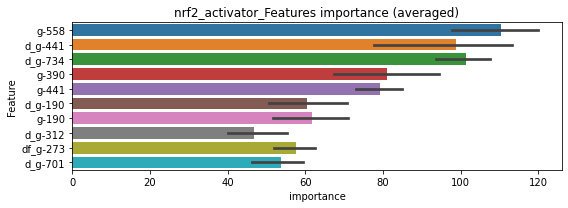

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 nrf2_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0129169	valid_1's binary_logloss: 0.0199384
[200]	training's binary_logloss: 0.00140329	valid_1's binary_logloss: 0.00694466
[300]	training's binary_logloss: 0.000392036	valid_1's binary_logloss: 0.00595935
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.000323648	valid_1's binary_logloss: 0.00580109


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 nrf2_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0131505	valid_1's binary_logloss: 0.0188605
[200]	training's binary_logloss: 0.00146568	valid_1's binary_logloss: 0.00586888
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.000489152	valid_1's binary_logloss: 0.00500626


nrf2_activator logloss: 0.005403723248404581


neg labels: 3289 → selected neg labels: 3279


opioid_receptor_agonist, len(trt): 61, len(othr): 3279, target_rate: 0.0025615 → Adj_target_rate: 0.0027652
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0527132	valid_1's binary_logloss: 0.105615
[200]	training's binary_logloss: 0.0103011	valid_1's binary_logloss: 0.0555259
[300]	training's binary_logloss: 0.00292257	valid_1's binary_logloss: 0.0440511
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.00170328	valid_1's binary_logloss: 0.0405182
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0524402	valid_1's binary_logloss: 0.0958403
[200]	training's binary_logloss: 0.0106958	valid_1's binary_logloss: 0.0414443
[300]	training's binary_logloss: 0.00298331	valid_1's binary_logloss: 0.0268949
[400]	training's binary_logloss: 0.00132394	valid_1's binary_logloss: 0.0228074
[500]	training's binary_logloss: 0.000802435	valid_1's binary_logloss: 0.0214623
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.000824292	valid_1's binary_logloss: 0.0214362


1 / 3 AUC score:0.998
y_Threshold: 0.0099810, Threshold: 0.0138747, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 144 → Positive_corect_labels: 649/3790
p_label_rate: 0.0200904 Vs.target_rate: 0.00256
Num_p_label: 80.0, conf_0:0.01249, conf_1:0.01526
Num_p_label: 80.0, Expected: 10.2, Adj_threshold_1: 0.0138747
Num_p_label: 33.0, Expected: 10.2, Adj_threshold_2: 0.0238747
Num_p_label: 15.0, Expected: 10.2, Adj_threshold_3: 0.0338747
threshold: 0.0338747, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 649.0/3790, y_label_rate: 0.1712401
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0492264	valid_1's binary_logloss: 0.0888368
[200]	training's binary_logloss: 0.00939702	valid_1's binary_logloss: 0.0418761
[300]	training's binary_logloss: 0.00273131	valid_1's binary_logloss: 0.0317585
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.00209791	valid_1's binary_logloss: 0.0306797
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0486618	valid_1's binary_logloss: 0.0900454
[200]	training's binary_logloss: 0.00970411	valid_1's binary_logloss: 0.0418257
[300]	training's binary_logloss: 0.00273557	valid_1's binary_logloss: 0.0295628
[400]	training's binary_logloss: 0.00123127	valid_1's binary_logloss: 0.0264265
Early stopping, best iteration is:
[473]	training's binary_logloss: 0.000844116	valid_1's binary_logloss: 0.0250156


2 / 3 AUC score:0.999
y_Threshold: 0.0496886, Threshold: 0.0338747, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 18 → Positive_corect_labels: 640.0/3772
p_label_rate: 0.0123054 Vs.target_rate: 0.00256
Num_p_label: 49.0, conf_0:0.03049, conf_1:0.03726
Num_p_label: 49.0, Expected: 10.2, Adj_threshold_1: 0.0338747
Num_p_label: 30.0, Expected: 10.2, Adj_threshold_2: 0.0438747
Num_p_label: 17.0, Expected: 10.2, Adj_threshold_3: 0.0538747
threshold: 0.0538747, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 640.0/3772, y_label_rate: 0.1696713
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0474915	valid_1's binary_logloss: 0.0993546
[200]	training's binary_logloss: 0.00879251	valid_1's binary_logloss: 0.0502434
[300]	training's binary_logloss: 0.00250008	valid_1's binary_logloss: 0.0411336
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00262604	valid_1's binary_logloss: 0.0410008
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0478174	valid_1's binary_logloss: 0.0881668
[200]	training's binary_logloss: 0.00886609	valid_1's binary_logloss: 0.0379415
[300]	training's binary_logloss: 0.00253125	valid_1's binary_logloss: 0.0282042
[400]	training's binary_logloss: 0.00117242	valid_1's binary_logloss: 0.0264437
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.001103	valid_1's binary_logloss: 0.0262951


3 / 3 AUC score:0.998
y_Threshold: 0.0317457, Threshold: 0.0538747, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → Positive_corect_labels: 632.0/3756
p_label_rate: 0.0062783 Vs.target_rate: 0.00256
Num_p_label: 25.0, conf_0:0.04849, conf_1:0.05926
threshold: 0.0538747, positive_p_label: 25.0/3982, p_label_rate: 0.0062783
positive_y_label: 657.0/7738, y_label_rate: 0.0849057


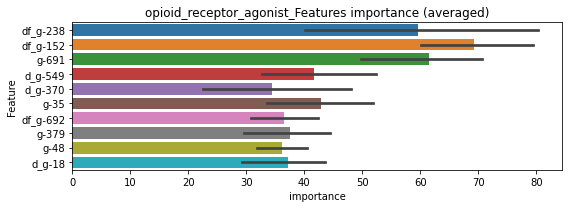

len(train_index) : 3869
len(valid_index) : 3869
================================= fold 1/2 opioid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261948	valid_1's binary_logloss: 0.062807
[200]	training's binary_logloss: 0.00511158	valid_1's binary_logloss: 0.041162
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00241835	valid_1's binary_logloss: 0.0385472


len(train_index) : 3869
len(valid_index) : 3869
================================= fold 2/2 opioid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0273576	valid_1's binary_logloss: 0.0527135
[200]	training's binary_logloss: 0.00553886	valid_1's binary_logloss: 0.0247662
[300]	training's binary_logloss: 0.00156024	valid_1's binary_logloss: 0.0177925
[400]	training's binary_logloss: 0.000687146	valid_1's binary_logloss: 0.0161871
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.0004429	valid_1's binary_logloss: 0.0154628


opioid_receptor_agonist logloss: 0.027005017383644497


neg labels: 3289 → selected neg labels: 3275


opioid_receptor_antagonist, len(trt): 96, len(othr): 3275, target_rate: 0.0040312 → Adj_target_rate: 0.0040656
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0642397	valid_1's binary_logloss: 0.130246
[200]	training's binary_logloss: 0.0154853	valid_1's binary_logloss: 0.0746138
[300]	training's binary_logloss: 0.0045368	valid_1's binary_logloss: 0.0596904
[400]	training's binary_logloss: 0.00198534	valid_1's binary_logloss: 0.0547502
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.00146206	valid_1's binary_logloss: 0.0538627
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0623038	valid_1's binary_logloss: 0.144513
[200]	training's binary_logloss: 0.0148386	valid_1's binary_logloss: 0.0978693
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00520853	valid_1's binary_logloss: 0.0892183


1 / 3 AUC score:0.990
y_Threshold: 0.0207168, Threshold: 0.0299860, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 181 → Positive_corect_labels: 630/3749
p_label_rate: 0.0200904 Vs.target_rate: 0.00403
Num_p_label: 80.0, conf_0:0.02699, conf_1:0.03298
Num_p_label: 80.0, Expected: 16.1, Adj_threshold_1: 0.0299860
Num_p_label: 50.0, Expected: 16.1, Adj_threshold_2: 0.0399860
Num_p_label: 25.0, Expected: 16.1, Adj_threshold_3: 0.0499860
threshold: 0.0499860, positive_p_label: 25.0/3982, p_label_rate: 0.0062783
positive_y_label: 630.0/3749, y_label_rate: 0.1680448
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0555584	valid_1's binary_logloss: 0.132547
[200]	training's binary_logloss: 0.0117529	valid_1's binary_logloss: 0.0847202
[300]	training's binary_logloss: 0.00361488	valid_1's binary_logloss: 0.0710882
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.00187521	valid_1's binary_logloss: 0.0680108
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0582783	valid_1's binary_logloss: 0.124275
[200]	training's binary_logloss: 0.0124841	valid_1's binary_logloss: 0.0747243
[300]	training's binary_logloss: 0.00378913	valid_1's binary_logloss: 0.0633335
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.00415465	valid_1's binary_logloss: 0.0631633


2 / 3 AUC score:0.996
y_Threshold: 0.0441403, Threshold: 0.0499860, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 44 → Positive_corect_labels: 608.0/3705
p_label_rate: 0.0163235 Vs.target_rate: 0.00403
Num_p_label: 65.0, conf_0:0.04499, conf_1:0.05498
Num_p_label: 65.0, Expected: 16.1, Adj_threshold_1: 0.0499860
Num_p_label: 36.0, Expected: 16.1, Adj_threshold_2: 0.0599860
Num_p_label: 29.0, Expected: 16.1, Adj_threshold_3: 0.0699860
threshold: 0.0699860, positive_p_label: 29.0/3982, p_label_rate: 0.0072828
positive_y_label: 608.0/3705, y_label_rate: 0.1641026
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0535857	valid_1's binary_logloss: 0.129455
[200]	training's binary_logloss: 0.0113564	valid_1's binary_logloss: 0.0804077
[300]	training's binary_logloss: 0.00334647	valid_1's binary_logloss: 0.0684293
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00178161	valid_1's binary_logloss: 0.0650038
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0562256	valid_1's binary_logloss: 0.121069
[200]	training's binary_logloss: 0.0122225	valid_1's binary_logloss: 0.06822
[300]	training's binary_logloss: 0.00358769	valid_1's binary_logloss: 0.054961
Early stopping, best iteration is:
[367]	training's binary_logloss: 0.00202483	valid_1's binary_logloss: 0.0521838


3 / 3 AUC score:0.998
y_Threshold: 0.0415594, Threshold: 0.0699860, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 32 → Positive_corect_labels: 592.0/3673
p_label_rate: 0.0047715 Vs.target_rate: 0.00403
Num_p_label: 19.0, conf_0:0.06299, conf_1:0.07698
threshold: 0.0699860, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 611.0/7655, y_label_rate: 0.0798171


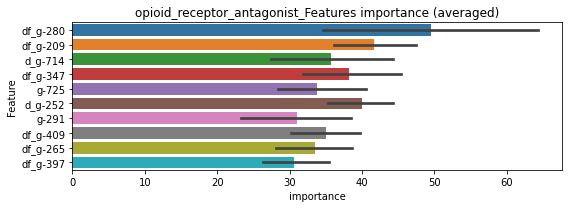

len(train_index) : 3827
len(valid_index) : 3828
================================= fold 1/2 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315561	valid_1's binary_logloss: 0.0823993
[200]	training's binary_logloss: 0.00653341	valid_1's binary_logloss: 0.0572836
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.00368571	valid_1's binary_logloss: 0.0549812


len(train_index) : 3828
len(valid_index) : 3827
================================= fold 2/2 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0291974	valid_1's binary_logloss: 0.0882104
[200]	training's binary_logloss: 0.00630857	valid_1's binary_logloss: 0.0606154
[300]	training's binary_logloss: 0.0016972	valid_1's binary_logloss: 0.0539583
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.00125518	valid_1's binary_logloss: 0.0530589


opioid_receptor_antagonist logloss: 0.05402012948473675


neg labels: 3289 → selected neg labels: 3283


orexin_receptor_antagonist, len(trt): 37, len(othr): 3283, target_rate: 0.0015537 → Adj_target_rate: 0.0018079
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0360022	valid_1's binary_logloss: 0.0696931
[200]	training's binary_logloss: 0.00557021	valid_1's binary_logloss: 0.0303732
[300]	training's binary_logloss: 0.00150874	valid_1's binary_logloss: 0.0227104
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.000819584	valid_1's binary_logloss: 0.0210231
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0340223	valid_1's binary_logloss: 0.065067
[200]	training's binary_logloss: 0.00520759	valid_1's binary_logloss: 0.0279876
[300]	training's binary_logloss: 0.0014659	valid_1's binary_logloss: 0.0209324
[400]	training's binary_logloss: 0.000702332	valid_1's binary_logloss: 0.0180026
Early stopping, best iteration is:
[488]	training's binary_logloss: 0.000480549	valid_1's binary_logloss: 0.0172541


1 / 3 AUC score:1.000
y_Threshold: 0.0042268, Threshold: 0.0046807, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00155
Num_p_label: 80.0, conf_0:0.00421, conf_1:0.00515
Num_p_label: 80.0, Expected: 6.2, Adj_threshold_1: 0.0046807
Num_p_label: 12.0, Expected: 6.2, Adj_threshold_2: 0.0146807
threshold: 0.0146807, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339257	valid_1's binary_logloss: 0.0669028
[200]	training's binary_logloss: 0.0051288	valid_1's binary_logloss: 0.0301959
[300]	training's binary_logloss: 0.00141307	valid_1's binary_logloss: 0.0228333
[400]	training's binary_logloss: 0.000683546	valid_1's binary_logloss: 0.0204624
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.000603238	valid_1's binary_logloss: 0.0201723
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.034997	valid_1's binary_logloss: 0.0669545
[200]	training's binary_logloss: 0.00523605	valid_1's binary_logloss: 0.0274667
[300]	training's binary_logloss: 0.00146084	valid_1's binary_logloss: 0.0202498
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.00122464	valid_1's binary_logloss: 0.0195017


2 / 3 AUC score:1.000
y_Threshold: 0.0265119, Threshold: 0.0146807, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 654.0/3803
p_label_rate: 0.0085384 Vs.target_rate: 0.00155
Num_p_label: 34.0, conf_0:0.01321, conf_1:0.01615
Num_p_label: 34.0, Expected: 6.2, Adj_threshold_1: 0.0146807
Num_p_label: 10.0, Expected: 6.2, Adj_threshold_2: 0.0246807
threshold: 0.0246807, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 654.0/3803, y_label_rate: 0.1719695
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345362	valid_1's binary_logloss: 0.0587942
[200]	training's binary_logloss: 0.00511325	valid_1's binary_logloss: 0.0194552
[300]	training's binary_logloss: 0.00144278	valid_1's binary_logloss: 0.0119741
[400]	training's binary_logloss: 0.000704376	valid_1's binary_logloss: 0.0101323
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.000615664	valid_1's binary_logloss: 0.00992052
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0347165	valid_1's binary_logloss: 0.0604479
[200]	training's binary_logloss: 0.00517313	valid_1's binary_logloss: 0.023274
[300]	training's binary_logloss: 0.00143959	valid_1's binary_logloss: 0.0149168
[400]	training's binary_logloss: 0.000697532	valid_1's binary_logloss: 0.0120836
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.000681845	valid_1's binary_logloss: 0.012028


3 / 3 AUC score:1.000
y_Threshold: 0.0178285, Threshold: 0.0246807, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 653.0/3801
p_label_rate: 0.0027624 Vs.target_rate: 0.00155
Num_p_label: 11.0, conf_0:0.02221, conf_1:0.02715
threshold: 0.0246807, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 664.0/7783, y_label_rate: 0.0853141


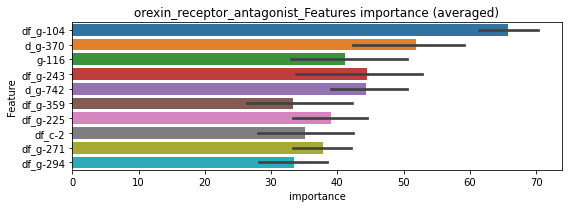

len(train_index) : 3891
len(valid_index) : 3892
================================= fold 1/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192368	valid_1's binary_logloss: 0.037268
[200]	training's binary_logloss: 0.00278645	valid_1's binary_logloss: 0.017303
[300]	training's binary_logloss: 0.000756833	valid_1's binary_logloss: 0.0145505
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.000567085	valid_1's binary_logloss: 0.014368


len(train_index) : 3892
len(valid_index) : 3891
================================= fold 2/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195384	valid_1's binary_logloss: 0.039056
[200]	training's binary_logloss: 0.00291068	valid_1's binary_logloss: 0.0171258
[300]	training's binary_logloss: 0.000806452	valid_1's binary_logloss: 0.0137958
[400]	training's binary_logloss: 0.000378294	valid_1's binary_logloss: 0.0133079
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.000370053	valid_1's binary_logloss: 0.01327


orexin_receptor_antagonist logloss: 0.013819047070805654


neg labels: 3289 → selected neg labels: 3278


p38_mapk_inhibitor, len(trt): 62, len(othr): 3278, target_rate: 0.0026035 → Adj_target_rate: 0.0028037
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319195	valid_1's binary_logloss: 0.0745878
[200]	training's binary_logloss: 0.00470633	valid_1's binary_logloss: 0.0442754
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00168651	valid_1's binary_logloss: 0.038925
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.030439	valid_1's binary_logloss: 0.0706981
[200]	training's binary_logloss: 0.00445207	valid_1's binary_logloss: 0.0388134
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.00285904	valid_1's binary_logloss: 0.0366271


1 / 3 AUC score:0.997
y_Threshold: 0.0119958, Threshold: 0.0236703, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 154 → Positive_corect_labels: 644/3779
p_label_rate: 0.0200904 Vs.target_rate: 0.00260
Num_p_label: 80.0, conf_0:0.02130, conf_1:0.02604
Num_p_label: 80.0, Expected: 10.4, Adj_threshold_1: 0.0236703
Num_p_label: 56.0, Expected: 10.4, Adj_threshold_2: 0.0336703
Num_p_label: 44.0, Expected: 10.4, Adj_threshold_3: 0.0436703
Num_p_label: 36.0, Expected: 10.4, Adj_threshold_4: 0.0536703
Num_p_label: 29.0, Expected: 10.4, Adj_threshold_5: 0.0636703
Num_p_label: 27.0, Expected: 10.4, Adj_threshold_6: 0.0736703
Num_p_label: 23.0, Expected: 10.4, Adj_threshold_7: 0.0836703
Num_p_label: 23.0, Expected: 10.4, Adj_threshold_8: 0.0936703
Num_p_label: 20.0, Expected: 10.4, Adj_threshold_9: 0.1036703
threshold: 0.1036703, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 644.0/3779, y_label_rate: 0.1704155
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0300118	valid_1's binary_logloss: 0.0515079
[200]	training's binary_logloss: 0.00425134	valid_1's binary_logloss: 0.0175344
[300]	training's binary_logloss: 0.00121615	valid_1's binary_logloss: 0.0115354
[400]	training's binary_logloss: 0.000612987	valid_1's binary_logloss: 0.010115
[500]	training's binary_logloss: 0.00042796	valid_1's binary_logloss: 0.00966796
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.000435913	valid_1's binary_logloss: 0.00965496
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.030341	valid_1's binary_logloss: 0.0660225
[200]	training's binary_logloss: 0.00425182	valid_1's binary_logloss: 0.034802
Early stopping, best iteration is:
[259]	training's binary_logloss: 0.00188266	valid_1's binary_logloss: 0.0309111


2 / 3 AUC score:1.000
y_Threshold: 0.0337253, Threshold: 0.1036703, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 640.0/3771
p_label_rate: 0.0075339 Vs.target_rate: 0.00260
Num_p_label: 30.0, conf_0:0.09330, conf_1:0.11404
threshold: 0.1036703, positive_p_label: 30.0/3982, p_label_rate: 0.0075339
positive_y_label: 640.0/3771, y_label_rate: 0.1697163
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297785	valid_1's binary_logloss: 0.0507142
[200]	training's binary_logloss: 0.00409844	valid_1's binary_logloss: 0.0169255
[300]	training's binary_logloss: 0.00117835	valid_1's binary_logloss: 0.0115509
Early stopping, best iteration is:
[372]	training's binary_logloss: 0.000690629	valid_1's binary_logloss: 0.0104027
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294724	valid_1's binary_logloss: 0.0566638
[200]	training's binary_logloss: 0.0041527	valid_1's binary_logloss: 0.0221321
[300]	training's binary_logloss: 0.00118749	valid_1's binary_logloss: 0.0152516
[400]	training's binary_logloss: 0.000593826	valid_1's binary_logloss: 0.012987
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000475387	valid_1's binary_logloss: 0.0125283


3 / 3 AUC score:1.000
y_Threshold: 0.0569237, Threshold: 0.1036703, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 639.0/3769
p_label_rate: 0.0072828 Vs.target_rate: 0.00260
Num_p_label: 29.0, conf_0:0.09330, conf_1:0.11404
threshold: 0.1036703, positive_p_label: 29.0/3982, p_label_rate: 0.0072828
positive_y_label: 668.0/7751, y_label_rate: 0.0861824


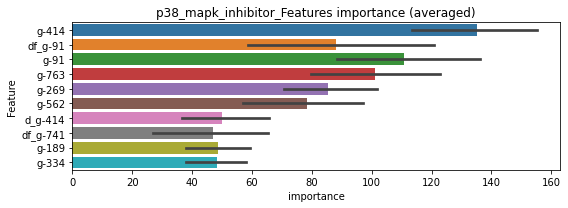

len(train_index) : 3875
len(valid_index) : 3876
================================= fold 1/2 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158427	valid_1's binary_logloss: 0.0401412
[200]	training's binary_logloss: 0.00219674	valid_1's binary_logloss: 0.0248335
[300]	training's binary_logloss: 0.000629756	valid_1's binary_logloss: 0.0211151
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000377701	valid_1's binary_logloss: 0.0204061


len(train_index) : 3876
len(valid_index) : 3875
================================= fold 2/2 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163565	valid_1's binary_logloss: 0.0405923
[200]	training's binary_logloss: 0.00228716	valid_1's binary_logloss: 0.0246968
[300]	training's binary_logloss: 0.000662928	valid_1's binary_logloss: 0.0220282
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.000693835	valid_1's binary_logloss: 0.021983


p38_mapk_inhibitor logloss: 0.021194431927684852


neg labels: 3289 → selected neg labels: 3285


p-glycoprotein_inhibitor, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290675	valid_1's binary_logloss: 0.0431651
[200]	training's binary_logloss: 0.0037836	valid_1's binary_logloss: 0.00924642
[300]	training's binary_logloss: 0.00104284	valid_1's binary_logloss: 0.00443662
[400]	training's binary_logloss: 0.000513109	valid_1's binary_logloss: 0.00330853
[500]	training's binary_logloss: 0.000380175	valid_1's binary_logloss: 0.00297792
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.000380014	valid_1's binary_logloss: 0.00297756
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294427	valid_1's binary_logloss: 0.0464345
[200]	training's binary_logloss: 0.00387399	valid_1's binary_logloss: 0.0148087
[300]	training's binary_logloss: 0.00104736	valid_1's binary_logloss: 0.00929208
[400]	training's binary_logloss: 0.000519545	valid_1's binary_logloss: 0.00794588
Early stopping, best iteration is:


1 / 3 AUC score:1.000
y_Threshold: 0.0024623, Threshold: 0.0030523, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00101
Num_p_label: 80.0, conf_0:0.00275, conf_1:0.00336
Num_p_label: 80.0, Expected: 4.0, Adj_threshold_1: 0.0030523
Num_p_label: 5.0, Expected: 4.0, Adj_threshold_2: 0.0130523
threshold: 0.0130523, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0284913	valid_1's binary_logloss: 0.0411081
[200]	training's binary_logloss: 0.00359058	valid_1's binary_logloss: 0.00824822
[300]	training's binary_logloss: 0.00100247	valid_1's binary_logloss: 0.00355125
[400]	training's binary_logloss: 0.000505726	valid_1's binary_logloss: 0.00252194
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.000388926	valid_1's binary_logloss: 0.00222725
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283072	valid_1's binary_logloss: 0.0457155
[200]	training's binary_logloss: 0.00364366	valid_1's binary_logloss: 0.0164101
[300]	training's binary_logloss: 0.000990665	valid_1's binary_logloss: 0.0120637
[400]	training's binary_logloss: 0.000501178	valid_1's binary_logloss: 0.0108322
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.000498891	valid_1's binary_logloss: 0.0108274


2 / 3 AUC score:1.000
y_Threshold: 0.0145589, Threshold: 0.0130523, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0067805 Vs.target_rate: 0.00101
Num_p_label: 27.0, conf_0:0.01175, conf_1:0.01436
Num_p_label: 27.0, Expected: 4.0, Adj_threshold_1: 0.0130523
Num_p_label: 9.0, Expected: 4.0, Adj_threshold_2: 0.0230523
Num_p_label: 3.0, Expected: 4.0, Adj_threshold_3: 0.0330523
threshold: 0.0330523, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 655.0/3806, y_label_rate: 0.1720967
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285946	valid_1's binary_logloss: 0.0424052
[200]	training's binary_logloss: 0.00362156	valid_1's binary_logloss: 0.0103289
[300]	training's binary_logloss: 0.000993906	valid_1's binary_logloss: 0.0061672
[400]	training's binary_logloss: 0.000503338	valid_1's binary_logloss: 0.00549489
Early stopping, best iteration is:
[427]	training's binary_logloss: 0.00044651	valid_1's binary_logloss: 0.00530269
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289313	valid_1's binary_logloss: 0.0449757
[200]	training's binary_logloss: 0.00361898	valid_1's binary_logloss: 0.0120589
[300]	training's binary_logloss: 0.00100808	valid_1's binary_logloss: 0.0069093
[400]	training's binary_logloss: 0.000507142	valid_1's binary_logloss: 0.00577438
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.000408728	valid_1's binary_logloss: 0.00546424


3 / 3 AUC score:1.000
y_Threshold: 0.0196787, Threshold: 0.0330523, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 654.0/3804
p_label_rate: 0.0015068 Vs.target_rate: 0.00101
Num_p_label: 6.0, conf_0:0.02975, conf_1:0.03636
threshold: 0.0330523, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 660.0/7786, y_label_rate: 0.0847675


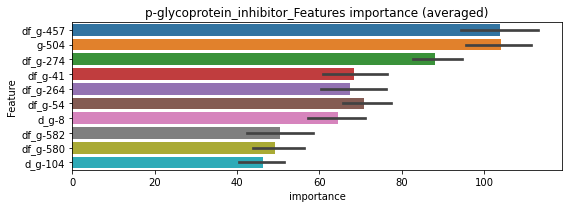

len(train_index) : 3893
len(valid_index) : 3893
================================= fold 1/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015355	valid_1's binary_logloss: 0.027278
[200]	training's binary_logloss: 0.00190152	valid_1's binary_logloss: 0.0114216
Early stopping, best iteration is:
[269]	training's binary_logloss: 0.000706799	valid_1's binary_logloss: 0.0100383


len(train_index) : 3893
len(valid_index) : 3893
================================= fold 2/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0170118	valid_1's binary_logloss: 0.0225712
[200]	training's binary_logloss: 0.00222957	valid_1's binary_logloss: 0.00448246
[300]	training's binary_logloss: 0.000595055	valid_1's binary_logloss: 0.00225969
[400]	training's binary_logloss: 0.000287353	valid_1's binary_logloss: 0.00189342
[500]	training's binary_logloss: 0.000205282	valid_1's binary_logloss: 0.00180575
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.000204762	valid_1's binary_logloss: 0.001805


p-glycoprotein_inhibitor logloss: 0.00592166079863186


neg labels: 3289 → selected neg labels: 3279


parp_inhibitor, len(trt): 61, len(othr): 3279, target_rate: 0.0025615 → Adj_target_rate: 0.0027652
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0448765	valid_1's binary_logloss: 0.0838512
[200]	training's binary_logloss: 0.00807404	valid_1's binary_logloss: 0.0367551
[300]	training's binary_logloss: 0.00229012	valid_1's binary_logloss: 0.026192
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.00172896	valid_1's binary_logloss: 0.0253772
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0454536	valid_1's binary_logloss: 0.0891745
[200]	training's binary_logloss: 0.00792448	valid_1's binary_logloss: 0.0371668
[300]	training's binary_logloss: 0.00227191	valid_1's binary_logloss: 0.0249564
[400]	training's binary_logloss: 0.00107258	valid_1's binary_logloss: 0.021019
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.000869432	valid_1's binary_logloss: 0.020262


1 / 3 AUC score:1.000
y_Threshold: 0.0120746, Threshold: 0.0167134, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 136 → Positive_corect_labels: 653/3798
p_label_rate: 0.0200904 Vs.target_rate: 0.00256
Num_p_label: 80.0, conf_0:0.01504, conf_1:0.01838
Num_p_label: 80.0, Expected: 10.2, Adj_threshold_1: 0.0167134
Num_p_label: 38.0, Expected: 10.2, Adj_threshold_2: 0.0267134
Num_p_label: 25.0, Expected: 10.2, Adj_threshold_3: 0.0367134
Num_p_label: 13.0, Expected: 10.2, Adj_threshold_4: 0.0467134
threshold: 0.0467134, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 653.0/3798, y_label_rate: 0.1719326
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0432736	valid_1's binary_logloss: 0.0784794
[200]	training's binary_logloss: 0.00741353	valid_1's binary_logloss: 0.0280413
[300]	training's binary_logloss: 0.00218118	valid_1's binary_logloss: 0.0168204
[400]	training's binary_logloss: 0.00104509	valid_1's binary_logloss: 0.0138567
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00077931	valid_1's binary_logloss: 0.0128481
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0434629	valid_1's binary_logloss: 0.08865
[200]	training's binary_logloss: 0.00761214	valid_1's binary_logloss: 0.0441917
[300]	training's binary_logloss: 0.00221219	valid_1's binary_logloss: 0.0347304
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.00111633	valid_1's binary_logloss: 0.0321304


2 / 3 AUC score:1.000
y_Threshold: 0.0393857, Threshold: 0.0467134, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 646.0/3784
p_label_rate: 0.0070316 Vs.target_rate: 0.00256
Num_p_label: 28.0, conf_0:0.04204, conf_1:0.05138
threshold: 0.0467134, positive_p_label: 28.0/3982, p_label_rate: 0.0070316
positive_y_label: 646.0/3784, y_label_rate: 0.1707188
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0424132	valid_1's binary_logloss: 0.0798885
[200]	training's binary_logloss: 0.00727504	valid_1's binary_logloss: 0.0358955
[300]	training's binary_logloss: 0.0021199	valid_1's binary_logloss: 0.0279662
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.00124267	valid_1's binary_logloss: 0.025355
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0427657	valid_1's binary_logloss: 0.0808574
[200]	training's binary_logloss: 0.00715635	valid_1's binary_logloss: 0.030211
[300]	training's binary_logloss: 0.00209492	valid_1's binary_logloss: 0.0195079
[400]	training's binary_logloss: 0.00100198	valid_1's binary_logloss: 0.01576
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000762305	valid_1's binary_logloss: 0.0145528


3 / 3 AUC score:1.000
y_Threshold: 0.0446025, Threshold: 0.0467134, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 640.0/3772
p_label_rate: 0.0095429 Vs.target_rate: 0.00256
Num_p_label: 38.0, conf_0:0.04204, conf_1:0.05138
Num_p_label: 38.0, Expected: 10.2, Adj_threshold_1: 0.0467134
Num_p_label: 30.0, Expected: 10.2, Adj_threshold_2: 0.0567134
Num_p_label: 22.0, Expected: 10.2, Adj_threshold_3: 0.0667134
Num_p_label: 19.0, Expected: 10.2, Adj_threshold_4: 0.0767134
threshold: 0.0767134, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 659.0/7754, y_label_rate: 0.0849884


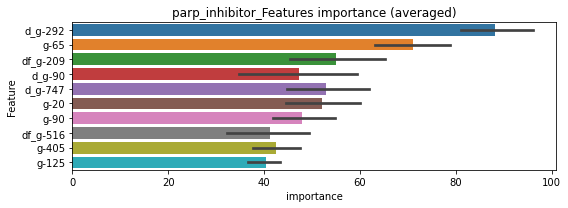

len(train_index) : 3877
len(valid_index) : 3877
================================= fold 1/2 parp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232013	valid_1's binary_logloss: 0.0575339
[200]	training's binary_logloss: 0.00395005	valid_1's binary_logloss: 0.0355034
[300]	training's binary_logloss: 0.00111985	valid_1's binary_logloss: 0.0324219
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.00120359	valid_1's binary_logloss: 0.0323333


len(train_index) : 3877
len(valid_index) : 3877
================================= fold 2/2 parp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0244597	valid_1's binary_logloss: 0.0482225
[200]	training's binary_logloss: 0.00430137	valid_1's binary_logloss: 0.0217373
[300]	training's binary_logloss: 0.00124231	valid_1's binary_logloss: 0.0162258
[400]	training's binary_logloss: 0.000575463	valid_1's binary_logloss: 0.0147902
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00051414	valid_1's binary_logloss: 0.0146302


parp_inhibitor logloss: 0.023481752298042054


neg labels: 3289 → selected neg labels: 3268


pdgfr_inhibitor, len(trt): 297, len(othr): 3268, target_rate: 0.0124717 → Adj_target_rate: 0.0106179
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0459985	valid_1's binary_logloss: 0.109738
[200]	training's binary_logloss: 0.00935368	valid_1's binary_logloss: 0.0804198
Early stopping, best iteration is:
[231]	training's binary_logloss: 0.0064633	valid_1's binary_logloss: 0.0783739
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0442834	valid_1's binary_logloss: 0.107586
[200]	training's binary_logloss: 0.00829485	valid_1's binary_logloss: 0.0822103
Early stopping, best iteration is:
[223]	training's binary_logloss: 0.00607753	valid_1's binary_logloss: 0.0811179


1 / 3 AUC score:0.991
y_Threshold: 0.0427910, Threshold: 0.1977842, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 172 → Positive_corect_labels: 633/3749
p_label_rate: 0.0200904 Vs.target_rate: 0.01247
Num_p_label: 80.0, conf_0:0.17801, conf_1:0.21756
threshold: 0.1977842, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 633.0/3749, y_label_rate: 0.1688450
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0343697	valid_1's binary_logloss: 0.0816705
[200]	training's binary_logloss: 0.00597484	valid_1's binary_logloss: 0.0545472
[300]	training's binary_logloss: 0.00174628	valid_1's binary_logloss: 0.0492902
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00174628	valid_1's binary_logloss: 0.0492902
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0390506	valid_1's binary_logloss: 0.0661365
[200]	training's binary_logloss: 0.00679122	valid_1's binary_logloss: 0.0328111
[300]	training's binary_logloss: 0.00203209	valid_1's binary_logloss: 0.0257045
[400]	training's binary_logloss: 0.000945746	valid_1's binary_logloss: 0.0232684
Early stopping, best iteration is:
[473]	training's binary_logloss: 0.000679649	valid_1's binary_logloss: 0.0225635


2 / 3 AUC score:0.997
y_Threshold: 0.1213048, Threshold: 0.1977842, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 36 → Positive_corect_labels: 615.0/3713
p_label_rate: 0.0351582 Vs.target_rate: 0.01247
Num_p_label: 140.0, conf_0:0.17801, conf_1:0.21756
threshold: 0.1977842, positive_p_label: 140.0/3982, p_label_rate: 0.0351582
positive_y_label: 615.0/3713, y_label_rate: 0.1656343
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334478	valid_1's binary_logloss: 0.0662649
[200]	training's binary_logloss: 0.00528238	valid_1's binary_logloss: 0.0366605
[300]	training's binary_logloss: 0.00159125	valid_1's binary_logloss: 0.0319117
[400]	training's binary_logloss: 0.000766968	valid_1's binary_logloss: 0.0306455
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.000800302	valid_1's binary_logloss: 0.0305633
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031497	valid_1's binary_logloss: 0.0709843
[200]	training's binary_logloss: 0.00511735	valid_1's binary_logloss: 0.0409224
[300]	training's binary_logloss: 0.00151494	valid_1's binary_logloss: 0.0341477
[400]	training's binary_logloss: 0.000732222	valid_1's binary_logloss: 0.031693
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000768384	valid_1's binary_logloss: 0.0316902


3 / 3 AUC score:0.995
y_Threshold: 0.1186112, Threshold: 0.1977842, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 26 → Positive_corect_labels: 602.0/3687
p_label_rate: 0.0386740 Vs.target_rate: 0.01247
Num_p_label: 154.0, conf_0:0.17801, conf_1:0.21756
Num_p_label: 154.0, Expected: 49.7, Adj_threshold_1: 0.1977842
Num_p_label: 149.0, Expected: 49.7, Adj_threshold_2: 0.2077842
Num_p_label: 148.0, Expected: 49.7, Adj_threshold_3: 0.2177842
Num_p_label: 146.0, Expected: 49.7, Adj_threshold_4: 0.2277842
Num_p_label: 145.0, Expected: 49.7, Adj_threshold_5: 0.2377842
Num_p_label: 141.0, Expected: 49.7, Adj_threshold_6: 0.2477842
Num_p_label: 136.0, Expected: 49.7, Adj_threshold_7: 0.2577842
Num_p_label: 133.0, Expected: 49.7, Adj_threshold_8: 0.2677842
Num_p_label: 127.0, Expected: 49.7, Adj_threshold_9: 0.2777842
Num_p_label: 122.0, Expected: 49.7, Adj_threshold_10: 0.2877842
threshold: 0.2977842, positive_p_label: 121.0/3982, p_label_rate: 0.0303867
positive_y_label: 723.0/7669, y_label_ra

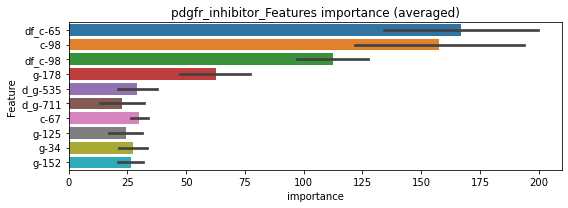

len(train_index) : 3834
len(valid_index) : 3835
================================= fold 1/2 pdgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193483	valid_1's binary_logloss: 0.0433423
[200]	training's binary_logloss: 0.00311684	valid_1's binary_logloss: 0.0260076
[300]	training's binary_logloss: 0.000905617	valid_1's binary_logloss: 0.0222467
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.000552489	valid_1's binary_logloss: 0.0209973


len(train_index) : 3835
len(valid_index) : 3834
================================= fold 2/2 pdgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0201757	valid_1's binary_logloss: 0.0443663
[200]	training's binary_logloss: 0.00325183	valid_1's binary_logloss: 0.0255853
[300]	training's binary_logloss: 0.000945224	valid_1's binary_logloss: 0.0218387
Early stopping, best iteration is:
[362]	training's binary_logloss: 0.000575891	valid_1's binary_logloss: 0.021124


pdgfr_inhibitor logloss: 0.02106062914393059


neg labels: 3289 → selected neg labels: 3286


pdk_inhibitor, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0219928	valid_1's binary_logloss: 0.029381
[200]	training's binary_logloss: 0.00250091	valid_1's binary_logloss: 0.00577324
[300]	training's binary_logloss: 0.000712115	valid_1's binary_logloss: 0.00254641
[400]	training's binary_logloss: 0.000385441	valid_1's binary_logloss: 0.00175478
[500]	training's binary_logloss: 0.000320472	valid_1's binary_logloss: 0.0016016
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000318952	valid_1's binary_logloss: 0.00159954
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221799	valid_1's binary_logloss: 0.0285252
[200]	training's binary_logloss: 0.00253238	valid_1's binary_logloss: 0.00414017
[300]	training's binary_logloss: 0.00072097	valid_1's binary_logloss: 0.00137676
[400]	training's binary_logloss: 0.000389865	valid_1's binary_logloss: 0.000829016
[500]	training's binary_logloss: 

1 / 3 AUC score:1.000
y_Threshold: 0.0015198, Threshold: 0.0021911, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00197, conf_1:0.00241
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0021911
Num_p_label: 1.0, Expected: 3.0, Adj_threshold_2: 0.0121911
threshold: 0.0121911, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0219689	valid_1's binary_logloss: 0.0285167
[200]	training's binary_logloss: 0.00247682	valid_1's binary_logloss: 0.00586388
[300]	training's binary_logloss: 0.000708209	valid_1's binary_logloss: 0.00288335
[400]	training's binary_logloss: 0.000384344	valid_1's binary_logloss: 0.00216914
[500]	training's binary_logloss: 0.000322165	valid_1's binary_logloss: 0.0020479
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.000321312	valid_1's binary_logloss: 0.00204636
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0219424	valid_1's binary_logloss: 0.0280807
[200]	training's binary_logloss: 0.00243838	valid_1's binary_logloss: 0.00383203
[300]	training's binary_logloss: 0.00069844	valid_1's binary_logloss: 0.00122717
[400]	training's binary_logloss: 0.000391074	valid_1's binary_logloss: 0.000737477
[500]	training's binary_logloss:

2 / 3 AUC score:1.000
y_Threshold: 0.0447430, Threshold: 0.0121911, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0025113 Vs.target_rate: 0.00076
Num_p_label: 10.0, conf_0:0.01097, conf_1:0.01341
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_1: 0.0121911
Num_p_label: 2.0, Expected: 3.0, Adj_threshold_2: 0.0221911
threshold: 0.0221911, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0219689	valid_1's binary_logloss: 0.0285167
[200]	training's binary_logloss: 0.00247682	valid_1's binary_logloss: 0.00586388
[300]	training's binary_logloss: 0.000708209	valid_1's binary_logloss: 0.00288335
[400]	training's binary_logloss: 0.000384344	valid_1's binary_logloss: 0.00216914
[500]	training's binary_logloss: 0.000322165	valid_1's binary_logloss: 0.0020479
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.000321312	valid_1's binary_logloss: 0.00204636
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0219424	valid_1's binary_logloss: 0.0280807
[200]	training's binary_logloss: 0.00243838	valid_1's binary_logloss: 0.00383203
[300]	training's binary_logloss: 0.00069844	valid_1's binary_logloss: 0.00122717
[400]	training's binary_logloss: 0.000391074	valid_1's binary_logloss: 0.000737477
[500]	training's binary_logloss:

3 / 3 AUC score:1.000
y_Threshold: 0.0447430, Threshold: 0.0221911, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0005023 Vs.target_rate: 0.00076
Num_p_label: 2.0, conf_0:0.01997, conf_1:0.02441
threshold: 0.0221911, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 659.0/7793, y_label_rate: 0.0845631


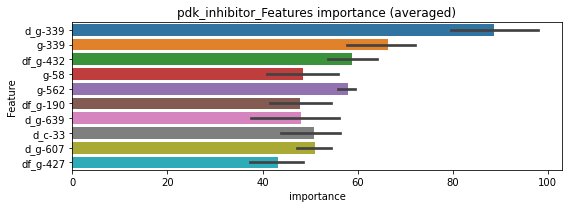

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 pdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0119035	valid_1's binary_logloss: 0.0202183
[200]	training's binary_logloss: 0.00134161	valid_1's binary_logloss: 0.00901493
Early stopping, best iteration is:
[276]	training's binary_logloss: 0.000463924	valid_1's binary_logloss: 0.00740044


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 pdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0122506	valid_1's binary_logloss: 0.0165611
[200]	training's binary_logloss: 0.00137486	valid_1's binary_logloss: 0.00367584
[300]	training's binary_logloss: 0.000372972	valid_1's binary_logloss: 0.00223316
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.00020649	valid_1's binary_logloss: 0.00198394


pdk_inhibitor logloss: 0.0046925342811004345


neg labels: 3289 → selected neg labels: 3243


phosphodiesterase_inhibitor, len(trt): 264, len(othr): 3243, target_rate: 0.0110859 → Adj_target_rate: 0.0096064
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100433	valid_1's binary_logloss: 0.296268
[200]	training's binary_logloss: 0.0331088	valid_1's binary_logloss: 0.275173
Early stopping, best iteration is:
[206]	training's binary_logloss: 0.0312264	valid_1's binary_logloss: 0.274365
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105854	valid_1's binary_logloss: 0.280398
Early stopping, best iteration is:
[173]	training's binary_logloss: 0.0476741	valid_1's binary_logloss: 0.251974


1 / 3 AUC score:0.887
y_Threshold: 0.0994372, Threshold: 0.1439266, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 473 → Positive_corect_labels: 477/3418
p_label_rate: 0.0200904 Vs.target_rate: 0.01109
Num_p_label: 80.0, conf_0:0.12953, conf_1:0.15832
threshold: 0.1439266, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 477.0/3418, y_label_rate: 0.1395553
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0695019	valid_1's binary_logloss: 0.187285
[200]	training's binary_logloss: 0.0189238	valid_1's binary_logloss: 0.145853
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00970567	valid_1's binary_logloss: 0.142445
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0682627	valid_1's binary_logloss: 0.180607
[200]	training's binary_logloss: 0.0178608	valid_1's binary_logloss: 0.136443
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.011418	valid_1's binary_logloss: 0.131462


2 / 3 AUC score:0.967
y_Threshold: 0.0837783, Threshold: 0.1439266, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 410.0/3284
p_label_rate: 0.0110497 Vs.target_rate: 0.01109
Num_p_label: 44.0, conf_0:0.12953, conf_1:0.15832
threshold: 0.1439266, positive_p_label: 44.0/3982, p_label_rate: 0.0110497
positive_y_label: 410.0/3284, y_label_rate: 0.1248477
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0506671	valid_1's binary_logloss: 0.173709
[200]	training's binary_logloss: 0.0106175	valid_1's binary_logloss: 0.148679
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.00761943	valid_1's binary_logloss: 0.147468
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0540233	valid_1's binary_logloss: 0.171689
[200]	training's binary_logloss: 0.0129913	valid_1's binary_logloss: 0.142673
Early stopping, best iteration is:
[231]	training's binary_logloss: 0.00885696	valid_1's binary_logloss: 0.138987


3 / 3 AUC score:0.966
y_Threshold: 0.0546600, Threshold: 0.1439266, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 122 → Positive_corect_labels: 349.0/3162
p_label_rate: 0.0092918 Vs.target_rate: 0.01109
Num_p_label: 37.0, conf_0:0.12953, conf_1:0.15832
threshold: 0.1439266, positive_p_label: 37.0/3982, p_label_rate: 0.0092918
positive_y_label: 386.0/7144, y_label_rate: 0.0540314


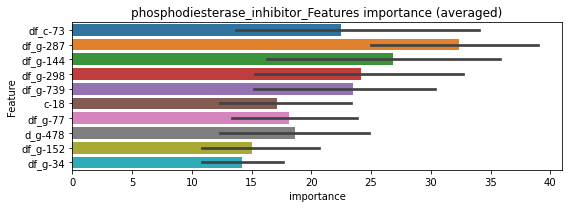

len(train_index) : 3572
len(valid_index) : 3572
================================= fold 1/2 phosphodiesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023206	valid_1's binary_logloss: 0.0902575
[200]	training's binary_logloss: 0.0052793	valid_1's binary_logloss: 0.0803318
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.00599392	valid_1's binary_logloss: 0.0802641


len(train_index) : 3572
len(valid_index) : 3572
================================= fold 2/2 phosphodiesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024843	valid_1's binary_logloss: 0.0896022
[200]	training's binary_logloss: 0.00567109	valid_1's binary_logloss: 0.074811
Early stopping, best iteration is:
[221]	training's binary_logloss: 0.00427704	valid_1's binary_logloss: 0.0742393


phosphodiesterase_inhibitor logloss: 0.07725172933561329


neg labels: 3289 → selected neg labels: 3285


phospholipase_inhibitor, len(trt): 25, len(othr): 3285, target_rate: 0.0010498 → Adj_target_rate: 0.0012955
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309566	valid_1's binary_logloss: 0.0516344
[200]	training's binary_logloss: 0.00549949	valid_1's binary_logloss: 0.0197191
[300]	training's binary_logloss: 0.00130465	valid_1's binary_logloss: 0.00778863
[400]	training's binary_logloss: 0.00056276	valid_1's binary_logloss: 0.00512607
[500]	training's binary_logloss: 0.000371117	valid_1's binary_logloss: 0.00397088
Early stopping, best iteration is:
[538]	training's binary_logloss: 0.000351291	valid_1's binary_logloss: 0.00387932
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0310694	valid_1's binary_logloss: 0.0469632
[200]	training's binary_logloss: 0.0040181	valid_1's binary_logloss: 0.0113601
[300]	training's binary_logloss: 0.00109674	valid_1's binary_logloss: 0.00526565
[400]	training's binary_logloss: 0.000549439	valid_1's binary_logloss: 0.00366836
[500]	training's binary_logloss: 0.00

1 / 3 AUC score:1.000
y_Threshold: 0.0021933, Threshold: 0.0033734, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00105
Num_p_label: 80.0, conf_0:0.00304, conf_1:0.00371
Num_p_label: 80.0, Expected: 4.2, Adj_threshold_1: 0.0033734
Num_p_label: 8.0, Expected: 4.2, Adj_threshold_2: 0.0133734
threshold: 0.0133734, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297103	valid_1's binary_logloss: 0.0474341
[200]	training's binary_logloss: 0.00384949	valid_1's binary_logloss: 0.0119841
[300]	training's binary_logloss: 0.00107479	valid_1's binary_logloss: 0.00632853
[400]	training's binary_logloss: 0.000538997	valid_1's binary_logloss: 0.00464958
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.000536529	valid_1's binary_logloss: 0.00464112
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302534	valid_1's binary_logloss: 0.0429939
[200]	training's binary_logloss: 0.00384013	valid_1's binary_logloss: 0.00941849
[300]	training's binary_logloss: 0.00107063	valid_1's binary_logloss: 0.00435747
[400]	training's binary_logloss: 0.000546302	valid_1's binary_logloss: 0.00293732
[500]	training's binary_logloss: 0.000396982	valid_1's binary_logloss: 0.00254907
Early stopping, best iteration is:

2 / 3 AUC score:1.000
y_Threshold: 0.0523699, Threshold: 0.0133734, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0067805 Vs.target_rate: 0.00105
Num_p_label: 27.0, conf_0:0.01204, conf_1:0.01471
Num_p_label: 27.0, Expected: 4.2, Adj_threshold_1: 0.0133734
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_2: 0.0233734
Num_p_label: 4.0, Expected: 4.2, Adj_threshold_3: 0.0333734
threshold: 0.0333734, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297103	valid_1's binary_logloss: 0.0474341
[200]	training's binary_logloss: 0.00384949	valid_1's binary_logloss: 0.0119841
[300]	training's binary_logloss: 0.00107479	valid_1's binary_logloss: 0.00632853
[400]	training's binary_logloss: 0.000538997	valid_1's binary_logloss: 0.00464958
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.000536529	valid_1's binary_logloss: 0.00464112
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302534	valid_1's binary_logloss: 0.0429939
[200]	training's binary_logloss: 0.00384013	valid_1's binary_logloss: 0.00941849
[300]	training's binary_logloss: 0.00107063	valid_1's binary_logloss: 0.00435747
[400]	training's binary_logloss: 0.000546302	valid_1's binary_logloss: 0.00293732
[500]	training's binary_logloss: 0.000396982	valid_1's binary_logloss: 0.00254907
Early stopping, best iteration is:

3 / 3 AUC score:1.000
y_Threshold: 0.0523699, Threshold: 0.0333734, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0010045 Vs.target_rate: 0.00105
Num_p_label: 4.0, conf_0:0.03004, conf_1:0.03671
threshold: 0.0333734, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 661.0/7792, y_label_rate: 0.0848306


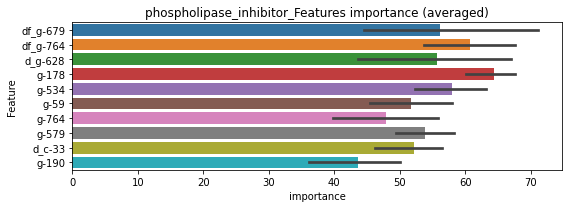

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016374	valid_1's binary_logloss: 0.0279088
[200]	training's binary_logloss: 0.00217429	valid_1's binary_logloss: 0.0115669
[300]	training's binary_logloss: 0.000569162	valid_1's binary_logloss: 0.0092369
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000326769	valid_1's binary_logloss: 0.00844856


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0169499	valid_1's binary_logloss: 0.0238807
[200]	training's binary_logloss: 0.00226842	valid_1's binary_logloss: 0.00519813
[300]	training's binary_logloss: 0.000595506	valid_1's binary_logloss: 0.0024088
[400]	training's binary_logloss: 0.000289165	valid_1's binary_logloss: 0.00179888
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.000224348	valid_1's binary_logloss: 0.00167419


phospholipase_inhibitor logloss: 0.005061372332656204


neg labels: 3289 → selected neg labels: 3264


pi3k_inhibitor, len(trt): 151, len(othr): 3264, target_rate: 0.0063408 → Adj_target_rate: 0.0059749
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0522849	valid_1's binary_logloss: 0.137598
[200]	training's binary_logloss: 0.0114716	valid_1's binary_logloss: 0.103053
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00601197	valid_1's binary_logloss: 0.099536
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0509212	valid_1's binary_logloss: 0.15138
[200]	training's binary_logloss: 0.0105531	valid_1's binary_logloss: 0.114133
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.00538452	valid_1's binary_logloss: 0.108795


1 / 3 AUC score:0.986
y_Threshold: 0.0334503, Threshold: 0.1440414, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 182 → Positive_corect_labels: 627/3734
p_label_rate: 0.0200904 Vs.target_rate: 0.00634
Num_p_label: 80.0, conf_0:0.12964, conf_1:0.15845
Num_p_label: 80.0, Expected: 25.2, Adj_threshold_1: 0.1440414
Num_p_label: 78.0, Expected: 25.2, Adj_threshold_2: 0.1540414
Num_p_label: 76.0, Expected: 25.2, Adj_threshold_3: 0.1640414
Num_p_label: 74.0, Expected: 25.2, Adj_threshold_4: 0.1740414
Num_p_label: 73.0, Expected: 25.2, Adj_threshold_5: 0.1840414
Num_p_label: 73.0, Expected: 25.2, Adj_threshold_6: 0.1940414
Num_p_label: 72.0, Expected: 25.2, Adj_threshold_7: 0.2040414
Num_p_label: 72.0, Expected: 25.2, Adj_threshold_8: 0.2140414
Num_p_label: 69.0, Expected: 25.2, Adj_threshold_9: 0.2240414
Num_p_label: 66.0, Expected: 25.2, Adj_threshold_10: 0.2340414
threshold: 0.2440414, positive_p_label: 62.0/3982, p_label_rate: 0.0155701
positive_y_label: 627.0/3734, y_label_rate: 0.1679164

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0431656	valid_1's binary_logloss: 0.112744
[200]	training's binary_logloss: 0.00800174	valid_1's binary_logloss: 0.0710815
[300]	training's binary_logloss: 0.00246284	valid_1's binary_logloss: 0.0602802
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00199475	valid_1's binary_logloss: 0.0595561
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0424597	valid_1's binary_logloss: 0.131891
[200]	training's binary_logloss: 0.00810616	valid_1's binary_logloss: 0.0986279
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.00433402	valid_1's binary_logloss: 0.095418


2 / 3 AUC score:0.993
y_Threshold: 0.0664766, Threshold: 0.2440414, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 66 → Positive_corect_labels: 594.0/3668
p_label_rate: 0.0311401 Vs.target_rate: 0.00634
Num_p_label: 124.0, conf_0:0.21964, conf_1:0.26845
Num_p_label: 124.0, Expected: 25.2, Adj_threshold_1: 0.2440414
Num_p_label: 121.0, Expected: 25.2, Adj_threshold_2: 0.2540414
Num_p_label: 115.0, Expected: 25.2, Adj_threshold_3: 0.2640414
Num_p_label: 112.0, Expected: 25.2, Adj_threshold_4: 0.2740414
Num_p_label: 110.0, Expected: 25.2, Adj_threshold_5: 0.2840414
Num_p_label: 106.0, Expected: 25.2, Adj_threshold_6: 0.2940414
Num_p_label: 104.0, Expected: 25.2, Adj_threshold_7: 0.3040414
Num_p_label: 103.0, Expected: 25.2, Adj_threshold_8: 0.3140414
Num_p_label: 102.0, Expected: 25.2, Adj_threshold_9: 0.3240414
Num_p_label: 100.0, Expected: 25.2, Adj_threshold_10: 0.3340414
threshold: 0.3440414, positive_p_label: 97.0/3982, p_label_rate: 0.0243596
positive_y_label: 594.0/3668, y_label_rat

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0392571	valid_1's binary_logloss: 0.0857361
[200]	training's binary_logloss: 0.00679416	valid_1's binary_logloss: 0.0462987
[300]	training's binary_logloss: 0.00209677	valid_1's binary_logloss: 0.0363798
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00184903	valid_1's binary_logloss: 0.0355821
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0399561	valid_1's binary_logloss: 0.109855
[200]	training's binary_logloss: 0.00685636	valid_1's binary_logloss: 0.0683275
[300]	training's binary_logloss: 0.0020962	valid_1's binary_logloss: 0.0619492
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.00194896	valid_1's binary_logloss: 0.0613773


3 / 3 AUC score:0.996
y_Threshold: 0.0612509, Threshold: 0.3440414, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 30 → Positive_corect_labels: 579.0/3638
p_label_rate: 0.0457057 Vs.target_rate: 0.00634
Num_p_label: 182.0, conf_0:0.30964, conf_1:0.37845
Num_p_label: 182.0, Expected: 25.2, Adj_threshold_1: 0.3440414
Num_p_label: 182.0, Expected: 25.2, Adj_threshold_2: 0.3540414
Num_p_label: 180.0, Expected: 25.2, Adj_threshold_3: 0.3640414
Num_p_label: 178.0, Expected: 25.2, Adj_threshold_4: 0.3740414
Num_p_label: 175.0, Expected: 25.2, Adj_threshold_5: 0.3840414
Num_p_label: 175.0, Expected: 25.2, Adj_threshold_6: 0.3940414
Num_p_label: 174.0, Expected: 25.2, Adj_threshold_7: 0.4040414
Num_p_label: 172.0, Expected: 25.2, Adj_threshold_8: 0.4140414
Num_p_label: 170.0, Expected: 25.2, Adj_threshold_9: 0.4240414
Num_p_label: 169.0, Expected: 25.2, Adj_threshold_10: 0.4340414
threshold: 0.4440414, positive_p_label: 169.0/3982, p_label_rate: 0.0424410
positive_y_label: 748.0/7620, y_label_ra

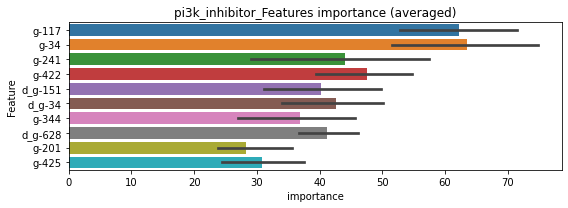

len(train_index) : 3810
len(valid_index) : 3810
================================= fold 1/2 pi3k_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0244265	valid_1's binary_logloss: 0.07117
[200]	training's binary_logloss: 0.00437002	valid_1's binary_logloss: 0.0491446
[300]	training's binary_logloss: 0.00130043	valid_1's binary_logloss: 0.0448554
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.00125413	valid_1's binary_logloss: 0.0448252


len(train_index) : 3810
len(valid_index) : 3810
================================= fold 2/2 pi3k_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0255544	valid_1's binary_logloss: 0.0678629
[200]	training's binary_logloss: 0.00449734	valid_1's binary_logloss: 0.0438549
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.00236092	valid_1's binary_logloss: 0.0406634


pi3k_inhibitor logloss: 0.04274429771841867


neg labels: 3289 → selected neg labels: 3284


pkc_inhibitor, len(trt): 31, len(othr): 3284, target_rate: 0.0013018 → Adj_target_rate: 0.0015554
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330191	valid_1's binary_logloss: 0.0606825
[200]	training's binary_logloss: 0.00467443	valid_1's binary_logloss: 0.0231259
[300]	training's binary_logloss: 0.00126802	valid_1's binary_logloss: 0.0155725
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.000696056	valid_1's binary_logloss: 0.0137779
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0322084	valid_1's binary_logloss: 0.0500459
[200]	training's binary_logloss: 0.00452308	valid_1's binary_logloss: 0.0125454
[300]	training's binary_logloss: 0.00125152	valid_1's binary_logloss: 0.0058608
[400]	training's binary_logloss: 0.000614282	valid_1's binary_logloss: 0.0045913
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.00057264	valid_1's binary_logloss: 0.00444992


1 / 3 AUC score:1.000
y_Threshold: 0.0035782, Threshold: 0.0054619, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00130
Num_p_label: 80.0, conf_0:0.00492, conf_1:0.00601
Num_p_label: 80.0, Expected: 5.2, Adj_threshold_1: 0.0054619
Num_p_label: 14.0, Expected: 5.2, Adj_threshold_2: 0.0154619
Num_p_label: 2.0, Expected: 5.2, Adj_threshold_3: 0.0254619
threshold: 0.0254619, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0314894	valid_1's binary_logloss: 0.0559185
[200]	training's binary_logloss: 0.00439135	valid_1's binary_logloss: 0.0210517
[300]	training's binary_logloss: 0.00122031	valid_1's binary_logloss: 0.013984
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.000819817	valid_1's binary_logloss: 0.0128161
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.032593	valid_1's binary_logloss: 0.0504862
[200]	training's binary_logloss: 0.00450168	valid_1's binary_logloss: 0.0142033
[300]	training's binary_logloss: 0.00124509	valid_1's binary_logloss: 0.00744088
[400]	training's binary_logloss: 0.000615402	valid_1's binary_logloss: 0.00588061
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.000612383	valid_1's binary_logloss: 0.00585497


2 / 3 AUC score:1.000
y_Threshold: 0.0203092, Threshold: 0.0254619, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0050226 Vs.target_rate: 0.00130
Num_p_label: 20.0, conf_0:0.02292, conf_1:0.02801
Num_p_label: 20.0, Expected: 5.2, Adj_threshold_1: 0.0254619
Num_p_label: 15.0, Expected: 5.2, Adj_threshold_2: 0.0354619
Num_p_label: 6.0, Expected: 5.2, Adj_threshold_3: 0.0454619
threshold: 0.0454619, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 655.0/3806, y_label_rate: 0.1720967
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0321416	valid_1's binary_logloss: 0.0523236
[200]	training's binary_logloss: 0.00454258	valid_1's binary_logloss: 0.0142863
[300]	training's binary_logloss: 0.00126845	valid_1's binary_logloss: 0.00701902
[400]	training's binary_logloss: 0.00062126	valid_1's binary_logloss: 0.00473934
[500]	training's binary_logloss: 0.000429473	valid_1's binary_logloss: 0.00404832
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000433153	valid_1's binary_logloss: 0.00404237
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0322829	valid_1's binary_logloss: 0.0463373
[200]	training's binary_logloss: 0.00444235	valid_1's binary_logloss: 0.00976684
[300]	training's binary_logloss: 0.00124354	valid_1's binary_logloss: 0.0037755
[400]	training's binary_logloss: 0.000616031	valid_1's binary_logloss: 0.00233906
[500]	training's binary_logloss: 0.0

3 / 3 AUC score:1.000
y_Threshold: 0.0677531, Threshold: 0.0454619, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0007534 Vs.target_rate: 0.00130
Num_p_label: 3.0, conf_0:0.04092, conf_1:0.05001
threshold: 0.0454619, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 658.0/7788, y_label_rate: 0.0844890


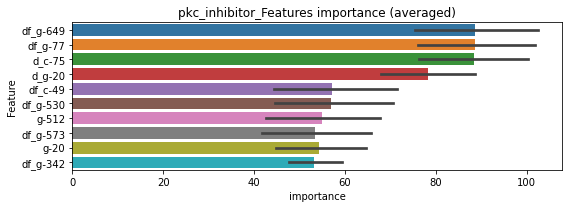

len(train_index) : 3894
len(valid_index) : 3894
================================= fold 1/2 pkc_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0172124	valid_1's binary_logloss: 0.0301828
[200]	training's binary_logloss: 0.0023344	valid_1's binary_logloss: 0.0101278
[300]	training's binary_logloss: 0.00062839	valid_1's binary_logloss: 0.00665865
[400]	training's binary_logloss: 0.00030467	valid_1's binary_logloss: 0.00589544
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.00022087	valid_1's binary_logloss: 0.00566118


len(train_index) : 3894
len(valid_index) : 3894
================================= fold 2/2 pkc_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.018524	valid_1's binary_logloss: 0.0273074
[200]	training's binary_logloss: 0.00245651	valid_1's binary_logloss: 0.00705912
[300]	training's binary_logloss: 0.000648792	valid_1's binary_logloss: 0.00368299
[400]	training's binary_logloss: 0.000315349	valid_1's binary_logloss: 0.00299236
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000237261	valid_1's binary_logloss: 0.00278398


pkc_inhibitor logloss: 0.004222579037214059


neg labels: 3289 → selected neg labels: 3279


potassium_channel_activator, len(trt): 55, len(othr): 3279, target_rate: 0.0023096 → Adj_target_rate: 0.0025322
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0488148	valid_1's binary_logloss: 0.0881453
[200]	training's binary_logloss: 0.00867371	valid_1's binary_logloss: 0.0319622
[300]	training's binary_logloss: 0.00242574	valid_1's binary_logloss: 0.017143
[400]	training's binary_logloss: 0.00111884	valid_1's binary_logloss: 0.0124742
[500]	training's binary_logloss: 0.000708105	valid_1's binary_logloss: 0.0107258
Early stopping, best iteration is:
[582]	training's binary_logloss: 0.000556541	valid_1's binary_logloss: 0.00993924
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0470912	valid_1's binary_logloss: 0.10159
[200]	training's binary_logloss: 0.00857706	valid_1's binary_logloss: 0.0572706
Early stopping, best iteration is:
[282]	training's binary_logloss: 0.00284128	valid_1's binary_logloss: 0.0490506


1 / 3 AUC score:0.999
y_Threshold: 0.0132403, Threshold: 0.0216579, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 142 → Positive_corect_labels: 650/3792
p_label_rate: 0.0200904 Vs.target_rate: 0.00231
Num_p_label: 80.0, conf_0:0.01949, conf_1:0.02382
Num_p_label: 80.0, Expected: 9.2, Adj_threshold_1: 0.0216579
Num_p_label: 31.0, Expected: 9.2, Adj_threshold_2: 0.0316579
Num_p_label: 19.0, Expected: 9.2, Adj_threshold_3: 0.0416579
Num_p_label: 14.0, Expected: 9.2, Adj_threshold_4: 0.0516579
threshold: 0.0516579, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 650.0/3792, y_label_rate: 0.1714135
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0459213	valid_1's binary_logloss: 0.0835892
[200]	training's binary_logloss: 0.00843825	valid_1's binary_logloss: 0.0338272
[300]	training's binary_logloss: 0.00233972	valid_1's binary_logloss: 0.021536
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.00134989	valid_1's binary_logloss: 0.0197067
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.046085	valid_1's binary_logloss: 0.0836567
[200]	training's binary_logloss: 0.00832171	valid_1's binary_logloss: 0.0326108
[300]	training's binary_logloss: 0.00236165	valid_1's binary_logloss: 0.0191616
[400]	training's binary_logloss: 0.00109635	valid_1's binary_logloss: 0.0154381
[500]	training's binary_logloss: 0.000685272	valid_1's binary_logloss: 0.01383
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.000571231	valid_1's binary_logloss: 0.013457


2 / 3 AUC score:1.000
y_Threshold: 0.0432619, Threshold: 0.0516579, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 646.0/3784
p_label_rate: 0.0055249 Vs.target_rate: 0.00231
Num_p_label: 22.0, conf_0:0.04649, conf_1:0.05682
threshold: 0.0516579, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 646.0/3784, y_label_rate: 0.1707188
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.045112	valid_1's binary_logloss: 0.0947417
[200]	training's binary_logloss: 0.00804274	valid_1's binary_logloss: 0.0504083
[300]	training's binary_logloss: 0.0022718	valid_1's binary_logloss: 0.0429287
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.00179238	valid_1's binary_logloss: 0.0422519
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0459124	valid_1's binary_logloss: 0.0853462
[200]	training's binary_logloss: 0.00818159	valid_1's binary_logloss: 0.0336714
[300]	training's binary_logloss: 0.00230281	valid_1's binary_logloss: 0.0215608
[400]	training's binary_logloss: 0.00109103	valid_1's binary_logloss: 0.0182165
[500]	training's binary_logloss: 0.000675229	valid_1's binary_logloss: 0.0166972
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000663257	valid_1's binary_logloss: 0.0166614


3 / 3 AUC score:1.000
y_Threshold: 0.0340902, Threshold: 0.0516579, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 18 → Positive_corect_labels: 637.0/3766
p_label_rate: 0.0072828 Vs.target_rate: 0.00231
Num_p_label: 29.0, conf_0:0.04649, conf_1:0.05682
Num_p_label: 29.0, Expected: 9.2, Adj_threshold_1: 0.0516579
Num_p_label: 23.0, Expected: 9.2, Adj_threshold_2: 0.0616579
Num_p_label: 17.0, Expected: 9.2, Adj_threshold_3: 0.0716579
threshold: 0.0716579, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 654.0/7748, y_label_rate: 0.0844089


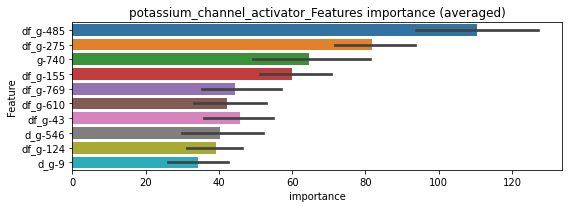

len(train_index) : 3874
len(valid_index) : 3874
================================= fold 1/2 potassium_channel_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0273935	valid_1's binary_logloss: 0.0534567
[200]	training's binary_logloss: 0.00503517	valid_1's binary_logloss: 0.0252648
[300]	training's binary_logloss: 0.00137794	valid_1's binary_logloss: 0.0196288
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.000835311	valid_1's binary_logloss: 0.0189678


len(train_index) : 3874
len(valid_index) : 3874
================================= fold 2/2 potassium_channel_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0273646	valid_1's binary_logloss: 0.0519433
[200]	training's binary_logloss: 0.00516333	valid_1's binary_logloss: 0.0242922
[300]	training's binary_logloss: 0.00144192	valid_1's binary_logloss: 0.0179558
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.000724693	valid_1's binary_logloss: 0.0163563


potassium_channel_activator logloss: 0.017662053609962772


neg labels: 3289 → selected neg labels: 3272


potassium_channel_antagonist, len(trt): 98, len(othr): 3272, target_rate: 0.0041152 → Adj_target_rate: 0.0041375
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0626817	valid_1's binary_logloss: 0.152066
[200]	training's binary_logloss: 0.0159454	valid_1's binary_logloss: 0.100654
[300]	training's binary_logloss: 0.0046785	valid_1's binary_logloss: 0.0825658
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.00217764	valid_1's binary_logloss: 0.0782342
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0667116	valid_1's binary_logloss: 0.145053
[200]	training's binary_logloss: 0.0164419	valid_1's binary_logloss: 0.0938277
[300]	training's binary_logloss: 0.00507004	valid_1's binary_logloss: 0.0823851
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.00501276	valid_1's binary_logloss: 0.0823577


1 / 3 AUC score:0.989
y_Threshold: 0.0233942, Threshold: 0.0291446, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 180 → Positive_corect_labels: 630/3746
p_label_rate: 0.0200904 Vs.target_rate: 0.00412
Num_p_label: 80.0, conf_0:0.02623, conf_1:0.03206
Num_p_label: 80.0, Expected: 16.4, Adj_threshold_1: 0.0291446
Num_p_label: 45.0, Expected: 16.4, Adj_threshold_2: 0.0391446
Num_p_label: 25.0, Expected: 16.4, Adj_threshold_3: 0.0491446
threshold: 0.0491446, positive_p_label: 25.0/3982, p_label_rate: 0.0062783
positive_y_label: 630.0/3746, y_label_rate: 0.1681794
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0560472	valid_1's binary_logloss: 0.131746
[200]	training's binary_logloss: 0.0131112	valid_1's binary_logloss: 0.089748
[300]	training's binary_logloss: 0.00394526	valid_1's binary_logloss: 0.0809781
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00242866	valid_1's binary_logloss: 0.0796979
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0614012	valid_1's binary_logloss: 0.135514
[200]	training's binary_logloss: 0.0136724	valid_1's binary_logloss: 0.0832791
[300]	training's binary_logloss: 0.00412224	valid_1's binary_logloss: 0.0712277
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00286031	valid_1's binary_logloss: 0.0692805


2 / 3 AUC score:0.991
y_Threshold: 0.0344962, Threshold: 0.0491446, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 54 → Positive_corect_labels: 603.0/3692
p_label_rate: 0.0113009 Vs.target_rate: 0.00412
Num_p_label: 45.0, conf_0:0.04423, conf_1:0.05406
threshold: 0.0491446, positive_p_label: 45.0/3982, p_label_rate: 0.0113009
positive_y_label: 603.0/3692, y_label_rate: 0.1633261
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0562938	valid_1's binary_logloss: 0.118777
[200]	training's binary_logloss: 0.012354	valid_1's binary_logloss: 0.0718445
[300]	training's binary_logloss: 0.00381915	valid_1's binary_logloss: 0.0618984
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.00342754	valid_1's binary_logloss: 0.0613523
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0554879	valid_1's binary_logloss: 0.128945
[200]	training's binary_logloss: 0.0124175	valid_1's binary_logloss: 0.0811647
[300]	training's binary_logloss: 0.00382514	valid_1's binary_logloss: 0.0705644
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.0025399	valid_1's binary_logloss: 0.0686645


3 / 3 AUC score:0.997
y_Threshold: 0.0551427, Threshold: 0.0491446, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 50 → Positive_corect_labels: 578.0/3642
p_label_rate: 0.0143144 Vs.target_rate: 0.00412
Num_p_label: 57.0, conf_0:0.04423, conf_1:0.05406
Num_p_label: 57.0, Expected: 16.4, Adj_threshold_1: 0.0491446
Num_p_label: 36.0, Expected: 16.4, Adj_threshold_2: 0.0591446
Num_p_label: 28.0, Expected: 16.4, Adj_threshold_3: 0.0691446
threshold: 0.0691446, positive_p_label: 28.0/3982, p_label_rate: 0.0070316
positive_y_label: 606.0/7624, y_label_rate: 0.0794858


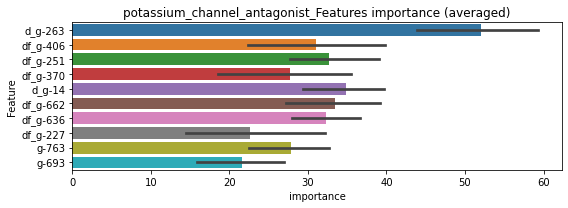

len(train_index) : 3812
len(valid_index) : 3812
================================= fold 1/2 potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0298676	valid_1's binary_logloss: 0.0685232
[200]	training's binary_logloss: 0.00670697	valid_1's binary_logloss: 0.0430468
[300]	training's binary_logloss: 0.00200856	valid_1's binary_logloss: 0.0381162
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.00219849	valid_1's binary_logloss: 0.0380345


len(train_index) : 3812
len(valid_index) : 3812
================================= fold 2/2 potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0277573	valid_1's binary_logloss: 0.0760015
[200]	training's binary_logloss: 0.00612784	valid_1's binary_logloss: 0.0538291
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00254568	valid_1's binary_logloss: 0.0510685


potassium_channel_antagonist logloss: 0.04455151665471191


neg labels: 3289 → selected neg labels: 3269


ppar_receptor_agonist, len(trt): 115, len(othr): 3269, target_rate: 0.0048291 → Adj_target_rate: 0.0047401
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0604979	valid_1's binary_logloss: 0.157008
[200]	training's binary_logloss: 0.0125932	valid_1's binary_logloss: 0.111572
[300]	training's binary_logloss: 0.00384008	valid_1's binary_logloss: 0.104937
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.00345327	valid_1's binary_logloss: 0.104655
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0597826	valid_1's binary_logloss: 0.155232
[200]	training's binary_logloss: 0.0133898	valid_1's binary_logloss: 0.109981
[300]	training's binary_logloss: 0.00411794	valid_1's binary_logloss: 0.102278
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.00379182	valid_1's binary_logloss: 0.102091


1 / 3 AUC score:0.983
y_Threshold: 0.0234981, Threshold: 0.0677488, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 200 → Positive_corect_labels: 619/3722
p_label_rate: 0.0200904 Vs.target_rate: 0.00483
Num_p_label: 80.0, conf_0:0.06097, conf_1:0.07452
Num_p_label: 80.0, Expected: 19.2, Adj_threshold_1: 0.0677488
Num_p_label: 69.0, Expected: 19.2, Adj_threshold_2: 0.0777488
Num_p_label: 58.0, Expected: 19.2, Adj_threshold_3: 0.0877488
Num_p_label: 52.0, Expected: 19.2, Adj_threshold_4: 0.0977488
Num_p_label: 49.0, Expected: 19.2, Adj_threshold_5: 0.1077488
Num_p_label: 45.0, Expected: 19.2, Adj_threshold_6: 0.1177488
Num_p_label: 39.0, Expected: 19.2, Adj_threshold_7: 0.1277488
Num_p_label: 33.0, Expected: 19.2, Adj_threshold_8: 0.1377488
threshold: 0.1377488, positive_p_label: 33.0/3982, p_label_rate: 0.0082873
positive_y_label: 619.0/3722, y_label_rate: 0.1663084
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0523647	valid_1's binary_logloss: 0.146362
[200]	training's binary_logloss: 0.0101972	valid_1's binary_logloss: 0.106947
[300]	training's binary_logloss: 0.00312188	valid_1's binary_logloss: 0.0991369
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.00315431	valid_1's binary_logloss: 0.0989234
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0529121	valid_1's binary_logloss: 0.127525
[200]	training's binary_logloss: 0.0109274	valid_1's binary_logloss: 0.0780421
[300]	training's binary_logloss: 0.00339863	valid_1's binary_logloss: 0.0676715
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.00255596	valid_1's binary_logloss: 0.0660119


2 / 3 AUC score:0.993
y_Threshold: 0.0455354, Threshold: 0.1377488, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 60 → Positive_corect_labels: 589.0/3662
p_label_rate: 0.0193370 Vs.target_rate: 0.00483
Num_p_label: 77.0, conf_0:0.12397, conf_1:0.15152
Num_p_label: 77.0, Expected: 19.2, Adj_threshold_1: 0.1377488
Num_p_label: 73.0, Expected: 19.2, Adj_threshold_2: 0.1477488
Num_p_label: 72.0, Expected: 19.2, Adj_threshold_3: 0.1577488
Num_p_label: 68.0, Expected: 19.2, Adj_threshold_4: 0.1677488
Num_p_label: 61.0, Expected: 19.2, Adj_threshold_5: 0.1777488
Num_p_label: 59.0, Expected: 19.2, Adj_threshold_6: 0.1877488
Num_p_label: 58.0, Expected: 19.2, Adj_threshold_7: 0.1977488
Num_p_label: 55.0, Expected: 19.2, Adj_threshold_8: 0.2077488
Num_p_label: 50.0, Expected: 19.2, Adj_threshold_9: 0.2177488
Num_p_label: 49.0, Expected: 19.2, Adj_threshold_10: 0.2277488
threshold: 0.2377488, positive_p_label: 46.0/3982, p_label_rate: 0.0115520
positive_y_label: 589.0/3662, y_label_rate: 0.160841

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0475918	valid_1's binary_logloss: 0.132401
[200]	training's binary_logloss: 0.00928737	valid_1's binary_logloss: 0.0884071
[300]	training's binary_logloss: 0.00280268	valid_1's binary_logloss: 0.0786731
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00266925	valid_1's binary_logloss: 0.078418
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0488779	valid_1's binary_logloss: 0.12467
[200]	training's binary_logloss: 0.00948766	valid_1's binary_logloss: 0.0826851
[300]	training's binary_logloss: 0.0029213	valid_1's binary_logloss: 0.0733769
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00214254	valid_1's binary_logloss: 0.0722916


3 / 3 AUC score:0.993
y_Threshold: 0.0422977, Threshold: 0.2377488, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 58 → Positive_corect_labels: 560.0/3604
p_label_rate: 0.0163235 Vs.target_rate: 0.00483
Num_p_label: 65.0, conf_0:0.21397, conf_1:0.26152
Num_p_label: 65.0, Expected: 19.2, Adj_threshold_1: 0.2377488
Num_p_label: 64.0, Expected: 19.2, Adj_threshold_2: 0.2477488
Num_p_label: 61.0, Expected: 19.2, Adj_threshold_3: 0.2577488
Num_p_label: 59.0, Expected: 19.2, Adj_threshold_4: 0.2677488
Num_p_label: 56.0, Expected: 19.2, Adj_threshold_5: 0.2777488
Num_p_label: 50.0, Expected: 19.2, Adj_threshold_6: 0.2877488
Num_p_label: 48.0, Expected: 19.2, Adj_threshold_7: 0.2977488
Num_p_label: 48.0, Expected: 19.2, Adj_threshold_8: 0.3077488
Num_p_label: 46.0, Expected: 19.2, Adj_threshold_9: 0.3177488
Num_p_label: 44.0, Expected: 19.2, Adj_threshold_10: 0.3277488
threshold: 0.3377488, positive_p_label: 42.0/3982, p_label_rate: 0.0105475
positive_y_label: 602.0/7586, y_label_rate: 0.079356

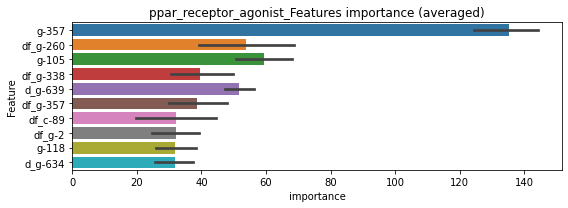

len(train_index) : 3793
len(valid_index) : 3793
================================= fold 1/2 ppar_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0266625	valid_1's binary_logloss: 0.0840879
[200]	training's binary_logloss: 0.00565204	valid_1's binary_logloss: 0.0612238
[300]	training's binary_logloss: 0.00150574	valid_1's binary_logloss: 0.0546034
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.00127207	valid_1's binary_logloss: 0.0541203


len(train_index) : 3793
len(valid_index) : 3793
================================= fold 2/2 ppar_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0253693	valid_1's binary_logloss: 0.0748628
[200]	training's binary_logloss: 0.00483917	valid_1's binary_logloss: 0.0512517
Early stopping, best iteration is:
[262]	training's binary_logloss: 0.00221311	valid_1's binary_logloss: 0.0477494


ppar_receptor_agonist logloss: 0.05093484876591759


neg labels: 3289 → selected neg labels: 3284


ppar_receptor_antagonist, len(trt): 30, len(othr): 3284, target_rate: 0.0012598 → Adj_target_rate: 0.0015127
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031998	valid_1's binary_logloss: 0.0498488
[200]	training's binary_logloss: 0.00445002	valid_1's binary_logloss: 0.0125801
[300]	training's binary_logloss: 0.00123547	valid_1's binary_logloss: 0.00591023
[400]	training's binary_logloss: 0.000606641	valid_1's binary_logloss: 0.00417218
[500]	training's binary_logloss: 0.000423717	valid_1's binary_logloss: 0.00361559
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000409621	valid_1's binary_logloss: 0.00358893
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0316789	valid_1's binary_logloss: 0.0560061
[200]	training's binary_logloss: 0.00438527	valid_1's binary_logloss: 0.0173671
[300]	training's binary_logloss: 0.00120615	valid_1's binary_logloss: 0.0086377
[400]	training's binary_logloss: 0.000600467	valid_1's binary_logloss: 0.00652401
Early stopping, best iteration is:
[4

1 / 3 AUC score:1.000
y_Threshold: 0.0031755, Threshold: 0.0053406, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00126
Num_p_label: 80.0, conf_0:0.00481, conf_1:0.00587
Num_p_label: 80.0, Expected: 5.0, Adj_threshold_1: 0.0053406
Num_p_label: 11.0, Expected: 5.0, Adj_threshold_2: 0.0153406
Num_p_label: 4.0, Expected: 5.0, Adj_threshold_3: 0.0253406
threshold: 0.0253406, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304624	valid_1's binary_logloss: 0.0458263
[200]	training's binary_logloss: 0.00417346	valid_1's binary_logloss: 0.0107043
[300]	training's binary_logloss: 0.00116989	valid_1's binary_logloss: 0.00462933
[400]	training's binary_logloss: 0.000590011	valid_1's binary_logloss: 0.00298002
[500]	training's binary_logloss: 0.00041929	valid_1's binary_logloss: 0.00247743
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.000404665	valid_1's binary_logloss: 0.0024468
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0306852	valid_1's binary_logloss: 0.0508081
[200]	training's binary_logloss: 0.00421673	valid_1's binary_logloss: 0.0150226
[300]	training's binary_logloss: 0.00119721	valid_1's binary_logloss: 0.00735893
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.000634516	valid_1's binary_logloss: 0.00546046


2 / 3 AUC score:1.000
y_Threshold: 0.0634506, Threshold: 0.0253406, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0055249 Vs.target_rate: 0.00126
Num_p_label: 22.0, conf_0:0.02281, conf_1:0.02787
Num_p_label: 22.0, Expected: 5.0, Adj_threshold_1: 0.0253406
Num_p_label: 10.0, Expected: 5.0, Adj_threshold_2: 0.0353406
threshold: 0.0353406, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304624	valid_1's binary_logloss: 0.0458263
[200]	training's binary_logloss: 0.00417346	valid_1's binary_logloss: 0.0107043
[300]	training's binary_logloss: 0.00116989	valid_1's binary_logloss: 0.00462933
[400]	training's binary_logloss: 0.000590011	valid_1's binary_logloss: 0.00298002
[500]	training's binary_logloss: 0.00041929	valid_1's binary_logloss: 0.00247743
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.000404665	valid_1's binary_logloss: 0.0024468
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0306852	valid_1's binary_logloss: 0.0508081
[200]	training's binary_logloss: 0.00421673	valid_1's binary_logloss: 0.0150226
[300]	training's binary_logloss: 0.00119721	valid_1's binary_logloss: 0.00735893
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.000634516	valid_1's binary_logloss: 0.00546046


3 / 3 AUC score:1.000
y_Threshold: 0.0634506, Threshold: 0.0353406, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0025113 Vs.target_rate: 0.00126
Num_p_label: 10.0, conf_0:0.03181, conf_1:0.03887
threshold: 0.0353406, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 666.0/7790, y_label_rate: 0.0854942


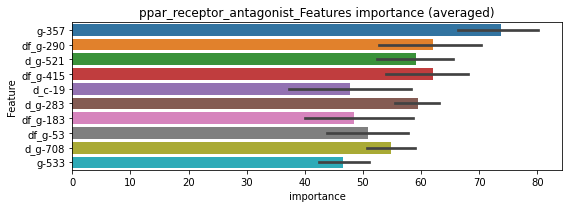

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0175354	valid_1's binary_logloss: 0.033629
[200]	training's binary_logloss: 0.00247573	valid_1's binary_logloss: 0.0141611
Early stopping, best iteration is:
[232]	training's binary_logloss: 0.00152004	valid_1's binary_logloss: 0.0128752


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182445	valid_1's binary_logloss: 0.0341007
[200]	training's binary_logloss: 0.00255358	valid_1's binary_logloss: 0.0143592
[300]	training's binary_logloss: 0.000699377	valid_1's binary_logloss: 0.0102261
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.000410569	valid_1's binary_logloss: 0.00933888


ppar_receptor_antagonist logloss: 0.011107031868632029


neg labels: 3289 → selected neg labels: 3271


progesterone_receptor_agonist, len(trt): 119, len(othr): 3271, target_rate: 0.0049971 → Adj_target_rate: 0.0048799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0619205	valid_1's binary_logloss: 0.158475
[200]	training's binary_logloss: 0.015127	valid_1's binary_logloss: 0.117308
[300]	training's binary_logloss: 0.00456197	valid_1's binary_logloss: 0.109813
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00456197	valid_1's binary_logloss: 0.109813
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0613916	valid_1's binary_logloss: 0.16119
[200]	training's binary_logloss: 0.0144445	valid_1's binary_logloss: 0.128114
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00777765	valid_1's binary_logloss: 0.12459


1 / 3 AUC score:0.974
y_Threshold: 0.0298375, Threshold: 0.0459056, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 229 → Positive_corect_labels: 605/3696
p_label_rate: 0.0200904 Vs.target_rate: 0.00500
Num_p_label: 80.0, conf_0:0.04132, conf_1:0.05050
Num_p_label: 80.0, Expected: 19.9, Adj_threshold_1: 0.0459056
Num_p_label: 60.0, Expected: 19.9, Adj_threshold_2: 0.0559056
Num_p_label: 39.0, Expected: 19.9, Adj_threshold_3: 0.0659056
threshold: 0.0659056, positive_p_label: 39.0/3982, p_label_rate: 0.0097941
positive_y_label: 605.0/3696, y_label_rate: 0.1636905
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0504788	valid_1's binary_logloss: 0.136672
[200]	training's binary_logloss: 0.0108476	valid_1's binary_logloss: 0.0967139
[300]	training's binary_logloss: 0.00333506	valid_1's binary_logloss: 0.0903121
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.00347439	valid_1's binary_logloss: 0.0902598
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0538167	valid_1's binary_logloss: 0.132141
[200]	training's binary_logloss: 0.01166	valid_1's binary_logloss: 0.0915159
Early stopping, best iteration is:
[277]	training's binary_logloss: 0.00446039	valid_1's binary_logloss: 0.083788


2 / 3 AUC score:0.992
y_Threshold: 0.0480669, Threshold: 0.0659056, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 68 → Positive_corect_labels: 571.0/3628
p_label_rate: 0.0190859 Vs.target_rate: 0.00500
Num_p_label: 76.0, conf_0:0.05932, conf_1:0.07250
Num_p_label: 76.0, Expected: 19.9, Adj_threshold_1: 0.0659056
Num_p_label: 57.0, Expected: 19.9, Adj_threshold_2: 0.0759056
Num_p_label: 44.0, Expected: 19.9, Adj_threshold_3: 0.0859056
Num_p_label: 37.0, Expected: 19.9, Adj_threshold_4: 0.0959056
threshold: 0.0959056, positive_p_label: 37.0/3982, p_label_rate: 0.0092918
positive_y_label: 571.0/3628, y_label_rate: 0.1573870
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0477047	valid_1's binary_logloss: 0.122143
[200]	training's binary_logloss: 0.00977262	valid_1's binary_logloss: 0.0779729
[300]	training's binary_logloss: 0.00301504	valid_1's binary_logloss: 0.0691826
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.00279533	valid_1's binary_logloss: 0.0689106
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.047391	valid_1's binary_logloss: 0.107721
[200]	training's binary_logloss: 0.00982099	valid_1's binary_logloss: 0.0597484
[300]	training's binary_logloss: 0.00301372	valid_1's binary_logloss: 0.0485737
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00155456	valid_1's binary_logloss: 0.0451129


3 / 3 AUC score:0.997
y_Threshold: 0.0454543, Threshold: 0.0959056, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 40 → Positive_corect_labels: 551.0/3588
p_label_rate: 0.0095429 Vs.target_rate: 0.00500
Num_p_label: 38.0, conf_0:0.08632, conf_1:0.10550
threshold: 0.0959056, positive_p_label: 38.0/3982, p_label_rate: 0.0095429
positive_y_label: 589.0/7570, y_label_rate: 0.0778071


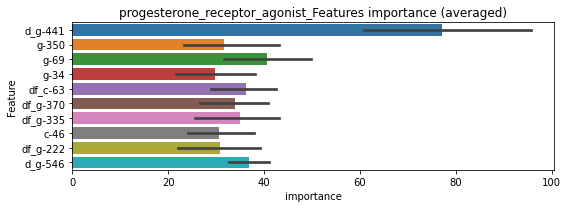

len(train_index) : 3785
len(valid_index) : 3785
================================= fold 1/2 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271816	valid_1's binary_logloss: 0.0728254
[200]	training's binary_logloss: 0.00537461	valid_1's binary_logloss: 0.049638
[300]	training's binary_logloss: 0.00163392	valid_1's binary_logloss: 0.0448715
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00125309	valid_1's binary_logloss: 0.0442938


len(train_index) : 3785
len(valid_index) : 3785
================================= fold 2/2 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0273484	valid_1's binary_logloss: 0.0740164
[200]	training's binary_logloss: 0.00569492	valid_1's binary_logloss: 0.0512291
[300]	training's binary_logloss: 0.00171852	valid_1's binary_logloss: 0.0467273
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00156271	valid_1's binary_logloss: 0.0466143


progesterone_receptor_agonist logloss: 0.04545406359485294


neg labels: 3289 → selected neg labels: 3286


progesterone_receptor_antagonist, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0216785	valid_1's binary_logloss: 0.027621
[200]	training's binary_logloss: 0.00239707	valid_1's binary_logloss: 0.00421507
[300]	training's binary_logloss: 0.000671353	valid_1's binary_logloss: 0.00150753
[400]	training's binary_logloss: 0.000356274	valid_1's binary_logloss: 0.000933684
[500]	training's binary_logloss: 0.000296148	valid_1's binary_logloss: 0.000820714
Early stopping, best iteration is:
[506]	training's binary_logloss: 0.0002941	valid_1's binary_logloss: 0.000815663
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0219555	valid_1's binary_logloss: 0.0286669
[200]	training's binary_logloss: 0.00241186	valid_1's binary_logloss: 0.00433163
[300]	training's binary_logloss: 0.000672542	valid_1's binary_logloss: 0.00155851
[400]	training's binary_logloss: 0.000363512	valid_1's binary_logloss: 0.000940627
[500]	training's binary_loglos

1 / 3 AUC score:1.000
y_Threshold: 0.0014545, Threshold: 0.0024850, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00224, conf_1:0.00273
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0024850
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_2: 0.0124850
threshold: 0.0124850, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0216422	valid_1's binary_logloss: 0.0277373
[200]	training's binary_logloss: 0.00235016	valid_1's binary_logloss: 0.00403611
[300]	training's binary_logloss: 0.000659338	valid_1's binary_logloss: 0.00138224
[400]	training's binary_logloss: 0.000354831	valid_1's binary_logloss: 0.000837989
[500]	training's binary_logloss: 0.000292472	valid_1's binary_logloss: 0.000729939
Early stopping, best iteration is:
[539]	training's binary_logloss: 0.000288595	valid_1's binary_logloss: 0.000726035
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221142	valid_1's binary_logloss: 0.0275598
[200]	training's binary_logloss: 0.00239508	valid_1's binary_logloss: 0.00361093
[300]	training's binary_logloss: 0.000660647	valid_1's binary_logloss: 0.00117349
[400]	training's binary_logloss: 0.000358353	valid_1's binary_logloss: 0.000686478
[500]	training's binary_log

2 / 3 AUC score:1.000
y_Threshold: 0.1466002, Threshold: 0.0124850, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0065294 Vs.target_rate: 0.00076
Num_p_label: 26.0, conf_0:0.01124, conf_1:0.01373
Num_p_label: 26.0, Expected: 3.0, Adj_threshold_1: 0.0124850
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_2: 0.0224850
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_3: 0.0324850
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_4: 0.0424850
threshold: 0.0424850, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0216422	valid_1's binary_logloss: 0.0277373
[200]	training's binary_logloss: 0.00235016	valid_1's binary_logloss: 0.00403611
[300]	training's binary_logloss: 0.000659338	valid_1's binary_logloss: 0.00138224
[400]	training's binary_logloss: 0.000354831	valid_1's binary_logloss: 0.000837989
[500]	training's binary_logloss: 0.000292472	valid_1's binary_logloss: 0.000729939
Early stopping, best iteration is:
[542]	training's binary_logloss: 0.000288595	valid_1's binary_logloss: 0.000726035
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221142	valid_1's binary_logloss: 0.0275598
[200]	training's binary_logloss: 0.00239508	valid_1's binary_logloss: 0.00361093
[300]	training's binary_logloss: 0.000660647	valid_1's binary_logloss: 0.00117349
[400]	training's binary_logloss: 0.000358353	valid_1's binary_logloss: 0.000686478
[500]	training's binary_log

3 / 3 AUC score:1.000
y_Threshold: 0.1466002, Threshold: 0.0424850, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0010045 Vs.target_rate: 0.00076
Num_p_label: 4.0, conf_0:0.03824, conf_1:0.04673
threshold: 0.0424850, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 661.0/7793, y_label_rate: 0.0848197


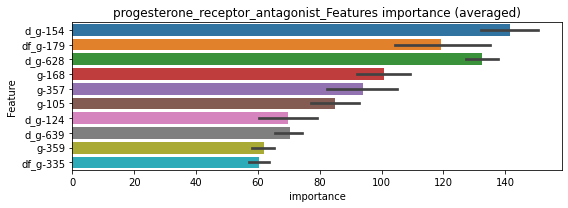

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0116802	valid_1's binary_logloss: 0.0190441
[200]	training's binary_logloss: 0.00126389	valid_1's binary_logloss: 0.00642475
[300]	training's binary_logloss: 0.000339134	valid_1's binary_logloss: 0.00503935
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.000232369	valid_1's binary_logloss: 0.00493755


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0116451	valid_1's binary_logloss: 0.0146533
[200]	training's binary_logloss: 0.00130585	valid_1's binary_logloss: 0.00253901
[300]	training's binary_logloss: 0.000362629	valid_1's binary_logloss: 0.00145008
[400]	training's binary_logloss: 0.00019043	valid_1's binary_logloss: 0.00131792
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.000187088	valid_1's binary_logloss: 0.00131492


progesterone_receptor_antagonist logloss: 0.003126465758045001


neg labels: 3289 → selected neg labels: 3283


prostaglandin_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0355009	valid_1's binary_logloss: 0.0614686
[200]	training's binary_logloss: 0.00554607	valid_1's binary_logloss: 0.0212933
[300]	training's binary_logloss: 0.00153043	valid_1's binary_logloss: 0.0127109
[400]	training's binary_logloss: 0.000733452	valid_1's binary_logloss: 0.00930666
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.000733452	valid_1's binary_logloss: 0.00930666
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0355717	valid_1's binary_logloss: 0.0702533
[200]	training's binary_logloss: 0.00539483	valid_1's binary_logloss: 0.0329388
[300]	training's binary_logloss: 0.0014841	valid_1's binary_logloss: 0.0243701
[400]	training's binary_logloss: 0.000716855	valid_1's binary_logloss: 0.0225138
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000757683	valid_1's binary_logloss: 0.0223702


1 / 3 AUC score:1.000
y_Threshold: 0.0056070, Threshold: 0.0079204, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151
Num_p_label: 80.0, conf_0:0.00713, conf_1:0.00871
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0079204
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_2: 0.0179204
Num_p_label: 9.0, Expected: 6.0, Adj_threshold_3: 0.0279204
threshold: 0.0279204, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.035518	valid_1's binary_logloss: 0.0576349
[200]	training's binary_logloss: 0.00549166	valid_1's binary_logloss: 0.0181286
[300]	training's binary_logloss: 0.00152078	valid_1's binary_logloss: 0.00990214
[400]	training's binary_logloss: 0.000737836	valid_1's binary_logloss: 0.00741826
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.000562913	valid_1's binary_logloss: 0.0067539
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0332831	valid_1's binary_logloss: 0.0663907
[200]	training's binary_logloss: 0.00499627	valid_1's binary_logloss: 0.0327304
[300]	training's binary_logloss: 0.00140853	valid_1's binary_logloss: 0.0246751
[400]	training's binary_logloss: 0.000692943	valid_1's binary_logloss: 0.0224326
[500]	training's binary_logloss: 0.00046501	valid_1's binary_logloss: 0.0217892
Early stopping, best iteration is:
[490]	

2 / 3 AUC score:1.000
y_Threshold: 0.0147680, Threshold: 0.0279204, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 654.0/3803
p_label_rate: 0.0047715 Vs.target_rate: 0.00151
Num_p_label: 19.0, conf_0:0.02513, conf_1:0.03071
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_1: 0.0279204
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_2: 0.0379204
threshold: 0.0379204, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 654.0/3803, y_label_rate: 0.1719695
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0351891	valid_1's binary_logloss: 0.0527821
[200]	training's binary_logloss: 0.00525264	valid_1's binary_logloss: 0.012038
[300]	training's binary_logloss: 0.00147955	valid_1's binary_logloss: 0.00480538
[400]	training's binary_logloss: 0.000717758	valid_1's binary_logloss: 0.00291958
[500]	training's binary_logloss: 0.000484576	valid_1's binary_logloss: 0.00228537
[600]	training's binary_logloss: 0.000438636	valid_1's binary_logloss: 0.00217108
Early stopping, best iteration is:
[597]	training's binary_logloss: 0.000438649	valid_1's binary_logloss: 0.00217108
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339005	valid_1's binary_logloss: 0.0696646
[200]	training's binary_logloss: 0.00508381	valid_1's binary_logloss: 0.0275572
[300]	training's binary_logloss: 0.00144217	valid_1's binary_logloss: 0.0187309
[400]	training's binary_logloss: 0.00

3 / 3 AUC score:1.000
y_Threshold: 0.0246830, Threshold: 0.0379204, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 653.0/3801
p_label_rate: 0.0040181 Vs.target_rate: 0.00151
Num_p_label: 16.0, conf_0:0.03413, conf_1:0.04171
threshold: 0.0379204, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 669.0/7783, y_label_rate: 0.0859566


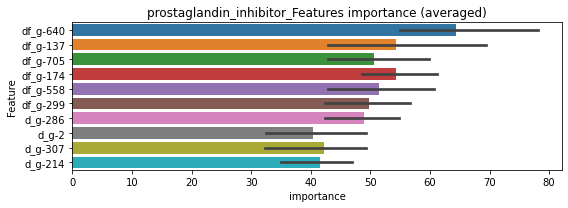

len(train_index) : 3891
len(valid_index) : 3892
================================= fold 1/2 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195769	valid_1's binary_logloss: 0.0395312
[200]	training's binary_logloss: 0.00300537	valid_1's binary_logloss: 0.0202623
Early stopping, best iteration is:
[236]	training's binary_logloss: 0.00175393	valid_1's binary_logloss: 0.0186867


len(train_index) : 3892
len(valid_index) : 3891
================================= fold 2/2 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197644	valid_1's binary_logloss: 0.0368305
[200]	training's binary_logloss: 0.00305865	valid_1's binary_logloss: 0.0158669
[300]	training's binary_logloss: 0.000854998	valid_1's binary_logloss: 0.0123883
[400]	training's binary_logloss: 0.000409614	valid_1's binary_logloss: 0.0115311
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.000428238	valid_1's binary_logloss: 0.011504


prostaglandin_inhibitor logloss: 0.015095818188216205


neg labels: 3289 → selected neg labels: 3274


prostanoid_receptor_antagonist, len(trt): 84, len(othr): 3274, target_rate: 0.0035273 → Adj_target_rate: 0.0036294
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0611859	valid_1's binary_logloss: 0.130877
[200]	training's binary_logloss: 0.0149895	valid_1's binary_logloss: 0.0778332
[300]	training's binary_logloss: 0.00439148	valid_1's binary_logloss: 0.0634554
[400]	training's binary_logloss: 0.00191006	valid_1's binary_logloss: 0.0595292
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00163191	valid_1's binary_logloss: 0.0590278
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.058557	valid_1's binary_logloss: 0.144345
[200]	training's binary_logloss: 0.0132473	valid_1's binary_logloss: 0.0999948
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.00700263	valid_1's binary_logloss: 0.0954794


1 / 3 AUC score:0.986
y_Threshold: 0.0227808, Threshold: 0.0336864, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 188 → Positive_corect_labels: 626/3740
p_label_rate: 0.0200904 Vs.target_rate: 0.00353
Num_p_label: 80.0, conf_0:0.03032, conf_1:0.03705
Num_p_label: 80.0, Expected: 14.0, Adj_threshold_1: 0.0336864
Num_p_label: 43.0, Expected: 14.0, Adj_threshold_2: 0.0436864
Num_p_label: 20.0, Expected: 14.0, Adj_threshold_3: 0.0536864
threshold: 0.0536864, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 626.0/3740, y_label_rate: 0.1673797
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.056549	valid_1's binary_logloss: 0.11759
[200]	training's binary_logloss: 0.0124985	valid_1's binary_logloss: 0.0637036
[300]	training's binary_logloss: 0.00366892	valid_1's binary_logloss: 0.047207
[400]	training's binary_logloss: 0.00161953	valid_1's binary_logloss: 0.0415187
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.00119476	valid_1's binary_logloss: 0.040399
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0568613	valid_1's binary_logloss: 0.114889
[200]	training's binary_logloss: 0.0120922	valid_1's binary_logloss: 0.0580539
[300]	training's binary_logloss: 0.00357255	valid_1's binary_logloss: 0.0440302
[400]	training's binary_logloss: 0.00159818	valid_1's binary_logloss: 0.0397117
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.00149561	valid_1's binary_logloss: 0.0393325


2 / 3 AUC score:0.998
y_Threshold: 0.0454138, Threshold: 0.0536864, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 32 → Positive_corect_labels: 610.0/3708
p_label_rate: 0.0050226 Vs.target_rate: 0.00353
Num_p_label: 20.0, conf_0:0.04832, conf_1:0.05905
threshold: 0.0536864, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 610.0/3708, y_label_rate: 0.1645092
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0540128	valid_1's binary_logloss: 0.108856
[200]	training's binary_logloss: 0.0117841	valid_1's binary_logloss: 0.0562681
[300]	training's binary_logloss: 0.0033984	valid_1's binary_logloss: 0.0417748
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00166956	valid_1's binary_logloss: 0.0378714
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0564745	valid_1's binary_logloss: 0.121953
[200]	training's binary_logloss: 0.0111203	valid_1's binary_logloss: 0.0672269
[300]	training's binary_logloss: 0.00326807	valid_1's binary_logloss: 0.0550442
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.00239236	valid_1's binary_logloss: 0.0537497


3 / 3 AUC score:0.998
y_Threshold: 0.0461376, Threshold: 0.0536864, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 30 → Positive_corect_labels: 595.0/3678
p_label_rate: 0.0080362 Vs.target_rate: 0.00353
Num_p_label: 32.0, conf_0:0.04832, conf_1:0.05905
threshold: 0.0536864, positive_p_label: 32.0/3982, p_label_rate: 0.0080362
positive_y_label: 627.0/7660, y_label_rate: 0.0818538


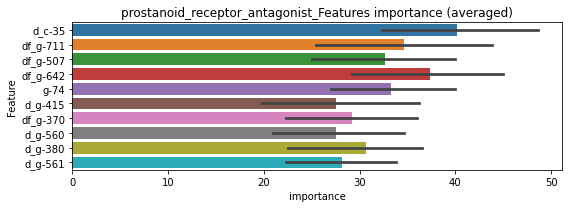

len(train_index) : 3830
len(valid_index) : 3830
================================= fold 1/2 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302839	valid_1's binary_logloss: 0.077103
[200]	training's binary_logloss: 0.00638334	valid_1's binary_logloss: 0.0502429
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00224222	valid_1's binary_logloss: 0.0459573


len(train_index) : 3830
len(valid_index) : 3830
================================= fold 2/2 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.030129	valid_1's binary_logloss: 0.083958
[200]	training's binary_logloss: 0.0063931	valid_1's binary_logloss: 0.0614821
Early stopping, best iteration is:
[254]	training's binary_logloss: 0.00300732	valid_1's binary_logloss: 0.0587314


prostanoid_receptor_antagonist logloss: 0.05234432639903311


neg labels: 3289 → selected neg labels: 3285


proteasome_inhibitor, len(trt): 726, len(othr): 3285, target_rate: 0.0304863 → Adj_target_rate: 0.0226983
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020511	valid_1's binary_logloss: 0.0228219
[200]	training's binary_logloss: 0.00187275	valid_1's binary_logloss: 0.005828
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.000705977	valid_1's binary_logloss: 0.00506317
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192197	valid_1's binary_logloss: 0.0267147
[200]	training's binary_logloss: 0.00177144	valid_1's binary_logloss: 0.0105635
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.00159017	valid_1's binary_logloss: 0.0104846


1 / 3 AUC score:1.000
y_Threshold: 0.0006787, Threshold: 0.9976514, pos_neg_ratio: 0.7789954
Remove_noisy_labels: 161 → Positive_corect_labels: 726/3850
p_label_rate: 0.0200904 Vs.target_rate: 0.03049
Num_p_label: 80.0, conf_0:0.89789, conf_1:1.09742
threshold: 0.9976514, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 726.0/3850, y_label_rate: 0.1885714
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155654	valid_1's binary_logloss: 0.0173734
[200]	training's binary_logloss: 0.00100333	valid_1's binary_logloss: 0.00337986
[300]	training's binary_logloss: 0.000221514	valid_1's binary_logloss: 0.00270015
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.000240893	valid_1's binary_logloss: 0.00268729
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156976	valid_1's binary_logloss: 0.0159893
[200]	training's binary_logloss: 0.00102378	valid_1's binary_logloss: 0.00109947
[300]	training's binary_logloss: 0.000225325	valid_1's binary_logloss: 0.000250535
[400]	training's binary_logloss: 0.000148482	valid_1's binary_logloss: 0.000168059
[500]	training's binary_logloss: 0.000134094	valid_1's binary_logloss: 0.00015265
[600]	training's binary_logloss: 0.000130921	valid_1's binary_logloss: 0.000149195
Early stopping, best iterati

2 / 3 AUC score:1.000
y_Threshold: 0.0130617, Threshold: 0.9976514, pos_neg_ratio: 0.7789954
Remove_noisy_labels: 0 → Positive_corect_labels: 726.0/3850
p_label_rate: 0.0379206 Vs.target_rate: 0.03049
Num_p_label: 151.0, conf_0:0.89789, conf_1:1.09742
threshold: 0.9976514, positive_p_label: 151.0/3982, p_label_rate: 0.0379206
positive_y_label: 726.0/3850, y_label_rate: 0.1885714
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155654	valid_1's binary_logloss: 0.0173734
[200]	training's binary_logloss: 0.00100333	valid_1's binary_logloss: 0.00337986
[300]	training's binary_logloss: 0.000221514	valid_1's binary_logloss: 0.00270015
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.000240893	valid_1's binary_logloss: 0.00268729
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156976	valid_1's binary_logloss: 0.0159893
[200]	training's binary_logloss: 0.00102378	valid_1's binary_logloss: 0.00109947
[300]	training's binary_logloss: 0.000225325	valid_1's binary_logloss: 0.000250535
[400]	training's binary_logloss: 0.000148482	valid_1's binary_logloss: 0.000168059
[500]	training's binary_logloss: 0.000134094	valid_1's binary_logloss: 0.00015265
[600]	training's binary_logloss: 0.000130921	valid_1's binary_logloss: 0.000149195
Early stopping, best iterati

3 / 3 AUC score:1.000
y_Threshold: 0.0130617, Threshold: 0.9976514, pos_neg_ratio: 0.7789954
Remove_noisy_labels: 0 → Positive_corect_labels: 726.0/3850
p_label_rate: 0.0379206 Vs.target_rate: 0.03049
Num_p_label: 151.0, conf_0:0.89789, conf_1:1.09742
threshold: 0.9976514, positive_p_label: 151.0/3982, p_label_rate: 0.0379206
positive_y_label: 877.0/7832, y_label_rate: 0.1119765


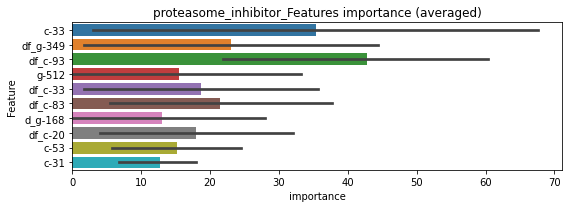

len(train_index) : 3916
len(valid_index) : 3916
================================= fold 1/2 proteasome_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0113382	valid_1's binary_logloss: 0.0122189
[200]	training's binary_logloss: 0.000926556	valid_1's binary_logloss: 0.00224634
[300]	training's binary_logloss: 0.000192217	valid_1's binary_logloss: 0.00186323
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.000205622	valid_1's binary_logloss: 0.00185081


len(train_index) : 3916
len(valid_index) : 3916
================================= fold 2/2 proteasome_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0108433	valid_1's binary_logloss: 0.0138199
[200]	training's binary_logloss: 0.000787859	valid_1's binary_logloss: 0.00509005
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.000787859	valid_1's binary_logloss: 0.00509005


proteasome_inhibitor logloss: 0.0034704305413533394


neg labels: 3289 → selected neg labels: 3281


protein_kinase_inhibitor, len(trt): 48, len(othr): 3281, target_rate: 0.0020156 → Adj_target_rate: 0.0022556
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0410977	valid_1's binary_logloss: 0.0850187
[200]	training's binary_logloss: 0.00698758	valid_1's binary_logloss: 0.0445943
[300]	training's binary_logloss: 0.00195837	valid_1's binary_logloss: 0.0361335
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.00171459	valid_1's binary_logloss: 0.0357612
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0418064	valid_1's binary_logloss: 0.0719944
[200]	training's binary_logloss: 0.00723825	valid_1's binary_logloss: 0.0271434
[300]	training's binary_logloss: 0.00206285	valid_1's binary_logloss: 0.01815
[400]	training's binary_logloss: 0.000961835	valid_1's binary_logloss: 0.0151487
[500]	training's binary_logloss: 0.000609717	valid_1's binary_logloss: 0.0144771
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000581547	valid_1's binary_logloss: 0.0143658


1 / 3 AUC score:0.998
y_Threshold: 0.0078433, Threshold: 0.0117948, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 144 → Positive_corect_labels: 650/3793
p_label_rate: 0.0200904 Vs.target_rate: 0.00202
Num_p_label: 80.0, conf_0:0.01062, conf_1:0.01297
Num_p_label: 80.0, Expected: 8.0, Adj_threshold_1: 0.0117948
Num_p_label: 29.0, Expected: 8.0, Adj_threshold_2: 0.0217948
Num_p_label: 12.0, Expected: 8.0, Adj_threshold_3: 0.0317948
threshold: 0.0317948, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 650.0/3793, y_label_rate: 0.1713683
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.040644	valid_1's binary_logloss: 0.0839889
[200]	training's binary_logloss: 0.00664824	valid_1's binary_logloss: 0.040722
[300]	training's binary_logloss: 0.00183736	valid_1's binary_logloss: 0.0309236
[400]	training's binary_logloss: 0.000884506	valid_1's binary_logloss: 0.0286199
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.000726492	valid_1's binary_logloss: 0.0281109
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0401893	valid_1's binary_logloss: 0.0646254
[200]	training's binary_logloss: 0.00670942	valid_1's binary_logloss: 0.0206821
[300]	training's binary_logloss: 0.00191061	valid_1's binary_logloss: 0.0116304
[400]	training's binary_logloss: 0.000916443	valid_1's binary_logloss: 0.00988403
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.00069864	valid_1's binary_logloss: 0.00939628


2 / 3 AUC score:1.000
y_Threshold: 0.0190687, Threshold: 0.0317948, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 644.0/3781
p_label_rate: 0.0072828 Vs.target_rate: 0.00202
Num_p_label: 29.0, conf_0:0.02862, conf_1:0.03497
Num_p_label: 29.0, Expected: 8.0, Adj_threshold_1: 0.0317948
Num_p_label: 18.0, Expected: 8.0, Adj_threshold_2: 0.0417948
Num_p_label: 11.0, Expected: 8.0, Adj_threshold_3: 0.0517948
threshold: 0.0517948, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 644.0/3781, y_label_rate: 0.1703253
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0391887	valid_1's binary_logloss: 0.0676494
[200]	training's binary_logloss: 0.00625531	valid_1's binary_logloss: 0.0237198
[300]	training's binary_logloss: 0.00181408	valid_1's binary_logloss: 0.0144767
[400]	training's binary_logloss: 0.000876109	valid_1's binary_logloss: 0.0115481
[500]	training's binary_logloss: 0.000573319	valid_1's binary_logloss: 0.0104418
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.000554622	valid_1's binary_logloss: 0.0103834
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0389135	valid_1's binary_logloss: 0.0743619
[200]	training's binary_logloss: 0.00630854	valid_1's binary_logloss: 0.0323903
[300]	training's binary_logloss: 0.00180372	valid_1's binary_logloss: 0.0247124
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.00136996	valid_1's binary_logloss: 0.0238566


3 / 3 AUC score:1.000
y_Threshold: 0.0323100, Threshold: 0.0517948, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 642.0/3777
p_label_rate: 0.0025113 Vs.target_rate: 0.00202
Num_p_label: 10.0, conf_0:0.04662, conf_1:0.05697
threshold: 0.0517948, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 652.0/7759, y_label_rate: 0.0840314


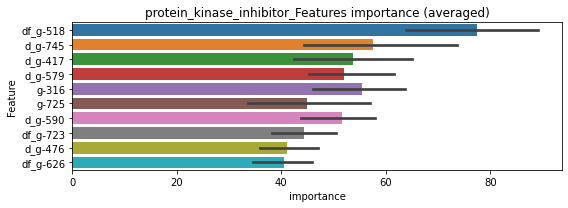

len(train_index) : 3879
len(valid_index) : 3880
================================= fold 1/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0220773	valid_1's binary_logloss: 0.0469812
[200]	training's binary_logloss: 0.00361844	valid_1's binary_logloss: 0.0232238
[300]	training's binary_logloss: 0.000990605	valid_1's binary_logloss: 0.0177629
[400]	training's binary_logloss: 0.000456068	valid_1's binary_logloss: 0.0166467
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.00047819	valid_1's binary_logloss: 0.016621


len(train_index) : 3880
len(valid_index) : 3879
================================= fold 2/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227101	valid_1's binary_logloss: 0.0430741
[200]	training's binary_logloss: 0.00395167	valid_1's binary_logloss: 0.0206782
[300]	training's binary_logloss: 0.00107456	valid_1's binary_logloss: 0.0169409
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.00057388	valid_1's binary_logloss: 0.0159947


protein_kinase_inhibitor logloss: 0.016307910294016598


neg labels: 3289 → selected neg labels: 3286


protein_phosphatase_inhibitor, len(trt): 24, len(othr): 3286, target_rate: 0.0010078 → Adj_target_rate: 0.0012513
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251535	valid_1's binary_logloss: 0.0353093
[200]	training's binary_logloss: 0.00307658	valid_1's binary_logloss: 0.0100645
[300]	training's binary_logloss: 0.00087164	valid_1's binary_logloss: 0.00629817
[400]	training's binary_logloss: 0.000451942	valid_1's binary_logloss: 0.00522834
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000366403	valid_1's binary_logloss: 0.00501127
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0246502	valid_1's binary_logloss: 0.045019
[200]	training's binary_logloss: 0.00303221	valid_1's binary_logloss: 0.0126548
[300]	training's binary_logloss: 0.00086273	valid_1's binary_logloss: 0.00786482
[400]	training's binary_logloss: 0.000449146	valid_1's binary_logloss: 0.00704314
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.000435014	valid_1's binary_logloss: 0.00695257


1 / 3 AUC score:1.000
y_Threshold: 0.0018703, Threshold: 0.0037845, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00101
Num_p_label: 80.0, conf_0:0.00341, conf_1:0.00416
Num_p_label: 80.0, Expected: 4.0, Adj_threshold_1: 0.0037845
Num_p_label: 17.0, Expected: 4.0, Adj_threshold_2: 0.0137845
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_3: 0.0237845
Num_p_label: 6.0, Expected: 4.0, Adj_threshold_4: 0.0337845
threshold: 0.0337845, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0247548	valid_1's binary_logloss: 0.0340111
[200]	training's binary_logloss: 0.00289559	valid_1's binary_logloss: 0.010384
[300]	training's binary_logloss: 0.000832833	valid_1's binary_logloss: 0.0072498
[400]	training's binary_logloss: 0.000439584	valid_1's binary_logloss: 0.0062281
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.000397223	valid_1's binary_logloss: 0.00613545
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0246056	valid_1's binary_logloss: 0.0427547
[200]	training's binary_logloss: 0.00287429	valid_1's binary_logloss: 0.0109369
[300]	training's binary_logloss: 0.000807953	valid_1's binary_logloss: 0.00642331
[400]	training's binary_logloss: 0.00043057	valid_1's binary_logloss: 0.00571596
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.000439161	valid_1's binary_logloss: 0.0056703


2 / 3 AUC score:1.000
y_Threshold: 0.0321290, Threshold: 0.0337845, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 656.0/3809
p_label_rate: 0.0113009 Vs.target_rate: 0.00101
Num_p_label: 45.0, conf_0:0.03041, conf_1:0.03716
Num_p_label: 45.0, Expected: 4.0, Adj_threshold_1: 0.0337845
Num_p_label: 39.0, Expected: 4.0, Adj_threshold_2: 0.0437845
Num_p_label: 34.0, Expected: 4.0, Adj_threshold_3: 0.0537845
Num_p_label: 28.0, Expected: 4.0, Adj_threshold_4: 0.0637845
Num_p_label: 23.0, Expected: 4.0, Adj_threshold_5: 0.0737845
Num_p_label: 17.0, Expected: 4.0, Adj_threshold_6: 0.0837845
Num_p_label: 14.0, Expected: 4.0, Adj_threshold_7: 0.0937845
Num_p_label: 14.0, Expected: 4.0, Adj_threshold_8: 0.1037845
Num_p_label: 14.0, Expected: 4.0, Adj_threshold_9: 0.1137845
Num_p_label: 14.0, Expected: 4.0, Adj_threshold_10: 0.1237845
threshold: 0.1337845, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 656.0/3809, y_label_rate: 0.1722237
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0244425	valid_1's binary_logloss: 0.0363119
[200]	training's binary_logloss: 0.00282169	valid_1's binary_logloss: 0.0114129
[300]	training's binary_logloss: 0.000815781	valid_1's binary_logloss: 0.00822858
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.000705117	valid_1's binary_logloss: 0.00797979
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0247321	valid_1's binary_logloss: 0.0419232
[200]	training's binary_logloss: 0.0029376	valid_1's binary_logloss: 0.00928866
[300]	training's binary_logloss: 0.000833265	valid_1's binary_logloss: 0.00466714
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.000691134	valid_1's binary_logloss: 0.00421312


3 / 3 AUC score:1.000
y_Threshold: 0.0411613, Threshold: 0.1337845, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 653.0/3803
p_label_rate: 0.0035158 Vs.target_rate: 0.00101
Num_p_label: 14.0, conf_0:0.12041, conf_1:0.14716
Num_p_label: 14.0, Expected: 4.0, Adj_threshold_1: 0.1337845
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_2: 0.1437845
Num_p_label: 12.0, Expected: 4.0, Adj_threshold_3: 0.1537845
Num_p_label: 11.0, Expected: 4.0, Adj_threshold_4: 0.1637845
Num_p_label: 9.0, Expected: 4.0, Adj_threshold_5: 0.1737845
Num_p_label: 9.0, Expected: 4.0, Adj_threshold_6: 0.1837845
Num_p_label: 8.0, Expected: 4.0, Adj_threshold_7: 0.1937845
threshold: 0.1937845, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 661.0/7785, y_label_rate: 0.0849069


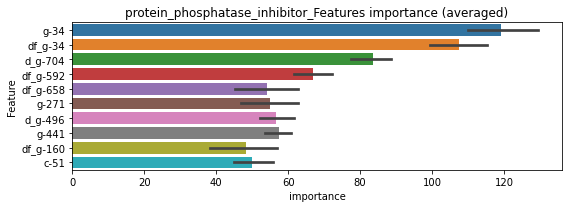

len(train_index) : 3892
len(valid_index) : 3893
================================= fold 1/2 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0128391	valid_1's binary_logloss: 0.0218782
[200]	training's binary_logloss: 0.00155671	valid_1's binary_logloss: 0.00830102
[300]	training's binary_logloss: 0.000431318	valid_1's binary_logloss: 0.0068588
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.000357746	valid_1's binary_logloss: 0.00670996


len(train_index) : 3893
len(valid_index) : 3892
================================= fold 2/2 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0139287	valid_1's binary_logloss: 0.0190713
[200]	training's binary_logloss: 0.00176125	valid_1's binary_logloss: 0.00432857
[300]	training's binary_logloss: 0.000475726	valid_1's binary_logloss: 0.00234256
[400]	training's binary_logloss: 0.000243077	valid_1's binary_logloss: 0.00193335
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000208988	valid_1's binary_logloss: 0.00188192


protein_phosphatase_inhibitor logloss: 0.004296248888190424


neg labels: 3289 → selected neg labels: 3271


protein_synthesis_inhibitor, len(trt): 103, len(othr): 3271, target_rate: 0.0043252 → Adj_target_rate: 0.0043163
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0615666	valid_1's binary_logloss: 0.139808
[200]	training's binary_logloss: 0.013806	valid_1's binary_logloss: 0.0893104
[300]	training's binary_logloss: 0.00393821	valid_1's binary_logloss: 0.0760049
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.00268268	valid_1's binary_logloss: 0.0740068
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0582436	valid_1's binary_logloss: 0.144724
[200]	training's binary_logloss: 0.0129295	valid_1's binary_logloss: 0.0952187
[300]	training's binary_logloss: 0.00383724	valid_1's binary_logloss: 0.0840486
Early stopping, best iteration is:
[343]	training's binary_logloss: 0.0026125	valid_1's binary_logloss: 0.0827864


1 / 3 AUC score:0.989
y_Threshold: 0.0175943, Threshold: 0.0974425, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 173 → Positive_corect_labels: 633/3752
p_label_rate: 0.0200904 Vs.target_rate: 0.00433
Num_p_label: 80.0, conf_0:0.08770, conf_1:0.10719
Num_p_label: 80.0, Expected: 17.2, Adj_threshold_1: 0.0974425
Num_p_label: 71.0, Expected: 17.2, Adj_threshold_2: 0.1074425
Num_p_label: 66.0, Expected: 17.2, Adj_threshold_3: 0.1174425
Num_p_label: 62.0, Expected: 17.2, Adj_threshold_4: 0.1274425
Num_p_label: 57.0, Expected: 17.2, Adj_threshold_5: 0.1374425
Num_p_label: 56.0, Expected: 17.2, Adj_threshold_6: 0.1474425
Num_p_label: 54.0, Expected: 17.2, Adj_threshold_7: 0.1574425
Num_p_label: 51.0, Expected: 17.2, Adj_threshold_8: 0.1674425
Num_p_label: 48.0, Expected: 17.2, Adj_threshold_9: 0.1774425
Num_p_label: 44.0, Expected: 17.2, Adj_threshold_10: 0.1874425
threshold: 0.1974425, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 633.0/3752, y_label_rate: 0.1687100

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0562644	valid_1's binary_logloss: 0.125507
[200]	training's binary_logloss: 0.0115115	valid_1's binary_logloss: 0.0809976
[300]	training's binary_logloss: 0.00340672	valid_1's binary_logloss: 0.0717762
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00181127	valid_1's binary_logloss: 0.0694534
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0566078	valid_1's binary_logloss: 0.130084
[200]	training's binary_logloss: 0.0119466	valid_1's binary_logloss: 0.0828019
[300]	training's binary_logloss: 0.00350267	valid_1's binary_logloss: 0.0749431
Early stopping, best iteration is:
[353]	training's binary_logloss: 0.00217292	valid_1's binary_logloss: 0.0726881


2 / 3 AUC score:0.993
y_Threshold: 0.0402498, Threshold: 0.1974425, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 60 → Positive_corect_labels: 603.0/3692
p_label_rate: 0.0258664 Vs.target_rate: 0.00433
Num_p_label: 103.0, conf_0:0.17770, conf_1:0.21719
Num_p_label: 103.0, Expected: 17.2, Adj_threshold_1: 0.1974425
Num_p_label: 98.0, Expected: 17.2, Adj_threshold_2: 0.2074425
Num_p_label: 98.0, Expected: 17.2, Adj_threshold_3: 0.2174425
Num_p_label: 97.0, Expected: 17.2, Adj_threshold_4: 0.2274425
Num_p_label: 95.0, Expected: 17.2, Adj_threshold_5: 0.2374425
Num_p_label: 92.0, Expected: 17.2, Adj_threshold_6: 0.2474425
Num_p_label: 92.0, Expected: 17.2, Adj_threshold_7: 0.2574425
Num_p_label: 89.0, Expected: 17.2, Adj_threshold_8: 0.2674425
Num_p_label: 88.0, Expected: 17.2, Adj_threshold_9: 0.2774425
Num_p_label: 85.0, Expected: 17.2, Adj_threshold_10: 0.2874425
threshold: 0.2974425, positive_p_label: 85.0/3982, p_label_rate: 0.0213461
positive_y_label: 603.0/3692, y_label_rate: 0.1633

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0513404	valid_1's binary_logloss: 0.108406
[200]	training's binary_logloss: 0.010637	valid_1's binary_logloss: 0.0639368
[300]	training's binary_logloss: 0.003168	valid_1's binary_logloss: 0.055464
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.00266292	valid_1's binary_logloss: 0.05428
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0498364	valid_1's binary_logloss: 0.122241
[200]	training's binary_logloss: 0.00978259	valid_1's binary_logloss: 0.0883478
Early stopping, best iteration is:
[231]	training's binary_logloss: 0.00634987	valid_1's binary_logloss: 0.0858936


3 / 3 AUC score:0.996
y_Threshold: 0.0399572, Threshold: 0.2974425, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 54 → Positive_corect_labels: 576.0/3638
p_label_rate: 0.0246107 Vs.target_rate: 0.00433
Num_p_label: 98.0, conf_0:0.26770, conf_1:0.32719
Num_p_label: 98.0, Expected: 17.2, Adj_threshold_1: 0.2974425
Num_p_label: 97.0, Expected: 17.2, Adj_threshold_2: 0.3074425
Num_p_label: 94.0, Expected: 17.2, Adj_threshold_3: 0.3174425
Num_p_label: 93.0, Expected: 17.2, Adj_threshold_4: 0.3274425
Num_p_label: 93.0, Expected: 17.2, Adj_threshold_5: 0.3374425
Num_p_label: 90.0, Expected: 17.2, Adj_threshold_6: 0.3474425
Num_p_label: 90.0, Expected: 17.2, Adj_threshold_7: 0.3574425
Num_p_label: 88.0, Expected: 17.2, Adj_threshold_8: 0.3674425
Num_p_label: 87.0, Expected: 17.2, Adj_threshold_9: 0.3774425
Num_p_label: 86.0, Expected: 17.2, Adj_threshold_10: 0.3874425
threshold: 0.3974425, positive_p_label: 83.0/3982, p_label_rate: 0.0208438
positive_y_label: 659.0/7620, y_label_rate: 0.086482

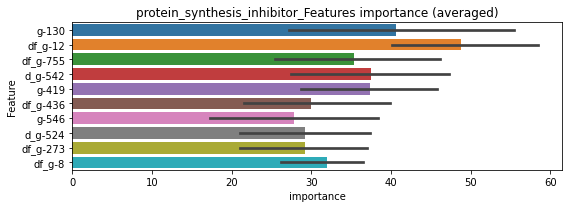

len(train_index) : 3810
len(valid_index) : 3810
================================= fold 1/2 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297362	valid_1's binary_logloss: 0.0682802
[200]	training's binary_logloss: 0.0059478	valid_1's binary_logloss: 0.0442547
[300]	training's binary_logloss: 0.00168096	valid_1's binary_logloss: 0.0391115
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00159261	valid_1's binary_logloss: 0.0389021


len(train_index) : 3810
len(valid_index) : 3810
================================= fold 2/2 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0301463	valid_1's binary_logloss: 0.0655307
[200]	training's binary_logloss: 0.00599815	valid_1's binary_logloss: 0.0434822
[300]	training's binary_logloss: 0.00172843	valid_1's binary_logloss: 0.0382074
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00172843	valid_1's binary_logloss: 0.0382074


protein_synthesis_inhibitor logloss: 0.03855476070819981


neg labels: 3289 → selected neg labels: 3285


protein_tyrosine_kinase_inhibitor, len(trt): 19, len(othr): 3285, target_rate: 0.0007979 → Adj_target_rate: 0.0010260
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0247775	valid_1's binary_logloss: 0.0350481
[200]	training's binary_logloss: 0.0030983	valid_1's binary_logloss: 0.00664558
[300]	training's binary_logloss: 0.000856457	valid_1's binary_logloss: 0.00252239
[400]	training's binary_logloss: 0.000441607	valid_1's binary_logloss: 0.00149252
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.000353751	valid_1's binary_logloss: 0.00128453
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254846	valid_1's binary_logloss: 0.0347581
[200]	training's binary_logloss: 0.00318676	valid_1's binary_logloss: 0.00571027
[300]	training's binary_logloss: 0.000879133	valid_1's binary_logloss: 0.00191881
[400]	training's binary_logloss: 0.000451158	valid_1's binary_logloss: 0.00114492
[500]	training's binary_logloss: 0.00035835	valid_1's binary_logloss: 0.000961577
Early stopping, best iteration i

1 / 3 AUC score:1.000
y_Threshold: 0.0014670, Threshold: 0.0020013, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00080
Num_p_label: 80.0, conf_0:0.00180, conf_1:0.00220
Num_p_label: 80.0, Expected: 3.2, Adj_threshold_1: 0.0020013
Num_p_label: 2.0, Expected: 3.2, Adj_threshold_2: 0.0120013
threshold: 0.0120013, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252373	valid_1's binary_logloss: 0.0346773
[200]	training's binary_logloss: 0.00303889	valid_1's binary_logloss: 0.00562364
[300]	training's binary_logloss: 0.000850587	valid_1's binary_logloss: 0.00198981
[400]	training's binary_logloss: 0.00044606	valid_1's binary_logloss: 0.00120442
[500]	training's binary_logloss: 0.000349966	valid_1's binary_logloss: 0.00100747
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.00034709	valid_1's binary_logloss: 0.00100415
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0255453	valid_1's binary_logloss: 0.0347098
[200]	training's binary_logloss: 0.0030544	valid_1's binary_logloss: 0.00538062
[300]	training's binary_logloss: 0.000872513	valid_1's binary_logloss: 0.00188402
[400]	training's binary_logloss: 0.000451615	valid_1's binary_logloss: 0.00110825
[500]	training's binary_logloss: 0

2 / 3 AUC score:1.000
y_Threshold: 0.1366643, Threshold: 0.0120013, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0020090 Vs.target_rate: 0.00080
Num_p_label: 8.0, conf_0:0.01080, conf_1:0.01320
threshold: 0.0120013, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252373	valid_1's binary_logloss: 0.0346773
[200]	training's binary_logloss: 0.00303889	valid_1's binary_logloss: 0.00562364
[300]	training's binary_logloss: 0.000850587	valid_1's binary_logloss: 0.00198981
[400]	training's binary_logloss: 0.00044606	valid_1's binary_logloss: 0.00120442
[500]	training's binary_logloss: 0.000349966	valid_1's binary_logloss: 0.00100747
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.00034709	valid_1's binary_logloss: 0.00100415
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0255453	valid_1's binary_logloss: 0.0347098
[200]	training's binary_logloss: 0.0030544	valid_1's binary_logloss: 0.00538062
[300]	training's binary_logloss: 0.000872513	valid_1's binary_logloss: 0.00188402
[400]	training's binary_logloss: 0.000451615	valid_1's binary_logloss: 0.00110825
[500]	training's binary_logloss: 0

3 / 3 AUC score:1.000
y_Threshold: 0.1366643, Threshold: 0.0120013, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0020090 Vs.target_rate: 0.00080
Num_p_label: 8.0, conf_0:0.01080, conf_1:0.01320
threshold: 0.0120013, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 665.0/7792, y_label_rate: 0.0853439


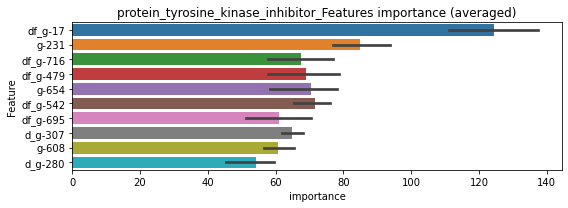

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0142314	valid_1's binary_logloss: 0.0231619
[200]	training's binary_logloss: 0.00168875	valid_1's binary_logloss: 0.00937021
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.000507691	valid_1's binary_logloss: 0.00854475


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0144315	valid_1's binary_logloss: 0.0220694
[200]	training's binary_logloss: 0.00182871	valid_1's binary_logloss: 0.00594798
[300]	training's binary_logloss: 0.000489388	valid_1's binary_logloss: 0.00369937
[400]	training's binary_logloss: 0.000245006	valid_1's binary_logloss: 0.00330081
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.000223509	valid_1's binary_logloss: 0.00326951


protein_tyrosine_kinase_inhibitor logloss: 0.005907130996369698


neg labels: 3289 → selected neg labels: 3281


radiopaque_medium, len(trt): 56, len(othr): 3281, target_rate: 0.0023516 → Adj_target_rate: 0.0025713
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0455107	valid_1's binary_logloss: 0.114299
[200]	training's binary_logloss: 0.008269	valid_1's binary_logloss: 0.0711604
[300]	training's binary_logloss: 0.00231258	valid_1's binary_logloss: 0.0634594
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00220237	valid_1's binary_logloss: 0.0632982
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0498332	valid_1's binary_logloss: 0.0841241
[200]	training's binary_logloss: 0.00972468	valid_1's binary_logloss: 0.0341754
[300]	training's binary_logloss: 0.00271223	valid_1's binary_logloss: 0.022451
[400]	training's binary_logloss: 0.00121544	valid_1's binary_logloss: 0.018687
[500]	training's binary_logloss: 0.000746847	valid_1's binary_logloss: 0.0171065
Early stopping, best iteration is:
[496]	training's binary_logloss: 0.000759743	valid_1's binary_logloss: 0.0170902


1 / 3 AUC score:0.998
y_Threshold: 0.0115959, Threshold: 0.0159825, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 148 → Positive_corect_labels: 648/3789
p_label_rate: 0.0200904 Vs.target_rate: 0.00235
Num_p_label: 80.0, conf_0:0.01438, conf_1:0.01758
Num_p_label: 80.0, Expected: 9.4, Adj_threshold_1: 0.0159825
Num_p_label: 38.0, Expected: 9.4, Adj_threshold_2: 0.0259825
Num_p_label: 22.0, Expected: 9.4, Adj_threshold_3: 0.0359825
Num_p_label: 13.0, Expected: 9.4, Adj_threshold_4: 0.0459825
threshold: 0.0459825, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 648.0/3789, y_label_rate: 0.1710214
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0450808	valid_1's binary_logloss: 0.0924566
[200]	training's binary_logloss: 0.00803	valid_1's binary_logloss: 0.043432
[300]	training's binary_logloss: 0.00232563	valid_1's binary_logloss: 0.0309333
[400]	training's binary_logloss: 0.00108349	valid_1's binary_logloss: 0.0284357
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00104677	valid_1's binary_logloss: 0.028378
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0466379	valid_1's binary_logloss: 0.0906766
[200]	training's binary_logloss: 0.00845633	valid_1's binary_logloss: 0.0443421
[300]	training's binary_logloss: 0.00241424	valid_1's binary_logloss: 0.0355645
Early stopping, best iteration is:
[367]	training's binary_logloss: 0.00137106	valid_1's binary_logloss: 0.03385


2 / 3 AUC score:0.999
y_Threshold: 0.0310147, Threshold: 0.0459825, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 637.0/3767
p_label_rate: 0.0080362 Vs.target_rate: 0.00235
Num_p_label: 32.0, conf_0:0.04138, conf_1:0.05058
Num_p_label: 32.0, Expected: 9.4, Adj_threshold_1: 0.0459825
Num_p_label: 24.0, Expected: 9.4, Adj_threshold_2: 0.0559825
Num_p_label: 20.0, Expected: 9.4, Adj_threshold_3: 0.0659825
Num_p_label: 16.0, Expected: 9.4, Adj_threshold_4: 0.0759825
threshold: 0.0759825, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 637.0/3767, y_label_rate: 0.1691001
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0441199	valid_1's binary_logloss: 0.0880674
[200]	training's binary_logloss: 0.00785583	valid_1's binary_logloss: 0.0426751
[300]	training's binary_logloss: 0.00226314	valid_1's binary_logloss: 0.0347694
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.00170529	valid_1's binary_logloss: 0.0344237
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0444392	valid_1's binary_logloss: 0.078911
[200]	training's binary_logloss: 0.00812565	valid_1's binary_logloss: 0.0336797
[300]	training's binary_logloss: 0.00231091	valid_1's binary_logloss: 0.0238987
[400]	training's binary_logloss: 0.00106483	valid_1's binary_logloss: 0.0215224
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.000792846	valid_1's binary_logloss: 0.0210262


3 / 3 AUC score:0.999
y_Threshold: 0.0288756, Threshold: 0.0759825, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 20 → Positive_corect_labels: 627.0/3747
p_label_rate: 0.0045203 Vs.target_rate: 0.00235
Num_p_label: 18.0, conf_0:0.06838, conf_1:0.08358
threshold: 0.0759825, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 645.0/7729, y_label_rate: 0.0834519


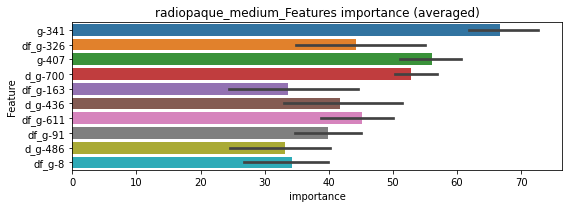

len(train_index) : 3864
len(valid_index) : 3865
================================= fold 1/2 radiopaque_medium=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0267159	valid_1's binary_logloss: 0.0490288
[200]	training's binary_logloss: 0.00492621	valid_1's binary_logloss: 0.0242634
[300]	training's binary_logloss: 0.00136109	valid_1's binary_logloss: 0.0201185
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.00110641	valid_1's binary_logloss: 0.0196782


len(train_index) : 3865
len(valid_index) : 3864
================================= fold 2/2 radiopaque_medium=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0253065	valid_1's binary_logloss: 0.0539313
[200]	training's binary_logloss: 0.00457654	valid_1's binary_logloss: 0.0300922
[300]	training's binary_logloss: 0.00127802	valid_1's binary_logloss: 0.0259736
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.00116678	valid_1's binary_logloss: 0.0256988


radiopaque_medium logloss: 0.02268813772293567


neg labels: 3289 → selected neg labels: 3280


raf_inhibitor, len(trt): 223, len(othr): 3280, target_rate: 0.0093642 → Adj_target_rate: 0.0083226
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251007	valid_1's binary_logloss: 0.0673263
[200]	training's binary_logloss: 0.00327271	valid_1's binary_logloss: 0.0495886
Early stopping, best iteration is:
[242]	training's binary_logloss: 0.00179689	valid_1's binary_logloss: 0.0483822
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0268005	valid_1's binary_logloss: 0.0425013
[200]	training's binary_logloss: 0.00419461	valid_1's binary_logloss: 0.0231786
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.00167529	valid_1's binary_logloss: 0.0208806


1 / 3 AUC score:0.998
y_Threshold: 0.0060104, Threshold: 0.0200220, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → Positive_corect_labels: 653/3798
p_label_rate: 0.0200904 Vs.target_rate: 0.00936
Num_p_label: 80.0, conf_0:0.01802, conf_1:0.02202
threshold: 0.0200220, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 653.0/3798, y_label_rate: 0.1719326
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231481	valid_1's binary_logloss: 0.0593618
Early stopping, best iteration is:
[169]	training's binary_logloss: 0.00485859	valid_1's binary_logloss: 0.0436472
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0259004	valid_1's binary_logloss: 0.0421807
[200]	training's binary_logloss: 0.00345063	valid_1's binary_logloss: 0.0221263
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00128311	valid_1's binary_logloss: 0.0195758


2 / 3 AUC score:0.999
y_Threshold: 0.0405174, Threshold: 0.0200220, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 642.0/3776
p_label_rate: 0.0459568 Vs.target_rate: 0.00936
Num_p_label: 183.0, conf_0:0.01802, conf_1:0.02202
Num_p_label: 183.0, Expected: 37.3, Adj_threshold_1: 0.0200220
Num_p_label: 141.0, Expected: 37.3, Adj_threshold_2: 0.0300220
Num_p_label: 115.0, Expected: 37.3, Adj_threshold_3: 0.0400220
Num_p_label: 95.0, Expected: 37.3, Adj_threshold_4: 0.0500220
Num_p_label: 82.0, Expected: 37.3, Adj_threshold_5: 0.0600220
Num_p_label: 76.0, Expected: 37.3, Adj_threshold_6: 0.0700220
Num_p_label: 72.0, Expected: 37.3, Adj_threshold_7: 0.0800220
threshold: 0.0800220, positive_p_label: 72.0/3982, p_label_rate: 0.0180814
positive_y_label: 642.0/3776, y_label_rate: 0.1700212
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237223	valid_1's binary_logloss: 0.051674
[200]	training's binary_logloss: 0.00282549	valid_1's binary_logloss: 0.0355539
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.00191303	valid_1's binary_logloss: 0.0351322
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0240158	valid_1's binary_logloss: 0.0368163
[200]	training's binary_logloss: 0.00296214	valid_1's binary_logloss: 0.0143974
[300]	training's binary_logloss: 0.000840189	valid_1's binary_logloss: 0.0107234
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000592348	valid_1's binary_logloss: 0.0101846


3 / 3 AUC score:1.000
y_Threshold: 0.0288180, Threshold: 0.0800220, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 635.0/3762
p_label_rate: 0.0175791 Vs.target_rate: 0.00936
Num_p_label: 70.0, conf_0:0.07202, conf_1:0.08802
threshold: 0.0800220, positive_p_label: 70.0/3982, p_label_rate: 0.0175791
positive_y_label: 705.0/7744, y_label_rate: 0.0910382


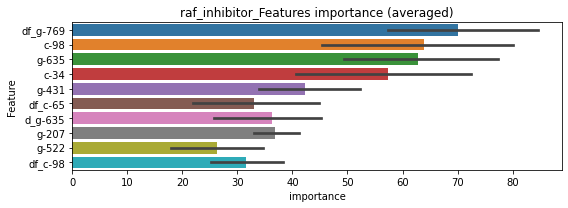

len(train_index) : 3872
len(valid_index) : 3872
================================= fold 1/2 raf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0134694	valid_1's binary_logloss: 0.0349463
[200]	training's binary_logloss: 0.00168524	valid_1's binary_logloss: 0.0241255
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.00132517	valid_1's binary_logloss: 0.0237321


len(train_index) : 3872
len(valid_index) : 3872
================================= fold 2/2 raf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0130155	valid_1's binary_logloss: 0.0288832
[200]	training's binary_logloss: 0.00166989	valid_1's binary_logloss: 0.0197549
Early stopping, best iteration is:
[266]	training's binary_logloss: 0.000680474	valid_1's binary_logloss: 0.0190248


raf_inhibitor logloss: 0.02137846816504265


neg labels: 3289 → selected neg labels: 3287


ras_gtpase_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188281	valid_1's binary_logloss: 0.0253115
[200]	training's binary_logloss: 0.00185613	valid_1's binary_logloss: 0.00473625
[300]	training's binary_logloss: 0.000520517	valid_1's binary_logloss: 0.00211649
[400]	training's binary_logloss: 0.000297375	valid_1's binary_logloss: 0.00159744
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.000266739	valid_1's binary_logloss: 0.00152647
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189811	valid_1's binary_logloss: 0.0218925
[200]	training's binary_logloss: 0.00189028	valid_1's binary_logloss: 0.00256007
[300]	training's binary_logloss: 0.000520127	valid_1's binary_logloss: 0.000781234
[400]	training's binary_logloss: 0.000299973	valid_1's binary_logloss: 0.000469892
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.000260149	valid_1's binary_logloss: 0.000

1 / 3 AUC score:1.000
y_Threshold: 0.0008876, Threshold: 0.0010532, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050
Num_p_label: 80.0, conf_0:0.00095, conf_1:0.00116
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0010532
Num_p_label: 0.0, Expected: 2.0, Adj_threshold_2: 0.0110532
threshold: 0.0110532, positive_p_label: 0.0/3982, p_label_rate: 0.0000000
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192624	valid_1's binary_logloss: 0.0247424
[200]	training's binary_logloss: 0.00188259	valid_1's binary_logloss: 0.00423004
[300]	training's binary_logloss: 0.000521247	valid_1's binary_logloss: 0.00180054
[400]	training's binary_logloss: 0.000297927	valid_1's binary_logloss: 0.00127366
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.000268485	valid_1's binary_logloss: 0.00121049
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191213	valid_1's binary_logloss: 0.0215707
[200]	training's binary_logloss: 0.00184762	valid_1's binary_logloss: 0.00244137
[300]	training's binary_logloss: 0.000509406	valid_1's binary_logloss: 0.000749998
[400]	training's binary_logloss: 0.000292486	valid_1's binary_logloss: 0.000445705
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000253684	valid_1's binary_logloss: 0.000

2 / 3 AUC score:1.000
y_Threshold: 0.0978376, Threshold: 0.0110532, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0007534 Vs.target_rate: 0.00050
Num_p_label: 3.0, conf_0:0.00995, conf_1:0.01216
threshold: 0.0110532, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192624	valid_1's binary_logloss: 0.0247424
[200]	training's binary_logloss: 0.00188259	valid_1's binary_logloss: 0.00423004
[300]	training's binary_logloss: 0.000521247	valid_1's binary_logloss: 0.00180054
[400]	training's binary_logloss: 0.000297927	valid_1's binary_logloss: 0.00127366
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.000268485	valid_1's binary_logloss: 0.00121049
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191213	valid_1's binary_logloss: 0.0215707
[200]	training's binary_logloss: 0.00184762	valid_1's binary_logloss: 0.00244137
[300]	training's binary_logloss: 0.000509406	valid_1's binary_logloss: 0.000749998
[400]	training's binary_logloss: 0.000292486	valid_1's binary_logloss: 0.000445705
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000253684	valid_1's binary_logloss: 0.000

3 / 3 AUC score:1.000
y_Threshold: 0.0978376, Threshold: 0.0110532, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0007534 Vs.target_rate: 0.00050
Num_p_label: 3.0, conf_0:0.00995, conf_1:0.01216
threshold: 0.0110532, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 660.0/7794, y_label_rate: 0.0846805


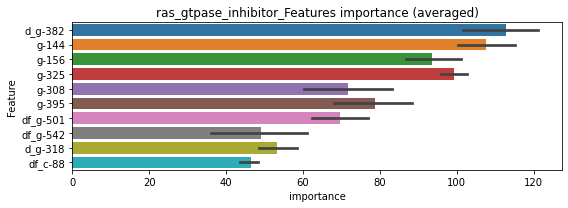

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0100211	valid_1's binary_logloss: 0.0162675
[200]	training's binary_logloss: 0.000939555	valid_1's binary_logloss: 0.00529328
[300]	training's binary_logloss: 0.000258052	valid_1's binary_logloss: 0.00393585
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00026954	valid_1's binary_logloss: 0.00392375


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101152	valid_1's binary_logloss: 0.0133388
[200]	training's binary_logloss: 0.000989802	valid_1's binary_logloss: 0.00310732
[300]	training's binary_logloss: 0.000269492	valid_1's binary_logloss: 0.00232094
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.000204084	valid_1's binary_logloss: 0.00226702


ras_gtpase_inhibitor logloss: 0.0030953887890967148


neg labels: 3289 → selected neg labels: 3278


retinoid_receptor_agonist, len(trt): 67, len(othr): 3278, target_rate: 0.0028135 → Adj_target_rate: 0.0029948
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0384974	valid_1's binary_logloss: 0.0777022
[200]	training's binary_logloss: 0.0063097	valid_1's binary_logloss: 0.0356845
[300]	training's binary_logloss: 0.00185401	valid_1's binary_logloss: 0.0265556
[400]	training's binary_logloss: 0.000894159	valid_1's binary_logloss: 0.0241712
Early stopping, best iteration is:
[432]	training's binary_logloss: 0.000759617	valid_1's binary_logloss: 0.0234818
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0383441	valid_1's binary_logloss: 0.0823397
[200]	training's binary_logloss: 0.00620739	valid_1's binary_logloss: 0.0362279
[300]	training's binary_logloss: 0.00181034	valid_1's binary_logloss: 0.0253255
[400]	training's binary_logloss: 0.000882189	valid_1's binary_logloss: 0.0218561
[500]	training's binary_logloss: 0.000575755	valid_1's binary_logloss: 0.0205499
Early stopping, best iteration is:
[495]	t

1 / 3 AUC score:1.000
y_Threshold: 0.0059947, Threshold: 0.0139183, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 136 → Positive_corect_labels: 653/3797
p_label_rate: 0.0200904 Vs.target_rate: 0.00281
Num_p_label: 80.0, conf_0:0.01253, conf_1:0.01531
Num_p_label: 80.0, Expected: 11.2, Adj_threshold_1: 0.0139183
Num_p_label: 44.0, Expected: 11.2, Adj_threshold_2: 0.0239183
Num_p_label: 29.0, Expected: 11.2, Adj_threshold_3: 0.0339183
Num_p_label: 21.0, Expected: 11.2, Adj_threshold_4: 0.0439183
threshold: 0.0439183, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 653.0/3797, y_label_rate: 0.1719779
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0386092	valid_1's binary_logloss: 0.0679548
[200]	training's binary_logloss: 0.00630708	valid_1's binary_logloss: 0.0245117
[300]	training's binary_logloss: 0.00183467	valid_1's binary_logloss: 0.0143908
[400]	training's binary_logloss: 0.000870585	valid_1's binary_logloss: 0.0106173
[500]	training's binary_logloss: 0.000571036	valid_1's binary_logloss: 0.00940981
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.000483907	valid_1's binary_logloss: 0.00892039
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0372041	valid_1's binary_logloss: 0.0704133
[200]	training's binary_logloss: 0.00593698	valid_1's binary_logloss: 0.0262156
[300]	training's binary_logloss: 0.00174948	valid_1's binary_logloss: 0.0161162
[400]	training's binary_logloss: 0.000832019	valid_1's binary_logloss: 0.0124494
[500]	training's binary_logloss: 0.0005

2 / 3 AUC score:1.000
y_Threshold: 0.0666426, Threshold: 0.0439183, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 652.0/3795
p_label_rate: 0.0123054 Vs.target_rate: 0.00281
Num_p_label: 49.0, conf_0:0.03953, conf_1:0.04831
Num_p_label: 49.0, Expected: 11.2, Adj_threshold_1: 0.0439183
Num_p_label: 36.0, Expected: 11.2, Adj_threshold_2: 0.0539183
Num_p_label: 33.0, Expected: 11.2, Adj_threshold_3: 0.0639183
Num_p_label: 31.0, Expected: 11.2, Adj_threshold_4: 0.0739183
Num_p_label: 30.0, Expected: 11.2, Adj_threshold_5: 0.0839183
Num_p_label: 27.0, Expected: 11.2, Adj_threshold_6: 0.0939183
Num_p_label: 25.0, Expected: 11.2, Adj_threshold_7: 0.1039183
Num_p_label: 23.0, Expected: 11.2, Adj_threshold_8: 0.1139183
Num_p_label: 21.0, Expected: 11.2, Adj_threshold_9: 0.1239183
threshold: 0.1239183, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 652.0/3795, y_label_rate: 0.1718050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0375653	valid_1's binary_logloss: 0.0673905
[200]	training's binary_logloss: 0.00611874	valid_1's binary_logloss: 0.0225663
[300]	training's binary_logloss: 0.00178108	valid_1's binary_logloss: 0.0130678
[400]	training's binary_logloss: 0.00086389	valid_1's binary_logloss: 0.0105712
[500]	training's binary_logloss: 0.000566128	valid_1's binary_logloss: 0.00904942
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000552168	valid_1's binary_logloss: 0.00894911
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0372287	valid_1's binary_logloss: 0.0675802
[200]	training's binary_logloss: 0.00590182	valid_1's binary_logloss: 0.021818
[300]	training's binary_logloss: 0.00174261	valid_1's binary_logloss: 0.012143
[400]	training's binary_logloss: 0.000843995	valid_1's binary_logloss: 0.00900593
[500]	training's binary_logloss: 0.000559

3 / 3 AUC score:1.000
y_Threshold: 0.0841166, Threshold: 0.1239183, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 652.0/3795
p_label_rate: 0.0060271 Vs.target_rate: 0.00281
Num_p_label: 24.0, conf_0:0.11153, conf_1:0.13631
threshold: 0.1239183, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 676.0/7777, y_label_rate: 0.0869230


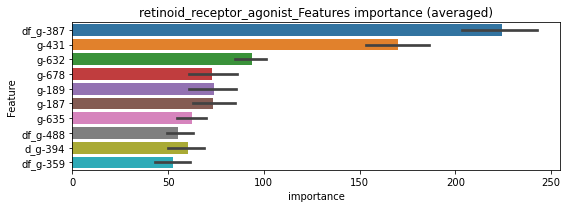

len(train_index) : 3888
len(valid_index) : 3889
================================= fold 1/2 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0201212	valid_1's binary_logloss: 0.0544107
[200]	training's binary_logloss: 0.0031243	valid_1's binary_logloss: 0.0321086
[300]	training's binary_logloss: 0.000901504	valid_1's binary_logloss: 0.0275477
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.000666423	valid_1's binary_logloss: 0.026768


len(train_index) : 3889
len(valid_index) : 3888
================================= fold 2/2 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0207408	valid_1's binary_logloss: 0.0488325
[200]	training's binary_logloss: 0.0033119	valid_1's binary_logloss: 0.02425
[300]	training's binary_logloss: 0.000960293	valid_1's binary_logloss: 0.0181016
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.000504454	valid_1's binary_logloss: 0.0164472


retinoid_receptor_agonist logloss: 0.021608263981765463


neg labels: 3289 → selected neg labels: 3288


retinoid_receptor_antagonist, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0153979	valid_1's binary_logloss: 0.0169355
[200]	training's binary_logloss: 0.0012393	valid_1's binary_logloss: 0.00181601
[300]	training's binary_logloss: 0.000331094	valid_1's binary_logloss: 0.000601489
[400]	training's binary_logloss: 0.000204734	valid_1's binary_logloss: 0.00043484
[500]	training's binary_logloss: 0.000180134	valid_1's binary_logloss: 0.000399045
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.000179157	valid_1's binary_logloss: 0.000397889
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154767	valid_1's binary_logloss: 0.0160533
[200]	training's binary_logloss: 0.00123698	valid_1's binary_logloss: 0.00138192
[300]	training's binary_logloss: 0.000328981	valid_1's binary_logloss: 0.000395611
[400]	training's binary_logloss: 0.000202834	valid_1's binary_logloss: 0.000245949
[500]	training's binary_log

1 / 3 AUC score:1.000
y_Threshold: 0.0004922, Threshold: 0.0008052, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0200904 Vs.target_rate: 0.00025
Num_p_label: 80.0, conf_0:0.00072, conf_1:0.00089
Num_p_label: 80.0, Expected: 1.0, Adj_threshold_1: 0.0008052
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_2: 0.0108052
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_3: 0.0208052
threshold: 0.0208052, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158356	valid_1's binary_logloss: 0.0172308
[200]	training's binary_logloss: 0.00126104	valid_1's binary_logloss: 0.00173307
[300]	training's binary_logloss: 0.000332786	valid_1's binary_logloss: 0.000531848
[400]	training's binary_logloss: 0.000206398	valid_1's binary_logloss: 0.000365233
[500]	training's binary_logloss: 0.000180293	valid_1's binary_logloss: 0.00032901
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.000179866	valid_1's binary_logloss: 0.000328536
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158933	valid_1's binary_logloss: 0.0166178
[200]	training's binary_logloss: 0.00126787	valid_1's binary_logloss: 0.0014173
[300]	training's binary_logloss: 0.000332925	valid_1's binary_logloss: 0.000399868
[400]	training's binary_logloss: 0.000206663	valid_1's binary_logloss: 0.000252659
[500]	training's binary_log

2 / 3 AUC score:1.000
y_Threshold: 0.1575294, Threshold: 0.0208052, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0022602 Vs.target_rate: 0.00025
Num_p_label: 9.0, conf_0:0.01872, conf_1:0.02289
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_1: 0.0208052
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_2: 0.0308052
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_3: 0.0408052
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_4: 0.0508052
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_5: 0.0608052
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_6: 0.0708052
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_7: 0.0808052
threshold: 0.0808052, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158356	valid_1's binary_logloss: 0.0172308
[200]	training's binary_logloss: 0.00126104	valid_1's binary_logloss: 0.00173307
[300]	training's binary_logloss: 0.000332786	valid_1's binary_logloss: 0.000531848
[400]	training's binary_logloss: 0.000206398	valid_1's binary_logloss: 0.000365233
[500]	training's binary_logloss: 0.000180293	valid_1's binary_logloss: 0.00032901
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.000179866	valid_1's binary_logloss: 0.000328536
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158933	valid_1's binary_logloss: 0.0166178
[200]	training's binary_logloss: 0.00126787	valid_1's binary_logloss: 0.0014173
[300]	training's binary_logloss: 0.000332925	valid_1's binary_logloss: 0.000399868
[400]	training's binary_logloss: 0.000206663	valid_1's binary_logloss: 0.000252659
[500]	training's binary_log

3 / 3 AUC score:1.000
y_Threshold: 0.1575294, Threshold: 0.0808052, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0002511 Vs.target_rate: 0.00025
Num_p_label: 1.0, conf_0:0.07272, conf_1:0.08889
threshold: 0.0808052, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 658.0/7795, y_label_rate: 0.0844131


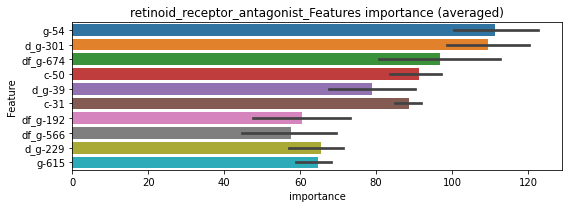

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0082749	valid_1's binary_logloss: 0.00945559
[200]	training's binary_logloss: 0.000640853	valid_1's binary_logloss: 0.00180874
[300]	training's binary_logloss: 0.00016711	valid_1's binary_logloss: 0.0013105
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00011729	valid_1's binary_logloss: 0.00127804


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00840272	valid_1's binary_logloss: 0.00860145
[200]	training's binary_logloss: 0.000667814	valid_1's binary_logloss: 0.000714236
[300]	training's binary_logloss: 0.000172967	valid_1's binary_logloss: 0.000192567
[400]	training's binary_logloss: 0.000104833	valid_1's binary_logloss: 0.000117568
[500]	training's binary_logloss: 9.06706e-05	valid_1's binary_logloss: 0.000101815
Early stopping, best iteration is:
[520]	training's binary_logloss: 9.01168e-05	valid_1's binary_logloss: 0.000101118


retinoid_receptor_antagonist logloss: 0.0006896554377473908


neg labels: 3289 → selected neg labels: 3283


rho_associated_kinase_inhibitor, len(trt): 35, len(othr): 3283, target_rate: 0.0014697 → Adj_target_rate: 0.0017245
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0316081	valid_1's binary_logloss: 0.0504666
[200]	training's binary_logloss: 0.0049033	valid_1's binary_logloss: 0.0133737
[300]	training's binary_logloss: 0.00129195	valid_1's binary_logloss: 0.0055745
[400]	training's binary_logloss: 0.000592318	valid_1's binary_logloss: 0.00353065
[500]	training's binary_logloss: 0.000401445	valid_1's binary_logloss: 0.00287413
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.000382155	valid_1's binary_logloss: 0.00282585
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315861	valid_1's binary_logloss: 0.0456926
[200]	training's binary_logloss: 0.00441552	valid_1's binary_logloss: 0.0110172
[300]	training's binary_logloss: 0.00123002	valid_1's binary_logloss: 0.00503857
[400]	training's binary_logloss: 0.000606578	valid_1's binary_logloss: 0.00346945
[500]	training's binary_logloss: 0.00

1 / 3 AUC score:1.000
y_Threshold: 0.0026610, Threshold: 0.0049608, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00147
Num_p_label: 80.0, conf_0:0.00446, conf_1:0.00546
Num_p_label: 80.0, Expected: 5.9, Adj_threshold_1: 0.0049608
Num_p_label: 16.0, Expected: 5.9, Adj_threshold_2: 0.0149608
Num_p_label: 5.0, Expected: 5.9, Adj_threshold_3: 0.0249608
threshold: 0.0249608, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0301279	valid_1's binary_logloss: 0.0466636
[200]	training's binary_logloss: 0.00406162	valid_1's binary_logloss: 0.0106815
[300]	training's binary_logloss: 0.00115078	valid_1's binary_logloss: 0.00474761
[400]	training's binary_logloss: 0.000576484	valid_1's binary_logloss: 0.00315724
[500]	training's binary_logloss: 0.000408977	valid_1's binary_logloss: 0.00269107
Early stopping, best iteration is:
[499]	training's binary_logloss: 0.000409428	valid_1's binary_logloss: 0.00268937
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0307707	valid_1's binary_logloss: 0.043439
[200]	training's binary_logloss: 0.00419866	valid_1's binary_logloss: 0.00936584
[300]	training's binary_logloss: 0.00118364	valid_1's binary_logloss: 0.00393043
[400]	training's binary_logloss: 0.000590997	valid_1's binary_logloss: 0.00249651
[500]	training's binary_logloss: 0.

2 / 3 AUC score:1.000
y_Threshold: 0.0854489, Threshold: 0.0249608, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0052737 Vs.target_rate: 0.00147
Num_p_label: 21.0, conf_0:0.02246, conf_1:0.02746
Num_p_label: 21.0, Expected: 5.9, Adj_threshold_1: 0.0249608
Num_p_label: 13.0, Expected: 5.9, Adj_threshold_2: 0.0349608
Num_p_label: 11.0, Expected: 5.9, Adj_threshold_3: 0.0449608
threshold: 0.0449608, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0301279	valid_1's binary_logloss: 0.0466636
[200]	training's binary_logloss: 0.00406162	valid_1's binary_logloss: 0.0106815
[300]	training's binary_logloss: 0.00115078	valid_1's binary_logloss: 0.00474761
[400]	training's binary_logloss: 0.000576484	valid_1's binary_logloss: 0.00315724
[500]	training's binary_logloss: 0.000408977	valid_1's binary_logloss: 0.00269107
Early stopping, best iteration is:
[499]	training's binary_logloss: 0.000409428	valid_1's binary_logloss: 0.00268937
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0307707	valid_1's binary_logloss: 0.043439
[200]	training's binary_logloss: 0.00419866	valid_1's binary_logloss: 0.00936584
[300]	training's binary_logloss: 0.00118364	valid_1's binary_logloss: 0.00393043
[400]	training's binary_logloss: 0.000590997	valid_1's binary_logloss: 0.00249651
[500]	training's binary_logloss: 0.

3 / 3 AUC score:1.000
y_Threshold: 0.0854489, Threshold: 0.0449608, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0027624 Vs.target_rate: 0.00147
Num_p_label: 11.0, conf_0:0.04046, conf_1:0.04946
threshold: 0.0449608, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 667.0/7789, y_label_rate: 0.0856336


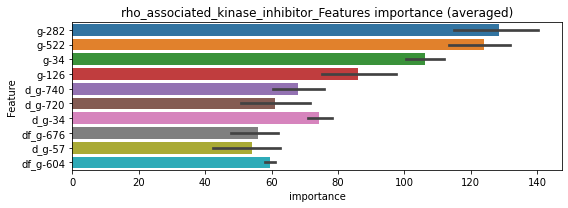

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155762	valid_1's binary_logloss: 0.0354925
[200]	training's binary_logloss: 0.00210048	valid_1's binary_logloss: 0.0171753
[300]	training's binary_logloss: 0.000592242	valid_1's binary_logloss: 0.0143746
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.000616057	valid_1's binary_logloss: 0.014291


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0171494	valid_1's binary_logloss: 0.027999
[200]	training's binary_logloss: 0.00230093	valid_1's binary_logloss: 0.00938748
[300]	training's binary_logloss: 0.000647226	valid_1's binary_logloss: 0.00714989
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.000471047	valid_1's binary_logloss: 0.0069573


rho_associated_kinase_inhibitor logloss: 0.01062460317454695


neg labels: 3289 → selected neg labels: 3282


ribonucleoside_reductase_inhibitor, len(trt): 37, len(othr): 3282, target_rate: 0.0015537 → Adj_target_rate: 0.0018079
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276152	valid_1's binary_logloss: 0.0519559
[200]	training's binary_logloss: 0.00371955	valid_1's binary_logloss: 0.0220645
[300]	training's binary_logloss: 0.00103677	valid_1's binary_logloss: 0.0159868
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.000710482	valid_1's binary_logloss: 0.0147287
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286286	valid_1's binary_logloss: 0.03912
[200]	training's binary_logloss: 0.00390989	valid_1's binary_logloss: 0.00849783
[300]	training's binary_logloss: 0.00111157	valid_1's binary_logloss: 0.0039597
[400]	training's binary_logloss: 0.000553368	valid_1's binary_logloss: 0.00292695
[500]	training's binary_logloss: 0.00039795	valid_1's binary_logloss: 0.00262898
Early stopping, best iteration is:
[502]	training's binary_logloss: 0.00039703	valid_1's binary_logloss: 0.00262677


1 / 3 AUC score:1.000
y_Threshold: 0.0029127, Threshold: 0.0044586, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3806
p_label_rate: 0.0200904 Vs.target_rate: 0.00155
Num_p_label: 80.0, conf_0:0.00401, conf_1:0.00490
Num_p_label: 80.0, Expected: 6.2, Adj_threshold_1: 0.0044586
Num_p_label: 23.0, Expected: 6.2, Adj_threshold_2: 0.0144586
Num_p_label: 16.0, Expected: 6.2, Adj_threshold_3: 0.0244586
Num_p_label: 13.0, Expected: 6.2, Adj_threshold_4: 0.0344586
Num_p_label: 13.0, Expected: 6.2, Adj_threshold_5: 0.0444586
Num_p_label: 12.0, Expected: 6.2, Adj_threshold_6: 0.0544586
threshold: 0.0544586, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0273646	valid_1's binary_logloss: 0.0460825
[200]	training's binary_logloss: 0.00368397	valid_1's binary_logloss: 0.0182167
[300]	training's binary_logloss: 0.000996252	valid_1's binary_logloss: 0.0117137
[400]	training's binary_logloss: 0.000497247	valid_1's binary_logloss: 0.0096822
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000425931	valid_1's binary_logloss: 0.00930168
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0277235	valid_1's binary_logloss: 0.0377381
[200]	training's binary_logloss: 0.00363378	valid_1's binary_logloss: 0.00697012
[300]	training's binary_logloss: 0.00103189	valid_1's binary_logloss: 0.00261847
[400]	training's binary_logloss: 0.000514398	valid_1's binary_logloss: 0.00159653
[500]	training's binary_logloss: 0.000377835	valid_1's binary_logloss: 0.00131102
Early stopping, best iteration is:


2 / 3 AUC score:1.000
y_Threshold: 0.0553445, Threshold: 0.0544586, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3806
p_label_rate: 0.0037670 Vs.target_rate: 0.00155
Num_p_label: 15.0, conf_0:0.04901, conf_1:0.05990
threshold: 0.0544586, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0273646	valid_1's binary_logloss: 0.0460825
[200]	training's binary_logloss: 0.00368397	valid_1's binary_logloss: 0.0182167
[300]	training's binary_logloss: 0.000996252	valid_1's binary_logloss: 0.0117137
[400]	training's binary_logloss: 0.000497247	valid_1's binary_logloss: 0.0096822
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000425931	valid_1's binary_logloss: 0.00930168
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0277235	valid_1's binary_logloss: 0.0377381
[200]	training's binary_logloss: 0.00363378	valid_1's binary_logloss: 0.00697012
[300]	training's binary_logloss: 0.00103189	valid_1's binary_logloss: 0.00261847
[400]	training's binary_logloss: 0.000514398	valid_1's binary_logloss: 0.00159653
[500]	training's binary_logloss: 0.000377835	valid_1's binary_logloss: 0.00131102
Early stopping, best iteration is:


3 / 3 AUC score:1.000
y_Threshold: 0.0553445, Threshold: 0.0544586, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3806
p_label_rate: 0.0037670 Vs.target_rate: 0.00155
Num_p_label: 15.0, conf_0:0.04901, conf_1:0.05990
threshold: 0.0544586, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 671.0/7788, y_label_rate: 0.0861582


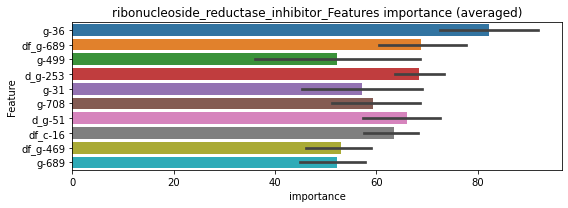

len(train_index) : 3894
len(valid_index) : 3894
================================= fold 1/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0147267	valid_1's binary_logloss: 0.0276333
[200]	training's binary_logloss: 0.00188052	valid_1's binary_logloss: 0.0108236
[300]	training's binary_logloss: 0.000510509	valid_1's binary_logloss: 0.00749473
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.000342984	valid_1's binary_logloss: 0.00689701


len(train_index) : 3894
len(valid_index) : 3894
================================= fold 2/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0150324	valid_1's binary_logloss: 0.0234093
[200]	training's binary_logloss: 0.00192874	valid_1's binary_logloss: 0.00583764
[300]	training's binary_logloss: 0.000535614	valid_1's binary_logloss: 0.0031516
[400]	training's binary_logloss: 0.000267688	valid_1's binary_logloss: 0.00258087
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.000247878	valid_1's binary_logloss: 0.0025532


ribonucleoside_reductase_inhibitor logloss: 0.004725105269727984


neg labels: 3289 → selected neg labels: 3284


rna_polymerase_inhibitor, len(trt): 25, len(othr): 3284, target_rate: 0.0010498 → Adj_target_rate: 0.0012955
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0266866	valid_1's binary_logloss: 0.0381394
[200]	training's binary_logloss: 0.00333828	valid_1's binary_logloss: 0.00710673
[300]	training's binary_logloss: 0.000962581	valid_1's binary_logloss: 0.00303442
[400]	training's binary_logloss: 0.000494866	valid_1's binary_logloss: 0.00199698
[500]	training's binary_logloss: 0.000376722	valid_1's binary_logloss: 0.00169584
Early stopping, best iteration is:
[522]	training's binary_logloss: 0.00037202	valid_1's binary_logloss: 0.00168448
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287492	valid_1's binary_logloss: 0.0390496
[200]	training's binary_logloss: 0.00363611	valid_1's binary_logloss: 0.00700898
[300]	training's binary_logloss: 0.00100045	valid_1's binary_logloss: 0.00271664
[400]	training's binary_logloss: 0.000505522	valid_1's binary_logloss: 0.00171999
[500]	training's binary_logloss: 

1 / 3 AUC score:1.000
y_Threshold: 0.0021235, Threshold: 0.0086156, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00105
Num_p_label: 80.0, conf_0:0.00775, conf_1:0.00948
Num_p_label: 80.0, Expected: 4.2, Adj_threshold_1: 0.0086156
Num_p_label: 57.0, Expected: 4.2, Adj_threshold_2: 0.0186156
Num_p_label: 45.0, Expected: 4.2, Adj_threshold_3: 0.0286156
Num_p_label: 40.0, Expected: 4.2, Adj_threshold_4: 0.0386156
Num_p_label: 38.0, Expected: 4.2, Adj_threshold_5: 0.0486156
Num_p_label: 34.0, Expected: 4.2, Adj_threshold_6: 0.0586156
Num_p_label: 33.0, Expected: 4.2, Adj_threshold_7: 0.0686156
Num_p_label: 29.0, Expected: 4.2, Adj_threshold_8: 0.0786156
Num_p_label: 28.0, Expected: 4.2, Adj_threshold_9: 0.0886156
Num_p_label: 26.0, Expected: 4.2, Adj_threshold_10: 0.0986156
threshold: 0.1086156, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0263663	valid_1's binary_logloss: 0.0352545
[200]	training's binary_logloss: 0.00325006	valid_1's binary_logloss: 0.00585634
[300]	training's binary_logloss: 0.000925223	valid_1's binary_logloss: 0.00208194
[400]	training's binary_logloss: 0.000481241	valid_1's binary_logloss: 0.00120879
[500]	training's binary_logloss: 0.000368368	valid_1's binary_logloss: 0.000988584
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.000361204	valid_1's binary_logloss: 0.000976957
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0267736	valid_1's binary_logloss: 0.0359084
[200]	training's binary_logloss: 0.00329542	valid_1's binary_logloss: 0.00581404
[300]	training's binary_logloss: 0.000911681	valid_1's binary_logloss: 0.00198008
[400]	training's binary_logloss: 0.0004731	valid_1's binary_logloss: 0.00114655
[500]	training's binary_logloss

2 / 3 AUC score:1.000
y_Threshold: 0.1762114, Threshold: 0.1086156, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0158212 Vs.target_rate: 0.00105
Num_p_label: 63.0, conf_0:0.09775, conf_1:0.11948
Num_p_label: 63.0, Expected: 4.2, Adj_threshold_1: 0.1086156
Num_p_label: 62.0, Expected: 4.2, Adj_threshold_2: 0.1186156
Num_p_label: 59.0, Expected: 4.2, Adj_threshold_3: 0.1286156
Num_p_label: 57.0, Expected: 4.2, Adj_threshold_4: 0.1386156
Num_p_label: 56.0, Expected: 4.2, Adj_threshold_5: 0.1486156
Num_p_label: 54.0, Expected: 4.2, Adj_threshold_6: 0.1586156
Num_p_label: 54.0, Expected: 4.2, Adj_threshold_7: 0.1686156
Num_p_label: 51.0, Expected: 4.2, Adj_threshold_8: 0.1786156
Num_p_label: 49.0, Expected: 4.2, Adj_threshold_9: 0.1886156
Num_p_label: 48.0, Expected: 4.2, Adj_threshold_10: 0.1986156
threshold: 0.2086156, positive_p_label: 47.0/3982, p_label_rate: 0.0118031
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0263663	valid_1's binary_logloss: 0.0352545
[200]	training's binary_logloss: 0.00325006	valid_1's binary_logloss: 0.00585634
[300]	training's binary_logloss: 0.000925223	valid_1's binary_logloss: 0.00208194
[400]	training's binary_logloss: 0.000481241	valid_1's binary_logloss: 0.00120879
[500]	training's binary_logloss: 0.000368368	valid_1's binary_logloss: 0.000988584
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.000361204	valid_1's binary_logloss: 0.000976957
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0267736	valid_1's binary_logloss: 0.0359084
[200]	training's binary_logloss: 0.00329542	valid_1's binary_logloss: 0.00581404
[300]	training's binary_logloss: 0.000911681	valid_1's binary_logloss: 0.00198008
[400]	training's binary_logloss: 0.0004731	valid_1's binary_logloss: 0.00114655
[500]	training's binary_logloss

3 / 3 AUC score:1.000
y_Threshold: 0.1762114, Threshold: 0.2086156, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0118031 Vs.target_rate: 0.00105
Num_p_label: 47.0, conf_0:0.18775, conf_1:0.22948
Num_p_label: 47.0, Expected: 4.2, Adj_threshold_1: 0.2086156
Num_p_label: 46.0, Expected: 4.2, Adj_threshold_2: 0.2186156
Num_p_label: 46.0, Expected: 4.2, Adj_threshold_3: 0.2286156
Num_p_label: 46.0, Expected: 4.2, Adj_threshold_4: 0.2386156
Num_p_label: 44.0, Expected: 4.2, Adj_threshold_5: 0.2486156
Num_p_label: 42.0, Expected: 4.2, Adj_threshold_6: 0.2586156
Num_p_label: 42.0, Expected: 4.2, Adj_threshold_7: 0.2686156
Num_p_label: 41.0, Expected: 4.2, Adj_threshold_8: 0.2786156
Num_p_label: 41.0, Expected: 4.2, Adj_threshold_9: 0.2886156
Num_p_label: 40.0, Expected: 4.2, Adj_threshold_10: 0.2986156
threshold: 0.3086156, positive_p_label: 38.0/3982, p_label_rate: 0.0095429
positive_y_label: 694.0/7790, y_label_rate: 0.0890886


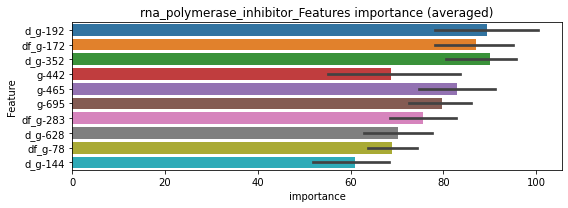

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165478	valid_1's binary_logloss: 0.0264632
[200]	training's binary_logloss: 0.00228726	valid_1's binary_logloss: 0.00965022
[300]	training's binary_logloss: 0.000638531	valid_1's binary_logloss: 0.00726419
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.000392207	valid_1's binary_logloss: 0.00679012


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0174409	valid_1's binary_logloss: 0.0270842
[200]	training's binary_logloss: 0.00232065	valid_1's binary_logloss: 0.00880504
[300]	training's binary_logloss: 0.000618829	valid_1's binary_logloss: 0.00589612
[400]	training's binary_logloss: 0.000305208	valid_1's binary_logloss: 0.00491234
[500]	training's binary_logloss: 0.000216896	valid_1's binary_logloss: 0.00472366
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.000215733	valid_1's binary_logloss: 0.00471696


rna_polymerase_inhibitor logloss: 0.005753535722939555


neg labels: 3289 → selected neg labels: 3249


serotonin_receptor_agonist, len(trt): 236, len(othr): 3249, target_rate: 0.0099101 → Adj_target_rate: 0.0087332
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101392	valid_1's binary_logloss: 0.274963
[200]	training's binary_logloss: 0.0345841	valid_1's binary_logloss: 0.245906
Early stopping, best iteration is:
[237]	training's binary_logloss: 0.0241863	valid_1's binary_logloss: 0.242442
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10243	valid_1's binary_logloss: 0.277508
Early stopping, best iteration is:
[177]	training's binary_logloss: 0.043658	valid_1's binary_logloss: 0.2545


1 / 3 AUC score:0.891
y_Threshold: 0.0883571, Threshold: 0.1194955, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 453 → Positive_corect_labels: 488/3445
p_label_rate: 0.0200904 Vs.target_rate: 0.00991
Num_p_label: 80.0, conf_0:0.10755, conf_1:0.13145
threshold: 0.1194955, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 488.0/3445, y_label_rate: 0.1416546
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0688224	valid_1's binary_logloss: 0.1882
[200]	training's binary_logloss: 0.018618	valid_1's binary_logloss: 0.150204
Early stopping, best iteration is:
[228]	training's binary_logloss: 0.0134105	valid_1's binary_logloss: 0.145167
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0660074	valid_1's binary_logloss: 0.194963
Early stopping, best iteration is:
[179]	training's binary_logloss: 0.0219038	valid_1's binary_logloss: 0.165276


2 / 3 AUC score:0.963
y_Threshold: 0.0825228, Threshold: 0.1194955, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 140 → Positive_corect_labels: 418.0/3305
p_label_rate: 0.0145655 Vs.target_rate: 0.00991
Num_p_label: 58.0, conf_0:0.10755, conf_1:0.13145
threshold: 0.1194955, positive_p_label: 58.0/3982, p_label_rate: 0.0145655
positive_y_label: 418.0/3305, y_label_rate: 0.1264750
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0549957	valid_1's binary_logloss: 0.14669
[200]	training's binary_logloss: 0.0133287	valid_1's binary_logloss: 0.109252
[300]	training's binary_logloss: 0.00426812	valid_1's binary_logloss: 0.103821
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00369833	valid_1's binary_logloss: 0.103211
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0594375	valid_1's binary_logloss: 0.152537
[200]	training's binary_logloss: 0.0158079	valid_1's binary_logloss: 0.1103
[300]	training's binary_logloss: 0.00479294	valid_1's binary_logloss: 0.0957547
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00323402	valid_1's binary_logloss: 0.0937353


3 / 3 AUC score:0.987
y_Threshold: 0.0463550, Threshold: 0.1194955, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 62 → Positive_corect_labels: 387.0/3243
p_label_rate: 0.0060271 Vs.target_rate: 0.00991
Num_p_label: 24.0, conf_0:0.10755, conf_1:0.13145
threshold: 0.1194955, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 411.0/7225, y_label_rate: 0.0568858


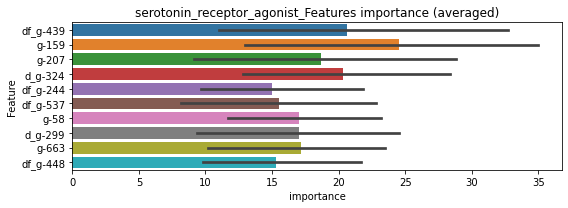

len(train_index) : 3612
len(valid_index) : 3613
================================= fold 1/2 serotonin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281515	valid_1's binary_logloss: 0.0818311
[200]	training's binary_logloss: 0.0066402	valid_1's binary_logloss: 0.0628063
Early stopping, best iteration is:
[232]	training's binary_logloss: 0.00435326	valid_1's binary_logloss: 0.0615655


len(train_index) : 3613
len(valid_index) : 3612
================================= fold 2/2 serotonin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282278	valid_1's binary_logloss: 0.0851533
[200]	training's binary_logloss: 0.00669214	valid_1's binary_logloss: 0.0697727
Early stopping, best iteration is:
[213]	training's binary_logloss: 0.00556251	valid_1's binary_logloss: 0.0693719


serotonin_receptor_agonist logloss: 0.06546812904092003


neg labels: 3289 → selected neg labels: 3220


serotonin_receptor_antagonist, len(trt): 404, len(othr): 3220, target_rate: 0.0169648 → Adj_target_rate: 0.0137918
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12326	valid_1's binary_logloss: 0.349379
Early stopping, best iteration is:
[164]	training's binary_logloss: 0.0659493	valid_1's binary_logloss: 0.341253
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127832	valid_1's binary_logloss: 0.351355
Early stopping, best iteration is:
[147]	training's binary_logloss: 0.0765534	valid_1's binary_logloss: 0.341391


1 / 3 AUC score:0.803
y_Threshold: 0.1402606, Threshold: 0.1985218, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 675 → Positive_corect_labels: 371/3189
p_label_rate: 0.0200904 Vs.target_rate: 0.01696
Num_p_label: 80.0, conf_0:0.17867, conf_1:0.21837
threshold: 0.1985218, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 371.0/3189, y_label_rate: 0.1163374
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0602919	valid_1's binary_logloss: 0.217103
Early stopping, best iteration is:
[135]	training's binary_logloss: 0.0365336	valid_1's binary_logloss: 0.210346
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0579942	valid_1's binary_logloss: 0.206898
Early stopping, best iteration is:
[173]	training's binary_logloss: 0.0218807	valid_1's binary_logloss: 0.191807


2 / 3 AUC score:0.930
y_Threshold: 0.1065691, Threshold: 0.1985218, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 220 → Positive_corect_labels: 261.0/2969
p_label_rate: 0.0193370 Vs.target_rate: 0.01696
Num_p_label: 77.0, conf_0:0.17867, conf_1:0.21837
threshold: 0.1985218, positive_p_label: 77.0/3982, p_label_rate: 0.0193370
positive_y_label: 261.0/2969, y_label_rate: 0.0879084
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0351834	valid_1's binary_logloss: 0.147097
Early stopping, best iteration is:
[131]	training's binary_logloss: 0.0212926	valid_1's binary_logloss: 0.140834
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0353047	valid_1's binary_logloss: 0.134103
Early stopping, best iteration is:
[175]	training's binary_logloss: 0.0108815	valid_1's binary_logloss: 0.119805


3 / 3 AUC score:0.972
y_Threshold: 0.0792567, Threshold: 0.1985218, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 112 → Positive_corect_labels: 205.0/2857
p_label_rate: 0.0226017 Vs.target_rate: 0.01696
Num_p_label: 90.0, conf_0:0.17867, conf_1:0.21837
threshold: 0.1985218, positive_p_label: 90.0/3982, p_label_rate: 0.0226017
positive_y_label: 295.0/6839, y_label_rate: 0.0431350


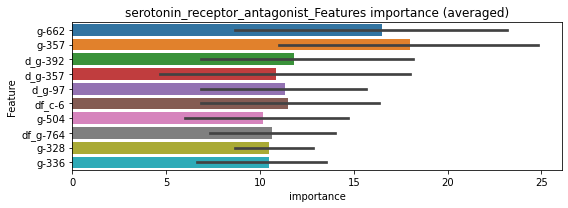

len(train_index) : 3419
len(valid_index) : 3420
================================= fold 1/2 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159498	valid_1's binary_logloss: 0.0748346
Early stopping, best iteration is:
[167]	training's binary_logloss: 0.00537055	valid_1's binary_logloss: 0.0677007


len(train_index) : 3420
len(valid_index) : 3419
================================= fold 2/2 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167945	valid_1's binary_logloss: 0.0757975
Early stopping, best iteration is:
[143]	training's binary_logloss: 0.00839761	valid_1's binary_logloss: 0.0711985


serotonin_receptor_antagonist logloss: 0.06944934530970207


neg labels: 3289 → selected neg labels: 3281


serotonin_reuptake_inhibitor, len(trt): 44, len(othr): 3281, target_rate: 0.0018477 → Adj_target_rate: 0.0020948
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0374681	valid_1's binary_logloss: 0.0825771
[200]	training's binary_logloss: 0.0060833	valid_1's binary_logloss: 0.0445811
[300]	training's binary_logloss: 0.00171632	valid_1's binary_logloss: 0.0365211
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.000995342	valid_1's binary_logloss: 0.0352414
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0383441	valid_1's binary_logloss: 0.0771072
[200]	training's binary_logloss: 0.0062666	valid_1's binary_logloss: 0.0419906
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00213507	valid_1's binary_logloss: 0.0369563


1 / 3 AUC score:0.998
y_Threshold: 0.0075625, Threshold: 0.0098471, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 144 → Positive_corect_labels: 650/3793
p_label_rate: 0.0200904 Vs.target_rate: 0.00185
Num_p_label: 80.0, conf_0:0.00886, conf_1:0.01083
Num_p_label: 80.0, Expected: 7.4, Adj_threshold_1: 0.0098471
Num_p_label: 17.0, Expected: 7.4, Adj_threshold_2: 0.0198471
Num_p_label: 8.0, Expected: 7.4, Adj_threshold_3: 0.0298471
threshold: 0.0298471, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 650.0/3793, y_label_rate: 0.1713683
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0387825	valid_1's binary_logloss: 0.0727445
[200]	training's binary_logloss: 0.0063692	valid_1's binary_logloss: 0.0344722
Early stopping, best iteration is:
[282]	training's binary_logloss: 0.00213638	valid_1's binary_logloss: 0.0286468
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0376358	valid_1's binary_logloss: 0.0759227
[200]	training's binary_logloss: 0.00611048	valid_1's binary_logloss: 0.0326228
[300]	training's binary_logloss: 0.00173677	valid_1's binary_logloss: 0.0234958
[400]	training's binary_logloss: 0.000836975	valid_1's binary_logloss: 0.020845
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000628177	valid_1's binary_logloss: 0.0202225


2 / 3 AUC score:0.999
y_Threshold: 0.0242551, Threshold: 0.0298471, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → Positive_corect_labels: 642.0/3777
p_label_rate: 0.0047715 Vs.target_rate: 0.00185
Num_p_label: 19.0, conf_0:0.02686, conf_1:0.03283
threshold: 0.0298471, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 642.0/3777, y_label_rate: 0.1699762
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0354953	valid_1's binary_logloss: 0.0810943
[200]	training's binary_logloss: 0.00557709	valid_1's binary_logloss: 0.0441772
[300]	training's binary_logloss: 0.00156014	valid_1's binary_logloss: 0.0370145
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00129682	valid_1's binary_logloss: 0.0364865
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0380047	valid_1's binary_logloss: 0.0658331
[200]	training's binary_logloss: 0.00616239	valid_1's binary_logloss: 0.0230533
[300]	training's binary_logloss: 0.00173052	valid_1's binary_logloss: 0.0129942
[400]	training's binary_logloss: 0.000817577	valid_1's binary_logloss: 0.0108741
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00075592	valid_1's binary_logloss: 0.0105535


3 / 3 AUC score:1.000
y_Threshold: 0.0193756, Threshold: 0.0298471, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 636.0/3765
p_label_rate: 0.0032647 Vs.target_rate: 0.00185
Num_p_label: 13.0, conf_0:0.02686, conf_1:0.03283
threshold: 0.0298471, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 649.0/7747, y_label_rate: 0.0837744


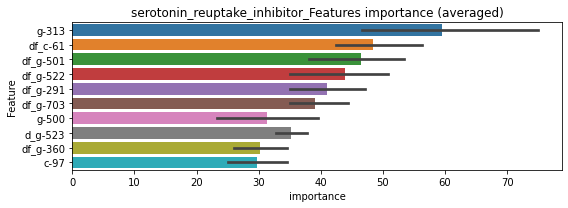

len(train_index) : 3873
len(valid_index) : 3874
================================= fold 1/2 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0208982	valid_1's binary_logloss: 0.0443167
[200]	training's binary_logloss: 0.00328844	valid_1's binary_logloss: 0.0235729
[300]	training's binary_logloss: 0.000903363	valid_1's binary_logloss: 0.02054
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.000796476	valid_1's binary_logloss: 0.0204164


len(train_index) : 3874
len(valid_index) : 3873
================================= fold 2/2 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209425	valid_1's binary_logloss: 0.0396911
[200]	training's binary_logloss: 0.00341272	valid_1's binary_logloss: 0.0184772
[300]	training's binary_logloss: 0.000947459	valid_1's binary_logloss: 0.0153421
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.000643902	valid_1's binary_logloss: 0.0149452


serotonin_reuptake_inhibitor logloss: 0.017681123761307586


neg labels: 3289 → selected neg labels: 3283


sigma_receptor_agonist, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0390098	valid_1's binary_logloss: 0.0637557
[200]	training's binary_logloss: 0.00619327	valid_1's binary_logloss: 0.0208466
[300]	training's binary_logloss: 0.00167615	valid_1's binary_logloss: 0.0115227
[400]	training's binary_logloss: 0.00078331	valid_1's binary_logloss: 0.00835123
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00078331	valid_1's binary_logloss: 0.00835123
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0386821	valid_1's binary_logloss: 0.0623375
[200]	training's binary_logloss: 0.00604882	valid_1's binary_logloss: 0.0209433
[300]	training's binary_logloss: 0.00162882	valid_1's binary_logloss: 0.0125214
[400]	training's binary_logloss: 0.000768771	valid_1's binary_logloss: 0.010205
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.000601545	valid_1's binary_logloss: 0.00948819


1 / 3 AUC score:1.000
y_Threshold: 0.0052510, Threshold: 0.0075333, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151
Num_p_label: 80.0, conf_0:0.00678, conf_1:0.00829
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0075333
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_2: 0.0175333
Num_p_label: 7.0, Expected: 6.0, Adj_threshold_3: 0.0275333
threshold: 0.0275333, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0388542	valid_1's binary_logloss: 0.0588471
[200]	training's binary_logloss: 0.00597486	valid_1's binary_logloss: 0.0168006
[300]	training's binary_logloss: 0.00160609	valid_1's binary_logloss: 0.00804861
[400]	training's binary_logloss: 0.000766862	valid_1's binary_logloss: 0.00568491
[500]	training's binary_logloss: 0.000507728	valid_1's binary_logloss: 0.00491684
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000514537	valid_1's binary_logloss: 0.00488791
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0370808	valid_1's binary_logloss: 0.0592074
[200]	training's binary_logloss: 0.00556	valid_1's binary_logloss: 0.0184038
[300]	training's binary_logloss: 0.00153129	valid_1's binary_logloss: 0.0109245
[400]	training's binary_logloss: 0.000743353	valid_1's binary_logloss: 0.00907886
Early stopping, best iteration is:
[416

2 / 3 AUC score:1.000
y_Threshold: 0.0334185, Threshold: 0.0275333, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0042692 Vs.target_rate: 0.00151
Num_p_label: 17.0, conf_0:0.02478, conf_1:0.03029
threshold: 0.0275333, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0382808	valid_1's binary_logloss: 0.0639054
[200]	training's binary_logloss: 0.00590383	valid_1's binary_logloss: 0.0172873
[300]	training's binary_logloss: 0.00161867	valid_1's binary_logloss: 0.00771347
[400]	training's binary_logloss: 0.000771281	valid_1's binary_logloss: 0.00505598
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000578936	valid_1's binary_logloss: 0.00446712
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0381844	valid_1's binary_logloss: 0.0620572
[200]	training's binary_logloss: 0.00569342	valid_1's binary_logloss: 0.0178816
[300]	training's binary_logloss: 0.0015623	valid_1's binary_logloss: 0.00954542
[400]	training's binary_logloss: 0.000752661	valid_1's binary_logloss: 0.00710888
[500]	training's binary_logloss: 0.000500157	valid_1's binary_logloss: 0.00612411
Early stopping, best iteration is:
[

3 / 3 AUC score:1.000
y_Threshold: 0.0815395, Threshold: 0.0275333, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0040181 Vs.target_rate: 0.00151
Num_p_label: 16.0, conf_0:0.02478, conf_1:0.03029
threshold: 0.0275333, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 671.0/7787, y_label_rate: 0.0861693


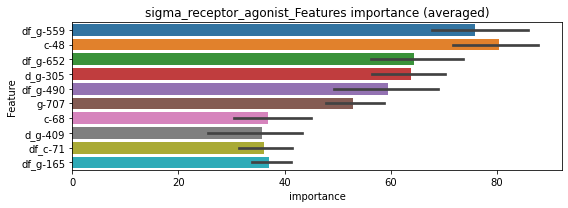

len(train_index) : 3893
len(valid_index) : 3894
================================= fold 1/2 sigma_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213867	valid_1's binary_logloss: 0.0491174
[200]	training's binary_logloss: 0.00327341	valid_1's binary_logloss: 0.0315632
Early stopping, best iteration is:
[201]	training's binary_logloss: 0.00321411	valid_1's binary_logloss: 0.0315231


len(train_index) : 3894
len(valid_index) : 3893
================================= fold 2/2 sigma_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231552	valid_1's binary_logloss: 0.0363902
[200]	training's binary_logloss: 0.00363147	valid_1's binary_logloss: 0.0132706
[300]	training's binary_logloss: 0.000924472	valid_1's binary_logloss: 0.0092502
Early stopping, best iteration is:
[358]	training's binary_logloss: 0.000565541	valid_1's binary_logloss: 0.00888051


sigma_receptor_agonist logloss: 0.020203248880577784


neg labels: 3289 → selected neg labels: 3283


sigma_receptor_antagonist, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0353475	valid_1's binary_logloss: 0.0587879
[200]	training's binary_logloss: 0.00541993	valid_1's binary_logloss: 0.018951
[300]	training's binary_logloss: 0.00153681	valid_1's binary_logloss: 0.0107457
[400]	training's binary_logloss: 0.000738719	valid_1's binary_logloss: 0.00764389
[500]	training's binary_logloss: 0.000497252	valid_1's binary_logloss: 0.00700313
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.000507589	valid_1's binary_logloss: 0.00698452
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0355693	valid_1's binary_logloss: 0.0654524
[200]	training's binary_logloss: 0.00549909	valid_1's binary_logloss: 0.0267014
[300]	training's binary_logloss: 0.0015387	valid_1's binary_logloss: 0.0184213
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.000979326	valid_1's binary_logloss: 0.0169802


1 / 3 AUC score:1.000
y_Threshold: 0.0044679, Threshold: 0.0064624, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151
Num_p_label: 80.0, conf_0:0.00582, conf_1:0.00711
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0064624
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_2: 0.0164624
Num_p_label: 8.0, Expected: 6.0, Adj_threshold_3: 0.0264624
threshold: 0.0264624, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0346463	valid_1's binary_logloss: 0.0560489
[200]	training's binary_logloss: 0.00516702	valid_1's binary_logloss: 0.0172773
[300]	training's binary_logloss: 0.00147904	valid_1's binary_logloss: 0.00986171
[400]	training's binary_logloss: 0.000731134	valid_1's binary_logloss: 0.00717512
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00056998	valid_1's binary_logloss: 0.00661069
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.034691	valid_1's binary_logloss: 0.064917
[200]	training's binary_logloss: 0.00525958	valid_1's binary_logloss: 0.0272487
[300]	training's binary_logloss: 0.00147807	valid_1's binary_logloss: 0.0187959
[400]	training's binary_logloss: 0.000721239	valid_1's binary_logloss: 0.0174635
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000740498	valid_1's binary_logloss: 0.0174074


2 / 3 AUC score:1.000
y_Threshold: 0.0173656, Threshold: 0.0264624, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 653.0/3801
p_label_rate: 0.0037670 Vs.target_rate: 0.00151
Num_p_label: 15.0, conf_0:0.02382, conf_1:0.02911
threshold: 0.0264624, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 653.0/3801, y_label_rate: 0.1717969
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0353254	valid_1's binary_logloss: 0.0546957
[200]	training's binary_logloss: 0.00526413	valid_1's binary_logloss: 0.0165015
[300]	training's binary_logloss: 0.00149007	valid_1's binary_logloss: 0.00929811
[400]	training's binary_logloss: 0.000724079	valid_1's binary_logloss: 0.00727574
[500]	training's binary_logloss: 0.000490096	valid_1's binary_logloss: 0.006641
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000500669	valid_1's binary_logloss: 0.00663842
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0343416	valid_1's binary_logloss: 0.0528662
[200]	training's binary_logloss: 0.00521251	valid_1's binary_logloss: 0.0123155
[300]	training's binary_logloss: 0.00148804	valid_1's binary_logloss: 0.00498672
[400]	training's binary_logloss: 0.000730914	valid_1's binary_logloss: 0.0030768
[500]	training's binary_logloss: 0.000

3 / 3 AUC score:1.000
y_Threshold: 0.0374404, Threshold: 0.0264624, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 653.0/3801
p_label_rate: 0.0032647 Vs.target_rate: 0.00151
Num_p_label: 13.0, conf_0:0.02382, conf_1:0.02911
threshold: 0.0264624, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 666.0/7783, y_label_rate: 0.0855711


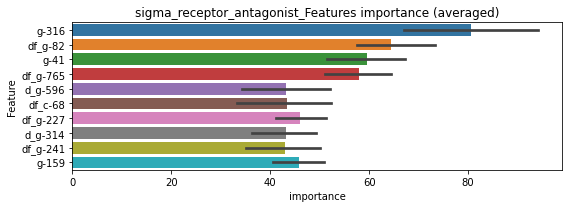

len(train_index) : 3891
len(valid_index) : 3892
================================= fold 1/2 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197216	valid_1's binary_logloss: 0.038709
[200]	training's binary_logloss: 0.00295719	valid_1's binary_logloss: 0.0170553
Early stopping, best iteration is:
[237]	training's binary_logloss: 0.00167706	valid_1's binary_logloss: 0.0151545


len(train_index) : 3892
len(valid_index) : 3891
================================= fold 2/2 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0201353	valid_1's binary_logloss: 0.0377813
[200]	training's binary_logloss: 0.00315455	valid_1's binary_logloss: 0.0157915
[300]	training's binary_logloss: 0.000857552	valid_1's binary_logloss: 0.0117689
[400]	training's binary_logloss: 0.00040444	valid_1's binary_logloss: 0.0107849
Early stopping, best iteration is:
[398]	training's binary_logloss: 0.000409055	valid_1's binary_logloss: 0.0107421


sigma_receptor_antagonist logloss: 0.012948584858753923


neg labels: 3289 → selected neg labels: 3284


smoothened_receptor_antagonist, len(trt): 25, len(othr): 3284, target_rate: 0.0010498 → Adj_target_rate: 0.0012955
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297609	valid_1's binary_logloss: 0.0471021
[200]	training's binary_logloss: 0.00407005	valid_1's binary_logloss: 0.0120198
[300]	training's binary_logloss: 0.00111564	valid_1's binary_logloss: 0.00582828
[400]	training's binary_logloss: 0.000545193	valid_1's binary_logloss: 0.00423811
[500]	training's binary_logloss: 0.000395599	valid_1's binary_logloss: 0.00391416
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.000401518	valid_1's binary_logloss: 0.00390673
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0301349	valid_1's binary_logloss: 0.0467362
[200]	training's binary_logloss: 0.00402286	valid_1's binary_logloss: 0.0114574
[300]	training's binary_logloss: 0.00111543	valid_1's binary_logloss: 0.00515188
[400]	training's binary_logloss: 0.000559257	valid_1's binary_logloss: 0.00356706
Early stopping, best iteration is:


1 / 3 AUC score:1.000
y_Threshold: 0.0022744, Threshold: 0.0037177, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00105
Num_p_label: 80.0, conf_0:0.00335, conf_1:0.00409
Num_p_label: 80.0, Expected: 4.2, Adj_threshold_1: 0.0037177
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_2: 0.0137177
Num_p_label: 5.0, Expected: 4.2, Adj_threshold_3: 0.0237177
threshold: 0.0237177, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289908	valid_1's binary_logloss: 0.0477654
[200]	training's binary_logloss: 0.00384149	valid_1's binary_logloss: 0.0130153
[300]	training's binary_logloss: 0.00108352	valid_1's binary_logloss: 0.00709946
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000625493	valid_1's binary_logloss: 0.00570155
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0298621	valid_1's binary_logloss: 0.0458862
[200]	training's binary_logloss: 0.0039273	valid_1's binary_logloss: 0.0103585
[300]	training's binary_logloss: 0.00109031	valid_1's binary_logloss: 0.00454514
[400]	training's binary_logloss: 0.000553228	valid_1's binary_logloss: 0.0028808
[500]	training's binary_logloss: 0.000399658	valid_1's binary_logloss: 0.00249434
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000404967	valid_1's binary_logloss: 0.00249281


2 / 3 AUC score:1.000
y_Threshold: 0.0211040, Threshold: 0.0237177, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0027624 Vs.target_rate: 0.00105
Num_p_label: 11.0, conf_0:0.02135, conf_1:0.02609
threshold: 0.0237177, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289908	valid_1's binary_logloss: 0.0477654
[200]	training's binary_logloss: 0.00384149	valid_1's binary_logloss: 0.0130153
[300]	training's binary_logloss: 0.00108352	valid_1's binary_logloss: 0.00709946
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000625493	valid_1's binary_logloss: 0.00570155
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0298621	valid_1's binary_logloss: 0.0458862
[200]	training's binary_logloss: 0.0039273	valid_1's binary_logloss: 0.0103585
[300]	training's binary_logloss: 0.00109031	valid_1's binary_logloss: 0.00454514
[400]	training's binary_logloss: 0.000553228	valid_1's binary_logloss: 0.0028808
[500]	training's binary_logloss: 0.000399658	valid_1's binary_logloss: 0.00249434
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000404967	valid_1's binary_logloss: 0.00249281


3 / 3 AUC score:1.000
y_Threshold: 0.0211040, Threshold: 0.0237177, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0027624 Vs.target_rate: 0.00105
Num_p_label: 11.0, conf_0:0.02135, conf_1:0.02609
threshold: 0.0237177, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 667.0/7790, y_label_rate: 0.0856226


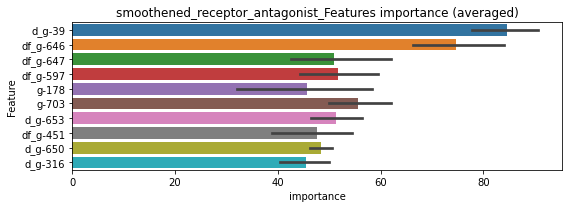

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160606	valid_1's binary_logloss: 0.0320181
[200]	training's binary_logloss: 0.00212129	valid_1's binary_logloss: 0.0147496
[300]	training's binary_logloss: 0.000585367	valid_1's binary_logloss: 0.0126109
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.000485395	valid_1's binary_logloss: 0.0125295


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159184	valid_1's binary_logloss: 0.0310472
[200]	training's binary_logloss: 0.00219471	valid_1's binary_logloss: 0.0123819
[300]	training's binary_logloss: 0.000614944	valid_1's binary_logloss: 0.00841083
[400]	training's binary_logloss: 0.000301442	valid_1's binary_logloss: 0.00750489
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000293988	valid_1's binary_logloss: 0.00743211


smoothened_receptor_antagonist logloss: 0.009980779895904493


neg labels: 3289 → selected neg labels: 3244


sodium_channel_inhibitor, len(trt): 267, len(othr): 3244, target_rate: 0.0112119 → Adj_target_rate: 0.0096991
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108217	valid_1's binary_logloss: 0.300159
Early stopping, best iteration is:
[170]	training's binary_logloss: 0.0516857	valid_1's binary_logloss: 0.278711
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114153	valid_1's binary_logloss: 0.283826
[200]	training's binary_logloss: 0.0411629	valid_1's binary_logloss: 0.247754
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.0218363	valid_1's binary_logloss: 0.241829


1 / 3 AUC score:0.875
y_Threshold: 0.0945010, Threshold: 0.1348698, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 475 → Positive_corect_labels: 476/3417
p_label_rate: 0.0200904 Vs.target_rate: 0.01121
Num_p_label: 80.0, conf_0:0.12138, conf_1:0.14836
threshold: 0.1348698, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 476.0/3417, y_label_rate: 0.1393035
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0739854	valid_1's binary_logloss: 0.202807
[200]	training's binary_logloss: 0.0215312	valid_1's binary_logloss: 0.16771
Early stopping, best iteration is:
[276]	training's binary_logloss: 0.00918619	valid_1's binary_logloss: 0.159864
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0719512	valid_1's binary_logloss: 0.211071
Early stopping, best iteration is:
[187]	training's binary_logloss: 0.0251868	valid_1's binary_logloss: 0.179418


2 / 3 AUC score:0.955
y_Threshold: 0.0851768, Threshold: 0.1348698, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 182 → Positive_corect_labels: 385.0/3235
p_label_rate: 0.0100452 Vs.target_rate: 0.01121
Num_p_label: 40.0, conf_0:0.12138, conf_1:0.14836
threshold: 0.1348698, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 385.0/3235, y_label_rate: 0.1190108
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0586339	valid_1's binary_logloss: 0.156136
[200]	training's binary_logloss: 0.0155374	valid_1's binary_logloss: 0.122769
Early stopping, best iteration is:
[268]	training's binary_logloss: 0.00722038	valid_1's binary_logloss: 0.116616
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0573306	valid_1's binary_logloss: 0.158008
[200]	training's binary_logloss: 0.0132958	valid_1's binary_logloss: 0.116376
Early stopping, best iteration is:
[227]	training's binary_logloss: 0.00938334	valid_1's binary_logloss: 0.112091


3 / 3 AUC score:0.980
y_Threshold: 0.0710289, Threshold: 0.1348698, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 92 → Positive_corect_labels: 339.0/3143
p_label_rate: 0.0060271 Vs.target_rate: 0.01121
Num_p_label: 24.0, conf_0:0.12138, conf_1:0.14836
threshold: 0.1348698, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 363.0/7125, y_label_rate: 0.0509474


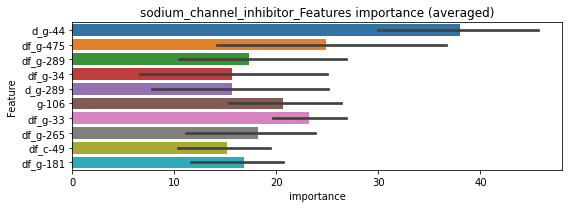

len(train_index) : 3562
len(valid_index) : 3563
================================= fold 1/2 sodium_channel_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245134	valid_1's binary_logloss: 0.0894254
[200]	training's binary_logloss: 0.00621333	valid_1's binary_logloss: 0.0773835
Early stopping, best iteration is:
[211]	training's binary_logloss: 0.00538444	valid_1's binary_logloss: 0.0769262


len(train_index) : 3563
len(valid_index) : 3562
================================= fold 2/2 sodium_channel_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0246625	valid_1's binary_logloss: 0.0898996
[200]	training's binary_logloss: 0.00573423	valid_1's binary_logloss: 0.0799945
Early stopping, best iteration is:
[192]	training's binary_logloss: 0.0064032	valid_1's binary_logloss: 0.07982


sodium_channel_inhibitor logloss: 0.0783729434687126


neg labels: 3289 → selected neg labels: 3283


sphingosine_receptor_agonist, len(trt): 32, len(othr): 3283, target_rate: 0.0013437 → Adj_target_rate: 0.0015980
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330227	valid_1's binary_logloss: 0.0527848
[200]	training's binary_logloss: 0.00478977	valid_1's binary_logloss: 0.01471
[300]	training's binary_logloss: 0.00132996	valid_1's binary_logloss: 0.00737169
[400]	training's binary_logloss: 0.00065124	valid_1's binary_logloss: 0.00547082
[500]	training's binary_logloss: 0.000449363	valid_1's binary_logloss: 0.00474411
Early stopping, best iteration is:
[538]	training's binary_logloss: 0.000423435	valid_1's binary_logloss: 0.00460894
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0322414	valid_1's binary_logloss: 0.0538191
[200]	training's binary_logloss: 0.00472361	valid_1's binary_logloss: 0.0204506
[300]	training's binary_logloss: 0.00131039	valid_1's binary_logloss: 0.0142763
[400]	training's binary_logloss: 0.000643327	valid_1's binary_logloss: 0.0128975
Early stopping, best iteration is:
[404]

1 / 3 AUC score:1.000
y_Threshold: 0.0035589, Threshold: 0.0062716, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00134
Num_p_label: 80.0, conf_0:0.00564, conf_1:0.00690
Num_p_label: 80.0, Expected: 5.4, Adj_threshold_1: 0.0062716
Num_p_label: 18.0, Expected: 5.4, Adj_threshold_2: 0.0162716
Num_p_label: 6.0, Expected: 5.4, Adj_threshold_3: 0.0262716
threshold: 0.0262716, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0322397	valid_1's binary_logloss: 0.0522176
[200]	training's binary_logloss: 0.00455796	valid_1's binary_logloss: 0.0136201
[300]	training's binary_logloss: 0.00127641	valid_1's binary_logloss: 0.00674408
[400]	training's binary_logloss: 0.000636828	valid_1's binary_logloss: 0.00523044
[500]	training's binary_logloss: 0.000437011	valid_1's binary_logloss: 0.00439659
Early stopping, best iteration is:
[529]	training's binary_logloss: 0.000420301	valid_1's binary_logloss: 0.00435482
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0329449	valid_1's binary_logloss: 0.056762
[200]	training's binary_logloss: 0.00464552	valid_1's binary_logloss: 0.0208502
[300]	training's binary_logloss: 0.0012879	valid_1's binary_logloss: 0.0150786
[400]	training's binary_logloss: 0.000636279	valid_1's binary_logloss: 0.0136706
Early stopping, best iteration is:
[411

2 / 3 AUC score:1.000
y_Threshold: 0.0186088, Threshold: 0.0262716, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 654.0/3803
p_label_rate: 0.0052737 Vs.target_rate: 0.00134
Num_p_label: 21.0, conf_0:0.02364, conf_1:0.02890
Num_p_label: 21.0, Expected: 5.4, Adj_threshold_1: 0.0262716
Num_p_label: 11.0, Expected: 5.4, Adj_threshold_2: 0.0362716
Num_p_label: 9.0, Expected: 5.4, Adj_threshold_3: 0.0462716
threshold: 0.0462716, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 654.0/3803, y_label_rate: 0.1719695
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335185	valid_1's binary_logloss: 0.0569263
[200]	training's binary_logloss: 0.00472403	valid_1's binary_logloss: 0.0150332
[300]	training's binary_logloss: 0.00131273	valid_1's binary_logloss: 0.00676443
[400]	training's binary_logloss: 0.000642534	valid_1's binary_logloss: 0.00455426
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.00048385	valid_1's binary_logloss: 0.00392328
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0321525	valid_1's binary_logloss: 0.053739
[200]	training's binary_logloss: 0.00445901	valid_1's binary_logloss: 0.0147431
[300]	training's binary_logloss: 0.00125944	valid_1's binary_logloss: 0.00819239
[400]	training's binary_logloss: 0.000621766	valid_1's binary_logloss: 0.00620713
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.000591769	valid_1's binary_logloss: 0.00614296


3 / 3 AUC score:1.000
y_Threshold: 0.0474010, Threshold: 0.0462716, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 654.0/3803
p_label_rate: 0.0012557 Vs.target_rate: 0.00134
Num_p_label: 5.0, conf_0:0.04164, conf_1:0.05090
threshold: 0.0462716, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 659.0/7785, y_label_rate: 0.0846500


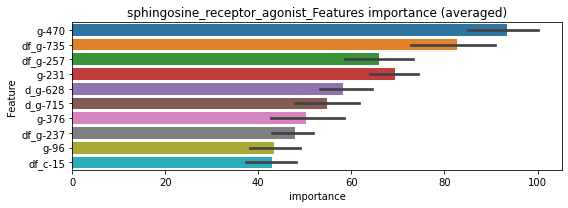

len(train_index) : 3892
len(valid_index) : 3893
================================= fold 1/2 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179196	valid_1's binary_logloss: 0.0322083
[200]	training's binary_logloss: 0.00250434	valid_1's binary_logloss: 0.0130372
[300]	training's binary_logloss: 0.000678871	valid_1's binary_logloss: 0.00958674
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.000497857	valid_1's binary_logloss: 0.0093559


len(train_index) : 3893
len(valid_index) : 3892
================================= fold 2/2 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0177982	valid_1's binary_logloss: 0.0371265
[200]	training's binary_logloss: 0.00244123	valid_1's binary_logloss: 0.0199103
[300]	training's binary_logloss: 0.000676067	valid_1's binary_logloss: 0.0173327
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.000586556	valid_1's binary_logloss: 0.0171754


sphingosine_receptor_agonist logloss: 0.01326516505972329


neg labels: 3289 → selected neg labels: 3277


src_inhibitor, len(trt): 71, len(othr): 3277, target_rate: 0.0029814 → Adj_target_rate: 0.0031461
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0437718	valid_1's binary_logloss: 0.0954985
[200]	training's binary_logloss: 0.00853558	valid_1's binary_logloss: 0.0431669
[300]	training's binary_logloss: 0.00235796	valid_1's binary_logloss: 0.0284447
[400]	training's binary_logloss: 0.00108345	valid_1's binary_logloss: 0.0244864
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000802297	valid_1's binary_logloss: 0.023172
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0436276	valid_1's binary_logloss: 0.0917183
[200]	training's binary_logloss: 0.00802616	valid_1's binary_logloss: 0.0487255
[300]	training's binary_logloss: 0.00235988	valid_1's binary_logloss: 0.039357
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.00188983	valid_1's binary_logloss: 0.0382646


1 / 3 AUC score:0.999
y_Threshold: 0.0133133, Threshold: 0.0364133, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 140 → Positive_corect_labels: 651/3792
p_label_rate: 0.0200904 Vs.target_rate: 0.00298
Num_p_label: 80.0, conf_0:0.03277, conf_1:0.04005
Num_p_label: 80.0, Expected: 11.9, Adj_threshold_1: 0.0364133
Num_p_label: 60.0, Expected: 11.9, Adj_threshold_2: 0.0464133
Num_p_label: 49.0, Expected: 11.9, Adj_threshold_3: 0.0564133
Num_p_label: 35.0, Expected: 11.9, Adj_threshold_4: 0.0664133
Num_p_label: 32.0, Expected: 11.9, Adj_threshold_5: 0.0764133
Num_p_label: 28.0, Expected: 11.9, Adj_threshold_6: 0.0864133
Num_p_label: 25.0, Expected: 11.9, Adj_threshold_7: 0.0964133
Num_p_label: 22.0, Expected: 11.9, Adj_threshold_8: 0.1064133
threshold: 0.1064133, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 651.0/3792, y_label_rate: 0.1716772
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0414173	valid_1's binary_logloss: 0.0960618
[200]	training's binary_logloss: 0.00739444	valid_1's binary_logloss: 0.0550014
[300]	training's binary_logloss: 0.00212979	valid_1's binary_logloss: 0.0458269
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.00114621	valid_1's binary_logloss: 0.0437686
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0399976	valid_1's binary_logloss: 0.0880375
[200]	training's binary_logloss: 0.00683194	valid_1's binary_logloss: 0.0450054
[300]	training's binary_logloss: 0.002003	valid_1's binary_logloss: 0.0335428
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.00154964	valid_1's binary_logloss: 0.0314784


2 / 3 AUC score:0.998
y_Threshold: 0.0599022, Threshold: 0.1064133, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 30 → Positive_corect_labels: 636.0/3762
p_label_rate: 0.0208438 Vs.target_rate: 0.00298
Num_p_label: 83.0, conf_0:0.09577, conf_1:0.11705
Num_p_label: 83.0, Expected: 11.9, Adj_threshold_1: 0.1064133
Num_p_label: 76.0, Expected: 11.9, Adj_threshold_2: 0.1164133
Num_p_label: 73.0, Expected: 11.9, Adj_threshold_3: 0.1264133
Num_p_label: 64.0, Expected: 11.9, Adj_threshold_4: 0.1364133
Num_p_label: 58.0, Expected: 11.9, Adj_threshold_5: 0.1464133
Num_p_label: 55.0, Expected: 11.9, Adj_threshold_6: 0.1564133
Num_p_label: 53.0, Expected: 11.9, Adj_threshold_7: 0.1664133
Num_p_label: 51.0, Expected: 11.9, Adj_threshold_8: 0.1764133
Num_p_label: 48.0, Expected: 11.9, Adj_threshold_9: 0.1864133
Num_p_label: 45.0, Expected: 11.9, Adj_threshold_10: 0.1964133
threshold: 0.2064133, positive_p_label: 42.0/3982, p_label_rate: 0.0105475
positive_y_label: 636.0/3762, y_label_rate: 0.169059

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.039351	valid_1's binary_logloss: 0.0809234
[200]	training's binary_logloss: 0.00676746	valid_1's binary_logloss: 0.0329306
[300]	training's binary_logloss: 0.00197494	valid_1's binary_logloss: 0.0230185
[400]	training's binary_logloss: 0.000944925	valid_1's binary_logloss: 0.0193978
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000792763	valid_1's binary_logloss: 0.0186664
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.038878	valid_1's binary_logloss: 0.0821204
[200]	training's binary_logloss: 0.00639811	valid_1's binary_logloss: 0.0400347
[300]	training's binary_logloss: 0.00190282	valid_1's binary_logloss: 0.0299976
[400]	training's binary_logloss: 0.000928695	valid_1's binary_logloss: 0.0269172
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.000928695	valid_1's binary_logloss: 0.0269172


3 / 3 AUC score:1.000
y_Threshold: 0.0826701, Threshold: 0.2064133, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → Positive_corect_labels: 628.0/3746
p_label_rate: 0.0163235 Vs.target_rate: 0.00298
Num_p_label: 65.0, conf_0:0.18577, conf_1:0.22705
Num_p_label: 65.0, Expected: 11.9, Adj_threshold_1: 0.2064133
Num_p_label: 61.0, Expected: 11.9, Adj_threshold_2: 0.2164133
Num_p_label: 56.0, Expected: 11.9, Adj_threshold_3: 0.2264133
Num_p_label: 54.0, Expected: 11.9, Adj_threshold_4: 0.2364133
Num_p_label: 52.0, Expected: 11.9, Adj_threshold_5: 0.2464133
Num_p_label: 52.0, Expected: 11.9, Adj_threshold_6: 0.2564133
Num_p_label: 50.0, Expected: 11.9, Adj_threshold_7: 0.2664133
Num_p_label: 49.0, Expected: 11.9, Adj_threshold_8: 0.2764133
Num_p_label: 45.0, Expected: 11.9, Adj_threshold_9: 0.2864133
Num_p_label: 42.0, Expected: 11.9, Adj_threshold_10: 0.2964133
threshold: 0.3064133, positive_p_label: 42.0/3982, p_label_rate: 0.0105475
positive_y_label: 670.0/7728, y_label_rate: 0.086697

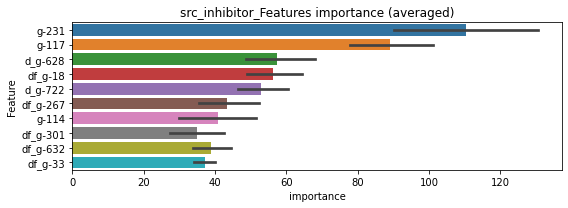

len(train_index) : 3864
len(valid_index) : 3864
================================= fold 1/2 src_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221233	valid_1's binary_logloss: 0.051994
[200]	training's binary_logloss: 0.00398173	valid_1's binary_logloss: 0.0285907
[300]	training's binary_logloss: 0.00116961	valid_1's binary_logloss: 0.0229098
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00101868	valid_1's binary_logloss: 0.0226282


len(train_index) : 3864
len(valid_index) : 3864
================================= fold 2/2 src_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0224998	valid_1's binary_logloss: 0.0558712
[200]	training's binary_logloss: 0.00434709	valid_1's binary_logloss: 0.0318825
[300]	training's binary_logloss: 0.00114686	valid_1's binary_logloss: 0.0253057
[400]	training's binary_logloss: 0.000537824	valid_1's binary_logloss: 0.0232383
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.000432815	valid_1's binary_logloss: 0.0226255


src_inhibitor logloss: 0.022626822687112382


neg labels: 3289 → selected neg labels: 3276


steroid, len(trt): 79, len(othr): 3276, target_rate: 0.0033174 → Adj_target_rate: 0.0034449
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0524963	valid_1's binary_logloss: 0.118867
[200]	training's binary_logloss: 0.0112887	valid_1's binary_logloss: 0.0705756
[300]	training's binary_logloss: 0.00332909	valid_1's binary_logloss: 0.059568
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00166186	valid_1's binary_logloss: 0.0567866
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0573711	valid_1's binary_logloss: 0.119736
[200]	training's binary_logloss: 0.0118538	valid_1's binary_logloss: 0.0720718
[300]	training's binary_logloss: 0.00335059	valid_1's binary_logloss: 0.0610679
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.00202494	valid_1's binary_logloss: 0.0597502


1 / 3 AUC score:0.994
y_Threshold: 0.0159160, Threshold: 0.0297899, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 162 → Positive_corect_labels: 640/3769
p_label_rate: 0.0200904 Vs.target_rate: 0.00332
Num_p_label: 80.0, conf_0:0.02681, conf_1:0.03277
Num_p_label: 80.0, Expected: 13.2, Adj_threshold_1: 0.0297899
Num_p_label: 53.0, Expected: 13.2, Adj_threshold_2: 0.0397899
Num_p_label: 39.0, Expected: 13.2, Adj_threshold_3: 0.0497899
Num_p_label: 23.0, Expected: 13.2, Adj_threshold_4: 0.0597899
threshold: 0.0597899, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 640.0/3769, y_label_rate: 0.1698063
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0495418	valid_1's binary_logloss: 0.108508
[200]	training's binary_logloss: 0.010077	valid_1's binary_logloss: 0.0605215
[300]	training's binary_logloss: 0.00289729	valid_1's binary_logloss: 0.0514142
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.00245123	valid_1's binary_logloss: 0.0508821
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0515813	valid_1's binary_logloss: 0.0927553
[200]	training's binary_logloss: 0.0105184	valid_1's binary_logloss: 0.0440689
[300]	training's binary_logloss: 0.00303678	valid_1's binary_logloss: 0.0312507
[400]	training's binary_logloss: 0.00137891	valid_1's binary_logloss: 0.0272035
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.00104666	valid_1's binary_logloss: 0.0261444


2 / 3 AUC score:0.998
y_Threshold: 0.0493882, Threshold: 0.0597899, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 20 → Positive_corect_labels: 630.0/3749
p_label_rate: 0.0125565 Vs.target_rate: 0.00332
Num_p_label: 50.0, conf_0:0.05381, conf_1:0.06577
Num_p_label: 50.0, Expected: 13.2, Adj_threshold_1: 0.0597899
Num_p_label: 37.0, Expected: 13.2, Adj_threshold_2: 0.0697899
Num_p_label: 31.0, Expected: 13.2, Adj_threshold_3: 0.0797899
Num_p_label: 25.0, Expected: 13.2, Adj_threshold_4: 0.0897899
threshold: 0.0897899, positive_p_label: 25.0/3982, p_label_rate: 0.0062783
positive_y_label: 630.0/3749, y_label_rate: 0.1680448
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0487763	valid_1's binary_logloss: 0.107884
[200]	training's binary_logloss: 0.00919601	valid_1's binary_logloss: 0.0608604
[300]	training's binary_logloss: 0.00263922	valid_1's binary_logloss: 0.0510155
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00263922	valid_1's binary_logloss: 0.0510155
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0494773	valid_1's binary_logloss: 0.110825
[200]	training's binary_logloss: 0.00964738	valid_1's binary_logloss: 0.0718804
[300]	training's binary_logloss: 0.00274865	valid_1's binary_logloss: 0.0652235
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.00295073	valid_1's binary_logloss: 0.0649142


3 / 3 AUC score:0.990
y_Threshold: 0.0581338, Threshold: 0.0897899, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 50 → Positive_corect_labels: 605.0/3699
p_label_rate: 0.0125565 Vs.target_rate: 0.00332
Num_p_label: 50.0, conf_0:0.08081, conf_1:0.09877
Num_p_label: 50.0, Expected: 13.2, Adj_threshold_1: 0.0897899
Num_p_label: 42.0, Expected: 13.2, Adj_threshold_2: 0.0997899
Num_p_label: 32.0, Expected: 13.2, Adj_threshold_3: 0.1097899
Num_p_label: 30.0, Expected: 13.2, Adj_threshold_4: 0.1197899
Num_p_label: 28.0, Expected: 13.2, Adj_threshold_5: 0.1297899
Num_p_label: 26.0, Expected: 13.2, Adj_threshold_6: 0.1397899
threshold: 0.1397899, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 631.0/7681, y_label_rate: 0.0821508


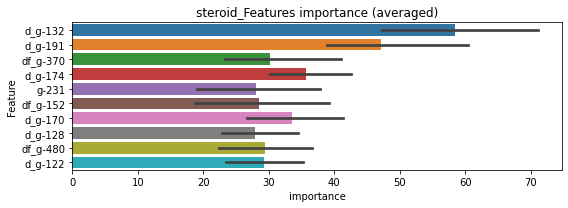

len(train_index) : 3840
len(valid_index) : 3841
================================= fold 1/2 steroid=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.02679	valid_1's binary_logloss: 0.0597711
[200]	training's binary_logloss: 0.00519865	valid_1's binary_logloss: 0.0370675
[300]	training's binary_logloss: 0.00146397	valid_1's binary_logloss: 0.0326701
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.00106853	valid_1's binary_logloss: 0.0317783


len(train_index) : 3841
len(valid_index) : 3840
================================= fold 2/2 steroid=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0272565	valid_1's binary_logloss: 0.057967
[200]	training's binary_logloss: 0.00532692	valid_1's binary_logloss: 0.0328059
[300]	training's binary_logloss: 0.00150967	valid_1's binary_logloss: 0.0283585
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00124958	valid_1's binary_logloss: 0.0280416


steroid logloss: 0.029910191640556322


neg labels: 3289 → selected neg labels: 3286


syk_inhibitor, len(trt): 19, len(othr): 3286, target_rate: 0.0007979 → Adj_target_rate: 0.0010260
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0206642	valid_1's binary_logloss: 0.0311918
[200]	training's binary_logloss: 0.00227053	valid_1's binary_logloss: 0.00864962
[300]	training's binary_logloss: 0.000649541	valid_1's binary_logloss: 0.00533765
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.0004277	valid_1's binary_logloss: 0.00492054
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0211281	valid_1's binary_logloss: 0.0243127
[200]	training's binary_logloss: 0.00236266	valid_1's binary_logloss: 0.00370928
[300]	training's binary_logloss: 0.000670372	valid_1's binary_logloss: 0.00158238
[400]	training's binary_logloss: 0.000362199	valid_1's binary_logloss: 0.0011223
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.000307765	valid_1's binary_logloss: 0.00101885


1 / 3 AUC score:1.000
y_Threshold: 0.0021927, Threshold: 0.0040280, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00080
Num_p_label: 80.0, conf_0:0.00363, conf_1:0.00443
Num_p_label: 80.0, Expected: 3.2, Adj_threshold_1: 0.0040280
Num_p_label: 28.0, Expected: 3.2, Adj_threshold_2: 0.0140280
Num_p_label: 16.0, Expected: 3.2, Adj_threshold_3: 0.0240280
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_4: 0.0340280
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_5: 0.0440280
Num_p_label: 6.0, Expected: 3.2, Adj_threshold_6: 0.0540280
threshold: 0.0540280, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204862	valid_1's binary_logloss: 0.0331538
[200]	training's binary_logloss: 0.00218437	valid_1's binary_logloss: 0.0112599
[300]	training's binary_logloss: 0.000615355	valid_1's binary_logloss: 0.0081755
[400]	training's binary_logloss: 0.000340727	valid_1's binary_logloss: 0.00739542
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.000300676	valid_1's binary_logloss: 0.00722756
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0207988	valid_1's binary_logloss: 0.0236076
[200]	training's binary_logloss: 0.00226798	valid_1's binary_logloss: 0.00306578
[300]	training's binary_logloss: 0.000638959	valid_1's binary_logloss: 0.000996487
[400]	training's binary_logloss: 0.000346134	valid_1's binary_logloss: 0.000568192
[500]	training's binary_logloss: 0.000293013	valid_1's binary_logloss: 0.000490045
Early stopping, best iteration

2 / 3 AUC score:1.000
y_Threshold: 0.0464822, Threshold: 0.0540280, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 656.0/3809
p_label_rate: 0.0067805 Vs.target_rate: 0.00080
Num_p_label: 27.0, conf_0:0.04863, conf_1:0.05943
Num_p_label: 27.0, Expected: 3.2, Adj_threshold_1: 0.0540280
Num_p_label: 21.0, Expected: 3.2, Adj_threshold_2: 0.0640280
Num_p_label: 20.0, Expected: 3.2, Adj_threshold_3: 0.0740280
Num_p_label: 19.0, Expected: 3.2, Adj_threshold_4: 0.0840280
Num_p_label: 18.0, Expected: 3.2, Adj_threshold_5: 0.0940280
Num_p_label: 15.0, Expected: 3.2, Adj_threshold_6: 0.1040280
Num_p_label: 15.0, Expected: 3.2, Adj_threshold_7: 0.1140280
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_8: 0.1240280
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_9: 0.1340280
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_10: 0.1440280
threshold: 0.1540280, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 656.0/3809, y_label_rate: 0.1722237
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0206739	valid_1's binary_logloss: 0.0289616
[200]	training's binary_logloss: 0.00219294	valid_1's binary_logloss: 0.00716495
[300]	training's binary_logloss: 0.000621955	valid_1's binary_logloss: 0.00407386
[400]	training's binary_logloss: 0.000344044	valid_1's binary_logloss: 0.00321897
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.000301377	valid_1's binary_logloss: 0.0031183
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0206238	valid_1's binary_logloss: 0.0231266
[200]	training's binary_logloss: 0.00222311	valid_1's binary_logloss: 0.00300816
[300]	training's binary_logloss: 0.000626774	valid_1's binary_logloss: 0.000986159
[400]	training's binary_logloss: 0.000341439	valid_1's binary_logloss: 0.000570651
[500]	training's binary_logloss: 0.000294724	valid_1's binary_logloss: 0.000497231
Early stopping, best iteratio

3 / 3 AUC score:1.000
y_Threshold: 0.0531447, Threshold: 0.1540280, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3809
p_label_rate: 0.0032647 Vs.target_rate: 0.00080
Num_p_label: 13.0, conf_0:0.13863, conf_1:0.16943
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_1: 0.1540280
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_2: 0.1640280
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_3: 0.1740280
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_4: 0.1840280
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_5: 0.1940280
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_6: 0.2040280
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_7: 0.2140280
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_8: 0.2240280
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_9: 0.2340280
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_10: 0.2440280
threshold: 0.2540280, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 664.0/7791, y_label_rate: 0.0852265


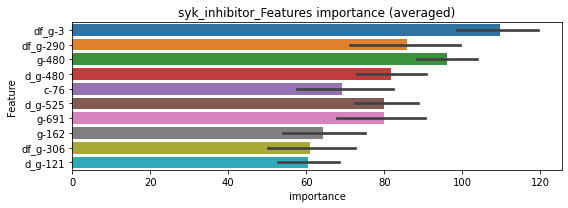

len(train_index) : 3895
len(valid_index) : 3896
================================= fold 1/2 syk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0108074	valid_1's binary_logloss: 0.0152388
[200]	training's binary_logloss: 0.00114619	valid_1's binary_logloss: 0.00377049
[300]	training's binary_logloss: 0.000316519	valid_1's binary_logloss: 0.00268598
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.00028841	valid_1's binary_logloss: 0.00264563


len(train_index) : 3896
len(valid_index) : 3895
================================= fold 2/2 syk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0114459	valid_1's binary_logloss: 0.0146905
[200]	training's binary_logloss: 0.00127261	valid_1's binary_logloss: 0.00353437
[300]	training's binary_logloss: 0.00036289	valid_1's binary_logloss: 0.00215216
[400]	training's binary_logloss: 0.000193224	valid_1's binary_logloss: 0.0019013
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.000182889	valid_1's binary_logloss: 0.00189082


syk_inhibitor logloss: 0.0022682698481286487


neg labels: 3289 → selected neg labels: 3279


tachykinin_antagonist, len(trt): 60, len(othr): 3279, target_rate: 0.0025195 → Adj_target_rate: 0.0027266
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0544117	valid_1's binary_logloss: 0.104812
[200]	training's binary_logloss: 0.011265	valid_1's binary_logloss: 0.0560882
[300]	training's binary_logloss: 0.00304602	valid_1's binary_logloss: 0.0431211
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00198746	valid_1's binary_logloss: 0.0410891
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0503567	valid_1's binary_logloss: 0.104504
[200]	training's binary_logloss: 0.00990889	valid_1's binary_logloss: 0.0514861
[300]	training's binary_logloss: 0.00272865	valid_1's binary_logloss: 0.0385234
[400]	training's binary_logloss: 0.00118102	valid_1's binary_logloss: 0.033761
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00118102	valid_1's binary_logloss: 0.033761


1 / 3 AUC score:0.994
y_Threshold: 0.0126093, Threshold: 0.0193093, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 150 → Positive_corect_labels: 646/3784
p_label_rate: 0.0200904 Vs.target_rate: 0.00252
Num_p_label: 80.0, conf_0:0.01738, conf_1:0.02124
Num_p_label: 80.0, Expected: 10.0, Adj_threshold_1: 0.0193093
Num_p_label: 38.0, Expected: 10.0, Adj_threshold_2: 0.0293093
Num_p_label: 21.0, Expected: 10.0, Adj_threshold_3: 0.0393093
Num_p_label: 11.0, Expected: 10.0, Adj_threshold_4: 0.0493093
threshold: 0.0493093, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 646.0/3784, y_label_rate: 0.1707188
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0462741	valid_1's binary_logloss: 0.088912
[200]	training's binary_logloss: 0.00841522	valid_1's binary_logloss: 0.0412454
[300]	training's binary_logloss: 0.00237634	valid_1's binary_logloss: 0.029816
[400]	training's binary_logloss: 0.00109617	valid_1's binary_logloss: 0.0270721
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.00107107	valid_1's binary_logloss: 0.0269708
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0493591	valid_1's binary_logloss: 0.0850636
[200]	training's binary_logloss: 0.00941715	valid_1's binary_logloss: 0.0359835
[300]	training's binary_logloss: 0.00264276	valid_1's binary_logloss: 0.0247496
[400]	training's binary_logloss: 0.00119669	valid_1's binary_logloss: 0.0202913
[500]	training's binary_logloss: 0.000727256	valid_1's binary_logloss: 0.0191541
Early stopping, best iteration is:
[499]	train

2 / 3 AUC score:0.999
y_Threshold: 0.0468561, Threshold: 0.0493093, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → Positive_corect_labels: 638.0/3768
p_label_rate: 0.0065294 Vs.target_rate: 0.00252
Num_p_label: 26.0, conf_0:0.04438, conf_1:0.05424
threshold: 0.0493093, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 638.0/3768, y_label_rate: 0.1693206
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0476057	valid_1's binary_logloss: 0.0794308
[200]	training's binary_logloss: 0.00860486	valid_1's binary_logloss: 0.028974
[300]	training's binary_logloss: 0.00240902	valid_1's binary_logloss: 0.0176225
[400]	training's binary_logloss: 0.00111285	valid_1's binary_logloss: 0.0142859
[500]	training's binary_logloss: 0.000699297	valid_1's binary_logloss: 0.0126536
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00061037	valid_1's binary_logloss: 0.0122962
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0457325	valid_1's binary_logloss: 0.087834
[200]	training's binary_logloss: 0.00855875	valid_1's binary_logloss: 0.0375542
[300]	training's binary_logloss: 0.0023839	valid_1's binary_logloss: 0.0244523
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.00133436	valid_1's binary_logloss: 0.021194


3 / 3 AUC score:1.000
y_Threshold: 0.0635374, Threshold: 0.0493093, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 635.0/3762
p_label_rate: 0.0080362 Vs.target_rate: 0.00252
Num_p_label: 32.0, conf_0:0.04438, conf_1:0.05424
Num_p_label: 32.0, Expected: 10.0, Adj_threshold_1: 0.0493093
Num_p_label: 25.0, Expected: 10.0, Adj_threshold_2: 0.0593093
Num_p_label: 18.0, Expected: 10.0, Adj_threshold_3: 0.0693093
threshold: 0.0693093, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 653.0/7744, y_label_rate: 0.0843233


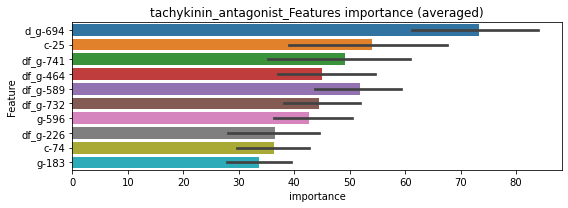

len(train_index) : 3872
len(valid_index) : 3872
================================= fold 1/2 tachykinin_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0284306	valid_1's binary_logloss: 0.0591215
[200]	training's binary_logloss: 0.00534911	valid_1's binary_logloss: 0.0305357
[300]	training's binary_logloss: 0.00142978	valid_1's binary_logloss: 0.0239899
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.000822191	valid_1's binary_logloss: 0.0225217


len(train_index) : 3872
len(valid_index) : 3872
================================= fold 2/2 tachykinin_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274579	valid_1's binary_logloss: 0.0562316
[200]	training's binary_logloss: 0.00505162	valid_1's binary_logloss: 0.0301597
[300]	training's binary_logloss: 0.0013584	valid_1's binary_logloss: 0.0245438
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.000700207	valid_1's binary_logloss: 0.0230152


tachykinin_antagonist logloss: 0.022768447892306993


neg labels: 3289 → selected neg labels: 3284


tgf-beta_receptor_inhibitor, len(trt): 30, len(othr): 3284, target_rate: 0.0012598 → Adj_target_rate: 0.0015127
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182924	valid_1's binary_logloss: 0.0249222
[200]	training's binary_logloss: 0.0017128	valid_1's binary_logloss: 0.00620402
[300]	training's binary_logloss: 0.000456151	valid_1's binary_logloss: 0.00493852
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000329235	valid_1's binary_logloss: 0.00485226
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0181905	valid_1's binary_logloss: 0.0222827
[200]	training's binary_logloss: 0.00167913	valid_1's binary_logloss: 0.00485257
[300]	training's binary_logloss: 0.000450375	valid_1's binary_logloss: 0.00346132
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.000426835	valid_1's binary_logloss: 0.00342271


1 / 3 AUC score:1.000
y_Threshold: 0.0009324, Threshold: 0.0014722, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00126
Num_p_label: 80.0, conf_0:0.00132, conf_1:0.00162
Num_p_label: 80.0, Expected: 5.0, Adj_threshold_1: 0.0014722
Num_p_label: 22.0, Expected: 5.0, Adj_threshold_2: 0.0114722
Num_p_label: 11.0, Expected: 5.0, Adj_threshold_3: 0.0214722
Num_p_label: 10.0, Expected: 5.0, Adj_threshold_4: 0.0314722
threshold: 0.0314722, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.01669	valid_1's binary_logloss: 0.0196726
[200]	training's binary_logloss: 0.00139684	valid_1's binary_logloss: 0.00298155
[300]	training's binary_logloss: 0.000335915	valid_1's binary_logloss: 0.00127846
[400]	training's binary_logloss: 0.000200915	valid_1's binary_logloss: 0.000961461
[500]	training's binary_logloss: 0.000179439	valid_1's binary_logloss: 0.000914738
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00017947	valid_1's binary_logloss: 0.000914633
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0169773	valid_1's binary_logloss: 0.0179848
[200]	training's binary_logloss: 0.0014055	valid_1's binary_logloss: 0.00183777
[300]	training's binary_logloss: 0.00033985	valid_1's binary_logloss: 0.000597606
[400]	training's binary_logloss: 0.000206407	valid_1's binary_logloss: 0.000439079
Early stopping, best iteration 

2 / 3 AUC score:1.000
y_Threshold: 0.1442927, Threshold: 0.0314722, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0102963 Vs.target_rate: 0.00126
Num_p_label: 41.0, conf_0:0.02832, conf_1:0.03462
Num_p_label: 41.0, Expected: 5.0, Adj_threshold_1: 0.0314722
Num_p_label: 35.0, Expected: 5.0, Adj_threshold_2: 0.0414722
Num_p_label: 32.0, Expected: 5.0, Adj_threshold_3: 0.0514722
Num_p_label: 28.0, Expected: 5.0, Adj_threshold_4: 0.0614722
Num_p_label: 24.0, Expected: 5.0, Adj_threshold_5: 0.0714722
Num_p_label: 22.0, Expected: 5.0, Adj_threshold_6: 0.0814722
Num_p_label: 21.0, Expected: 5.0, Adj_threshold_7: 0.0914722
Num_p_label: 20.0, Expected: 5.0, Adj_threshold_8: 0.1014722
Num_p_label: 19.0, Expected: 5.0, Adj_threshold_9: 0.1114722
Num_p_label: 18.0, Expected: 5.0, Adj_threshold_10: 0.1214722
threshold: 0.1314722, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.01669	valid_1's binary_logloss: 0.0196726
[200]	training's binary_logloss: 0.00139684	valid_1's binary_logloss: 0.00298155
[300]	training's binary_logloss: 0.000335915	valid_1's binary_logloss: 0.00127846
[400]	training's binary_logloss: 0.000200915	valid_1's binary_logloss: 0.000961461
[500]	training's binary_logloss: 0.000179439	valid_1's binary_logloss: 0.000914738
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00017947	valid_1's binary_logloss: 0.000914633
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0169773	valid_1's binary_logloss: 0.0179848
[200]	training's binary_logloss: 0.0014055	valid_1's binary_logloss: 0.00183777
[300]	training's binary_logloss: 0.00033985	valid_1's binary_logloss: 0.000597606
[400]	training's binary_logloss: 0.000206407	valid_1's binary_logloss: 0.000439079
Early stopping, best iteration 

3 / 3 AUC score:1.000
y_Threshold: 0.1442927, Threshold: 0.1314722, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0042692 Vs.target_rate: 0.00126
Num_p_label: 17.0, conf_0:0.11832, conf_1:0.14462
Num_p_label: 17.0, Expected: 5.0, Adj_threshold_1: 0.1314722
Num_p_label: 17.0, Expected: 5.0, Adj_threshold_2: 0.1414722
Num_p_label: 17.0, Expected: 5.0, Adj_threshold_3: 0.1514722
Num_p_label: 17.0, Expected: 5.0, Adj_threshold_4: 0.1614722
Num_p_label: 14.0, Expected: 5.0, Adj_threshold_5: 0.1714722
Num_p_label: 12.0, Expected: 5.0, Adj_threshold_6: 0.1814722
Num_p_label: 12.0, Expected: 5.0, Adj_threshold_7: 0.1914722
Num_p_label: 12.0, Expected: 5.0, Adj_threshold_8: 0.2014722
Num_p_label: 12.0, Expected: 5.0, Adj_threshold_9: 0.2114722
Num_p_label: 12.0, Expected: 5.0, Adj_threshold_10: 0.2214722
threshold: 0.2314722, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 668.0/7790, y_label_rate: 0.0857510


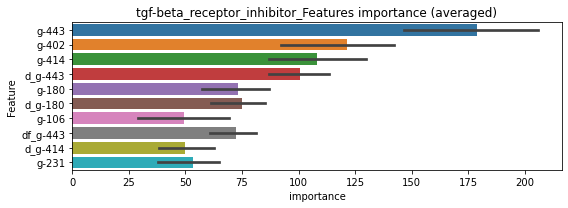

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00932236	valid_1's binary_logloss: 0.0120838
[200]	training's binary_logloss: 0.000782614	valid_1's binary_logloss: 0.0031126
[300]	training's binary_logloss: 0.000189217	valid_1's binary_logloss: 0.00232465
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.000115413	valid_1's binary_logloss: 0.00218045


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00926384	valid_1's binary_logloss: 0.0116371
[200]	training's binary_logloss: 0.00078577	valid_1's binary_logloss: 0.00265512
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00024794	valid_1's binary_logloss: 0.00199029


tgf-beta_receptor_inhibitor logloss: 0.002085371301952348


neg labels: 3289 → selected neg labels: 3286


thrombin_inhibitor, len(trt): 19, len(othr): 3286, target_rate: 0.0007979 → Adj_target_rate: 0.0010260
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234821	valid_1's binary_logloss: 0.0321123
[200]	training's binary_logloss: 0.00292198	valid_1's binary_logloss: 0.00660253
[300]	training's binary_logloss: 0.000804741	valid_1's binary_logloss: 0.00244107
[400]	training's binary_logloss: 0.000395427	valid_1's binary_logloss: 0.0013977
[500]	training's binary_logloss: 0.000304825	valid_1's binary_logloss: 0.00116388
Early stopping, best iteration is:
[537]	training's binary_logloss: 0.000299463	valid_1's binary_logloss: 0.00115645
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0236413	valid_1's binary_logloss: 0.032648
[200]	training's binary_logloss: 0.00273737	valid_1's binary_logloss: 0.00531619
[300]	training's binary_logloss: 0.000770904	valid_1's binary_logloss: 0.00188455
[400]	training's binary_logloss: 0.000408504	valid_1's binary_logloss: 0.00113278
[500]	training's binary_logloss: 

1 / 3 AUC score:1.000
y_Threshold: 0.0014672, Threshold: 0.0023230, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00080
Num_p_label: 80.0, conf_0:0.00209, conf_1:0.00256
Num_p_label: 80.0, Expected: 3.2, Adj_threshold_1: 0.0023230
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_2: 0.0123230
Num_p_label: 4.0, Expected: 3.2, Adj_threshold_3: 0.0223230
threshold: 0.0223230, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222524	valid_1's binary_logloss: 0.0304524
[200]	training's binary_logloss: 0.00250349	valid_1's binary_logloss: 0.00608762
[300]	training's binary_logloss: 0.00072262	valid_1's binary_logloss: 0.00239064
[400]	training's binary_logloss: 0.000390345	valid_1's binary_logloss: 0.00153498
[500]	training's binary_logloss: 0.000315089	valid_1's binary_logloss: 0.00134439
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.000314802	valid_1's binary_logloss: 0.00134421
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227624	valid_1's binary_logloss: 0.0294512
[200]	training's binary_logloss: 0.00260675	valid_1's binary_logloss: 0.00444379
[300]	training's binary_logloss: 0.000729076	valid_1's binary_logloss: 0.0014973
[400]	training's binary_logloss: 0.000389224	valid_1's binary_logloss: 0.000893633
[500]	training's binary_logloss:

2 / 3 AUC score:1.000
y_Threshold: 0.1441367, Threshold: 0.0223230, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0032647 Vs.target_rate: 0.00080
Num_p_label: 13.0, conf_0:0.02009, conf_1:0.02456
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_1: 0.0223230
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_2: 0.0323230
Num_p_label: 6.0, Expected: 3.2, Adj_threshold_3: 0.0423230
threshold: 0.0423230, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222524	valid_1's binary_logloss: 0.0304524
[200]	training's binary_logloss: 0.00250349	valid_1's binary_logloss: 0.00608762
[300]	training's binary_logloss: 0.00072262	valid_1's binary_logloss: 0.00239064
[400]	training's binary_logloss: 0.000390345	valid_1's binary_logloss: 0.00153498
[500]	training's binary_logloss: 0.000315089	valid_1's binary_logloss: 0.00134439
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.000314802	valid_1's binary_logloss: 0.00134421
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227624	valid_1's binary_logloss: 0.0294512
[200]	training's binary_logloss: 0.00260675	valid_1's binary_logloss: 0.00444379
[300]	training's binary_logloss: 0.000729076	valid_1's binary_logloss: 0.0014973
[400]	training's binary_logloss: 0.000389224	valid_1's binary_logloss: 0.000893633
[500]	training's binary_logloss:

3 / 3 AUC score:1.000
y_Threshold: 0.1441367, Threshold: 0.0423230, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0015068 Vs.target_rate: 0.00080
Num_p_label: 6.0, conf_0:0.03809, conf_1:0.04656
threshold: 0.0423230, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7793, y_label_rate: 0.0850764


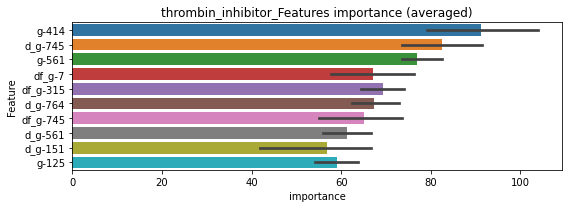

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 thrombin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0123239	valid_1's binary_logloss: 0.0183907
[200]	training's binary_logloss: 0.00137928	valid_1's binary_logloss: 0.00612953
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.000458716	valid_1's binary_logloss: 0.0052517


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 thrombin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0129308	valid_1's binary_logloss: 0.0176711
[200]	training's binary_logloss: 0.00157333	valid_1's binary_logloss: 0.0035835
[300]	training's binary_logloss: 0.00048459	valid_1's binary_logloss: 0.00176605
[400]	training's binary_logloss: 0.000253451	valid_1's binary_logloss: 0.00141442
Early stopping, best iteration is:
[473]	training's binary_logloss: 0.000191344	valid_1's binary_logloss: 0.00136007


thrombin_inhibitor logloss: 0.0033061341430550045


neg labels: 3289 → selected neg labels: 3285


thymidylate_synthase_inhibitor, len(trt): 37, len(othr): 3285, target_rate: 0.0015537 → Adj_target_rate: 0.0018079
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.035264	valid_1's binary_logloss: 0.058096
[200]	training's binary_logloss: 0.00522617	valid_1's binary_logloss: 0.0145928
[300]	training's binary_logloss: 0.00143829	valid_1's binary_logloss: 0.00600446
[400]	training's binary_logloss: 0.000693952	valid_1's binary_logloss: 0.00373284
[500]	training's binary_logloss: 0.000464476	valid_1's binary_logloss: 0.00288414
[600]	training's binary_logloss: 0.00042138	valid_1's binary_logloss: 0.00271992
Early stopping, best iteration is:
[604]	training's binary_logloss: 0.000420605	valid_1's binary_logloss: 0.0027179
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0362795	valid_1's binary_logloss: 0.0509594
[200]	training's binary_logloss: 0.00551168	valid_1's binary_logloss: 0.0113791
[300]	training's binary_logloss: 0.00150491	valid_1's binary_logloss: 0.00436639
[400]	training's binary_logloss: 0.0007

1 / 3 AUC score:1.000
y_Threshold: 0.0027937, Threshold: 0.0041046, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00155
Num_p_label: 80.0, conf_0:0.00369, conf_1:0.00452
Num_p_label: 80.0, Expected: 6.2, Adj_threshold_1: 0.0041046
Num_p_label: 17.0, Expected: 6.2, Adj_threshold_2: 0.0141046
Num_p_label: 11.0, Expected: 6.2, Adj_threshold_3: 0.0241046
threshold: 0.0241046, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0350946	valid_1's binary_logloss: 0.0567762
[200]	training's binary_logloss: 0.00508994	valid_1's binary_logloss: 0.0149597
[300]	training's binary_logloss: 0.00140551	valid_1's binary_logloss: 0.00644152
[400]	training's binary_logloss: 0.000679066	valid_1's binary_logloss: 0.00422217
[500]	training's binary_logloss: 0.000456859	valid_1's binary_logloss: 0.00332271
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.000430971	valid_1's binary_logloss: 0.00318237
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.034796	valid_1's binary_logloss: 0.0493661
[200]	training's binary_logloss: 0.00511034	valid_1's binary_logloss: 0.0108364
[300]	training's binary_logloss: 0.00143228	valid_1's binary_logloss: 0.00430927
[400]	training's binary_logloss: 0.000692039	valid_1's binary_logloss: 0.00260152
[500]	training's binary_logloss: 0.0

2 / 3 AUC score:1.000
y_Threshold: 0.1108342, Threshold: 0.0241046, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0062783 Vs.target_rate: 0.00155
Num_p_label: 25.0, conf_0:0.02169, conf_1:0.02652
Num_p_label: 25.0, Expected: 6.2, Adj_threshold_1: 0.0241046
Num_p_label: 14.0, Expected: 6.2, Adj_threshold_2: 0.0341046
Num_p_label: 11.0, Expected: 6.2, Adj_threshold_3: 0.0441046
threshold: 0.0441046, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0350946	valid_1's binary_logloss: 0.0567762
[200]	training's binary_logloss: 0.00508994	valid_1's binary_logloss: 0.0149597
[300]	training's binary_logloss: 0.00140551	valid_1's binary_logloss: 0.00644152
[400]	training's binary_logloss: 0.000679066	valid_1's binary_logloss: 0.00422217
[500]	training's binary_logloss: 0.000456859	valid_1's binary_logloss: 0.00332271
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.000430971	valid_1's binary_logloss: 0.00318237
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.034796	valid_1's binary_logloss: 0.0493661
[200]	training's binary_logloss: 0.00511034	valid_1's binary_logloss: 0.0108364
[300]	training's binary_logloss: 0.00143228	valid_1's binary_logloss: 0.00430927
[400]	training's binary_logloss: 0.000692039	valid_1's binary_logloss: 0.00260152
[500]	training's binary_logloss: 0.0

3 / 3 AUC score:1.000
y_Threshold: 0.1108342, Threshold: 0.0441046, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0027624 Vs.target_rate: 0.00155
Num_p_label: 11.0, conf_0:0.03969, conf_1:0.04852
threshold: 0.0441046, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 668.0/7792, y_label_rate: 0.0857290


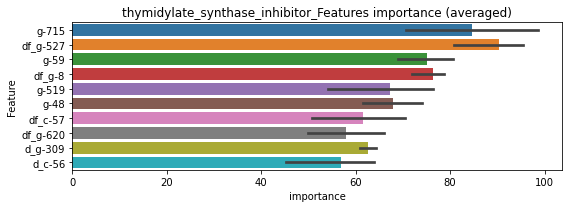

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194539	valid_1's binary_logloss: 0.0387553
[200]	training's binary_logloss: 0.00283752	valid_1's binary_logloss: 0.0179832
[300]	training's binary_logloss: 0.000749287	valid_1's binary_logloss: 0.0152934
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.000621525	valid_1's binary_logloss: 0.015017


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197551	valid_1's binary_logloss: 0.0326239
[200]	training's binary_logloss: 0.0028937	valid_1's binary_logloss: 0.0110843
[300]	training's binary_logloss: 0.000789991	valid_1's binary_logloss: 0.00751247
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.000500673	valid_1's binary_logloss: 0.00705706


thymidylate_synthase_inhibitor logloss: 0.011037016093885521


neg labels: 3289 → selected neg labels: 3284


tlr_agonist, len(trt): 30, len(othr): 3284, target_rate: 0.0012598 → Adj_target_rate: 0.0015127
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0358228	valid_1's binary_logloss: 0.0568466
[200]	training's binary_logloss: 0.00508853	valid_1's binary_logloss: 0.0165931
[300]	training's binary_logloss: 0.00134932	valid_1's binary_logloss: 0.00852103
[400]	training's binary_logloss: 0.000644195	valid_1's binary_logloss: 0.00613211
[500]	training's binary_logloss: 0.000437839	valid_1's binary_logloss: 0.00542189
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.000415746	valid_1's binary_logloss: 0.00528284
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0343679	valid_1's binary_logloss: 0.056528
[200]	training's binary_logloss: 0.00494174	valid_1's binary_logloss: 0.0155169
[300]	training's binary_logloss: 0.00132511	valid_1's binary_logloss: 0.00726495
[400]	training's binary_logloss: 0.000638796	valid_1's binary_logloss: 0.00529179
[500]	training's binary_logloss: 0.0

1 / 3 AUC score:1.000
y_Threshold: 0.0024083, Threshold: 0.0036678, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00126
Num_p_label: 80.0, conf_0:0.00330, conf_1:0.00403
Num_p_label: 80.0, Expected: 5.0, Adj_threshold_1: 0.0036678
Num_p_label: 6.0, Expected: 5.0, Adj_threshold_2: 0.0136678
threshold: 0.0136678, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0338083	valid_1's binary_logloss: 0.0565725
[200]	training's binary_logloss: 0.00472227	valid_1's binary_logloss: 0.0164228
[300]	training's binary_logloss: 0.00128999	valid_1's binary_logloss: 0.00846244
[400]	training's binary_logloss: 0.00061627	valid_1's binary_logloss: 0.00619819
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000461159	valid_1's binary_logloss: 0.0055381
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.033126	valid_1's binary_logloss: 0.0532442
[200]	training's binary_logloss: 0.00480804	valid_1's binary_logloss: 0.0140605
[300]	training's binary_logloss: 0.00130277	valid_1's binary_logloss: 0.00595949
[400]	training's binary_logloss: 0.000636782	valid_1's binary_logloss: 0.003988
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.000608877	valid_1's binary_logloss: 0.00391988


2 / 3 AUC score:1.000
y_Threshold: 0.0337214, Threshold: 0.0136678, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0072828 Vs.target_rate: 0.00126
Num_p_label: 29.0, conf_0:0.01230, conf_1:0.01503
Num_p_label: 29.0, Expected: 5.0, Adj_threshold_1: 0.0136678
Num_p_label: 14.0, Expected: 5.0, Adj_threshold_2: 0.0236678
Num_p_label: 10.0, Expected: 5.0, Adj_threshold_3: 0.0336678
threshold: 0.0336678, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0338083	valid_1's binary_logloss: 0.0565725
[200]	training's binary_logloss: 0.00472227	valid_1's binary_logloss: 0.0164228
[300]	training's binary_logloss: 0.00128999	valid_1's binary_logloss: 0.00846244
[400]	training's binary_logloss: 0.00061627	valid_1's binary_logloss: 0.00619819
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000461159	valid_1's binary_logloss: 0.0055381
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.033126	valid_1's binary_logloss: 0.0532442
[200]	training's binary_logloss: 0.00480804	valid_1's binary_logloss: 0.0140605
[300]	training's binary_logloss: 0.00130277	valid_1's binary_logloss: 0.00595949
[400]	training's binary_logloss: 0.000636782	valid_1's binary_logloss: 0.003988
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.000608877	valid_1's binary_logloss: 0.00391988


3 / 3 AUC score:1.000
y_Threshold: 0.0337214, Threshold: 0.0336678, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0025113 Vs.target_rate: 0.00126
Num_p_label: 10.0, conf_0:0.03030, conf_1:0.03703
threshold: 0.0336678, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 666.0/7790, y_label_rate: 0.0854942


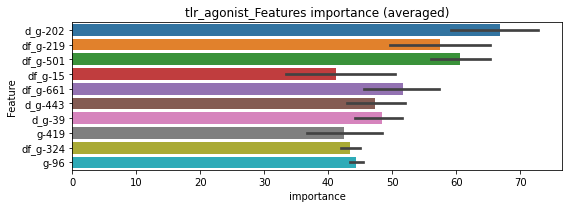

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 tlr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0196619	valid_1's binary_logloss: 0.0348039
[200]	training's binary_logloss: 0.00282818	valid_1's binary_logloss: 0.0138076
[300]	training's binary_logloss: 0.000731613	valid_1's binary_logloss: 0.0107629
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.000530521	valid_1's binary_logloss: 0.0105255


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 tlr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020592	valid_1's binary_logloss: 0.0351751
[200]	training's binary_logloss: 0.00302222	valid_1's binary_logloss: 0.0137707
[300]	training's binary_logloss: 0.000780617	valid_1's binary_logloss: 0.0108815
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.000456268	valid_1's binary_logloss: 0.0103348


tlr_agonist logloss: 0.010430146573693708


neg labels: 3289 → selected neg labels: 3287


tlr_antagonist, len(trt): 7, len(othr): 3287, target_rate: 0.0002939 → Adj_target_rate: 0.0004391
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015921	valid_1's binary_logloss: 0.0176696
[200]	training's binary_logloss: 0.00136765	valid_1's binary_logloss: 0.00211987
[300]	training's binary_logloss: 0.00037638	valid_1's binary_logloss: 0.000790449
[400]	training's binary_logloss: 0.000229478	valid_1's binary_logloss: 0.000548996
[500]	training's binary_logloss: 0.000202926	valid_1's binary_logloss: 0.000506117
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.000200192	valid_1's binary_logloss: 0.000504027
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016038	valid_1's binary_logloss: 0.018182
[200]	training's binary_logloss: 0.00136874	valid_1's binary_logloss: 0.00190707
[300]	training's binary_logloss: 0.000377862	valid_1's binary_logloss: 0.000624145
[400]	training's binary_logloss: 0.000230803	valid_1's binary_logloss: 0.000409449
[500]	training's binary_loglo

1 / 3 AUC score:1.000
y_Threshold: 0.0006627, Threshold: 0.0010429, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00029
Num_p_label: 80.0, conf_0:0.00094, conf_1:0.00115
Num_p_label: 80.0, Expected: 1.2, Adj_threshold_1: 0.0010429
Num_p_label: 0.0, Expected: 1.2, Adj_threshold_2: 0.0110429
threshold: 0.0110429, positive_p_label: 0.0/3982, p_label_rate: 0.0000000
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162946	valid_1's binary_logloss: 0.0204487
[200]	training's binary_logloss: 0.00135545	valid_1's binary_logloss: 0.0053398
[300]	training's binary_logloss: 0.000368403	valid_1's binary_logloss: 0.00413387
[400]	training's binary_logloss: 0.000227566	valid_1's binary_logloss: 0.00375956
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.00023005	valid_1's binary_logloss: 0.00375238
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164585	valid_1's binary_logloss: 0.0189993
[200]	training's binary_logloss: 0.00135837	valid_1's binary_logloss: 0.00213878
[300]	training's binary_logloss: 0.000369181	valid_1's binary_logloss: 0.000835398
[400]	training's binary_logloss: 0.000229954	valid_1's binary_logloss: 0.000628475
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.00020205	valid_1's binary_logloss: 0.000585

2 / 3 AUC score:1.000
y_Threshold: 0.0222636, Threshold: 0.0110429, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0055249 Vs.target_rate: 0.00029
Num_p_label: 22.0, conf_0:0.00994, conf_1:0.01215
Num_p_label: 22.0, Expected: 1.2, Adj_threshold_1: 0.0110429
Num_p_label: 13.0, Expected: 1.2, Adj_threshold_2: 0.0210429
Num_p_label: 7.0, Expected: 1.2, Adj_threshold_3: 0.0310429
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_4: 0.0410429
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_5: 0.0510429
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_6: 0.0610429
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_7: 0.0710429
Num_p_label: 1.0, Expected: 1.2, Adj_threshold_8: 0.0810429
threshold: 0.0810429, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162946	valid_1's binary_logloss: 0.0204487
[200]	training's binary_logloss: 0.00135545	valid_1's binary_logloss: 0.0053398
[300]	training's binary_logloss: 0.000368403	valid_1's binary_logloss: 0.00413387
[400]	training's binary_logloss: 0.000227566	valid_1's binary_logloss: 0.00375956
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.00023005	valid_1's binary_logloss: 0.00375238
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164585	valid_1's binary_logloss: 0.0189993
[200]	training's binary_logloss: 0.00135837	valid_1's binary_logloss: 0.00213878
[300]	training's binary_logloss: 0.000369181	valid_1's binary_logloss: 0.000835398
[400]	training's binary_logloss: 0.000229954	valid_1's binary_logloss: 0.000628475
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.00020205	valid_1's binary_logloss: 0.000585

3 / 3 AUC score:1.000
y_Threshold: 0.0222636, Threshold: 0.0810429, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0002511 Vs.target_rate: 0.00029
Num_p_label: 1.0, conf_0:0.07294, conf_1:0.08915
threshold: 0.0810429, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 658.0/7794, y_label_rate: 0.0844239


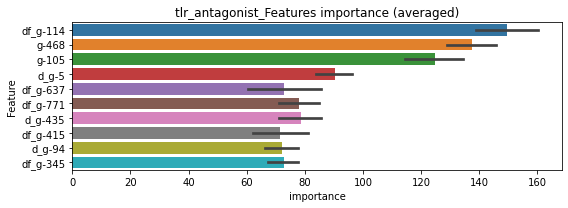

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 tlr_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00853827	valid_1's binary_logloss: 0.00992385
[200]	training's binary_logloss: 0.000691059	valid_1's binary_logloss: 0.00197029
[300]	training's binary_logloss: 0.0001858	valid_1's binary_logloss: 0.00145813
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.000148195	valid_1's binary_logloss: 0.00142126


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 tlr_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0086147	valid_1's binary_logloss: 0.0115937
[200]	training's binary_logloss: 0.000714045	valid_1's binary_logloss: 0.00318335
[300]	training's binary_logloss: 0.000191987	valid_1's binary_logloss: 0.00195189
[400]	training's binary_logloss: 0.000116873	valid_1's binary_logloss: 0.00168783
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.000105205	valid_1's binary_logloss: 0.0016555


tlr_antagonist logloss: 0.0015383802767851718


neg labels: 3289 → selected neg labels: 3283


tnf_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0341562	valid_1's binary_logloss: 0.0526569
[200]	training's binary_logloss: 0.00515959	valid_1's binary_logloss: 0.0140362
[300]	training's binary_logloss: 0.00142637	valid_1's binary_logloss: 0.00620727
[400]	training's binary_logloss: 0.000708008	valid_1's binary_logloss: 0.00414392
[500]	training's binary_logloss: 0.000462718	valid_1's binary_logloss: 0.00328586
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.000438817	valid_1's binary_logloss: 0.00323812
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330142	valid_1's binary_logloss: 0.0625651
[200]	training's binary_logloss: 0.00493658	valid_1's binary_logloss: 0.0258878
[300]	training's binary_logloss: 0.00139835	valid_1's binary_logloss: 0.0191843
[400]	training's binary_logloss: 0.000678607	valid_1's binary_logloss: 0.0175208
Early stopping, best iteration is:
[3

1 / 3 AUC score:1.000
y_Threshold: 0.0039469, Threshold: 0.0054540, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151
Num_p_label: 80.0, conf_0:0.00491, conf_1:0.00600
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0054540
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_2: 0.0154540
Num_p_label: 5.0, Expected: 6.0, Adj_threshold_3: 0.0254540
threshold: 0.0254540, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031722	valid_1's binary_logloss: 0.0484385
[200]	training's binary_logloss: 0.00462733	valid_1's binary_logloss: 0.0117588
[300]	training's binary_logloss: 0.00134124	valid_1's binary_logloss: 0.00500696
[400]	training's binary_logloss: 0.000681277	valid_1's binary_logloss: 0.00324088
[500]	training's binary_logloss: 0.000461418	valid_1's binary_logloss: 0.00263281
[600]	training's binary_logloss: 0.000418425	valid_1's binary_logloss: 0.00250277
Early stopping, best iteration is:
[607]	training's binary_logloss: 0.000416874	valid_1's binary_logloss: 0.00249896
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0321257	valid_1's binary_logloss: 0.0598332
[200]	training's binary_logloss: 0.00468712	valid_1's binary_logloss: 0.0229954
[300]	training's binary_logloss: 0.00134347	valid_1's binary_logloss: 0.0165078
[400]	training's binary_logloss: 0.00

2 / 3 AUC score:1.000
y_Threshold: 0.0212482, Threshold: 0.0254540, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 653.0/3801
p_label_rate: 0.0060271 Vs.target_rate: 0.00151
Num_p_label: 24.0, conf_0:0.02291, conf_1:0.02800
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_1: 0.0254540
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_2: 0.0354540
Num_p_label: 6.0, Expected: 6.0, Adj_threshold_3: 0.0454540
threshold: 0.0454540, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 653.0/3801, y_label_rate: 0.1717969
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0314965	valid_1's binary_logloss: 0.0507765
[200]	training's binary_logloss: 0.00457578	valid_1's binary_logloss: 0.0146158
[300]	training's binary_logloss: 0.00132384	valid_1's binary_logloss: 0.00807204
[400]	training's binary_logloss: 0.0006467	valid_1's binary_logloss: 0.00625685
[500]	training's binary_logloss: 0.000448516	valid_1's binary_logloss: 0.00558779
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.00044355	valid_1's binary_logloss: 0.00556837
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0331729	valid_1's binary_logloss: 0.063748
[200]	training's binary_logloss: 0.00479327	valid_1's binary_logloss: 0.0211587
[300]	training's binary_logloss: 0.00136271	valid_1's binary_logloss: 0.0120893
[400]	training's binary_logloss: 0.000664536	valid_1's binary_logloss: 0.00929004
[500]	training's binary_logloss: 0.00044

3 / 3 AUC score:1.000
y_Threshold: 0.0339952, Threshold: 0.0454540, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 652.0/3799
p_label_rate: 0.0032647 Vs.target_rate: 0.00151
Num_p_label: 13.0, conf_0:0.04091, conf_1:0.05000
threshold: 0.0454540, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 665.0/7781, y_label_rate: 0.0854646


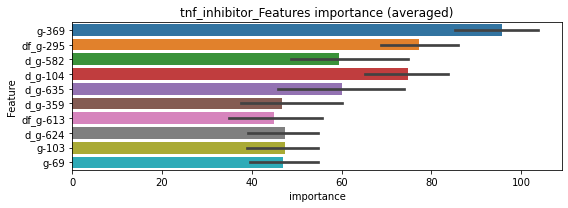

len(train_index) : 3890
len(valid_index) : 3891
================================= fold 1/2 tnf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.017816	valid_1's binary_logloss: 0.0355862
[200]	training's binary_logloss: 0.00275013	valid_1's binary_logloss: 0.0183275
Early stopping, best iteration is:
[284]	training's binary_logloss: 0.000909276	valid_1's binary_logloss: 0.0165239


len(train_index) : 3891
len(valid_index) : 3890
================================= fold 2/2 tnf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190503	valid_1's binary_logloss: 0.0350424
[200]	training's binary_logloss: 0.0028545	valid_1's binary_logloss: 0.0165406
[300]	training's binary_logloss: 0.00078749	valid_1's binary_logloss: 0.0143277
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.000554811	valid_1's binary_logloss: 0.013848


tnf_inhibitor logloss: 0.015186107878203287


neg labels: 3289 → selected neg labels: 3271


topoisomerase_inhibitor, len(trt): 127, len(othr): 3271, target_rate: 0.0053330 → Adj_target_rate: 0.0051574
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0372356	valid_1's binary_logloss: 0.0767659
[200]	training's binary_logloss: 0.00629821	valid_1's binary_logloss: 0.0438875
[300]	training's binary_logloss: 0.00192206	valid_1's binary_logloss: 0.0368188
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.00153451	valid_1's binary_logloss: 0.0363946
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0372049	valid_1's binary_logloss: 0.0852467
[200]	training's binary_logloss: 0.00704791	valid_1's binary_logloss: 0.0622496
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00340322	valid_1's binary_logloss: 0.0594139


1 / 3 AUC score:0.998
y_Threshold: 0.0111979, Threshold: 0.6969847, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 149 → Positive_corect_labels: 645/3776
p_label_rate: 0.0200904 Vs.target_rate: 0.00533
Num_p_label: 80.0, conf_0:0.62729, conf_1:0.76668
Num_p_label: 80.0, Expected: 21.2, Adj_threshold_1: 0.6969847
Num_p_label: 80.0, Expected: 21.2, Adj_threshold_2: 0.7069847
Num_p_label: 79.0, Expected: 21.2, Adj_threshold_3: 0.7169847
Num_p_label: 79.0, Expected: 21.2, Adj_threshold_4: 0.7269847
Num_p_label: 78.0, Expected: 21.2, Adj_threshold_5: 0.7369847
Num_p_label: 77.0, Expected: 21.2, Adj_threshold_6: 0.7469847
Num_p_label: 76.0, Expected: 21.2, Adj_threshold_7: 0.7569847
Num_p_label: 75.0, Expected: 21.2, Adj_threshold_8: 0.7669847
Num_p_label: 74.0, Expected: 21.2, Adj_threshold_9: 0.7769847
Num_p_label: 70.0, Expected: 21.2, Adj_threshold_10: 0.7869847
threshold: 0.7969847, positive_p_label: 66.0/3982, p_label_rate: 0.0165746
positive_y_label: 645.0/3776, y_label_rate: 0.1708157

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297229	valid_1's binary_logloss: 0.0626314
[200]	training's binary_logloss: 0.00396252	valid_1's binary_logloss: 0.0387611
Early stopping, best iteration is:
[231]	training's binary_logloss: 0.00246947	valid_1's binary_logloss: 0.0376927
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0292492	valid_1's binary_logloss: 0.0707345
[200]	training's binary_logloss: 0.00390025	valid_1's binary_logloss: 0.0423222
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.00188813	valid_1's binary_logloss: 0.0407926


2 / 3 AUC score:0.998
y_Threshold: 0.0529873, Threshold: 0.7969847, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 34 → Positive_corect_labels: 628.0/3742
p_label_rate: 0.0356605 Vs.target_rate: 0.00533
Num_p_label: 142.0, conf_0:0.71729, conf_1:0.87668
Num_p_label: 142.0, Expected: 21.2, Adj_threshold_1: 0.7969847
Num_p_label: 140.0, Expected: 21.2, Adj_threshold_2: 0.8069847
Num_p_label: 139.0, Expected: 21.2, Adj_threshold_3: 0.8169847
Num_p_label: 137.0, Expected: 21.2, Adj_threshold_4: 0.8269847
Num_p_label: 137.0, Expected: 21.2, Adj_threshold_5: 0.8369847
Num_p_label: 135.0, Expected: 21.2, Adj_threshold_6: 0.8469847
Num_p_label: 134.0, Expected: 21.2, Adj_threshold_7: 0.8569847
Num_p_label: 134.0, Expected: 21.2, Adj_threshold_8: 0.8669847
Num_p_label: 131.0, Expected: 21.2, Adj_threshold_9: 0.8769847
Num_p_label: 131.0, Expected: 21.2, Adj_threshold_10: 0.8869847
threshold: 0.8969847, positive_p_label: 131.0/3982, p_label_rate: 0.0328980
positive_y_label: 628.0/3742, y_label_ra

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0272937	valid_1's binary_logloss: 0.0592101
[200]	training's binary_logloss: 0.00347156	valid_1's binary_logloss: 0.0291084
[300]	training's binary_logloss: 0.000993482	valid_1's binary_logloss: 0.0236739
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.000975557	valid_1's binary_logloss: 0.0235956
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270734	valid_1's binary_logloss: 0.0395809
[200]	training's binary_logloss: 0.00355076	valid_1's binary_logloss: 0.0114518
[300]	training's binary_logloss: 0.00103663	valid_1's binary_logloss: 0.00668847
[400]	training's binary_logloss: 0.000538435	valid_1's binary_logloss: 0.00502097
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000470969	valid_1's binary_logloss: 0.00483227


3 / 3 AUC score:1.000
y_Threshold: 0.0458087, Threshold: 0.8969847, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 623.0/3732
p_label_rate: 0.0374184 Vs.target_rate: 0.00533
Num_p_label: 149.0, conf_0:0.80729, conf_1:0.98668
Num_p_label: 149.0, Expected: 21.2, Adj_threshold_1: 0.8969847
Num_p_label: 148.0, Expected: 21.2, Adj_threshold_2: 0.9069847
Num_p_label: 147.0, Expected: 21.2, Adj_threshold_3: 0.9169847
Num_p_label: 147.0, Expected: 21.2, Adj_threshold_4: 0.9269847
Num_p_label: 144.0, Expected: 21.2, Adj_threshold_5: 0.9369847
Num_p_label: 142.0, Expected: 21.2, Adj_threshold_6: 0.9469847
Num_p_label: 136.0, Expected: 21.2, Adj_threshold_7: 0.9569847
Num_p_label: 132.0, Expected: 21.2, Adj_threshold_8: 0.9669847
Num_p_label: 127.0, Expected: 21.2, Adj_threshold_9: 0.9769847
Num_p_label: 120.0, Expected: 21.2, Adj_threshold_10: 0.9869847
threshold: 0.9969847, positive_p_label: 93.0/3982, p_label_rate: 0.0233551
positive_y_label: 716.0/7714, y_label_rat

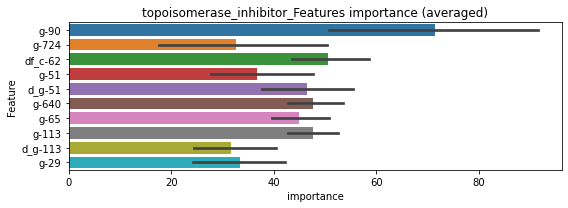

len(train_index) : 3857
len(valid_index) : 3857
================================= fold 1/2 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0170348	valid_1's binary_logloss: 0.0406493
[200]	training's binary_logloss: 0.00241362	valid_1's binary_logloss: 0.0279538
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.0014565	valid_1's binary_logloss: 0.0274773


len(train_index) : 3857
len(valid_index) : 3857
================================= fold 2/2 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187232	valid_1's binary_logloss: 0.0390498
[200]	training's binary_logloss: 0.00276527	valid_1's binary_logloss: 0.0234505
Early stopping, best iteration is:
[224]	training's binary_logloss: 0.00191577	valid_1's binary_logloss: 0.0222523


topoisomerase_inhibitor logloss: 0.024864796580957953


neg labels: 3289 → selected neg labels: 3286


transient_receptor_potential_channel_antagonist, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230809	valid_1's binary_logloss: 0.0303886
[200]	training's binary_logloss: 0.00268292	valid_1's binary_logloss: 0.00482519
[300]	training's binary_logloss: 0.000760097	valid_1's binary_logloss: 0.00174956
[400]	training's binary_logloss: 0.000394544	valid_1's binary_logloss: 0.00105027
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000326013	valid_1's binary_logloss: 0.000910417
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233563	valid_1's binary_logloss: 0.0317928
[200]	training's binary_logloss: 0.00277277	valid_1's binary_logloss: 0.00645817
[300]	training's binary_logloss: 0.000750134	valid_1's binary_logloss: 0.00272133
[400]	training's binary_logloss: 0.00039139	valid_1's binary_logloss: 0.00181459
[500]	training's binary_logloss: 0.000315733	valid_1's binary_logloss: 0.00163761
Early stopping, best iteration 

1 / 3 AUC score:1.000
y_Threshold: 0.0014332, Threshold: 0.0018428, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00166, conf_1:0.00203
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0018428
Num_p_label: 2.0, Expected: 3.0, Adj_threshold_2: 0.0118428
threshold: 0.0118428, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0238014	valid_1's binary_logloss: 0.0295163
[200]	training's binary_logloss: 0.00267205	valid_1's binary_logloss: 0.00431523
[300]	training's binary_logloss: 0.000751168	valid_1's binary_logloss: 0.00147274
[400]	training's binary_logloss: 0.000391397	valid_1's binary_logloss: 0.000863009
[500]	training's binary_logloss: 0.000320145	valid_1's binary_logloss: 0.000747874
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.000318695	valid_1's binary_logloss: 0.000746459
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232057	valid_1's binary_logloss: 0.0324061
[200]	training's binary_logloss: 0.00262741	valid_1's binary_logloss: 0.00658048
[300]	training's binary_logloss: 0.000789046	valid_1's binary_logloss: 0.0034177
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.000519816	valid_1's binary_logloss: 0.002

2 / 3 AUC score:1.000
y_Threshold: 0.0303136, Threshold: 0.0118428, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0032647 Vs.target_rate: 0.00076
Num_p_label: 13.0, conf_0:0.01066, conf_1:0.01303
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_1: 0.0118428
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_2: 0.0218428
threshold: 0.0218428, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0238014	valid_1's binary_logloss: 0.0295163
[200]	training's binary_logloss: 0.00267205	valid_1's binary_logloss: 0.00431523
[300]	training's binary_logloss: 0.000751168	valid_1's binary_logloss: 0.00147274
[400]	training's binary_logloss: 0.000391397	valid_1's binary_logloss: 0.000863009
[500]	training's binary_logloss: 0.000320145	valid_1's binary_logloss: 0.000747874
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.000318695	valid_1's binary_logloss: 0.000746459
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232057	valid_1's binary_logloss: 0.0324061
[200]	training's binary_logloss: 0.00262741	valid_1's binary_logloss: 0.00658048
[300]	training's binary_logloss: 0.000789046	valid_1's binary_logloss: 0.0034177
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.000519816	valid_1's binary_logloss: 0.002

3 / 3 AUC score:1.000
y_Threshold: 0.0303136, Threshold: 0.0218428, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0007534 Vs.target_rate: 0.00076
Num_p_label: 3.0, conf_0:0.01966, conf_1:0.02403
threshold: 0.0218428, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 660.0/7793, y_label_rate: 0.0846914


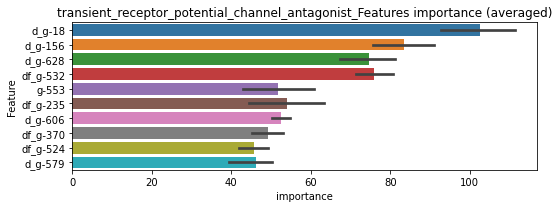

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0120496	valid_1's binary_logloss: 0.0199326
[200]	training's binary_logloss: 0.00134899	valid_1's binary_logloss: 0.0077088
[300]	training's binary_logloss: 0.000365431	valid_1's binary_logloss: 0.00620833
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.000298477	valid_1's binary_logloss: 0.00608637


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0123637	valid_1's binary_logloss: 0.0163353
[200]	training's binary_logloss: 0.00142284	valid_1's binary_logloss: 0.00361801
[300]	training's binary_logloss: 0.000391329	valid_1's binary_logloss: 0.00216695
[400]	training's binary_logloss: 0.000201145	valid_1's binary_logloss: 0.00193589
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000192889	valid_1's binary_logloss: 0.00192479


transient_receptor_potential_channel_antagonist logloss: 0.0040058499444753145


neg labels: 3289 → selected neg labels: 3288


tropomyosin_receptor_kinase_inhibitor, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158493	valid_1's binary_logloss: 0.0173448
[200]	training's binary_logloss: 0.00132469	valid_1's binary_logloss: 0.00168833
[300]	training's binary_logloss: 0.000349915	valid_1's binary_logloss: 0.000489395
[400]	training's binary_logloss: 0.00021274	valid_1's binary_logloss: 0.000314584
[500]	training's binary_logloss: 0.000190539	valid_1's binary_logloss: 0.000286775
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.000190539	valid_1's binary_logloss: 0.000286775
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160126	valid_1's binary_logloss: 0.0175672
[200]	training's binary_logloss: 0.00132536	valid_1's binary_logloss: 0.00172511
[300]	training's binary_logloss: 0.000348308	valid_1's binary_logloss: 0.000509722
[400]	training's binary_logloss: 0.000211922	valid_1's binary_logloss: 0.0003233
Early stopping, best iterati

1 / 3 AUC score:1.000
y_Threshold: 0.0005445, Threshold: 0.0012279, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0200904 Vs.target_rate: 0.00025
Num_p_label: 80.0, conf_0:0.00111, conf_1:0.00135
Num_p_label: 80.0, Expected: 1.0, Adj_threshold_1: 0.0012279
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_2: 0.0112279
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_3: 0.0212279
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_4: 0.0312279
threshold: 0.0312279, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016244	valid_1's binary_logloss: 0.0174594
[200]	training's binary_logloss: 0.00132529	valid_1's binary_logloss: 0.00168606
[300]	training's binary_logloss: 0.000344061	valid_1's binary_logloss: 0.000500043
[400]	training's binary_logloss: 0.000211077	valid_1's binary_logloss: 0.000320814
[500]	training's binary_logloss: 0.000189476	valid_1's binary_logloss: 0.000292334
Early stopping, best iteration is:
[542]	training's binary_logloss: 0.000187976	valid_1's binary_logloss: 0.000290188
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164326	valid_1's binary_logloss: 0.017793
[200]	training's binary_logloss: 0.0013401	valid_1's binary_logloss: 0.00156748
[300]	training's binary_logloss: 0.00034711	valid_1's binary_logloss: 0.000431886
[400]	training's binary_logloss: 0.000210061	valid_1's binary_logloss: 0.000267225
Early stopping, best iteratio

2 / 3 AUC score:1.000
y_Threshold: 0.1614020, Threshold: 0.0312279, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0017579 Vs.target_rate: 0.00025
Num_p_label: 7.0, conf_0:0.02811, conf_1:0.03435
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_1: 0.0312279
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_2: 0.0412279
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_3: 0.0512279
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_4: 0.0612279
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_5: 0.0712279
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_6: 0.0812279
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_7: 0.0912279
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_8: 0.1012279
threshold: 0.1012279, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016244	valid_1's binary_logloss: 0.0174594
[200]	training's binary_logloss: 0.00132529	valid_1's binary_logloss: 0.00168606
[300]	training's binary_logloss: 0.000344061	valid_1's binary_logloss: 0.000500043
[400]	training's binary_logloss: 0.000211077	valid_1's binary_logloss: 0.000320814
[500]	training's binary_logloss: 0.000189476	valid_1's binary_logloss: 0.000292334
Early stopping, best iteration is:
[542]	training's binary_logloss: 0.000187976	valid_1's binary_logloss: 0.000290188
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164326	valid_1's binary_logloss: 0.017793
[200]	training's binary_logloss: 0.0013401	valid_1's binary_logloss: 0.00156748
[300]	training's binary_logloss: 0.00034711	valid_1's binary_logloss: 0.000431886
[400]	training's binary_logloss: 0.000210061	valid_1's binary_logloss: 0.000267225
Early stopping, best iteratio

3 / 3 AUC score:1.000
y_Threshold: 0.1614020, Threshold: 0.1012279, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0005023 Vs.target_rate: 0.00025
Num_p_label: 2.0, conf_0:0.09111, conf_1:0.11135
threshold: 0.1012279, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 659.0/7795, y_label_rate: 0.0845414


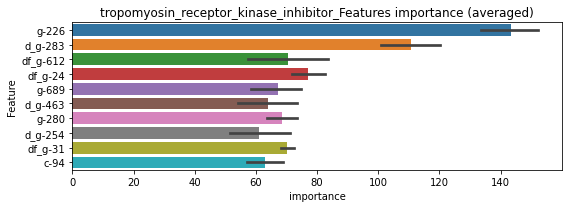

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00858153	valid_1's binary_logloss: 0.00992566
[200]	training's binary_logloss: 0.000696137	valid_1's binary_logloss: 0.00168456
[300]	training's binary_logloss: 0.000178847	valid_1's binary_logloss: 0.00113495
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.000135584	valid_1's binary_logloss: 0.00110105


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00872958	valid_1's binary_logloss: 0.0102607
[200]	training's binary_logloss: 0.000704707	valid_1's binary_logloss: 0.00224859
[300]	training's binary_logloss: 0.000179795	valid_1's binary_logloss: 0.00171844
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.000121625	valid_1's binary_logloss: 0.00166694


tropomyosin_receptor_kinase_inhibitor logloss: 0.0013839575676737495


neg labels: 3289 → selected neg labels: 3285


trpv_agonist, len(trt): 25, len(othr): 3285, target_rate: 0.0010498 → Adj_target_rate: 0.0012955
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026468	valid_1's binary_logloss: 0.0355699
[200]	training's binary_logloss: 0.00332782	valid_1's binary_logloss: 0.00637436
[300]	training's binary_logloss: 0.000930536	valid_1's binary_logloss: 0.00245122
[400]	training's binary_logloss: 0.000480764	valid_1's binary_logloss: 0.00154371
[500]	training's binary_logloss: 0.000363817	valid_1's binary_logloss: 0.00124282
[600]	training's binary_logloss: 0.000351819	valid_1's binary_logloss: 0.00121589
Early stopping, best iteration is:
[626]	training's binary_logloss: 0.000351482	valid_1's binary_logloss: 0.00121493
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0260117	valid_1's binary_logloss: 0.0352069
[200]	training's binary_logloss: 0.00323885	valid_1's binary_logloss: 0.00610054
[300]	training's binary_logloss: 0.000916143	valid_1's binary_logloss: 0.00235327
[400]	training's binary_logloss:

1 / 3 AUC score:1.000
y_Threshold: 0.0022725, Threshold: 0.0052927, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00105
Num_p_label: 80.0, conf_0:0.00476, conf_1:0.00582
Num_p_label: 80.0, Expected: 4.2, Adj_threshold_1: 0.0052927
Num_p_label: 36.0, Expected: 4.2, Adj_threshold_2: 0.0152927
Num_p_label: 25.0, Expected: 4.2, Adj_threshold_3: 0.0252927
Num_p_label: 21.0, Expected: 4.2, Adj_threshold_4: 0.0352927
Num_p_label: 14.0, Expected: 4.2, Adj_threshold_5: 0.0452927
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_6: 0.0552927
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_7: 0.0652927
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_8: 0.0752927
Num_p_label: 8.0, Expected: 4.2, Adj_threshold_9: 0.0852927
threshold: 0.0852927, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252813	valid_1's binary_logloss: 0.032895
[200]	training's binary_logloss: 0.00306806	valid_1's binary_logloss: 0.00526182
[300]	training's binary_logloss: 0.000864907	valid_1's binary_logloss: 0.00177886
[400]	training's binary_logloss: 0.00045242	valid_1's binary_logloss: 0.00104727
[500]	training's binary_logloss: 0.00034974	valid_1's binary_logloss: 0.000856751
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.000340989	valid_1's binary_logloss: 0.000842991
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0255238	valid_1's binary_logloss: 0.033792
[200]	training's binary_logloss: 0.00305566	valid_1's binary_logloss: 0.00519472
[300]	training's binary_logloss: 0.000863956	valid_1's binary_logloss: 0.00184667
[400]	training's binary_logloss: 0.000452312	valid_1's binary_logloss: 0.00106074
[500]	training's binary_logloss: 

2 / 3 AUC score:1.000
y_Threshold: 0.1880286, Threshold: 0.0852927, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0080362 Vs.target_rate: 0.00105
Num_p_label: 32.0, conf_0:0.07676, conf_1:0.09382
Num_p_label: 32.0, Expected: 4.2, Adj_threshold_1: 0.0852927
Num_p_label: 30.0, Expected: 4.2, Adj_threshold_2: 0.0952927
Num_p_label: 28.0, Expected: 4.2, Adj_threshold_3: 0.1052927
Num_p_label: 28.0, Expected: 4.2, Adj_threshold_4: 0.1152927
Num_p_label: 28.0, Expected: 4.2, Adj_threshold_5: 0.1252927
Num_p_label: 27.0, Expected: 4.2, Adj_threshold_6: 0.1352927
Num_p_label: 26.0, Expected: 4.2, Adj_threshold_7: 0.1452927
Num_p_label: 24.0, Expected: 4.2, Adj_threshold_8: 0.1552927
Num_p_label: 22.0, Expected: 4.2, Adj_threshold_9: 0.1652927
Num_p_label: 22.0, Expected: 4.2, Adj_threshold_10: 0.1752927
threshold: 0.1852927, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252813	valid_1's binary_logloss: 0.032895
[200]	training's binary_logloss: 0.00306806	valid_1's binary_logloss: 0.00526182
[300]	training's binary_logloss: 0.000864907	valid_1's binary_logloss: 0.00177886
[400]	training's binary_logloss: 0.00045242	valid_1's binary_logloss: 0.00104727
[500]	training's binary_logloss: 0.00034974	valid_1's binary_logloss: 0.000856751
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.000340989	valid_1's binary_logloss: 0.000842991
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0255238	valid_1's binary_logloss: 0.033792
[200]	training's binary_logloss: 0.00305566	valid_1's binary_logloss: 0.00519472
[300]	training's binary_logloss: 0.000863956	valid_1's binary_logloss: 0.00184667
[400]	training's binary_logloss: 0.000452312	valid_1's binary_logloss: 0.00106074
[500]	training's binary_logloss: 

3 / 3 AUC score:1.000
y_Threshold: 0.1880286, Threshold: 0.1852927, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0052737 Vs.target_rate: 0.00105
Num_p_label: 21.0, conf_0:0.16676, conf_1:0.20382
Num_p_label: 21.0, Expected: 4.2, Adj_threshold_1: 0.1852927
Num_p_label: 21.0, Expected: 4.2, Adj_threshold_2: 0.1952927
Num_p_label: 21.0, Expected: 4.2, Adj_threshold_3: 0.2052927
Num_p_label: 19.0, Expected: 4.2, Adj_threshold_4: 0.2152927
Num_p_label: 19.0, Expected: 4.2, Adj_threshold_5: 0.2252927
Num_p_label: 18.0, Expected: 4.2, Adj_threshold_6: 0.2352927
Num_p_label: 18.0, Expected: 4.2, Adj_threshold_7: 0.2452927
Num_p_label: 18.0, Expected: 4.2, Adj_threshold_8: 0.2552927
Num_p_label: 17.0, Expected: 4.2, Adj_threshold_9: 0.2652927
Num_p_label: 16.0, Expected: 4.2, Adj_threshold_10: 0.2752927
threshold: 0.2852927, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 673.0/7792, y_label_rate: 0.0863706


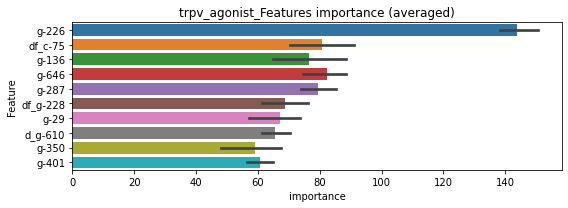

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 trpv_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0139832	valid_1's binary_logloss: 0.0255859
[200]	training's binary_logloss: 0.00172721	valid_1's binary_logloss: 0.0100287
Early stopping, best iteration is:
[283]	training's binary_logloss: 0.000564312	valid_1's binary_logloss: 0.0081065


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 trpv_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0146756	valid_1's binary_logloss: 0.025739
[200]	training's binary_logloss: 0.00180075	valid_1's binary_logloss: 0.00691525
[300]	training's binary_logloss: 0.000499925	valid_1's binary_logloss: 0.00341282
[400]	training's binary_logloss: 0.000256523	valid_1's binary_logloss: 0.00254594
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00025094	valid_1's binary_logloss: 0.00253581


trpv_agonist logloss: 0.005321155858712206


neg labels: 3289 → selected neg labels: 3281


trpv_antagonist, len(trt): 48, len(othr): 3281, target_rate: 0.0020156 → Adj_target_rate: 0.0022556
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0450369	valid_1's binary_logloss: 0.0996869
[200]	training's binary_logloss: 0.00809968	valid_1's binary_logloss: 0.0526833
[300]	training's binary_logloss: 0.00224507	valid_1's binary_logloss: 0.0416907
[400]	training's binary_logloss: 0.00103111	valid_1's binary_logloss: 0.038443
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.00097816	valid_1's binary_logloss: 0.0382505
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.047569	valid_1's binary_logloss: 0.0828245
[200]	training's binary_logloss: 0.00886345	valid_1's binary_logloss: 0.0338516
[300]	training's binary_logloss: 0.00239933	valid_1's binary_logloss: 0.0225034
[400]	training's binary_logloss: 0.00108737	valid_1's binary_logloss: 0.0194902
[500]	training's binary_logloss: 0.00067985	valid_1's binary_logloss: 0.0182118
Early stopping, best iteration is:
[524]	traini

1 / 3 AUC score:0.999
y_Threshold: 0.0060619, Threshold: 0.0097687, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 142 → Positive_corect_labels: 651/3795
p_label_rate: 0.0200904 Vs.target_rate: 0.00202
Num_p_label: 80.0, conf_0:0.00879, conf_1:0.01075
Num_p_label: 80.0, Expected: 8.0, Adj_threshold_1: 0.0097687
Num_p_label: 24.0, Expected: 8.0, Adj_threshold_2: 0.0197687
Num_p_label: 9.0, Expected: 8.0, Adj_threshold_3: 0.0297687
threshold: 0.0297687, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 651.0/3795, y_label_rate: 0.1715415
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0449949	valid_1's binary_logloss: 0.0888791
[200]	training's binary_logloss: 0.00807024	valid_1's binary_logloss: 0.0440825
[300]	training's binary_logloss: 0.00227556	valid_1's binary_logloss: 0.0349954
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00111534	valid_1's binary_logloss: 0.0317567
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0452833	valid_1's binary_logloss: 0.0891266
[200]	training's binary_logloss: 0.00750922	valid_1's binary_logloss: 0.0371013
[300]	training's binary_logloss: 0.00214604	valid_1's binary_logloss: 0.0262999
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.00117975	valid_1's binary_logloss: 0.0239246


2 / 3 AUC score:1.000
y_Threshold: 0.0302775, Threshold: 0.0297687, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 648.0/3789
p_label_rate: 0.0077850 Vs.target_rate: 0.00202
Num_p_label: 31.0, conf_0:0.02679, conf_1:0.03275
Num_p_label: 31.0, Expected: 8.0, Adj_threshold_1: 0.0297687
Num_p_label: 15.0, Expected: 8.0, Adj_threshold_2: 0.0397687
threshold: 0.0397687, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 648.0/3789, y_label_rate: 0.1710214
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0451037	valid_1's binary_logloss: 0.0840882
[200]	training's binary_logloss: 0.00805405	valid_1's binary_logloss: 0.0356075
[300]	training's binary_logloss: 0.00223188	valid_1's binary_logloss: 0.0236423
[400]	training's binary_logloss: 0.00102878	valid_1's binary_logloss: 0.019714
[500]	training's binary_logloss: 0.000652402	valid_1's binary_logloss: 0.0183514
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.000657655	valid_1's binary_logloss: 0.0183121
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0435993	valid_1's binary_logloss: 0.0812566
[200]	training's binary_logloss: 0.00769457	valid_1's binary_logloss: 0.0327347
[300]	training's binary_logloss: 0.00217354	valid_1's binary_logloss: 0.0206012
[400]	training's binary_logloss: 0.00100577	valid_1's binary_logloss: 0.0169511
[500]	training's binary_logloss: 0.000637616

3 / 3 AUC score:1.000
y_Threshold: 0.0259372, Threshold: 0.0397687, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 646.0/3785
p_label_rate: 0.0025113 Vs.target_rate: 0.00202
Num_p_label: 10.0, conf_0:0.03579, conf_1:0.04375
threshold: 0.0397687, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/7767, y_label_rate: 0.0844599


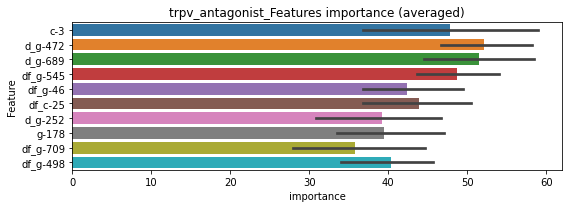

len(train_index) : 3883
len(valid_index) : 3884
================================= fold 1/2 trpv_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026789	valid_1's binary_logloss: 0.0509207
[200]	training's binary_logloss: 0.00472493	valid_1's binary_logloss: 0.0245012
[300]	training's binary_logloss: 0.00125856	valid_1's binary_logloss: 0.0194664
[400]	training's binary_logloss: 0.000553825	valid_1's binary_logloss: 0.0186174
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.00050162	valid_1's binary_logloss: 0.0184915


len(train_index) : 3884
len(valid_index) : 3883
================================= fold 2/2 trpv_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264318	valid_1's binary_logloss: 0.0473511
[200]	training's binary_logloss: 0.00478245	valid_1's binary_logloss: 0.0202419
[300]	training's binary_logloss: 0.00125482	valid_1's binary_logloss: 0.0146433
[400]	training's binary_logloss: 0.000560479	valid_1's binary_logloss: 0.0133569
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.000414272	valid_1's binary_logloss: 0.0129578


trpv_antagonist logloss: 0.0157250063411405


neg labels: 3289 → selected neg labels: 3267


tubulin_inhibitor, len(trt): 316, len(othr): 3267, target_rate: 0.0132695 → Adj_target_rate: 0.0111926
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0412389	valid_1's binary_logloss: 0.125267
Early stopping, best iteration is:
[160]	training's binary_logloss: 0.0143456	valid_1's binary_logloss: 0.112751
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0448428	valid_1's binary_logloss: 0.102274
[200]	training's binary_logloss: 0.00824542	valid_1's binary_logloss: 0.0783327
[300]	training's binary_logloss: 0.00251615	valid_1's binary_logloss: 0.0753912
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.0026593	valid_1's binary_logloss: 0.0753326


1 / 3 AUC score:0.985
y_Threshold: 0.0265186, Threshold: 0.1265956, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 185 → Positive_corect_labels: 626/3735
p_label_rate: 0.0200904 Vs.target_rate: 0.01327
Num_p_label: 80.0, conf_0:0.11394, conf_1:0.13926
threshold: 0.1265956, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 626.0/3735, y_label_rate: 0.1676037
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0326024	valid_1's binary_logloss: 0.0828924
[200]	training's binary_logloss: 0.0049259	valid_1's binary_logloss: 0.0580083
Early stopping, best iteration is:
[236]	training's binary_logloss: 0.00293115	valid_1's binary_logloss: 0.0561217
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330869	valid_1's binary_logloss: 0.0835108
Early stopping, best iteration is:
[189]	training's binary_logloss: 0.00602113	valid_1's binary_logloss: 0.0662621


2 / 3 AUC score:0.991
y_Threshold: 0.0506412, Threshold: 0.1265956, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 54 → Positive_corect_labels: 599.0/3681
p_label_rate: 0.0311401 Vs.target_rate: 0.01327
Num_p_label: 124.0, conf_0:0.11394, conf_1:0.13926
threshold: 0.1265956, positive_p_label: 124.0/3982, p_label_rate: 0.0311401
positive_y_label: 599.0/3681, y_label_rate: 0.1627275
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286226	valid_1's binary_logloss: 0.0581158
[200]	training's binary_logloss: 0.00414354	valid_1's binary_logloss: 0.0353073
Early stopping, best iteration is:
[211]	training's binary_logloss: 0.00353768	valid_1's binary_logloss: 0.034672
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0272915	valid_1's binary_logloss: 0.0595131
[200]	training's binary_logloss: 0.00410537	valid_1's binary_logloss: 0.0361619
[300]	training's binary_logloss: 0.00111738	valid_1's binary_logloss: 0.0326824
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.000904932	valid_1's binary_logloss: 0.0324177


3 / 3 AUC score:0.999
y_Threshold: 0.0573570, Threshold: 0.1265956, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 588.0/3659
p_label_rate: 0.0316424 Vs.target_rate: 0.01327
Num_p_label: 126.0, conf_0:0.11394, conf_1:0.13926
threshold: 0.1265956, positive_p_label: 126.0/3982, p_label_rate: 0.0316424
positive_y_label: 714.0/7641, y_label_rate: 0.0934433


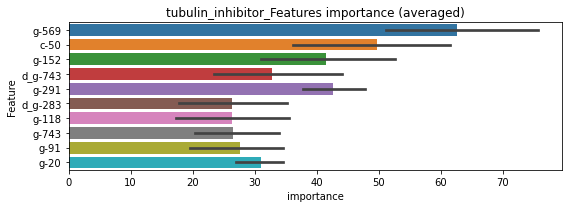

len(train_index) : 3820
len(valid_index) : 3821
================================= fold 1/2 tubulin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160546	valid_1's binary_logloss: 0.0423369
[200]	training's binary_logloss: 0.00219729	valid_1's binary_logloss: 0.0300195
Early stopping, best iteration is:
[228]	training's binary_logloss: 0.00145201	valid_1's binary_logloss: 0.0294878


len(train_index) : 3821
len(valid_index) : 3820
================================= fold 2/2 tubulin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0171713	valid_1's binary_logloss: 0.0383879
[200]	training's binary_logloss: 0.00239057	valid_1's binary_logloss: 0.0230814
[300]	training's binary_logloss: 0.000695548	valid_1's binary_logloss: 0.020416
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.000592156	valid_1's binary_logloss: 0.0202398


tubulin_inhibitor logloss: 0.024864433657263325


neg labels: 3289 → selected neg labels: 3276


tyrosine_kinase_inhibitor, len(trt): 73, len(othr): 3276, target_rate: 0.0030654 → Adj_target_rate: 0.0032212
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.056532	valid_1's binary_logloss: 0.113668
[200]	training's binary_logloss: 0.011736	valid_1's binary_logloss: 0.0599212
[300]	training's binary_logloss: 0.0034317	valid_1's binary_logloss: 0.0448091
[400]	training's binary_logloss: 0.00153534	valid_1's binary_logloss: 0.0401651
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.00109371	valid_1's binary_logloss: 0.0385528
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0581143	valid_1's binary_logloss: 0.113576
[200]	training's binary_logloss: 0.0117457	valid_1's binary_logloss: 0.0573673
[300]	training's binary_logloss: 0.00344015	valid_1's binary_logloss: 0.0426629
[400]	training's binary_logloss: 0.00155798	valid_1's binary_logloss: 0.0373042
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00107465	valid_1's binary_logloss: 0.0357684


1 / 3 AUC score:0.997
y_Threshold: 0.0109994, Threshold: 0.0218787, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 142 → Positive_corect_labels: 650/3789
p_label_rate: 0.0200904 Vs.target_rate: 0.00307
Num_p_label: 80.0, conf_0:0.01969, conf_1:0.02407
Num_p_label: 80.0, Expected: 12.2, Adj_threshold_1: 0.0218787
Num_p_label: 45.0, Expected: 12.2, Adj_threshold_2: 0.0318787
Num_p_label: 28.0, Expected: 12.2, Adj_threshold_3: 0.0418787
Num_p_label: 21.0, Expected: 12.2, Adj_threshold_4: 0.0518787
threshold: 0.0518787, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 650.0/3789, y_label_rate: 0.1715492
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0534668	valid_1's binary_logloss: 0.113235
[200]	training's binary_logloss: 0.0105289	valid_1's binary_logloss: 0.0565293
[300]	training's binary_logloss: 0.00310267	valid_1's binary_logloss: 0.0423136
Early stopping, best iteration is:
[373]	training's binary_logloss: 0.00169946	valid_1's binary_logloss: 0.0389549
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0540467	valid_1's binary_logloss: 0.104586
[200]	training's binary_logloss: 0.0105608	valid_1's binary_logloss: 0.0508046
[300]	training's binary_logloss: 0.00314155	valid_1's binary_logloss: 0.0383441
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.00232065	valid_1's binary_logloss: 0.0366725


2 / 3 AUC score:0.999
y_Threshold: 0.0472074, Threshold: 0.0518787, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 26 → Positive_corect_labels: 637.0/3763
p_label_rate: 0.0138122 Vs.target_rate: 0.00307
Num_p_label: 55.0, conf_0:0.04669, conf_1:0.05707
Num_p_label: 55.0, Expected: 12.2, Adj_threshold_1: 0.0518787
Num_p_label: 45.0, Expected: 12.2, Adj_threshold_2: 0.0618787
Num_p_label: 39.0, Expected: 12.2, Adj_threshold_3: 0.0718787
Num_p_label: 33.0, Expected: 12.2, Adj_threshold_4: 0.0818787
Num_p_label: 29.0, Expected: 12.2, Adj_threshold_5: 0.0918787
Num_p_label: 24.0, Expected: 12.2, Adj_threshold_6: 0.1018787
threshold: 0.1018787, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 637.0/3763, y_label_rate: 0.1692798
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0516616	valid_1's binary_logloss: 0.111721
[200]	training's binary_logloss: 0.0101663	valid_1's binary_logloss: 0.0544155
[300]	training's binary_logloss: 0.00295807	valid_1's binary_logloss: 0.0398314
[400]	training's binary_logloss: 0.00137636	valid_1's binary_logloss: 0.0355192
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.00101235	valid_1's binary_logloss: 0.0344293
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0540564	valid_1's binary_logloss: 0.103572
[200]	training's binary_logloss: 0.0103508	valid_1's binary_logloss: 0.0502494
[300]	training's binary_logloss: 0.00301327	valid_1's binary_logloss: 0.0368494
[400]	training's binary_logloss: 0.00138535	valid_1's binary_logloss: 0.0333664
Early stopping, best iteration is:
[443]	training's binary_logloss: 0.00110062	valid_1's binary_logloss: 0.0323909


3 / 3 AUC score:1.000
y_Threshold: 0.0351636, Threshold: 0.1018787, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 20 → Positive_corect_labels: 627.0/3743
p_label_rate: 0.0052737 Vs.target_rate: 0.00307
Num_p_label: 21.0, conf_0:0.09169, conf_1:0.11207
threshold: 0.1018787, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 648.0/7725, y_label_rate: 0.0838835


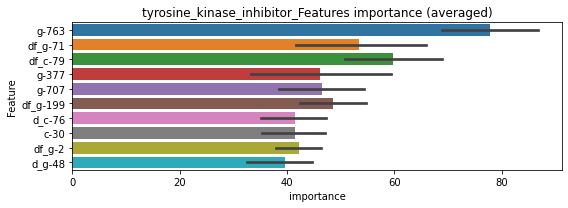

len(train_index) : 3862
len(valid_index) : 3863
================================= fold 1/2 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290418	valid_1's binary_logloss: 0.0701624
[200]	training's binary_logloss: 0.00585376	valid_1's binary_logloss: 0.0440263
[300]	training's binary_logloss: 0.00168829	valid_1's binary_logloss: 0.0382911
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00177613	valid_1's binary_logloss: 0.0381313


len(train_index) : 3863
len(valid_index) : 3862
================================= fold 2/2 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287367	valid_1's binary_logloss: 0.0725239
[200]	training's binary_logloss: 0.00552823	valid_1's binary_logloss: 0.0460097
[300]	training's binary_logloss: 0.00160628	valid_1's binary_logloss: 0.0405184
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.00121169	valid_1's binary_logloss: 0.0401643


tyrosine_kinase_inhibitor logloss: 0.03914767224746572


neg labels: 3289 → selected neg labels: 3287


ubiquitin_specific_protease_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0175012	valid_1's binary_logloss: 0.0210764
[200]	training's binary_logloss: 0.00170087	valid_1's binary_logloss: 0.0040925
[300]	training's binary_logloss: 0.000484121	valid_1's binary_logloss: 0.00219785
[400]	training's binary_logloss: 0.000285921	valid_1's binary_logloss: 0.00171071
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.000267764	valid_1's binary_logloss: 0.00167525
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179441	valid_1's binary_logloss: 0.0210346
[200]	training's binary_logloss: 0.00172251	valid_1's binary_logloss: 0.00341102
[300]	training's binary_logloss: 0.000483551	valid_1's binary_logloss: 0.00147423
[400]	training's binary_logloss: 0.000284416	valid_1's binary_logloss: 0.00106143
[500]	training's binary_logloss: 0.00025137	valid_1's binary_logloss: 0.000993827
Early stopping, best iteration i

1 / 3 AUC score:1.000
y_Threshold: 0.0011237, Threshold: 0.0017832, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050
Num_p_label: 80.0, conf_0:0.00160, conf_1:0.00196
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0017832
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_2: 0.0117832
Num_p_label: 2.0, Expected: 2.0, Adj_threshold_3: 0.0217832
threshold: 0.0217832, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0174815	valid_1's binary_logloss: 0.0201745
[200]	training's binary_logloss: 0.00163583	valid_1's binary_logloss: 0.00308045
[300]	training's binary_logloss: 0.000456079	valid_1's binary_logloss: 0.00139686
[400]	training's binary_logloss: 0.000272047	valid_1's binary_logloss: 0.00102088
[500]	training's binary_logloss: 0.00023956	valid_1's binary_logloss: 0.000949642
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000239079	valid_1's binary_logloss: 0.000948686
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180847	valid_1's binary_logloss: 0.0211949
[200]	training's binary_logloss: 0.00168314	valid_1's binary_logloss: 0.00298235
[300]	training's binary_logloss: 0.000462181	valid_1's binary_logloss: 0.00143048
[400]	training's binary_logloss: 0.000271995	valid_1's binary_logloss: 0.00109424
[500]	training's binary_loglos

2 / 3 AUC score:1.000
y_Threshold: 0.1462061, Threshold: 0.0217832, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0107986 Vs.target_rate: 0.00050
Num_p_label: 43.0, conf_0:0.01960, conf_1:0.02396
Num_p_label: 43.0, Expected: 2.0, Adj_threshold_1: 0.0217832
Num_p_label: 36.0, Expected: 2.0, Adj_threshold_2: 0.0317832
Num_p_label: 28.0, Expected: 2.0, Adj_threshold_3: 0.0417832
Num_p_label: 25.0, Expected: 2.0, Adj_threshold_4: 0.0517832
Num_p_label: 23.0, Expected: 2.0, Adj_threshold_5: 0.0617832
Num_p_label: 23.0, Expected: 2.0, Adj_threshold_6: 0.0717832
Num_p_label: 22.0, Expected: 2.0, Adj_threshold_7: 0.0817832
Num_p_label: 21.0, Expected: 2.0, Adj_threshold_8: 0.0917832
Num_p_label: 21.0, Expected: 2.0, Adj_threshold_9: 0.1017832
Num_p_label: 21.0, Expected: 2.0, Adj_threshold_10: 0.1117832
threshold: 0.1217832, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0174815	valid_1's binary_logloss: 0.0201745
[200]	training's binary_logloss: 0.00163583	valid_1's binary_logloss: 0.00308045
[300]	training's binary_logloss: 0.000456079	valid_1's binary_logloss: 0.00139686
[400]	training's binary_logloss: 0.000272047	valid_1's binary_logloss: 0.00102088
[500]	training's binary_logloss: 0.00023956	valid_1's binary_logloss: 0.000949642
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000239079	valid_1's binary_logloss: 0.000948686
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180847	valid_1's binary_logloss: 0.0211949
[200]	training's binary_logloss: 0.00168314	valid_1's binary_logloss: 0.00298235
[300]	training's binary_logloss: 0.000462181	valid_1's binary_logloss: 0.00143048
[400]	training's binary_logloss: 0.000271995	valid_1's binary_logloss: 0.00109424
[500]	training's binary_loglos

3 / 3 AUC score:1.000
y_Threshold: 0.1462061, Threshold: 0.1217832, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0050226 Vs.target_rate: 0.00050
Num_p_label: 20.0, conf_0:0.10960, conf_1:0.13396
Num_p_label: 20.0, Expected: 2.0, Adj_threshold_1: 0.1217832
Num_p_label: 18.0, Expected: 2.0, Adj_threshold_2: 0.1317832
Num_p_label: 18.0, Expected: 2.0, Adj_threshold_3: 0.1417832
Num_p_label: 16.0, Expected: 2.0, Adj_threshold_4: 0.1517832
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_5: 0.1617832
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_6: 0.1717832
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_7: 0.1817832
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_8: 0.1917832
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_9: 0.2017832
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_10: 0.2117832
threshold: 0.2217832, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 670.0/7794, y_label_rate: 0.0859636


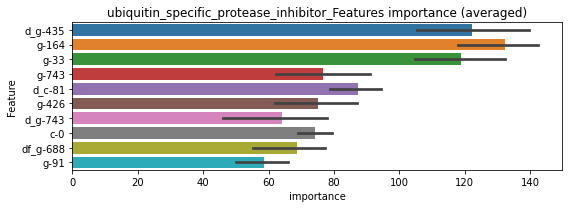

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00962202	valid_1's binary_logloss: 0.0149828
[200]	training's binary_logloss: 0.000910873	valid_1's binary_logloss: 0.00519527
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.000646643	valid_1's binary_logloss: 0.0048433


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00979923	valid_1's binary_logloss: 0.0128857
[200]	training's binary_logloss: 0.000970828	valid_1's binary_logloss: 0.00378937
[300]	training's binary_logloss: 0.000273195	valid_1's binary_logloss: 0.00279701
[400]	training's binary_logloss: 0.000157032	valid_1's binary_logloss: 0.00256371
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.000157032	valid_1's binary_logloss: 0.00256371


ubiquitin_specific_protease_inhibitor logloss: 0.0037035034143121956


neg labels: 3289 → selected neg labels: 3258


vegfr_inhibitor, len(trt): 170, len(othr): 3258, target_rate: 0.0071387 → Adj_target_rate: 0.0066081
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0555066	valid_1's binary_logloss: 0.140671
[200]	training's binary_logloss: 0.0120203	valid_1's binary_logloss: 0.104186
[300]	training's binary_logloss: 0.00369342	valid_1's binary_logloss: 0.0997819
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.00400988	valid_1's binary_logloss: 0.0995196
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0551734	valid_1's binary_logloss: 0.132299
[200]	training's binary_logloss: 0.0131068	valid_1's binary_logloss: 0.0859233
[300]	training's binary_logloss: 0.00440522	valid_1's binary_logloss: 0.0707558
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.002654	valid_1's binary_logloss: 0.0674681


1 / 3 AUC score:0.989
y_Threshold: 0.0387304, Threshold: 0.1727421, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 169 → Positive_corect_labels: 632/3740
p_label_rate: 0.0200904 Vs.target_rate: 0.00714
Num_p_label: 80.0, conf_0:0.15547, conf_1:0.19002
threshold: 0.1727421, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 632.0/3740, y_label_rate: 0.1689840
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0465673	valid_1's binary_logloss: 0.11283
[200]	training's binary_logloss: 0.00930702	valid_1's binary_logloss: 0.0776417
Early stopping, best iteration is:
[239]	training's binary_logloss: 0.00547526	valid_1's binary_logloss: 0.0737707
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0456711	valid_1's binary_logloss: 0.10439
[200]	training's binary_logloss: 0.00874355	valid_1's binary_logloss: 0.0675809
Early stopping, best iteration is:
[245]	training's binary_logloss: 0.00483663	valid_1's binary_logloss: 0.0635454


2 / 3 AUC score:0.994
y_Threshold: 0.1109503, Threshold: 0.1727421, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 80 → Positive_corect_labels: 592.0/3660
p_label_rate: 0.0457057 Vs.target_rate: 0.00714
Num_p_label: 182.0, conf_0:0.15547, conf_1:0.19002
Num_p_label: 182.0, Expected: 28.4, Adj_threshold_1: 0.1727421
Num_p_label: 175.0, Expected: 28.4, Adj_threshold_2: 0.1827421
Num_p_label: 170.0, Expected: 28.4, Adj_threshold_3: 0.1927421
Num_p_label: 164.0, Expected: 28.4, Adj_threshold_4: 0.2027421
Num_p_label: 158.0, Expected: 28.4, Adj_threshold_5: 0.2127421
Num_p_label: 156.0, Expected: 28.4, Adj_threshold_6: 0.2227421
Num_p_label: 155.0, Expected: 28.4, Adj_threshold_7: 0.2327421
Num_p_label: 152.0, Expected: 28.4, Adj_threshold_8: 0.2427421
Num_p_label: 150.0, Expected: 28.4, Adj_threshold_9: 0.2527421
Num_p_label: 144.0, Expected: 28.4, Adj_threshold_10: 0.2627421
threshold: 0.2727421, positive_p_label: 134.0/3982, p_label_rate: 0.0336514
positive_y_label: 592.0/3660, y_label_ra

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0393719	valid_1's binary_logloss: 0.0896627
[200]	training's binary_logloss: 0.00706631	valid_1's binary_logloss: 0.0535707
[300]	training's binary_logloss: 0.00216787	valid_1's binary_logloss: 0.0447333
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00166358	valid_1's binary_logloss: 0.043808
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0397616	valid_1's binary_logloss: 0.0814103
[200]	training's binary_logloss: 0.00682823	valid_1's binary_logloss: 0.0425673
[300]	training's binary_logloss: 0.00209926	valid_1's binary_logloss: 0.033818
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.00139771	valid_1's binary_logloss: 0.0324909


3 / 3 AUC score:0.999
y_Threshold: 0.1389491, Threshold: 0.2727421, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 28 → Positive_corect_labels: 578.0/3632
p_label_rate: 0.0386740 Vs.target_rate: 0.00714
Num_p_label: 154.0, conf_0:0.24547, conf_1:0.30002
Num_p_label: 154.0, Expected: 28.4, Adj_threshold_1: 0.2727421
Num_p_label: 151.0, Expected: 28.4, Adj_threshold_2: 0.2827421
Num_p_label: 148.0, Expected: 28.4, Adj_threshold_3: 0.2927421
Num_p_label: 146.0, Expected: 28.4, Adj_threshold_4: 0.3027421
Num_p_label: 145.0, Expected: 28.4, Adj_threshold_5: 0.3127421
Num_p_label: 143.0, Expected: 28.4, Adj_threshold_6: 0.3227421
Num_p_label: 139.0, Expected: 28.4, Adj_threshold_7: 0.3327421
Num_p_label: 137.0, Expected: 28.4, Adj_threshold_8: 0.3427421
Num_p_label: 133.0, Expected: 28.4, Adj_threshold_9: 0.3527421
Num_p_label: 132.0, Expected: 28.4, Adj_threshold_10: 0.3627421
threshold: 0.3727421, positive_p_label: 129.0/3982, p_label_rate: 0.0323958
positive_y_label: 707.0/7614, y_label_ra

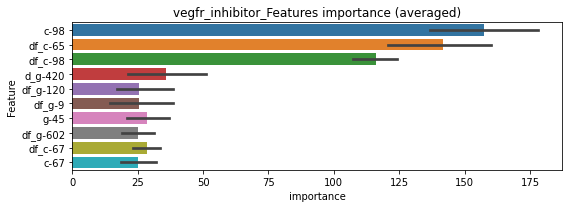

len(train_index) : 3807
len(valid_index) : 3807
================================= fold 1/2 vegfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237269	valid_1's binary_logloss: 0.0568336
[200]	training's binary_logloss: 0.00404461	valid_1's binary_logloss: 0.0379031
[300]	training's binary_logloss: 0.00124997	valid_1's binary_logloss: 0.0334476
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00131955	valid_1's binary_logloss: 0.0334038


len(train_index) : 3807
len(valid_index) : 3807
================================= fold 2/2 vegfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235227	valid_1's binary_logloss: 0.064562
[200]	training's binary_logloss: 0.00417972	valid_1's binary_logloss: 0.0449264
[300]	training's binary_logloss: 0.001268	valid_1's binary_logloss: 0.0402841
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.000962265	valid_1's binary_logloss: 0.0393471


vegfr_inhibitor logloss: 0.03637542055263985


neg labels: 3289 → selected neg labels: 3285


vitamin_b, len(trt): 26, len(othr): 3285, target_rate: 0.0010918 → Adj_target_rate: 0.0013394
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290428	valid_1's binary_logloss: 0.0431082
[200]	training's binary_logloss: 0.0038593	valid_1's binary_logloss: 0.00949938
[300]	training's binary_logloss: 0.00109289	valid_1's binary_logloss: 0.00394492
[400]	training's binary_logloss: 0.000552346	valid_1's binary_logloss: 0.00254751
[500]	training's binary_logloss: 0.000397951	valid_1's binary_logloss: 0.00213295
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.000391624	valid_1's binary_logloss: 0.00211974
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.029391	valid_1's binary_logloss: 0.0450665
[200]	training's binary_logloss: 0.00406009	valid_1's binary_logloss: 0.0113694
[300]	training's binary_logloss: 0.00113291	valid_1's binary_logloss: 0.00561173
[400]	training's binary_logloss: 0.00056413	valid_1's binary_logloss: 0.00389719
Early stopping, best iteration is:
[4

1 / 3 AUC score:1.000
y_Threshold: 0.0023094, Threshold: 0.0047240, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00109
Num_p_label: 80.0, conf_0:0.00425, conf_1:0.00520
Num_p_label: 80.0, Expected: 4.3, Adj_threshold_1: 0.0047240
Num_p_label: 11.0, Expected: 4.3, Adj_threshold_2: 0.0147240
Num_p_label: 6.0, Expected: 4.3, Adj_threshold_3: 0.0247240
threshold: 0.0247240, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0288195	valid_1's binary_logloss: 0.0421521
[200]	training's binary_logloss: 0.0037918	valid_1's binary_logloss: 0.00943706
[300]	training's binary_logloss: 0.00107169	valid_1's binary_logloss: 0.00391528
[400]	training's binary_logloss: 0.000549317	valid_1's binary_logloss: 0.00268449
[500]	training's binary_logloss: 0.000401973	valid_1's binary_logloss: 0.00234544
Early stopping, best iteration is:
[559]	training's binary_logloss: 0.000380483	valid_1's binary_logloss: 0.00227439
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282313	valid_1's binary_logloss: 0.0438213
[200]	training's binary_logloss: 0.00376198	valid_1's binary_logloss: 0.0116595
[300]	training's binary_logloss: 0.00106473	valid_1's binary_logloss: 0.00596018
[400]	training's binary_logloss: 0.000540845	valid_1's binary_logloss: 0.00459437
[500]	training's binary_logloss: 0.

2 / 3 AUC score:1.000
y_Threshold: 0.0414090, Threshold: 0.0247240, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0045203 Vs.target_rate: 0.00109
Num_p_label: 18.0, conf_0:0.02225, conf_1:0.02720
Num_p_label: 18.0, Expected: 4.3, Adj_threshold_1: 0.0247240
Num_p_label: 13.0, Expected: 4.3, Adj_threshold_2: 0.0347240
Num_p_label: 9.0, Expected: 4.3, Adj_threshold_3: 0.0447240
Num_p_label: 6.0, Expected: 4.3, Adj_threshold_4: 0.0547240
threshold: 0.0547240, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0288195	valid_1's binary_logloss: 0.0421521
[200]	training's binary_logloss: 0.0037918	valid_1's binary_logloss: 0.00943706
[300]	training's binary_logloss: 0.00107169	valid_1's binary_logloss: 0.00391528
[400]	training's binary_logloss: 0.000549317	valid_1's binary_logloss: 0.00268449
[500]	training's binary_logloss: 0.000401973	valid_1's binary_logloss: 0.00234544
Early stopping, best iteration is:
[559]	training's binary_logloss: 0.000380483	valid_1's binary_logloss: 0.00227439
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282313	valid_1's binary_logloss: 0.0438213
[200]	training's binary_logloss: 0.00376198	valid_1's binary_logloss: 0.0116595
[300]	training's binary_logloss: 0.00106473	valid_1's binary_logloss: 0.00596018
[400]	training's binary_logloss: 0.000540845	valid_1's binary_logloss: 0.00459437
[500]	training's binary_logloss: 0.

3 / 3 AUC score:1.000
y_Threshold: 0.0414090, Threshold: 0.0547240, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0015068 Vs.target_rate: 0.00109
Num_p_label: 6.0, conf_0:0.04925, conf_1:0.06020
threshold: 0.0547240, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7792, y_label_rate: 0.0850873


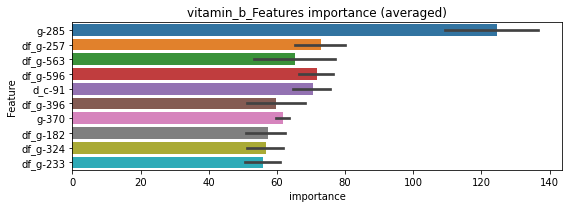

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 vitamin_b=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157737	valid_1's binary_logloss: 0.026692
[200]	training's binary_logloss: 0.0020604	valid_1's binary_logloss: 0.00921723
[300]	training's binary_logloss: 0.000564012	valid_1's binary_logloss: 0.00740301
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.000492692	valid_1's binary_logloss: 0.00731184


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 vitamin_b=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164667	valid_1's binary_logloss: 0.0273042
[200]	training's binary_logloss: 0.00222739	valid_1's binary_logloss: 0.00733559
[300]	training's binary_logloss: 0.000614228	valid_1's binary_logloss: 0.0039336
[400]	training's binary_logloss: 0.000302842	valid_1's binary_logloss: 0.00307725
[500]	training's binary_logloss: 0.000212239	valid_1's binary_logloss: 0.00281976
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.000201665	valid_1's binary_logloss: 0.0027823


vitamin_b logloss: 0.005047068002003568


neg labels: 3289 → selected neg labels: 3281


vitamin_d_receptor_agonist, len(trt): 39, len(othr): 3281, target_rate: 0.0016377 → Adj_target_rate: 0.0018906
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276159	valid_1's binary_logloss: 0.0389686
[200]	training's binary_logloss: 0.00356435	valid_1's binary_logloss: 0.00765938
[300]	training's binary_logloss: 0.00101357	valid_1's binary_logloss: 0.00301692
[400]	training's binary_logloss: 0.000510142	valid_1's binary_logloss: 0.00184027
[500]	training's binary_logloss: 0.000362044	valid_1's binary_logloss: 0.00143752
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.000340122	valid_1's binary_logloss: 0.00138663
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0266777	valid_1's binary_logloss: 0.0493678
[200]	training's binary_logloss: 0.0034659	valid_1's binary_logloss: 0.0171579
[300]	training's binary_logloss: 0.000989384	valid_1's binary_logloss: 0.0112116
[400]	training's binary_logloss: 0.000502159	valid_1's binary_logloss: 0.00911181
[500]	training's binary_logloss: 0.

1 / 3 AUC score:1.000
y_Threshold: 0.0018088, Threshold: 0.0035405, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3805
p_label_rate: 0.0200904 Vs.target_rate: 0.00164
Num_p_label: 80.0, conf_0:0.00319, conf_1:0.00389
Num_p_label: 80.0, Expected: 6.5, Adj_threshold_1: 0.0035405
Num_p_label: 21.0, Expected: 6.5, Adj_threshold_2: 0.0135405
Num_p_label: 14.0, Expected: 6.5, Adj_threshold_3: 0.0235405
Num_p_label: 13.0, Expected: 6.5, Adj_threshold_4: 0.0335405
threshold: 0.0335405, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028135	valid_1's binary_logloss: 0.0387051
[200]	training's binary_logloss: 0.00359159	valid_1's binary_logloss: 0.00737206
[300]	training's binary_logloss: 0.00101036	valid_1's binary_logloss: 0.0027359
[400]	training's binary_logloss: 0.000506796	valid_1's binary_logloss: 0.00163099
[500]	training's binary_logloss: 0.000361408	valid_1's binary_logloss: 0.00129267
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.000339468	valid_1's binary_logloss: 0.00123932
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026443	valid_1's binary_logloss: 0.0482199
[200]	training's binary_logloss: 0.0033746	valid_1's binary_logloss: 0.0180546
[300]	training's binary_logloss: 0.000955224	valid_1's binary_logloss: 0.0120278
[400]	training's binary_logloss: 0.000486616	valid_1's binary_logloss: 0.0101937
Early stopping, best iteration is:
[470

2 / 3 AUC score:1.000
y_Threshold: 0.0257588, Threshold: 0.0335405, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3805
p_label_rate: 0.0042692 Vs.target_rate: 0.00164
Num_p_label: 17.0, conf_0:0.03019, conf_1:0.03689
threshold: 0.0335405, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028135	valid_1's binary_logloss: 0.0387051
[200]	training's binary_logloss: 0.00359159	valid_1's binary_logloss: 0.00737206
[300]	training's binary_logloss: 0.00101036	valid_1's binary_logloss: 0.0027359
[400]	training's binary_logloss: 0.000506796	valid_1's binary_logloss: 0.00163099
[500]	training's binary_logloss: 0.000361408	valid_1's binary_logloss: 0.00129267
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.000339468	valid_1's binary_logloss: 0.00123932
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026443	valid_1's binary_logloss: 0.0482199
[200]	training's binary_logloss: 0.0033746	valid_1's binary_logloss: 0.0180546
[300]	training's binary_logloss: 0.000955224	valid_1's binary_logloss: 0.0120278
[400]	training's binary_logloss: 0.000486616	valid_1's binary_logloss: 0.0101937
Early stopping, best iteration is:
[470

3 / 3 AUC score:1.000
y_Threshold: 0.0257588, Threshold: 0.0335405, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3805
p_label_rate: 0.0042692 Vs.target_rate: 0.00164
Num_p_label: 17.0, conf_0:0.03019, conf_1:0.03689
threshold: 0.0335405, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 673.0/7787, y_label_rate: 0.0864261


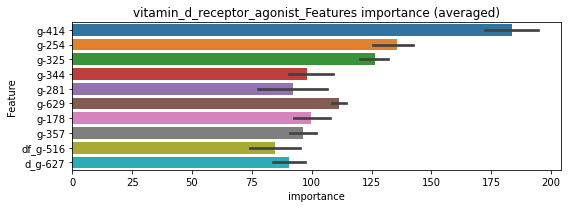

len(train_index) : 3893
len(valid_index) : 3894
================================= fold 1/2 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0142643	valid_1's binary_logloss: 0.0325926
[200]	training's binary_logloss: 0.00177554	valid_1's binary_logloss: 0.0151105
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.000605198	valid_1's binary_logloss: 0.0131045


len(train_index) : 3894
len(valid_index) : 3893
================================= fold 2/2 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.014653	valid_1's binary_logloss: 0.025383
[200]	training's binary_logloss: 0.00184518	valid_1's binary_logloss: 0.00918109
[300]	training's binary_logloss: 0.000532949	valid_1's binary_logloss: 0.00640858
[400]	training's binary_logloss: 0.000271785	valid_1's binary_logloss: 0.00565461
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000264909	valid_1's binary_logloss: 0.00562376


vitamin_d_receptor_agonist logloss: 0.009364590902997535


neg labels: 3289 → selected neg labels: 3284


wnt_inhibitor, len(trt): 30, len(othr): 3284, target_rate: 0.0012598 → Adj_target_rate: 0.0015127
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0313938	valid_1's binary_logloss: 0.0526731
[200]	training's binary_logloss: 0.00445364	valid_1's binary_logloss: 0.0153324
[300]	training's binary_logloss: 0.00123777	valid_1's binary_logloss: 0.00792129
[400]	training's binary_logloss: 0.000616693	valid_1's binary_logloss: 0.0057998
[500]	training's binary_logloss: 0.000427523	valid_1's binary_logloss: 0.00512571
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000436549	valid_1's binary_logloss: 0.0051038
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0301788	valid_1's binary_logloss: 0.0570437
[200]	training's binary_logloss: 0.00435694	valid_1's binary_logloss: 0.0228204
[300]	training's binary_logloss: 0.00122201	valid_1's binary_logloss: 0.0168819
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00116696	valid_1's binary_logloss: 0.0168582


1 / 3 AUC score:1.000
y_Threshold: 0.0038270, Threshold: 0.0045355, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00126
Num_p_label: 80.0, conf_0:0.00408, conf_1:0.00499
Num_p_label: 80.0, Expected: 5.0, Adj_threshold_1: 0.0045355
Num_p_label: 4.0, Expected: 5.0, Adj_threshold_2: 0.0145355
threshold: 0.0145355, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315933	valid_1's binary_logloss: 0.0544198
[200]	training's binary_logloss: 0.00438553	valid_1's binary_logloss: 0.0162114
[300]	training's binary_logloss: 0.00123582	valid_1's binary_logloss: 0.00892392
[400]	training's binary_logloss: 0.00060884	valid_1's binary_logloss: 0.0065722
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000439035	valid_1's binary_logloss: 0.00586885
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0313363	valid_1's binary_logloss: 0.056959
[200]	training's binary_logloss: 0.00446442	valid_1's binary_logloss: 0.0219001
[300]	training's binary_logloss: 0.0012393	valid_1's binary_logloss: 0.0150058
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.000750835	valid_1's binary_logloss: 0.013743


2 / 3 AUC score:1.000
y_Threshold: 0.0138754, Threshold: 0.0145355, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0045203 Vs.target_rate: 0.00126
Num_p_label: 18.0, conf_0:0.01308, conf_1:0.01599
Num_p_label: 18.0, Expected: 5.0, Adj_threshold_1: 0.0145355
Num_p_label: 5.0, Expected: 5.0, Adj_threshold_2: 0.0245355
threshold: 0.0245355, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315933	valid_1's binary_logloss: 0.0544198
[200]	training's binary_logloss: 0.00438553	valid_1's binary_logloss: 0.0162114
[300]	training's binary_logloss: 0.00123582	valid_1's binary_logloss: 0.00892392
[400]	training's binary_logloss: 0.00060884	valid_1's binary_logloss: 0.0065722
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000439035	valid_1's binary_logloss: 0.00586885
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0313363	valid_1's binary_logloss: 0.056959
[200]	training's binary_logloss: 0.00446442	valid_1's binary_logloss: 0.0219001
[300]	training's binary_logloss: 0.0012393	valid_1's binary_logloss: 0.0150058
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.000750835	valid_1's binary_logloss: 0.013743


3 / 3 AUC score:1.000
y_Threshold: 0.0138754, Threshold: 0.0245355, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0012557 Vs.target_rate: 0.00126
Num_p_label: 5.0, conf_0:0.02208, conf_1:0.02699
threshold: 0.0245355, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 661.0/7790, y_label_rate: 0.0848524


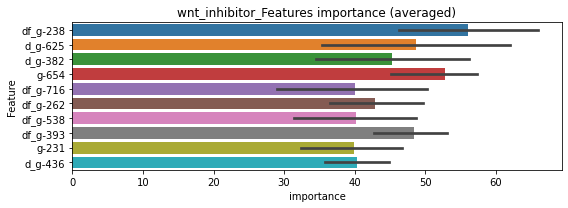

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 wnt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0175755	valid_1's binary_logloss: 0.0318824
[200]	training's binary_logloss: 0.00249416	valid_1's binary_logloss: 0.0126783
[300]	training's binary_logloss: 0.000669473	valid_1's binary_logloss: 0.00963504
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000449621	valid_1's binary_logloss: 0.00925538


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 wnt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0173441	valid_1's binary_logloss: 0.0293096
[200]	training's binary_logloss: 0.00239384	valid_1's binary_logloss: 0.0097484
[300]	training's binary_logloss: 0.000655335	valid_1's binary_logloss: 0.00596998
[400]	training's binary_logloss: 0.000316447	valid_1's binary_logloss: 0.00477024
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.000252063	valid_1's binary_logloss: 0.00457027


wnt_inhibitor logloss: 0.006912827430653012


In [46]:
categorical_cols = []
scores = []
models = []
feature_importance_df = pd.DataFrame()
importance_cols_df = pd.DataFrame()

for target_col in tqdm(train_targets_scored.columns[1:]):
    _preds, _score, models, _feature_importance_df = run_lgbm(target_col)

    sub[target_col] = _preds
    scores.append(_score)
    
    if DEBUG:
        feature_importance_df = create_featureimprotance(models, feature_importance_df)
        importance_cols_df[target_col] = select_importance_cols(_feature_importance_df)

In [47]:
sub.to_csv('submission.csv', index=False)

In [48]:
print(f"CV:{np.mean(scores)}")

CV:0.021026632398707678


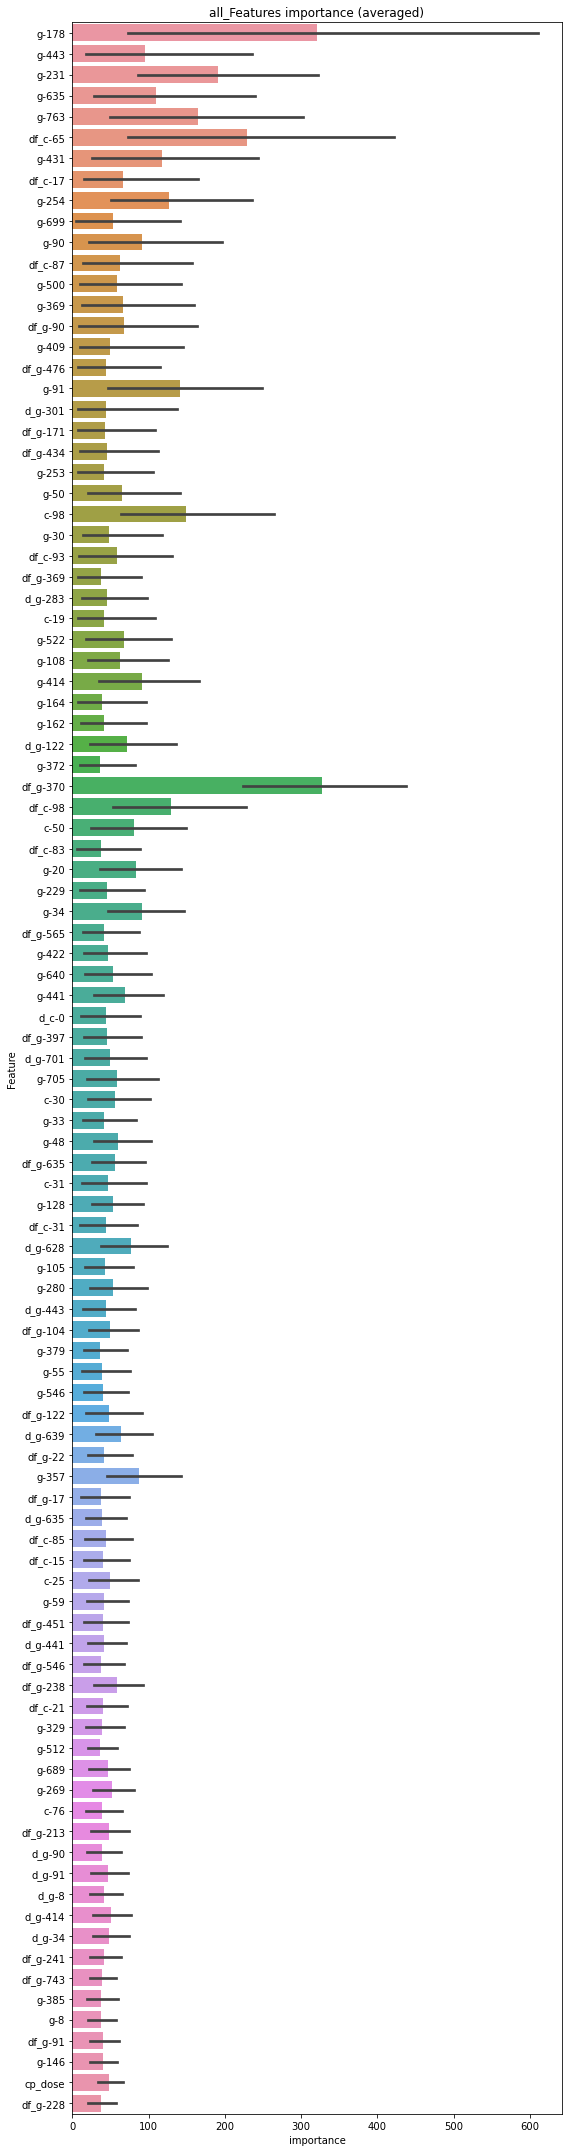

In [49]:
if DEBUG:
    show_feature_importance(feature_importance_df)
    feature_importance_df.to_csv(f'feature_importance_df.{Version}.csv', index=False)
    importance_cols_df.to_csv(f'importance_cols_df.{Version}.csv', index=False)